# 1. Preparation

## Import libraries

In [ ]:
# For CPU
# !pip install --upgrade jaxlib jax
# For GPU
# !pip install --upgrade jax jaxlib==0.1.65+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [1]:
import jax
import jax.numpy as np
import numpy as onp
from jax import random, vmap, grad, jit
# from jax.experimental import optimizers
from jax.example_libraries import optimizers

import itertools
from functools import partial
from tqdm import trange
import numpy.random as npr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# from jax.ops import index_update, index
import jax.nn as jnn
import itertools
from functools import partial
from matplotlib import cm
from jax.scipy.linalg import cholesky, solve_triangular, solve
import pandas as pd
import csv

from scipy import optimize

from jax.flatten_util import ravel_pytree
from jax.nn import softplus
from pathlib import Path
import os, sys
from scipy import spatial
from sklearn.model_selection import train_test_split
import scipy.optimize
import scipy.special as sp
import pickle

In [2]:
# def FindFreq1D(x, num_bins = 10):
#   # x is a 1D array to be assigned frequency
#   x_hist, x_bins_edges = np.histogram(x, num_bins)
#   Num_x = len(x)
#   x_freq = []
#   for i in trange(Num_x):
#     for j in range(1, Num_x+1):
#       if x[i] <= x_bins_edges[j]:
#         freq = float(x_hist[j-1]) / Num_x
#         x_freq.append(freq)
#         break

#   x_freq = np.array(x_freq)
#   return x_freq

In [3]:
# def Var1D(x, y, num_bins = 10):
#   # Find variance var(y(x)) for given x from data {x_i, y_i}
#   x_min = x.min()
#   x_max = x.max()
#   x_mesh = onp.linspace(x_min, x_max, num_bins + 1)
#   x_mesh[0] = x_mesh[0] - 0.1
#   x_mesh[-1] = x_mesh[-1] + 0.1

#   var_y = []
#   for i in trange(num_bins):
#     mesh_mask = np.array([a<x_mesh[i] or a>=x_mesh[i+1] for a in x])
#     y_masked = onp.ma.array(y, mask=mesh_mask)
#     var = y_masked.var()
#     var_y.append(var)

#   var_y = np.array(var_y)
#   x_mesh = onp.linspace(x_min, x_max, num_bins + 1)
#   x_mid = (x_mesh[:-1] + x_mesh[1:]) / 2.0
#   return x_mid, var_y

In [ ]:
# def sample2d(x, num_sample):
#   # x should be two 1d array
#   x_target = np.linspace(x.min(), x.max(), num_sample)
#   coords = [ [i, j] for i in x_target for j in y_target ]
#   idx_array = []
#   dp = np.stack((x, y), axis=-1)
#   k_tree = spatial.KDTree(dp)
#   for i in trange(len(coords)):
#     idx = k_tree.query(coords[i])[1]
#     idx_array.append(idx)

#   print(len(idx_array))
#   idx_array = list(set(idx_array))
#   print(len(idx_array))
#   return idx_array, coords


def sample2d(x, y, num_sample):
  # x and y should be two 1d array
  x_target = np.linspace(x.min(), x.max(), num_sample)
  y_target = np.linspace(y.min(), y.max(), num_sample)
  coords = [ [i, j] for i in x_target for j in y_target ]
  idx_array = []
  dp = np.stack((x, y), axis=-1)
  k_tree = spatial.KDTree(dp)
  for i in trange(len(coords)):
    idx = k_tree.query(coords[i])[1]
    idx_array.append(idx)

  print(len(idx_array))
  idx_array = list(set(idx_array))
  print(len(idx_array))
  return idx_array, coords


## Auxiliary Functions

In [3]:
# Tridiagonal Matrix Algorith for solveing Ax=d with a, b, c as the
# three diagonals from the bottom to the top.
def TDMA(a, b, c, d):

    Nx = len(d) # number of equations
    ac, bc, cc, dc = map(onp.array, (a, b, c, d)) # copy arrays
    for it in range(1, Nx):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1]
        dc[it] = dc[it] - mc*dc[it-1]

    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(Nx-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

In [5]:
def GenerateProfile(ProfType, ProfParams, x):
  # generate profile with given Proffile Type with given Profiles Parameters on spacial grid x

  if ProfType == 'cos':
    center, amp, freq = ProfParams

    y = center - amp * onp.cos( 2.0 * np.pi * freq * x )

  elif ProfType == 'tri':
    center, amp, freq = ProfParams

    y = center - amp * ( 4.0 * onp.abs( freq * x - onp.floor( freq * x + 0.5 ) ) - 1.0 )

  else:
    print("Wrong ProfType in function GenerateProfile()!")
    exit()

  return y

In [7]:
# spacial gradient using central finite difference
def gradC_periodic(u, dx):

  u_left = onp.roll(u, 1)
  u_right = onp.roll(u, -1)

  dudX = ( u_right - u_left )  / (2.0*dx)

  return dudX

# spacial gradient using backward finite difference
def gradB_periodic(u, dx):

  u_left = onp.roll(u, 1)

  dudX = ( u - u_left )  / dx

  return dudX

# spacial gradient using forward finite difference
def gradF_periodic(u, dx):

  u_right = onp.roll(u, -1)

  dudX = ( u_right - u )  / dx

  return dudX

# spacial laplacian using finite difference
def lap_periodic(u, dx):

  u_left = onp.roll(u, 1)
  u_right = onp.roll(u, -1)

  d2udX2 = ( u_right - 2.0 * u + u_left )  / (dx * dx)

  return d2udX2

## Analytic K & fe for Arrhenius Diffusion

In [10]:
# analytic mobility m and derivatives dm/dc, d2m/dc2 for Arrhenius diffusion
# Notice that delta function is used for computing the convolution of J*c
# _2nd & _4th refer to results in 2nd & 4th order precision, respectively, and 0-th order precision otherwise

def mob_Arr_ana_func(c, Jo, L, D):
  return D * c * (1-c) * np.exp(-2 * Jo*L * c)


def dmobdc_Arr_ana_func(c, Jo, L, D):
  return D * np.exp(-2 * Jo*L * c) * ( (1-2*c) - 2 * Jo*L * c * (1-c) )

def d2mobdc2_Arr_ana_func(c, Jo, L, D):
  return D * np.exp(-2 * Jo*L * c) * ( -2 - 4* Jo*L * (1-2*c) + 4 * Jo*Jo*L*L * c * (1-c) )


def mob_Arr_ana_2nd_func(c, lap_c, JoL, Lx, D):
  return D * c * (1-c) * np.exp(-2 * JoL * (c + Lx**2 * lap_c / 6.0))

def mob_Arr_ana_4nd_func(c, Jc4, D):
  return D * c * (1-c) * np.exp(-Jc4)


def K_1_Arr_ana_func(c, dc, dx, Jo, L, Co=1):
  return - mob_Arr_ana_func(c,Jo,L,Co) / dx - 1.0/24.0 * d2mobdc2_Arr_ana_func(c,Jo,L,Co) * dc**2 * dx


# analytic free energy
def fe_Arr_ana_func(c, Jo, L, D):
  return - 1.0/2.0 * c * 2*Jo*L * c + c * np.log(c) + (1-c) * np.log(1-c)

def fe_Arr_ana_2nd_func(c, lap_c, JoL, Lx, D):
  return - 1.0/2.0 * c * 2*JoL * (c + Lx**2 * lap_c / 6.0) + c * np.log(c) + (1-c) * np.log(1-c)

# analytic thermodynamic force
def Q_Arr_ana_func(c, Jo, L, D):
  return - 2*Jo*L * c - np.log(1/c - 1)

def Q_Arr_ana_2nd_func(c, lap_c, JoL, Lx, D):
  return - 2*JoL * ( c + Lx**2 * lap_c / 6.0 ) - np.log(1/c - 1)

def Jc4_func(c, JoL, Lx, dx):
  c_left2 = np.roll(c, 2)
  c_left = np.roll(c, 1)
  c_right = np.roll(c, -1)
  c_right2 = np.roll(c, -2)

  grad2_c = ( - c_right2 + 16 * c_right - 30 * c + 16 * c_left - c_left2 ) / ( 12 * dx**2 )
  grad4_c = ( c_right2 - 4 * c_right + 6 * c - 4 * c_left + c_left2 ) / ( dx**4 )

  Jc4 = 2*JoL * ( c + Lx**2 * grad2_c / 6.0 + Lx**4 * grad4_c / 120.0 )

  return Jc4

def Q_Arr_ana_4nd_func(c, Jc4, D):

  return - Jc4 - np.log(1/c - 1)




# 2. Stat-PINNs

## MLP

In [14]:
# Multilayer perceptron neural network
def MLP(layers, activation='softplus'):
  def init(rng_key):
    def init_layer(key, d_in, d_out):
      # Initialize weights and bias (Glorot)
      k1, k2 = random.split(key)
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev*random.normal(k1, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

    key, *keys = random.split(rng_key, len(layers))
    params = list(map(init_layer, keys, layers[:-1], layers[1:]))
    return params

  def apply(params, inputs):
    for W, b in params[:-1]:
      outputs = np.dot(inputs, W) + b
      if activation == 'softplus':
        inputs = softplus(outputs)
      elif activation == 'ReLU':
        inputs = jnn.relu(outputs)
      elif activation == 'GeLU':
        inputs = jnn.gelu(outputs)
      elif activation == 'sigmoid':
        inputs = jnn.sigmoid(outputs)
      elif activation == 'tanh':
        inputs = np.tanh(outputs)
    W, b = params[-1]
    outputs = np.dot(inputs, W) + b

    return outputs
  return init, apply

## K_NN: $K_1(\rho_i, \rho_{i+1})$

In [17]:
class K1_NN():
# Learn K0, K1 from fluctuations
# 1 NN for K_1. K_0 is defined through K_1 by mass conservation
# Here K_1 is a function of 2 points rho_i & rho_{i+1}
  def __init__(self, train_data, layers, lr=1e-3, af = 'softplus', rng_key = random.PRNGKey(0)):


    # Load training data
    # K_0 = Kbb
    self.rho_middle_0 = train_data[0]
    self.rho_left_0 = train_data[1]
    self.rho_right_0 = train_data[2]
    self.K_0 = train_data[3]

    # K_1 = Kbbp1 = Kbp1b
    self.rho_left_1 = train_data[4]
    self.rho_right_1 = train_data[5]
    self.K_1 = train_data[6]
    print('Number of K_0 data:', self.K_0.shape)
    print('Number of K_1 data:', self.K_1.shape)

    self.dx_basis = train_data[7]


    # find local density and density gradient
    # for K_0
    self.rho_0 = self.rho_middle_0
    self.drho_0 = ( self.rho_right_0 - self.rho_left_0 ) / ( 2.0 * self.dx_basis )
    # for K_1
    self.rho_1 = ( self.rho_right_1 + self.rho_left_1 ) / 2.0
    self.drho_1 = ( self.rho_right_1 - self.rho_left_1 ) / self.dx_basis



    self.layers = layers
    print('layers =', self.layers)


    # set mean and std
    self.rho_0_mean = self.rho_0.mean()
    self.drho_0_mean = self.drho_0.mean()
    self.rho_1_mean = self.rho_1.mean()
    self.drho_1_mean = self.drho_1.mean()

    self.rho_0_std = self.rho_0.std()
    self.drho_0_std = self.drho_0.std()
    self.rho_1_std = self.rho_1.std()
    self.drho_1_std = self.drho_1.std()


    # Set scale factor
    self.K_0_scale = self.K_0.mean()
    self.K_1_scale = self.K_1.mean()

    print('K_0 scale = ', self.K_0_scale)
    print('K_1 scale = ', self.K_1_scale)

    # Load MLP
    self.net_K_1_init, self.net_K_1_apply = MLP(self.layers, activation=af)

    # Initialize parameters, not committing to a batch shape
    self.params = self.net_K_1_init(rng_key)

    # Initialize loss weights using NTK method
    self.factor_K_0, self.factor_K_1 = self.get_factors(self.params)
    print('K_0 loss weight =', self.factor_K_0)
    print('K_1 loss weight =', self.factor_K_1)

    # Use optimizers to set optimizer initialization and update functions
    self.opt_init, \
    self.opt_update, \
    self.get_params = optimizers.adam(lr)
    self.opt_state = self.opt_init(self.params)

    # Logger to monitor the loss function
    self.loss_log = []
    self.loss_K_0_log = []
    self.loss_K_1_log = []


    self.itercount = itertools.count()
    self.print_flag = False


  def Real_to_Pos(self, x):
    # a function that convert real number to positive number
    return np.heaviside(x, 0) * ( x + np.exp(-5) ) + np.heaviside(-x, 0) * np.exp( x - 5 )

  def net_K_1(self, params, rho_left, rho_right):

    rho = ( rho_right + rho_left ) / 2.0
    drho = ( rho_right - rho_left ) / self.dx_basis

    rho_normalized = np.array([(rho - self.rho_1_mean) / self.rho_1_std])
    drho_normalized = np.array([(drho - self.drho_1_mean) / self.drho_1_std])
    inputs = np.concatenate([rho_normalized, drho_normalized])
    K_1 = - self.Real_to_Pos( self.net_K_1_apply(params, inputs) ) * np.abs(self.K_1_scale)
    # Real_to_Pos is used for applying positive semi-definity on K

    return K_1[0]


  def net_K_0(self, params, rho_middle, rho_left, rho_right):

    return - ( self.net_K_1(params, rho_left, rho_middle) + self.net_K_1(params, rho_middle, rho_right) )


  # Adaptive loss weights
  def K_0_eqt(self, params, rho_middle, rho_left, rho_right, K_0):
    NN_K_0 = self.net_K_0(params, rho_middle, rho_left, rho_right)

    return (NN_K_0 - K_0)

  def K_1_eqt(self, params, rho_left, rho_right, K_1):
    NN_K_1 = self.net_K_1(params, rho_left, rho_right)
    return (NN_K_1 - K_1)


  def grad_K_0_eqt(self, params, rho_middle, rho_left, rho_right, K_0):
    return grad(self.K_0_eqt, 0)(params, rho_middle, rho_left, rho_right, K_0)

  def grad_K_1_eqt(self, params, rho_left, rho_right, K_1):
    return grad(self.K_1_eqt, 0)(params, rho_left, rho_right, K_1)


  def flat_append(self, grad_A):
    tmp = []
    for i in range(len(grad_A)):
      tmp.append(np.concatenate((grad_A[i][0].flatten(), grad_A[i][1].flatten()), axis=None))
      # Here [0] and [1] corresponds to weights and biases shapes
    tmp_ary = np.concatenate(tmp).ravel()
    return tmp_ary


  def get_factors(self, params):  # self adaptive loss weights by NTK

    grad_K_0 = vmap(self.grad_K_0_eqt, in_axes=(None, 0, 0, 0, 0))(params, self.rho_middle_0, self.rho_left_0, self.rho_right_0, self.K_0)
    tr_K_0 = np.sum(np.square(self.flat_append(grad_K_0)))

    grad_K_1 = vmap(self.grad_K_1_eqt, in_axes=(None, 0, 0, 0))(params, self.rho_left_1, self.rho_right_1, self.K_1)
    tr_K_1 = np.sum(np.square(self.flat_append(grad_K_1)))

    tr_NTK = tr_K_0 + tr_K_1

    factor_K_0 = (tr_NTK / tr_K_0)
    factor_K_1 = (tr_NTK / tr_K_1)

    return factor_K_0, factor_K_1


  # Loss functions
  def net_loss_K_0(self, NN_K_0, K_0):
    loss_K_0 = np.mean( (NN_K_0 - K_0) ** 2)
    return self.factor_K_0 * loss_K_0

  def net_loss_K_1(self, NN_K_1, K_1):
    loss_K_1 = np.mean( (NN_K_1 - K_1) ** 2)
    return self.factor_K_1 * loss_K_1


  def loss_part(self, params):

    NN_K_0 = vmap(self.net_K_0, in_axes=(None, 0, 0, 0))(params, self.rho_middle_0, self.rho_left_0, self.rho_right_0)
    NN_K_1 = vmap(self.net_K_1, in_axes=(None, 0, 0))(params, self.rho_left_1, self.rho_right_1)

    loss_K_0 = self.net_loss_K_0(NN_K_0, self.K_0)
    loss_K_1 = self.net_loss_K_1(NN_K_1, self.K_1)

    return loss_K_0, loss_K_1



  def loss(self, params, epoch):

    loss_K_0, loss_K_1 = self.loss_part(params)
    loss = loss_K_0 + loss_K_1

    return loss


  # Define a compiled update step
  @partial(jit, static_argnums=(0,))
  def step(self, i, opt_state, epoch):
      params = self.get_params(opt_state)
      g = grad(self.loss, 0)(params, epoch)
      return self.opt_update(i, g, opt_state)

  def train(self, num_epochs = 100):
    pbar = trange(num_epochs)
    for epoch in pbar:
      self.print_flag = True if epoch > 0 else False

      self.opt_state = self.step(next(self.itercount), self.opt_state, epoch)
      params = self.get_params(self.opt_state)

      loss_K_0_value, loss_K_1_value = self.loss_part(params)
      loss_value = loss_K_0_value + loss_K_1_value

      self.loss_log.append(loss_value)
      self.loss_K_0_log.append(loss_K_0_value)
      self.loss_K_1_log.append(loss_K_1_value)

     
      if self.print_flag:
        print("\nTotal loss = {}".format(loss_value))
        print("\nloss K_0 = {L_K_0}; loss K_1 = {L_K_1}".format(L_K_0=loss_K_0_value, L_K_1=loss_K_1_value))
        

  @partial(jit, static_argnums=(0,))
  def predict_K_1_MP(self, params, rho_left, rho_right):
    K_1_pred = self.net_K_1(params, rho_left, rho_right)
    return K_1_pred

  @partial(jit, static_argnums=(0,))
  def predict_K_0_MP(self, params, rho_middle, rho_left, rho_right):
    K_0_pred = self.net_K_0(params, rho_middle, rho_left, rho_right)
    return K_0_pred



  @partial(jit, static_argnums=(0,))
  def predict_K_1(self, params, rho, drho):
    rho_normalized = np.array([(rho - self.rho_1_mean) / self.rho_1_std])
    drho_normalized = np.array([(drho - self.drho_1_mean) / self.drho_1_std])
    inputs = np.concatenate([rho_normalized, drho_normalized])
    K_1_pred = - self.Real_to_Pos( self.net_K_1_apply(params, inputs) ) * np.abs(self.K_1_scale)
    return K_1_pred[0]

  @partial(jit, static_argnums=(0,))
  def predict_K_0(self, params, rho, drho, d2rho):
    rho_middle = rho
    rho_left = rho - drho * self.dx_basis + 0.5 * d2rho * self.dx_basis ** 2
    rho_right = rho + drho * self.dx_basis + 0.5 * d2rho * self.dx_basis ** 2

    K_0_pred = self.net_K_0(params, rho_middle, rho_left, rho_right)
    return K_0_pred

## fe_NN: $f(\rho)$

In [20]:
class fe_NN():
# Learn free energy (fe) from short-time evolution & K
# 1 NN for fe. K_0 is defined through K_1 by mass conservation
# Here fe is a function of local rho: fe(rho)

  def __init__(self, train_data, layers, lr=1e-3, af = 'softplus', rng_key = random.PRNGKey(0)):

    # Load training data
    # \rho and neighbours at t=t_0 (using the expectation value of initial profile)
    self.rho = train_data[0]
    self.rho_left = train_data[1]
    self.rho_right = train_data[2]

    print('data shape = ', self.rho.shape)

    # \rho and neighbours at t=t_0+Delta_t
    self.DrhoDt = train_data[3]
    self.DrhoDt_left = train_data[4]
    self.DrhoDt_right = train_data[5]

    # tridiagonal dissipative operator entries K_0, K_left, K_right at (rho, drho), (rho_left, drho_left)
    # and (rho_right, drho_right) for calculating (K grad_fe)
    self.K_0 = train_data[6]
    self.K_left = train_data[7]
    self.K_right = train_data[8]

    # tridiagonal entries for mass matrix M
    self.M_tri_0, self.M_tri_left, self.M_tri_right= train_data[9]

    # variance for the equation residue
    self.var_eq = train_data[10]

    self.dx = train_data[11]


    self.layers = layers


    # Set ave and std for inputs
    self.rho_ave = self.rho.mean()
    self.rho_std = self.rho.std()

    # Set ave, std and scale factor
    self.rho_scale = self.rho.mean()
    self.M_scale = ( np.abs(self.M_tri_0) + np.abs(self.M_tri_left) + np.abs(self.M_tri_right) ) / 3
    self.DrhoDt_scale = np.abs(self.DrhoDt).mean()
    self.K_scale = ( np.abs(self.K_0.mean()) + np.abs(self.K_left.mean()) + np.abs(self.K_right.mean()) ) / 3
    self.fe_scale = ( self.M_scale * self.DrhoDt_scale / self.K_scale ) * self.rho_scale
    # self.fe_scale = -0.5

    print('\nrho scale = ', self.rho_scale)
    print('M scale = ', self.M_scale)
    print('DrhoDt scale = ', self.DrhoDt_scale)
    print('K scale = ', self.K_scale)
    print('fe scale = ', self.fe_scale)

    # Load MLP
    self.net_fe_init, self.net_fe_apply = MLP(layers, activation=af)

    # Initialize parameters, not committing to a batch shape
    self.params_fe = self.net_fe_init(rng_key)

    self.params = self.params_fe

    self.jit = 1e-50


    # Use optimizers to set optimizer initialization and update functions
    self.opt_init, \
    self.opt_update, \
    self.get_params = optimizers.adam(lr)
    self.opt_state = self.opt_init(self.params)

    # Logger to monitor the loss function
    self.loss_log = []


    self.itercount = itertools.count()
    self.print_flag = False

  # calculate fe
  def net_fe(self, params_fe, rho):
    rho_normalize = (rho - self.rho_ave) / self.rho_std
    inputs = np.stack([rho_normalize])
    fe = self.net_fe_apply(params_fe, inputs) * self.fe_scale
    return fe[0]

  # calculate Q = dfe_drho(rho) point-wisely
  def net_grid_Q(self, params_fe, rho):
    dfe_drho = vmap(grad(self.net_fe, 1), in_axes=(None, 0))(params_fe, rho.flatten())
    dfe_drho = dfe_drho.reshape(rho.shape)
    return dfe_drho

  # evolution equation for loss calculation
  def evol_eqt(self, DrhoDt_left, DrhoDt, DrhoDt_right, K_left, K_0, K_right, Q_left, Q, Q_right):
    evol_eqt = ( ( self.M_tri_left * DrhoDt_left + self.M_tri_0 * DrhoDt + self.M_tri_right * DrhoDt_right ) \
          + ( K_left * Q_left + K_0 * Q + K_right * Q_right ) )
    return evol_eqt

  def loss_part(self, params):
    params_fe = params
    Q_left = self.net_grid_Q(params_fe, self.rho_left)
    Q = self.net_grid_Q(params_fe, self.rho)
    Q_right = self.net_grid_Q(params_fe, self.rho_right)

    loss_evol = np.mean( ( vmap(self.evol_eqt, in_axes=(0,0,0, 0,0,0, 0,0,0))\
                          (self.DrhoDt_left.flatten(), self.DrhoDt.flatten(), self.DrhoDt_right.flatten(),\
                          self.K_left.flatten(), self.K_0.flatten(), self.K_right.flatten(),\
                          Q_left.flatten(), Q.flatten(), Q_right.flatten()) )**2 / self.var_eq.flatten() )

    return loss_evol


  def loss(self, params, epoch):

    loss_evol = self.loss_part(params)
    loss = loss_evol


    return loss


  # Define a compiled update step
  @partial(jit, static_argnums=(0,))
  def step(self, i, opt_state, epoch):
      params = self.get_params(opt_state)
      g = grad(self.loss, 0)(params, epoch)
      return self.opt_update(i, g, opt_state)

  def train(self, num_epochs = 100):
    pbar = trange(num_epochs)
    for epoch in pbar:
      self.print_flag = True if epoch > 0 else False

      self.opt_state = self.step(next(self.itercount), self.opt_state, epoch)
      params = self.get_params(self.opt_state)


      loss_evol_value = self.loss_part(params)
      loss_value = loss_evol_value

      self.loss_log.append(loss_value)


      if self.print_flag:
        print("\nloss = {}".format(loss_value))




  @partial(jit, static_argnums=(0,))
  def predict_fe(self, params, rho):
    params_fe = params
    fe_pred = self.net_fe(params_fe, rho) # - self.net_fe(params_fe, self.rho_ref) - grad(self.net_fe, 1)(params_fe, self.rho_ref) * (rho - self.rho_ref)
    return fe_pred



In [22]:
# class fe_gradB_INN():
# # Learn free energy (fe) from short-time evolution & K
# # 1 NN for fe. K_0 is defined through K_1 by mass conservation
# # Here fe is a function of local rho and grad rho (using backward scheme for gradient)

#   def __init__(self, train_data, layers, lr=1e-3, af='softplus', test_data = [], TrainTest = False, rng_key = random.PRNGKey(0), DataWeights = 1, \
#                AdpEqVar_Step = -1):
#     # The code for Adptive Variance Method (AdpEqVar) is not added yet. Please look for fe_INN if needed.

#     # Training data
#     # train_data_fe = rho_grad_rho_train_fe, rho_grad_rho_left_train_fe, rho_grad_rho_right_train_fe, rho_grad_rho_right2_train_fe,\
#     #       DrhoDt_train_fe, DrhoDt_left_train_fe, DrhoDt_right_train_fe,\
#     #       K_0_train_fe, K_left_train_fe, K_right_train_fe, M_tri, var_eq_train_fe, dx_basis
#     # if feVarType == 'AdpEqVar':
#     #   train_data_fe = train_data_fe + (R4, )

#     # Load training data
#     # \rho, (backward) \nabla \rho and neighbours at t=t_0 (using the expectation value of initial profile)
#     self.rho, self.grad_rho = train_data[0]
#     self.rho_left, self.grad_rho_left = train_data[1]
#     self.rho_right, self.grad_rho_right = train_data[2]
#     self.rho_right2, self.grad_rho_right2 = train_data[3]

#     print('data shape = ', self.rho.shape)


#     # \rho and neighbours at t=t_0+Delta_t
#     self.DrhoDt = train_data[4]
#     self.DrhoDt_left = train_data[5]
#     self.DrhoDt_right = train_data[6]

#     # tridiagonal dissipative operator entries K_0, K_left, K_right at (rho, drho), (rho_left, drho_left)
#     # and (rho_right, drho_right) for calculating (K grad_fe)
#     self.K_0 = train_data[7]
#     self.K_left = train_data[8]
#     self.K_right = train_data[9]

#     # tridiagonal entries for mass matrix M
#     self.M_tri_0, self.M_tri_left, self.M_tri_right= train_data[10]

#     # variance for the equation residue
#     self.var_eq = train_data[11]

#     # spatial descretization
#     self.dx = train_data[12]


#     # # reference rho where fe = 0 and dfe_drho = 0
#     # self.rho_ref = 0.5


#     # Find Data Weights
#     self.DataWeights = DataWeights
#     print('DataWeights =', self.DataWeights)
#     if self.DataWeights > 1:
#       self.weights = 1.0 / FindFreq1D(self.rho, num_bins = self.DataWeights)
#     else:
#       self.weights = 1.0 + 0 * self.rho


#     self.TrainTest = TrainTest
#     if self.TrainTest == True:

#       # \rho and neighbours at t=t_0 (using the expectation value of initial profile)
#       self.rho_test, self.grad_rho_test = test_data[0]
#       self.rho_left_test, self.grad_rho_left_test = test_data[1]
#       self.rho_right_test, self.grad_rho_right_test = test_data[2]
#       self.rho_right2_test, self.grad_rho_right2_test = test_data[3]

#       # \rho and neighbours at t=t_0+Delta_t
#       self.DrhoDt_test = test_data[4]
#       self.DrhoDt_left_test = test_data[5]
#       self.DrhoDt_right_test = test_data[6]

#       # tridiagonal dissipative operator entries K_0, K_left, K_right at (rho, drho), (rho_left, drho_left)
#       # and (rho_right, drho_right) for calculating (K grad_fe)
#       self.K_0_test = test_data[7]
#       self.K_left_test = test_data[8]
#       self.K_right_test = test_data[9]

#       # # tridiagonal entries for mass matrix M
#       # self.M_tri_0, self.M_tri_left, self.M_tri_right= test_data[10]

#       # variance for the equation residue
#       self.var_eq_test = test_data[11]


#       # Find Data Weights
#       if self.DataWeights == True:
#         self.weights_test = 1.0 / FindFreq1D(self.rho_test, num_bins = 20)
#       else:
#         self.weights_test = 1.0 + 0 * self.rho_test


#     self.layers = layers


#     # Set ave and std for inputs
#     self.rho_ave = self.rho.mean()
#     self.rho_std = self.rho.std()
#     self.grad_rho_ave = self.grad_rho.mean()
#     self.grad_rho_std = self.grad_rho.std()

#     # Set ave, std and scale factor
#     self.rho_scale = self.rho.mean()
#     self.grad_rho_scale = (np.abs(self.grad_rho)).max()
#     self.M_scale = ( np.abs(self.M_tri_0) + np.abs(self.M_tri_left) + np.abs(self.M_tri_right) ) / 3
#     self.DrhoDt_scale = np.abs(self.DrhoDt).mean()
#     self.K_scale = ( np.abs(self.K_0.mean()) + np.abs(self.K_left.mean()) + np.abs(self.K_right.mean()) ) / 3
#     self.fe_scale = ( self.M_scale * self.DrhoDt_scale / self.K_scale ) * ( self.rho_scale + self.grad_rho_scale * self.dx )
#     # self.fe_scale = -0.5

#     print('\nrho scale = ', self.rho_scale)
#     print('\ngrad rho scale = ', self.grad_rho_scale)
#     print('M scale = ', self.M_scale)
#     print('DrhoDt scale = ', self.DrhoDt_scale)
#     print('K scale = ', self.K_scale)
#     print('fe scale = ', self.fe_scale)

#     # Load MLP
#     self.net_fe_init, self.net_fe_apply = MLP(layers, activation=af)

#     # Initialize parameters, not committing to a batch shape
#     self.params_fe = self.net_fe_init(rng_key)

#     self.params = self.params_fe

#     self.jit = 1e-50


#     # Use optimizers to set optimizer initialization and update functions
#     self.opt_init, \
#     self.opt_update, \
#     self.get_params = optimizers.adam(lr)
#     self.opt_state = self.opt_init(self.params)

#     # Logger to monitor the loss function
#     self.loss_log = []

#     if self.TrainTest == True:
#       self.loss_test_log = []


#     self.itercount = itertools.count()
#     self.print_flag = False

#   # calculate fe
#   def net_fe(self, params_fe, rho, grad_rho):
#     rho_normalize = (rho - self.rho_ave) / self.rho_std
#     grad_rho_normalize = (grad_rho - self.grad_rho_ave) / self.grad_rho_std
#     inputs = np.stack([rho_normalize, grad_rho_normalize])
#     fe = self.net_fe_apply(params_fe, inputs) * self.fe_scale
#     return fe[0]

#   # calculate Q = delta Fe / delta rho = dfe_drho - grad dfe_dgradRho point-wisely
#   def net_grid_Q(self, params_fe, rho, grad_rho, rho_right, grad_rho_right):
#     dfe_drho = vmap(grad(self.net_fe, 1), in_axes=(None, 0, 0))(params_fe, rho.flatten(), grad_rho.flatten())
#     dfe_drho = dfe_drho.reshape(rho.shape)
#     # dfe_drho = dfe_drho - grad(self.net_fe, 1)(params_fe, 0.0)

#     dfe_dgradRho = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0))(params_fe, rho.flatten(), grad_rho.flatten()) # backward grad rho
#     dfe_dgradRho_right = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0))(params_fe, rho_right.flatten(), grad_rho_right.flatten())
#     grad_dfe_dgradRho = ( dfe_dgradRho_right - dfe_dgradRho ) / self.dx # forward grad
#     grad_dfe_dgradRho = grad_dfe_dgradRho.reshape(rho.shape)

#     return dfe_drho - grad_dfe_dgradRho

#   # evolution equation for loss calculation
#   def evol_eqt(self, DrhoDt_left, DrhoDt, DrhoDt_right, K_left, K_0, K_right, Q_left, Q, Q_right):
#     evol_eqt = ( ( self.M_tri_left * DrhoDt_left + self.M_tri_0 * DrhoDt + self.M_tri_right * DrhoDt_right ) \
#           + ( K_left * Q_left + K_0 * Q + K_right * Q_right ) )
#     return evol_eqt


#   def loss_part(self, params):
#     params_fe = params
#     Q_left = self.net_grid_Q(params_fe, self.rho_left, self.grad_rho_left, self.rho, self.grad_rho)
#     Q = self.net_grid_Q(params_fe, self.rho, self.grad_rho, self.rho_right, self.grad_rho_right)
#     Q_right = self.net_grid_Q(params_fe, self.rho_right, self.grad_rho_right, self.rho_right2, self.grad_rho_right2)

#     loss_evol = np.mean( ( vmap(self.evol_eqt, in_axes=(0,0,0, 0,0,0, 0,0,0))\
#                           (self.DrhoDt_left.flatten(), self.DrhoDt.flatten(), self.DrhoDt_right.flatten(),\
#                           self.K_left.flatten(), self.K_0.flatten(), self.K_right.flatten(),\
#                           Q_left.flatten(), Q.flatten(), Q_right.flatten()) )**2 / self.var_eq.flatten() \
#                           * self.weights.flatten() )

#     return loss_evol

#   def loss_test_part(self, params):
#     params_fe = params
#     Q_left_test = self.net_grid_Q(params_fe, self.rho_left_test, self.grad_rho_left_test, self.rho_test, self.grad_rho_test)
#     Q_test = self.net_grid_Q(params_fe, self.rho_test, self.grad_rho_test, self.rho_right_test, self.grad_rho_right_test)
#     Q_right_test = self.net_grid_Q(params_fe, self.rho_right_test, self.grad_rho_right_test, self.rho_right2_test, self.grad_rho_right2_test)

#     loss_evol_test = np.mean( ( vmap(self.evol_eqt, in_axes=(0,0,0, 0,0,0, 0,0,0))\
#                           (self.DrhoDt_left_test.flatten(), self.DrhoDt_test.flatten(), self.DrhoDt_right_test.flatten(),\
#                           self.K_left_test.flatten(), self.K_0_test.flatten(), self.K_right_test.flatten(),\
#                           Q_left_test.flatten(), Q_test.flatten(), Q_right_test.flatten()) )**2 / self.var_eq_test.flatten() \
#                           * self.weights_test.flatten())

#     return loss_evol_test


#   def loss(self, params, epoch):

#     loss_evol = self.loss_part(params)
#     loss = loss_evol


#     return loss

#   # Define a compiled update step
#   @partial(jit, static_argnums=(0,))
#   def step(self, i, opt_state, epoch):
#       params = self.get_params(opt_state)
#       g = grad(self.loss, 0)(params, epoch)
#       return self.opt_update(i, g, opt_state)

#   def train(self, num_epochs = 100):
#     pbar = trange(num_epochs)
#     for epoch in pbar:
#       self.print_flag = True if epoch > 0 else False

#       self.opt_state = self.step(next(self.itercount), self.opt_state, epoch)
#       params = self.get_params(self.opt_state)


#       loss_evol_value = self.loss_part(params)
#       loss_value = loss_evol_value

#       self.loss_log.append(loss_value)

#       if self.TrainTest == True:
#         loss_evol_test_value = self.loss_test_part(params)
#         loss_test_value = loss_evol_test_value

#         self.loss_test_log.append(loss_test_value)

#       if self.print_flag:
#         print("\nloss = {}".format(loss_value))

#         if self.TrainTest == True:
#           print("\nloss_test = {}".format(loss_test_value))


#   @partial(jit, static_argnums=(0,))
#   def predict_fe(self, params, rho, grad_rho):
#     params_fe = params
#     fe_pred = self.net_fe(params_fe, rho, grad_rho) # - self.net_fe(params_fe, self.rho_ref) - grad(self.net_fe, 1)(params_fe, self.rho_ref) * (rho - self.rho_ref)
#     return fe_pred



In [29]:
# class fe_gradC_INN():
# # Learn free energy (fe) from short-time evolution & K
# # 1 NN for fe. K_0 is defined through K_1 by mass conservation
# # Here fe is a function of local rho and grad rho (using central scheme for gradient)


#   def __init__(self, train_data, layers, lr=1e-3, af='softplus', test_data = [], TrainTest = False, rng_key = random.PRNGKey(0), DataWeights = 1):
#     # This code is not updated to the latest version since it is seldomly used. Please look for fe_INN and fe_gradB_INN if needed.

#     # Load training data
#     # \rho, (central) \nabla \rho and neighbours at t=t_0 (using the expectation value of initial profile)
#     self.rho, self.grad_rho = train_data[0]
#     self.rho_left, self.grad_rho_left = train_data[1]
#     self.rho_left2, self.grad_rho_left2 = train_data[2]
#     self.rho_right, self.grad_rho_right = train_data[3]
#     self.rho_right2, self.grad_rho_right2 = train_data[4]

#     print('data shape = ', self.rho.shape)


#     # \rho and neighbours at t=t_0+Delta_t
#     self.DrhoDt = train_data[5]
#     self.DrhoDt_left = train_data[6]
#     self.DrhoDt_right = train_data[7]

#     # tridiagonal dissipative operator entries K_0, K_left, K_right at (rho, drho), (rho_left, drho_left)
#     # and (rho_right, drho_right) for calculating (K grad_fe)
#     self.K_0 = train_data[8]
#     self.K_left = train_data[9]
#     self.K_right = train_data[10]

#     # tridiagonal entries for mass matrix M
#     self.M_tri_0, self.M_tri_left, self.M_tri_right= train_data[11]

#     # variance for the equation residue
#     self.var_eq = train_data[12]

#     # spatial descretization
#     self.dx = train_data[13]


#     # # reference rho where fe = 0 and dfe_drho = 0
#     # self.rho_ref = 0.5


#     # Find Data Weights
#     self.DataWeights = DataWeights
#     print('DataWeights =', self.DataWeights)
#     if self.DataWeights > 1:
#       self.weights = 1.0 / FindFreq1D(self.rho, num_bins = self.DataWeights)
#     else:
#       self.weights = 1.0 + 0 * self.rho


#     self.TrainTest = TrainTest
#     if self.TrainTest == True:

#       # \rho and neighbours at t=t_0 (using the expectation value of initial profile)
#       self.rho_test, self.grad_rho_test = test_data[0]
#       self.rho_left_test, self.grad_rho_left_test = test_data[1]
#       self.rho_left2_test, self.grad_rho_left2_test = test_data[2]
#       self.rho_right_test, self.grad_rho_right_test = test_data[3]
#       self.rho_right2_test, self.grad_rho_right2_test = test_data[4]

#       # \rho and neighbours at t=t_0+Delta_t
#       self.DrhoDt_test = test_data[5]
#       self.DrhoDt_left_test = test_data[6]
#       self.DrhoDt_right_test = test_data[7]

#       # tridiagonal dissipative operator entries K_0, K_left, K_right at (rho, drho), (rho_left, drho_left)
#       # and (rho_right, drho_right) for calculating (K grad_fe)
#       self.K_0_test = test_data[8]
#       self.K_left_test = test_data[9]
#       self.K_right_test = test_data[10]

#       # # tridiagonal entries for mass matrix M
#       # self.M_tri_0, self.M_tri_left, self.M_tri_right= test_data[11]

#       # variance for the equation residue
#       self.var_eq_test = test_data[12]


#       # Find Data Weights
#       if self.DataWeights == True:
#         self.weights_test = 1.0 / FindFreq1D(self.rho_test, num_bins = 20)
#       else:
#         self.weights_test = 1.0 + 0 * self.rho_test


#     self.layers = layers


#     # Set ave and std for inputs
#     self.rho_ave = self.rho.mean()
#     self.rho_std = self.rho.std()
#     self.grad_rho_ave = self.grad_rho.mean()
#     self.grad_rho_std = self.grad_rho.std()

#     # Set ave, std and scale factor
#     self.rho_scale = self.rho.mean()
#     self.grad_rho_scale = (np.abs(self.grad_rho)).max()
#     self.M_scale = ( np.abs(self.M_tri_0) + np.abs(self.M_tri_left) + np.abs(self.M_tri_right) ) / 3
#     self.DrhoDt_scale = np.abs(self.DrhoDt).mean()
#     self.K_scale = ( np.abs(self.K_0.mean()) + np.abs(self.K_left.mean()) + np.abs(self.K_right.mean()) ) / 3
#     self.fe_scale = ( self.M_scale * self.DrhoDt_scale / self.K_scale ) * ( self.rho_scale + self.grad_rho_scale * self.dx )
#     # self.fe_scale = -0.5

#     print('\nrho scale = ', self.rho_scale)
#     print('\ngrad rho scale = ', self.grad_rho_scale)
#     print('M scale = ', self.M_scale)
#     print('DrhoDt scale = ', self.DrhoDt_scale)
#     print('K scale = ', self.K_scale)
#     print('fe scale = ', self.fe_scale)

#     # Load MLP
#     self.net_fe_init, self.net_fe_apply = MLP(layers, activation=af)

#     # Initialize parameters, not committing to a batch shape
#     self.params_fe = self.net_fe_init(rng_key)

#     self.params = self.params_fe

#     self.jit = 1e-50


#     # Use optimizers to set optimizer initialization and update functions
#     self.opt_init, \
#     self.opt_update, \
#     self.get_params = optimizers.adam(lr)
#     self.opt_state = self.opt_init(self.params)

#     # Logger to monitor the loss function
#     self.loss_log = []

#     if self.TrainTest == True:
#       self.loss_test_log = []


#     self.itercount = itertools.count()
#     self.print_flag = False

#   # calculate fe
#   def net_fe(self, params_fe, rho, grad_rho):
#     rho_normalize = (rho - self.rho_ave) / self.rho_std
#     grad_rho_normalize = (grad_rho - self.grad_rho_ave) / self.grad_rho_std
#     inputs = np.stack([rho_normalize, grad_rho_normalize])
#     fe = self.net_fe_apply(params_fe, inputs) * self.fe_scale
#     return fe[0]

#   # calculate Q = delta Fe / delta rho = dfe_drho - grad dfe_dgradRho point-wisely
#   def net_grid_Q(self, params_fe, rho_left, grad_rho_left, rho, grad_rho, rho_right, grad_rho_right):
#     dfe_drho = vmap(grad(self.net_fe, 1), in_axes=(None, 0, 0))(params_fe, rho.flatten(), grad_rho.flatten())
#     dfe_drho = dfe_drho.reshape(rho.shape)
#     # dfe_drho = dfe_drho - grad(self.net_fe, 1)(params_fe, 0.0)

#     dfe_dgradRho_left = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0))(params_fe, rho_left.flatten(), grad_rho_left.flatten())
#     dfe_dgradRho_right = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0))(params_fe, rho_right.flatten(), grad_rho_right.flatten())
#     grad_dfe_dgradRho = ( dfe_dgradRho_right - dfe_dgradRho_left ) / ( 2.0 * self.dx )
#     grad_dfe_dgradRho = grad_dfe_dgradRho.reshape(rho.shape)

#     return dfe_drho - grad_dfe_dgradRho

#   # evolution equation for loss calculation
#   def evol_eqt(self, DrhoDt_left, DrhoDt, DrhoDt_right, K_left, K_0, K_right, Q_left, Q, Q_right):
#     evol_eqt = ( ( self.M_tri_left * DrhoDt_left + self.M_tri_0 * DrhoDt + self.M_tri_right * DrhoDt_right ) \
#           + ( K_left * Q_left + K_0 * Q + K_right * Q_right ) )
#     return evol_eqt

#   # def evol_eqt_sqr(self, DrhoDt_left, DrhoDt, DrhoDt_right, K_left, K_0, K_right, Q_left, Q, Q_right):
#   #   return self.evol_eqt(DrhoDt_left, DrhoDt, DrhoDt_right, K_left, K_0, K_right, Q_left, Q, Q_right) ** 2

#   def loss_part(self, params):
#     params_fe = params
#     Q_left = self.net_grid_Q(params_fe, self.rho_left2, self.grad_rho_left2, self.rho_left, self.grad_rho_left, self.rho, self.grad_rho)
#     Q = self.net_grid_Q(params_fe, self.rho_left, self.grad_rho_left, self.rho, self.grad_rho, self.rho_right, self.grad_rho_right)
#     Q_right = self.net_grid_Q(params_fe, self.rho, self.grad_rho, self.rho_right, self.grad_rho_right, self.rho_right2, self.grad_rho_right2)

#     loss_evol = np.mean( ( vmap(self.evol_eqt, in_axes=(0,0,0, 0,0,0, 0,0,0))\
#                           (self.DrhoDt_left.flatten(), self.DrhoDt.flatten(), self.DrhoDt_right.flatten(),\
#                           self.K_left.flatten(), self.K_0.flatten(), self.K_right.flatten(),\
#                           Q_left.flatten(), Q.flatten(), Q_right.flatten()) )**2 / self.var_eq.flatten() \
#                           * self.weights.flatten() )

#     return loss_evol

#   def loss_test_part(self, params):
#     params_fe = params
#     Q_left_test = self.net_grid_Q(params_fe, self.rho_left2_test, self.grad_rho_left2_test, self.rho_left_test, self.grad_rho_left_test, self.rho_test, self.grad_rho_test)
#     Q_test = self.net_grid_Q(params_fe, self.rho_left_test, self.grad_rho_left_test, self.rho_test, self.grad_rho_test, self.rho_right_test, self.grad_rho_right_test)
#     Q_right_test = self.net_grid_Q(params_fe, self.rho_test, self.grad_rho_test, self.rho_right_test, self.grad_rho_right_test, self.rho_right2_test, self.grad_rho_right2_test)

#     loss_evol_test = np.mean( ( vmap(self.evol_eqt, in_axes=(0,0,0, 0,0,0, 0,0,0))\
#                           (self.DrhoDt_left_test.flatten(), self.DrhoDt_test.flatten(), self.DrhoDt_right_test.flatten(),\
#                           self.K_left_test.flatten(), self.K_0_test.flatten(), self.K_right_test.flatten(),\
#                           Q_left_test.flatten(), Q_test.flatten(), Q_right_test.flatten()) )**2 / self.var_eq_test.flatten() \
#                           * self.weights_test.flatten())

#     return loss_evol_test


#   def loss(self, params, epoch):

#     loss_evol = self.loss_part(params)
#     loss = loss_evol


#     return loss

#   # Define a compiled update step
#   @partial(jit, static_argnums=(0,))
#   def step(self, i, opt_state, epoch):
#       params = self.get_params(opt_state)
#       g = grad(self.loss, 0)(params, epoch)
#       return self.opt_update(i, g, opt_state)

#   def train(self, num_epochs = 100):
#     pbar = trange(num_epochs)
#     for epoch in pbar:
#       self.print_flag = True if epoch > 0 else False

#       self.opt_state = self.step(next(self.itercount), self.opt_state, epoch)
#       params = self.get_params(self.opt_state)


#       loss_evol_value = self.loss_part(params)
#       loss_value = loss_evol_value

#       self.loss_log.append(loss_value)

#       if self.TrainTest == True:
#         loss_evol_test_value = self.loss_test_part(params)
#         loss_test_value = loss_evol_test_value

#         self.loss_test_log.append(loss_test_value)

#       if self.print_flag:
#         print("\nloss = {}".format(loss_value))

#         if self.TrainTest == True:
#           print("\nloss_test = {}".format(loss_test_value))


#   @partial(jit, static_argnums=(0,))
#   def predict_fe(self, params, rho, grad_rho):
#     params_fe = params
#     fe_pred = self.net_fe(params_fe, rho, grad_rho) # - self.net_fe(params_fe, self.rho_ref) - grad(self.net_fe, 1)(params_fe, self.rho_ref) * (rho - self.rho_ref)
#     return fe_pred



In [ ]:
class fe_gradB_lap_INN():
# Learn free energy (fe) from short-time evolution & K
# 1 NN for fe. K_0 is defined through K_1 by mass conservation
# Here fe is a function of local rho, grad rho (backward scheme) and Laplacian rho


  def __init__(self, train_data, layers, lr=1e-3, af='softplus', test_data = [], TrainTest = False, rng_key = random.PRNGKey(0), DataWeights = 1):
    # This code is not updated to the latest version since it is seldomly used. Please look for fe_INN and fe_gradB_INN if needed.

    # Training data
    # train_data_fe = rho_grad_lap_train_fe, rho_grad_lap_left_train_fe, rho_grad_lap_left2_train_fe, rho_grad_lap_right_train_fe, rho_grad_lap_right2_train_fe,\
    #       DrhoDt_train_fe, DrhoDt_left_train_fe, DrhoDt_right_train_fe,\
    #       K_0_train_fe, K_left_train_fe, K_right_train_fe, M_tri, var_eq_train_fe, dx_basis
    # if feVarType == 'AdpEqVar':
    #   train_data_fe = train_data_fe + (R4, )


    # Load training data
    # \rho, (central) \nabla \rho, lap \rho and neighbours at t=t_0 (using the expectation value of initial profile)
    self.rho, self.grad_rho, self.lap_rho = train_data[0]
    self.rho_left, self.grad_rho_left, self.lap_rho_left = train_data[1]
    self.rho_left2, self.grad_rho_left2, self.lap_rho_left2 = train_data[2]
    self.rho_right, self.grad_rho_right, self.lap_rho_right = train_data[3]
    self.rho_right2, self.grad_rho_right2, self.lap_rho_right2 = train_data[4]

    print('data shape = ', self.rho.shape)

    # \rho and neighbours at t=t_0+Delta_t
    self.DrhoDt = train_data[5]
    self.DrhoDt_left = train_data[6]
    self.DrhoDt_right = train_data[7]

    # tridiagonal dissipative operator entries K_0, K_left, K_right at (rho, drho), (rho_left, drho_left)
    # and (rho_right, drho_right) for calculating (K grad_fe)
    self.K_0 = train_data[8]
    self.K_left = train_data[9]
    self.K_right = train_data[10]

    # tridiagonal entries for mass matrix M
    self.M_tri_0, self.M_tri_left, self.M_tri_right= train_data[11]

    # variance for the equation residue
    self.var_eq = train_data[12]

    # spatial descretization
    self.dx = train_data[13]


    # # reference rho where fe = 0 and dfe_drho = 0
    # self.rho_ref = 0.5


    # Find Data Weights
    self.DataWeights = DataWeights
    print('DataWeights =', self.DataWeights)
    if self.DataWeights > 1:
      self.weights = 1.0 / FindFreq1D(self.rho, num_bins = self.DataWeights)
    else:
      self.weights = 1.0 + 0 * self.rho


    self.TrainTest = TrainTest
    if self.TrainTest == True:

      print("Don't use Train-Test Split!")
      exit()

      # # \rho and neighbours at t=t_0 (using the expectation value of initial profile)
      # self.rho_test, self.grad_rho_test = test_data[0]
      # self.rho_left_test, self.grad_rho_left_test = test_data[1]
      # self.rho_left2_test, self.grad_rho_left2_test = test_data[2]
      # self.rho_right_test, self.grad_rho_right_test = test_data[3]
      # self.rho_right2_test, self.grad_rho_right2_test = test_data[4]

      # # \rho and neighbours at t=t_0+Delta_t
      # self.DrhoDt_test = test_data[5]
      # self.DrhoDt_left_test = test_data[6]
      # self.DrhoDt_right_test = test_data[7]

      # # tridiagonal dissipative operator entries K_0, K_left, K_right at (rho, drho), (rho_left, drho_left)
      # # and (rho_right, drho_right) for calculating (K grad_fe)
      # self.K_0_test = test_data[8]
      # self.K_left_test = test_data[9]
      # self.K_right_test = test_data[10]

      # # # tridiagonal entries for mass matrix M
      # # self.M_tri_0, self.M_tri_left, self.M_tri_right= test_data[11]

      # # variance for the equation residue
      # self.var_eq_test = test_data[12]


      # # Find Data Weights
      # if self.DataWeights == True:
      #   self.weights_test = 1.0 / FindFreq1D(self.rho_test, num_bins = 20)
      # else:
      #   self.weights_test = 1.0 + 0 * self.rho_test


    self.layers = layers


    # Set ave and std for inputs
    self.rho_ave = self.rho.mean()
    self.rho_std = self.rho.std()
    self.grad_rho_ave = self.grad_rho.mean()
    self.grad_rho_std = self.grad_rho.std()
    self.lap_rho_ave = self.lap_rho.mean()
    self.lap_rho_std = self.lap_rho.std()

    # Set ave, std and scale factor
    self.rho_scale = self.rho.mean()
    self.grad_rho_scale = (np.abs(self.grad_rho)).max()
    self.lap_rho_scale = (np.abs(self.lap_rho)).max()
    self.M_scale = ( np.abs(self.M_tri_0) + np.abs(self.M_tri_left) + np.abs(self.M_tri_right) ) / 3
    self.DrhoDt_scale = np.abs(self.DrhoDt).mean()
    self.K_scale = ( np.abs(self.K_0.mean()) + np.abs(self.K_left.mean()) + np.abs(self.K_right.mean()) ) / 3
    self.fe_scale = ( self.M_scale * self.DrhoDt_scale / self.K_scale ) * ( self.rho_scale + self.grad_rho_scale * self.dx \
                                                + self.lap_rho_scale * self.dx * self.dx )
    # self.fe_scale = -0.5

    print('\nrho scale = ', self.rho_scale)
    print('\ngrad rho scale = ', self.grad_rho_scale)
    print('\nlap rho scale = ', self.lap_rho_scale)
    print('M scale = ', self.M_scale)
    print('DrhoDt scale = ', self.DrhoDt_scale)
    print('K scale = ', self.K_scale)
    print('fe scale = ', self.fe_scale)

    # Load MLP
    self.net_fe_init, self.net_fe_apply = MLP(layers, activation=af)

    # Initialize parameters, not committing to a batch shape
    self.params_fe = self.net_fe_init(rng_key)

    self.params = self.params_fe

    self.jit = 1e-50


    # Use optimizers to set optimizer initialization and update functions
    self.opt_init, \
    self.opt_update, \
    self.get_params = optimizers.adam(lr)
    self.opt_state = self.opt_init(self.params)

    # Logger to monitor the loss function
    self.loss_log = []

    if self.TrainTest == True:
      self.loss_test_log = []


    self.itercount = itertools.count()
    self.print_flag = False

  # calculate fe
  def net_fe(self, params_fe, rho, grad_rho, lap_rho):
    rho_normalize = (rho - self.rho_ave) / self.rho_std
    grad_rho_normalize = (grad_rho - self.grad_rho_ave) / self.grad_rho_std
    lap_rho_normalize = (lap_rho - self.lap_rho_ave) / self.lap_rho_std
    inputs = np.stack([rho_normalize, grad_rho_normalize, lap_rho_normalize])
    fe = self.net_fe_apply(params_fe, inputs) * self.fe_scale
    return fe[0]

  # calculate Q = delta Fe / delta rho = dfe_drho - grad dfe_dgradRho + lap dfe_dlapRho point-wisely
  def net_grid_Q(self, params_fe, rho_left, grad_rho_left, lap_rho_left, rho, grad_rho, lap_rho, rho_right, grad_rho_right, lap_rho_right):
    dfe_drho = vmap(grad(self.net_fe, 1), in_axes=(None, 0, 0, 0))(params_fe, rho.flatten(), grad_rho.flatten(), lap_rho.flatten())
    dfe_drho = dfe_drho.reshape(rho.shape)
    # dfe_drho = dfe_drho - grad(self.net_fe, 1)(params_fe, 0.0)

    dfe_dgradRho = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0, 0))(params_fe, rho.flatten(), grad_rho.flatten(), lap_rho.flatten())
    dfe_dgradRho_right = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0, 0))(params_fe, rho_right.flatten(), grad_rho_right.flatten(), lap_rho_right.flatten())
    gradF_dfe_dgradRho = ( dfe_dgradRho_right - dfe_dgradRho ) / self.dx
    gradF_dfe_dgradRho = gradF_dfe_dgradRho.reshape(rho.shape)

    dfe_dlapRho = vmap(grad(self.net_fe, 3), in_axes=(None, 0, 0, 0))(params_fe, rho.flatten(), grad_rho.flatten(), lap_rho.flatten())
    dfe_dlapRho_left = vmap(grad(self.net_fe, 3), in_axes=(None, 0, 0, 0))(params_fe, rho_left.flatten(), grad_rho_left.flatten(), lap_rho_left.flatten())
    dfe_dlapRho_right = vmap(grad(self.net_fe, 3), in_axes=(None, 0, 0, 0))(params_fe, rho_right.flatten(), grad_rho_right.flatten(), lap_rho_right.flatten())
    lap_dfe_dlapRho = ( dfe_dlapRho_right - 2.0 * dfe_dlapRho + dfe_dlapRho_left ) / ( self.dx * self.dx )
    lap_dfe_dlapRho = lap_dfe_dlapRho.reshape(rho.shape)

    return dfe_drho - gradF_dfe_dgradRho + lap_dfe_dlapRho

  # evolution equation for loss calculation
  def evol_eqt(self, DrhoDt_left, DrhoDt, DrhoDt_right, K_left, K_0, K_right, Q_left, Q, Q_right):
    evol_eqt = ( ( self.M_tri_left * DrhoDt_left + self.M_tri_0 * DrhoDt + self.M_tri_right * DrhoDt_right ) \
          + ( K_left * Q_left + K_0 * Q + K_right * Q_right ) )
    return evol_eqt


  def loss_part(self, params):
    params_fe = params
    Q_left = self.net_grid_Q(params_fe, self.rho_left2, self.grad_rho_left2, self.lap_rho_left2, self.rho_left, self.grad_rho_left, self.lap_rho_left, \
                        self.rho, self.grad_rho, self.lap_rho)
    Q = self.net_grid_Q(params_fe, self.rho_left, self.grad_rho_left, self.lap_rho_left, self.rho, self.grad_rho, self.lap_rho, \
                      self.rho_right, self.grad_rho_right, self.lap_rho_right)
    Q_right = self.net_grid_Q(params_fe, self.rho, self.grad_rho, self.lap_rho, self.rho_right, self.grad_rho_right, self.lap_rho_right, \
                          self.rho_right2, self.grad_rho_right2, self.lap_rho_right2)

    loss_evol = np.mean( ( vmap(self.evol_eqt, in_axes=(0,0,0, 0,0,0, 0,0,0))\
                          (self.DrhoDt_left.flatten(), self.DrhoDt.flatten(), self.DrhoDt_right.flatten(),\
                          self.K_left.flatten(), self.K_0.flatten(), self.K_right.flatten(),\
                          Q_left.flatten(), Q.flatten(), Q_right.flatten()) )**2 / self.var_eq.flatten() \
                          * self.weights.flatten() )

    return loss_evol

  def loss_test_part(self, params):

    print("Don't use Train-Test Split!")
    exit()

    # params_fe = params
    # Q_left_test = self.net_grid_Q(params_fe, self.rho_left2_test, self.grad_rho_left2_test, self.rho_left_test, self.grad_rho_left_test, self.rho_test, self.grad_rho_test)
    # Q_test = self.net_grid_Q(params_fe, self.rho_left_test, self.grad_rho_left_test, self.rho_test, self.grad_rho_test, self.rho_right_test, self.grad_rho_right_test)
    # Q_right_test = self.net_grid_Q(params_fe, self.rho_test, self.grad_rho_test, self.rho_right_test, self.grad_rho_right_test, self.rho_right2_test, self.grad_rho_right2_test)

    # loss_evol_test = np.mean( ( vmap(self.evol_eqt, in_axes=(0,0,0, 0,0,0, 0,0,0))\
    #                       (self.DrhoDt_left_test.flatten(), self.DrhoDt_test.flatten(), self.DrhoDt_right_test.flatten(),\
    #                       self.K_left_test.flatten(), self.K_0_test.flatten(), self.K_right_test.flatten(),\
    #                       Q_left_test.flatten(), Q_test.flatten(), Q_right_test.flatten()) )**2 / self.var_eq_test.flatten() \
    #                       * self.weights_test.flatten())

    # return loss_evol_test


  def loss(self, params, epoch):

    loss_evol = self.loss_part(params)
    loss = loss_evol


    return loss

  # Define a compiled update step
  @partial(jit, static_argnums=(0,))
  def step(self, i, opt_state, epoch):
      params = self.get_params(opt_state)
      g = grad(self.loss, 0)(params, epoch)
      return self.opt_update(i, g, opt_state)

  def train(self, num_epochs = 100):
    pbar = trange(num_epochs)
    for epoch in pbar:
      self.print_flag = True if epoch > 0 else False

      self.opt_state = self.step(next(self.itercount), self.opt_state, epoch)
      params = self.get_params(self.opt_state)


      loss_evol_value = self.loss_part(params)
      loss_value = loss_evol_value

      self.loss_log.append(loss_value)

      if self.TrainTest == True:
        loss_evol_test_value = self.loss_test_part(params)
        loss_test_value = loss_evol_test_value

        self.loss_test_log.append(loss_test_value)

      if self.print_flag:
        print("\nloss = {}".format(loss_value))

        if self.TrainTest == True:
          print("\nloss_test = {}".format(loss_test_value))


  @partial(jit, static_argnums=(0,))
  def predict_fe(self, params, rho, grad_rho, lap_rho):
    params_fe = params
    fe_pred = self.net_fe(params_fe, rho, grad_rho, lap_rho) # - self.net_fe(params_fe, self.rho_ref) - grad(self.net_fe, 1)(params_fe, self.rho_ref) * (rho - self.rho_ref)
    return fe_pred



In [ ]:
# class fe_gradC_lap_INN():
# # Learn free energy (fe) from short-time evolution & K
# # 1 NN for fe. K_0 is defined through K_1 by mass conservation
# # Here fe is a function of local rho, grad rho (central scheme) and Laplacian rho


#   def __init__(self, train_data, layers, lr=1e-3, af='softplus', test_data = [], TrainTest = False, rng_key = random.PRNGKey(0), DataWeights = 1):
#     # This code is not updated to the latest version since it is seldomly used. Please look for fe_INN and fe_gradB_INN if needed.

#     # Training data
#     # train_data_fe = rho_grad_lap_train_fe, rho_grad_lap_left_train_fe, rho_grad_lap_left2_train_fe, rho_grad_lap_right_train_fe, rho_grad_lap_right2_train_fe,\
#     #       DrhoDt_train_fe, DrhoDt_left_train_fe, DrhoDt_right_train_fe,\
#     #       K_0_train_fe, K_left_train_fe, K_right_train_fe, M_tri, var_eq_train_fe, dx_basis
#     # if feVarType == 'AdpEqVar':
#     #   train_data_fe = train_data_fe + (R4, )


#     # Load training data
#     # \rho, (central) \nabla \rho, lap \rho and neighbours at t=t_0 (using the expectation value of initial profile)
#     self.rho, self.grad_rho, self.lap_rho = train_data[0]
#     self.rho_left, self.grad_rho_left, self.lap_rho_left = train_data[1]
#     self.rho_left2, self.grad_rho_left2, self.lap_rho_left2 = train_data[2]
#     self.rho_right, self.grad_rho_right, self.lap_rho_right = train_data[3]
#     self.rho_right2, self.grad_rho_right2, self.lap_rho_right2 = train_data[4]

#     print('data shape = ', self.rho.shape)


#     # \rho and neighbours at t=t_0+Delta_t
#     self.DrhoDt = train_data[5]
#     self.DrhoDt_left = train_data[6]
#     self.DrhoDt_right = train_data[7]

#     # tridiagonal dissipative operator entries K_0, K_left, K_right at (rho, drho), (rho_left, drho_left)
#     # and (rho_right, drho_right) for calculating (K grad_fe)
#     self.K_0 = train_data[8]
#     self.K_left = train_data[9]
#     self.K_right = train_data[10]

#     # tridiagonal entries for mass matrix M
#     self.M_tri_0, self.M_tri_left, self.M_tri_right= train_data[11]

#     # variance for the equation residue
#     self.var_eq = train_data[12]

#     # spatial descretization
#     self.dx = train_data[13]


#     # # reference rho where fe = 0 and dfe_drho = 0
#     # self.rho_ref = 0.5


#     # Find Data Weights
#     self.DataWeights = DataWeights
#     print('DataWeights =', self.DataWeights)
#     if self.DataWeights > 1:
#       self.weights = 1.0 / FindFreq1D(self.rho, num_bins = self.DataWeights)
#     else:
#       self.weights = 1.0 + 0 * self.rho


#     self.TrainTest = TrainTest
#     if self.TrainTest == True:

#       print("Don't use Train-Test Split!")
#       exit()

#       # # \rho and neighbours at t=t_0 (using the expectation value of initial profile)
#       # self.rho_test, self.grad_rho_test = test_data[0]
#       # self.rho_left_test, self.grad_rho_left_test = test_data[1]
#       # self.rho_left2_test, self.grad_rho_left2_test = test_data[2]
#       # self.rho_right_test, self.grad_rho_right_test = test_data[3]
#       # self.rho_right2_test, self.grad_rho_right2_test = test_data[4]

#       # # \rho and neighbours at t=t_0+Delta_t
#       # self.DrhoDt_test = test_data[5]
#       # self.DrhoDt_left_test = test_data[6]
#       # self.DrhoDt_right_test = test_data[7]

#       # # tridiagonal dissipative operator entries K_0, K_left, K_right at (rho, drho), (rho_left, drho_left)
#       # # and (rho_right, drho_right) for calculating (K grad_fe)
#       # self.K_0_test = test_data[8]
#       # self.K_left_test = test_data[9]
#       # self.K_right_test = test_data[10]

#       # # # tridiagonal entries for mass matrix M
#       # # self.M_tri_0, self.M_tri_left, self.M_tri_right= test_data[11]

#       # # variance for the equation residue
#       # self.var_eq_test = test_data[12]


#       # # Find Data Weights
#       # if self.DataWeights == True:
#       #   self.weights_test = 1.0 / FindFreq1D(self.rho_test, num_bins = 20)
#       # else:
#       #   self.weights_test = 1.0 + 0 * self.rho_test


#     self.layers = layers


#     # Set ave and std for inputs
#     self.rho_ave = self.rho.mean()
#     self.rho_std = self.rho.std()
#     self.grad_rho_ave = self.grad_rho.mean()
#     self.grad_rho_std = self.grad_rho.std()
#     self.lap_rho_ave = self.lap_rho.mean()
#     self.lap_rho_std = self.lap_rho.std()

#     # Set ave, std and scale factor
#     self.rho_scale = self.rho.mean()
#     self.grad_rho_scale = (np.abs(self.grad_rho)).max()
#     self.lap_rho_scale = (np.abs(self.lap_rho)).max()
#     self.M_scale = ( np.abs(self.M_tri_0) + np.abs(self.M_tri_left) + np.abs(self.M_tri_right) ) / 3
#     self.DrhoDt_scale = np.abs(self.DrhoDt).mean()
#     self.K_scale = ( np.abs(self.K_0.mean()) + np.abs(self.K_left.mean()) + np.abs(self.K_right.mean()) ) / 3
#     self.fe_scale = ( self.M_scale * self.DrhoDt_scale / self.K_scale ) * ( self.rho_scale + self.grad_rho_scale * self.dx \
#                                                 + self.lap_rho_scale * self.dx * self.dx )
#     # self.fe_scale = -0.5

#     print('\nrho scale = ', self.rho_scale)
#     print('\ngrad rho scale = ', self.grad_rho_scale)
#     print('\nlap rho scale = ', self.lap_rho_scale)
#     print('M scale = ', self.M_scale)
#     print('DrhoDt scale = ', self.DrhoDt_scale)
#     print('K scale = ', self.K_scale)
#     print('fe scale = ', self.fe_scale)

#     # Load MLP
#     self.net_fe_init, self.net_fe_apply = MLP(layers, activation=af)

#     # Initialize parameters, not committing to a batch shape
#     self.params_fe = self.net_fe_init(rng_key)

#     self.params = self.params_fe

#     self.jit = 1e-50


#     # Use optimizers to set optimizer initialization and update functions
#     self.opt_init, \
#     self.opt_update, \
#     self.get_params = optimizers.adam(lr)
#     self.opt_state = self.opt_init(self.params)

#     # Logger to monitor the loss function
#     self.loss_log = []

#     if self.TrainTest == True:
#       self.loss_test_log = []


#     self.itercount = itertools.count()
#     self.print_flag = False

#   # calculate fe
#   def net_fe(self, params_fe, rho, grad_rho, lap_rho):
#     rho_normalize = (rho - self.rho_ave) / self.rho_std
#     grad_rho_normalize = (grad_rho - self.grad_rho_ave) / self.grad_rho_std
#     lap_rho_normalize = (lap_rho - self.lap_rho_ave) / self.lap_rho_std
#     inputs = np.stack([rho_normalize, grad_rho_normalize, lap_rho_normalize])
#     fe = self.net_fe_apply(params_fe, inputs) * self.fe_scale
#     return fe[0]

#   # calculate Q = delta Fe / delta rho = dfe_drho - grad dfe_dgradRho + lap dfe_dlapRho point-wisely
#   def net_grid_Q(self, params_fe, rho_left, grad_rho_left, lap_rho_left, rho, grad_rho, lap_rho, rho_right, grad_rho_right, lap_rho_right):
#     dfe_drho = vmap(grad(self.net_fe, 1), in_axes=(None, 0, 0, 0))(params_fe, rho.flatten(), grad_rho.flatten(), lap_rho.flatten())
#     dfe_drho = dfe_drho.reshape(rho.shape)
#     # dfe_drho = dfe_drho - grad(self.net_fe, 1)(params_fe, 0.0)

#     dfe_dgradRho_left = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0, 0))(params_fe, rho_left.flatten(), grad_rho_left.flatten(), lap_rho_left.flatten())
#     dfe_dgradRho_right = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0, 0))(params_fe, rho_right.flatten(), grad_rho_right.flatten(), lap_rho_right.flatten())
#     grad_dfe_dgradRho = ( dfe_dgradRho_right - dfe_dgradRho_left ) / ( 2.0 * self.dx )
#     grad_dfe_dgradRho = grad_dfe_dgradRho.reshape(rho.shape)

#     dfe_dlapRho = vmap(grad(self.net_fe, 3), in_axes=(None, 0, 0, 0))(params_fe, rho.flatten(), grad_rho.flatten(), lap_rho.flatten())
#     dfe_dlapRho_left = vmap(grad(self.net_fe, 3), in_axes=(None, 0, 0, 0))(params_fe, rho_left.flatten(), grad_rho_left.flatten(), lap_rho_left.flatten())
#     dfe_dlapRho_right = vmap(grad(self.net_fe, 3), in_axes=(None, 0, 0, 0))(params_fe, rho_right.flatten(), grad_rho_right.flatten(), lap_rho_right.flatten())
#     lap_dfe_dlapRho = ( dfe_dlapRho_right - 2.0 * dfe_dlapRho + dfe_dlapRho_left ) / ( self.dx * self.dx )
#     lap_dfe_dlapRho = lap_dfe_dlapRho.reshape(rho.shape)

#     return dfe_drho - grad_dfe_dgradRho + lap_dfe_dlapRho

#   # evolution equation for loss calculation
#   def evol_eqt(self, DrhoDt_left, DrhoDt, DrhoDt_right, K_left, K_0, K_right, Q_left, Q, Q_right):
#     evol_eqt = ( ( self.M_tri_left * DrhoDt_left + self.M_tri_0 * DrhoDt + self.M_tri_right * DrhoDt_right ) \
#           + ( K_left * Q_left + K_0 * Q + K_right * Q_right ) )
#     return evol_eqt


#   def loss_part(self, params):
#     params_fe = params
#     Q_left = self.net_grid_Q(params_fe, self.rho_left2, self.grad_rho_left2, self.lap_rho_left2, self.rho_left, self.grad_rho_left, self.lap_rho_left, \
#                         self.rho, self.grad_rho, self.lap_rho)
#     Q = self.net_grid_Q(params_fe, self.rho_left, self.grad_rho_left, self.lap_rho_left, self.rho, self.grad_rho, self.lap_rho, \
#                       self.rho_right, self.grad_rho_right, self.lap_rho_right)
#     Q_right = self.net_grid_Q(params_fe, self.rho, self.grad_rho, self.lap_rho, self.rho_right, self.grad_rho_right, self.lap_rho_right, \
#                           self.rho_right2, self.grad_rho_right2, self.lap_rho_right2)

#     loss_evol = np.mean( ( vmap(self.evol_eqt, in_axes=(0,0,0, 0,0,0, 0,0,0))\
#                           (self.DrhoDt_left.flatten(), self.DrhoDt.flatten(), self.DrhoDt_right.flatten(),\
#                           self.K_left.flatten(), self.K_0.flatten(), self.K_right.flatten(),\
#                           Q_left.flatten(), Q.flatten(), Q_right.flatten()) )**2 / self.var_eq.flatten() \
#                           * self.weights.flatten() )

#     return loss_evol

#   def loss_test_part(self, params):

#     print("Don't use Train-Test Split!")
#     exit()

#     # params_fe = params
#     # Q_left_test = self.net_grid_Q(params_fe, self.rho_left2_test, self.grad_rho_left2_test, self.rho_left_test, self.grad_rho_left_test, self.rho_test, self.grad_rho_test)
#     # Q_test = self.net_grid_Q(params_fe, self.rho_left_test, self.grad_rho_left_test, self.rho_test, self.grad_rho_test, self.rho_right_test, self.grad_rho_right_test)
#     # Q_right_test = self.net_grid_Q(params_fe, self.rho_test, self.grad_rho_test, self.rho_right_test, self.grad_rho_right_test, self.rho_right2_test, self.grad_rho_right2_test)

#     # loss_evol_test = np.mean( ( vmap(self.evol_eqt, in_axes=(0,0,0, 0,0,0, 0,0,0))\
#     #                       (self.DrhoDt_left_test.flatten(), self.DrhoDt_test.flatten(), self.DrhoDt_right_test.flatten(),\
#     #                       self.K_left_test.flatten(), self.K_0_test.flatten(), self.K_right_test.flatten(),\
#     #                       Q_left_test.flatten(), Q_test.flatten(), Q_right_test.flatten()) )**2 / self.var_eq_test.flatten() \
#     #                       * self.weights_test.flatten())

#     # return loss_evol_test


#   def loss(self, params, epoch):

#     loss_evol = self.loss_part(params)
#     loss = loss_evol


#     return loss

#   # Define a compiled update step
#   @partial(jit, static_argnums=(0,))
#   def step(self, i, opt_state, epoch):
#       params = self.get_params(opt_state)
#       g = grad(self.loss, 0)(params, epoch)
#       return self.opt_update(i, g, opt_state)

#   def train(self, num_epochs = 100):
#     pbar = trange(num_epochs)
#     for epoch in pbar:
#       self.print_flag = True if epoch > 0 else False

#       self.opt_state = self.step(next(self.itercount), self.opt_state, epoch)
#       params = self.get_params(self.opt_state)


#       loss_evol_value = self.loss_part(params)
#       loss_value = loss_evol_value

#       self.loss_log.append(loss_value)

#       if self.TrainTest == True:
#         loss_evol_test_value = self.loss_test_part(params)
#         loss_test_value = loss_evol_test_value

#         self.loss_test_log.append(loss_test_value)

#       if self.print_flag:
#         print("\nloss = {}".format(loss_value))

#         if self.TrainTest == True:
#           print("\nloss_test = {}".format(loss_test_value))


#   @partial(jit, static_argnums=(0,))
#   def predict_fe(self, params, rho, grad_rho, lap_rho):
#     params_fe = params
#     fe_pred = self.net_fe(params_fe, rho, grad_rho, lap_rho) # - self.net_fe(params_fe, self.rho_ref) - grad(self.net_fe, 1)(params_fe, self.rho_ref) * (rho - self.rho_ref)
#     return fe_pred



In [ ]:
# class fe_lap_INN():
# # Learn free energy (fe) from short-time evolution & K
# # 1 NN for fe. K_0 is defined through K_1 by mass conservation
# # Here fe is a function of local rho and Laplacian rho


#   def __init__(self, train_data, layers, lr=1e-3, af='softplus', test_data = [], TrainTest = False, rng_key = random.PRNGKey(0), DataWeights = 1):
#     # This code is not updated to the latest version since it is seldomly used. Please look for fe_INN and fe_gradB_INN if needed.

#     # Training data
#     # train_data_fe = rho_lap_train_fe, rho_lap_left_train_fe, rho_lap_left2_train_fe, rho_lap_right_train_fe, rho_lap_right2_train_fe,\
#     #       DrhoDt_train_fe, DrhoDt_left_train_fe, DrhoDt_right_train_fe,\
#     #       K_0_train_fe, K_left_train_fe, K_right_train_fe, M_tri, var_eq_train_fe, dx_basis
#     # if feVarType == 'AdpEqVar':
#     #   train_data_fe = train_data_fe + (R4, )


#     # Load training data
#     # \rho, lap \rho and neighbours at t=t_0
#     self.rho, self.lap_rho = train_data[0]
#     self.rho_left, self.lap_rho_left = train_data[1]
#     self.rho_left2, self.lap_rho_left2 = train_data[2]
#     self.rho_right, self.lap_rho_right = train_data[3]
#     self.rho_right2, self.lap_rho_right2 = train_data[4]

#     print('data shape = ', self.rho.shape)


#     # \rho and neighbours at t=t_0+Delta_t
#     self.DrhoDt = train_data[5]
#     self.DrhoDt_left = train_data[6]
#     self.DrhoDt_right = train_data[7]

#     # tridiagonal dissipative operator entries K_0, K_left, K_right at (rho, drho), (rho_left, drho_left)
#     # and (rho_right, drho_right) for calculating (K grad_fe)
#     self.K_0 = train_data[8]
#     self.K_left = train_data[9]
#     self.K_right = train_data[10]

#     # tridiagonal entries for mass matrix M
#     self.M_tri_0, self.M_tri_left, self.M_tri_right= train_data[11]

#     # variance for the equation residue
#     self.var_eq = train_data[12]

#     # spatial descretization
#     self.dx = train_data[13]


#     # # reference rho where fe = 0 and dfe_drho = 0
#     # self.rho_ref = 0.5


#     # Find Data Weights
#     self.DataWeights = DataWeights
#     print('DataWeights =', self.DataWeights)
#     if self.DataWeights > 1:
#       self.weights = 1.0 / FindFreq1D(self.rho, num_bins = self.DataWeights)
#     else:
#       self.weights = 1.0 + 0 * self.rho


#     self.TrainTest = TrainTest
#     if self.TrainTest == True:

#       print("Don't use Train-Test Split!")
#       exit()

#       # # \rho and neighbours at t=t_0 (using the expectation value of initial profile)
#       # self.rho_test, self.grad_rho_test = test_data[0]
#       # self.rho_left_test, self.grad_rho_left_test = test_data[1]
#       # self.rho_left2_test, self.grad_rho_left2_test = test_data[2]
#       # self.rho_right_test, self.grad_rho_right_test = test_data[3]
#       # self.rho_right2_test, self.grad_rho_right2_test = test_data[4]

#       # # \rho and neighbours at t=t_0+Delta_t
#       # self.DrhoDt_test = test_data[5]
#       # self.DrhoDt_left_test = test_data[6]
#       # self.DrhoDt_right_test = test_data[7]

#       # # tridiagonal dissipative operator entries K_0, K_left, K_right at (rho, drho), (rho_left, drho_left)
#       # # and (rho_right, drho_right) for calculating (K grad_fe)
#       # self.K_0_test = test_data[8]
#       # self.K_left_test = test_data[9]
#       # self.K_right_test = test_data[10]

#       # # # tridiagonal entries for mass matrix M
#       # # self.M_tri_0, self.M_tri_left, self.M_tri_right= test_data[11]

#       # # variance for the equation residue
#       # self.var_eq_test = test_data[12]


#       # # Find Data Weights
#       # if self.DataWeights == True:
#       #   self.weights_test = 1.0 / FindFreq1D(self.rho_test, num_bins = 20)
#       # else:
#       #   self.weights_test = 1.0 + 0 * self.rho_test


#     self.layers = layers


#     # Set ave and std for inputs
#     self.rho_ave = self.rho.mean()
#     self.rho_std = self.rho.std()
#     self.lap_rho_ave = self.lap_rho.mean()
#     self.lap_rho_std = self.lap_rho.std()

#     # Set ave, std and scale factor
#     self.rho_scale = self.rho.mean()
#     self.lap_rho_scale = (np.abs(self.lap_rho)).max()
#     self.M_scale = ( np.abs(self.M_tri_0) + np.abs(self.M_tri_left) + np.abs(self.M_tri_right) ) / 3
#     self.DrhoDt_scale = np.abs(self.DrhoDt).mean()
#     self.K_scale = ( np.abs(self.K_0.mean()) + np.abs(self.K_left.mean()) + np.abs(self.K_right.mean()) ) / 3
#     self.fe_scale = ( self.M_scale * self.DrhoDt_scale / self.K_scale ) * ( self.rho_scale + self.lap_rho_scale * self.dx * self.dx )
#     # self.fe_scale = -0.5

#     print('\nrho scale = ', self.rho_scale)
#     print('\nlap rho scale = ', self.lap_rho_scale)
#     print('M scale = ', self.M_scale)
#     print('DrhoDt scale = ', self.DrhoDt_scale)
#     print('K scale = ', self.K_scale)
#     print('fe scale = ', self.fe_scale)

#     # Load MLP
#     self.net_fe_init, self.net_fe_apply = MLP(layers, activation=af)

#     # Initialize parameters, not committing to a batch shape
#     self.params_fe = self.net_fe_init(rng_key)

#     self.params = self.params_fe

#     self.jit = 1e-50


#     # Use optimizers to set optimizer initialization and update functions
#     self.opt_init, \
#     self.opt_update, \
#     self.get_params = optimizers.adam(lr)
#     self.opt_state = self.opt_init(self.params)

#     # Logger to monitor the loss function
#     self.loss_log = []

#     if self.TrainTest == True:
#       self.loss_test_log = []


#     self.itercount = itertools.count()
#     self.print_flag = False

#   # calculate fe
#   def net_fe(self, params_fe, rho, lap_rho):
#     rho_normalize = (rho - self.rho_ave) / self.rho_std
#     lap_rho_normalize = (lap_rho - self.lap_rho_ave) / self.lap_rho_std
#     inputs = np.stack([rho_normalize, lap_rho_normalize])
#     fe = self.net_fe_apply(params_fe, inputs) * self.fe_scale
#     return fe[0]

#   # calculate Q = delta Fe / delta rho = dfe_drho + lap dfe_dlapRho point-wisely
#   def net_grid_Q(self, params_fe, rho_left, lap_rho_left, rho, lap_rho, rho_right, lap_rho_right):
#     dfe_drho = vmap(grad(self.net_fe, 1), in_axes=(None, 0, 0))(params_fe, rho.flatten(), lap_rho.flatten())
#     dfe_drho = dfe_drho.reshape(rho.shape)
#     # dfe_drho = dfe_drho - grad(self.net_fe, 1)(params_fe, 0.0)

#     dfe_dlapRho = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0))(params_fe, rho.flatten(), lap_rho.flatten())
#     dfe_dlapRho_left = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0))(params_fe, rho_left.flatten(), lap_rho_left.flatten())
#     dfe_dlapRho_right = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0))(params_fe, rho_right.flatten(), lap_rho_right.flatten())
#     lap_dfe_dlapRho = ( dfe_dlapRho_right - 2 * dfe_dlapRho + dfe_dlapRho_left ) / ( self.dx * self.dx )
#     lap_dfe_dlapRho = lap_dfe_dlapRho.reshape(rho.shape)

#     return dfe_drho + lap_dfe_dlapRho

#   # evolution equation for loss calculation
#   def evol_eqt(self, DrhoDt_left, DrhoDt, DrhoDt_right, K_left, K_0, K_right, Q_left, Q, Q_right):
#     evol_eqt = ( ( self.M_tri_left * DrhoDt_left + self.M_tri_0 * DrhoDt + self.M_tri_right * DrhoDt_right ) \
#           + ( K_left * Q_left + K_0 * Q + K_right * Q_right ) )
#     return evol_eqt


#   def loss_part(self, params):
#     params_fe = params
#     Q_left = self.net_grid_Q(params_fe, self.rho_left2, self.lap_rho_left2, self.rho_left, self.lap_rho_left, self.rho, self.lap_rho)
#     Q = self.net_grid_Q(params_fe, self.rho_left, self.lap_rho_left, self.rho, self.lap_rho, self.rho_right, self.lap_rho_right)
#     Q_right = self.net_grid_Q(params_fe, self.rho, self.lap_rho, self.rho_right, self.lap_rho_right, self.rho_right2, self.lap_rho_right2)

#     loss_evol = np.mean( ( vmap(self.evol_eqt, in_axes=(0,0,0, 0,0,0, 0,0,0))\
#                           (self.DrhoDt_left.flatten(), self.DrhoDt.flatten(), self.DrhoDt_right.flatten(),\
#                           self.K_left.flatten(), self.K_0.flatten(), self.K_right.flatten(),\
#                           Q_left.flatten(), Q.flatten(), Q_right.flatten()) )**2 / self.var_eq.flatten() \
#                           * self.weights.flatten() )

#     return loss_evol

#   def loss_test_part(self, params):

#     print("Don't use Train-Test Split!")
#     exit()

#     # params_fe = params
#     # Q_left_test = self.net_grid_Q(params_fe, self.rho_left2_test, self.grad_rho_left2_test, self.rho_left_test, self.grad_rho_left_test, self.rho_test, self.grad_rho_test)
#     # Q_test = self.net_grid_Q(params_fe, self.rho_left_test, self.grad_rho_left_test, self.rho_test, self.grad_rho_test, self.rho_right_test, self.grad_rho_right_test)
#     # Q_right_test = self.net_grid_Q(params_fe, self.rho_test, self.grad_rho_test, self.rho_right_test, self.grad_rho_right_test, self.rho_right2_test, self.grad_rho_right2_test)

#     # loss_evol_test = np.mean( ( vmap(self.evol_eqt, in_axes=(0,0,0, 0,0,0, 0,0,0))\
#     #                       (self.DrhoDt_left_test.flatten(), self.DrhoDt_test.flatten(), self.DrhoDt_right_test.flatten(),\
#     #                       self.K_left_test.flatten(), self.K_0_test.flatten(), self.K_right_test.flatten(),\
#     #                       Q_left_test.flatten(), Q_test.flatten(), Q_right_test.flatten()) )**2 / self.var_eq_test.flatten() \
#     #                       * self.weights_test.flatten())

#     # return loss_evol_test


#   def loss(self, params, epoch):

#     loss_evol = self.loss_part(params)
#     loss = loss_evol


#     return loss

#   # Define a compiled update step
#   @partial(jit, static_argnums=(0,))
#   def step(self, i, opt_state, epoch):
#       params = self.get_params(opt_state)
#       g = grad(self.loss, 0)(params, epoch)
#       return self.opt_update(i, g, opt_state)

#   def train(self, num_epochs = 100):
#     pbar = trange(num_epochs)
#     for epoch in pbar:
#       self.print_flag = True if epoch > 0 else False

#       self.opt_state = self.step(next(self.itercount), self.opt_state, epoch)
#       params = self.get_params(self.opt_state)


#       loss_evol_value = self.loss_part(params)
#       loss_value = loss_evol_value

#       self.loss_log.append(loss_value)

#       if self.TrainTest == True:
#         loss_evol_test_value = self.loss_test_part(params)
#         loss_test_value = loss_evol_test_value

#         self.loss_test_log.append(loss_test_value)

#       if self.print_flag:
#         print("\nloss = {}".format(loss_value))

#         if self.TrainTest == True:
#           print("\nloss_test = {}".format(loss_test_value))


#   @partial(jit, static_argnums=(0,))
#   def predict_fe(self, params, rho, lap_rho):
#     params_fe = params
#     fe_pred = self.net_fe(params_fe, rho, lap_rho) # - self.net_fe(params_fe, self.rho_ref) - grad(self.net_fe, 1)(params_fe, self.rho_ref) * (rho - self.rho_ref)
#     return fe_pred



In [ ]:
# class K14_fe_INN():
#   def __init__(self, train_data_K, train_data_fe, layers_K, layer_fe, lr=1e-3, af='softplus', rng_key = random.PRNGKey(0), DataWeights = 1, AdpEqVar_Step = -1):

#     # Load training data
#     # For K
#     # K_0 = Kbb
#     self.rho_middle_0 = train_data_K[0]
#     self.rho_left_0 = train_data_K[1]
#     self.rho_left2_0 = train_data_K[2]
#     self.rho_right_0 = train_data_K[3]
#     self.rho_right2_0 = train_data_K[4]
#     self.K_0 = train_data_K[5]

#     # K_1 = Kbbp1 = Kbp1b
#     self.rho_left_1 = train_data_K[6]
#     self.rho_left2_1 = train_data_K[7]
#     self.rho_right_1 = train_data_K[8]
#     self.rho_right2_1 = train_data_K[9]
#     self.K_1 = train_data_K[10]
#     print('Number of K_0 data:', self.K_0.shape)
#     print('Number of K_1 data:', self.K_1.shape)

#     self.dx_basis = train_data_K[11]
#     self.dx2_basis = self.dx_basis * self.dx_basis


#     # find local density and density gradient
#     # for K_1
#     self.rho_1 = ( self.rho_right_1 + self.rho_left_1 ) / 2.0
#     self.drho_1 = ( self.rho_right_1 - self.rho_left_1 ) / self.dx_basis
#     self.d2rho_left_1 = ( self.rho_right_1 - 2 * self.rho_left_1 + self.rho_left2_1) / self.dx2_basis
#     self.d2rho_right_1 = ( self.rho_right2_1 - 2 * self.rho_right_1 + self.rho_left_1) / self.dx2_basis
#     self.d2rho_1 = ( self.d2rho_right_1 + self.d2rho_left_1 ) / 2.0
#     self.d3rho_1 = ( self.d2rho_right_1 - self.d2rho_left_1 ) / self.dx_basis

#       # train_data_fe = rho_train_fe, rho_left_train_fe, rho_right_train_fe, DrhoDt_train_fe, DrhoDt_left_train_fe, DrhoDt_right_train_fe,\
#       #             M_tri, var_eq_train_fe, dx_basis, rho_left2_train_fe, rho_right2_train_fe
#     # For fe
#     # \rho and neighbours at t=t_0 (using the expectation value of initial profile)
#     self.rho = train_data_fe[0]
#     self.rho_left = train_data_fe[1]
#     self.rho_right = train_data_fe[2]

#     # \rho and neighbours at t=t_0+Delta_t
#     self.DrhoDt = train_data_fe[3]
#     self.DrhoDt_left = train_data_fe[4]
#     self.DrhoDt_right = train_data_fe[5]

#     # tridiagonal dissipative operator entries K_0, K_left, K_right at (rho, drho), (rho_left, drho_left)
#     # and (rho_right, drho_right) for calculating (K grad_fe)
#     # tridiagonal entries for mass matrix M
#     self.M_tri_0, self.M_tri_left, self.M_tri_right = train_data_fe[6]

#     # variance for the equation residue
#     self.var_eq = train_data_fe[7]

#     self.dx = train_data_fe[8] # Same as dx_basis
#     self.rho_left2 = train_data_fe[9]
#     self.rho_right2 = train_data_fe[10]

#     # Adaptive Equation Variance (AEV) method setting for updating var_eq
#     self.AdpEqVar_Step = AdpEqVar_Step  # using AEv and updating var_eq for every AdpEqVar_Step steps/epoches
#                         # -1 for not using AEV and keeping var_eq as its input value;


#     # Find Data Weights based on the distribution of rho
#     self.DataWeights = DataWeights
#     print('DataWeights =', self.DataWeights)
#     if self.DataWeights > 1:
#       self.weights = 1.0 / FindFreq1D(self.rho, num_bins = self.DataWeights)
#     else: # no Data Weights (all as 1)
#       self.weights = 1.0 + 0 * self.rho

#     self.layers_K = layers_K
#     self.layers_fe = layer_fe


#     # Set ave and std for inputs
#     self.rho_1_mean = self.rho_1.mean()
#     self.drho_1_mean = self.drho_1.mean()
#     self.d2rho_1_mean = self.d2rho_1.mean()
#     self.d3rho_1_mean = self.d3rho_1.mean()

#     self.rho_1_std = self.rho_1.std()
#     self.drho_1_std = self.drho_1.std()
#     self.d2rho_1_std = self.d2rho_1.std()
#     self.d3rho_1_std = self.d3rho_1.std()


#     # Set ave, std and scale factor
#     self.rho_ave = self.rho.mean()
#     self.rho_std = self.rho.std()
#     self.rho_scale = self.rho.mean()
#     self.M_scale = ( np.abs(self.M_tri_0) + np.abs(self.M_tri_left) + np.abs(self.M_tri_right) ) / 3
#     self.DrhoDt_scale = np.abs(self.DrhoDt).mean()
#     # self.K_scale = ( np.abs(self.K_0.mean()) + np.abs(self.K_left.mean()) + np.abs(self.K_right.mean()) ) / 3 # [Do not have K_left and K_right]
#     # self.fe_scale = - ( self.M_scale * self.DrhoDt_scale / self.K_scale ) * self.rho_scale # [Do not have K_scale]
#     self.K_1_scale = 1.0
#     self.fe_scale = ( self.M_scale * self.DrhoDt_scale / self.K_1_scale ) * self.rho_scale

#     print('\nrho scale = ', self.rho_scale)
#     print('M scale = ', self.M_scale)
#     print('DrhoDt scale = ', self.DrhoDt_scale)
#     print('K scale = ', self.K_1_scale)
#     print('fe scale = ', self.fe_scale)

#     # Load MLP
#     self.net_K_1_init, self.net_K_1_apply = MLP(self.layers_K, activation=af)
#     self.net_fe_init, self.net_fe_apply = MLP(self.layers_fe, activation=af)

#     # Initialize parameters, not committing to a batch shape
#     # Split the random key into two keys to avoid violating the independence assumption [Added]
#     key_K, key_fe = random.split(rng_key, 2)

#     self.params_K_1 = self.net_K_1_init(key_K)
#     self.params_fe = self.net_fe_init(key_fe)

#     # Get the length of the parameters for K and fe
#     self.nn_params_K_1 = len(self.params_K_1)
#     self.nn_params_fe = len(self.params_fe)

#     self.params = self.params_K_1 + self.params_fe

#     self.jit = 1e-50


#     # Use optimizers to set optimizer initialization and update functions
#     self.opt_init, \
#     self.opt_update, \
#     self.get_params = optimizers.adam(lr)
#     self.opt_state = self.opt_init(self.params)

#     # Logger to monitor the loss function
#     self.loss_log = []
#     self.itercount = itertools.count()
#     self.print_flag = False

#   def Real_to_Pos(self, x):
#     # a function that convert real number to positive number
#     return np.heaviside(x, 0) * ( x + np.exp(-5) ) + np.heaviside(-x, 0) * np.exp( x - 5 )

#   def net_K_1(self, params, rho_left2, rho_left, rho_right, rho_right2):

#     rho = ( rho_right + rho_left ) / 2.0
#     drho = ( rho_right - rho_left ) / self.dx_basis
#     d2rho_left = ( rho_right - 2 * rho_left + rho_left2) / self.dx2_basis
#     d2rho_right = ( rho_right2 - 2 * rho_right + rho_left) / self.dx2_basis
#     d2rho = ( d2rho_right + d2rho_left ) / 2.0
#     d3rho = ( d2rho_right - d2rho_left ) / self.dx_basis

#     rho_normalized = np.array([(rho - self.rho_1_mean) / self.rho_1_std])
#     drho_normalized = np.array([(drho - self.drho_1_mean) / self.drho_1_std])
#     d2rho_normalized = np.array([(d2rho - self.d2rho_1_mean) / self.d2rho_1_std])
#     d3rho_normalized = np.array([(d3rho - self.d3rho_1_mean) / self.d3rho_1_std])
#     inputs = np.concatenate([rho_normalized, drho_normalized, d2rho_normalized, d3rho_normalized])
#     K_1 = - self.Real_to_Pos( self.net_K_1_apply(params, inputs) ) * np.abs(self.K_1_scale)
#     # Real_to_Pos is used for applying positive semi-definity on K

#     return K_1[0]

#   def net_K_0(self, params, rho_middle, rho_left, rho_left2, rho_right, rho_right2):
#     return - ( self.net_K_1(params, rho_left2, rho_left, rho_middle, rho_right) + self.net_K_1(params, rho_left, rho_middle, rho_right, rho_right2) )

#   # calculate fe
#   def net_fe(self, params_fe, rho):
#     rho_normalize = (rho - self.rho_ave) / self.rho_std
#     inputs = np.stack([rho_normalize])
#     fe = self.net_fe_apply(params_fe, inputs) * self.fe_scale
#     return fe[0]

#   # calculate dfe_drho(rho) point-wisely
#   def net_grid_Q(self, params_fe, rho):
#     dfe_drho = vmap(grad(self.net_fe, 1), in_axes=(None, 0))(params_fe, rho.flatten())
#     dfe_drho = dfe_drho.reshape(rho.shape)
#     return dfe_drho

#   # evolution equation for loss calculation
#   def evol_eqt(self, DrhoDt_left, DrhoDt, DrhoDt_right, K_left, K_0, K_right, Q_left, Q, Q_right):
#     evol_eqt = ( ( self.M_tri_left * DrhoDt_left + self.M_tri_0 * DrhoDt + self.M_tri_right * DrhoDt_right ) \
#           + ( K_left * Q_left + K_0 * Q + K_right * Q_right ) )
#     return evol_eqt

#   def loss_part(self, params):
#     params_K_1 = params[:self.nn_params_K_1]
#     params_fe = params[self.nn_params_K_1:]

#     Q_left = self.net_grid_Q(params_fe, self.rho_left)
#     Q = self.net_grid_Q(params_fe, self.rho)
#     Q_right = self.net_grid_Q(params_fe, self.rho_right)

#     # K_1_left_all_fe = (opt_params_K, rho_left2_all_fe, rho_left_all_fe, rho_all_fe, rho_right_all_fe)
#     # K_0_all_fe = (opt_params_K, rho_all_fe, rho_left_all_fe, rho_left2_all_fe, rho_right_all_fe, rho_right2_all_fe)
#     # K_1_right_all_fe = (opt_params_K, rho_left_all_fe, rho_all_fe, rho_right_all_fe, rho_right2_all_fe)


#     K_left = vmap(self.net_K_1, in_axes=(None, 0, 0, 0, 0))(params_K_1, self.rho_left2, self.rho_left, self.rho, self.rho_right)
#     K_0 = vmap(self.net_K_0, in_axes=(None, 0, 0, 0, 0, 0))(params_K_1, self.rho, self.rho_left, self.rho_left2, self.rho_right, self.rho_right2)
#     K_right = vmap(self.net_K_1, in_axes=(None, 0, 0, 0, 0))(params_K_1, self.rho_left, self.rho, self.rho_right, self.rho_right2)

#     loss_evol = np.mean( ( vmap(self.evol_eqt, in_axes=(0,0,0, 0,0,0, 0,0,0))\
#                           (self.DrhoDt_left.flatten(), self.DrhoDt.flatten(), self.DrhoDt_right.flatten(),\
#                           K_left.flatten(), K_0.flatten(), K_right.flatten(),\
#                           Q_left.flatten(), Q.flatten(), Q_right.flatten()) )**2 / self.var_eq.flatten() \
#                           * self.weights.flatten() )

#     return loss_evol

#   def loss(self, params, epoch):

#     loss_evol = self.loss_part(params)
#     loss = loss_evol


#     return loss

#   # Define a compiled update step
#   @partial(jit, static_argnums=(0,))
#   def step(self, i, opt_state, epoch):
#       params = self.get_params(opt_state)
#       g = grad(self.loss, 0)(params, epoch)
#       return self.opt_update(i, g, opt_state)

#   def train(self, num_epochs = 100):
#     pbar = trange(num_epochs)
#     for epoch in pbar:
#       self.print_flag = True if epoch > 0 else False

#       self.opt_state = self.step(next(self.itercount), self.opt_state, epoch)
#       params = self.get_params(self.opt_state)


#       loss_evol_value = self.loss_part(params)
#       loss_value = loss_evol_value

#       self.loss_log.append(loss_value)

#       if self.print_flag:
#         # print("\nloss = {}".format(loss_value))
#         pbar.set_postfix({'loss':loss_value})

#   @partial(jit, static_argnums=(0,))
#   def predict_K_1_MP(self, params, rho_left2, rho_left, rho_right, rho_right2):
#     params_K_1 = params[:self.nn_params_K_1]
#     K_1_pred = self.net_K_1(params_K_1, rho_left2, rho_left, rho_right, rho_right2)
#     return K_1_pred

#   @partial(jit, static_argnums=(0,))
#   def predict_K_0_MP(self, params, rho_middle, rho_left, rho_left2, rho_right, rho_right2):
#     params_K_1 = params[:self.nn_params_K_1]
#     K_0_pred = self.net_K_0(params_K_1, rho_middle, rho_left, rho_left2, rho_right, rho_right2)
#     return K_0_pred



#   @partial(jit, static_argnums=(0,))
#   def predict_K_1(self, params, rho, drho, d2rho, d3rho):
#     params_K_1 = params[:self.nn_params_K_1]
#     rho_normalized = np.array([(rho - self.rho_1_mean) / self.rho_1_std])
#     drho_normalized = np.array([(drho - self.drho_1_mean) / self.drho_1_std])
#     d2rho_normalized = np.array([(d2rho - self.d2rho_1_mean) / self.d2rho_1_std])
#     d3rho_normalized = np.array([(d3rho - self.d3rho_1_mean) / self.d3rho_1_std])
#     inputs = np.concatenate([rho_normalized, drho_normalized, d2rho_normalized, d3rho_normalized])
#     K_1_pred = - self.Real_to_Pos( self.net_K_1_apply(params_K_1, inputs) ) * np.abs(self.K_1_scale)
#     return K_1_pred[0]

#   # @partial(jit, static_argnums=(0,))
#   # def predict_K_0(self, params, rho, drho, d2rho):
#   #   params_K_1 = params[:self.nn_params_K_1]
#   #   rho_middle = rho
#   #   rho_left = rho - drho * self.dx_basis + 0.5 * d2rho * self.dx_basis ** 2
#   #   rho_right = rho + drho * self.dx_basis + 0.5 * d2rho * self.dx_basis ** 2

#   #   K_0_pred = self.net_K_0(params_K_1, rho_middle, rho_left, rho_right)
#   #   return K_0_pred

#   @partial(jit, static_argnums=(0,))
#   def predict_fe(self, params, rho):
#     params_fe = params[self.nn_params_K_1:]
#     fe_pred = self.net_fe(params_fe, rho) # - self.net_fe(params_fe, self.rho_ref) - grad(self.net_fe, 1)(params_fe, self.rho_ref) * (rho - self.rho_ref)
#     return fe_pred

In [ ]:
# class K14_fe_lap_INN():
#   def __init__(self, train_data_K, train_data_fe, layers_K, layer_fe, lr=1e-3, af='softplus', rng_key = random.PRNGKey(0), DataWeights = 1, AdpEqVar_Step = -1):

#     # Load training data
#     # For K
#     # K_0 = Kbb
#     self.rho_middle_0 = train_data_K[0]
#     self.rho_left_0 = train_data_K[1]
#     self.rho_left2_0 = train_data_K[2]
#     self.rho_right_0 = train_data_K[3]
#     self.rho_right2_0 = train_data_K[4]
#     self.K_0 = train_data_K[5]

#     # K_1 = Kbbp1 = Kbp1b
#     self.rho_left_1 = train_data_K[6]
#     self.rho_left2_1 = train_data_K[7]
#     self.rho_right_1 = train_data_K[8]
#     self.rho_right2_1 = train_data_K[9]
#     self.K_1 = train_data_K[10]
#     print('Number of K_0 data:', self.K_0.shape)
#     print('Number of K_1 data:', self.K_1.shape)

#     self.dx_basis = train_data_K[11]
#     self.dx2_basis = self.dx_basis * self.dx_basis


#     # find local density and density gradient
#     # for K_1
#     self.rho_1 = ( self.rho_right_1 + self.rho_left_1 ) / 2.0
#     self.drho_1 = ( self.rho_right_1 - self.rho_left_1 ) / self.dx_basis
#     self.d2rho_left_1 = ( self.rho_right_1 - 2 * self.rho_left_1 + self.rho_left2_1) / self.dx2_basis
#     self.d2rho_right_1 = ( self.rho_right2_1 - 2 * self.rho_right_1 + self.rho_left_1) / self.dx2_basis
#     self.d2rho_1 = ( self.d2rho_right_1 + self.d2rho_left_1 ) / 2.0
#     self.d3rho_1 = ( self.d2rho_right_1 - self.d2rho_left_1 ) / self.dx_basis

# # train_data_fe = rho_lap_rho_train_fe, rho_lap_rho_left_train_fe, rho_lap_rho_left2_train_fe, rho_lap_rho_right_train_fe, rho_lap_rho_right2_train_fe,\
# #         DrhoDt_train_fe, DrhoDt_left_train_fe, DrhoDt_right_train_fe,\
# #         M_tri, var_eq_train_fe, dx_basis
#     # For fe
#     # \rho, lap \rho and neighbours at t=t_0
#     self.rho, self.lap_rho = train_data_fe[0]
#     self.rho_left, self.lap_rho_left = train_data_fe[1]
#     self.rho_left2, self.lap_rho_left2 = train_data_fe[2]
#     self.rho_right, self.lap_rho_right = train_data_fe[3]
#     self.rho_right2, self.lap_rho_right2 = train_data_fe[4]

#     # \rho and neighbours at t=t_0+Delta_t
#     self.DrhoDt = train_data_fe[5]
#     self.DrhoDt_left = train_data_fe[6]
#     self.DrhoDt_right = train_data_fe[7]

#     # tridiagonal dissipative operator entries K_0, K_left, K_right at (rho, drho), (rho_left, drho_left)
#     # and (rho_right, drho_right) for calculating (K grad_fe)
#     # tridiagonal entries for mass matrix M
#     self.M_tri_0, self.M_tri_left, self.M_tri_right= train_data_fe[8]

#     # variance for the equation residue
#     self.var_eq = train_data_fe[9]

#     # spatial descretization
#     self.dx = train_data_fe[10]

#     # Adaptive Equation Variance (AEV) method setting for updating var_eq
#     self.AdpEqVar_Step = AdpEqVar_Step  # using AEv and updating var_eq for every AdpEqVar_Step steps/epoches
#                         # -1 for not using AEV and keeping var_eq as its input value;


#     # Find Data Weights based on the distribution of rho
#     self.DataWeights = DataWeights
#     print('DataWeights =', self.DataWeights)
#     if self.DataWeights > 1:
#       self.weights = 1.0 / FindFreq1D(self.rho, num_bins = self.DataWeights)
#     else: # no Data Weights (all as 1)
#       self.weights = 1.0 + 0 * self.rho

#     self.layers_K = layers_K
#     self.layers_fe = layer_fe


#     # Set ave and std for inputs
#     self.rho_1_mean = self.rho_1.mean()
#     self.drho_1_mean = self.drho_1.mean()
#     self.d2rho_1_mean = self.d2rho_1.mean()
#     self.d3rho_1_mean = self.d3rho_1.mean()

#     self.rho_1_std = self.rho_1.std()
#     self.drho_1_std = self.drho_1.std()
#     self.d2rho_1_std = self.d2rho_1.std()
#     self.d3rho_1_std = self.d3rho_1.std()


#     # Set ave and std for inputs
#     self.rho_ave = self.rho.mean()
#     self.rho_std = self.rho.std()
#     self.lap_rho_ave = self.lap_rho.mean()
#     self.lap_rho_std = self.lap_rho.std()

#     # Set ave, std and scale factor
#     self.rho_scale = self.rho.mean()
#     self.lap_rho_scale = (np.abs(self.lap_rho)).max()
#     self.M_scale = ( np.abs(self.M_tri_0) + np.abs(self.M_tri_left) + np.abs(self.M_tri_right) ) / 3
#     self.DrhoDt_scale = np.abs(self.DrhoDt).mean()

#     self.K_1_scale = 1.0
#     self.fe_scale = ( self.M_scale * self.DrhoDt_scale / self.K_1_scale ) * self.rho_scale

#     print('\nrho scale = ', self.rho_scale)
#     print('\nlap rho scale = ', self.lap_rho_scale)
#     print('M scale = ', self.M_scale)
#     print('DrhoDt scale = ', self.DrhoDt_scale)
#     print('K scale = ', self.K_1_scale)
#     print('fe scale = ', self.fe_scale)

#     # Load MLP
#     self.net_K_1_init, self.net_K_1_apply = MLP(self.layers_K, activation=af)
#     self.net_fe_init, self.net_fe_apply = MLP(self.layers_fe, activation=af)

#     # Initialize parameters, not committing to a batch shape
#     # Split the random key into two keys to avoid violating the independence assumption [Added]
#     key_K, key_fe = random.split(rng_key, 2)

#     self.params_K_1 = self.net_K_1_init(key_K)
#     self.params_fe = self.net_fe_init(key_fe)

#     # Get the length of the parameters for K and fe
#     self.nn_params_K_1 = len(self.params_K_1)
#     self.nn_params_fe = len(self.params_fe)

#     self.params = self.params_K_1 + self.params_fe

#     self.jit = 1e-50


#     # Use optimizers to set optimizer initialization and update functions
#     self.opt_init, \
#     self.opt_update, \
#     self.get_params = optimizers.adam(lr)
#     self.opt_state = self.opt_init(self.params)

#     # Logger to monitor the loss function
#     self.loss_log = []
#     self.itercount = itertools.count()
#     self.print_flag = False

#   def Real_to_Pos(self, x):
#     # a function that convert real number to positive number
#     return np.heaviside(x, 0) * ( x + np.exp(-5) ) + np.heaviside(-x, 0) * np.exp( x - 5 )

#   def net_K_1(self, params, rho_left2, rho_left, rho_right, rho_right2):

#     rho = ( rho_right + rho_left ) / 2.0
#     drho = ( rho_right - rho_left ) / self.dx_basis
#     d2rho_left = ( rho_right - 2 * rho_left + rho_left2) / self.dx2_basis
#     d2rho_right = ( rho_right2 - 2 * rho_right + rho_left) / self.dx2_basis
#     d2rho = ( d2rho_right + d2rho_left ) / 2.0
#     d3rho = ( d2rho_right - d2rho_left ) / self.dx_basis

#     rho_normalized = np.array([(rho - self.rho_1_mean) / self.rho_1_std])
#     drho_normalized = np.array([(drho - self.drho_1_mean) / self.drho_1_std])
#     d2rho_normalized = np.array([(d2rho - self.d2rho_1_mean) / self.d2rho_1_std])
#     d3rho_normalized = np.array([(d3rho - self.d3rho_1_mean) / self.d3rho_1_std])
#     inputs = np.concatenate([rho_normalized, drho_normalized, d2rho_normalized, d3rho_normalized])
#     K_1 = - self.Real_to_Pos( self.net_K_1_apply(params, inputs) ) * np.abs(self.K_1_scale)
#     # Real_to_Pos is used for applying positive semi-definity on K

#     return K_1[0]

#   def net_K_0(self, params, rho_middle, rho_left, rho_left2, rho_right, rho_right2):
#     return - ( self.net_K_1(params, rho_left2, rho_left, rho_middle, rho_right) + self.net_K_1(params, rho_left, rho_middle, rho_right, rho_right2) )

#     # calculate fe
#   def net_fe(self, params_fe, rho, lap_rho):
#     rho_normalize = (rho - self.rho_ave) / self.rho_std
#     lap_rho_normalize = (lap_rho - self.lap_rho_ave) / self.lap_rho_std
#     inputs = np.stack([rho_normalize, lap_rho_normalize])
#     fe = self.net_fe_apply(params_fe, inputs) * self.fe_scale
#     return fe[0]

#   # calculate Q = delta Fe / delta rho = dfe_drho + lap dfe_dlapRho point-wisely
#   def net_grid_Q(self, params_fe, rho_left, lap_rho_left, rho, lap_rho, rho_right, lap_rho_right):
#     dfe_drho = vmap(grad(self.net_fe, 1), in_axes=(None, 0, 0))(params_fe, rho.flatten(), lap_rho.flatten())
#     dfe_drho = dfe_drho.reshape(rho.shape)
#     # dfe_drho = dfe_drho - grad(self.net_fe, 1)(params_fe, 0.0)

#     dfe_dlapRho = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0))(params_fe, rho.flatten(), lap_rho.flatten())
#     dfe_dlapRho_left = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0))(params_fe, rho_left.flatten(), lap_rho_left.flatten())
#     dfe_dlapRho_right = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0))(params_fe, rho_right.flatten(), lap_rho_right.flatten())
#     lap_dfe_dlapRho = ( dfe_dlapRho_right - 2 * dfe_dlapRho + dfe_dlapRho_left ) / ( self.dx * self.dx )
#     lap_dfe_dlapRho = lap_dfe_dlapRho.reshape(rho.shape)

#     return dfe_drho + lap_dfe_dlapRho

#   # evolution equation for loss calculation
#   def evol_eqt(self, DrhoDt_left, DrhoDt, DrhoDt_right, K_left, K_0, K_right, Q_left, Q, Q_right):
#     evol_eqt = ( ( self.M_tri_left * DrhoDt_left + self.M_tri_0 * DrhoDt + self.M_tri_right * DrhoDt_right ) \
#           + ( K_left * Q_left + K_0 * Q + K_right * Q_right ) )
#     return evol_eqt

#   def loss_part(self, params):
#     params_K_1 = params[:self.nn_params_K_1]
#     params_fe = params[self.nn_params_K_1:]

#     Q_left = self.net_grid_Q(params_fe, self.rho_left2, self.lap_rho_left2, self.rho_left, self.lap_rho_left, self.rho, self.lap_rho)
#     Q = self.net_grid_Q(params_fe, self.rho_left, self.lap_rho_left, self.rho, self.lap_rho, self.rho_right, self.lap_rho_right)
#     Q_right = self.net_grid_Q(params_fe, self.rho, self.lap_rho, self.rho_right, self.lap_rho_right, self.rho_right2, self.lap_rho_right2)

#     K_left = vmap(self.net_K_1, in_axes=(None, 0, 0, 0, 0))(params_K_1, self.rho_left2, self.rho_left, self.rho, self.rho_right)
#     K_0 = vmap(self.net_K_0, in_axes=(None, 0, 0, 0, 0, 0))(params_K_1, self.rho, self.rho_left, self.rho_left2, self.rho_right, self.rho_right2)
#     K_right = vmap(self.net_K_1, in_axes=(None, 0, 0, 0, 0))(params_K_1, self.rho_left, self.rho, self.rho_right, self.rho_right2)

#     loss_evol = np.mean( ( vmap(self.evol_eqt, in_axes=(0,0,0, 0,0,0, 0,0,0))\
#                           (self.DrhoDt_left.flatten(), self.DrhoDt.flatten(), self.DrhoDt_right.flatten(),\
#                           K_left.flatten(), K_0.flatten(), K_right.flatten(),\
#                           Q_left.flatten(), Q.flatten(), Q_right.flatten()) )**2 / self.var_eq.flatten() \
#                           * self.weights.flatten() )

#     return loss_evol

#   def loss(self, params, epoch):

#     loss_evol = self.loss_part(params)
#     loss = loss_evol


#     return loss

#   # Define a compiled update step
#   @partial(jit, static_argnums=(0,))
#   def step(self, i, opt_state, epoch):
#       params = self.get_params(opt_state)
#       g = grad(self.loss, 0)(params, epoch)
#       return self.opt_update(i, g, opt_state)

#   def train(self, num_epochs = 100):
#     pbar = trange(num_epochs)
#     for epoch in pbar:
#       self.print_flag = True if epoch > 0 else False

#       self.opt_state = self.step(next(self.itercount), self.opt_state, epoch)
#       params = self.get_params(self.opt_state)


#       loss_evol_value = self.loss_part(params)
#       loss_value = loss_evol_value

#       self.loss_log.append(loss_value)

#       if self.print_flag:
#         # print("\nloss = {}".format(loss_value))
#         pbar.set_postfix({'loss':loss_value})

#   @partial(jit, static_argnums=(0,))
#   def predict_K_1_MP(self, params, rho_left2, rho_left, rho_right, rho_right2):
#     params_K_1 = params[:self.nn_params_K_1]
#     K_1_pred = self.net_K_1(params_K_1, rho_left2, rho_left, rho_right, rho_right2)
#     return K_1_pred

#   @partial(jit, static_argnums=(0,))
#   def predict_K_0_MP(self, params, rho_middle, rho_left, rho_left2, rho_right, rho_right2):
#     params_K_1 = params[:self.nn_params_K_1]
#     K_0_pred = self.net_K_0(params_K_1, rho_middle, rho_left, rho_left2, rho_right, rho_right2)
#     return K_0_pred



#   @partial(jit, static_argnums=(0,))
#   def predict_K_1(self, params, rho, drho, d2rho, d3rho):
#     params_K_1 = params[:self.nn_params_K_1]
#     rho_normalized = np.array([(rho - self.rho_1_mean) / self.rho_1_std])
#     drho_normalized = np.array([(drho - self.drho_1_mean) / self.drho_1_std])
#     d2rho_normalized = np.array([(d2rho - self.d2rho_1_mean) / self.d2rho_1_std])
#     d3rho_normalized = np.array([(d3rho - self.d3rho_1_mean) / self.d3rho_1_std])
#     inputs = np.concatenate([rho_normalized, drho_normalized, d2rho_normalized, d3rho_normalized])
#     K_1_pred = - self.Real_to_Pos( self.net_K_1_apply(params_K_1, inputs) ) * np.abs(self.K_1_scale)
#     return K_1_pred[0]

#   # @partial(jit, static_argnums=(0,))
#   # def predict_K_0(self, params, rho, drho, d2rho):
#   #   params_K_1 = params[:self.nn_params_K_1]
#   #   rho_middle = rho
#   #   rho_left = rho - drho * self.dx_basis + 0.5 * d2rho * self.dx_basis ** 2
#   #   rho_right = rho + drho * self.dx_basis + 0.5 * d2rho * self.dx_basis ** 2

#   #   K_0_pred = self.net_K_0(params_K_1, rho_middle, rho_left, rho_right)
#   #   return K_0_pred

#   @partial(jit, static_argnums=(0,))
#   def predict_fe(self, params, rho):
#     params_fe = params[self.nn_params_K_1:]
#     fe_pred = self.net_fe(params_fe, rho) # - self.net_fe(params_fe, self.rho_ref) - grad(self.net_fe, 1)(params_fe, self.rho_ref) * (rho - self.rho_ref)
#     return fe_pred

In [ ]:
# class K14_fe_gradB_lap_INN():
#   def __init__(self, train_data_K, train_data_fe, layers_K, layer_fe, lr=1e-3, af='softplus', rng_key = random.PRNGKey(0), DataWeights = 1, AdpEqVar_Step = -1):

#     # Load training data
#     # For K
#     # K_0 = Kbb
#     self.rho_middle_0 = train_data_K[0]
#     self.rho_left_0 = train_data_K[1]
#     self.rho_left2_0 = train_data_K[2]
#     self.rho_right_0 = train_data_K[3]
#     self.rho_right2_0 = train_data_K[4]
#     self.K_0 = train_data_K[5]

#     # K_1 = Kbbp1 = Kbp1b
#     self.rho_left_1 = train_data_K[6]
#     self.rho_left2_1 = train_data_K[7]
#     self.rho_right_1 = train_data_K[8]
#     self.rho_right2_1 = train_data_K[9]
#     self.K_1 = train_data_K[10]
#     print('Number of K_0 data:', self.K_0.shape)
#     print('Number of K_1 data:', self.K_1.shape)

#     self.dx_basis = train_data_K[11]
#     self.dx2_basis = self.dx_basis * self.dx_basis


#     # find local density and density gradient
#     # for K_1
#     self.rho_1 = ( self.rho_right_1 + self.rho_left_1 ) / 2.0
#     self.drho_1 = ( self.rho_right_1 - self.rho_left_1 ) / self.dx_basis
#     self.d2rho_left_1 = ( self.rho_right_1 - 2 * self.rho_left_1 + self.rho_left2_1) / self.dx2_basis
#     self.d2rho_right_1 = ( self.rho_right2_1 - 2 * self.rho_right_1 + self.rho_left_1) / self.dx2_basis
#     self.d2rho_1 = ( self.d2rho_right_1 + self.d2rho_left_1 ) / 2.0
#     self.d3rho_1 = ( self.d2rho_right_1 - self.d2rho_left_1 ) / self.dx_basis

# # train_data_fe = rho_grad_lap_rho_train_fe, rho_grad_lap_rho_left_train_fe, rho_grad_lap_rho_left2_train_fe, rho_grad_lap_rho_right_train_fe, rho_grad_lap_rho_right2_train_fe,\
# #         DrhoDt_train_fe, DrhoDt_left_train_fe, DrhoDt_right_train_fe,\
# #         M_tri, var_eq_train_fe, dx_basis
#     # For fe
#     # \rho, (central) \nabla \rho, lap \rho and neighbours at t=t_0 (using the expectation value of initial profile)
#     self.rho, self.grad_rho, self.lap_rho = train_data_fe[0]
#     self.rho_left, self.grad_rho_left, self.lap_rho_left = train_data_fe[1]
#     self.rho_left2, self.grad_rho_left2, self.lap_rho_left2 = train_data_fe[2]
#     self.rho_right, self.grad_rho_right, self.lap_rho_right = train_data_fe[3]
#     self.rho_right2, self.grad_rho_right2, self.lap_rho_right2 = train_data_fe[4]

#     # \rho and neighbours at t=t_0+Delta_t
#     self.DrhoDt = train_data_fe[5]
#     self.DrhoDt_left = train_data_fe[6]
#     self.DrhoDt_right = train_data_fe[7]


#     # tridiagonal dissipative operator entries K_0, K_left, K_right at (rho, drho), (rho_left, drho_left)
#     # and (rho_right, drho_right) for calculating (K grad_fe)
#     # tridiagonal entries for mass matrix M
#     self.M_tri_0, self.M_tri_left, self.M_tri_right= train_data_fe[8]

#     # variance for the equation residue
#     self.var_eq = train_data_fe[9]

#     # spatial descretization
#     self.dx = train_data_fe[10]

#     # Adaptive Equation Variance (AEV) method setting for updating var_eq
#     self.AdpEqVar_Step = AdpEqVar_Step  # using AEv and updating var_eq for every AdpEqVar_Step steps/epoches
#                         # -1 for not using AEV and keeping var_eq as its input value;


#     # Find Data Weights based on the distribution of rho
#     self.DataWeights = DataWeights
#     print('DataWeights =', self.DataWeights)
#     if self.DataWeights > 1:
#       self.weights = 1.0 / FindFreq1D(self.rho, num_bins = self.DataWeights)
#     else: # no Data Weights (all as 1)
#       self.weights = 1.0 + 0 * self.rho

#     self.layers_K = layers_K
#     self.layers_fe = layer_fe


#     # Set ave and std for inputs
#     self.rho_1_mean = self.rho_1.mean()
#     self.drho_1_mean = self.drho_1.mean()
#     self.d2rho_1_mean = self.d2rho_1.mean()
#     self.d3rho_1_mean = self.d3rho_1.mean()

#     self.rho_1_std = self.rho_1.std()
#     self.drho_1_std = self.drho_1.std()
#     self.d2rho_1_std = self.d2rho_1.std()
#     self.d3rho_1_std = self.d3rho_1.std()


#     # Set ave and std for inputs
#     self.rho_ave = self.rho.mean()
#     self.rho_std = self.rho.std()
#     self.grad_rho_ave = self.grad_rho.mean()
#     self.grad_rho_std = self.grad_rho.std()
#     self.lap_rho_ave = self.lap_rho.mean()
#     self.lap_rho_std = self.lap_rho.std()

#     # Set ave, std and scale factor
#     self.rho_scale = self.rho.mean()
#     self.grad_rho_scale = (np.abs(self.grad_rho)).max()
#     self.lap_rho_scale = (np.abs(self.lap_rho)).max()
#     self.M_scale = ( np.abs(self.M_tri_0) + np.abs(self.M_tri_left) + np.abs(self.M_tri_right) ) / 3
#     self.DrhoDt_scale = np.abs(self.DrhoDt).mean()

#     self.K_1_scale = 1.0
#     self.fe_scale = ( self.M_scale * self.DrhoDt_scale / self.K_1_scale ) * self.rho_scale

#     print('\nrho scale = ', self.rho_scale)
#     print('\nlap rho scale = ', self.lap_rho_scale)
#     print('M scale = ', self.M_scale)
#     print('DrhoDt scale = ', self.DrhoDt_scale)
#     print('K scale = ', self.K_1_scale)
#     print('fe scale = ', self.fe_scale)

#     # Load MLP
#     self.net_K_1_init, self.net_K_1_apply = MLP(self.layers_K, activation=af)
#     self.net_fe_init, self.net_fe_apply = MLP(self.layers_fe, activation=af)

#     # Initialize parameters, not committing to a batch shape
#     # Split the random key into two keys to avoid violating the independence assumption [Added]
#     key_K, key_fe = random.split(rng_key, 2)

#     self.params_K_1 = self.net_K_1_init(key_K)
#     self.params_fe = self.net_fe_init(key_fe)

#     # Get the length of the parameters for K and fe
#     self.nn_params_K_1 = len(self.params_K_1)
#     self.nn_params_fe = len(self.params_fe)

#     self.params = self.params_K_1 + self.params_fe

#     self.jit = 1e-50


#     # Use optimizers to set optimizer initialization and update functions
#     self.opt_init, \
#     self.opt_update, \
#     self.get_params = optimizers.adam(lr)
#     self.opt_state = self.opt_init(self.params)

#     # Logger to monitor the loss function
#     self.loss_log = []
#     self.itercount = itertools.count()
#     self.print_flag = False

#   def Real_to_Pos(self, x):
#     # a function that convert real number to positive number
#     return np.heaviside(x, 0) * ( x + np.exp(-5) ) + np.heaviside(-x, 0) * np.exp( x - 5 )

#   def net_K_1(self, params, rho_left2, rho_left, rho_right, rho_right2):

#     rho = ( rho_right + rho_left ) / 2.0
#     drho = ( rho_right - rho_left ) / self.dx_basis
#     d2rho_left = ( rho_right - 2 * rho_left + rho_left2) / self.dx2_basis
#     d2rho_right = ( rho_right2 - 2 * rho_right + rho_left) / self.dx2_basis
#     d2rho = ( d2rho_right + d2rho_left ) / 2.0
#     d3rho = ( d2rho_right - d2rho_left ) / self.dx_basis

#     rho_normalized = np.array([(rho - self.rho_1_mean) / self.rho_1_std])
#     drho_normalized = np.array([(drho - self.drho_1_mean) / self.drho_1_std])
#     d2rho_normalized = np.array([(d2rho - self.d2rho_1_mean) / self.d2rho_1_std])
#     d3rho_normalized = np.array([(d3rho - self.d3rho_1_mean) / self.d3rho_1_std])
#     inputs = np.concatenate([rho_normalized, drho_normalized, d2rho_normalized, d3rho_normalized])
#     K_1 = - self.Real_to_Pos( self.net_K_1_apply(params, inputs) ) * np.abs(self.K_1_scale)
#     # Real_to_Pos is used for applying positive semi-definity on K

#     return K_1[0]

#   def net_K_0(self, params, rho_middle, rho_left, rho_left2, rho_right, rho_right2):
#     return - ( self.net_K_1(params, rho_left2, rho_left, rho_middle, rho_right) + self.net_K_1(params, rho_left, rho_middle, rho_right, rho_right2) )

#   # calculate fe
#   def net_fe(self, params_fe, rho, grad_rho, lap_rho):
#     rho_normalize = (rho - self.rho_ave) / self.rho_std
#     grad_rho_normalize = (grad_rho - self.grad_rho_ave) / self.grad_rho_std
#     lap_rho_normalize = (lap_rho - self.lap_rho_ave) / self.lap_rho_std
#     inputs = np.stack([rho_normalize, grad_rho_normalize, lap_rho_normalize])
#     fe = self.net_fe_apply(params_fe, inputs) * self.fe_scale
#     return fe[0]

#   # calculate Q = delta Fe / delta rho = dfe_drho - grad dfe_dgradRho + lap dfe_dlapRho point-wisely
#   def net_grid_Q(self, params_fe, rho_left, grad_rho_left, lap_rho_left, rho, grad_rho, lap_rho, rho_right, grad_rho_right, lap_rho_right):
#     dfe_drho = vmap(grad(self.net_fe, 1), in_axes=(None, 0, 0, 0))(params_fe, rho.flatten(), grad_rho.flatten(), lap_rho.flatten())
#     dfe_drho = dfe_drho.reshape(rho.shape)
#     # dfe_drho = dfe_drho - grad(self.net_fe, 1)(params_fe, 0.0)

#     dfe_dgradRho = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0, 0))(params_fe, rho.flatten(), grad_rho.flatten(), lap_rho.flatten())
#     dfe_dgradRho_right = vmap(grad(self.net_fe, 2), in_axes=(None, 0, 0, 0))(params_fe, rho_right.flatten(), grad_rho_right.flatten(), lap_rho_right.flatten())
#     gradF_dfe_dgradRho = ( dfe_dgradRho_right - dfe_dgradRho ) / self.dx
#     gradF_dfe_dgradRho = gradF_dfe_dgradRho.reshape(rho.shape)

#     dfe_dlapRho = vmap(grad(self.net_fe, 3), in_axes=(None, 0, 0, 0))(params_fe, rho.flatten(), grad_rho.flatten(), lap_rho.flatten())
#     dfe_dlapRho_left = vmap(grad(self.net_fe, 3), in_axes=(None, 0, 0, 0))(params_fe, rho_left.flatten(), grad_rho_left.flatten(), lap_rho_left.flatten())
#     dfe_dlapRho_right = vmap(grad(self.net_fe, 3), in_axes=(None, 0, 0, 0))(params_fe, rho_right.flatten(), grad_rho_right.flatten(), lap_rho_right.flatten())
#     lap_dfe_dlapRho = ( dfe_dlapRho_right - 2.0 * dfe_dlapRho + dfe_dlapRho_left ) / ( self.dx * self.dx )
#     lap_dfe_dlapRho = lap_dfe_dlapRho.reshape(rho.shape)

#     return dfe_drho - gradF_dfe_dgradRho + lap_dfe_dlapRho

#   # evolution equation for loss calculation
#   def evol_eqt(self, DrhoDt_left, DrhoDt, DrhoDt_right, K_left, K_0, K_right, Q_left, Q, Q_right):
#     evol_eqt = ( ( self.M_tri_left * DrhoDt_left + self.M_tri_0 * DrhoDt + self.M_tri_right * DrhoDt_right ) \
#           + ( K_left * Q_left + K_0 * Q + K_right * Q_right ) )
#     return evol_eqt

#   def loss_part(self, params):
#     params_K_1 = params[:self.nn_params_K_1]
#     params_fe = params[self.nn_params_K_1:]

#     Q_left = self.net_grid_Q(params_fe, self.rho_left2, self.grad_rho_left2, self.lap_rho_left2, self.rho_left, self.grad_rho_left, self.lap_rho_left, \
#                         self.rho, self.grad_rho, self.lap_rho)
#     Q = self.net_grid_Q(params_fe, self.rho_left, self.grad_rho_left, self.lap_rho_left, self.rho, self.grad_rho, self.lap_rho, \
#                       self.rho_right, self.grad_rho_right, self.lap_rho_right)
#     Q_right = self.net_grid_Q(params_fe, self.rho, self.grad_rho, self.lap_rho, self.rho_right, self.grad_rho_right, self.lap_rho_right, \
#                           self.rho_right2, self.grad_rho_right2, self.lap_rho_right2)
#     K_left = vmap(self.net_K_1, in_axes=(None, 0, 0, 0, 0))(params_K_1, self.rho_left2, self.rho_left, self.rho, self.rho_right)
#     K_0 = vmap(self.net_K_0, in_axes=(None, 0, 0, 0, 0, 0))(params_K_1, self.rho, self.rho_left, self.rho_left2, self.rho_right, self.rho_right2)
#     K_right = vmap(self.net_K_1, in_axes=(None, 0, 0, 0, 0))(params_K_1, self.rho_left, self.rho, self.rho_right, self.rho_right2)

#     loss_evol = np.mean( ( vmap(self.evol_eqt, in_axes=(0,0,0, 0,0,0, 0,0,0))\
#                           (self.DrhoDt_left.flatten(), self.DrhoDt.flatten(), self.DrhoDt_right.flatten(),\
#                           K_left.flatten(), K_0.flatten(), K_right.flatten(),\
#                           Q_left.flatten(), Q.flatten(), Q_right.flatten()) )**2 / self.var_eq.flatten() \
#                           * self.weights.flatten() )

#     return loss_evol

#   def loss(self, params, epoch):

#     loss_evol = self.loss_part(params)
#     loss = loss_evol


#     return loss

#   # Define a compiled update step
#   @partial(jit, static_argnums=(0,))
#   def step(self, i, opt_state, epoch):
#       params = self.get_params(opt_state)
#       g = grad(self.loss, 0)(params, epoch)
#       return self.opt_update(i, g, opt_state)

#   def train(self, num_epochs = 100):
#     pbar = trange(num_epochs)
#     for epoch in pbar:
#       self.print_flag = True if epoch > 0 else False

#       self.opt_state = self.step(next(self.itercount), self.opt_state, epoch)
#       params = self.get_params(self.opt_state)


#       loss_evol_value = self.loss_part(params)
#       loss_value = loss_evol_value

#       self.loss_log.append(loss_value)

#       if self.print_flag:
#         # print("\nloss = {}".format(loss_value))
#         pbar.set_postfix({'loss':loss_value})

#   @partial(jit, static_argnums=(0,))
#   def predict_K_1_MP(self, params, rho_left2, rho_left, rho_right, rho_right2):
#     params_K_1 = params[:self.nn_params_K_1]
#     K_1_pred = self.net_K_1(params_K_1, rho_left2, rho_left, rho_right, rho_right2)
#     return K_1_pred

#   @partial(jit, static_argnums=(0,))
#   def predict_K_0_MP(self, params, rho_middle, rho_left, rho_left2, rho_right, rho_right2):
#     params_K_1 = params[:self.nn_params_K_1]
#     K_0_pred = self.net_K_0(params_K_1, rho_middle, rho_left, rho_left2, rho_right, rho_right2)
#     return K_0_pred



#   @partial(jit, static_argnums=(0,))
#   def predict_K_1(self, params, rho, drho, d2rho, d3rho):
#     params_K_1 = params[:self.nn_params_K_1]
#     rho_normalized = np.array([(rho - self.rho_1_mean) / self.rho_1_std])
#     drho_normalized = np.array([(drho - self.drho_1_mean) / self.drho_1_std])
#     d2rho_normalized = np.array([(d2rho - self.d2rho_1_mean) / self.d2rho_1_std])
#     d3rho_normalized = np.array([(d3rho - self.d3rho_1_mean) / self.d3rho_1_std])
#     inputs = np.concatenate([rho_normalized, drho_normalized, d2rho_normalized, d3rho_normalized])
#     K_1_pred = - self.Real_to_Pos( self.net_K_1_apply(params_K_1, inputs) ) * np.abs(self.K_1_scale)
#     return K_1_pred[0]

#   # @partial(jit, static_argnums=(0,))
#   # def predict_K_0(self, params, rho, drho, d2rho):
#   #   params_K_1 = params[:self.nn_params_K_1]
#   #   rho_middle = rho
#   #   rho_left = rho - drho * self.dx_basis + 0.5 * d2rho * self.dx_basis ** 2
#   #   rho_right = rho + drho * self.dx_basis + 0.5 * d2rho * self.dx_basis ** 2

#   #   K_0_pred = self.net_K_0(params_K_1, rho_middle, rho_left, rho_right)
#   #   return K_0_pred

#   @partial(jit, static_argnums=(0,))
#   def predict_fe(self, params, rho):
#     params_fe = params[self.nn_params_K_1:]
#     fe_pred = self.net_fe(params_fe, rho) # - self.net_fe(params_fe, self.rho_ref) - grad(self.net_fe, 1)(params_fe, self.rho_ref) * (rho - self.rho_ref)
#     return fe_pred

# 3. Code for Continuum Evolution Prediction

## Macoscopic simulation using Stat-PINNs & Analytic model

In [25]:
def K_fe_MPPart_mobAna_MacroSim(NN_K_settings, NN_fe_settings, Arr_Params, IniProfType, IniProfParams, T, \
                      conv_type = '0th', dtdx2_factor = 1.0/10.0, Nt_0=1000, Ngamma=50, model_range_factor=1):
  # NN-based macro simulation learned from particle based data with multipoint expansion method (MPPart)
  # + Analytic (Ana) macro simulation using mobility (0th & 2nd order)
  # Here we assume the system ranges on [0,1] with periodic BC.

  # For Particle-based evolution, all gradients (and Laplacian) are used through K_model or fe_model.
  # In order to simplify the scaling process, we directly rescale dx for calculating gradients.
  # Therefore, DO NOT USE gradients outside K_model and fe_model!!!

  x_All = onp.linspace(0, 1, Ngamma+1)
  dx = 1.0 / Ngamma
  dt = dx ** 2 * dtdx2_factor
  N_steps = int(np.ceil(T/dt))
  Nt_out = int( min( Nt_0, np.ceil(T/dt) ) )

  x = x_All[:-1]

  # Rescaled dx for calculating gradients/Laplacians for K_model & fe_model
  dx_model = dx / model_range_factor


  # settings for K & fe NNs
  model_K, params_K = NN_K_settings
  model_fe, params_fe = NN_fe_settings

  # Arrhenius parameter
  JoL, L, D, dx_bin = Arr_Params
  if L == 0:
    Jo = 0
  else:
    Jo = JoL / ( L + 0.0 )

  Lx = L * dx_bin   # L in macroscale


  # Initialization
  M = onp.zeros([Ngamma,Ngamma])

  # rho_out = onp.zeros([Ngamma, Nt_out + 1])
  rho_Part_All_out = onp.zeros([Ngamma + 1, Nt_out + 1])
  rho_Ana_All_out = onp.zeros([Ngamma + 1, Nt_out + 1])
  t_out = onp.zeros(Nt_out + 1)

  # Mass matrix, where M[i,j] = <\gamma_i, \gamma_j>
  M_0 = dx * 2.0 / 3.0
  M_1 = dx / 6.0
  for i in range(Ngamma-1):
    M[i,i] = M_0
    M[i,i+1] = M_1
    M[i+1,i] = M_1
  M[0,-1] = M_1
  M[-1,0] = M_1
  M[-1,-1] = M_0

  # inverse of M
  M_inv = onp.linalg.inv(M)

  # set initial condition
  count = 1
  rho_old_Part = GenerateProfile(IniProfType, IniProfParams, x)
  rho_old_Ana = GenerateProfile(IniProfType, IniProfParams, x)
  rho_old_Part_All = onp.append(rho_old_Part, rho_old_Part[0])
  rho_old_Ana_All = onp.append(rho_old_Ana, rho_old_Ana[0])
  rho_Part_All_out[:,count-1] = rho_old_Part_All
  rho_Ana_All_out[:,count-1] = rho_old_Ana_All
  t = 0


  for it in trange(N_steps):

    rho_left_old_Part = onp.roll(rho_old_Part, 1)
    rho_right_old_Part = onp.roll(rho_old_Part, -1)

    # Calculate thermodynamic force Q
    # Particle-based Q
    Q_old_Part = model_fe.net_grid_Q(params_fe, rho_old_Part)
    
    # Analytic Q
    if conv_type == '0th':
      Q_old_Ana = Q_Arr_ana_func(rho_old_Ana, Jo, L, D)

    elif conv_type == '2nd':
      lap_rho_old_Ana = lap_periodic(rho_old_Ana, dx)

      Q_old_Ana = Q_Arr_ana_2nd_func(rho_old_Ana, lap_rho_old_Ana, JoL, Lx, D)

    elif conv_type == '4th':

      Jrho4_old_Ana = Jc4_func(rho_old_Ana, JoL, Lx, dx)
      Q_old_Ana = Q_Arr_ana_4nd_func(rho_old_Ana, Jrho4_old_Ana, D)



    # Analytic mobility on half points

    rho_half_old_Ana = ( rho_old_Ana + onp.roll(rho_old_Ana, -1) ) / 2.0  # at points 1/2, 3/2, 5/2, ...

    if conv_type == '0th':
      m_half_old_Ana = mob_Arr_ana_func(rho_half_old_Ana, Jo, L, D)

    elif conv_type == '2nd':
      lap_rho_half_old_Ana = lap_periodic(rho_half_old_Ana, dx)

      m_half_old_Ana = mob_Arr_ana_2nd_func(rho_half_old_Ana, lap_rho_half_old_Ana, JoL, Lx, D)

    elif conv_type == '4th':
      Jrho4_half_old_Ana = Jc4_func(rho_half_old_Ana, JoL, Lx, dx)

      m_half_old_Ana = mob_Arr_ana_4nd_func(rho_half_old_Ana, Jrho4_half_old_Ana, D)


    # flux for analytic
    flux_old_Ana = - m_half_old_Ana * gradF_periodic(Q_old_Ana, dx)


    # Calculate (particle-based) operator K

    K_1_left = vmap(model_K.predict_K_1_MP, in_axes=(None, 0, 0))(params_K, rho_left_old_Part, rho_old_Part) / model_range_factor


    K_old = onp.zeros([Ngamma,Ngamma])  # initialize K

    K_1_right = onp.roll(K_1_left, -1)  # find upper-diagonal
    K_0 = - K_1_left - K_1_right    # find diagonal

    for i in range(Ngamma-1):
      onp.fill_diagonal(K_old, K_0)    # assign diagonal

      K_old = onp.roll(K_old, 1, axis=1)  # shift K 1-step rightward
      onp.fill_diagonal(K_old, K_1_left)    # assign lower-diagonal

      K_old = onp.roll(K_old, -2, axis=1)  # shift K 2-step leftward
      onp.fill_diagonal(K_old, K_1_right)    # assign upper-diagonal

      K_old = onp.roll(K_old, 1, axis=1)  # shift K 1-step rightward to the original position

    # find rho_new from M drho/dt = - K Q

    rho_new_Part = rho_old_Part - dt * onp.matmul( M_inv, onp.matmul( K_old, Q_old_Part ) )
    rho_new_Ana = rho_old_Ana - dt * gradB_periodic(flux_old_Ana, dx)

    t = t + dt

    rho_old_Part = rho_new_Part
    rho_old_Ana = rho_new_Ana

    if (it + 1.0 + 1e-5) / N_steps * Nt_out >= count:
      count = count + 1
      rho_new_Part_All = onp.append(rho_new_Part, rho_new_Part[0])
      rho_Part_All_out[:,count-1] = rho_new_Part_All
      rho_new_Ana_All = onp.append(rho_new_Ana, rho_new_Ana[0])
      rho_Ana_All_out[:,count-1] = rho_new_Ana_All
      t_out[count-1] = t

  return rho_Part_All_out, rho_Ana_All_out, x_All, t_out


# 4. Load data for Stat-PINNs training

In [118]:
import scipy.io

FolderName1 = 'Data/'

# FolderName2 = 'Arr_Nb2e3_G25_JL0.9_L40/'
# FolderName2 = 'Arr_Nb2e3_G25_JL0.9_L2/'
FolderName2 = 'Arr_Nb2e3_G25_JL2.2_L2/'



FolderName = FolderName1+FolderName2

FileName_params = 'AllSummaryParams.mat'
FileName_rhoK = 'AllSummariesMPK2.mat'

data_params = scipy.io.loadmat(FolderName+FileName_params)
data_rhoK = scipy.io.loadmat(FolderName+FileName_rhoK)

print(FolderName2)

Arr_Nb2e3_G25_JL2.2_L2/


In [120]:
# Load parameters for process
Co = data_params['Co'][0,0]
FindOperator = int(data_params['FindOperator'][0,0])
Jo = data_params['Jo'][0,0]
L = int(data_params['L'][0,0])
Nbin = int(data_params['Nbin'][0,0])
Ngamma = int(data_params['Ngamma'][0,0])
Npart = int(data_params['Npart'][0,0])  # unless parameter
R1 = int(data_params['R1'][0,0])
R2 = int(data_params['R2'][0,0])
R3 = int(data_params['R3'][0,0])
Uo = data_params['Uo'][0,0]
process = data_params['process'][0]
profile_label = data_params['profile'][0]
t_eq = data_params['t_equilibration'][0]
t_rand = data_params['t_randomize'][0]
h = data_params['h'][0]
Delta_t = data_params['Delta_t'][0]
center = data_params['center'].flatten()
freq = data_params['freq'].flatten()
t_factor = data_params['t_factor'][0]
x_bins = data_params['x'].flatten()
x_basis = data_params['x_basis'].flatten()

Nprof = int(data_params['NumProf'][0,0])
R0 = int(data_params['R0'][0,0])
R4 = int(data_params['R4'][0,0])
amp = data_params['amp'].flatten()

dx_basis = 1/Ngamma

print('Co =',Co)
print('FindOperator =',FindOperator)
print('Jo =',Jo)
print('L =',L)
print('Nbin =',Nbin)
print('Ngamma =',Ngamma)
print('Npart =',Npart)
print('R0 =',R0)
print('R1 =',R1)
print('R2 =',R2)
print('R3 =',R3)
print('R4 =',R4)
print('Uo =',Uo)
print('process =',process)
print('profile_label =',profile_label)
print('Nprof =',Nprof)
print('t_eq =',t_eq)
print('t_rand =',t_rand)
print('h =',h)
print('Delta_t =',Delta_t)
print('Shape of center:',center.shape)
print('Shape of amp:',amp.shape)
print('Shape of freq:',freq.shape)
print('t_factor =',t_factor)
print('Shape of x_bins:',x_bins.shape)
print('Shape of x_basis:',x_basis.shape)

print('dx_basis =',dx_basis)

Co = 1
FindOperator = 1
Jo = 1.1
L = 2
Nbin = 2000
Ngamma = 25
Npart = 2000
R0 = 500
R1 = 20
R2 = 1
R3 = 10
R4 = 1
Uo = 0
process = ARR
profile_label = cos
Nprof = 28
t_eq = [4.86156e-04 6.53743e-05 5.40302e-04 9.97362e-05 6.00480e-04 1.52159e-04
 6.67359e-04 2.07956e-04 2.67235e-04 3.43411e-04 4.41302e-04 5.67096e-04
 7.28748e-04 9.36480e-04 3.13260e-05 7.68260e-04 5.09176e-05 8.01407e-04
 8.27620e-05 8.35983e-04 1.34522e-04 1.90438e-04 2.44723e-04 3.14483e-04
 4.04127e-04 5.19324e-04 6.67359e-04 8.57592e-04]
t_rand = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
h = [9.72300e-08 1.30747e-08 1.08060e-07 1.99473e-08 1.20095e-07 3.04325e-08
 1.33473e-07 4.15925e-08 5.34475e-08 6.86825e-08 8.82600e-08 1.13420e-07
 1.45750e-07 1.87295e-07 6.26525e-09 1.53652e-07 1.01835e-08 1.60282e-07
 1.65525e-08 1.67197e-07 2.69050e-08 3.80875e-08 4.89450e-08 6.28975e-08
 8.08250e-08 1.03865e-07 1.33473e-07 1.71518e-07]
Delta_t = [1.94462e-04 2.61497e-05 2.16121e-04 3.98945e-05 2.40192e-04 

In [122]:
print('center = ',center)
print('amp = ',amp)
print('freq = ',freq)

center =  [0.752  0.266  0.716  0.302  0.68   0.338  0.644  0.329  0.386  0.443
 0.5    0.557  0.614  0.671  0.1388 0.836  0.1892 0.7856 0.2396 0.7352
 0.29   0.329  0.386  0.443  0.5    0.557  0.614  0.671 ]
amp =  [0.08 0.11 0.14 0.17 0.2  0.23 0.26 0.31 0.31 0.31 0.31 0.31 0.31 0.31
 0.07 0.1  0.13 0.16 0.19 0.22 0.25 0.29 0.29 0.29 0.29 0.29 0.29 0.29]
freq =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [124]:
# load evolution profile data
rho_ini_prof = data_rhoK['rho_ini_prof']  # rho @ t = 0, initial profile from generated data
rho_eq = data_rhoK['rho_eq']        # rho @ t = t_eq

print('Shape of rho_ini_prof:', rho_ini_prof.shape)
print('Shape of rho_eq:', rho_eq.shape)


rho_ini_ex = data_rhoK['rho_ini_ex']  # rho @ t = 0, which would be the same as rho_ini_prof if R0*R1 goes to infinity
print('Shape of rho_ini_ex:', rho_ini_ex.shape)

rho_Delta_t_R4 = data_rhoK['rho_Delta_t_R4']  # rho @ t = t_0 + Delta_t/R4 * (0:R4), where t_0 = t_eq + t_rand ???
print('Shape of rho_Delta_t_R4:', rho_Delta_t_R4.shape)

rho_h0 = rho_Delta_t_R4[:,:,0]      # rho @ t = t_0 = t_eq + t_rand
rho_Delta_t = rho_Delta_t_R4[:,:,-1]   # rho @ t = t_0 + Delta_t

print('Shape of rho_h0:', rho_h0.shape)
print('Shape of rho_Delta_t:', rho_Delta_t.shape)
print('Shape of rho_Delta_t_R4:', rho_Delta_t_R4.shape)

Shape of rho_ini_prof: (28, 25)
Shape of rho_eq: (28, 25)
Shape of rho_ini_ex: (28, 25)
Shape of rho_Delta_t_R4: (28, 25, 2)
Shape of rho_h0: (28, 25)
Shape of rho_Delta_t: (28, 25)
Shape of rho_Delta_t_R4: (28, 25, 2)


<Figure size 640x480 with 0 Axes>

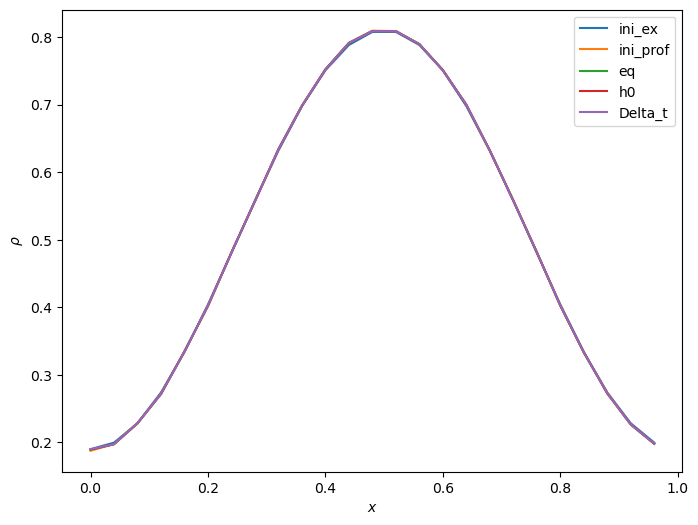

<Figure size 640x480 with 0 Axes>

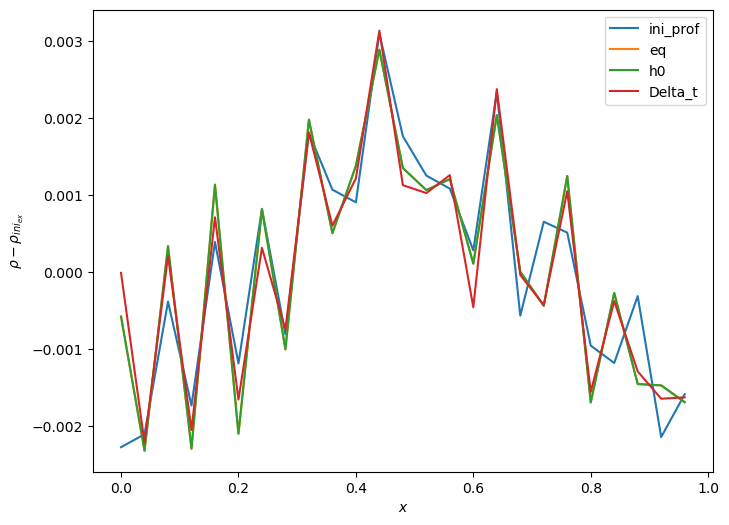

In [126]:
# testing plots for an random profile (profile No.10 here)

plt.figure()
fig = plt.figure(figsize=(8,6))
plt.plot(x_basis, rho_ini_ex[10,:], label='ini_ex')
plt.plot(x_basis, rho_ini_prof[10,:], label='ini_prof')
plt.plot(x_basis, rho_eq[10,:], label='eq')
plt.plot(x_basis, rho_h0[10,:], label='h0')
plt.plot(x_basis, rho_Delta_t[10,:], label='Delta_t')
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$')
plt.legend()
plt.show()



plt.figure()
fig = plt.figure(figsize=(8,6))
plt.plot(x_basis, rho_ini_prof[10,:] - rho_ini_ex[10,:], label='ini_prof')
plt.plot(x_basis, rho_eq[10,:] - rho_ini_ex[10,:], label='eq')
plt.plot(x_basis, rho_h0[10,:] - rho_ini_ex[10,:], label='h0')
plt.plot(x_basis, rho_Delta_t[10,:] - rho_ini_ex[10,:], label='Delta_t')
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho - \rho_{ini_{ex}}$')
plt.legend()
plt.show()

In [127]:
if FindOperator == 1:
  # load data for calculating operator


  # K_0 = <K gamma_b, gamma_b> @ rho_left_0 (rho_{b-1}), rho_middle_0 (rho_b), rho_right_0 (rho_{b+1})
  rho_middle_0 = data_rhoK['rho_middle_0'].flatten()
  rho_left_0 = data_rhoK['rho_left_0'].flatten()
  rho_right_0 = data_rhoK['rho_right_0'].flatten()
  # rho_ini_ex_middle_0 = data_rhoK['rho_ini_ex_middle_0'].flatten()
  # rho_ini_ex_left_0 = data_rhoK['rho_ini_ex_left_0'].flatten()
  # rho_ini_ex_right_0 = data_rhoK['rho_ini_ex_right_0'].flatten()
  K_0 = data_rhoK['K_0'].flatten()

  # K_1 = <K gamma_b, gamma_{b+1}> @ rho_left_1 (rho_b), rho_right_1 (rho_{b+1})
  rho_left_1 = data_rhoK['rho_left_1'].flatten()
  rho_right_1 = data_rhoK['rho_right_1'].flatten()
  # rho_ini_ex_left_1 = data_rhoK['rho_ini_ex_left_1'].flatten()
  # rho_ini_ex_right_1 = data_rhoK['rho_ini_ex_right_1'].flatten()
  K_1 = data_rhoK['K_1'].flatten()


  # define local density and density gradient
  # for K_0
  rho_0 = rho_middle_0
  drho_0 = ( rho_right_0 - rho_left_0 ) / ( 2.0 * dx_basis )
  d2rho_0 = ( rho_right_0 - 2 * rho_middle_0 + rho_left_0 ) / ( dx_basis ** 2 )
  # for K_1
  rho_1 = ( rho_right_1 + rho_left_1 ) / 2.0
  drho_1 = ( rho_right_1 - rho_left_1 ) / dx_basis
  # for K_1 on the left of K_0
  rho_1_left = ( rho_middle_0 + rho_left_0 ) / 2.0
  drho_1_left = ( rho_middle_0 - rho_left_0 ) / dx_basis
  # for K_1 on the right of K_0
  rho_1_right = ( rho_right_0 + rho_middle_0 ) / 2.0
  drho_1_right = ( rho_right_0 - rho_middle_0 ) / dx_basis


  slope_x = data_rhoK['slope_x']

  print('Shape of K_0:', rho_middle_0.shape, rho_left_0.shape, rho_right_0.shape, K_0.shape)
  print('Shape of K_1:', rho_left_1.shape, rho_right_1.shape, K_1.shape)
  print('Shape of slope_x:', slope_x.shape)


Shape of K_0: (700,) (700,) (700,) (700,)
Shape of K_1: (700,) (700,) (700,)
Shape of slope_x: (28, 25)


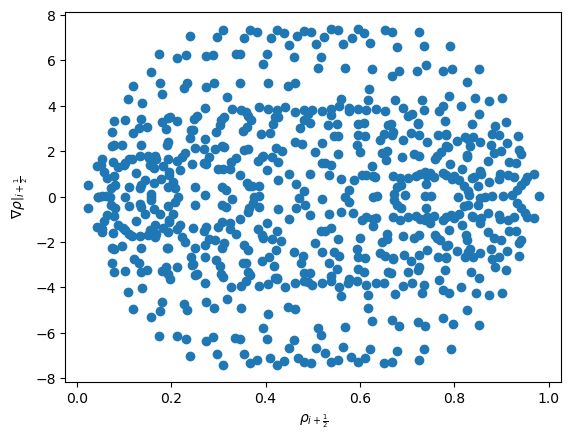

In [130]:
if FindOperator == 1:
  # data distribution in phase space of rho (& neighbor rho or grad rho)

  plt.figure()
  plt.scatter(rho_1, drho_1 * 50.0 / Ngamma, label=r'$\rho$')
  plt.xlabel(r'$\rho_{i+\frac{1}{2}}$')
  plt.ylabel(r'$\left. \nabla \rho \right|_{i+\frac{1}{2}}$')
  plt.show()

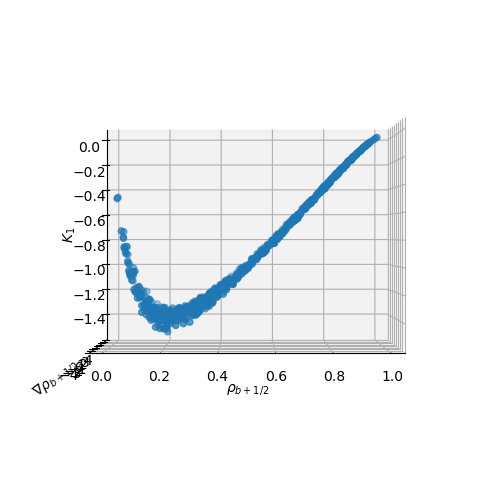

In [132]:
if FindOperator == 1:
  fig = plt.figure(figsize=(8,6))
  ax = fig.add_subplot(111, projection='3d')
  ax.view_init(0, -90)
  ax.scatter((rho_left_1+rho_right_1)/2, (rho_right_1-rho_left_1)/dx_basis, K_1)
  ax.set_xlabel(r'$\rho_{b+1/2}$')
  ax.set_ylabel(r'$\nabla \rho_{b+1/2}$')
  ax.set_zlabel(r'$K_1$')
  plt.show()

# 5. K_NN Training and Prediction

## Training data for K_NN

In [136]:
# K_0 = <gamma_b, K gamma_b>

rho_middle_0_train_K = rho_middle_0
rho_left_0_train_K = rho_left_0
rho_right_0_train_K = rho_right_0

K_0_train_K = K_0


# K_1 = <gamma_{b+1}, K gamma_b>

rho_left_1_train_K = rho_left_1
rho_right_1_train_K = rho_right_1

K_1_train_K = K_1

rho_0_train_K = rho_0
drho_0_train_K = drho_0
rho_1_train_K = rho_1
drho_1_train_K = drho_1
rho_1_left_train_K = rho_1_left
drho_1_left_train_K = drho_1_left
rho_1_right_train_K = rho_1_right
drho_1_right_train_K = drho_1_right


train_data_K = rho_middle_0_train_K, rho_left_0_train_K, rho_right_0_train_K, K_0_train_K, rho_left_1_train_K, rho_right_1_train_K, K_1_train_K,\
              dx_basis

## Train K_NN

In [139]:
# Set up layers and learning rate
layers_K = [2, 20, 20, 1]

learning_rate_K = 1e-2
activation_K = 'softplus'

print('layers_K =', layers_K)
print('learning_rate_K =', learning_rate_K)
print('activation_function_K =', activation_K)
print(FolderName2)

model_K = K1_NN(train_data_K, layers_K, lr=learning_rate_K, af=activation_K)


layers_K = [2, 20, 20, 1]
learning_rate_K = 0.01
activation_function_K = softplus
Arr_Nb2e3_G25_JL2.2_L2/
Number of K_0 data: (700,)
Number of K_1 data: (700,)
layers = [2, 20, 20, 1]
K_0 scale =  1.776471924285714
K_1 scale =  -0.8850096485714286
K_0 loss weight = 1.250647
K_1 loss weight = 4.989676


In [141]:
# Start training
model_K.train(num_epochs = 6000)

  0%|                                                                                 | 3/6000 [00:02<50:39,  1.97it/s]


Total loss = 7.357294082641602

loss K_0 = 3.683150291442871; loss K_1 = 3.6741435527801514

Total loss = 4.223855018615723

loss K_0 = 2.108876943588257; loss K_1 = 2.114978313446045


  0%|                                                                                 | 6/6000 [00:02<22:44,  4.39it/s]


Total loss = 2.978243350982666

loss K_0 = 1.4790033102035522; loss K_1 = 1.4992401599884033

Total loss = 3.7173638343811035

loss K_0 = 1.8446205854415894; loss K_1 = 1.8727432489395142

Total loss = 4.177608013153076

loss K_0 = 2.0742759704589844; loss K_1 = 2.103332042694092


  0%|                                                                                 | 9/6000 [00:02<14:45,  6.77it/s]


Total loss = 3.617326259613037

loss K_0 = 1.7955321073532104; loss K_1 = 1.821794033050537

Total loss = 2.6430463790893555

loss K_0 = 1.31076979637146; loss K_1 = 1.332276463508606

Total loss = 1.8826653957366943

loss K_0 = 0.9335110783576965; loss K_1 = 0.9491543769836426


  0%|▏                                                                               | 12/6000 [00:03<11:42,  8.52it/s]


Total loss = 1.6069164276123047

loss K_0 = 0.7986993789672852; loss K_1 = 0.8082170486450195

Total loss = 1.7017091512680054

loss K_0 = 0.8487555980682373; loss K_1 = 0.8529535531997681

Total loss = 1.846733570098877

loss K_0 = 0.9230307340621948; loss K_1 = 0.9237027764320374


  0%|▏                                                                               | 15/6000 [00:03<11:04,  9.00it/s]


Total loss = 1.7932122945785522

loss K_0 = 0.8969132900238037; loss K_1 = 0.8962990045547485

Total loss = 1.5094658136367798

loss K_0 = 0.7546691298484802; loss K_1 = 0.7547966837882996

Total loss = 1.1271851062774658

loss K_0 = 0.5624546408653259; loss K_1 = 0.5647305250167847


  0%|▏                                                                               | 17/6000 [00:03<10:18,  9.67it/s]


Total loss = 0.81339430809021

loss K_0 = 0.4041501581668854; loss K_1 = 0.409244179725647

Total loss = 0.6687719821929932

loss K_0 = 0.33042654395103455; loss K_1 = 0.3383454382419586

Total loss = 0.6834444403648376

loss K_0 = 0.33659449219703674; loss K_1 = 0.3468499481678009


  0%|▎                                                                               | 21/6000 [00:03<09:53, 10.08it/s]


Total loss = 0.758758544921875

loss K_0 = 0.3734743893146515; loss K_1 = 0.3852841258049011

Total loss = 0.7821804881095886

loss K_0 = 0.3848547041416168; loss K_1 = 0.3973257839679718

Total loss = 0.7030104398727417

loss K_0 = 0.3453750014305115; loss K_1 = 0.3576354384422302


  0%|▎                                                                               | 23/6000 [00:04<10:11,  9.78it/s]


Total loss = 0.5531644821166992

loss K_0 = 0.27093833684921265; loss K_1 = 0.28222617506980896

Total loss = 0.4095919728279114

loss K_0 = 0.1999245285987854; loss K_1 = 0.20966745913028717


  0%|▎                                                                               | 25/6000 [00:04<10:54,  9.13it/s]


Total loss = 0.3371168375015259

loss K_0 = 0.16460618376731873; loss K_1 = 0.17251065373420715

Total loss = 0.34967926144599915

loss K_0 = 0.17177435755729675; loss K_1 = 0.1779049038887024

Total loss = 0.4087226092815399

loss K_0 = 0.2019621729850769; loss K_1 = 0.206760436296463


  0%|▍                                                                               | 29/6000 [00:04<09:57, 10.00it/s]


Total loss = 0.4554615616798401

loss K_0 = 0.22562944889068604; loss K_1 = 0.22983211278915405

Total loss = 0.4525569677352905

loss K_0 = 0.22404660284519196; loss K_1 = 0.22851036489009857

Total loss = 0.4050559401512146

loss K_0 = 0.19977964460849762; loss K_1 = 0.2052762806415558


  1%|▍                                                                               | 31/6000 [00:04<09:35, 10.36it/s]


Total loss = 0.34929949045181274

loss K_0 = 0.17112332582473755; loss K_1 = 0.1781761795282364

Total loss = 0.32292112708091736

loss K_0 = 0.15706010162830353; loss K_1 = 0.16586102545261383

Total loss = 0.3384893536567688

loss K_0 = 0.1640399694442749; loss K_1 = 0.1744493991136551


  1%|▍                                                                               | 35/6000 [00:05<09:04, 10.95it/s]


Total loss = 0.3776349425315857

loss K_0 = 0.18301112949848175; loss K_1 = 0.19462381303310394

Total loss = 0.40795060992240906

loss K_0 = 0.19785073399543762; loss K_1 = 0.21009987592697144

Total loss = 0.4083009362220764

loss K_0 = 0.19801467657089233; loss K_1 = 0.21028625965118408


  1%|▍                                                                               | 37/6000 [00:05<08:58, 11.07it/s]


Total loss = 0.3822311460971832

loss K_0 = 0.185246542096138; loss K_1 = 0.19698460400104523

Total loss = 0.35095134377479553

loss K_0 = 0.17007862031459808; loss K_1 = 0.18087272346019745

Total loss = 0.3347453474998474

loss K_0 = 0.1625487059354782; loss K_1 = 0.172196626663208


  1%|▌                                                                               | 41/6000 [00:05<08:50, 11.24it/s]


Total loss = 0.33852943778038025

loss K_0 = 0.1649969071149826; loss K_1 = 0.17353253066539764

Total loss = 0.3512091636657715

loss K_0 = 0.1717682182788849; loss K_1 = 0.1794409602880478

Total loss = 0.356836199760437

loss K_0 = 0.1748161017894745; loss K_1 = 0.18202009797096252


  1%|▌                                                                               | 43/6000 [00:05<08:38, 11.49it/s]


Total loss = 0.3472791314125061

loss K_0 = 0.17005415260791779; loss K_1 = 0.1772249937057495

Total loss = 0.3268336057662964

loss K_0 = 0.15966154634952545; loss K_1 = 0.16717204451560974

Total loss = 0.3069775104522705

loss K_0 = 0.1494467854499817; loss K_1 = 0.15753073990345


  1%|▋                                                                               | 47/6000 [00:06<08:26, 11.75it/s]


Total loss = 0.29693126678466797

loss K_0 = 0.14410611987113953; loss K_1 = 0.15282514691352844

Total loss = 0.29750359058380127

loss K_0 = 0.14412520825862885; loss K_1 = 0.15337839722633362

Total loss = 0.3020657002925873

loss K_0 = 0.14624999463558197; loss K_1 = 0.1558157056570053


  1%|▋                                                                               | 49/6000 [00:06<08:31, 11.63it/s]


Total loss = 0.3027797341346741

loss K_0 = 0.14659279584884644; loss K_1 = 0.15618693828582764

Total loss = 0.2966125011444092

loss K_0 = 0.1436372697353363; loss K_1 = 0.15297524631023407

Total loss = 0.28667205572128296

loss K_0 = 0.13891030848026276; loss K_1 = 0.1477617472410202


  1%|▋                                                                               | 53/6000 [00:06<08:15, 11.99it/s]


Total loss = 0.2787153720855713

loss K_0 = 0.1352427750825882; loss K_1 = 0.1434725821018219

Total loss = 0.27633431553840637

loss K_0 = 0.13437236845493317; loss K_1 = 0.1419619470834732

Total loss = 0.27863627672195435

loss K_0 = 0.13579559326171875; loss K_1 = 0.1428406983613968


  1%|▋                                                                               | 55/6000 [00:06<08:12, 12.08it/s]


Total loss = 0.2816570997238159

loss K_0 = 0.13748620450496674; loss K_1 = 0.144170880317688

Total loss = 0.28177860379219055

loss K_0 = 0.1376131922006607; loss K_1 = 0.14416541159152985

Total loss = 0.2782789468765259

loss K_0 = 0.1358191967010498; loss K_1 = 0.14245975017547607


  1%|▊                                                                               | 59/6000 [00:07<08:22, 11.82it/s]


Total loss = 0.2733007073402405

loss K_0 = 0.13320189714431763; loss K_1 = 0.14009879529476166

Total loss = 0.2697114050388336

loss K_0 = 0.13123604655265808; loss K_1 = 0.13847535848617554

Total loss = 0.2687894105911255

loss K_0 = 0.1306060552597046; loss K_1 = 0.1381833404302597


  1%|▊                                                                               | 61/6000 [00:07<08:39, 11.44it/s]


Total loss = 0.2694939970970154

loss K_0 = 0.13083109259605408; loss K_1 = 0.1386628895998001

Total loss = 0.2696337103843689

loss K_0 = 0.13084177672863007; loss K_1 = 0.13879194855690002

Total loss = 0.267751544713974

loss K_0 = 0.12991881370544434; loss K_1 = 0.13783273100852966


  1%|▊                                                                               | 65/6000 [00:07<09:17, 10.65it/s]


Total loss = 0.2641487121582031

loss K_0 = 0.12820473313331604; loss K_1 = 0.13594397902488708

Total loss = 0.26036977767944336

loss K_0 = 0.1264493614435196; loss K_1 = 0.13392040133476257

Total loss = 0.25779032707214355

loss K_0 = 0.12530915439128876; loss K_1 = 0.1324811577796936


  1%|▉                                                                               | 67/6000 [00:08<09:54,  9.97it/s]


Total loss = 0.2565695643424988

loss K_0 = 0.12483061850070953; loss K_1 = 0.13173894584178925

Total loss = 0.2557423710823059

loss K_0 = 0.12450405210256577; loss K_1 = 0.13123832643032074

Total loss = 0.2541969418525696

loss K_0 = 0.12375816702842712; loss K_1 = 0.13043877482414246


  1%|▉                                                                               | 71/6000 [00:08<08:54, 11.08it/s]


Total loss = 0.251613050699234

loss K_0 = 0.12243248522281647; loss K_1 = 0.12918056547641754

Total loss = 0.2486065924167633

loss K_0 = 0.12084860354661942; loss K_1 = 0.1277579963207245

Total loss = 0.24608108401298523

loss K_0 = 0.11948172748088837; loss K_1 = 0.12659935653209686


  1%|▉                                                                               | 73/6000 [00:08<08:48, 11.22it/s]


Total loss = 0.24443809688091278

loss K_0 = 0.11855955421924591; loss K_1 = 0.12587854266166687

Total loss = 0.2433234453201294

loss K_0 = 0.11792882531881332; loss K_1 = 0.12539461255073547

Total loss = 0.24204778671264648

loss K_0 = 0.11726032197475433; loss K_1 = 0.12478745728731155


  1%|█                                                                               | 77/6000 [00:08<08:39, 11.40it/s]


Total loss = 0.2402259111404419

loss K_0 = 0.11636575311422348; loss K_1 = 0.12386016547679901

Total loss = 0.2380526214838028

loss K_0 = 0.11533555388450623; loss K_1 = 0.12271706759929657

Total loss = 0.23603005707263947

loss K_0 = 0.11440499126911163; loss K_1 = 0.12162506580352783


  1%|█                                                                               | 79/6000 [00:09<08:24, 11.73it/s]


Total loss = 0.23446892201900482

loss K_0 = 0.11370918899774551; loss K_1 = 0.12075973302125931

Total loss = 0.23323766887187958

loss K_0 = 0.11316285282373428; loss K_1 = 0.1200748160481453

Total loss = 0.23194244503974915

loss K_0 = 0.11255521327257156; loss K_1 = 0.11938723921775818


  1%|█                                                                               | 83/6000 [00:09<08:13, 11.99it/s]


Total loss = 0.23031070828437805

loss K_0 = 0.11174500733613968; loss K_1 = 0.11856570094823837

Total loss = 0.2284063696861267

loss K_0 = 0.11076858639717102; loss K_1 = 0.11763777583837509

Total loss = 0.22651100158691406

loss K_0 = 0.1097787469625473; loss K_1 = 0.11673226207494736


  1%|█▏                                                                              | 85/6000 [00:09<08:10, 12.07it/s]


Total loss = 0.22483152151107788

loss K_0 = 0.10889473557472229; loss K_1 = 0.11593678593635559

Total loss = 0.2233252376317978

loss K_0 = 0.10811039805412292; loss K_1 = 0.11521483957767487

Total loss = 0.2217828929424286

loss K_0 = 0.10733183473348618; loss K_1 = 0.11445105820894241


  1%|█▏                                                                              | 89/6000 [00:09<07:52, 12.50it/s]


Total loss = 0.220051571726799

loss K_0 = 0.10648650676012039; loss K_1 = 0.11356506496667862

Total loss = 0.21816903352737427

loss K_0 = 0.10558995604515076; loss K_1 = 0.11257907003164291

Total loss = 0.2163001000881195

loss K_0 = 0.10471541434526443; loss K_1 = 0.11158467829227448


  2%|█▏                                                                              | 91/6000 [00:10<08:05, 12.17it/s]


Total loss = 0.21456578373908997

loss K_0 = 0.10391117632389069; loss K_1 = 0.11065461486577988

Total loss = 0.2129420042037964

loss K_0 = 0.10315333306789398; loss K_1 = 0.10978866368532181

Total loss = 0.2113102227449417

loss K_0 = 0.1023741289973259; loss K_1 = 0.10893609374761581


  2%|█▎                                                                              | 95/6000 [00:10<07:54, 12.44it/s]


Total loss = 0.2095867395401001

loss K_0 = 0.10152864456176758; loss K_1 = 0.10805809497833252

Total loss = 0.20779553055763245

loss K_0 = 0.1006314754486084; loss K_1 = 0.10716405510902405

Total loss = 0.20602697134017944

loss K_0 = 0.09973489493131638; loss K_1 = 0.10629208385944366


  2%|█▎                                                                              | 97/6000 [00:10<07:56, 12.40it/s]


Total loss = 0.20433998107910156

loss K_0 = 0.09887764602899551; loss K_1 = 0.10546234250068665

Total loss = 0.20271027088165283

loss K_0 = 0.09805626422166824; loss K_1 = 0.10465401411056519

Total loss = 0.2010670006275177

loss K_0 = 0.09724114835262299; loss K_1 = 0.10382584482431412


  2%|█▎                                                                             | 101/6000 [00:10<07:54, 12.42it/s]


Total loss = 0.1993669867515564

loss K_0 = 0.09641239792108536; loss K_1 = 0.10295458883047104

Total loss = 0.19762985408306122

loss K_0 = 0.09557721018791199; loss K_1 = 0.10205264389514923

Total loss = 0.19590695202350616

loss K_0 = 0.09475544095039368; loss K_1 = 0.10115151107311249


  2%|█▎                                                                             | 103/6000 [00:11<07:58, 12.33it/s]


Total loss = 0.19422471523284912

loss K_0 = 0.09395311772823334; loss K_1 = 0.10027159750461578

Total loss = 0.1925627887248993

loss K_0 = 0.09315359592437744; loss K_1 = 0.09940918534994125

Total loss = 0.19088149070739746

loss K_0 = 0.09233304113149643; loss K_1 = 0.09854845702648163


  2%|█▍                                                                             | 107/6000 [00:11<07:46, 12.64it/s]


Total loss = 0.18916437029838562

loss K_0 = 0.09148253500461578; loss K_1 = 0.09768183529376984

Total loss = 0.18743062019348145

loss K_0 = 0.09061437100172043; loss K_1 = 0.09681624919176102

Total loss = 0.18571080267429352

loss K_0 = 0.08974872529506683; loss K_1 = 0.09596207737922668


  2%|█▍                                                                             | 109/6000 [00:11<07:51, 12.48it/s]


Total loss = 0.18401560187339783

loss K_0 = 0.08889657258987427; loss K_1 = 0.09511902183294296

Total loss = 0.1823299527168274

loss K_0 = 0.0880550965666771; loss K_1 = 0.0942748636007309

Total loss = 0.1806337833404541

loss K_0 = 0.08721677958965302; loss K_1 = 0.09341701120138168


  2%|█▍                                                                             | 111/6000 [00:11<07:58, 12.32it/s]


Total loss = 0.17892414331436157

loss K_0 = 0.0863800197839737; loss K_1 = 0.09254412353038788

Total loss = 0.17721602320671082

loss K_0 = 0.08554977178573608; loss K_1 = 0.09166624397039413


  2%|█▍                                                                             | 113/6000 [00:11<08:55, 11.00it/s]


Total loss = 0.17552438378334045

loss K_0 = 0.08472955971956253; loss K_1 = 0.09079483151435852

Total loss = 0.17384931445121765

loss K_0 = 0.08391528576612473; loss K_1 = 0.08993403613567352


  2%|█▌                                                                             | 117/6000 [00:12<08:51, 11.06it/s]


Total loss = 0.1721784919500351

loss K_0 = 0.08309768885374069; loss K_1 = 0.0890808030962944

Total loss = 0.17050206661224365

loss K_0 = 0.08227072656154633; loss K_1 = 0.08823134750127792

Total loss = 0.16882246732711792

loss K_0 = 0.08143648505210876; loss K_1 = 0.08738597482442856


  2%|█▌                                                                             | 119/6000 [00:12<08:27, 11.59it/s]


Total loss = 0.16714982688426971

loss K_0 = 0.08060265332460403; loss K_1 = 0.08654717355966568

Total loss = 0.16549062728881836

loss K_0 = 0.07977577298879623; loss K_1 = 0.08571486175060272

Total loss = 0.16384205222129822

loss K_0 = 0.0789574608206749; loss K_1 = 0.08488459140062332


  2%|█▌                                                                             | 123/6000 [00:12<08:00, 12.24it/s]


Total loss = 0.16219715774059296

loss K_0 = 0.07814611494541168; loss K_1 = 0.08405104279518127

Total loss = 0.16055390238761902

loss K_0 = 0.07734090089797974; loss K_1 = 0.08321300148963928

Total loss = 0.15891703963279724

loss K_0 = 0.07654287666082382; loss K_1 = 0.08237416297197342


  2%|█▋                                                                             | 125/6000 [00:12<07:46, 12.59it/s]


Total loss = 0.15729287266731262

loss K_0 = 0.07575280219316483; loss K_1 = 0.0815400704741478

Total loss = 0.15568289160728455

loss K_0 = 0.07496882230043411; loss K_1 = 0.08071407675743103

Total loss = 0.1540832221508026

loss K_0 = 0.07418708503246307; loss K_1 = 0.07989614456892014


  2%|█▋                                                                             | 129/6000 [00:13<07:49, 12.52it/s]


Total loss = 0.1524919867515564

loss K_0 = 0.07340563833713531; loss K_1 = 0.07908635586500168

Total loss = 0.15091030299663544

loss K_0 = 0.07262534648180008; loss K_1 = 0.07828495651483536

Total loss = 0.14934208989143372

loss K_0 = 0.07184955477714539; loss K_1 = 0.07749253511428833


  2%|█▋                                                                             | 131/6000 [00:13<07:48, 12.52it/s]


Total loss = 0.14779040217399597

loss K_0 = 0.07108169794082642; loss K_1 = 0.07670870423316956

Total loss = 0.14625495672225952

loss K_0 = 0.07032337039709091; loss K_1 = 0.07593157887458801

Total loss = 0.14473405480384827

loss K_0 = 0.06957480311393738; loss K_1 = 0.07515925914049149


  2%|█▊                                                                             | 135/6000 [00:13<07:41, 12.71it/s]


Total loss = 0.14322738349437714

loss K_0 = 0.06883591413497925; loss K_1 = 0.07439146935939789

Total loss = 0.1417369842529297

loss K_0 = 0.06810694187879562; loss K_1 = 0.07363003492355347

Total loss = 0.14026391506195068

loss K_0 = 0.06738711148500443; loss K_1 = 0.07287681102752686


  2%|█▊                                                                             | 137/6000 [00:13<07:40, 12.72it/s]


Total loss = 0.13880762457847595

loss K_0 = 0.06667491048574448; loss K_1 = 0.07213271409273148

Total loss = 0.137369304895401

loss K_0 = 0.06596975773572922; loss K_1 = 0.07139955461025238

Total loss = 0.13594895601272583

loss K_0 = 0.06527099013328552; loss K_1 = 0.0706779733300209


  2%|█▊                                                                             | 141/6000 [00:14<07:31, 12.99it/s]


Total loss = 0.13454723358154297

loss K_0 = 0.06457912921905518; loss K_1 = 0.06996811181306839

Total loss = 0.13316607475280762

loss K_0 = 0.06389592587947845; loss K_1 = 0.06927015632390976

Total loss = 0.13180707395076752

loss K_0 = 0.06322330981492996; loss K_1 = 0.06858376413583755


  2%|█▉                                                                             | 143/6000 [00:14<07:29, 13.03it/s]


Total loss = 0.13047084212303162

loss K_0 = 0.06256265938282013; loss K_1 = 0.06790819019079208

Total loss = 0.12915751338005066

loss K_0 = 0.06191473454236984; loss K_1 = 0.06724278628826141

Total loss = 0.12786753475666046

loss K_0 = 0.06127987802028656; loss K_1 = 0.0665876567363739


  2%|█▉                                                                             | 147/6000 [00:14<07:33, 12.91it/s]


Total loss = 0.12660197913646698

loss K_0 = 0.06065822020173073; loss K_1 = 0.06594375520944595

Total loss = 0.12536190450191498

loss K_0 = 0.06004948541522026; loss K_1 = 0.06531241536140442

Total loss = 0.12414777278900146

loss K_0 = 0.05945311114192009; loss K_1 = 0.06469466537237167


  2%|█▉                                                                             | 149/6000 [00:14<07:36, 12.81it/s]


Total loss = 0.12295959889888763

loss K_0 = 0.05886846408247948; loss K_1 = 0.06409113109111786

Total loss = 0.12179555743932724

loss K_0 = 0.05829477310180664; loss K_1 = 0.0635007843375206

Total loss = 0.12065690755844116

loss K_0 = 0.05773305147886276; loss K_1 = 0.0629238560795784


  3%|██                                                                             | 153/6000 [00:15<07:34, 12.88it/s]


Total loss = 0.11954405158758163

loss K_0 = 0.05718398466706276; loss K_1 = 0.062360066920518875

Total loss = 0.11845658719539642

loss K_0 = 0.05664820596575737; loss K_1 = 0.06180838122963905

Total loss = 0.11739405989646912

loss K_0 = 0.05612567067146301; loss K_1 = 0.061268389225006104


  3%|██                                                                             | 155/6000 [00:15<07:32, 12.91it/s]


Total loss = 0.11635679006576538

loss K_0 = 0.05561678484082222; loss K_1 = 0.06074000149965286

Total loss = 0.11534442752599716

loss K_0 = 0.05512090399861336; loss K_1 = 0.060223523527383804

Total loss = 0.11435767263174057

loss K_0 = 0.054638005793094635; loss K_1 = 0.059719666838645935


  3%|██                                                                             | 159/6000 [00:15<07:28, 13.01it/s]


Total loss = 0.11339788883924484

loss K_0 = 0.05416782572865486; loss K_1 = 0.05923006311058998

Total loss = 0.11246472597122192

loss K_0 = 0.05370958894491196; loss K_1 = 0.058755140751600266

Total loss = 0.11155775189399719

loss K_0 = 0.053262822329998016; loss K_1 = 0.05829492583870888


  3%|██                                                                             | 161/6000 [00:15<07:27, 13.06it/s]


Total loss = 0.11067699640989304

loss K_0 = 0.052827831357717514; loss K_1 = 0.05784916505217552

Total loss = 0.109822578728199

loss K_0 = 0.0524052269756794; loss K_1 = 0.05741735175251961

Total loss = 0.10899436473846436

loss K_0 = 0.051995649933815; loss K_1 = 0.05699871480464935


  3%|██▏                                                                            | 165/6000 [00:16<07:32, 12.91it/s]


Total loss = 0.10819185525178909

loss K_0 = 0.05159942805767059; loss K_1 = 0.0565924271941185

Total loss = 0.1074109673500061

loss K_0 = 0.05121489614248276; loss K_1 = 0.056196071207523346

Total loss = 0.10664868354797363

loss K_0 = 0.05084175243973732; loss K_1 = 0.05580693110823631


  3%|██▏                                                                            | 169/6000 [00:16<07:38, 12.72it/s]


Total loss = 0.10590687394142151

loss K_0 = 0.05048031359910965; loss K_1 = 0.05542656034231186

Total loss = 0.105189248919487

loss K_0 = 0.05013083666563034; loss K_1 = 0.05505841225385666

Total loss = 0.10449503362178802

loss K_0 = 0.04979150369763374; loss K_1 = 0.05470352619886398

Total loss = 0.10382243990898132

loss K_0 = 0.049460601061582565; loss K_1 = 0.054361842572689056


  3%|██▎                                                                            | 171/6000 [00:16<07:42, 12.61it/s]


Total loss = 0.10317056626081467

loss K_0 = 0.0491376630961895; loss K_1 = 0.05403290316462517

Total loss = 0.10253448784351349

loss K_0 = 0.048821430653333664; loss K_1 = 0.05371306091547012

Total loss = 0.1019180417060852

loss K_0 = 0.048515837639570236; loss K_1 = 0.05340220779180527

Total loss = 0.10131804645061493

loss K_0 = 0.048220194876194; loss K_1 = 0.05309785157442093


  3%|██▎                                                                            | 175/6000 [00:16<07:21, 13.21it/s]


Total loss = 0.10073481500148773

loss K_0 = 0.0479351244866848; loss K_1 = 0.052799686789512634

Total loss = 0.10017001628875732

loss K_0 = 0.047660477459430695; loss K_1 = 0.05250953882932663

Total loss = 0.09962266683578491

loss K_0 = 0.04739448428153992; loss K_1 = 0.052228182554244995


  3%|██▎                                                                            | 179/6000 [00:17<07:21, 13.17it/s]


Total loss = 0.09908939898014069

loss K_0 = 0.04713503643870354; loss K_1 = 0.05195436254143715

Total loss = 0.09856754541397095

loss K_0 = 0.046880606561899185; loss K_1 = 0.05168693885207176

Total loss = 0.09805954992771149

loss K_0 = 0.04663227126002312; loss K_1 = 0.05142727866768837


  3%|██▍                                                                            | 181/6000 [00:17<07:28, 12.96it/s]


Total loss = 0.09756536036729813

loss K_0 = 0.04638959467411041; loss K_1 = 0.051175765693187714

Total loss = 0.09708423912525177

loss K_0 = 0.04615277424454689; loss K_1 = 0.05093146488070488

Total loss = 0.09661729633808136

loss K_0 = 0.045922406017780304; loss K_1 = 0.050694894045591354


  3%|██▍                                                                            | 185/6000 [00:17<07:39, 12.66it/s]


Total loss = 0.09616415947675705

loss K_0 = 0.045698609203100204; loss K_1 = 0.050465550273656845

Total loss = 0.0957241952419281

loss K_0 = 0.04548145830631256; loss K_1 = 0.05024273321032524

Total loss = 0.09529595077037811

loss K_0 = 0.045270681381225586; loss K_1 = 0.050025273114442825


  3%|██▍                                                                            | 187/6000 [00:17<07:44, 12.50it/s]


Total loss = 0.09487798064947128

loss K_0 = 0.04506637156009674; loss K_1 = 0.04981160908937454

Total loss = 0.09447051584720612

loss K_0 = 0.04486818611621857; loss K_1 = 0.04960232600569725

Total loss = 0.0940692275762558

loss K_0 = 0.044674426317214966; loss K_1 = 0.04939480125904083


  3%|██▌                                                                            | 191/6000 [00:18<07:41, 12.59it/s]


Total loss = 0.09367881715297699

loss K_0 = 0.04448692128062248; loss K_1 = 0.04919189587235451

Total loss = 0.09329918771982193

loss K_0 = 0.0443042516708374; loss K_1 = 0.04899493604898453

Total loss = 0.09292925894260406

loss K_0 = 0.04412482678890228; loss K_1 = 0.04880443215370178


  3%|██▌                                                                            | 193/6000 [00:18<07:38, 12.68it/s]


Total loss = 0.09256790578365326

loss K_0 = 0.04394769296050072; loss K_1 = 0.04862021282315254

Total loss = 0.09221501648426056

loss K_0 = 0.043773241341114044; loss K_1 = 0.04844177886843681

Total loss = 0.09187087416648865

loss K_0 = 0.04360261186957359; loss K_1 = 0.04826826602220535


  3%|██▌                                                                            | 197/6000 [00:18<07:35, 12.75it/s]


Total loss = 0.09153521806001663

loss K_0 = 0.04343679919838905; loss K_1 = 0.04809841886162758

Total loss = 0.0912071168422699

loss K_0 = 0.04327617958188057; loss K_1 = 0.04793093353509903

Total loss = 0.09088592231273651

loss K_0 = 0.04312064126133919; loss K_1 = 0.04776528477668762


  3%|██▌                                                                            | 199/6000 [00:18<07:37, 12.68it/s]


Total loss = 0.09057161211967468

loss K_0 = 0.04296976700425148; loss K_1 = 0.0476018488407135

Total loss = 0.0902642235159874

loss K_0 = 0.04282272979617119; loss K_1 = 0.04744149371981621

Total loss = 0.08996334671974182

loss K_0 = 0.04267844557762146; loss K_1 = 0.04728490114212036


  3%|██▋                                                                            | 203/6000 [00:19<07:20, 13.16it/s]


Total loss = 0.08966763317584991

loss K_0 = 0.04253649339079857; loss K_1 = 0.047131139785051346

Total loss = 0.08937770128250122

loss K_0 = 0.042396605014801025; loss K_1 = 0.046981096267700195

Total loss = 0.0890931636095047

loss K_0 = 0.04225834831595421; loss K_1 = 0.04683481156826019


  3%|██▋                                                                            | 205/6000 [00:19<07:31, 12.83it/s]


Total loss = 0.08881376683712006

loss K_0 = 0.0421217605471611; loss K_1 = 0.046692002564668655

Total loss = 0.08853943645954132

loss K_0 = 0.04198729991912842; loss K_1 = 0.0465521365404129

Total loss = 0.08827003836631775

loss K_0 = 0.041855454444885254; loss K_1 = 0.046414583921432495


  3%|██▊                                                                            | 209/6000 [00:19<08:40, 11.14it/s]


Total loss = 0.08800522983074188

loss K_0 = 0.0417264848947525; loss K_1 = 0.04627874493598938

Total loss = 0.08774473518133163

loss K_0 = 0.04160040244460106; loss K_1 = 0.046144332736730576

Total loss = 0.0874883383512497

loss K_0 = 0.04147692397236824; loss K_1 = 0.046011414378881454


  4%|██▊                                                                            | 211/6000 [00:19<08:16, 11.66it/s]


Total loss = 0.0872359350323677

loss K_0 = 0.041355617344379425; loss K_1 = 0.04588031768798828

Total loss = 0.08698730170726776

loss K_0 = 0.041235990822315216; loss K_1 = 0.04575130715966225

Total loss = 0.08674213290214539

loss K_0 = 0.04111761972308159; loss K_1 = 0.0456245094537735


  4%|██▊                                                                            | 215/6000 [00:20<07:51, 12.27it/s]


Total loss = 0.08650019764900208

loss K_0 = 0.04100039601325989; loss K_1 = 0.04549979791045189

Total loss = 0.0862613394856453

loss K_0 = 0.04088443145155907; loss K_1 = 0.04537690803408623

Total loss = 0.08602546155452728

loss K_0 = 0.0407700389623642; loss K_1 = 0.045255422592163086


  4%|██▊                                                                            | 217/6000 [00:20<08:09, 11.80it/s]


Total loss = 0.08579231798648834

loss K_0 = 0.04065736383199692; loss K_1 = 0.045134950429201126

Total loss = 0.08556176722049713

loss K_0 = 0.04054649919271469; loss K_1 = 0.04501527175307274

Total loss = 0.08533364534378052

loss K_0 = 0.04043726623058319; loss K_1 = 0.04489637538790703


  4%|██▉                                                                            | 221/6000 [00:20<07:55, 12.14it/s]


Total loss = 0.08510777354240417

loss K_0 = 0.04032935947179794; loss K_1 = 0.04477841779589653

Total loss = 0.08488410711288452

loss K_0 = 0.04022245854139328; loss K_1 = 0.04466165229678154

Total loss = 0.08466239273548126

loss K_0 = 0.04011620581150055; loss K_1 = 0.04454619064927101


  4%|██▉                                                                            | 223/6000 [00:20<07:48, 12.33it/s]


Total loss = 0.08444248139858246

loss K_0 = 0.04001045972108841; loss K_1 = 0.04443201795220375

Total loss = 0.08422423899173737

loss K_0 = 0.03990525007247925; loss K_1 = 0.04431898891925812

Total loss = 0.08400757610797882

loss K_0 = 0.039800748229026794; loss K_1 = 0.044206831604242325


  4%|██▉                                                                            | 227/6000 [00:21<07:33, 12.74it/s]


Total loss = 0.08379237353801727

loss K_0 = 0.03969709202647209; loss K_1 = 0.04409527778625488

Total loss = 0.08357848227024078

loss K_0 = 0.03959435224533081; loss K_1 = 0.04398413375020027

Total loss = 0.0833657830953598

loss K_0 = 0.03949247673153877; loss K_1 = 0.04387330263853073


  4%|███                                                                            | 229/6000 [00:21<07:33, 12.72it/s]


Total loss = 0.08315419405698776

loss K_0 = 0.039391301572322845; loss K_1 = 0.04376289248466492

Total loss = 0.0829436257481575

loss K_0 = 0.03929062560200691; loss K_1 = 0.04365300014615059

Total loss = 0.08273397386074066

loss K_0 = 0.03919025510549545; loss K_1 = 0.04354371875524521


  4%|███                                                                            | 233/6000 [00:21<07:25, 12.94it/s]


Total loss = 0.0825251042842865

loss K_0 = 0.03909007087349892; loss K_1 = 0.043435029685497284

Total loss = 0.08231699466705322

loss K_0 = 0.03899012506008148; loss K_1 = 0.04332686588168144

Total loss = 0.08210951089859009

loss K_0 = 0.03889048472046852; loss K_1 = 0.04321902617812157


  4%|███                                                                            | 235/6000 [00:21<07:31, 12.76it/s]


Total loss = 0.08190262317657471

loss K_0 = 0.03879128396511078; loss K_1 = 0.04311133921146393

Total loss = 0.08169620484113693

loss K_0 = 0.038692548871040344; loss K_1 = 0.04300365597009659

Total loss = 0.08149024844169617

loss K_0 = 0.038594264537096024; loss K_1 = 0.04289598390460014


  4%|███▏                                                                           | 239/6000 [00:21<07:26, 12.90it/s]


Total loss = 0.08128464967012405

loss K_0 = 0.03849632292985916; loss K_1 = 0.04278832674026489

Total loss = 0.08107936382293701

loss K_0 = 0.038398560136556625; loss K_1 = 0.042680803686380386

Total loss = 0.08087436109781265

loss K_0 = 0.03830087184906006; loss K_1 = 0.042573489248752594


  4%|███▏                                                                           | 241/6000 [00:22<07:23, 12.98it/s]


Total loss = 0.0806695967912674

loss K_0 = 0.03820318356156349; loss K_1 = 0.042466409504413605

Total loss = 0.0804644525051117

loss K_0 = 0.03810522332787514; loss K_1 = 0.04235922545194626

Total loss = 0.08025902509689331

loss K_0 = 0.03800617903470993; loss K_1 = 0.04225284978747368


  4%|███▏                                                                           | 243/6000 [00:22<07:36, 12.61it/s]


Total loss = 0.08005376160144806

loss K_0 = 0.03790692239999771; loss K_1 = 0.04214683920145035

Total loss = 0.07984867691993713

loss K_0 = 0.03780828416347504; loss K_1 = 0.0420403890311718


  4%|███▎                                                                           | 247/6000 [00:22<08:19, 11.52it/s]


Total loss = 0.07964357733726501

loss K_0 = 0.037710681557655334; loss K_1 = 0.04193289577960968

Total loss = 0.07943829894065857

loss K_0 = 0.03761407360434532; loss K_1 = 0.04182422161102295

Total loss = 0.07923302054405212

loss K_0 = 0.03751807287335396; loss K_1 = 0.041714951395988464


  4%|███▎                                                                           | 249/6000 [00:22<08:10, 11.72it/s]


Total loss = 0.07902784645557404

loss K_0 = 0.037422023713588715; loss K_1 = 0.04160582646727562

Total loss = 0.07882264256477356

loss K_0 = 0.03732522949576378; loss K_1 = 0.04149741306900978

Total loss = 0.0786171481013298

loss K_0 = 0.03722729533910751; loss K_1 = 0.04138985276222229


  4%|███▎                                                                           | 253/6000 [00:23<08:42, 10.99it/s]


Total loss = 0.07841146737337112

loss K_0 = 0.03712848201394081; loss K_1 = 0.04128298535943031

Total loss = 0.07820568233728409

loss K_0 = 0.03702932223677635; loss K_1 = 0.041176360100507736

Total loss = 0.07799982279539108

loss K_0 = 0.03693041577935219; loss K_1 = 0.041069407016038895


  4%|███▎                                                                           | 255/6000 [00:23<08:23, 11.42it/s]


Total loss = 0.07779376208782196

loss K_0 = 0.036832042038440704; loss K_1 = 0.040961723774671555

Total loss = 0.07758750766515732

loss K_0 = 0.036734215915203094; loss K_1 = 0.040853291749954224

Total loss = 0.07738115638494492

loss K_0 = 0.036636676639318466; loss K_1 = 0.04074447974562645


  4%|███▍                                                                           | 259/6000 [00:23<07:54, 12.09it/s]


Total loss = 0.07717469334602356

loss K_0 = 0.0365389846265316; loss K_1 = 0.04063570871949196

Total loss = 0.07696773111820221

loss K_0 = 0.03644062206149101; loss K_1 = 0.0405271053314209

Total loss = 0.0767594575881958

loss K_0 = 0.036340102553367615; loss K_1 = 0.040419358760118484


  4%|███▍                                                                           | 261/6000 [00:23<07:59, 11.96it/s]


Total loss = 0.07655096054077148

loss K_0 = 0.036238811910152435; loss K_1 = 0.04031214863061905

Total loss = 0.07634256780147552

loss K_0 = 0.03613812476396561; loss K_1 = 0.04020443931221962

Total loss = 0.0761338323354721

loss K_0 = 0.03603872284293175; loss K_1 = 0.04009510949254036


  4%|███▍                                                                           | 265/6000 [00:24<07:42, 12.40it/s]


Total loss = 0.07592464983463287

loss K_0 = 0.03594071790575981; loss K_1 = 0.039983928203582764

Total loss = 0.07571528851985931

loss K_0 = 0.035843636840581894; loss K_1 = 0.03987164795398712

Total loss = 0.0755060613155365

loss K_0 = 0.03574658930301666; loss K_1 = 0.03975946828722954


  4%|███▌                                                                           | 267/6000 [00:24<07:28, 12.78it/s]


Total loss = 0.07529672980308533

loss K_0 = 0.03564850986003876; loss K_1 = 0.03964822366833687

Total loss = 0.07508698105812073

loss K_0 = 0.035548821091651917; loss K_1 = 0.03953816369175911

Total loss = 0.07487690448760986

loss K_0 = 0.035447828471660614; loss K_1 = 0.03942907601594925


  5%|███▌                                                                           | 271/6000 [00:24<07:24, 12.90it/s]


Total loss = 0.07466672360897064

loss K_0 = 0.03534639626741409; loss K_1 = 0.03932033106684685

Total loss = 0.07445642352104187

loss K_0 = 0.03524533286690712; loss K_1 = 0.03921109437942505

Total loss = 0.07424579560756683

loss K_0 = 0.035145003348588943; loss K_1 = 0.03910078853368759


  5%|███▌                                                                           | 273/6000 [00:24<07:28, 12.76it/s]


Total loss = 0.0740349069237709

loss K_0 = 0.03504539281129837; loss K_1 = 0.038989514112472534

Total loss = 0.07382392883300781

loss K_0 = 0.03494606912136078; loss K_1 = 0.038877859711647034

Total loss = 0.07361291348934174

loss K_0 = 0.03484642505645752; loss K_1 = 0.038766488432884216


  5%|███▋                                                                           | 277/6000 [00:25<07:39, 12.44it/s]


Total loss = 0.07340170443058014

loss K_0 = 0.0347459502518177; loss K_1 = 0.03865575045347214

Total loss = 0.07319026440382004

loss K_0 = 0.03464462608098984; loss K_1 = 0.0385456383228302

Total loss = 0.0729786679148674

loss K_0 = 0.03454287350177765; loss K_1 = 0.03843579441308975


  5%|███▋                                                                           | 279/6000 [00:25<07:41, 12.41it/s]


Total loss = 0.072766974568367

loss K_0 = 0.03444130718708038; loss K_1 = 0.03832566738128662

Total loss = 0.07255511730909348

loss K_0 = 0.03434031829237938; loss K_1 = 0.038214799016714096

Total loss = 0.07234252244234085

loss K_0 = 0.0342397503554821; loss K_1 = 0.03810277208685875


  5%|███▋                                                                           | 283/6000 [00:25<07:46, 12.26it/s]


Total loss = 0.0721292570233345

loss K_0 = 0.03413838893175125; loss K_1 = 0.03799086809158325

Total loss = 0.07191571593284607

loss K_0 = 0.03403661772608757; loss K_1 = 0.0378790982067585

Total loss = 0.07170204818248749

loss K_0 = 0.033934906125068665; loss K_1 = 0.037767138332128525


  5%|███▊                                                                           | 285/6000 [00:25<07:45, 12.28it/s]


Total loss = 0.07148826122283936

loss K_0 = 0.03383361175656319; loss K_1 = 0.03765464946627617

Total loss = 0.07127436250448227

loss K_0 = 0.0337328240275383; loss K_1 = 0.03754153847694397

Total loss = 0.07106037437915802

loss K_0 = 0.033632341772317886; loss K_1 = 0.037428032606840134


  5%|███▊                                                                           | 289/6000 [00:26<07:51, 12.12it/s]


Total loss = 0.07084522396326065

loss K_0 = 0.03353121504187584; loss K_1 = 0.03731400892138481

Total loss = 0.07062944769859314

loss K_0 = 0.033428311347961426; loss K_1 = 0.037201136350631714

Total loss = 0.07041344791650772

loss K_0 = 0.03332432731986046; loss K_1 = 0.03708912059664726


  5%|███▊                                                                           | 291/6000 [00:26<08:11, 11.61it/s]


Total loss = 0.07019698619842529

loss K_0 = 0.03322010487318039; loss K_1 = 0.036976881325244904

Total loss = 0.06997945159673691

loss K_0 = 0.033115167170763016; loss K_1 = 0.03686428442597389

Total loss = 0.06976045668125153

loss K_0 = 0.033010322600603104; loss K_1 = 0.03675013408064842


  5%|███▉                                                                           | 295/6000 [00:26<07:58, 11.92it/s]


Total loss = 0.06954102218151093

loss K_0 = 0.032905541360378265; loss K_1 = 0.03663548082113266

Total loss = 0.06932132691144943

loss K_0 = 0.032801367342472076; loss K_1 = 0.036519959568977356

Total loss = 0.06910135596990585

loss K_0 = 0.03269784525036812; loss K_1 = 0.036403510719537735


  5%|███▉                                                                           | 297/6000 [00:26<08:09, 11.65it/s]


Total loss = 0.06888122856616974

loss K_0 = 0.03259463980793953; loss K_1 = 0.03628658875823021

Total loss = 0.06866097450256348

loss K_0 = 0.03249119222164154; loss K_1 = 0.036169782280921936

Total loss = 0.0684405118227005

loss K_0 = 0.032386939972639084; loss K_1 = 0.03605356812477112


  5%|███▉                                                                           | 301/6000 [00:27<08:33, 11.10it/s]


Total loss = 0.06821975857019424

loss K_0 = 0.03228171542286873; loss K_1 = 0.035938043147325516

Total loss = 0.06799878180027008

loss K_0 = 0.03217577934265137; loss K_1 = 0.035822998732328415

Total loss = 0.06777768582105637

loss K_0 = 0.03206965699791908; loss K_1 = 0.03570802882313728


  5%|███▉                                                                           | 303/6000 [00:27<08:10, 11.62it/s]


Total loss = 0.06755644828081131

loss K_0 = 0.031963758170604706; loss K_1 = 0.035592690110206604

Total loss = 0.06733513623476028

loss K_0 = 0.03185827657580376; loss K_1 = 0.03547685965895653

Total loss = 0.0671137273311615

loss K_0 = 0.03175307810306549; loss K_1 = 0.03536065295338631


  5%|████                                                                           | 307/6000 [00:27<07:43, 12.27it/s]


Total loss = 0.06689232587814331

loss K_0 = 0.03164788708090782; loss K_1 = 0.03524443507194519

Total loss = 0.06666998565196991

loss K_0 = 0.031542014330625534; loss K_1 = 0.035127975046634674

Total loss = 0.06644659489393234

loss K_0 = 0.03143433481454849; loss K_1 = 0.03501226007938385


  5%|████                                                                           | 309/6000 [00:27<07:28, 12.69it/s]


Total loss = 0.06622135639190674

loss K_0 = 0.03132452443242073; loss K_1 = 0.03489682823419571

Total loss = 0.06599302589893341

loss K_0 = 0.031212011352181435; loss K_1 = 0.03478101268410683

Total loss = 0.06576581299304962

loss K_0 = 0.03110157512128353; loss K_1 = 0.03466423973441124


  5%|████                                                                           | 313/6000 [00:28<07:32, 12.57it/s]


Total loss = 0.06553805619478226

loss K_0 = 0.030994312837719917; loss K_1 = 0.03454374521970749

Total loss = 0.06530947983264923

loss K_0 = 0.03089001402258873; loss K_1 = 0.0344194695353508

Total loss = 0.06508202850818634

loss K_0 = 0.030787669122219086; loss K_1 = 0.034294355660676956


  5%|████▏                                                                          | 315/6000 [00:28<07:56, 11.93it/s]


Total loss = 0.06485596299171448

loss K_0 = 0.030684735625982285; loss K_1 = 0.034171223640441895

Total loss = 0.06462925672531128

loss K_0 = 0.03057835064828396; loss K_1 = 0.03405090421438217

Total loss = 0.0644012838602066

loss K_0 = 0.030468106269836426; loss K_1 = 0.03393318131566048


  5%|████▏                                                                          | 319/6000 [00:28<08:15, 11.46it/s]


Total loss = 0.06417329609394073

loss K_0 = 0.030356161296367645; loss K_1 = 0.03381713107228279

Total loss = 0.06394555419683456

loss K_0 = 0.030244795605540276; loss K_1 = 0.03370075672864914

Total loss = 0.06371724605560303

loss K_0 = 0.030135054141283035; loss K_1 = 0.03358219563961029


  5%|████▏                                                                          | 321/6000 [00:28<08:03, 11.74it/s]


Total loss = 0.06348853558301926

loss K_0 = 0.030027059838175774; loss K_1 = 0.033461473882198334

Total loss = 0.06326046586036682

loss K_0 = 0.02992013655602932; loss K_1 = 0.03334032744169235

Total loss = 0.0630330890417099

loss K_0 = 0.029812734574079514; loss K_1 = 0.033220358192920685


  5%|████▎                                                                          | 325/6000 [00:29<07:43, 12.26it/s]


Total loss = 0.06280559301376343

loss K_0 = 0.029703527688980103; loss K_1 = 0.033102065324783325

Total loss = 0.06257782876491547

loss K_0 = 0.029592737555503845; loss K_1 = 0.03298509493470192

Total loss = 0.062350280582904816

loss K_0 = 0.02948184311389923; loss K_1 = 0.032868437469005585


  5%|████▎                                                                          | 327/6000 [00:29<07:43, 12.24it/s]


Total loss = 0.062122806906700134

loss K_0 = 0.029372194781899452; loss K_1 = 0.03275061398744583

Total loss = 0.06189456582069397

loss K_0 = 0.029264116659760475; loss K_1 = 0.032630447298288345

Total loss = 0.0616653636097908

loss K_0 = 0.029156317934393883; loss K_1 = 0.03250904753804207


  6%|████▎                                                                          | 331/6000 [00:29<07:33, 12.50it/s]


Total loss = 0.06143619865179062

loss K_0 = 0.029048768803477287; loss K_1 = 0.03238743171095848

Total loss = 0.06120619550347328

loss K_0 = 0.028940614312887192; loss K_1 = 0.03226558119058609

Total loss = 0.060975123196840286

loss K_0 = 0.0288306325674057; loss K_1 = 0.032144490629434586


  6%|████▍                                                                          | 333/6000 [00:29<07:32, 12.53it/s]


Total loss = 0.06074361503124237

loss K_0 = 0.028719017282128334; loss K_1 = 0.032024599611759186

Total loss = 0.06051166355609894

loss K_0 = 0.028607582673430443; loss K_1 = 0.031904082745313644

Total loss = 0.06028028577566147

loss K_0 = 0.028497274965047836; loss K_1 = 0.03178301081061363


  6%|████▍                                                                          | 337/6000 [00:30<07:50, 12.05it/s]


Total loss = 0.06004883348941803

loss K_0 = 0.028388528153300285; loss K_1 = 0.031660303473472595

Total loss = 0.05981723219156265

loss K_0 = 0.028280911967158318; loss K_1 = 0.031536322087049484

Total loss = 0.05958583950996399

loss K_0 = 0.028173310682177544; loss K_1 = 0.031412526965141296


  6%|████▍                                                                          | 339/6000 [00:30<07:43, 12.22it/s]


Total loss = 0.059354424476623535

loss K_0 = 0.02806428074836731; loss K_1 = 0.031290143728256226

Total loss = 0.05912260711193085

loss K_0 = 0.02795308642089367; loss K_1 = 0.031169520691037178

Total loss = 0.05889074131846428

loss K_0 = 0.027840420603752136; loss K_1 = 0.031050320714712143


  6%|████▌                                                                          | 343/6000 [00:30<07:56, 11.88it/s]


Total loss = 0.05865927040576935

loss K_0 = 0.027727723121643066; loss K_1 = 0.030931547284126282

Total loss = 0.05842815339565277

loss K_0 = 0.027616094797849655; loss K_1 = 0.030812058597803116

Total loss = 0.058197204023599625

loss K_0 = 0.027505869045853615; loss K_1 = 0.03069133497774601


  6%|████▌                                                                          | 345/6000 [00:30<07:37, 12.36it/s]


Total loss = 0.057966623455286026

loss K_0 = 0.027396705001592636; loss K_1 = 0.03056991845369339

Total loss = 0.057736434042453766

loss K_0 = 0.027287717908620834; loss K_1 = 0.030448714271187782

Total loss = 0.05750640854239464

loss K_0 = 0.02717811055481434; loss K_1 = 0.0303282979875803


  6%|████▌                                                                          | 349/6000 [00:31<07:30, 12.54it/s]


Total loss = 0.057276446372270584

loss K_0 = 0.02706778235733509; loss K_1 = 0.030208664014935493

Total loss = 0.05704672634601593

loss K_0 = 0.026957400143146515; loss K_1 = 0.030089326202869415

Total loss = 0.056817345321178436

loss K_0 = 0.026847751811146736; loss K_1 = 0.02996959164738655


  6%|████▌                                                                          | 351/6000 [00:31<07:26, 12.66it/s]


Total loss = 0.056588247418403625

loss K_0 = 0.02673923224210739; loss K_1 = 0.029849013313651085

Total loss = 0.056359462440013885

loss K_0 = 0.026631636545062065; loss K_1 = 0.02972782775759697

Total loss = 0.05613117665052414

loss K_0 = 0.026524366810917854; loss K_1 = 0.029606809839606285


  6%|████▋                                                                          | 355/6000 [00:31<07:27, 12.62it/s]


Total loss = 0.05590331181883812

loss K_0 = 0.026416685432195663; loss K_1 = 0.029486626386642456

Total loss = 0.05567573010921478

loss K_0 = 0.026308206841349602; loss K_1 = 0.029367521405220032

Total loss = 0.0554485097527504

loss K_0 = 0.0261992160230875; loss K_1 = 0.029249291867017746


  6%|████▋                                                                          | 357/6000 [00:31<07:33, 12.45it/s]


Total loss = 0.055221714079380035

loss K_0 = 0.026090309023857117; loss K_1 = 0.029131406918168068

Total loss = 0.05499528348445892

loss K_0 = 0.025981949642300606; loss K_1 = 0.029013333842158318

Total loss = 0.05476924777030945

loss K_0 = 0.025874270126223564; loss K_1 = 0.028894979506731033


  6%|████▊                                                                          | 361/6000 [00:31<07:13, 13.02it/s]


Total loss = 0.05454368516802788

loss K_0 = 0.025767022743821144; loss K_1 = 0.028776662424206734

Total loss = 0.05431865155696869

loss K_0 = 0.025659803301095963; loss K_1 = 0.028658850118517876

Total loss = 0.054094098508358

loss K_0 = 0.02555233985185623; loss K_1 = 0.02854176051914692

Total loss = 0.05387002229690552

loss K_0 = 0.025444740429520607; loss K_1 = 0.02842528186738491


  6%|████▊                                                                          | 365/6000 [00:32<07:13, 12.99it/s]


Total loss = 0.05364648625254631

loss K_0 = 0.02533741667866707; loss K_1 = 0.028309069573879242

Total loss = 0.05342346429824829

loss K_0 = 0.02523074299097061; loss K_1 = 0.02819272130727768

Total loss = 0.05320095270872116

loss K_0 = 0.02512485347688198; loss K_1 = 0.02807609923183918


  6%|████▊                                                                          | 367/6000 [00:32<07:01, 13.37it/s]


Total loss = 0.05297897756099701

loss K_0 = 0.025019574910402298; loss K_1 = 0.02795940451323986

Total loss = 0.05275760591030121

loss K_0 = 0.024914562702178955; loss K_1 = 0.027843041345477104

Total loss = 0.05253681167960167

loss K_0 = 0.024809500202536583; loss K_1 = 0.027727311477065086


  6%|████▉                                                                          | 371/6000 [00:32<07:05, 13.22it/s]


Total loss = 0.05231614410877228

loss K_0 = 0.02470412664115429; loss K_1 = 0.027612019330263138

Total loss = 0.05209556967020035

loss K_0 = 0.024597803130745888; loss K_1 = 0.02749776840209961

Total loss = 0.05187574028968811

loss K_0 = 0.02449183352291584; loss K_1 = 0.02738390676677227


  6%|████▉                                                                          | 373/6000 [00:32<06:58, 13.45it/s]


Total loss = 0.05165620148181915

loss K_0 = 0.024386925622820854; loss K_1 = 0.0272692758589983

Total loss = 0.05143663287162781

loss K_0 = 0.024282287806272507; loss K_1 = 0.02715434692800045

Total loss = 0.051217664033174515

loss K_0 = 0.024178307503461838; loss K_1 = 0.027039356529712677


  6%|████▉                                                                          | 377/6000 [00:33<07:27, 12.56it/s]


Total loss = 0.05099930614233017

loss K_0 = 0.024074822664260864; loss K_1 = 0.026924483478069305

Total loss = 0.05078159272670746

loss K_0 = 0.02397150918841362; loss K_1 = 0.026810085400938988

Total loss = 0.05056452006101608

loss K_0 = 0.023868083953857422; loss K_1 = 0.02669643424451351


  6%|████▉                                                                          | 379/6000 [00:33<07:17, 12.85it/s]


Total loss = 0.05034806579351425

loss K_0 = 0.023764481768012047; loss K_1 = 0.026583585888147354

Total loss = 0.050132282078266144

loss K_0 = 0.023660918697714806; loss K_1 = 0.026471365243196487

Total loss = 0.04991721361875534

loss K_0 = 0.023557700216770172; loss K_1 = 0.026359515264630318


  6%|█████                                                                          | 383/6000 [00:33<07:13, 12.96it/s]


Total loss = 0.04970289021730423

loss K_0 = 0.023455021902918816; loss K_1 = 0.026247868314385414

Total loss = 0.0494893416762352

loss K_0 = 0.023352883756160736; loss K_1 = 0.026136456057429314

Total loss = 0.04927660524845123

loss K_0 = 0.02325115166604519; loss K_1 = 0.026025453582406044


  6%|█████                                                                          | 385/6000 [00:33<07:19, 12.77it/s]


Total loss = 0.049064427614212036

loss K_0 = 0.02314956672489643; loss K_1 = 0.025914859026670456

Total loss = 0.048852354288101196

loss K_0 = 0.023047156631946564; loss K_1 = 0.025805197656154633

Total loss = 0.048641107976436615

loss K_0 = 0.02294510044157505; loss K_1 = 0.025696009397506714


  6%|█████                                                                          | 389/6000 [00:34<07:22, 12.68it/s]


Total loss = 0.048430681228637695

loss K_0 = 0.022844312712550163; loss K_1 = 0.025586368516087532

Total loss = 0.04822099953889847

loss K_0 = 0.022745035588741302; loss K_1 = 0.025475962087512016

Total loss = 0.04801192134618759

loss K_0 = 0.022646671161055565; loss K_1 = 0.025365248322486877


  7%|█████▏                                                                         | 391/6000 [00:34<07:30, 12.46it/s]


Total loss = 0.04780321568250656

loss K_0 = 0.02254742570221424; loss K_1 = 0.02525579184293747

Total loss = 0.04759532958269119

loss K_0 = 0.022447554394602776; loss K_1 = 0.025147773325443268

Total loss = 0.047388456761837006

loss K_0 = 0.022347958758473396; loss K_1 = 0.02504049986600876


  7%|█████▏                                                                         | 395/6000 [00:34<07:37, 12.26it/s]


Total loss = 0.04718250036239624

loss K_0 = 0.022249402478337288; loss K_1 = 0.0249330997467041

Total loss = 0.04697733744978905

loss K_0 = 0.022152025252580643; loss K_1 = 0.024825312197208405

Total loss = 0.04677309840917587

loss K_0 = 0.022055355831980705; loss K_1 = 0.024717744439840317


  7%|█████▏                                                                         | 397/6000 [00:34<07:29, 12.47it/s]


Total loss = 0.0465698316693306

loss K_0 = 0.021958615630865097; loss K_1 = 0.0246112160384655

Total loss = 0.046367451548576355

loss K_0 = 0.021861331537365913; loss K_1 = 0.02450612001121044

Total loss = 0.046166032552719116

loss K_0 = 0.021763810887932777; loss K_1 = 0.02440222166478634


  7%|█████▎                                                                         | 401/6000 [00:35<07:22, 12.64it/s]


Total loss = 0.04596567898988724

loss K_0 = 0.021666832268238068; loss K_1 = 0.02429884485900402

Total loss = 0.04576632380485535

loss K_0 = 0.021571017801761627; loss K_1 = 0.02419530414044857

Total loss = 0.04556792974472046

loss K_0 = 0.021476440131664276; loss K_1 = 0.024091489613056183


  7%|█████▎                                                                         | 403/6000 [00:35<07:24, 12.58it/s]


Total loss = 0.04537058621644974

loss K_0 = 0.021382693201303482; loss K_1 = 0.023987891152501106

Total loss = 0.04517423361539841

loss K_0 = 0.02128915674984455; loss K_1 = 0.023885075002908707

Total loss = 0.04497889429330826

loss K_0 = 0.021195586770772934; loss K_1 = 0.023783305659890175


  7%|█████▎                                                                         | 407/6000 [00:35<07:23, 12.62it/s]


Total loss = 0.04478456825017929

loss K_0 = 0.021102210506796837; loss K_1 = 0.023682355880737305

Total loss = 0.044591329991817474

loss K_0 = 0.02100953832268715; loss K_1 = 0.023581789806485176

Total loss = 0.04439914971590042

loss K_0 = 0.0209178626537323; loss K_1 = 0.02348128892481327


  7%|█████▍                                                                         | 409/6000 [00:35<07:23, 12.60it/s]


Total loss = 0.04420802742242813

loss K_0 = 0.02082706056535244; loss K_1 = 0.02338096871972084

Total loss = 0.04401799291372299

loss K_0 = 0.02073671668767929; loss K_1 = 0.0232812762260437

Total loss = 0.043829020112752914

loss K_0 = 0.02064642310142517; loss K_1 = 0.023182597011327744


  7%|█████▍                                                                         | 413/6000 [00:36<07:21, 12.65it/s]


Total loss = 0.0436411127448082

loss K_0 = 0.020556123927235603; loss K_1 = 0.023084986954927444

Total loss = 0.04345429688692093

loss K_0 = 0.02046613022685051; loss K_1 = 0.02298816852271557

Total loss = 0.04326855391263962

loss K_0 = 0.02037682570517063; loss K_1 = 0.022891730070114136


  7%|█████▍                                                                         | 415/6000 [00:36<07:28, 12.47it/s]


Total loss = 0.04308391362428665

loss K_0 = 0.020288409665226936; loss K_1 = 0.022795505821704865

Total loss = 0.04290038347244263

loss K_0 = 0.02020074613392353; loss K_1 = 0.022699639201164246

Total loss = 0.04271795600652695

loss K_0 = 0.02011352777481079; loss K_1 = 0.022604428231716156


  7%|█████▌                                                                         | 419/6000 [00:36<07:19, 12.70it/s]


Total loss = 0.04253663122653961

loss K_0 = 0.020026572048664093; loss K_1 = 0.022510061040520668

Total loss = 0.04235638678073883

loss K_0 = 0.01993994228541851; loss K_1 = 0.02241644635796547

Total loss = 0.042177267372608185

loss K_0 = 0.01985391415655613; loss K_1 = 0.022323355078697205


  7%|█████▌                                                                         | 421/6000 [00:36<07:18, 12.72it/s]


Total loss = 0.04199923574924469

loss K_0 = 0.01976867951452732; loss K_1 = 0.02223055623471737

Total loss = 0.04182231426239014

loss K_0 = 0.01968425139784813; loss K_1 = 0.022138064727187157

Total loss = 0.041646502912044525

loss K_0 = 0.01960040256381035; loss K_1 = 0.022046102210879326


  7%|█████▌                                                                         | 425/6000 [00:37<07:15, 12.81it/s]


Total loss = 0.04147179052233696

loss K_0 = 0.019516896456480026; loss K_1 = 0.021954894065856934

Total loss = 0.04129816219210625

loss K_0 = 0.01943363808095455; loss K_1 = 0.021864524111151695

Total loss = 0.041125647723674774

loss K_0 = 0.019350780174136162; loss K_1 = 0.021774867549538612


  7%|█████▌                                                                         | 427/6000 [00:37<07:17, 12.73it/s]


Total loss = 0.04095422476530075

loss K_0 = 0.019268503412604332; loss K_1 = 0.02168571949005127

Total loss = 0.04078388214111328

loss K_0 = 0.019186917692422867; loss K_1 = 0.021596964448690414

Total loss = 0.040614642202854156

loss K_0 = 0.019105950370430946; loss K_1 = 0.02150868996977806


  7%|█████▋                                                                         | 431/6000 [00:37<07:27, 12.45it/s]


Total loss = 0.04044646769762039

loss K_0 = 0.019025422632694244; loss K_1 = 0.021421043202280998

Total loss = 0.040279388427734375

loss K_0 = 0.018945250660181046; loss K_1 = 0.02133413590490818

Total loss = 0.040113382041454315

loss K_0 = 0.01886547915637493; loss K_1 = 0.021247901022434235


  7%|█████▋                                                                         | 433/6000 [00:37<07:27, 12.44it/s]


Total loss = 0.039948444813489914

loss K_0 = 0.018786264583468437; loss K_1 = 0.021162180230021477

Total loss = 0.039784565567970276

loss K_0 = 0.01870771497488022; loss K_1 = 0.021076848730444908

Total loss = 0.039621751755476

loss K_0 = 0.018629830330610275; loss K_1 = 0.020991921424865723


  7%|█████▊                                                                         | 437/6000 [00:37<07:18, 12.69it/s]


Total loss = 0.03945999592542648

loss K_0 = 0.01855248212814331; loss K_1 = 0.020907511934638023

Total loss = 0.03929927945137024

loss K_0 = 0.01847553439438343; loss K_1 = 0.02082374505698681

Total loss = 0.039139606058597565

loss K_0 = 0.01839897409081459; loss K_1 = 0.020740633830428123


  7%|█████▊                                                                         | 439/6000 [00:38<07:14, 12.80it/s]


Total loss = 0.038980960845947266

loss K_0 = 0.01832287572324276; loss K_1 = 0.020658085122704506

Total loss = 0.03882336616516113

loss K_0 = 0.018247349187731743; loss K_1 = 0.02057601697742939

Total loss = 0.03866676986217499

loss K_0 = 0.018172385171055794; loss K_1 = 0.020494384691119194


  7%|█████▊                                                                         | 443/6000 [00:38<07:05, 13.06it/s]


Total loss = 0.03851117938756943

loss K_0 = 0.018097927793860435; loss K_1 = 0.02041325345635414

Total loss = 0.03835661709308624

loss K_0 = 0.018023887649178505; loss K_1 = 0.02033272758126259

Total loss = 0.038203027099370956

loss K_0 = 0.017950210720300674; loss K_1 = 0.020252816379070282


  7%|█████▊                                                                         | 445/6000 [00:38<07:07, 13.00it/s]


Total loss = 0.03805043175816536

loss K_0 = 0.017876969650387764; loss K_1 = 0.020173462107777596

Total loss = 0.037898801267147064

loss K_0 = 0.017804238945245743; loss K_1 = 0.02009456418454647

Total loss = 0.037748150527477264

loss K_0 = 0.01773206703364849; loss K_1 = 0.020016081631183624


  7%|█████▉                                                                         | 449/6000 [00:38<07:27, 12.41it/s]


Total loss = 0.037598446011543274

loss K_0 = 0.017660409212112427; loss K_1 = 0.019938036799430847

Total loss = 0.037449710071086884

loss K_0 = 0.01758919470012188; loss K_1 = 0.019860513508319855

Total loss = 0.037301890552043915

loss K_0 = 0.01751837320625782; loss K_1 = 0.019783515483140945


  8%|█████▉                                                                         | 451/6000 [00:39<07:40, 12.05it/s]


Total loss = 0.037155017256736755

loss K_0 = 0.017447970807552338; loss K_1 = 0.019707046449184418

Total loss = 0.037009041756391525

loss K_0 = 0.017378026619553566; loss K_1 = 0.01963101513683796

Total loss = 0.036863986402750015

loss K_0 = 0.017308587208390236; loss K_1 = 0.01955539919435978


  8%|█████▉                                                                         | 455/6000 [00:39<07:52, 11.74it/s]


Total loss = 0.036719828844070435

loss K_0 = 0.017239613458514214; loss K_1 = 0.019480213522911072

Total loss = 0.03657655045390129

loss K_0 = 0.017171042039990425; loss K_1 = 0.019405508413910866

Total loss = 0.03643414378166199

loss K_0 = 0.017102839425206184; loss K_1 = 0.019331306219100952


  8%|██████                                                                         | 457/6000 [00:39<07:58, 11.58it/s]


Total loss = 0.03629261255264282

loss K_0 = 0.01703501306474209; loss K_1 = 0.019257599487900734

Total loss = 0.036151669919490814

loss K_0 = 0.016967495903372765; loss K_1 = 0.01918417401611805

Total loss = 0.03601151704788208

loss K_0 = 0.016899900510907173; loss K_1 = 0.019111618399620056


  8%|██████                                                                         | 461/6000 [00:39<07:32, 12.23it/s]


Total loss = 0.035872213542461395

loss K_0 = 0.016832835972309113; loss K_1 = 0.019039379432797432

Total loss = 0.03573370724916458

loss K_0 = 0.016766751185059547; loss K_1 = 0.018966956064105034

Total loss = 0.03559602051973343

loss K_0 = 0.01670154556632042; loss K_1 = 0.01889447309076786


  8%|██████                                                                         | 463/6000 [00:40<07:27, 12.38it/s]


Total loss = 0.03545914217829704

loss K_0 = 0.016636652871966362; loss K_1 = 0.01882248930633068

Total loss = 0.03532303124666214

loss K_0 = 0.016571588814258575; loss K_1 = 0.018751440569758415

Total loss = 0.03518769145011902

loss K_0 = 0.016506420448422432; loss K_1 = 0.018681272864341736


  8%|██████▏                                                                        | 467/6000 [00:40<07:28, 12.34it/s]


Total loss = 0.035053104162216187

loss K_0 = 0.016441594809293747; loss K_1 = 0.01861150935292244

Total loss = 0.03491926193237305

loss K_0 = 0.016377514228224754; loss K_1 = 0.018541749566793442

Total loss = 0.0347861722111702

loss K_0 = 0.016314134001731873; loss K_1 = 0.018472040072083473


  8%|██████▏                                                                        | 469/6000 [00:40<07:29, 12.30it/s]


Total loss = 0.034653834998607635

loss K_0 = 0.016251081600785255; loss K_1 = 0.01840275153517723

Total loss = 0.034522220492362976

loss K_0 = 0.016188040375709534; loss K_1 = 0.01833418197929859

Total loss = 0.034391291439533234

loss K_0 = 0.016125069931149483; loss K_1 = 0.0182662196457386


  8%|██████▏                                                                        | 473/6000 [00:40<07:30, 12.28it/s]


Total loss = 0.03426108509302139

loss K_0 = 0.016062559559941292; loss K_1 = 0.018198523670434952

Total loss = 0.03413153439760208

loss K_0 = 0.016000740230083466; loss K_1 = 0.018130796030163765

Total loss = 0.034002698957920074

loss K_0 = 0.01593955233693123; loss K_1 = 0.018063144758343697


  8%|██████▎                                                                        | 475/6000 [00:41<07:28, 12.33it/s]


Total loss = 0.03387451171875

loss K_0 = 0.015878623351454735; loss K_1 = 0.017995888367295265

Total loss = 0.03374697268009186

loss K_0 = 0.015817716717720032; loss K_1 = 0.017929255962371826

Total loss = 0.03362009674310684

loss K_0 = 0.01575690694153309; loss K_1 = 0.017863187938928604


  8%|██████▎                                                                        | 479/6000 [00:41<07:04, 13.00it/s]


Total loss = 0.03349383920431137

loss K_0 = 0.015696454793214798; loss K_1 = 0.017797384411096573

Total loss = 0.03336820751428604

loss K_0 = 0.01563653163611889; loss K_1 = 0.017731675878167152

Total loss = 0.033243097364902496

loss K_0 = 0.015576994977891445; loss K_1 = 0.017666101455688477

Total loss = 0.03311847895383835

loss K_0 = 0.015517063438892365; loss K_1 = 0.017601417377591133


  8%|██████▎                                                                        | 483/6000 [00:41<07:12, 12.75it/s]


Total loss = 0.032994452863931656

loss K_0 = 0.015457332134246826; loss K_1 = 0.01753712072968483

Total loss = 0.03287101909518242

loss K_0 = 0.01539844460785389; loss K_1 = 0.01747257448732853

Total loss = 0.032748132944107056

loss K_0 = 0.015340432524681091; loss K_1 = 0.017407700419425964


  8%|██████▍                                                                        | 485/6000 [00:41<07:10, 12.81it/s]


Total loss = 0.03262583166360855

loss K_0 = 0.01528273243457079; loss K_1 = 0.017343098297715187

Total loss = 0.03250407427549362

loss K_0 = 0.015224753879010677; loss K_1 = 0.01727931946516037

Total loss = 0.03238283470273018

loss K_0 = 0.015166503377258778; loss K_1 = 0.017216332256793976


  8%|██████▍                                                                        | 489/6000 [00:42<07:21, 12.48it/s]


Total loss = 0.03226213902235031

loss K_0 = 0.015108517371118069; loss K_1 = 0.017153622582554817

Total loss = 0.03214198350906372

loss K_0 = 0.015051226131618023; loss K_1 = 0.017090756446123123

Total loss = 0.03202231228351593

loss K_0 = 0.014994523487985134; loss K_1 = 0.01702778786420822


  8%|██████▍                                                                        | 491/6000 [00:42<07:23, 12.41it/s]


Total loss = 0.03190317749977112

loss K_0 = 0.01493796706199646; loss K_1 = 0.016965212300419807

Total loss = 0.0317845344543457

loss K_0 = 0.01488124206662178; loss K_1 = 0.016903294250369072

Total loss = 0.031666360795497894

loss K_0 = 0.014824530109763145; loss K_1 = 0.016841832548379898


  8%|██████▌                                                                        | 495/6000 [00:42<07:17, 12.57it/s]


Total loss = 0.031548693776130676

loss K_0 = 0.014768281951546669; loss K_1 = 0.016780409961938858

Total loss = 0.03143148496747017

loss K_0 = 0.014712679199874401; loss K_1 = 0.016718806698918343

Total loss = 0.03131476789712906

loss K_0 = 0.014657502993941307; loss K_1 = 0.016657263040542603


  8%|██████▌                                                                        | 497/6000 [00:42<07:22, 12.44it/s]


Total loss = 0.031198490411043167

loss K_0 = 0.014602338895201683; loss K_1 = 0.016596151515841484

Total loss = 0.031082667410373688

loss K_0 = 0.014547067694365978; loss K_1 = 0.016535598784685135

Total loss = 0.030967289581894875

loss K_0 = 0.014491936191916466; loss K_1 = 0.01647535338997841


  8%|██████▌                                                                        | 501/6000 [00:43<07:24, 12.38it/s]


Total loss = 0.030852356925606728

loss K_0 = 0.01443723775446415; loss K_1 = 0.016415119171142578

Total loss = 0.03073785826563835

loss K_0 = 0.014382981695234776; loss K_1 = 0.01635487750172615

Total loss = 0.03062378242611885

loss K_0 = 0.01432890072464943; loss K_1 = 0.01629488170146942


  8%|██████▌                                                                        | 503/6000 [00:43<07:30, 12.21it/s]


Total loss = 0.03051011636853218

loss K_0 = 0.01427476853132248; loss K_1 = 0.0162353478372097

Total loss = 0.03039686381816864

loss K_0 = 0.014220657758414745; loss K_1 = 0.01617620699107647

Total loss = 0.03028402104973793

loss K_0 = 0.014166832901537418; loss K_1 = 0.016117189079523087


  8%|██████▋                                                                        | 507/6000 [00:43<07:36, 12.03it/s]


Total loss = 0.030171584337949753

loss K_0 = 0.014113455079495907; loss K_1 = 0.01605813018977642

Total loss = 0.030059538781642914

loss K_0 = 0.014060397632420063; loss K_1 = 0.015999142080545425

Total loss = 0.02994789183139801

loss K_0 = 0.014007442630827427; loss K_1 = 0.015940450131893158


  8%|██████▋                                                                        | 509/6000 [00:43<07:33, 12.12it/s]


Total loss = 0.02983662486076355

loss K_0 = 0.013954496942460537; loss K_1 = 0.015882128849625587

Total loss = 0.029725758358836174

loss K_0 = 0.013901719823479652; loss K_1 = 0.01582403853535652

Total loss = 0.02961527183651924

loss K_0 = 0.01384927611798048; loss K_1 = 0.015765994787216187


  9%|██████▊                                                                        | 513/6000 [00:44<07:23, 12.38it/s]


Total loss = 0.02950514480471611

loss K_0 = 0.013797152787446976; loss K_1 = 0.015707992017269135

Total loss = 0.029395394027233124

loss K_0 = 0.013745185919106007; loss K_1 = 0.015650209039449692

Total loss = 0.029286015778779984

loss K_0 = 0.013693239539861679; loss K_1 = 0.01559277530759573


  9%|██████▊                                                                        | 515/6000 [00:44<07:17, 12.53it/s]


Total loss = 0.029176998883485794

loss K_0 = 0.013641372323036194; loss K_1 = 0.0155356265604496

Total loss = 0.0290683526545763

loss K_0 = 0.01358974538743496; loss K_1 = 0.015478607267141342

Total loss = 0.028960052877664566

loss K_0 = 0.013538426719605923; loss K_1 = 0.015421626158058643


  9%|██████▊                                                                        | 519/6000 [00:44<07:19, 12.47it/s]


Total loss = 0.028852133080363274

loss K_0 = 0.013487341813743114; loss K_1 = 0.01536479126662016

Total loss = 0.028744563460350037

loss K_0 = 0.013436347246170044; loss K_1 = 0.015308215282857418

Total loss = 0.02863733097910881

loss K_0 = 0.01338543277233839; loss K_1 = 0.01525189820677042


  9%|██████▊                                                                        | 521/6000 [00:44<07:18, 12.49it/s]


Total loss = 0.028530476614832878

loss K_0 = 0.013334722258150578; loss K_1 = 0.0151957543566823

Total loss = 0.028423964977264404

loss K_0 = 0.01328428927809; loss K_1 = 0.01513967476785183

Total loss = 0.028317807242274284

loss K_0 = 0.013234101235866547; loss K_1 = 0.015083706006407738


  9%|██████▉                                                                        | 525/6000 [00:45<07:19, 12.44it/s]


Total loss = 0.02821199595928192

loss K_0 = 0.01318404171615839; loss K_1 = 0.015027953311800957

Total loss = 0.02810654230415821

loss K_0 = 0.013134061358869076; loss K_1 = 0.014972480945289135

Total loss = 0.028001446276903152

loss K_0 = 0.013084230944514275; loss K_1 = 0.014917215332388878


  9%|██████▉                                                                        | 527/6000 [00:45<07:15, 12.56it/s]


Total loss = 0.027896681800484657

loss K_0 = 0.01303462777286768; loss K_1 = 0.014862054027616978

Total loss = 0.02779228240251541

loss K_0 = 0.012985263019800186; loss K_1 = 0.014807019382715225

Total loss = 0.02768823504447937

loss K_0 = 0.012936056591570377; loss K_1 = 0.014752178452908993


  9%|██████▉                                                                        | 531/6000 [00:45<07:18, 12.47it/s]


Total loss = 0.027584534138441086

loss K_0 = 0.012886950746178627; loss K_1 = 0.014697584323585033

Total loss = 0.02748119831085205

loss K_0 = 0.012837995775043964; loss K_1 = 0.014643203467130661

Total loss = 0.027378205209970474

loss K_0 = 0.012789254076778889; loss K_1 = 0.014588950201869011


  9%|███████                                                                        | 533/6000 [00:45<07:21, 12.38it/s]


Total loss = 0.02727556601166725

loss K_0 = 0.01274075172841549; loss K_1 = 0.014534813351929188

Total loss = 0.027173306792974472

loss K_0 = 0.01269244123250246; loss K_1 = 0.014480865560472012

Total loss = 0.02707139030098915

loss K_0 = 0.012644250877201557; loss K_1 = 0.01442713849246502


  9%|███████                                                                        | 537/6000 [00:46<07:21, 12.36it/s]


Total loss = 0.026969825848937035

loss K_0 = 0.01259620115160942; loss K_1 = 0.014373624697327614

Total loss = 0.026868632063269615

loss K_0 = 0.012548353523015976; loss K_1 = 0.01432027854025364

Total loss = 0.026767810806632042

loss K_0 = 0.012500730343163013; loss K_1 = 0.014267080463469028


  9%|███████                                                                        | 539/6000 [00:46<07:10, 12.68it/s]


Total loss = 0.026667337864637375

loss K_0 = 0.012453285045921803; loss K_1 = 0.014214053750038147

Total loss = 0.026567257940769196

loss K_0 = 0.012405992485582829; loss K_1 = 0.014161264523863792

Total loss = 0.026467539370059967

loss K_0 = 0.012358843348920345; loss K_1 = 0.014108696021139622


  9%|███████▏                                                                       | 543/6000 [00:46<07:03, 12.90it/s]


Total loss = 0.026368193328380585

loss K_0 = 0.012311888858675957; loss K_1 = 0.014056303538382053

Total loss = 0.02626921981573105

loss K_0 = 0.012265157885849476; loss K_1 = 0.014004061929881573

Total loss = 0.02617064118385315

loss K_0 = 0.012218628078699112; loss K_1 = 0.013952014036476612


  9%|███████▏                                                                       | 545/6000 [00:46<07:15, 12.52it/s]


Total loss = 0.0260724276304245

loss K_0 = 0.012172252871096134; loss K_1 = 0.01390017569065094

Total loss = 0.025974616408348083

loss K_0 = 0.012126048095524311; loss K_1 = 0.013848568312823772

Total loss = 0.025877179577946663

loss K_0 = 0.012080041691660881; loss K_1 = 0.013797137886285782


  9%|███████▏                                                                       | 549/6000 [00:47<07:36, 11.94it/s]


Total loss = 0.025780146941542625

loss K_0 = 0.01203425507992506; loss K_1 = 0.013745891861617565

Total loss = 0.025683484971523285

loss K_0 = 0.011988655664026737; loss K_1 = 0.013694828376173973

Total loss = 0.025587230920791626

loss K_0 = 0.011943233199417591; loss K_1 = 0.01364399679005146


  9%|███████▎                                                                       | 551/6000 [00:47<07:31, 12.08it/s]


Total loss = 0.025491390377283096

loss K_0 = 0.01189799141138792; loss K_1 = 0.013593398034572601

Total loss = 0.025395939126610756

loss K_0 = 0.011852946132421494; loss K_1 = 0.013542992994189262

Total loss = 0.025300901383161545

loss K_0 = 0.011808115057647228; loss K_1 = 0.013492785394191742


  9%|███████▎                                                                       | 555/6000 [00:47<07:17, 12.45it/s]


Total loss = 0.025206271559000015

loss K_0 = 0.011763492599129677; loss K_1 = 0.013442779891192913

Total loss = 0.025112047791481018

loss K_0 = 0.011719044297933578; loss K_1 = 0.013393002562224865

Total loss = 0.025018243119120598

loss K_0 = 0.011674790643155575; loss K_1 = 0.013343452475965023


  9%|███████▎                                                                       | 557/6000 [00:47<07:15, 12.49it/s]


Total loss = 0.0249248705804348

loss K_0 = 0.011630752123892307; loss K_1 = 0.013294117525219917

Total loss = 0.02483189105987549

loss K_0 = 0.011586922220885754; loss K_1 = 0.01324496790766716

Total loss = 0.024739369750022888

loss K_0 = 0.01154331211000681; loss K_1 = 0.013196057640016079


  9%|███████▍                                                                       | 561/6000 [00:47<07:18, 12.40it/s]


Total loss = 0.024647261947393417

loss K_0 = 0.011499887332320213; loss K_1 = 0.013147374615073204

Total loss = 0.02455558069050312

loss K_0 = 0.011456658132374287; loss K_1 = 0.013098922558128834

Total loss = 0.02446434646844864

loss K_0 = 0.011413651518523693; loss K_1 = 0.013050694018602371


  9%|███████▍                                                                       | 563/6000 [00:48<07:18, 12.40it/s]


Total loss = 0.024373535066843033

loss K_0 = 0.011370855383574963; loss K_1 = 0.01300267968326807

Total loss = 0.024283163249492645

loss K_0 = 0.01132827065885067; loss K_1 = 0.01295489352196455

Total loss = 0.024193251505494118

loss K_0 = 0.011285894550383091; loss K_1 = 0.012907356955111027


  9%|███████▍                                                                       | 567/6000 [00:48<07:19, 12.36it/s]


Total loss = 0.024103771895170212

loss K_0 = 0.011243721470236778; loss K_1 = 0.012860049493610859

Total loss = 0.02401474118232727

loss K_0 = 0.011201770044863224; loss K_1 = 0.012812971137464046

Total loss = 0.023926161229610443

loss K_0 = 0.011160040274262428; loss K_1 = 0.012766120955348015


  9%|███████▍                                                                       | 569/6000 [00:48<07:17, 12.42it/s]


Total loss = 0.023838039487600327

loss K_0 = 0.011118531227111816; loss K_1 = 0.012719507329165936

Total loss = 0.023750364780426025

loss K_0 = 0.011077228002250195; loss K_1 = 0.01267313677817583

Total loss = 0.023663140833377838

loss K_0 = 0.011036132462322712; loss K_1 = 0.012627007439732552


 10%|███████▌                                                                       | 573/6000 [00:48<06:42, 13.49it/s]


Total loss = 0.023576391860842705

loss K_0 = 0.010995269753038883; loss K_1 = 0.012581122107803822

Total loss = 0.023490099236369133

loss K_0 = 0.010954631492495537; loss K_1 = 0.012535467743873596

Total loss = 0.02340426668524742

loss K_0 = 0.0109142130240798; loss K_1 = 0.012490053661167622

Total loss = 0.023318909108638763

loss K_0 = 0.010874006897211075; loss K_1 = 0.012444901280105114


 10%|███████▌                                                                       | 577/6000 [00:49<06:46, 13.34it/s]


Total loss = 0.023234009742736816

loss K_0 = 0.010834019631147385; loss K_1 = 0.012399991042912006

Total loss = 0.02314957231283188

loss K_0 = 0.010794255882501602; loss K_1 = 0.012355317361652851

Total loss = 0.023065615445375443

loss K_0 = 0.010754726827144623; loss K_1 = 0.01231088861823082


 10%|███████▌                                                                       | 579/6000 [00:49<06:55, 13.04it/s]


Total loss = 0.02298213168978691

loss K_0 = 0.010715420357882977; loss K_1 = 0.01226671040058136

Total loss = 0.022899121046066284

loss K_0 = 0.01067633368074894; loss K_1 = 0.012222787365317345

Total loss = 0.022816579788923264

loss K_0 = 0.010637466795742512; loss K_1 = 0.012179112061858177


 10%|███████▋                                                                       | 583/6000 [00:49<07:09, 12.62it/s]


Total loss = 0.022734511643648148

loss K_0 = 0.010598829947412014; loss K_1 = 0.012135680764913559

Total loss = 0.022652924060821533

loss K_0 = 0.01056042779237032; loss K_1 = 0.012092497199773788

Total loss = 0.02257181517779827

loss K_0 = 0.010522246360778809; loss K_1 = 0.012049568817019463


 10%|███████▋                                                                       | 585/6000 [00:49<07:48, 11.56it/s]


Total loss = 0.022491179406642914

loss K_0 = 0.010484280064702034; loss K_1 = 0.012006898410618305

Total loss = 0.022411027923226357

loss K_0 = 0.01044654380530119; loss K_1 = 0.011964484117925167

Total loss = 0.022331364452838898

loss K_0 = 0.010409046895802021; loss K_1 = 0.011922316625714302


 10%|███████▊                                                                       | 589/6000 [00:50<07:23, 12.20it/s]


Total loss = 0.022252157330513

loss K_0 = 0.010371768847107887; loss K_1 = 0.011880389414727688

Total loss = 0.022173449397087097

loss K_0 = 0.010334721766412258; loss K_1 = 0.011838726699352264

Total loss = 0.022095203399658203

loss K_0 = 0.01029789075255394; loss K_1 = 0.011797313578426838


 10%|███████▊                                                                       | 591/6000 [00:50<07:18, 12.35it/s]


Total loss = 0.022017452865839005

loss K_0 = 0.01026129350066185; loss K_1 = 0.01175615843385458

Total loss = 0.021940182894468307

loss K_0 = 0.010224931873381138; loss K_1 = 0.01171525102108717

Total loss = 0.021863382309675217

loss K_0 = 0.010188790038228035; loss K_1 = 0.011674593202769756


 10%|███████▊                                                                       | 595/6000 [00:50<07:21, 12.23it/s]


Total loss = 0.021787066012620926

loss K_0 = 0.010152867063879967; loss K_1 = 0.011634199880063534

Total loss = 0.021711237728595734

loss K_0 = 0.010117177851498127; loss K_1 = 0.011594060808420181

Total loss = 0.021635876968503

loss K_0 = 0.01008171122521162; loss K_1 = 0.011554165743291378


 10%|███████▊                                                                       | 597/6000 [00:50<07:23, 12.18it/s]


Total loss = 0.021560991182923317

loss K_0 = 0.010046472772955894; loss K_1 = 0.011514518409967422

Total loss = 0.021486598998308182

loss K_0 = 0.0100114606320858; loss K_1 = 0.011475137434899807

Total loss = 0.02141265943646431

loss K_0 = 0.009976663626730442; loss K_1 = 0.011435994878411293


 10%|███████▉                                                                       | 601/6000 [00:51<07:04, 12.71it/s]


Total loss = 0.021339211612939835

loss K_0 = 0.009942098520696163; loss K_1 = 0.011397114023566246

Total loss = 0.021266236901283264

loss K_0 = 0.009907756932079792; loss K_1 = 0.011358479037880898

Total loss = 0.0211937353014946

loss K_0 = 0.009873641654849052; loss K_1 = 0.01132009457796812


 10%|███████▉                                                                       | 603/6000 [00:51<07:06, 12.65it/s]


Total loss = 0.02112170308828354

loss K_0 = 0.009839741513133049; loss K_1 = 0.01128196157515049

Total loss = 0.021050147712230682

loss K_0 = 0.009806069545447826; loss K_1 = 0.01124407909810543

Total loss = 0.020979054272174835

loss K_0 = 0.009772611781954765; loss K_1 = 0.011206443421542645


 10%|███████▉                                                                       | 607/6000 [00:51<07:08, 12.60it/s]


Total loss = 0.020908433943986893

loss K_0 = 0.00973938126116991; loss K_1 = 0.011169052682816982

Total loss = 0.02083827555179596

loss K_0 = 0.009706364013254642; loss K_1 = 0.011131911538541317

Total loss = 0.02076859585940838

loss K_0 = 0.009673572145402431; loss K_1 = 0.011095023714005947


 10%|████████                                                                       | 609/6000 [00:51<07:15, 12.39it/s]


Total loss = 0.020699363201856613

loss K_0 = 0.009640987031161785; loss K_1 = 0.011058376170694828

Total loss = 0.020630601793527603

loss K_0 = 0.009608631022274494; loss K_1 = 0.011021970771253109

Total loss = 0.020562302321195602

loss K_0 = 0.009576492011547089; loss K_1 = 0.01098580937832594


 10%|████████                                                                       | 613/6000 [00:52<07:22, 12.17it/s]


Total loss = 0.02049443870782852

loss K_0 = 0.00954455602914095; loss K_1 = 0.010949883610010147

Total loss = 0.020427051931619644

loss K_0 = 0.009512838907539845; loss K_1 = 0.0109142130240798

Total loss = 0.020360121503472328

loss K_0 = 0.009481340646743774; loss K_1 = 0.010878780856728554


 10%|████████                                                                       | 615/6000 [00:52<07:18, 12.27it/s]


Total loss = 0.02029363438487053

loss K_0 = 0.009450053796172142; loss K_1 = 0.010843580588698387

Total loss = 0.020227598026394844

loss K_0 = 0.009418977424502373; loss K_1 = 0.010808620601892471

Total loss = 0.02016201615333557

loss K_0 = 0.009388111531734467; loss K_1 = 0.01077390555292368


 10%|████████▏                                                                      | 619/6000 [00:52<07:10, 12.51it/s]


Total loss = 0.020096875727176666

loss K_0 = 0.009357448667287827; loss K_1 = 0.010739427991211414

Total loss = 0.020032165572047234

loss K_0 = 0.009326992556452751; loss K_1 = 0.010705173015594482

Total loss = 0.019967911764979362

loss K_0 = 0.009296758100390434; loss K_1 = 0.010671153664588928


 10%|████████▏                                                                      | 621/6000 [00:52<07:08, 12.57it/s]


Total loss = 0.019904088228940964

loss K_0 = 0.009266718290746212; loss K_1 = 0.010637369938194752

Total loss = 0.019840698689222336

loss K_0 = 0.009236875921487808; loss K_1 = 0.010603821836411953

Total loss = 0.019777745008468628

loss K_0 = 0.009207244962453842; loss K_1 = 0.010570499114692211


 10%|████████▏                                                                      | 625/6000 [00:53<08:06, 11.05it/s]


Total loss = 0.019715216010808945

loss K_0 = 0.009177818894386292; loss K_1 = 0.010537396185100079

Total loss = 0.01965312846004963

loss K_0 = 0.009148595854640007; loss K_1 = 0.010504532605409622

Total loss = 0.019591452553868294

loss K_0 = 0.009119559079408646; loss K_1 = 0.010471893474459648


 10%|████████▎                                                                      | 627/6000 [00:53<07:52, 11.36it/s]


Total loss = 0.01953020691871643

loss K_0 = 0.009090728126466274; loss K_1 = 0.010439479723572731

Total loss = 0.019469380378723145

loss K_0 = 0.009062097407877445; loss K_1 = 0.010407282039523125

Total loss = 0.019408967345952988

loss K_0 = 0.00903366133570671; loss K_1 = 0.010375306010246277


 11%|████████▎                                                                      | 631/6000 [00:53<07:07, 12.56it/s]


Total loss = 0.01934897154569626

loss K_0 = 0.009005412459373474; loss K_1 = 0.01034355815500021

Total loss = 0.01928938925266266

loss K_0 = 0.008977362886071205; loss K_1 = 0.010312025435268879

Total loss = 0.019230205565690994

loss K_0 = 0.008949502371251583; loss K_1 = 0.010280704125761986

Total loss = 0.019171427935361862

loss K_0 = 0.008921831846237183; loss K_1 = 0.010249597020447254


 11%|████████▎                                                                      | 635/6000 [00:53<06:57, 12.85it/s]


Total loss = 0.01911306381225586

loss K_0 = 0.008894349448382854; loss K_1 = 0.01021871343255043

Total loss = 0.019055090844631195

loss K_0 = 0.008867055177688599; loss K_1 = 0.010188036598265171

Total loss = 0.01899752765893936

loss K_0 = 0.008839951828122139; loss K_1 = 0.010157576762139797


 11%|████████▍                                                                      | 637/6000 [00:54<07:06, 12.57it/s]


Total loss = 0.01894034817814827

loss K_0 = 0.008813029155135155; loss K_1 = 0.01012731995433569

Total loss = 0.01888355426490307

loss K_0 = 0.008786283433437347; loss K_1 = 0.010097270831465721

Total loss = 0.018827158957719803

loss K_0 = 0.008759726770222187; loss K_1 = 0.010067431256175041


 11%|████████▍                                                                      | 641/6000 [00:54<07:07, 12.53it/s]


Total loss = 0.018771152943372726

loss K_0 = 0.008733357302844524; loss K_1 = 0.010037794709205627

Total loss = 0.018715521320700645

loss K_0 = 0.008707154542207718; loss K_1 = 0.010008366778492928

Total loss = 0.01866026781499386

loss K_0 = 0.00868113525211811; loss K_1 = 0.009979132562875748


 11%|████████▍                                                                      | 643/6000 [00:54<07:10, 12.46it/s]


Total loss = 0.018605388700962067

loss K_0 = 0.008655290119349957; loss K_1 = 0.00995009858161211

Total loss = 0.018550893291831017

loss K_0 = 0.008629624731838703; loss K_1 = 0.009921268559992313

Total loss = 0.018496766686439514

loss K_0 = 0.008604133501648903; loss K_1 = 0.009892634116113186


 11%|████████▌                                                                      | 647/6000 [00:54<07:16, 12.27it/s]


Total loss = 0.018442992120981216

loss K_0 = 0.008578799664974213; loss K_1 = 0.00986419152468443

Total loss = 0.018389608711004257

loss K_0 = 0.008553659543395042; loss K_1 = 0.009835949167609215

Total loss = 0.018336568027734756

loss K_0 = 0.008528676815330982; loss K_1 = 0.009807892143726349


 11%|████████▌                                                                      | 649/6000 [00:55<07:15, 12.28it/s]


Total loss = 0.018283884972333908

loss K_0 = 0.00850385706871748; loss K_1 = 0.009780027903616428

Total loss = 0.018231578171253204

loss K_0 = 0.008479214273393154; loss K_1 = 0.009752364829182625

Total loss = 0.01817961037158966

loss K_0 = 0.008454733528196812; loss K_1 = 0.009724875912070274


 11%|████████▌                                                                      | 653/6000 [00:55<06:59, 12.75it/s]


Total loss = 0.018127985298633575

loss K_0 = 0.008430412039160728; loss K_1 = 0.009697573259472847

Total loss = 0.018076719716191292

loss K_0 = 0.0084062609821558; loss K_1 = 0.009670458734035492

Total loss = 0.018025800585746765

loss K_0 = 0.00838227104395628; loss K_1 = 0.00964352861046791


 11%|████████▌                                                                      | 655/6000 [00:55<06:51, 12.98it/s]


Total loss = 0.0179752167314291

loss K_0 = 0.008358433842658997; loss K_1 = 0.009616782888770103

Total loss = 0.017924971878528595

loss K_0 = 0.008334757760167122; loss K_1 = 0.009590214118361473

Total loss = 0.017875058576464653

loss K_0 = 0.008311241865158081; loss K_1 = 0.009563816711306572


 11%|████████▋                                                                      | 659/6000 [00:55<06:57, 12.81it/s]


Total loss = 0.01782543584704399

loss K_0 = 0.008287862874567509; loss K_1 = 0.009537572972476482

Total loss = 0.01777610182762146

loss K_0 = 0.008265605196356773; loss K_1 = 0.009510496631264687

Total loss = 0.017727095633745193

loss K_0 = 0.008242277428507805; loss K_1 = 0.009484818205237389


 11%|████████▋                                                                      | 661/6000 [00:56<07:07, 12.48it/s]


Total loss = 0.017678413540124893

loss K_0 = 0.00821808073669672; loss K_1 = 0.009460333734750748

Total loss = 0.01763005554676056

loss K_0 = 0.008195161819458008; loss K_1 = 0.009434893727302551

Total loss = 0.017582006752490997

loss K_0 = 0.008173407055437565; loss K_1 = 0.009408599697053432


 11%|████████▊                                                                      | 665/6000 [00:56<07:01, 12.65it/s]


Total loss = 0.01753425970673561

loss K_0 = 0.008150916546583176; loss K_1 = 0.009383343160152435

Total loss = 0.01748684048652649

loss K_0 = 0.008127852343022823; loss K_1 = 0.009358987212181091

Total loss = 0.017439724877476692

loss K_0 = 0.008105856366455555; loss K_1 = 0.009333868511021137


 11%|████████▊                                                                      | 667/6000 [00:56<06:56, 12.79it/s]


Total loss = 0.017392927780747414

loss K_0 = 0.008084633387625217; loss K_1 = 0.009308294393122196

Total loss = 0.017346428707242012

loss K_0 = 0.008062593638896942; loss K_1 = 0.00928383506834507

Total loss = 0.01730022206902504

loss K_0 = 0.008040045388042927; loss K_1 = 0.009260175749659538


 11%|████████▊                                                                      | 671/6000 [00:56<06:50, 12.98it/s]


Total loss = 0.017254319041967392

loss K_0 = 0.008018439635634422; loss K_1 = 0.009235880337655544

Total loss = 0.017208706587553024

loss K_0 = 0.007997432723641396; loss K_1 = 0.009211273863911629

Total loss = 0.017163390293717384

loss K_0 = 0.007975826039910316; loss K_1 = 0.009187564253807068


 11%|████████▊                                                                      | 673/6000 [00:56<07:00, 12.65it/s]


Total loss = 0.01711837574839592

loss K_0 = 0.00795409083366394; loss K_1 = 0.009164283983409405

Total loss = 0.0170736201107502

loss K_0 = 0.007933289743959904; loss K_1 = 0.00914032943546772

Total loss = 0.01702917367219925

loss K_0 = 0.007912919856607914; loss K_1 = 0.009116253815591335


 11%|████████▉                                                                      | 677/6000 [00:57<07:03, 12.57it/s]


Total loss = 0.01698499545454979

loss K_0 = 0.007891974411904812; loss K_1 = 0.009093021042644978

Total loss = 0.016941120848059654

loss K_0 = 0.007870981469750404; loss K_1 = 0.00907013937830925

Total loss = 0.016897503286600113

loss K_0 = 0.007850708439946175; loss K_1 = 0.009046794846653938


 11%|████████▉                                                                      | 679/6000 [00:57<07:04, 12.54it/s]


Total loss = 0.016854178160429

loss K_0 = 0.007830592803657055; loss K_1 = 0.00902358628809452

Total loss = 0.01681111752986908

loss K_0 = 0.007809974253177643; loss K_1 = 0.009001144208014011

Total loss = 0.01676834002137184

loss K_0 = 0.007789498660713434; loss K_1 = 0.008978841826319695


 11%|████████▉                                                                      | 683/6000 [00:57<07:02, 12.59it/s]


Total loss = 0.016725817695260048

loss K_0 = 0.007769715506583452; loss K_1 = 0.008956101723015308

Total loss = 0.016683563590049744

loss K_0 = 0.007750008720904589; loss K_1 = 0.008933555334806442

Total loss = 0.016641579568386078

loss K_0 = 0.007729973644018173; loss K_1 = 0.00891160685569048


 11%|█████████                                                                      | 685/6000 [00:57<06:56, 12.76it/s]


Total loss = 0.016599861904978752

loss K_0 = 0.007710227742791176; loss K_1 = 0.008889634162187576

Total loss = 0.016558397561311722

loss K_0 = 0.007690999656915665; loss K_1 = 0.008867396973073483

Total loss = 0.016517184674739838

loss K_0 = 0.007671660743653774; loss K_1 = 0.008845524862408638


 11%|█████████                                                                      | 689/6000 [00:58<07:00, 12.64it/s]


Total loss = 0.016476238146424294

loss K_0 = 0.0076520685106515884; loss K_1 = 0.008824169635772705

Total loss = 0.01643553376197815

loss K_0 = 0.007632806431502104; loss K_1 = 0.008802727796137333

Total loss = 0.016395095735788345

loss K_0 = 0.007613922469317913; loss K_1 = 0.008781174197793007


 12%|█████████                                                                      | 691/6000 [00:58<07:06, 12.46it/s]


Total loss = 0.01635490357875824

loss K_0 = 0.007594894617795944; loss K_1 = 0.008760008960962296

Total loss = 0.01631494052708149

loss K_0 = 0.007575802505016327; loss K_1 = 0.008739138022065163

Total loss = 0.016275234520435333

loss K_0 = 0.007557133212685585; loss K_1 = 0.008718100376427174


 12%|█████████▏                                                                     | 695/6000 [00:58<07:05, 12.47it/s]


Total loss = 0.01623576506972313

loss K_0 = 0.007538713980466127; loss K_1 = 0.00869705155491829

Total loss = 0.016196545213460922

loss K_0 = 0.007520139217376709; loss K_1 = 0.008676405996084213

Total loss = 0.016157565638422966

loss K_0 = 0.007501622196286917; loss K_1 = 0.008655943907797337


 12%|█████████▏                                                                     | 697/6000 [00:58<07:05, 12.45it/s]


Total loss = 0.01611880585551262

loss K_0 = 0.007483452092856169; loss K_1 = 0.008635353296995163

Total loss = 0.01608029007911682

loss K_0 = 0.007465368136763573; loss K_1 = 0.008614921011030674

Total loss = 0.01604200340807438

loss K_0 = 0.007447144947946072; loss K_1 = 0.008594858460128307


 12%|█████████▏                                                                     | 701/6000 [00:59<07:12, 12.26it/s]


Total loss = 0.01600394770503044

loss K_0 = 0.0074290987104177475; loss K_1 = 0.00857484806329012

Total loss = 0.01596612110733986

loss K_0 = 0.007411366328597069; loss K_1 = 0.008554753847420216

Total loss = 0.015928521752357483

loss K_0 = 0.007393649313598871; loss K_1 = 0.008534871973097324


 12%|█████████▎                                                                     | 703/6000 [00:59<07:07, 12.38it/s]


Total loss = 0.015891142189502716

loss K_0 = 0.007375897839665413; loss K_1 = 0.008515244349837303

Total loss = 0.01585398241877556

loss K_0 = 0.007358392234891653; loss K_1 = 0.008495590649545193

Total loss = 0.01581704430282116

loss K_0 = 0.00734109478071332; loss K_1 = 0.008475949056446552


 12%|█████████▎                                                                     | 707/6000 [00:59<06:48, 12.97it/s]


Total loss = 0.015780329704284668

loss K_0 = 0.007323739118874073; loss K_1 = 0.00845659151673317

Total loss = 0.015743829309940338

loss K_0 = 0.0073064174503088; loss K_1 = 0.008437412790954113

Total loss = 0.01570754125714302

loss K_0 = 0.00728934071958065; loss K_1 = 0.008418201468884945


 12%|█████████▎                                                                     | 709/6000 [00:59<06:54, 12.77it/s]


Total loss = 0.015671461820602417

loss K_0 = 0.007272355258464813; loss K_1 = 0.00839910563081503

Total loss = 0.015635600313544273

loss K_0 = 0.007255333475768566; loss K_1 = 0.008380266837775707

Total loss = 0.015599943697452545

loss K_0 = 0.007238458376377821; loss K_1 = 0.008361484855413437


 12%|█████████▍                                                                     | 713/6000 [01:00<06:58, 12.64it/s]


Total loss = 0.015564493834972382

loss K_0 = 0.007221803069114685; loss K_1 = 0.008342690765857697

Total loss = 0.015529254451394081

loss K_0 = 0.007205181289464235; loss K_1 = 0.008324073627591133

Total loss = 0.015494214370846748

loss K_0 = 0.007188569754362106; loss K_1 = 0.008305644616484642


 12%|█████████▍                                                                     | 715/6000 [01:00<06:58, 12.63it/s]


Total loss = 0.015459375455975533

loss K_0 = 0.007172140292823315; loss K_1 = 0.008287235163152218

Total loss = 0.015424741432070732

loss K_0 = 0.007155845873057842; loss K_1 = 0.00826889555901289

Total loss = 0.01539030484855175

loss K_0 = 0.007139531429857016; loss K_1 = 0.008250772953033447


 12%|█████████▍                                                                     | 717/6000 [01:00<07:03, 12.47it/s]


Total loss = 0.015356063842773438

loss K_0 = 0.0071233054623007774; loss K_1 = 0.00823275838047266

Total loss = 0.015321959741413593

loss K_0 = 0.007107238285243511; loss K_1 = 0.008214721456170082


 12%|█████████▍                                                                     | 721/6000 [01:00<07:52, 11.18it/s]


Total loss = 0.01528803538531065

loss K_0 = 0.00709246750921011; loss K_1 = 0.00819556787610054

Total loss = 0.015254251658916473

loss K_0 = 0.007075704168528318; loss K_1 = 0.008178547024726868

Total loss = 0.015220722183585167

loss K_0 = 0.007058538496494293; loss K_1 = 0.008162183687090874


 12%|█████████▌                                                                     | 723/6000 [01:01<07:20, 11.97it/s]


Total loss = 0.015187318436801434

loss K_0 = 0.007043531164526939; loss K_1 = 0.008143787272274494

Total loss = 0.015154147520661354

loss K_0 = 0.007028530351817608; loss K_1 = 0.008125617168843746

Total loss = 0.015121112577617168

loss K_0 = 0.007011977955698967; loss K_1 = 0.008109134621918201


 12%|█████████▌                                                                     | 727/6000 [01:01<07:04, 12.42it/s]


Total loss = 0.015088296495378017

loss K_0 = 0.006996434181928635; loss K_1 = 0.008091862313449383

Total loss = 0.015055665746331215

loss K_0 = 0.006982153747230768; loss K_1 = 0.00807351153343916

Total loss = 0.015023190528154373

loss K_0 = 0.006966583896428347; loss K_1 = 0.00805660616606474


 12%|█████████▌                                                                     | 729/6000 [01:01<07:06, 12.37it/s]


Total loss = 0.01499092485755682

loss K_0 = 0.006950420327484608; loss K_1 = 0.008040504530072212

Total loss = 0.01495879516005516

loss K_0 = 0.006935650948435068; loss K_1 = 0.008023143745958805

Total loss = 0.014926867559552193

loss K_0 = 0.006920979358255863; loss K_1 = 0.00800588820129633


 12%|█████████▋                                                                     | 733/6000 [01:01<07:06, 12.36it/s]


Total loss = 0.014895104803144932

loss K_0 = 0.006905196234583855; loss K_1 = 0.007989908568561077

Total loss = 0.014863517135381699

loss K_0 = 0.006890132557600737; loss K_1 = 0.007973384112119675

Total loss = 0.014832105487585068

loss K_0 = 0.00687614269554615; loss K_1 = 0.007955962792038918


 12%|█████████▋                                                                     | 735/6000 [01:01<07:10, 12.23it/s]


Total loss = 0.014800842851400375

loss K_0 = 0.00686137517914176; loss K_1 = 0.007939468137919903

Total loss = 0.014769778586924076

loss K_0 = 0.006846245378255844; loss K_1 = 0.007923533208668232

Total loss = 0.014738863334059715

loss K_0 = 0.006832122802734375; loss K_1 = 0.00790674053132534


 12%|█████████▋                                                                     | 739/6000 [01:02<07:11, 12.20it/s]


Total loss = 0.014708135277032852

loss K_0 = 0.006817968096584082; loss K_1 = 0.007890166714787483

Total loss = 0.014677552506327629

loss K_0 = 0.006802948657423258; loss K_1 = 0.007874604314565659

Total loss = 0.014647144824266434

loss K_0 = 0.006788454484194517; loss K_1 = 0.00785868987441063


 12%|█████████▊                                                                     | 743/6000 [01:02<06:37, 13.23it/s]


Total loss = 0.014616904780268669

loss K_0 = 0.006774648558348417; loss K_1 = 0.00784225668758154

Total loss = 0.01458682119846344

loss K_0 = 0.0067602768540382385; loss K_1 = 0.007826544344425201

Total loss = 0.014556903392076492

loss K_0 = 0.006745823193341494; loss K_1 = 0.007811079733073711

Total loss = 0.014527138322591782

loss K_0 = 0.006732181180268526; loss K_1 = 0.0077949571423232555


 12%|█████████▊                                                                     | 745/6000 [01:02<06:53, 12.72it/s]


Total loss = 0.014497541822493076

loss K_0 = 0.006718440447002649; loss K_1 = 0.007779101375490427

Total loss = 0.01446809433400631

loss K_0 = 0.006704154424369335; loss K_1 = 0.007763940375298262

Total loss = 0.014438804239034653

loss K_0 = 0.006690337788313627; loss K_1 = 0.007748466916382313


 12%|█████████▊                                                                     | 749/6000 [01:03<06:47, 12.87it/s]


Total loss = 0.014409676194190979

loss K_0 = 0.006676848046481609; loss K_1 = 0.00773282814770937

Total loss = 0.014380690641701221

loss K_0 = 0.006662873551249504; loss K_1 = 0.007717817090451717

Total loss = 0.014351863414049149

loss K_0 = 0.0066489968448877335; loss K_1 = 0.007702867034822702


 13%|█████████▉                                                                     | 751/6000 [01:03<06:54, 12.67it/s]


Total loss = 0.014323200099170208

loss K_0 = 0.006635725032538176; loss K_1 = 0.007687475066632032

Total loss = 0.014294669963419437

loss K_0 = 0.006622277665883303; loss K_1 = 0.007672392297536135

Total loss = 0.014266304671764374

loss K_0 = 0.006608625873923302; loss K_1 = 0.007657678797841072


 13%|█████████▉                                                                     | 755/6000 [01:03<06:56, 12.59it/s]


Total loss = 0.014238076284527779

loss K_0 = 0.00659544812515378; loss K_1 = 0.007642628159373999

Total loss = 0.01421000249683857

loss K_0 = 0.006582376081496477; loss K_1 = 0.0076276264153420925

Total loss = 0.014182073064148426

loss K_0 = 0.006568949669599533; loss K_1 = 0.007613123394548893


 13%|█████████▉                                                                     | 757/6000 [01:03<06:53, 12.67it/s]


Total loss = 0.01415428426116705

loss K_0 = 0.0065557402558624744; loss K_1 = 0.007598544005304575

Total loss = 0.01412664633244276

loss K_0 = 0.0065428647212684155; loss K_1 = 0.007583781611174345

Total loss = 0.014099144376814365

loss K_0 = 0.006529752165079117; loss K_1 = 0.0075693922117352486


 13%|██████████                                                                     | 761/6000 [01:04<06:45, 12.91it/s]


Total loss = 0.014071790501475334

loss K_0 = 0.006516672670841217; loss K_1 = 0.007555117830634117

Total loss = 0.014044581912457943

loss K_0 = 0.006503999698907137; loss K_1 = 0.007540582213550806

Total loss = 0.014017507433891296

loss K_0 = 0.006491267122328281; loss K_1 = 0.007526240777224302

Total loss = 0.013990581035614014

loss K_0 = 0.006478399503976107; loss K_1 = 0.007512181531637907


 13%|██████████                                                                     | 765/6000 [01:04<06:44, 12.95it/s]


Total loss = 0.013963783159852028

loss K_0 = 0.006465820595622063; loss K_1 = 0.0074979630298912525

Total loss = 0.013937128707766533

loss K_0 = 0.006453326903283596; loss K_1 = 0.0074838013388216496

Total loss = 0.013910602778196335

loss K_0 = 0.0064406367018818855; loss K_1 = 0.007469966076314449


 13%|██████████                                                                     | 767/6000 [01:04<06:29, 13.43it/s]


Total loss = 0.013884225860238075

loss K_0 = 0.0064281257800757885; loss K_1 = 0.0074560996145009995

Total loss = 0.013857971876859665

loss K_0 = 0.00641582440584898; loss K_1 = 0.007442147005349398

Total loss = 0.013831855729222298

loss K_0 = 0.006403404753655195; loss K_1 = 0.00742845144122839


 13%|██████████▏                                                                    | 771/6000 [01:04<06:20, 13.73it/s]


Total loss = 0.013805864378809929

loss K_0 = 0.006391043774783611; loss K_1 = 0.007414821069687605

Total loss = 0.013780024833977222

loss K_0 = 0.00637894356623292; loss K_1 = 0.007401081267744303

Total loss = 0.01375429518520832

loss K_0 = 0.006366786081343889; loss K_1 = 0.007387509103864431


 13%|██████████▏                                                                    | 773/6000 [01:04<06:48, 12.81it/s]


Total loss = 0.013728712685406208

loss K_0 = 0.0063545904122292995; loss K_1 = 0.0073741222731769085

Total loss = 0.013703244738280773

loss K_0 = 0.0063426014967262745; loss K_1 = 0.007360643241554499

Total loss = 0.013677909970283508

loss K_0 = 0.006330646574497223; loss K_1 = 0.007347263861447573


 13%|██████████▏                                                                    | 777/6000 [01:05<07:03, 12.32it/s]


Total loss = 0.013652702793478966

loss K_0 = 0.006318613886833191; loss K_1 = 0.007334088906645775

Total loss = 0.013627622276544571

loss K_0 = 0.006306758150458336; loss K_1 = 0.007320863660424948

Total loss = 0.013602674007415771

loss K_0 = 0.006295018829405308; loss K_1 = 0.007307654712349176


 13%|██████████▎                                                                    | 779/6000 [01:05<06:51, 12.69it/s]


Total loss = 0.013577843084931374

loss K_0 = 0.006283210124820471; loss K_1 = 0.007294632960110903

Total loss = 0.013553131371736526

loss K_0 = 0.006271515041589737; loss K_1 = 0.0072816163301467896

Total loss = 0.013528551906347275

loss K_0 = 0.006259969435632229; loss K_1 = 0.007268582470715046


 13%|██████████▎                                                                    | 783/6000 [01:05<06:47, 12.80it/s]


Total loss = 0.013504097238183022

loss K_0 = 0.006248364690691233; loss K_1 = 0.007255733013153076

Total loss = 0.013479763641953468

loss K_0 = 0.006236816290766001; loss K_1 = 0.007242947816848755

Total loss = 0.01345553807914257

loss K_0 = 0.006225409917533398; loss K_1 = 0.00723012862727046


 13%|██████████▎                                                                    | 787/6000 [01:06<06:26, 13.50it/s]


Total loss = 0.013431445695459843

loss K_0 = 0.00621399050578475; loss K_1 = 0.007217455189675093

Total loss = 0.01340746320784092

loss K_0 = 0.006202598102390766; loss K_1 = 0.007204865105450153

Total loss = 0.013383607380092144

loss K_0 = 0.006191355641931295; loss K_1 = 0.007192251738160849

Total loss = 0.01335986889898777

loss K_0 = 0.006180139258503914; loss K_1 = 0.0071797301061451435


 13%|██████████▍                                                                    | 790/6000 [01:06<05:30, 15.77it/s]


Total loss = 0.013336243107914925

loss K_0 = 0.0061689214780926704; loss K_1 = 0.0071673220954835415

Total loss = 0.013312733732163906

loss K_0 = 0.00615783641114831; loss K_1 = 0.007154897321015596

Total loss = 0.013289347290992737

loss K_0 = 0.006146789528429508; loss K_1 = 0.007142558228224516

Total loss = 0.013266067951917648

loss K_0 = 0.006135730072855949; loss K_1 = 0.007130338344722986


 13%|██████████▍                                                                    | 794/6000 [01:06<06:15, 13.87it/s]


Total loss = 0.013242892920970917

loss K_0 = 0.00612477445974946; loss K_1 = 0.007118117995560169

Total loss = 0.01321985200047493

loss K_0 = 0.00611389335244894; loss K_1 = 0.007105959113687277

Total loss = 0.013196909800171852

loss K_0 = 0.006102992221713066; loss K_1 = 0.007093918044120073


 13%|██████████▍                                                                    | 796/6000 [01:06<06:50, 12.68it/s]


Total loss = 0.013174092397093773

loss K_0 = 0.0060922023840248585; loss K_1 = 0.007081889547407627

Total loss = 0.013151366263628006

loss K_0 = 0.0060814786702394485; loss K_1 = 0.0070698875933885574

Total loss = 0.013128755614161491

loss K_0 = 0.0060707516968250275; loss K_1 = 0.007058004382997751


 13%|██████████▌                                                                    | 800/6000 [01:07<07:19, 11.84it/s]


Total loss = 0.013106266967952251

loss K_0 = 0.006060110405087471; loss K_1 = 0.00704615656286478

Total loss = 0.013083882629871368

loss K_0 = 0.0060495417565107346; loss K_1 = 0.0070343404076993465

Total loss = 0.013061610981822014

loss K_0 = 0.006038977764546871; loss K_1 = 0.00702263368293643


 13%|██████████▌                                                                    | 802/6000 [01:07<07:38, 11.34it/s]


Total loss = 0.013039438053965569

loss K_0 = 0.006028473377227783; loss K_1 = 0.007010964211076498

Total loss = 0.013017377816140652

loss K_0 = 0.006018052808940411; loss K_1 = 0.006999325007200241

Total loss = 0.012995421886444092

loss K_0 = 0.006007643882185221; loss K_1 = 0.006987778469920158


 13%|██████████▌                                                                    | 806/6000 [01:07<07:55, 10.93it/s]


Total loss = 0.012973558157682419

loss K_0 = 0.005997292697429657; loss K_1 = 0.006976265460252762

Total loss = 0.012951822020113468

loss K_0 = 0.005987025797367096; loss K_1 = 0.006964796222746372

Total loss = 0.012930182740092278

loss K_0 = 0.005976779852062464; loss K_1 = 0.006953403353691101


 13%|██████████▋                                                                    | 808/6000 [01:07<08:16, 10.45it/s]


Total loss = 0.012908637523651123

loss K_0 = 0.005966573022305965; loss K_1 = 0.00694206403568387

Total loss = 0.01288721151649952

loss K_0 = 0.005956451408565044; loss K_1 = 0.006930760573595762

Total loss = 0.01286587119102478

loss K_0 = 0.00594634423032403; loss K_1 = 0.006919527426362038


 14%|██████████▋                                                                    | 810/6000 [01:08<08:14, 10.50it/s]


Total loss = 0.012844640761613846

loss K_0 = 0.005936282221227884; loss K_1 = 0.0069083585403859615

Total loss = 0.012823512777686119

loss K_0 = 0.005926291923969984; loss K_1 = 0.006897221319377422


 14%|██████████▋                                                                    | 814/6000 [01:08<08:16, 10.45it/s]


Total loss = 0.012802494689822197

loss K_0 = 0.00591634726151824; loss K_1 = 0.006886147428303957

Total loss = 0.01278156228363514

loss K_0 = 0.005906424019485712; loss K_1 = 0.006875138264149427

Total loss = 0.01276073232293129

loss K_0 = 0.005896582268178463; loss K_1 = 0.006864149589091539


 14%|██████████▊                                                                    | 818/6000 [01:08<06:54, 12.49it/s]


Total loss = 0.012740012258291245

loss K_0 = 0.005886777304112911; loss K_1 = 0.006853234954178333

Total loss = 0.012719377875328064

loss K_0 = 0.005876999348402023; loss K_1 = 0.006842378061264753

Total loss = 0.012698833830654621

loss K_0 = 0.005867280997335911; loss K_1 = 0.00683155283331871

Total loss = 0.012678403407335281

loss K_0 = 0.005857613869011402; loss K_1 = 0.006820789072662592


 14%|██████████▊                                                                    | 820/6000 [01:08<06:44, 12.79it/s]


Total loss = 0.012658053077757359

loss K_0 = 0.005847963038831949; loss K_1 = 0.006810090038925409

Total loss = 0.012637818232178688

loss K_0 = 0.005838396493345499; loss K_1 = 0.006799421738833189

Total loss = 0.012617668136954308

loss K_0 = 0.005828860681504011; loss K_1 = 0.006788807921111584


 14%|██████████▊                                                                    | 824/6000 [01:09<06:38, 12.98it/s]


Total loss = 0.012597614899277687

loss K_0 = 0.005819355603307486; loss K_1 = 0.0067782592959702015

Total loss = 0.01257764920592308

loss K_0 = 0.005809915717691183; loss K_1 = 0.006767733953893185

Total loss = 0.012557793408632278

loss K_0 = 0.005800521466881037; loss K_1 = 0.006757271476089954


 14%|██████████▉                                                                    | 826/6000 [01:09<06:49, 12.64it/s]


Total loss = 0.012538015842437744

loss K_0 = 0.005791147239506245; loss K_1 = 0.0067468686029314995

Total loss = 0.012518336996436119

loss K_0 = 0.005781836342066526; loss K_1 = 0.006736500188708305

Total loss = 0.012498753145337105

loss K_0 = 0.0057725682854652405; loss K_1 = 0.006726184394210577


 14%|██████████▉                                                                    | 830/6000 [01:09<06:52, 12.54it/s]


Total loss = 0.012479247525334358

loss K_0 = 0.00576332863420248; loss K_1 = 0.006715918425470591

Total loss = 0.012459848076105118

loss K_0 = 0.005754142068326473; loss K_1 = 0.006705706473439932

Total loss = 0.012440532445907593

loss K_0 = 0.005745013244450092; loss K_1 = 0.006695518735796213


 14%|██████████▉                                                                    | 832/6000 [01:09<07:29, 11.51it/s]


Total loss = 0.012421300634741783

loss K_0 = 0.005735897924751043; loss K_1 = 0.0066854022443294525

Total loss = 0.012402167543768883

loss K_0 = 0.005726843141019344; loss K_1 = 0.006675324868410826

Total loss = 0.012383118271827698

loss K_0 = 0.005717837251722813; loss K_1 = 0.006665281485766172


 14%|███████████                                                                    | 836/6000 [01:10<06:59, 12.31it/s]


Total loss = 0.012364163994789124

loss K_0 = 0.00570885231718421; loss K_1 = 0.006655311677604914

Total loss = 0.012345287948846817

loss K_0 = 0.005699916277080774; loss K_1 = 0.00664537213742733

Total loss = 0.01232650876045227

loss K_0 = 0.005691036581993103; loss K_1 = 0.00663547171279788


 14%|███████████                                                                    | 838/6000 [01:10<06:48, 12.63it/s]


Total loss = 0.01230781152844429

loss K_0 = 0.005682171322405338; loss K_1 = 0.0066256397403776646

Total loss = 0.012289201840758324

loss K_0 = 0.005673366133123636; loss K_1 = 0.006615836173295975

Total loss = 0.012270673178136349

loss K_0 = 0.005664606112986803; loss K_1 = 0.006606067065149546


 14%|███████████                                                                    | 842/6000 [01:10<07:14, 11.88it/s]


Total loss = 0.012252239510416985

loss K_0 = 0.005655865650624037; loss K_1 = 0.006596373859792948

Total loss = 0.01223388034850359

loss K_0 = 0.005647179204970598; loss K_1 = 0.006586701143532991

Total loss = 0.012215610593557358

loss K_0 = 0.005638539791107178; loss K_1 = 0.00657707080245018


 14%|███████████                                                                    | 844/6000 [01:10<07:39, 11.22it/s]


Total loss = 0.012197425588965416

loss K_0 = 0.0056299143470823765; loss K_1 = 0.006567511707544327

Total loss = 0.012179326266050339

loss K_0 = 0.0056213559582829475; loss K_1 = 0.0065579707734286785

Total loss = 0.012161310762166977

loss K_0 = 0.005612831097096205; loss K_1 = 0.006548479665070772


 14%|███████████▏                                                                   | 848/6000 [01:11<07:35, 11.30it/s]


Total loss = 0.01214336697012186

loss K_0 = 0.005604321137070656; loss K_1 = 0.006539045833051205

Total loss = 0.012125501409173012

loss K_0 = 0.005595876835286617; loss K_1 = 0.006529625039547682

Total loss = 0.012107741087675095

loss K_0 = 0.005587471183389425; loss K_1 = 0.006520269904285669


 14%|███████████▏                                                                   | 850/6000 [01:11<07:44, 11.09it/s]


Total loss = 0.012090042233467102

loss K_0 = 0.005579080432653427; loss K_1 = 0.006510962266474962

Total loss = 0.012072434648871422

loss K_0 = 0.005570757668465376; loss K_1 = 0.006501676514744759

Total loss = 0.01205490157008171

loss K_0 = 0.005562453530728817; loss K_1 = 0.0064924475736916065


 14%|███████████▏                                                                   | 854/6000 [01:11<07:29, 11.44it/s]


Total loss = 0.012037449516355991

loss K_0 = 0.005554183851927519; loss K_1 = 0.0064832656644284725

Total loss = 0.012020070105791092

loss K_0 = 0.0055459714494645596; loss K_1 = 0.006474098656326532

Total loss = 0.012002779170870781

loss K_0 = 0.005537774879485369; loss K_1 = 0.0064650047570466995


 14%|███████████▎                                                                   | 856/6000 [01:11<07:33, 11.34it/s]


Total loss = 0.011985570192337036

loss K_0 = 0.005529626738280058; loss K_1 = 0.006455943454056978

Total loss = 0.011968415230512619

loss K_0 = 0.005521521437913179; loss K_1 = 0.006446893326938152


 14%|███████████▎                                                                   | 858/6000 [01:12<07:44, 11.08it/s]


Total loss = 0.011951366439461708

loss K_0 = 0.0055134352296590805; loss K_1 = 0.006437931675463915

Total loss = 0.011934380978345871

loss K_0 = 0.005505398381501436; loss K_1 = 0.006428982596844435

Total loss = 0.011917470954358578

loss K_0 = 0.005497404839843512; loss K_1 = 0.006420066114515066


 14%|███████████▎                                                                   | 860/6000 [01:12<07:46, 11.02it/s]


Total loss = 0.011900643818080425

loss K_0 = 0.005489426665008068; loss K_1 = 0.006411217153072357

Total loss = 0.011883880943059921

loss K_0 = 0.00548149598762393; loss K_1 = 0.006402384955435991


 14%|███████████▍                                                                   | 864/6000 [01:12<08:05, 10.58it/s]


Total loss = 0.011867204681038857

loss K_0 = 0.005473607685416937; loss K_1 = 0.00639359699562192

Total loss = 0.011850601993501186

loss K_0 = 0.005465736612677574; loss K_1 = 0.006384865380823612

Total loss = 0.01183406449854374

loss K_0 = 0.00545791769400239; loss K_1 = 0.006376146804541349


 14%|███████████▍                                                                   | 866/6000 [01:12<08:10, 10.46it/s]


Total loss = 0.011817613616585732

loss K_0 = 0.005450131371617317; loss K_1 = 0.006367482244968414

Total loss = 0.011801231652498245

loss K_0 = 0.005442372988909483; loss K_1 = 0.00635885912925005

Total loss = 0.011784916743636131

loss K_0 = 0.005434651859104633; loss K_1 = 0.006350264418870211


 14%|███████████▍                                                                   | 870/6000 [01:13<07:56, 10.76it/s]


Total loss = 0.011768676340579987

loss K_0 = 0.005426968913525343; loss K_1 = 0.006341707427054644

Total loss = 0.011752517893910408

loss K_0 = 0.005419314373284578; loss K_1 = 0.006333203054964542

Total loss = 0.011736420914530754

loss K_0 = 0.00541169848293066; loss K_1 = 0.0063247219659388065


 15%|███████████▍                                                                   | 872/6000 [01:13<08:02, 10.64it/s]


Total loss = 0.011720404028892517

loss K_0 = 0.005404120311141014; loss K_1 = 0.006316283717751503

Total loss = 0.011704450473189354

loss K_0 = 0.005396564956754446; loss K_1 = 0.006307885516434908

Total loss = 0.011688568629324436

loss K_0 = 0.005389048717916012; loss K_1 = 0.006299519911408424


 15%|███████████▌                                                                   | 874/6000 [01:13<07:58, 10.72it/s]


Total loss = 0.011672763153910637

loss K_0 = 0.005381573922932148; loss K_1 = 0.006291189230978489

Total loss = 0.01165702473372221

loss K_0 = 0.005374117288738489; loss K_1 = 0.006282907444983721


 15%|███████████▌                                                                   | 878/6000 [01:13<08:18, 10.27it/s]


Total loss = 0.011641350574791431

loss K_0 = 0.005366703495383263; loss K_1 = 0.006274647079408169

Total loss = 0.0116257444024086

loss K_0 = 0.00535932369530201; loss K_1 = 0.00626642070710659

Total loss = 0.01161021739244461

loss K_0 = 0.005351961590349674; loss K_1 = 0.006258256267756224


 15%|███████████▌                                                                   | 880/6000 [01:14<08:28, 10.06it/s]


Total loss = 0.011594749987125397

loss K_0 = 0.005344653967767954; loss K_1 = 0.00625009648501873

Total loss = 0.011579359881579876

loss K_0 = 0.005337366368621588; loss K_1 = 0.006241993512958288


 15%|███████████▌                                                                   | 882/6000 [01:14<09:11,  9.28it/s]


Total loss = 0.011564025655388832

loss K_0 = 0.005330107640475035; loss K_1 = 0.006233918014913797

Total loss = 0.011548765003681183

loss K_0 = 0.005322889890521765; loss K_1 = 0.006225874647498131


 15%|███████████▋                                                                   | 885/6000 [01:14<08:43,  9.77it/s]


Total loss = 0.011533571407198906

loss K_0 = 0.0053156958892941475; loss K_1 = 0.006217875983566046

Total loss = 0.011518451385200024

loss K_0 = 0.005308543797582388; loss K_1 = 0.006209907587617636

Total loss = 0.011503384448587894

loss K_0 = 0.00530141731724143; loss K_1 = 0.006201967131346464


 15%|███████████▋                                                                   | 887/6000 [01:14<08:28, 10.06it/s]


Total loss = 0.011488385498523712

loss K_0 = 0.005294312722980976; loss K_1 = 0.006194072775542736

Total loss = 0.011473463848233223

loss K_0 = 0.005287261679768562; loss K_1 = 0.006186202634125948

Total loss = 0.011458592489361763

loss K_0 = 0.005280220415443182; loss K_1 = 0.006178372539579868


 15%|███████████▋                                                                   | 891/6000 [01:15<08:08, 10.45it/s]


Total loss = 0.011443794704973698

loss K_0 = 0.005273216869682074; loss K_1 = 0.006170577835291624

Total loss = 0.01142905093729496

loss K_0 = 0.005266247317194939; loss K_1 = 0.006162804085761309

Total loss = 0.011414393782615662

loss K_0 = 0.005259308498352766; loss K_1 = 0.006155085749924183


 15%|███████████▊                                                                   | 893/6000 [01:15<08:14, 10.32it/s]


Total loss = 0.0113997682929039

loss K_0 = 0.005252385511994362; loss K_1 = 0.006147383246570826

Total loss = 0.011385222896933556

loss K_0 = 0.005245512817054987; loss K_1 = 0.006139709614217281

Total loss = 0.011370743624866009

loss K_0 = 0.005238652694970369; loss K_1 = 0.006132090929895639


 15%|███████████▊                                                                   | 895/6000 [01:15<08:18, 10.23it/s]


Total loss = 0.011356321163475513

loss K_0 = 0.005231838673353195; loss K_1 = 0.006124482490122318

Total loss = 0.011341964825987816

loss K_0 = 0.005225041415542364; loss K_1 = 0.006116922944784164


 15%|███████████▊                                                                   | 898/6000 [01:16<08:57,  9.49it/s]


Total loss = 0.011327666230499744

loss K_0 = 0.005218277685344219; loss K_1 = 0.006109388545155525

Total loss = 0.011313424445688725

loss K_0 = 0.005211550276726484; loss K_1 = 0.00610187416896224

Total loss = 0.01129925437271595

loss K_0 = 0.005204831715673208; loss K_1 = 0.006094422657042742


 15%|███████████▊                                                                   | 901/6000 [01:16<09:05,  9.35it/s]


Total loss = 0.011285139247775078

loss K_0 = 0.0051981727592647076; loss K_1 = 0.00608696648851037

Total loss = 0.011271082796156406

loss K_0 = 0.005191510077565908; loss K_1 = 0.006079572718590498


 15%|███████████▉                                                                   | 904/6000 [01:16<08:32,  9.94it/s]


Total loss = 0.011257094331085682

loss K_0 = 0.005184899549931288; loss K_1 = 0.006072194781154394

Total loss = 0.011243157088756561

loss K_0 = 0.005178310442715883; loss K_1 = 0.006064846180379391

Total loss = 0.01122928224503994

loss K_0 = 0.005171738564968109; loss K_1 = 0.006057544145733118


 15%|███████████▉                                                                   | 906/6000 [01:16<08:15, 10.27it/s]


Total loss = 0.01121546421200037

loss K_0 = 0.005165215115994215; loss K_1 = 0.006050249096006155

Total loss = 0.011201711371541023

loss K_0 = 0.005158707033842802; loss K_1 = 0.0060430048033595085

Total loss = 0.011188017204403877

loss K_0 = 0.005152227822691202; loss K_1 = 0.006035789847373962


 15%|███████████▉                                                                   | 910/6000 [01:17<07:54, 10.73it/s]


Total loss = 0.01117436308413744

loss K_0 = 0.005145776551216841; loss K_1 = 0.006028586532920599

Total loss = 0.011160783469676971

loss K_0 = 0.005139352288097143; loss K_1 = 0.006021431647241116

Total loss = 0.011147256940603256

loss K_0 = 0.00513295317068696; loss K_1 = 0.006014303304255009


 15%|████████████                                                                   | 912/6000 [01:17<07:49, 10.85it/s]


Total loss = 0.011133786290884018

loss K_0 = 0.005126592703163624; loss K_1 = 0.006007193122059107

Total loss = 0.011120369657874107

loss K_0 = 0.0051202354952692986; loss K_1 = 0.006000134628266096

Total loss = 0.01110701635479927

loss K_0 = 0.005113936495035887; loss K_1 = 0.005993080325424671


 15%|████████████                                                                   | 916/6000 [01:17<07:56, 10.68it/s]


Total loss = 0.011093717068433762

loss K_0 = 0.0051076398231089115; loss K_1 = 0.00598607724532485

Total loss = 0.011080476455390453

loss K_0 = 0.005101382732391357; loss K_1 = 0.005979093722999096

Total loss = 0.011067282408475876

loss K_0 = 0.005095149390399456; loss K_1 = 0.0059721325524151325


 15%|████████████                                                                   | 918/6000 [01:17<07:54, 10.71it/s]


Total loss = 0.011054148897528648

loss K_0 = 0.0050889309495687485; loss K_1 = 0.005965217482298613

Total loss = 0.0110410675406456

loss K_0 = 0.00508275767788291; loss K_1 = 0.005958309397101402

Total loss = 0.011028039269149303

loss K_0 = 0.0050765941850841045; loss K_1 = 0.005951445084065199


 15%|████████████                                                                   | 920/6000 [01:18<08:23, 10.08it/s]


Total loss = 0.011015065014362335

loss K_0 = 0.005070457700639963; loss K_1 = 0.005944606848061085

Total loss = 0.011002155020833015

loss K_0 = 0.005064370576292276; loss K_1 = 0.005937784444540739


 15%|████████████▏                                                                  | 923/6000 [01:18<09:03,  9.35it/s]


Total loss = 0.010989281348884106

loss K_0 = 0.005058263894170523; loss K_1 = 0.005931017454713583

Total loss = 0.010976468212902546

loss K_0 = 0.005052232649177313; loss K_1 = 0.005924235563725233

Total loss = 0.01096372026950121

loss K_0 = 0.0050461930222809315; loss K_1 = 0.005917527247220278


 15%|████████████▏                                                                  | 926/6000 [01:18<08:46,  9.64it/s]


Total loss = 0.010951011441648006

loss K_0 = 0.0050401845946908; loss K_1 = 0.005910826846957207

Total loss = 0.010938357561826706

loss K_0 = 0.005034221801906824; loss K_1 = 0.0059041352942585945

Total loss = 0.010925756767392159

loss K_0 = 0.005028240382671356; loss K_1 = 0.005897515919059515


 15%|████████████▏                                                                  | 929/6000 [01:19<09:09,  9.23it/s]


Total loss = 0.010913211852312088

loss K_0 = 0.005022340454161167; loss K_1 = 0.0058908709324896336

Total loss = 0.010900703258812428

loss K_0 = 0.005016413051635027; loss K_1 = 0.005884290207177401


 16%|████████████▏                                                                  | 930/6000 [01:19<09:06,  9.28it/s]


Total loss = 0.010888254269957542

loss K_0 = 0.005010539200156927; loss K_1 = 0.005877714604139328

Total loss = 0.010875864885747433

loss K_0 = 0.005004690494388342; loss K_1 = 0.005871174391359091


 16%|████████████▎                                                                  | 934/6000 [01:19<08:47,  9.61it/s]


Total loss = 0.010863518342375755

loss K_0 = 0.004998842719942331; loss K_1 = 0.005864675156772137

Total loss = 0.010851221159100533

loss K_0 = 0.00499305222183466; loss K_1 = 0.005858168937265873

Total loss = 0.010838966816663742

loss K_0 = 0.004987245425581932; loss K_1 = 0.005851721856743097


 16%|████████████▎                                                                  | 936/6000 [01:19<08:22, 10.08it/s]


Total loss = 0.010826772078871727

loss K_0 = 0.004981495905667543; loss K_1 = 0.005845276638865471

Total loss = 0.010814623907208443

loss K_0 = 0.004975758958607912; loss K_1 = 0.005838864948600531

Total loss = 0.010802519507706165

loss K_0 = 0.004970034118741751; loss K_1 = 0.005832485388964415


 16%|████████████▎                                                                  | 938/6000 [01:20<08:08, 10.37it/s]


Total loss = 0.010790465399622917

loss K_0 = 0.004964355379343033; loss K_1 = 0.005826109554618597

Total loss = 0.010778466239571571

loss K_0 = 0.004958674311637878; loss K_1 = 0.005819791462272406


 16%|████████████▍                                                                  | 942/6000 [01:20<08:27,  9.96it/s]


Total loss = 0.010766515508294106

loss K_0 = 0.004953042604029179; loss K_1 = 0.005813473369926214

Total loss = 0.010754609480500221

loss K_0 = 0.00494740717113018; loss K_1 = 0.005807202309370041

Total loss = 0.010742748156189919

loss K_0 = 0.004941821098327637; loss K_1 = 0.0058009265922009945


 16%|████████████▍                                                                  | 944/6000 [01:20<08:07, 10.37it/s]


Total loss = 0.010730935260653496

loss K_0 = 0.00493623036891222; loss K_1 = 0.005794704891741276

Total loss = 0.010719174519181252

loss K_0 = 0.004930688999593258; loss K_1 = 0.005788485985249281


 16%|████████████▍                                                                  | 946/6000 [01:20<08:53,  9.47it/s]


Total loss = 0.010707449167966843

loss K_0 = 0.004925149027258158; loss K_1 = 0.005782300606369972

Total loss = 0.010695778764784336

loss K_0 = 0.0049196393229067326; loss K_1 = 0.0057761394418776035

Total loss = 0.01068415492773056

loss K_0 = 0.0049141570925712585; loss K_1 = 0.005769997835159302


 16%|████████████▌                                                                  | 950/6000 [01:21<08:10, 10.29it/s]


Total loss = 0.010672571137547493

loss K_0 = 0.004908683709800243; loss K_1 = 0.005763886962085962

Total loss = 0.010661035776138306

loss K_0 = 0.004903241526335478; loss K_1 = 0.005757794249802828

Total loss = 0.010649550706148148

loss K_0 = 0.0048978207632899284; loss K_1 = 0.0057517304085195065


 16%|████████████▌                                                                  | 952/6000 [01:21<08:19, 10.10it/s]


Total loss = 0.0106381019577384

loss K_0 = 0.004892418626695871; loss K_1 = 0.005745683331042528

Total loss = 0.010626696981489658

loss K_0 = 0.004887033253908157; loss K_1 = 0.005739663727581501


 16%|████████████▌                                                                  | 954/6000 [01:21<08:52,  9.47it/s]


Total loss = 0.010615342296659946

loss K_0 = 0.004881684202700853; loss K_1 = 0.005733658093959093

Total loss = 0.010604037903249264

loss K_0 = 0.004876339808106422; loss K_1 = 0.005727698095142841

Total loss = 0.010592766106128693

loss K_0 = 0.004871028941124678; loss K_1 = 0.005721737165004015


 16%|████████████▌                                                                  | 958/6000 [01:22<08:09, 10.30it/s]


Total loss = 0.010581549257040024

loss K_0 = 0.004865731578320265; loss K_1 = 0.005715817213058472

Total loss = 0.010570373386144638

loss K_0 = 0.004860461223870516; loss K_1 = 0.005709912162274122

Total loss = 0.01055922731757164

loss K_0 = 0.004855203442275524; loss K_1 = 0.005704023875296116


 16%|████████████▋                                                                  | 960/6000 [01:22<08:11, 10.25it/s]


Total loss = 0.010548129677772522

loss K_0 = 0.004849972203373909; loss K_1 = 0.0056981579400599

Total loss = 0.010537082329392433

loss K_0 = 0.00484475726261735; loss K_1 = 0.0056923250667750835

Total loss = 0.010526069439947605

loss K_0 = 0.0048395670019090176; loss K_1 = 0.005686502438038588


 16%|████████████▋                                                                  | 963/6000 [01:22<08:38,  9.71it/s]


Total loss = 0.010515103116631508

loss K_0 = 0.004834396298974752; loss K_1 = 0.0056807068176567554

Total loss = 0.010504182428121567

loss K_0 = 0.0048292335122823715; loss K_1 = 0.005674948915839195

Total loss = 0.01049329899251461

loss K_0 = 0.004824125207960606; loss K_1 = 0.005669173784554005


 16%|████████████▋                                                                  | 967/6000 [01:22<07:47, 10.77it/s]


Total loss = 0.010482454672455788

loss K_0 = 0.004818982444703579; loss K_1 = 0.005663471762090921

Total loss = 0.010471651330590248

loss K_0 = 0.004813920706510544; loss K_1 = 0.005657731089740992

Total loss = 0.010460888966917992

loss K_0 = 0.004808816127479076; loss K_1 = 0.0056520733051002026


 16%|████████████▊                                                                  | 969/6000 [01:23<08:16, 10.12it/s]


Total loss = 0.010450179688632488

loss K_0 = 0.004803795367479324; loss K_1 = 0.005646384321153164

Total loss = 0.010439492762088776

loss K_0 = 0.00479873875156045; loss K_1 = 0.005640753544867039


 16%|████████████▊                                                                  | 971/6000 [01:23<08:28,  9.88it/s]


Total loss = 0.01042884960770607

loss K_0 = 0.00479372963309288; loss K_1 = 0.005635120440274477

Total loss = 0.010418251156806946

loss K_0 = 0.004788736347109079; loss K_1 = 0.005629514344036579

Total loss = 0.01040769461542368

loss K_0 = 0.004783754236996174; loss K_1 = 0.0056239403784275055


 16%|████████████▊                                                                  | 973/6000 [01:23<08:10, 10.24it/s]


Total loss = 0.010397177189588547

loss K_0 = 0.004778809379786253; loss K_1 = 0.005618367809802294

Total loss = 0.010386684909462929

loss K_0 = 0.004773853812366724; loss K_1 = 0.005612831562757492


 16%|████████████▊                                                                  | 976/6000 [01:23<08:42,  9.61it/s]


Total loss = 0.01037624478340149

loss K_0 = 0.004768947139382362; loss K_1 = 0.005607298109680414

Total loss = 0.010365848429501057

loss K_0 = 0.00476403534412384; loss K_1 = 0.005601813085377216


 16%|████████████▉                                                                  | 978/6000 [01:24<09:50,  8.51it/s]


Total loss = 0.010355480946600437

loss K_0 = 0.004759164527058601; loss K_1 = 0.005596316419541836

Total loss = 0.010345152579247952

loss K_0 = 0.0047542862594127655; loss K_1 = 0.005590866319835186


 16%|████████████▉                                                                  | 980/6000 [01:24<09:43,  8.60it/s]


Total loss = 0.010334857739508152

loss K_0 = 0.004749448969960213; loss K_1 = 0.005585408769547939

Total loss = 0.010324611328542233

loss K_0 = 0.004744609352201223; loss K_1 = 0.005580001976341009


 16%|████████████▉                                                                  | 983/6000 [01:24<09:09,  9.14it/s]


Total loss = 0.010314395651221275

loss K_0 = 0.004739816300570965; loss K_1 = 0.005574578884989023

Total loss = 0.010304216295480728

loss K_0 = 0.004735001362860203; loss K_1 = 0.005569214932620525

Total loss = 0.010294076055288315

loss K_0 = 0.004730251617729664; loss K_1 = 0.005563823971897364


 16%|████████████▉                                                                  | 985/6000 [01:24<08:13, 10.16it/s]


Total loss = 0.010283971205353737

loss K_0 = 0.004725467413663864; loss K_1 = 0.005558503791689873

Total loss = 0.010273909196257591

loss K_0 = 0.00472075492143631; loss K_1 = 0.005553153809159994

Total loss = 0.010263871401548386

loss K_0 = 0.004716008435934782; loss K_1 = 0.005547862965613604


 16%|█████████████                                                                  | 989/6000 [01:25<07:34, 11.03it/s]


Total loss = 0.010253879241645336

loss K_0 = 0.0047113229520618916; loss K_1 = 0.005542556289583445

Total loss = 0.010243920609354973

loss K_0 = 0.004706615582108498; loss K_1 = 0.005537305027246475

Total loss = 0.01023399643599987

loss K_0 = 0.004701969679445028; loss K_1 = 0.005532026756554842


 17%|█████████████                                                                  | 991/6000 [01:25<07:31, 11.09it/s]


Total loss = 0.01022411324083805

loss K_0 = 0.004697289317846298; loss K_1 = 0.00552682438865304

Total loss = 0.010214261710643768

loss K_0 = 0.004692684859037399; loss K_1 = 0.005521576385945082

Total loss = 0.010204444639384747

loss K_0 = 0.004688031040132046; loss K_1 = 0.005516413599252701


 17%|█████████████                                                                  | 993/6000 [01:25<07:46, 10.73it/s]


Total loss = 0.010194651782512665

loss K_0 = 0.004683458711951971; loss K_1 = 0.005511193070560694

Total loss = 0.010184923186898232

loss K_0 = 0.0046788486652076244; loss K_1 = 0.005506074521690607


 17%|█████████████▏                                                                 | 997/6000 [01:26<08:20, 10.00it/s]


Total loss = 0.010175192728638649

loss K_0 = 0.004674303811043501; loss K_1 = 0.005500889383256435

Total loss = 0.010165523737668991

loss K_0 = 0.004669722635298967; loss K_1 = 0.005495800636708736

Total loss = 0.010155879892408848

loss K_0 = 0.004665218759328127; loss K_1 = 0.005490661133080721


 17%|█████████████▏                                                                 | 999/6000 [01:26<08:29,  9.81it/s]


Total loss = 0.010146263986825943

loss K_0 = 0.004660662729293108; loss K_1 = 0.005485600791871548

Total loss = 0.010136688128113747

loss K_0 = 0.004656197037547827; loss K_1 = 0.005480490624904633

Total loss = 0.010127139277756214

loss K_0 = 0.004651662427932024; loss K_1 = 0.00547547684982419


 17%|█████████████                                                                 | 1002/6000 [01:26<08:53,  9.37it/s]


Total loss = 0.010117625817656517

loss K_0 = 0.004647246561944485; loss K_1 = 0.005470379255712032

Total loss = 0.010108152404427528

loss K_0 = 0.004642720799893141; loss K_1 = 0.005465431604534388


 17%|█████████████                                                                 | 1004/6000 [01:26<09:34,  8.70it/s]


Total loss = 0.010098697617650032

loss K_0 = 0.004638365004211664; loss K_1 = 0.005460333079099655

Total loss = 0.010089289397001266

loss K_0 = 0.004633831791579723; loss K_1 = 0.00545545807108283


 17%|█████████████                                                                 | 1006/6000 [01:27<09:27,  8.81it/s]


Total loss = 0.010079910047352314

loss K_0 = 0.004629564005881548; loss K_1 = 0.005450346041470766

Total loss = 0.010070559568703175

loss K_0 = 0.0046249874867498875; loss K_1 = 0.005445572081953287


 17%|█████████████                                                                 | 1007/6000 [01:27<09:30,  8.75it/s]


Total loss = 0.010061241686344147

loss K_0 = 0.00462084636092186; loss K_1 = 0.005440395325422287

Total loss = 0.010051951743662357

loss K_0 = 0.004616165068000555; loss K_1 = 0.005435786675661802


 17%|█████████████▏                                                                | 1010/6000 [01:27<09:22,  8.87it/s]


Total loss = 0.010042702779173851

loss K_0 = 0.0046122451312839985; loss K_1 = 0.00543045811355114

Total loss = 0.010033480823040009

loss K_0 = 0.004607334733009338; loss K_1 = 0.005426145624369383

Total loss = 0.01002429611980915

loss K_0 = 0.004603814799338579; loss K_1 = 0.005420480854809284


 17%|█████████████▏                                                                | 1014/6000 [01:27<08:04, 10.29it/s]


Total loss = 0.010015139356255531

loss K_0 = 0.004598407540470362; loss K_1 = 0.00541673181578517

Total loss = 0.010006025433540344

loss K_0 = 0.0045956834219396114; loss K_1 = 0.0054103415459394455

Total loss = 0.009996963664889336

loss K_0 = 0.004589222837239504; loss K_1 = 0.005407741293311119


 17%|█████████████▏                                                                | 1016/6000 [01:28<08:04, 10.29it/s]


Total loss = 0.009987976402044296

loss K_0 = 0.004588149953633547; loss K_1 = 0.0053998264484107494

Total loss = 0.009979094378650188

loss K_0 = 0.004579468630254269; loss K_1 = 0.00539962574839592

Total loss = 0.00997043214738369

loss K_0 = 0.004581945948302746; loss K_1 = 0.005388486664742231


 17%|█████████████▎                                                                | 1020/6000 [01:28<07:40, 10.82it/s]


Total loss = 0.009962201118469238

loss K_0 = 0.004568586125969887; loss K_1 = 0.005393615458160639

Total loss = 0.009954871609807014

loss K_0 = 0.004579160362482071; loss K_1 = 0.005375711712986231

Total loss = 0.009949569590389729

loss K_0 = 0.004556156229227781; loss K_1 = 0.005393413361161947


 17%|█████████████▎                                                                | 1022/6000 [01:28<07:34, 10.95it/s]


Total loss = 0.009948799386620522

loss K_0 = 0.0045867133885622025; loss K_1 = 0.005362086463719606

Total loss = 0.009958429262042046

loss K_0 = 0.004545905161648989; loss K_1 = 0.005412524566054344

Total loss = 0.009992060251533985

loss K_0 = 0.004632124211639166; loss K_1 = 0.005359936039894819


 17%|█████████████▎                                                                | 1024/6000 [01:28<07:55, 10.46it/s]


Total loss = 0.010082381777465343

loss K_0 = 0.004572855308651924; loss K_1 = 0.005509526468813419

Total loss = 0.010304756462574005

loss K_0 = 0.0048438385128974915; loss K_1 = 0.005460917484015226


 17%|█████████████▎                                                                | 1028/6000 [01:29<08:07, 10.21it/s]


Total loss = 0.010844184085726738

loss K_0 = 0.004870138596743345; loss K_1 = 0.005974045023322105

Total loss = 0.012093260884284973

loss K_0 = 0.005868198350071907; loss K_1 = 0.006225062068551779

Total loss = 0.01469983160495758

loss K_0 = 0.006614412646740675; loss K_1 = 0.008085418492555618


 17%|█████████████▍                                                                | 1030/6000 [01:29<08:27,  9.79it/s]


Total loss = 0.019620850682258606

loss K_0 = 0.009888977743685246; loss K_1 = 0.009731872007250786

Total loss = 0.026968952268362045

loss K_0 = 0.01245840359479189; loss K_1 = 0.01451054960489273

Total loss = 0.033264897763729095

loss K_0 = 0.016986524686217308; loss K_1 = 0.016278373077511787


 17%|█████████████▍                                                                | 1034/6000 [01:29<08:05, 10.23it/s]


Total loss = 0.030013322830200195

loss K_0 = 0.013920193538069725; loss K_1 = 0.01609312929213047

Total loss = 0.018565285950899124

loss K_0 = 0.009337149560451508; loss K_1 = 0.009228135459125042

Total loss = 0.010118157602846622

loss K_0 = 0.004569546319544315; loss K_1 = 0.005548611283302307


 17%|█████████████▍                                                                | 1036/6000 [01:29<07:49, 10.58it/s]


Total loss = 0.013258526101708412

loss K_0 = 0.005937516689300537; loss K_1 = 0.007321008946746588

Total loss = 0.020662149414420128

loss K_0 = 0.010439845733344555; loss K_1 = 0.010222303681075573

Total loss = 0.020028091967105865

loss K_0 = 0.00912000983953476; loss K_1 = 0.01090808305889368


 17%|█████████████▍                                                                | 1038/6000 [01:30<07:45, 10.65it/s]


Total loss = 0.01273756381124258

loss K_0 = 0.006228375714272261; loss K_1 = 0.00650918809697032

Total loss = 0.010009285993874073

loss K_0 = 0.004667677450925112; loss K_1 = 0.005341608542948961


 17%|█████████████▌                                                                | 1040/6000 [01:30<08:05, 10.22it/s]


Total loss = 0.014516089111566544

loss K_0 = 0.0065214792266488075; loss K_1 = 0.007994609884917736

Total loss = 0.016935601830482483

loss K_0 = 0.008483313024044037; loss K_1 = 0.008452288806438446


 17%|█████████████▌                                                                | 1042/6000 [01:30<08:18,  9.95it/s]


Total loss = 0.012723708525300026

loss K_0 = 0.00569591810926795; loss K_1 = 0.007027790416032076

Total loss = 0.009793673641979694

loss K_0 = 0.0044898102059960365; loss K_1 = 0.005303863435983658


 17%|█████████████▌                                                                | 1046/6000 [01:31<08:31,  9.69it/s]


Total loss = 0.012280932627618313

loss K_0 = 0.0059842863120138645; loss K_1 = 0.006296646315604448

Total loss = 0.014224912971258163

loss K_0 = 0.006389528047293425; loss K_1 = 0.007835384458303452

Total loss = 0.01188519224524498

loss K_0 = 0.005769279319792986; loss K_1 = 0.006115912925451994


 17%|█████████████▌                                                                | 1048/6000 [01:31<08:29,  9.73it/s]


Total loss = 0.009778214618563652

loss K_0 = 0.004478915594518185; loss K_1 = 0.005299299489706755

Total loss = 0.011185705661773682

loss K_0 = 0.005011955741792917; loss K_1 = 0.006173750385642052

Total loss = 0.012602126225829124

loss K_0 = 0.006164477206766605; loss K_1 = 0.006437649019062519


 18%|█████████████▋                                                                | 1052/6000 [01:31<07:58, 10.34it/s]


Total loss = 0.011097798123955727

loss K_0 = 0.004970251116901636; loss K_1 = 0.006127546541392803

Total loss = 0.009747982956469059

loss K_0 = 0.004479244817048311; loss K_1 = 0.005268738139420748

Total loss = 0.01072172075510025

loss K_0 = 0.005113627761602402; loss K_1 = 0.005608092527836561


 18%|█████████████▋                                                                | 1054/6000 [01:31<07:49, 10.54it/s]


Total loss = 0.011602157726883888

loss K_0 = 0.00519144581630826; loss K_1 = 0.006410712376236916

Total loss = 0.010606009513139725

loss K_0 = 0.005050010047852993; loss K_1 = 0.005555999465286732

Total loss = 0.009721239097416401

loss K_0 = 0.004459216259419918; loss K_1 = 0.005262022837996483


 18%|█████████████▊                                                                | 1058/6000 [01:32<08:11, 10.06it/s]


Total loss = 0.010370336472988129

loss K_0 = 0.00466240756213665; loss K_1 = 0.005707928445190191

Total loss = 0.010931006632745266

loss K_0 = 0.005238027777522802; loss K_1 = 0.005692978855222464

Total loss = 0.010266898199915886

loss K_0 = 0.0046181571669876575; loss K_1 = 0.005648740567266941


 18%|█████████████▊                                                                | 1060/6000 [01:32<08:09, 10.09it/s]


Total loss = 0.009692898020148277

loss K_0 = 0.004449139349162579; loss K_1 = 0.005243759136646986

Total loss = 0.010125963017344475

loss K_0 = 0.004767579957842827; loss K_1 = 0.005358383059501648

Total loss = 0.010489160194993019

loss K_0 = 0.004709272179752588; loss K_1 = 0.005779888480901718


 18%|█████████████▊                                                                | 1064/6000 [01:32<07:55, 10.38it/s]


Total loss = 0.010043112561106682

loss K_0 = 0.00472053699195385; loss K_1 = 0.005322575103491545

Total loss = 0.009664465673267841

loss K_0 = 0.0044362954795360565; loss K_1 = 0.005228170193731785

Total loss = 0.009946273639798164

loss K_0 = 0.004495537374168634; loss K_1 = 0.005450736731290817


 18%|█████████████▊                                                                | 1066/6000 [01:32<07:42, 10.67it/s]


Total loss = 0.01018555648624897

loss K_0 = 0.0048108589835464954; loss K_1 = 0.005374697037041187

Total loss = 0.009897049516439438

loss K_0 = 0.004475342575460672; loss K_1 = 0.005421707406640053

Total loss = 0.009636061266064644

loss K_0 = 0.004426101688295603; loss K_1 = 0.005209960043430328


 18%|█████████████▉                                                                | 1068/6000 [01:33<07:54, 10.39it/s]


Total loss = 0.009808290749788284

loss K_0 = 0.004574924241751432; loss K_1 = 0.005233366973698139

Total loss = 0.009976150467991829

loss K_0 = 0.004502030089497566; loss K_1 = 0.005474120378494263


 18%|█████████████▉                                                                | 1072/6000 [01:33<07:55, 10.36it/s]


Total loss = 0.009796544909477234

loss K_0 = 0.004570819437503815; loss K_1 = 0.0052257259376347065

Total loss = 0.009608382359147072

loss K_0 = 0.004403630271553993; loss K_1 = 0.005204752553254366

Total loss = 0.009702850133180618

loss K_0 = 0.004407939966768026; loss K_1 = 0.005294910632073879


 18%|█████████████▉                                                                | 1074/6000 [01:33<07:56, 10.34it/s]


Total loss = 0.009824550710618496

loss K_0 = 0.004592785146087408; loss K_1 = 0.005231765564531088

Total loss = 0.009722704067826271

loss K_0 = 0.004409595858305693; loss K_1 = 0.005313108675181866

Total loss = 0.009582804515957832

loss K_0 = 0.004409042652696371; loss K_1 = 0.005173761863261461


 18%|██████████████                                                                | 1078/6000 [01:34<07:37, 10.75it/s]


Total loss = 0.009622348472476006

loss K_0 = 0.004453006666153669; loss K_1 = 0.005169341340661049

Total loss = 0.009711580350995064

loss K_0 = 0.004403131548315287; loss K_1 = 0.005308448802679777

Total loss = 0.009662572294473648

loss K_0 = 0.00448957085609436; loss K_1 = 0.005173001904040575


 18%|██████████████                                                                | 1080/6000 [01:34<07:42, 10.65it/s]


Total loss = 0.009559119120240211

loss K_0 = 0.004370804876089096; loss K_1 = 0.005188314709812403

Total loss = 0.009561453014612198

loss K_0 = 0.004366137087345123; loss K_1 = 0.005195315927267075

Total loss = 0.009623171761631966

loss K_0 = 0.004465996287763119; loss K_1 = 0.005157175939530134


 18%|██████████████                                                                | 1084/6000 [01:34<07:43, 10.61it/s]


Total loss = 0.009609231725335121

loss K_0 = 0.004368018824607134; loss K_1 = 0.0052412124350667

Total loss = 0.009536449797451496

loss K_0 = 0.004397499840706587; loss K_1 = 0.005138949956744909

Total loss = 0.009515924379229546

loss K_0 = 0.004377815872430801; loss K_1 = 0.0051381089724600315


 18%|██████████████▏                                                               | 1087/6000 [01:34<08:29,  9.64it/s]


Total loss = 0.009552661329507828

loss K_0 = 0.0043515851721167564; loss K_1 = 0.005201075691729784

Total loss = 0.009558536112308502

loss K_0 = 0.004427659325301647; loss K_1 = 0.005130876787006855

Total loss = 0.009512858465313911

loss K_0 = 0.0043426272459328175; loss K_1 = 0.005170230753719807


 18%|██████████████▏                                                               | 1089/6000 [01:35<08:23,  9.74it/s]


Total loss = 0.00948184635490179

loss K_0 = 0.004350101109594107; loss K_1 = 0.005131745245307684

Total loss = 0.00949610210955143

loss K_0 = 0.004380722530186176; loss K_1 = 0.005115379113703966


 18%|██████████████▏                                                               | 1092/6000 [01:35<08:07, 10.07it/s]


Total loss = 0.009509311057627201

loss K_0 = 0.00433307234197855; loss K_1 = 0.005176238715648651

Total loss = 0.009486179798841476

loss K_0 = 0.004378323443233967; loss K_1 = 0.005107855889946222

Total loss = 0.009455179795622826

loss K_0 = 0.004330878611654043; loss K_1 = 0.00512430164963007


 18%|██████████████▏                                                               | 1094/6000 [01:35<08:17,  9.87it/s]


Total loss = 0.00945167988538742

loss K_0 = 0.004324918147176504; loss K_1 = 0.0051267617382109165

Total loss = 0.009462336078286171

loss K_0 = 0.004366252571344376; loss K_1 = 0.005096083972603083

Total loss = 0.009455139748752117

loss K_0 = 0.004315205384045839; loss K_1 = 0.005139934364706278


 18%|██████████████▎                                                               | 1098/6000 [01:36<07:44, 10.55it/s]


Total loss = 0.009431494399905205

loss K_0 = 0.004340382292866707; loss K_1 = 0.005091111641377211

Total loss = 0.009417404420673847

loss K_0 = 0.004322671331465244; loss K_1 = 0.005094733089208603

Total loss = 0.009419789537787437

loss K_0 = 0.004306514747440815; loss K_1 = 0.00511327525600791


 18%|██████████████▎                                                               | 1100/6000 [01:36<08:39,  9.43it/s]


Total loss = 0.009420081973075867

loss K_0 = 0.004342416301369667; loss K_1 = 0.005077666137367487

Total loss = 0.009406590834259987

loss K_0 = 0.0042998879216611385; loss K_1 = 0.005106702912598848

Total loss = 0.00939006358385086

loss K_0 = 0.004313261713832617; loss K_1 = 0.005076801870018244


 18%|██████████████▎                                                               | 1103/6000 [01:36<08:26,  9.67it/s]


Total loss = 0.009383649565279484

loss K_0 = 0.004311589524149895; loss K_1 = 0.005072060041129589

Total loss = 0.009383615106344223

loss K_0 = 0.004290756769478321; loss K_1 = 0.005092858802527189

Total loss = 0.009378038346767426

loss K_0 = 0.004318192135542631; loss K_1 = 0.005059845745563507


 18%|██████████████▍                                                               | 1107/6000 [01:36<07:54, 10.31it/s]


Total loss = 0.009365219622850418

loss K_0 = 0.004286161158233881; loss K_1 = 0.005079058464616537

Total loss = 0.00935397483408451

loss K_0 = 0.004292082507163286; loss K_1 = 0.005061892326921225

Total loss = 0.00934931542724371

loss K_0 = 0.004296333063393831; loss K_1 = 0.005052982363849878


 18%|██████████████▍                                                               | 1109/6000 [01:37<07:41, 10.60it/s]


Total loss = 0.009346319362521172

loss K_0 = 0.004275441635400057; loss K_1 = 0.005070877261459827

Total loss = 0.009338870644569397

loss K_0 = 0.004295899998396635; loss K_1 = 0.005042971111834049

Total loss = 0.009328106418251991

loss K_0 = 0.00427241949364543; loss K_1 = 0.005055687390267849


 19%|██████████████▍                                                               | 1113/6000 [01:37<07:46, 10.47it/s]


Total loss = 0.009319422766566277

loss K_0 = 0.004274334292858839; loss K_1 = 0.005045088939368725

Total loss = 0.009314465336501598

loss K_0 = 0.004279261454939842; loss K_1 = 0.005035203881561756

Total loss = 0.00930975005030632

loss K_0 = 0.004260528367012739; loss K_1 = 0.005049221217632294


 19%|██████████████▍                                                               | 1115/6000 [01:37<07:45, 10.50it/s]


Total loss = 0.009302206337451935

loss K_0 = 0.004275638144463301; loss K_1 = 0.005026568658649921

Total loss = 0.009293063543736935

loss K_0 = 0.004257737658917904; loss K_1 = 0.005035325884819031

Total loss = 0.009285373613238335

loss K_0 = 0.004258165135979652; loss K_1 = 0.0050272089429199696


 19%|██████████████▌                                                               | 1119/6000 [01:38<07:56, 10.25it/s]


Total loss = 0.009279806166887283

loss K_0 = 0.00426176842302084; loss K_1 = 0.005018037278205156

Total loss = 0.009274295531213284

loss K_0 = 0.004246199037879705; loss K_1 = 0.005028096493333578

Total loss = 0.009267158806324005

loss K_0 = 0.0042574405670166016; loss K_1 = 0.005009718704968691


 19%|██████████████▌                                                               | 1121/6000 [01:38<08:20,  9.75it/s]


Total loss = 0.009259060025215149

loss K_0 = 0.004242718685418367; loss K_1 = 0.0050163413397967815

Total loss = 0.009251747280359268

loss K_0 = 0.0042429640889167786; loss K_1 = 0.005008782725781202


 19%|██████████████▌                                                               | 1124/6000 [01:38<08:28,  9.58it/s]


Total loss = 0.009245683439075947

loss K_0 = 0.004244244657456875; loss K_1 = 0.005001438781619072

Total loss = 0.00923982635140419

loss K_0 = 0.0042319102212786674; loss K_1 = 0.005007916130125523

Total loss = 0.009233105927705765

loss K_0 = 0.0042402674444019794; loss K_1 = 0.004992838948965073


 19%|██████████████▋                                                               | 1126/6000 [01:38<09:11,  8.84it/s]


Total loss = 0.009225711226463318

loss K_0 = 0.00422755628824234; loss K_1 = 0.0049981544725596905

Total loss = 0.009218577295541763

loss K_0 = 0.004228394944220781; loss K_1 = 0.004990182816982269


 19%|██████████████▋                                                               | 1128/6000 [01:39<09:41,  8.38it/s]


Total loss = 0.009212207049131393

loss K_0 = 0.004227116703987122; loss K_1 = 0.004985090345144272

Total loss = 0.009206144139170647

loss K_0 = 0.004217767156660557; loss K_1 = 0.00498837698251009


 19%|██████████████▋                                                               | 1130/6000 [01:39<09:48,  8.28it/s]


Total loss = 0.009199736639857292

loss K_0 = 0.004223525058478117; loss K_1 = 0.004976211115717888

Total loss = 0.009192835539579391

loss K_0 = 0.004212266765534878; loss K_1 = 0.004980568308383226

Total loss = 0.00918590184301138

loss K_0 = 0.0042139324359595776; loss K_1 = 0.004971969407051802


 19%|██████████████▋                                                               | 1133/6000 [01:39<09:26,  8.59it/s]


Total loss = 0.009179347194731236

loss K_0 = 0.004210317507386208; loss K_1 = 0.004969029687345028

Total loss = 0.00917312502861023

loss K_0 = 0.004203917924314737; loss K_1 = 0.004969206638634205


 19%|██████████████▊                                                               | 1136/6000 [01:40<08:51,  9.15it/s]


Total loss = 0.009166881442070007

loss K_0 = 0.004207142628729343; loss K_1 = 0.004959738347679377

Total loss = 0.00916036032140255

loss K_0 = 0.004197356756776571; loss K_1 = 0.0049630035646259785

Total loss = 0.009153664112091064

loss K_0 = 0.004199521150439978; loss K_1 = 0.004954143427312374


 19%|██████████████▊                                                               | 1138/6000 [01:40<08:06,  9.99it/s]


Total loss = 0.00914708524942398

loss K_0 = 0.00419394439086318; loss K_1 = 0.004953140392899513

Total loss = 0.009140724316239357

loss K_0 = 0.004190284293144941; loss K_1 = 0.004950440488755703

Total loss = 0.0091345040127635

loss K_0 = 0.004190839361399412; loss K_1 = 0.004943664651364088


 19%|██████████████▊                                                               | 1141/6000 [01:40<08:34,  9.44it/s]


Total loss = 0.009128210134804249

loss K_0 = 0.00418299064040184; loss K_1 = 0.004945219494402409

Total loss = 0.009121788665652275

loss K_0 = 0.004184959921985865; loss K_1 = 0.004936828278005123


 19%|██████████████▊                                                               | 1143/6000 [01:40<08:52,  9.11it/s]


Total loss = 0.009115302003920078

loss K_0 = 0.004178254399448633; loss K_1 = 0.004937047604471445

Total loss = 0.009108910337090492

loss K_0 = 0.004176816903054714; loss K_1 = 0.004932093899697065


 19%|██████████████▉                                                               | 1145/6000 [01:41<09:05,  8.89it/s]


Total loss = 0.009102643467485905

loss K_0 = 0.004174650181084871; loss K_1 = 0.004927993286401033

Total loss = 0.009096436202526093

loss K_0 = 0.00416912417858839; loss K_1 = 0.0049273124895989895

Total loss = 0.009090201929211617

loss K_0 = 0.004169917199760675; loss K_1 = 0.004920284263789654


 19%|██████████████▉                                                               | 1148/6000 [01:41<08:14,  9.81it/s]


Total loss = 0.009083908051252365

loss K_0 = 0.004163267556577921; loss K_1 = 0.0049206409603357315

Total loss = 0.009077589958906174

loss K_0 = 0.004163188394159079; loss K_1 = 0.004914401099085808


 19%|██████████████▉                                                               | 1150/6000 [01:41<09:08,  8.85it/s]


Total loss = 0.009071318432688713

loss K_0 = 0.004158852621912956; loss K_1 = 0.004912466276437044

Total loss = 0.009065112099051476

loss K_0 = 0.0041557177901268005; loss K_1 = 0.004909394774585962


 19%|██████████████▉                                                               | 1153/6000 [01:41<08:15,  9.79it/s]


Total loss = 0.00905895046889782

loss K_0 = 0.004154508467763662; loss K_1 = 0.004904442001134157

Total loss = 0.00905279815196991

loss K_0 = 0.004149061162024736; loss K_1 = 0.004903737455606461

Total loss = 0.009046623483300209

loss K_0 = 0.004149032756686211; loss K_1 = 0.004897590726613998


 19%|███████████████                                                               | 1155/6000 [01:42<07:46, 10.39it/s]


Total loss = 0.009040435776114464

loss K_0 = 0.004143708851188421; loss K_1 = 0.0048967269249260426

Total loss = 0.00903426855802536

loss K_0 = 0.00414242222905159; loss K_1 = 0.00489184632897377

Total loss = 0.009028129279613495

loss K_0 = 0.004139105789363384; loss K_1 = 0.004889023490250111


 19%|███████████████                                                               | 1159/6000 [01:42<07:32, 10.71it/s]


Total loss = 0.009022032842040062

loss K_0 = 0.004135628696531057; loss K_1 = 0.004886403679847717

Total loss = 0.009015953168272972

loss K_0 = 0.0041342987678945065; loss K_1 = 0.004881653934717178

Total loss = 0.009009888395667076

loss K_0 = 0.004129496403038502; loss K_1 = 0.004880391992628574


 19%|███████████████                                                               | 1161/6000 [01:42<08:00, 10.07it/s]


Total loss = 0.009003808721899986

loss K_0 = 0.004128704313188791; loss K_1 = 0.004875103943049908

Total loss = 0.008997742086648941

loss K_0 = 0.00412419717758894; loss K_1 = 0.004873544909060001


 19%|███████████████                                                               | 1163/6000 [01:42<07:38, 10.55it/s]


Total loss = 0.008991689421236515

loss K_0 = 0.004122457467019558; loss K_1 = 0.004869231954216957

Total loss = 0.008985653519630432

loss K_0 = 0.004119338467717171; loss K_1 = 0.004866315517574549

Total loss = 0.008979653008282185

loss K_0 = 0.00411612493917346; loss K_1 = 0.004863528069108725


 19%|███████████████▏                                                              | 1165/6000 [01:43<07:39, 10.53it/s]


Total loss = 0.008973665535449982

loss K_0 = 0.004114351235330105; loss K_1 = 0.0048593138344585896

Total loss = 0.008967692032456398

loss K_0 = 0.004110194277018309; loss K_1 = 0.004857497289776802


 19%|███████████████▏                                                              | 1168/6000 [01:43<08:41,  9.27it/s]


Total loss = 0.008961722254753113

loss K_0 = 0.004108896479010582; loss K_1 = 0.0048528253100812435

Total loss = 0.008955761790275574

loss K_0 = 0.004104797728359699; loss K_1 = 0.004850963596254587


 20%|███████████████▏                                                              | 1171/6000 [01:43<08:27,  9.51it/s]


Total loss = 0.008949808776378632

loss K_0 = 0.004103019833564758; loss K_1 = 0.004846788477152586

Total loss = 0.008943876251578331

loss K_0 = 0.004099737852811813; loss K_1 = 0.00484413793310523

Total loss = 0.008937956765294075

loss K_0 = 0.00409702118486166; loss K_1 = 0.004840935580432415


 20%|███████████████▏                                                              | 1173/6000 [01:43<07:44, 10.39it/s]


Total loss = 0.008932061493396759

loss K_0 = 0.0040946947410702705; loss K_1 = 0.0048373667523264885

Total loss = 0.008926177397370338

loss K_0 = 0.004091199021786451; loss K_1 = 0.004834978375583887

Total loss = 0.008920302614569664

loss K_0 = 0.004089440684765577; loss K_1 = 0.004830862395465374


 20%|███████████████▎                                                              | 1177/6000 [01:44<07:25, 10.82it/s]


Total loss = 0.008914442732930183

loss K_0 = 0.004085693974047899; loss K_1 = 0.0048287492245435715

Total loss = 0.00890860240906477

loss K_0 = 0.00408392446115613; loss K_1 = 0.00482467794790864

Total loss = 0.00890275277197361

loss K_0 = 0.004080465994775295; loss K_1 = 0.004822287242859602


 20%|███████████████▎                                                              | 1179/6000 [01:44<07:24, 10.85it/s]


Total loss = 0.008896930143237114

loss K_0 = 0.004078239668160677; loss K_1 = 0.004818690940737724

Total loss = 0.008891114965081215

loss K_0 = 0.004075365606695414; loss K_1 = 0.004815748892724514

Total loss = 0.008885327726602554

loss K_0 = 0.004072557669132948; loss K_1 = 0.004812770057469606


 20%|███████████████▎                                                              | 1181/6000 [01:44<07:26, 10.80it/s]


Total loss = 0.008879536762833595

loss K_0 = 0.004070244263857603; loss K_1 = 0.0048092929646372795

Total loss = 0.008873777464032173

loss K_0 = 0.004067004658281803; loss K_1 = 0.004806772340089083


 20%|███████████████▍                                                              | 1185/6000 [01:44<07:33, 10.62it/s]


Total loss = 0.008868020959198475

loss K_0 = 0.0040650139562785625; loss K_1 = 0.004803007002919912

Total loss = 0.008862273767590523

loss K_0 = 0.004061632789671421; loss K_1 = 0.004800641443580389

Total loss = 0.008856534026563168

loss K_0 = 0.004059651400893927; loss K_1 = 0.004796882625669241


 20%|███████████████▍                                                              | 1187/6000 [01:45<07:34, 10.58it/s]


Total loss = 0.0088508240878582

loss K_0 = 0.004056411329656839; loss K_1 = 0.004794413223862648

Total loss = 0.00884510949254036

loss K_0 = 0.004054216202348471; loss K_1 = 0.0047908928245306015

Total loss = 0.00883941538631916

loss K_0 = 0.00405127415433526; loss K_1 = 0.0047881412319839


 20%|███████████████▍                                                              | 1191/6000 [01:45<07:18, 10.96it/s]


Total loss = 0.008833730593323708

loss K_0 = 0.0040487670339643955; loss K_1 = 0.004784963093698025

Total loss = 0.00882805697619915

loss K_0 = 0.004046169109642506; loss K_1 = 0.0047818878665566444

Total loss = 0.008822401985526085

loss K_0 = 0.0040433648973703384; loss K_1 = 0.0047790370881557465


 20%|███████████████▌                                                              | 1193/6000 [01:45<07:07, 11.23it/s]


Total loss = 0.008816754445433617

loss K_0 = 0.004041054751724005; loss K_1 = 0.004775700159370899

Total loss = 0.008811119943857193

loss K_0 = 0.004038041457533836; loss K_1 = 0.004773078020662069

Total loss = 0.008805496618151665

loss K_0 = 0.0040358928963541985; loss K_1 = 0.004769603256136179


 20%|███████████████▌                                                              | 1195/6000 [01:45<07:37, 10.51it/s]


Total loss = 0.008799884468317032

loss K_0 = 0.00403280695900321; loss K_1 = 0.0047670770436525345

Total loss = 0.00879429280757904

loss K_0 = 0.004030696582049131; loss K_1 = 0.0047635966911911964


 20%|███████████████▌                                                              | 1198/6000 [01:46<08:45,  9.14it/s]


Total loss = 0.00878870114684105

loss K_0 = 0.004027646034955978; loss K_1 = 0.004761055111885071

Total loss = 0.0087831299751997

loss K_0 = 0.004025479778647423; loss K_1 = 0.004757649730890989


 20%|███████████████▌                                                              | 1200/6000 [01:46<08:54,  8.98it/s]


Total loss = 0.00877755880355835

loss K_0 = 0.004022535402327776; loss K_1 = 0.004755023401230574

Total loss = 0.00877201184630394

loss K_0 = 0.004020273685455322; loss K_1 = 0.0047517381608486176


 20%|███████████████▋                                                              | 1202/6000 [01:46<09:03,  8.83it/s]


Total loss = 0.008766467683017254

loss K_0 = 0.0040174503810703754; loss K_1 = 0.004749017301946878

Total loss = 0.00876094214618206

loss K_0 = 0.0040150904096663; loss K_1 = 0.004745852202177048

Total loss = 0.008755427785217762

loss K_0 = 0.004012387245893478; loss K_1 = 0.004743040539324284


 20%|███████████████▋                                                              | 1206/6000 [01:47<07:46, 10.29it/s]


Total loss = 0.008749917149543762

loss K_0 = 0.004009930416941643; loss K_1 = 0.0047399867326021194

Total loss = 0.00874442420899868

loss K_0 = 0.004007334355264902; loss K_1 = 0.004737089853733778

Total loss = 0.008738942444324493

loss K_0 = 0.004004803951829672; loss K_1 = 0.004734138026833534


 20%|███████████████▋                                                              | 1208/6000 [01:47<07:34, 10.54it/s]


Total loss = 0.008733473718166351

loss K_0 = 0.004002304747700691; loss K_1 = 0.004731169436126947

Total loss = 0.008728016167879105

loss K_0 = 0.003999704495072365; loss K_1 = 0.0047283112071454525

Total loss = 0.008722559548914433

loss K_0 = 0.003997285384684801; loss K_1 = 0.004725274164229631


 20%|███████████████▋                                                              | 1210/6000 [01:47<07:33, 10.57it/s]


Total loss = 0.008717124350368977

loss K_0 = 0.003994625993072987; loss K_1 = 0.00472249835729599

Total loss = 0.00871170312166214

loss K_0 = 0.003992289304733276; loss K_1 = 0.004719413351267576


 20%|███████████████▊                                                              | 1212/6000 [01:47<07:51, 10.16it/s]


Total loss = 0.008706285618245602

loss K_0 = 0.003989579156041145; loss K_1 = 0.004716706462204456

Total loss = 0.008700881153345108

loss K_0 = 0.003987305331975222; loss K_1 = 0.004713575355708599


 20%|███████████████▊                                                              | 1215/6000 [01:47<08:10,  9.76it/s]


Total loss = 0.008695484139025211

loss K_0 = 0.00398454861715436; loss K_1 = 0.0047109355218708515

Total loss = 0.008690102025866508

loss K_0 = 0.0039823525585234165; loss K_1 = 0.004707749933004379


 20%|███████████████▊                                                              | 1217/6000 [01:48<07:57, 10.02it/s]


Total loss = 0.008684727363288403

loss K_0 = 0.003979528322815895; loss K_1 = 0.0047051990404725075

Total loss = 0.00867936946451664

loss K_0 = 0.003977434244006872; loss K_1 = 0.00470193475484848

Total loss = 0.008674019947648048

loss K_0 = 0.00397451501339674; loss K_1 = 0.004699505399912596


 20%|███████████████▊                                                              | 1219/6000 [01:48<07:44, 10.30it/s]


Total loss = 0.008668685331940651

loss K_0 = 0.00397255877032876; loss K_1 = 0.004696127027273178

Total loss = 0.008663353510200977

loss K_0 = 0.003969490993767977; loss K_1 = 0.0046938625164330006


 20%|███████████████▉                                                              | 1223/6000 [01:48<07:47, 10.21it/s]


Total loss = 0.008658044040203094

loss K_0 = 0.00396774522960186; loss K_1 = 0.004690298344939947

Total loss = 0.008652731776237488

loss K_0 = 0.003964437637478113; loss K_1 = 0.004688294604420662

Total loss = 0.008647438138723373

loss K_0 = 0.003963015042245388; loss K_1 = 0.004684423562139273


 20%|███████████████▉                                                              | 1225/6000 [01:48<07:56, 10.02it/s]


Total loss = 0.0086421649903059

loss K_0 = 0.003959331661462784; loss K_1 = 0.004682833794504404

Total loss = 0.008636891841888428

loss K_0 = 0.003958412911742926; loss K_1 = 0.004678478930145502

Total loss = 0.008631640113890171

loss K_0 = 0.003954112529754639; loss K_1 = 0.004677527584135532


 20%|███████████████▉                                                              | 1229/6000 [01:49<07:21, 10.81it/s]


Total loss = 0.00862640980631113

loss K_0 = 0.003954014740884304; loss K_1 = 0.0046723950654268265

Total loss = 0.008621210232377052

loss K_0 = 0.0039487071335315704; loss K_1 = 0.004672503564506769

Total loss = 0.008616036735475063

loss K_0 = 0.003949982579797506; loss K_1 = 0.004666054155677557


 21%|████████████████                                                              | 1231/6000 [01:49<07:26, 10.68it/s]


Total loss = 0.0086109209805727

loss K_0 = 0.0039429618045687675; loss K_1 = 0.004667958710342646

Total loss = 0.008605895563960075

loss K_0 = 0.003946611657738686; loss K_1 = 0.00465928390622139


 21%|████████████████                                                              | 1233/6000 [01:49<07:52, 10.10it/s]


Total loss = 0.008600996807217598

loss K_0 = 0.0039366669952869415; loss K_1 = 0.004664330277591944

Total loss = 0.008596348576247692

loss K_0 = 0.003944525495171547; loss K_1 = 0.004651823081076145

Total loss = 0.008592117577791214

loss K_0 = 0.003929548431187868; loss K_1 = 0.004662569612264633


 21%|████████████████                                                              | 1237/6000 [01:50<07:07, 11.14it/s]


Total loss = 0.008588632568717003

loss K_0 = 0.003945184405893087; loss K_1 = 0.004643447697162628

Total loss = 0.008586499840021133

loss K_0 = 0.003921553026884794; loss K_1 = 0.0046649472787976265

Total loss = 0.008586842566728592

loss K_0 = 0.003952259663492441; loss K_1 = 0.0046345824375748634


 21%|████████████████                                                              | 1239/6000 [01:50<07:05, 11.19it/s]


Total loss = 0.008591786026954651

loss K_0 = 0.003914248663932085; loss K_1 = 0.0046775368973612785

Total loss = 0.008605362847447395

loss K_0 = 0.003976121544837952; loss K_1 = 0.004629241768270731

Total loss = 0.008635364472866058

loss K_0 = 0.0039168596267700195; loss K_1 = 0.0047185043804347515


 21%|████████████████▏                                                             | 1243/6000 [01:50<06:55, 11.44it/s]


Total loss = 0.008696680888533592

loss K_0 = 0.004049346782267094; loss K_1 = 0.0046473341062664986

Total loss = 0.00881882943212986

loss K_0 = 0.003971279598772526; loss K_1 = 0.004847549367696047

Total loss = 0.009058376774191856

loss K_0 = 0.004283469170331955; loss K_1 = 0.004774908069521189


 21%|████████████████▏                                                             | 1245/6000 [01:50<06:58, 11.35it/s]


Total loss = 0.009528983384370804

loss K_0 = 0.0042531900107860565; loss K_1 = 0.00527579290792346

Total loss = 0.010442614555358887

loss K_0 = 0.00507977232336998; loss K_1 = 0.0053628417663276196

Total loss = 0.012216942384839058

loss K_0 = 0.005454909987747669; loss K_1 = 0.006762032397091389


 21%|████████████████▏                                                             | 1249/6000 [01:51<06:46, 11.70it/s]


Total loss = 0.015400881879031658

loss K_0 = 0.007758315186947584; loss K_1 = 0.007642566692084074

Total loss = 0.0202522911131382

loss K_0 = 0.009241719730198383; loss K_1 = 0.01101057231426239

Total loss = 0.02755723148584366

loss K_0 = 0.014115065336227417; loss K_1 = 0.013442167080938816


 21%|████████████████▎                                                             | 1251/6000 [01:51<07:06, 11.14it/s]


Total loss = 0.03391556441783905

loss K_0 = 0.015824422240257263; loss K_1 = 0.018091142177581787

Total loss = 0.03760698065161705

loss K_0 = 0.019307084381580353; loss K_1 = 0.018299896270036697


 21%|████████████████▎                                                             | 1253/6000 [01:51<07:33, 10.47it/s]


Total loss = 0.030435871332883835

loss K_0 = 0.014131923206150532; loss K_1 = 0.01630394719541073

Total loss = 0.01870272308588028

loss K_0 = 0.009495737962424755; loss K_1 = 0.009206986054778099

Total loss = 0.009634407237172127

loss K_0 = 0.004289126489311457; loss K_1 = 0.00534528074786067


 21%|████████████████▎                                                             | 1255/6000 [01:51<07:27, 10.61it/s]


Total loss = 0.009753593243658543

loss K_0 = 0.004343288950622082; loss K_1 = 0.005410304293036461

Total loss = 0.016280028969049454

loss K_0 = 0.008226726204156876; loss K_1 = 0.008053303696215153


 21%|████████████████▎                                                             | 1257/6000 [01:51<08:04,  9.80it/s]


Total loss = 0.02046969160437584

loss K_0 = 0.009341372177004814; loss K_1 = 0.011128319427371025

Total loss = 0.017890896648168564

loss K_0 = 0.00907512754201889; loss K_1 = 0.008815770037472248


 21%|████████████████▍                                                             | 1261/6000 [01:52<07:57,  9.93it/s]


Total loss = 0.011266527697443962

loss K_0 = 0.0050128488801419735; loss K_1 = 0.006253679282963276

Total loss = 0.00850852020084858

loss K_0 = 0.0038735864218324423; loss K_1 = 0.0046349335461854935

Total loss = 0.01139929611235857

loss K_0 = 0.0056128716096282005; loss K_1 = 0.00578642450273037


 21%|████████████████▍                                                             | 1263/6000 [01:52<07:38, 10.32it/s]


Total loss = 0.014737790450453758

loss K_0 = 0.006628165487200022; loss K_1 = 0.00810962449759245

Total loss = 0.013911779038608074

loss K_0 = 0.006976267788559198; loss K_1 = 0.006935511250048876


 21%|████████████████▍                                                             | 1265/6000 [01:52<07:51, 10.05it/s]


Total loss = 0.01015170756727457

loss K_0 = 0.004525120835751295; loss K_1 = 0.005626586731523275

Total loss = 0.008488358929753304

loss K_0 = 0.003875448601320386; loss K_1 = 0.004612910561263561

Total loss = 0.010268387384712696

loss K_0 = 0.004991807043552399; loss K_1 = 0.005276580341160297


 21%|████████████████▍                                                             | 1269/6000 [01:53<07:33, 10.42it/s]


Total loss = 0.012237790040671825

loss K_0 = 0.005462136585265398; loss K_1 = 0.006775653455406427

Total loss = 0.01146701816469431

loss K_0 = 0.0056529538705945015; loss K_1 = 0.005814064294099808

Total loss = 0.009147069416940212

loss K_0 = 0.004090933129191399; loss K_1 = 0.005056136287748814


 21%|████████████████▌                                                             | 1271/6000 [01:53<07:58,  9.89it/s]


Total loss = 0.008552088402211666

loss K_0 = 0.0038755654823035; loss K_1 = 0.00467652315273881

Total loss = 0.009921135380864143

loss K_0 = 0.004799030255526304; loss K_1 = 0.0051221055909991264

Total loss = 0.010844944976270199

loss K_0 = 0.00482832919806242; loss K_1 = 0.006016615778207779


 21%|████████████████▌                                                             | 1275/6000 [01:53<07:20, 10.72it/s]


Total loss = 0.009976357221603394

loss K_0 = 0.0048288824036717415; loss K_1 = 0.005147474817931652

Total loss = 0.008658282458782196

loss K_0 = 0.003901771968230605; loss K_1 = 0.004756510257720947

Total loss = 0.00861250702291727

loss K_0 = 0.0038861099164932966; loss K_1 = 0.004726397339254618


 21%|████████████████▌                                                             | 1277/6000 [01:53<07:20, 10.72it/s]


Total loss = 0.009522897191345692

loss K_0 = 0.004571115598082542; loss K_1 = 0.004951781593263149

Total loss = 0.009845762513577938

loss K_0 = 0.004384222440421581; loss K_1 = 0.005461540073156357

Total loss = 0.009138992056250572

loss K_0 = 0.004350787494331598; loss K_1 = 0.004788204561918974


 21%|████████████████▋                                                             | 1279/6000 [01:54<07:33, 10.40it/s]


Total loss = 0.008459823206067085

loss K_0 = 0.003849096829071641; loss K_1 = 0.004610726144164801

Total loss = 0.008637918159365654

loss K_0 = 0.0038953167386353016; loss K_1 = 0.004742600955069065


 21%|████████████████▋                                                             | 1283/6000 [01:54<07:41, 10.22it/s]


Total loss = 0.009185511618852615

loss K_0 = 0.00438020471483469; loss K_1 = 0.004805306904017925

Total loss = 0.009213324636220932

loss K_0 = 0.00411570118740201; loss K_1 = 0.005097623448818922

Total loss = 0.008713766932487488

loss K_0 = 0.004093321971595287; loss K_1 = 0.0046204449608922005


 21%|████████████████▋                                                             | 1285/6000 [01:54<07:50, 10.03it/s]


Total loss = 0.008402004837989807

loss K_0 = 0.003846637671813369; loss K_1 = 0.004555366933345795

Total loss = 0.008607784286141396

loss K_0 = 0.003882549935951829; loss K_1 = 0.00472523458302021

Total loss = 0.008905226364731789

loss K_0 = 0.004216013941913843; loss K_1 = 0.0046892124228179455


 21%|████████████████▊                                                             | 1289/6000 [01:55<07:10, 10.95it/s]


Total loss = 0.00883188284933567

loss K_0 = 0.003962647169828415; loss K_1 = 0.004869235213845968

Total loss = 0.008513761684298515

loss K_0 = 0.003963958006352186; loss K_1 = 0.004549803212285042

Total loss = 0.008382376283407211

loss K_0 = 0.0038497198838740587; loss K_1 = 0.004532656632363796


 22%|████████████████▊                                                             | 1291/6000 [01:55<07:14, 10.85it/s]


Total loss = 0.008541443385183811

loss K_0 = 0.0038563956040889025; loss K_1 = 0.004685048013925552

Total loss = 0.008694351650774479

loss K_0 = 0.004086064174771309; loss K_1 = 0.00460828747600317

Total loss = 0.008612679317593575

loss K_0 = 0.0038786539807915688; loss K_1 = 0.0047340248711407185


 22%|████████████████▊                                                             | 1295/6000 [01:55<06:55, 11.33it/s]


Total loss = 0.008420602418482304

loss K_0 = 0.0038989095482975245; loss K_1 = 0.0045216926373541355

Total loss = 0.00836359802633524

loss K_0 = 0.003845125436782837; loss K_1 = 0.0045184725895524025

Total loss = 0.008466853760182858

loss K_0 = 0.003831865033134818; loss K_1 = 0.004634988494217396


 22%|████████████████▊                                                             | 1297/6000 [01:55<07:11, 10.90it/s]


Total loss = 0.008546726778149605

loss K_0 = 0.003994551952928305; loss K_1 = 0.004552175290882587

Total loss = 0.008486652746796608

loss K_0 = 0.003835538635030389; loss K_1 = 0.004651114344596863

Total loss = 0.008371321484446526

loss K_0 = 0.003865134436637163; loss K_1 = 0.004506187047809362


 22%|████████████████▉                                                             | 1299/6000 [01:55<07:15, 10.79it/s]


Total loss = 0.008339669555425644

loss K_0 = 0.003832311136648059; loss K_1 = 0.004507358651608229

Total loss = 0.008399964310228825

loss K_0 = 0.003811321221292019; loss K_1 = 0.004588643088936806


 22%|████████████████▉                                                             | 1303/6000 [01:56<07:28, 10.47it/s]


Total loss = 0.008445639163255692

loss K_0 = 0.003930072300136089; loss K_1 = 0.004515566397458315

Total loss = 0.008409864269196987

loss K_0 = 0.0038117868825793266; loss K_1 = 0.0045980773866176605

Total loss = 0.00833929143846035

loss K_0 = 0.0038462013471871614; loss K_1 = 0.004493090324103832


 22%|████████████████▉                                                             | 1305/6000 [01:56<07:28, 10.47it/s]


Total loss = 0.008314399980008602

loss K_0 = 0.0038164197467267513; loss K_1 = 0.004497980233281851

Total loss = 0.00834542978554964

loss K_0 = 0.003795781172811985; loss K_1 = 0.004549648612737656


 22%|████████████████▉                                                             | 1307/6000 [01:56<07:58,  9.82it/s]


Total loss = 0.008374214172363281

loss K_0 = 0.003881902899593115; loss K_1 = 0.004492311272770166

Total loss = 0.008357217535376549

loss K_0 = 0.0037944207433611155; loss K_1 = 0.004562797024846077

Total loss = 0.008313784375786781

loss K_0 = 0.00383200217038393; loss K_1 = 0.004481781739741564


 22%|█████████████████                                                             | 1311/6000 [01:57<07:23, 10.57it/s]


Total loss = 0.00829074252396822

loss K_0 = 0.0037997004110366106; loss K_1 = 0.0044910418801009655

Total loss = 0.008302419446408749

loss K_0 = 0.0037853445392102003; loss K_1 = 0.004517075140029192

Total loss = 0.008320777676999569

loss K_0 = 0.003845401806756854; loss K_1 = 0.004475375637412071


 22%|█████████████████                                                             | 1313/6000 [01:57<07:05, 11.02it/s]


Total loss = 0.008315976709127426

loss K_0 = 0.003781300038099289; loss K_1 = 0.0045346771366894245

Total loss = 0.00829047616571188

loss K_0 = 0.003820165293291211; loss K_1 = 0.004470311105251312

Total loss = 0.008269627578556538

loss K_0 = 0.003784224623814225; loss K_1 = 0.004485402721911669


 22%|█████████████████                                                             | 1315/6000 [01:57<08:06,  9.63it/s]


Total loss = 0.00826883502304554

loss K_0 = 0.003778508398681879; loss K_1 = 0.004490327090024948

Total loss = 0.008278586901724339

loss K_0 = 0.003815949195995927; loss K_1 = 0.004462637472897768


 22%|█████████████████▏                                                            | 1318/6000 [01:57<08:26,  9.24it/s]


Total loss = 0.008279962465167046

loss K_0 = 0.00377080962061882; loss K_1 = 0.004509152378886938

Total loss = 0.00826695654541254

loss K_0 = 0.0038088932633399963; loss K_1 = 0.004458063282072544

Total loss = 0.008250273764133453

loss K_0 = 0.003771319519728422; loss K_1 = 0.0044789547100663185


 22%|█████████████████▏                                                            | 1322/6000 [01:58<07:37, 10.22it/s]


Total loss = 0.008242509327828884

loss K_0 = 0.003774393815547228; loss K_1 = 0.004468115512281656

Total loss = 0.008244511671364307

loss K_0 = 0.0037909720558673143; loss K_1 = 0.004453539848327637

Total loss = 0.008246923796832561

loss K_0 = 0.0037613920867443085; loss K_1 = 0.004485531710088253


 22%|█████████████████▏                                                            | 1324/6000 [01:58<07:31, 10.36it/s]


Total loss = 0.008241932839155197

loss K_0 = 0.003795063588768244; loss K_1 = 0.004446869250386953

Total loss = 0.008230885490775108

loss K_0 = 0.0037597077898681164; loss K_1 = 0.004471177700906992

Total loss = 0.008221029303967953

loss K_0 = 0.0037710091564804316; loss K_1 = 0.004450020380318165


 22%|█████████████████▎                                                            | 1328/6000 [01:58<07:39, 10.16it/s]


Total loss = 0.00821704138070345

loss K_0 = 0.0037700983230024576; loss K_1 = 0.004446942824870348

Total loss = 0.008216949179768562

loss K_0 = 0.003753963392227888; loss K_1 = 0.004462985321879387

Total loss = 0.008215430192649364

loss K_0 = 0.003778635524213314; loss K_1 = 0.00443679466843605


 22%|█████████████████▎                                                            | 1330/6000 [01:59<08:08,  9.56it/s]


Total loss = 0.008209653198719025

loss K_0 = 0.0037491782568395138; loss K_1 = 0.004460475407540798

Total loss = 0.008201452903449535

loss K_0 = 0.0037660421803593636; loss K_1 = 0.004435410723090172


 22%|█████████████████▎                                                            | 1332/6000 [01:59<08:27,  9.20it/s]


Total loss = 0.008194631896913052

loss K_0 = 0.00375299621373415; loss K_1 = 0.004441635683178902

Total loss = 0.008190972730517387

loss K_0 = 0.003748808754608035; loss K_1 = 0.004442164208739996


 22%|█████████████████▎                                                            | 1335/6000 [01:59<08:03,  9.64it/s]


Total loss = 0.008189029060304165

loss K_0 = 0.0037611101288348436; loss K_1 = 0.004427919164299965

Total loss = 0.008186100050807

loss K_0 = 0.0037405493203550577; loss K_1 = 0.004445550963282585

Total loss = 0.008180966600775719

loss K_0 = 0.003758028382435441; loss K_1 = 0.004422937985509634


 22%|█████████████████▍                                                            | 1337/6000 [01:59<07:55,  9.80it/s]


Total loss = 0.008174614049494267

loss K_0 = 0.003739491570740938; loss K_1 = 0.004435122478753328

Total loss = 0.008168952539563179

loss K_0 = 0.0037446049973368645; loss K_1 = 0.004424348007887602

Total loss = 0.008164902217686176

loss K_0 = 0.003743936773389578; loss K_1 = 0.0044209654442965984


 22%|█████████████████▍                                                            | 1341/6000 [02:00<07:16, 10.68it/s]


Total loss = 0.00816185399889946

loss K_0 = 0.003733717603608966; loss K_1 = 0.00442813616245985

Total loss = 0.008158490061759949

loss K_0 = 0.0037459698505699635; loss K_1 = 0.004412520211189985

Total loss = 0.008154036477208138

loss K_0 = 0.003728927578777075; loss K_1 = 0.004425108898431063


 22%|█████████████████▍                                                            | 1343/6000 [02:00<07:19, 10.59it/s]


Total loss = 0.008148799650371075

loss K_0 = 0.003739005420356989; loss K_1 = 0.004409794230014086

Total loss = 0.008143660612404346

loss K_0 = 0.0037289736792445183; loss K_1 = 0.004414686933159828

Total loss = 0.008139275014400482

loss K_0 = 0.0037283184938132763; loss K_1 = 0.004410956986248493


 22%|█████████████████▌                                                            | 1347/6000 [02:00<07:18, 10.60it/s]


Total loss = 0.00813556369394064

loss K_0 = 0.003731134347617626; loss K_1 = 0.004404429346323013

Total loss = 0.008131962269544601

loss K_0 = 0.00372066511772573; loss K_1 = 0.004411296918988228

Total loss = 0.008127940818667412

loss K_0 = 0.0037296919617801905; loss K_1 = 0.004398248624056578


 22%|█████████████████▌                                                            | 1349/6000 [02:00<07:37, 10.16it/s]


Total loss = 0.00812341645359993

loss K_0 = 0.0037171749863773584; loss K_1 = 0.004406241700053215

Total loss = 0.008118690922856331

loss K_0 = 0.0037227964494377375; loss K_1 = 0.004395894706249237

Total loss = 0.008114180527627468

loss K_0 = 0.0037167591508477926; loss K_1 = 0.004397421143949032


 23%|█████████████████▌                                                            | 1351/6000 [02:01<07:38, 10.15it/s]


Total loss = 0.008110061287879944

loss K_0 = 0.0037144715897738934; loss K_1 = 0.004395589232444763

Total loss = 0.00810619629919529

loss K_0 = 0.003716924926266074; loss K_1 = 0.004389271140098572


 23%|█████████████████▌                                                            | 1355/6000 [02:01<07:44, 10.01it/s]


Total loss = 0.008102325722575188

loss K_0 = 0.0037083367351442575; loss K_1 = 0.004393989220261574

Total loss = 0.008098228834569454

loss K_0 = 0.003714381018653512; loss K_1 = 0.0043838475830852985

Total loss = 0.008093902841210365

loss K_0 = 0.003704995149746537; loss K_1 = 0.004388907458633184


 23%|█████████████████▋                                                            | 1357/6000 [02:01<07:38, 10.12it/s]


Total loss = 0.008089523762464523

loss K_0 = 0.003708530915901065; loss K_1 = 0.004380993079394102

Total loss = 0.00808523315936327

loss K_0 = 0.0037036098074167967; loss K_1 = 0.0043816231191158295


 23%|█████████████████▋                                                            | 1359/6000 [02:01<07:35, 10.19it/s]


Total loss = 0.008081131614744663

loss K_0 = 0.0037017259746789932; loss K_1 = 0.00437940564006567

Total loss = 0.00807715579867363

loss K_0 = 0.0037024985067546368; loss K_1 = 0.004374656826257706

Total loss = 0.00807319674640894

loss K_0 = 0.0036961601581424475; loss K_1 = 0.004377036355435848


 23%|█████████████████▋                                                            | 1363/6000 [02:02<07:36, 10.16it/s]


Total loss = 0.008069157600402832

loss K_0 = 0.003699804423376918; loss K_1 = 0.0043693529441952705

Total loss = 0.008065029978752136

loss K_0 = 0.003692423924803734; loss K_1 = 0.00437260651960969

Total loss = 0.008060842752456665

loss K_0 = 0.0036950521171092987; loss K_1 = 0.004365790635347366


 23%|█████████████████▋                                                            | 1365/6000 [02:02<07:45,  9.95it/s]


Total loss = 0.008056671358644962

loss K_0 = 0.0036900730337947607; loss K_1 = 0.004366598557680845

Total loss = 0.008052565157413483

loss K_0 = 0.00368935102596879; loss K_1 = 0.004363213665783405

Total loss = 0.008048536255955696

loss K_0 = 0.003688154276460409; loss K_1 = 0.004360382445156574


 23%|█████████████████▊                                                            | 1369/6000 [02:02<07:41, 10.03it/s]


Total loss = 0.008044561371207237

loss K_0 = 0.003684094175696373; loss K_1 = 0.0043604676611721516

Total loss = 0.008040577173233032

loss K_0 = 0.003685594070702791; loss K_1 = 0.004354983102530241

Total loss = 0.008036565035581589

loss K_0 = 0.0036799150984734297; loss K_1 = 0.004356649704277515


 23%|█████████████████▊                                                            | 1371/6000 [02:03<07:57,  9.69it/s]


Total loss = 0.008032524958252907

loss K_0 = 0.0036818308290094137; loss K_1 = 0.004350694362074137

Total loss = 0.008028448559343815

loss K_0 = 0.0036767402198165655; loss K_1 = 0.004351708572357893

Total loss = 0.008024388924241066

loss K_0 = 0.003677134634926915; loss K_1 = 0.0043472545221447945


 23%|█████████████████▉                                                            | 1375/6000 [02:03<07:38, 10.08it/s]


Total loss = 0.008020362816751003

loss K_0 = 0.003674135310575366; loss K_1 = 0.004346227739006281

Total loss = 0.008016366511583328

loss K_0 = 0.003672274760901928; loss K_1 = 0.0043440917506814

Total loss = 0.008012398146092892

loss K_0 = 0.0036715208552777767; loss K_1 = 0.004340877290815115


 23%|█████████████████▉                                                            | 1377/6000 [02:03<07:47,  9.89it/s]


Total loss = 0.008008447475731373

loss K_0 = 0.0036678158212453127; loss K_1 = 0.004340631887316704

Total loss = 0.008004480972886086

loss K_0 = 0.0036684079095721245; loss K_1 = 0.004336073528975248


 23%|█████████████████▉                                                            | 1379/6000 [02:03<07:51,  9.80it/s]


Total loss = 0.008000517264008522

loss K_0 = 0.0036639487370848656; loss K_1 = 0.0043365685269236565

Total loss = 0.007996544241905212

loss K_0 = 0.0036646435037255287; loss K_1 = 0.004331900738179684

Total loss = 0.007992570288479328

loss K_0 = 0.003660618793219328; loss K_1 = 0.00433195149526


 23%|█████████████████▉                                                            | 1383/6000 [02:04<07:27, 10.32it/s]


Total loss = 0.007988599129021168

loss K_0 = 0.0036604360211640596; loss K_1 = 0.004328163340687752

Total loss = 0.007984641939401627

loss K_0 = 0.003657605266198516; loss K_1 = 0.004327036906033754

Total loss = 0.007980705238878727

loss K_0 = 0.003656125394627452; loss K_1 = 0.004324579611420631


 23%|██████████████████                                                            | 1385/6000 [02:04<07:23, 10.40it/s]


Total loss = 0.007976776920258999

loss K_0 = 0.003654623171314597; loss K_1 = 0.004322153516113758

Total loss = 0.007972853258252144

loss K_0 = 0.003651960054412484; loss K_1 = 0.004320893436670303

Total loss = 0.007968948222696781

loss K_0 = 0.0036514338571578264; loss K_1 = 0.004317514598369598


 23%|██████████████████                                                            | 1389/6000 [02:04<07:17, 10.55it/s]


Total loss = 0.007965046912431717

loss K_0 = 0.0036480857525020838; loss K_1 = 0.0043169609270989895

Total loss = 0.007961149327456951

loss K_0 = 0.003647966543212533; loss K_1 = 0.004313183017075062

Total loss = 0.007957248017191887

loss K_0 = 0.0036445038858801126; loss K_1 = 0.004312743898481131


 23%|██████████████████                                                            | 1391/6000 [02:05<07:13, 10.63it/s]


Total loss = 0.007953342981636524

loss K_0 = 0.003644248703494668; loss K_1 = 0.0043090945109725

Total loss = 0.007949458435177803

loss K_0 = 0.0036411425098776817; loss K_1 = 0.004308315459638834

Total loss = 0.007945568300783634

loss K_0 = 0.0036403813865035772; loss K_1 = 0.004305187147110701


 23%|██████████████████                                                            | 1393/6000 [02:05<07:11, 10.67it/s]


Total loss = 0.00794169120490551

loss K_0 = 0.0036378884688019753; loss K_1 = 0.004303803201764822

Total loss = 0.007937824353575706

loss K_0 = 0.003636471927165985; loss K_1 = 0.004301352426409721


 23%|██████████████████▏                                                           | 1395/6000 [02:05<07:46,  9.88it/s]


Total loss = 0.007933955639600754

loss K_0 = 0.0036346488632261753; loss K_1 = 0.004299307242035866

Total loss = 0.007930109277367592

loss K_0 = 0.003632619045674801; loss K_1 = 0.004297490231692791


 23%|██████████████████▏                                                           | 1398/6000 [02:05<07:54,  9.71it/s]


Total loss = 0.007926257327198982

loss K_0 = 0.0036313601303845644; loss K_1 = 0.004294896963983774

Total loss = 0.007922419346868992

loss K_0 = 0.0036288679111748934; loss K_1 = 0.004293551668524742

Total loss = 0.007918596267700195

loss K_0 = 0.0036279959604144096; loss K_1 = 0.004290600772947073


 23%|██████████████████▏                                                           | 1402/6000 [02:06<07:13, 10.60it/s]


Total loss = 0.007914760150015354

loss K_0 = 0.003625220386311412; loss K_1 = 0.004289539996534586

Total loss = 0.00791094172745943

loss K_0 = 0.0036245386581867933; loss K_1 = 0.004286402836441994

Total loss = 0.00790711771696806

loss K_0 = 0.003621667390689254; loss K_1 = 0.004285450559109449


 23%|██████████████████▎                                                           | 1404/6000 [02:06<07:20, 10.44it/s]


Total loss = 0.007903308607637882

loss K_0 = 0.003621018258854747; loss K_1 = 0.004282290581613779

Total loss = 0.007899502292275429

loss K_0 = 0.0036181949544698; loss K_1 = 0.004281307570636272

Total loss = 0.007895704358816147

loss K_0 = 0.0036174640990793705; loss K_1 = 0.004278240725398064


 23%|██████████████████▎                                                           | 1406/6000 [02:06<07:33, 10.14it/s]


Total loss = 0.007891908288002014

loss K_0 = 0.0036147707141935825; loss K_1 = 0.004277137108147144

Total loss = 0.007888116873800755

loss K_0 = 0.003613891312852502; loss K_1 = 0.004274225793778896


 23%|██████████████████▎                                                           | 1408/6000 [02:06<08:00,  9.56it/s]


Total loss = 0.007884328253567219

loss K_0 = 0.0036113618407398462; loss K_1 = 0.004272966645658016

Total loss = 0.007880552671849728

loss K_0 = 0.003610326675698161; loss K_1 = 0.00427022622898221


 24%|██████████████████▎                                                           | 1411/6000 [02:07<07:52,  9.71it/s]


Total loss = 0.007876790128648281

loss K_0 = 0.003607970429584384; loss K_1 = 0.0042688194662332535

Total loss = 0.00787301640957594

loss K_0 = 0.003606781829148531; loss K_1 = 0.004266234580427408

Total loss = 0.007869262248277664

loss K_0 = 0.0036045757587999105; loss K_1 = 0.00426468625664711


 24%|██████████████████▎                                                           | 1413/6000 [02:07<07:31, 10.15it/s]


Total loss = 0.00786550436168909

loss K_0 = 0.003603261196985841; loss K_1 = 0.004262243397533894

Total loss = 0.007861758582293987

loss K_0 = 0.0036011741030961275; loss K_1 = 0.004260584246367216


 24%|██████████████████▍                                                           | 1416/6000 [02:07<08:11,  9.32it/s]


Total loss = 0.007858021184802055

loss K_0 = 0.003599770599976182; loss K_1 = 0.00425825035199523

Total loss = 0.0078542809933424

loss K_0 = 0.0035977642983198166; loss K_1 = 0.00425651716068387


 24%|██████████████████▍                                                           | 1418/6000 [02:07<08:12,  9.30it/s]


Total loss = 0.00785055011510849

loss K_0 = 0.0035963058471679688; loss K_1 = 0.004254244267940521

Total loss = 0.007846828550100327

loss K_0 = 0.003594349604099989; loss K_1 = 0.004252479411661625

Total loss = 0.007843108847737312

loss K_0 = 0.003592872293666005; loss K_1 = 0.004250236786901951


 24%|██████████████████▍                                                           | 1422/6000 [02:08<07:29, 10.19it/s]


Total loss = 0.007839392870664597

loss K_0 = 0.003590925596654415; loss K_1 = 0.004248467739671469

Total loss = 0.007835695520043373

loss K_0 = 0.003589470637962222; loss K_1 = 0.004246224649250507

Total loss = 0.007831997238099575

loss K_0 = 0.0035875048488378525; loss K_1 = 0.0042444923892617226


 24%|██████████████████▌                                                           | 1424/6000 [02:08<07:49,  9.75it/s]


Total loss = 0.007828299887478352

loss K_0 = 0.0035860904026776552; loss K_1 = 0.004242209251970053

Total loss = 0.00782460905611515

loss K_0 = 0.003584071062505245; loss K_1 = 0.004240537993609905

Total loss = 0.007820920087397099

loss K_0 = 0.0035827402025461197; loss K_1 = 0.004238179884850979


 24%|██████████████████▌                                                           | 1426/6000 [02:08<07:36, 10.01it/s]


Total loss = 0.007817249745130539

loss K_0 = 0.0035806256346404552; loss K_1 = 0.004236623644828796

Total loss = 0.007813576608896255

loss K_0 = 0.0035794347058981657; loss K_1 = 0.004234141670167446


 24%|██████████████████▌                                                           | 1430/6000 [02:09<07:31, 10.11it/s]


Total loss = 0.007809904869645834

loss K_0 = 0.0035771531984210014; loss K_1 = 0.0042327516712248325

Total loss = 0.007806250359863043

loss K_0 = 0.0035761850886046886; loss K_1 = 0.004230065271258354

Total loss = 0.007802590727806091

loss K_0 = 0.003573631402105093; loss K_1 = 0.004228959325700998


 24%|██████████████████▌                                                           | 1432/6000 [02:09<07:10, 10.61it/s]


Total loss = 0.007798946928232908

loss K_0 = 0.003573023248463869; loss K_1 = 0.004225923679769039

Total loss = 0.007795306853950024

loss K_0 = 0.0035700276494026184; loss K_1 = 0.004225279204547405

Total loss = 0.007791684940457344

loss K_0 = 0.0035700027365237474; loss K_1 = 0.00422168243676424


 24%|██████████████████▋                                                           | 1436/6000 [02:09<07:16, 10.46it/s]


Total loss = 0.007788061164319515

loss K_0 = 0.003566285129636526; loss K_1 = 0.004221776034682989

Total loss = 0.007784469053149223

loss K_0 = 0.003567212028428912; loss K_1 = 0.004217257257550955

Total loss = 0.007780895568430424

loss K_0 = 0.003562305821105838; loss K_1 = 0.004218589514493942


 24%|██████████████████▋                                                           | 1438/6000 [02:09<07:15, 10.49it/s]


Total loss = 0.007777364458888769

loss K_0 = 0.003564841579645872; loss K_1 = 0.004212522879242897

Total loss = 0.007773896679282188

loss K_0 = 0.003557923948392272; loss K_1 = 0.004215972498059273


 24%|██████████████████▋                                                           | 1440/6000 [02:10<07:54,  9.60it/s]


Total loss = 0.007770531810820103

loss K_0 = 0.003563256235793233; loss K_1 = 0.004207275807857513

Total loss = 0.007767345756292343

loss K_0 = 0.003552894340828061; loss K_1 = 0.004214451182633638


 24%|██████████████████▋                                                           | 1442/6000 [02:10<08:40,  8.75it/s]


Total loss = 0.007764475420117378

loss K_0 = 0.0035632355138659477; loss K_1 = 0.0042012399062514305

Total loss = 0.007762165740132332

loss K_0 = 0.0035469599533826113; loss K_1 = 0.004215205553919077


 24%|██████████████████▊                                                           | 1444/6000 [02:10<08:17,  9.15it/s]


Total loss = 0.007760852575302124

loss K_0 = 0.003566595958545804; loss K_1 = 0.004194256383925676

Total loss = 0.007761353626847267

loss K_0 = 0.003540255594998598; loss K_1 = 0.004221098031848669


 24%|██████████████████▊                                                           | 1446/6000 [02:10<08:26,  9.00it/s]


Total loss = 0.007765168324112892

loss K_0 = 0.0035779697354882956; loss K_1 = 0.004187198355793953

Total loss = 0.007775107864290476

loss K_0 = 0.003535278607159853; loss K_1 = 0.004239829257130623

Total loss = 0.007796468213200569

loss K_0 = 0.0036105304025113583; loss K_1 = 0.004185937810689211


 24%|██████████████████▊                                                           | 1450/6000 [02:11<07:14, 10.47it/s]


Total loss = 0.00783933699131012

loss K_0 = 0.003544907085597515; loss K_1 = 0.004294430371373892

Total loss = 0.007922989316284657

loss K_0 = 0.0037055748980492353; loss K_1 = 0.0042174141854047775

Total loss = 0.00808463990688324

loss K_0 = 0.0036244450602680445; loss K_1 = 0.004460194613784552


 24%|██████████████████▉                                                           | 1452/6000 [02:11<06:55, 10.94it/s]


Total loss = 0.008396120741963387

loss K_0 = 0.004003037232905626; loss K_1 = 0.004393083043396473

Total loss = 0.008996717631816864

loss K_0 = 0.003997151739895344; loss K_1 = 0.0049995663575828075

Total loss = 0.010152462869882584

loss K_0 = 0.004999145399779081; loss K_1 = 0.00515331793576479


 24%|██████████████████▉                                                           | 1456/6000 [02:11<06:47, 11.15it/s]


Total loss = 0.012358110398054123

loss K_0 = 0.005518288817256689; loss K_1 = 0.0068398211151361465

Total loss = 0.016326025128364563

loss K_0 = 0.008309278637170792; loss K_1 = 0.008016746491193771

Total loss = 0.0224728025496006

loss K_0 = 0.010314478538930416; loss K_1 = 0.01215832494199276


 24%|██████████████████▉                                                           | 1458/6000 [02:11<06:37, 11.43it/s]


Total loss = 0.032295167446136475

loss K_0 = 0.01662256196141243; loss K_1 = 0.015672603622078896

Total loss = 0.04218929260969162

loss K_0 = 0.01985955983400345; loss K_1 = 0.02232973277568817

Total loss = 0.05092630535364151

loss K_0 = 0.026205211877822876; loss K_1 = 0.024721095338463783


 24%|███████████████████                                                           | 1462/6000 [02:12<06:51, 11.03it/s]


Total loss = 0.04256458207964897

loss K_0 = 0.020031966269016266; loss K_1 = 0.022532615810632706

Total loss = 0.026909876614809036

loss K_0 = 0.0138243418186903; loss K_1 = 0.013085535727441311

Total loss = 0.011240150779485703

loss K_0 = 0.004989225417375565; loss K_1 = 0.006250924896448851


 24%|███████████████████                                                           | 1464/6000 [02:12<07:04, 10.68it/s]


Total loss = 0.008406726643443108

loss K_0 = 0.003743313020095229; loss K_1 = 0.004663413856178522

Total loss = 0.017017081379890442

loss K_0 = 0.008675648830831051; loss K_1 = 0.008341431617736816

Total loss = 0.02478659525513649

loss K_0 = 0.011426237411797047; loss K_1 = 0.013360356912016869


 24%|███████████████████                                                           | 1468/6000 [02:12<06:52, 10.98it/s]


Total loss = 0.023089490830898285

loss K_0 = 0.011852709576487541; loss K_1 = 0.011236782185733318

Total loss = 0.01336320023983717

loss K_0 = 0.005978557281196117; loss K_1 = 0.007384642958641052

Total loss = 0.0077387988567352295

loss K_0 = 0.0035681079607456923; loss K_1 = 0.004170691128820181


 24%|███████████████████                                                           | 1470/6000 [02:12<06:37, 11.39it/s]


Total loss = 0.011147350072860718

loss K_0 = 0.0055431402288377285; loss K_1 = 0.005604210309684277

Total loss = 0.016731929033994675

loss K_0 = 0.007575611583888531; loss K_1 = 0.00915631651878357

Total loss = 0.016328539699316025

loss K_0 = 0.008321534842252731; loss K_1 = 0.008007005788385868


 25%|███████████████████▏                                                          | 1474/6000 [02:13<06:41, 11.27it/s]


Total loss = 0.01039420161396265

loss K_0 = 0.004625093191862106; loss K_1 = 0.005769108422100544

Total loss = 0.007732158526778221

loss K_0 = 0.003520392579957843; loss K_1 = 0.004211765713989735

Total loss = 0.010795129463076591

loss K_0 = 0.005358248017728329; loss K_1 = 0.00543688191100955


 25%|███████████████████▏                                                          | 1476/6000 [02:13<06:31, 11.57it/s]


Total loss = 0.013735868036746979

loss K_0 = 0.006159563083201647; loss K_1 = 0.007576305419206619

Total loss = 0.011947785504162312

loss K_0 = 0.0059798164293169975; loss K_1 = 0.005967969074845314

Total loss = 0.00830672774463892

loss K_0 = 0.0037063532508909702; loss K_1 = 0.00460037449374795


 25%|███████████████████▏                                                          | 1480/6000 [02:13<06:19, 11.92it/s]


Total loss = 0.008164677768945694

loss K_0 = 0.0036516268737614155; loss K_1 = 0.004513051360845566

Total loss = 0.010677052661776543

loss K_0 = 0.005293780006468296; loss K_1 = 0.005383273120969534

Total loss = 0.011327269487082958

loss K_0 = 0.005042384844273329; loss K_1 = 0.0062848846428096294


 25%|███████████████████▎                                                          | 1482/6000 [02:13<06:25, 11.73it/s]


Total loss = 0.009159582667052746

loss K_0 = 0.0044513847678899765; loss K_1 = 0.004708197899162769

Total loss = 0.007677851244807243

loss K_0 = 0.0035068083088845015; loss K_1 = 0.004171042703092098

Total loss = 0.00870557501912117

loss K_0 = 0.003867786843329668; loss K_1 = 0.004837788641452789


 25%|███████████████████▎                                                          | 1486/6000 [02:14<06:15, 12.02it/s]


Total loss = 0.010004045441746712

loss K_0 = 0.004920681472867727; loss K_1 = 0.0050833639688789845

Total loss = 0.009362874552607536

loss K_0 = 0.004153544083237648; loss K_1 = 0.005209330003708601

Total loss = 0.007928687147796154

loss K_0 = 0.003725888440385461; loss K_1 = 0.0042027984745800495


 25%|███████████████████▎                                                          | 1488/6000 [02:14<06:19, 11.88it/s]


Total loss = 0.007843511179089546

loss K_0 = 0.003671032376587391; loss K_1 = 0.004172478336840868

Total loss = 0.008827894926071167

loss K_0 = 0.003925429191440344; loss K_1 = 0.004902465268969536

Total loss = 0.009054351598024368

loss K_0 = 0.004396671429276466; loss K_1 = 0.004657680168747902


 25%|███████████████████▍                                                          | 1492/6000 [02:14<06:18, 11.92it/s]


Total loss = 0.008197338320314884

loss K_0 = 0.0036628739908337593; loss K_1 = 0.004534464329481125

Total loss = 0.007651166059076786

loss K_0 = 0.0035061738453805447; loss K_1 = 0.004144992213696241

Total loss = 0.008082784712314606

loss K_0 = 0.003826145315542817; loss K_1 = 0.004256639163941145


 25%|███████████████████▍                                                          | 1494/6000 [02:14<06:27, 11.63it/s]


Total loss = 0.008562072180211544

loss K_0 = 0.0038106527645140886; loss K_1 = 0.004751419182866812

Total loss = 0.008274277672171593

loss K_0 = 0.003944962751120329; loss K_1 = 0.004329314921051264

Total loss = 0.007723391056060791

loss K_0 = 0.0034976284950971603; loss K_1 = 0.004225762560963631


 25%|███████████████████▍                                                          | 1496/6000 [02:15<06:58, 10.76it/s]


Total loss = 0.007722797337919474

loss K_0 = 0.0034962212666869164; loss K_1 = 0.004226576071232557

Total loss = 0.008108343929052353

loss K_0 = 0.0038440523203462362; loss K_1 = 0.004264291375875473

Total loss = 0.008173393085598946

loss K_0 = 0.003649855265393853; loss K_1 = 0.004523538053035736


 25%|███████████████████▌                                                          | 1500/6000 [02:15<07:08, 10.49it/s]


Total loss = 0.007832003757357597

loss K_0 = 0.0036670463159680367; loss K_1 = 0.004164956975728273

Total loss = 0.0076243141666054726

loss K_0 = 0.003492607967928052; loss K_1 = 0.004131705965846777

Total loss = 0.007792709395289421

loss K_0 = 0.003511412302032113; loss K_1 = 0.004281297326087952


 25%|███████████████████▌                                                          | 1504/6000 [02:15<07:06, 10.54it/s]


Total loss = 0.007979304529726505

loss K_0 = 0.0037664526607841253; loss K_1 = 0.004212852101773024

Total loss = 0.00787086971104145

loss K_0 = 0.0035374811850488186; loss K_1 = 0.004333388060331345

Total loss = 0.007651764899492264

loss K_0 = 0.003539689816534519; loss K_1 = 0.004112075082957745


 25%|███████████████████▌                                                          | 1506/6000 [02:16<07:06, 10.55it/s]


Total loss = 0.00763527350500226

loss K_0 = 0.003525448963046074; loss K_1 = 0.004109824541956186

Total loss = 0.007781175896525383

loss K_0 = 0.003506274661049247; loss K_1 = 0.00427490146830678

Total loss = 0.007823299616575241

loss K_0 = 0.0036682572681456804; loss K_1 = 0.004155042115598917


 25%|███████████████████▋                                                          | 1510/6000 [02:16<06:41, 11.17it/s]


Total loss = 0.007698550820350647

loss K_0 = 0.003482165979221463; loss K_1 = 0.00421638460829854

Total loss = 0.007598251104354858

loss K_0 = 0.003488900838419795; loss K_1 = 0.004109350498765707

Total loss = 0.00764300674200058

loss K_0 = 0.0035404707305133343; loss K_1 = 0.0041025360114872456


 25%|███████████████████▋                                                          | 1512/6000 [02:16<06:51, 10.92it/s]


Total loss = 0.00772458128631115

loss K_0 = 0.003488084999844432; loss K_1 = 0.004236496519297361

Total loss = 0.007704742252826691

loss K_0 = 0.0035902473609894514; loss K_1 = 0.004114494659006596


 25%|███████████████████▋                                                          | 1514/6000 [02:16<07:50,  9.53it/s]


Total loss = 0.007616141811013222

loss K_0 = 0.003462853841483593; loss K_1 = 0.004153287969529629

Total loss = 0.007582757156342268

loss K_0 = 0.0034675728529691696; loss K_1 = 0.004115184303373098


 25%|███████████████████▋                                                          | 1516/6000 [02:17<07:47,  9.59it/s]


Total loss = 0.00762820104137063

loss K_0 = 0.003532588016241789; loss K_1 = 0.004095613025128841

Total loss = 0.0076628271490335464

loss K_0 = 0.003467617789283395; loss K_1 = 0.004195209126919508

Total loss = 0.007630094885826111

loss K_0 = 0.0035369356628507376; loss K_1 = 0.004093159455806017


 25%|███████████████████▊                                                          | 1520/6000 [02:17<07:14, 10.31it/s]


Total loss = 0.007577519863843918

loss K_0 = 0.0034575520548969507; loss K_1 = 0.0041199675761163235

Total loss = 0.007571074645966291

loss K_0 = 0.0034574950113892555; loss K_1 = 0.004113579634577036

Total loss = 0.007601789198815823

loss K_0 = 0.003516287775710225; loss K_1 = 0.004085501190274954


 25%|███████████████████▊                                                          | 1522/6000 [02:17<07:15, 10.29it/s]


Total loss = 0.007612727116793394

loss K_0 = 0.0034535392187535763; loss K_1 = 0.004159187898039818

Total loss = 0.007584977895021439

loss K_0 = 0.0035034259781241417; loss K_1 = 0.004081551916897297

Total loss = 0.007555247284471989

loss K_0 = 0.003454142017289996; loss K_1 = 0.004101105034351349


 25%|███████████████████▊                                                          | 1526/6000 [02:18<07:17, 10.23it/s]


Total loss = 0.007556071504950523

loss K_0 = 0.00345007237046957; loss K_1 = 0.004105999134480953

Total loss = 0.007573715411126614

loss K_0 = 0.0034979432821273804; loss K_1 = 0.004075772128999233

Total loss = 0.0075753554701805115

loss K_0 = 0.0034446411300450563; loss K_1 = 0.004130714572966099


 25%|███████████████████▊                                                          | 1528/6000 [02:18<07:01, 10.61it/s]


Total loss = 0.007555645890533924

loss K_0 = 0.0034826418850570917; loss K_1 = 0.004073003772646189

Total loss = 0.0075380681082606316

loss K_0 = 0.0034498877357691526; loss K_1 = 0.004088180605322123

Total loss = 0.007538999430835247

loss K_0 = 0.0034436897840350866; loss K_1 = 0.004095309413969517


 26%|███████████████████▉                                                          | 1530/6000 [02:18<07:05, 10.51it/s]


Total loss = 0.007548167370259762

loss K_0 = 0.003479978069663048; loss K_1 = 0.004068189300596714

Total loss = 0.007547041401267052

loss K_0 = 0.003436987055465579; loss K_1 = 0.004110054578632116


 26%|███████████████████▉                                                          | 1533/6000 [02:18<07:46,  9.57it/s]


Total loss = 0.007533811964094639

loss K_0 = 0.003467387752607465; loss K_1 = 0.00406642397865653

Total loss = 0.007522260304540396

loss K_0 = 0.0034434846602380276; loss K_1 = 0.004078775644302368


 26%|███████████████████▉                                                          | 1535/6000 [02:18<08:09,  9.13it/s]


Total loss = 0.007521503604948521

loss K_0 = 0.003438154235482216; loss K_1 = 0.004083349369466305

Total loss = 0.0075257015414536

loss K_0 = 0.003464499954134226; loss K_1 = 0.004061201587319374


 26%|███████████████████▉                                                          | 1538/6000 [02:19<07:41,  9.66it/s]


Total loss = 0.007524172775447369

loss K_0 = 0.003430756041780114; loss K_1 = 0.004093416500836611

Total loss = 0.007515383884310722

loss K_0 = 0.0034556526225060225; loss K_1 = 0.0040597314946353436

Total loss = 0.007506907917559147

loss K_0 = 0.0034358727280050516; loss K_1 = 0.004071034956723452


 26%|████████████████████                                                          | 1540/6000 [02:19<07:15, 10.24it/s]


Total loss = 0.007504546083509922

loss K_0 = 0.003432942321524024; loss K_1 = 0.004071603529155254

Total loss = 0.007505746558308601

loss K_0 = 0.003450987162068486; loss K_1 = 0.004054759629070759


 26%|████████████████████                                                          | 1542/6000 [02:19<07:41,  9.66it/s]


Total loss = 0.007504328154027462

loss K_0 = 0.003425387665629387; loss K_1 = 0.004078940488398075

Total loss = 0.00749842869117856

loss K_0 = 0.003446281887590885; loss K_1 = 0.004052146803587675

Total loss = 0.007491810247302055

loss K_0 = 0.003428493160754442; loss K_1 = 0.004063317086547613


 26%|████████████████████                                                          | 1545/6000 [02:20<08:01,  9.25it/s]


Total loss = 0.007488359231501818

loss K_0 = 0.0034282831475138664; loss K_1 = 0.004060076083987951

Total loss = 0.007487624883651733

loss K_0 = 0.003438851097598672; loss K_1 = 0.004048774018883705


 26%|████████████████████                                                          | 1547/6000 [02:20<08:50,  8.39it/s]


Total loss = 0.0074861915782094

loss K_0 = 0.0034198903013020754; loss K_1 = 0.0040663015097379684

Total loss = 0.007482124492526054

loss K_0 = 0.003437262959778309; loss K_1 = 0.0040448615327477455


 26%|████████████████████▏                                                         | 1550/6000 [02:20<07:43,  9.61it/s]


Total loss = 0.00747686717659235

loss K_0 = 0.0034209268633276224; loss K_1 = 0.004055940546095371

Total loss = 0.007472885772585869

loss K_0 = 0.003423628630116582; loss K_1 = 0.004049257375299931

Total loss = 0.007470819633454084

loss K_0 = 0.003427867777645588; loss K_1 = 0.0040429518558084965


 26%|████████████████████▏                                                         | 1552/6000 [02:20<08:17,  8.95it/s]


Total loss = 0.007469082251191139

loss K_0 = 0.0034146232064813375; loss K_1 = 0.004054459277540445

Total loss = 0.007466096431016922

loss K_0 = 0.0034282829146832228; loss K_1 = 0.004037813749164343


 26%|████████████████████▏                                                         | 1555/6000 [02:21<07:50,  9.44it/s]


Total loss = 0.007461927831172943

loss K_0 = 0.003413428319618106; loss K_1 = 0.004048499744385481

Total loss = 0.007457912899553776

loss K_0 = 0.0034185373224318027; loss K_1 = 0.004039375577121973

Total loss = 0.007454969920217991

loss K_0 = 0.0034176588524132967; loss K_1 = 0.004037311300635338


 26%|████████████████████▏                                                         | 1557/6000 [02:21<07:24, 10.01it/s]


Total loss = 0.007452743127942085

loss K_0 = 0.0034097072202712297; loss K_1 = 0.004043036140501499

Total loss = 0.007450214587152004

loss K_0 = 0.003419397631660104; loss K_1 = 0.004030817188322544

Total loss = 0.00744688231498003

loss K_0 = 0.003406689502298832; loss K_1 = 0.004040192812681198


 26%|████████████████████▎                                                         | 1559/6000 [02:21<07:20, 10.09it/s]


Total loss = 0.00744318962097168

loss K_0 = 0.0034131489228457212; loss K_1 = 0.004030040465295315

Total loss = 0.0074398452416062355

loss K_0 = 0.0034083782229572535; loss K_1 = 0.004031466785818338


 26%|████████████████████▎                                                         | 1562/6000 [02:21<07:54,  9.35it/s]


Total loss = 0.007437095046043396

loss K_0 = 0.00340494723059237; loss K_1 = 0.004032147582620382

Total loss = 0.007434549741446972

loss K_0 = 0.003410278121009469; loss K_1 = 0.0040242718532681465


 26%|████████████████████▎                                                         | 1564/6000 [02:22<08:06,  9.11it/s]


Total loss = 0.007431712467223406

loss K_0 = 0.0034004924818873405; loss K_1 = 0.004031219985336065

Total loss = 0.007428472861647606

loss K_0 = 0.0034070205874741077; loss K_1 = 0.004021452274173498


 26%|████████████████████▎                                                         | 1566/6000 [02:22<08:25,  8.77it/s]


Total loss = 0.007425141986459494

loss K_0 = 0.0034000324085354805; loss K_1 = 0.004025109577924013

Total loss = 0.007422041613608599

loss K_0 = 0.003400190267711878; loss K_1 = 0.004021851345896721


 26%|████████████████████▍                                                         | 1569/6000 [02:22<07:57,  9.28it/s]


Total loss = 0.007419249042868614

loss K_0 = 0.0034011139068752527; loss K_1 = 0.004018135368824005

Total loss = 0.007416530512273312

loss K_0 = 0.0033947431948035955; loss K_1 = 0.004021787084639072

Total loss = 0.007413627114146948

loss K_0 = 0.003399798646569252; loss K_1 = 0.004013828467577696


 26%|████████████████████▍                                                         | 1571/6000 [02:22<07:25,  9.93it/s]


Total loss = 0.0074105230160057545

loss K_0 = 0.0033924803137779236; loss K_1 = 0.004018042702227831

Total loss = 0.007407390046864748

loss K_0 = 0.003394986968487501; loss K_1 = 0.004012403078377247


 26%|████████████████████▍                                                         | 1573/6000 [02:23<08:25,  8.76it/s]


Total loss = 0.0074043916538357735

loss K_0 = 0.003392384387552738; loss K_1 = 0.004012007266283035

Total loss = 0.007401539944112301

loss K_0 = 0.003389504970982671; loss K_1 = 0.0040120347402989864


 26%|████████████████████▍                                                         | 1575/6000 [02:23<08:29,  8.68it/s]


Total loss = 0.007398737128823996

loss K_0 = 0.00339187728241086; loss K_1 = 0.0040068598464131355

Total loss = 0.0073958514258265495

loss K_0 = 0.003385856980457902; loss K_1 = 0.004009994678199291

Total loss = 0.007392864674329758

loss K_0 = 0.0033889736514538527; loss K_1 = 0.004003891255706549


 26%|████████████████████▌                                                         | 1578/6000 [02:23<07:47,  9.47it/s]


Total loss = 0.007389845326542854

loss K_0 = 0.0033843510318547487; loss K_1 = 0.004005494061857462

Total loss = 0.007386879064142704

loss K_0 = 0.0033843640703707933; loss K_1 = 0.004002515226602554

Total loss = 0.0073840003460645676

loss K_0 = 0.0033836818765848875; loss K_1 = 0.004000318702310324


 26%|████████████████████▌                                                         | 1582/6000 [02:23<07:07, 10.35it/s]


Total loss = 0.007381163537502289

loss K_0 = 0.003380074165761471; loss K_1 = 0.004001089371740818

Total loss = 0.007378307171165943

loss K_0 = 0.0033820297103375196; loss K_1 = 0.003996277693659067

Total loss = 0.007375395856797695

loss K_0 = 0.0033772392198443413; loss K_1 = 0.003998156636953354


 26%|████████████████████▌                                                         | 1584/6000 [02:24<07:02, 10.44it/s]


Total loss = 0.0073724593967199326

loss K_0 = 0.0033787053544074297; loss K_1 = 0.0039937542751431465

Total loss = 0.00736951781436801

loss K_0 = 0.00337568623945117; loss K_1 = 0.00399383157491684

Total loss = 0.007366635836660862

loss K_0 = 0.0033746231347322464; loss K_1 = 0.003992012701928616


 26%|████████████████████▋                                                         | 1588/6000 [02:24<06:59, 10.53it/s]


Total loss = 0.007363780401647091

loss K_0 = 0.0033743642270565033; loss K_1 = 0.003989416174590588

Total loss = 0.007360941730439663

loss K_0 = 0.003371030557900667; loss K_1 = 0.003989911172538996

Total loss = 0.0073580872267484665

loss K_0 = 0.003372184233739972; loss K_1 = 0.003985902760177851


 26%|████████████████████▋                                                         | 1590/6000 [02:24<06:54, 10.65it/s]


Total loss = 0.007355201058089733

loss K_0 = 0.0033684540539979935; loss K_1 = 0.00398674700409174

Total loss = 0.007352313958108425

loss K_0 = 0.0033689551055431366; loss K_1 = 0.0039833588525652885

Total loss = 0.0073494380339980125

loss K_0 = 0.003366652177646756; loss K_1 = 0.0039827860891819


 27%|████████████████████▋                                                         | 1594/6000 [02:25<07:22,  9.96it/s]


Total loss = 0.0073465825989842415

loss K_0 = 0.0033653555437922478; loss K_1 = 0.003981227055191994

Total loss = 0.0073437439277768135

loss K_0 = 0.0033649115357548; loss K_1 = 0.003978832624852657

Total loss = 0.007340919226408005

loss K_0 = 0.0033621315378695726; loss K_1 = 0.003978787921369076


 27%|████████████████████▋                                                         | 1596/6000 [02:25<06:57, 10.54it/s]


Total loss = 0.007338070776313543

loss K_0 = 0.0033625904470682144; loss K_1 = 0.003975480329245329

Total loss = 0.00733522791415453

loss K_0 = 0.003359565045684576; loss K_1 = 0.0039756628684699535

Total loss = 0.007332388311624527

loss K_0 = 0.0033596050925552845; loss K_1 = 0.0039727832190692425


 27%|████████████████████▊                                                         | 1600/6000 [02:25<06:32, 11.22it/s]


Total loss = 0.007329544983804226

loss K_0 = 0.003357498673722148; loss K_1 = 0.003972046077251434

Total loss = 0.007326716557145119

loss K_0 = 0.0033563547767698765; loss K_1 = 0.003970361780375242

Total loss = 0.007323897443711758

loss K_0 = 0.0033555002883076668; loss K_1 = 0.003968397155404091


 27%|████████████████████▊                                                         | 1602/6000 [02:25<06:24, 11.43it/s]


Total loss = 0.007321078795939684

loss K_0 = 0.003353293053805828; loss K_1 = 0.003967785742133856

Total loss = 0.007318276911973953

loss K_0 = 0.003353184787556529; loss K_1 = 0.003965092357248068

Total loss = 0.007315459661185741

loss K_0 = 0.0033506369218230247; loss K_1 = 0.003964822739362717


 27%|████████████████████▉                                                         | 1606/6000 [02:26<06:36, 11.09it/s]


Total loss = 0.0073126452043652534

loss K_0 = 0.00335043971426785; loss K_1 = 0.00396220525726676

Total loss = 0.0073098354041576385

loss K_0 = 0.0033483325969427824; loss K_1 = 0.0039615030400455

Total loss = 0.007307030260562897

loss K_0 = 0.0033474620431661606; loss K_1 = 0.003959568217396736


 27%|████████████████████▉                                                         | 1608/6000 [02:26<06:38, 11.02it/s]


Total loss = 0.00730423629283905

loss K_0 = 0.0033461623825132847; loss K_1 = 0.003958073910325766

Total loss = 0.007301440462470055

loss K_0 = 0.0033445165026932955; loss K_1 = 0.0039569237269461155

Total loss = 0.007298649288713932

loss K_0 = 0.0033438773825764656; loss K_1 = 0.003954771906137466


 27%|████████████████████▉                                                         | 1610/6000 [02:26<06:49, 10.71it/s]


Total loss = 0.00729586835950613

loss K_0 = 0.0033417788799852133; loss K_1 = 0.003954089246690273

Total loss = 0.0072930860333144665

loss K_0 = 0.0033413581550121307; loss K_1 = 0.003951727878302336


 27%|████████████████████▉                                                         | 1612/6000 [02:26<07:09, 10.23it/s]


Total loss = 0.007290307432413101

loss K_0 = 0.003339282004162669; loss K_1 = 0.003951025661081076

Total loss = 0.007287522312253714

loss K_0 = 0.003338633105158806; loss K_1 = 0.003948889207094908


 27%|████████████████████▉                                                         | 1615/6000 [02:27<07:47,  9.38it/s]


Total loss = 0.00728475209325552

loss K_0 = 0.003336946479976177; loss K_1 = 0.003947805613279343

Total loss = 0.00728198979049921

loss K_0 = 0.003335835412144661; loss K_1 = 0.003946154378354549


 27%|█████████████████████                                                         | 1617/6000 [02:27<08:05,  9.03it/s]


Total loss = 0.007279220037162304

loss K_0 = 0.0033346458803862333; loss K_1 = 0.003944573923945427

Total loss = 0.007276457734405994

loss K_0 = 0.0033330763690173626; loss K_1 = 0.003943381365388632


 27%|█████████████████████                                                         | 1620/6000 [02:27<07:22,  9.90it/s]


Total loss = 0.007273707073181868

loss K_0 = 0.003332260064780712; loss K_1 = 0.0039414470084011555

Total loss = 0.007270948030054569

loss K_0 = 0.003330445848405361; loss K_1 = 0.003940502181649208

Total loss = 0.007268197368830442

loss K_0 = 0.003329737111926079; loss K_1 = 0.003938460256904364


 27%|█████████████████████                                                         | 1622/6000 [02:27<07:39,  9.52it/s]


Total loss = 0.007265451364219189

loss K_0 = 0.003327954327687621; loss K_1 = 0.003937497269362211

Total loss = 0.007262696046382189

loss K_0 = 0.0033271070569753647; loss K_1 = 0.003935588989406824


 27%|█████████████████████                                                         | 1624/6000 [02:28<07:55,  9.21it/s]


Total loss = 0.0072599612176418304

loss K_0 = 0.0033255561720579863; loss K_1 = 0.0039344048127532005

Total loss = 0.00725722499191761

loss K_0 = 0.003324435092508793; loss K_1 = 0.003932789899408817


 27%|█████████████████████▏                                                        | 1626/6000 [02:28<08:58,  8.12it/s]


Total loss = 0.007254494354128838

loss K_0 = 0.0033231936395168304; loss K_1 = 0.003931300714612007

Total loss = 0.007251760922372341

loss K_0 = 0.003321772674098611; loss K_1 = 0.003929988015443087


 27%|█████████████████████▏                                                        | 1629/6000 [02:28<08:15,  8.83it/s]


Total loss = 0.007249032147228718

loss K_0 = 0.003320788498967886; loss K_1 = 0.003928243648260832

Total loss = 0.007246311753988266

loss K_0 = 0.003319186856970191; loss K_1 = 0.003927124664187431

Total loss = 0.0072435904294252396

loss K_0 = 0.0033183167688548565; loss K_1 = 0.003925273660570383


 27%|█████████████████████▏                                                        | 1631/6000 [02:28<07:56,  9.18it/s]


Total loss = 0.007240873761475086

loss K_0 = 0.00331668253056705; loss K_1 = 0.00392419146373868

Total loss = 0.007238161750137806

loss K_0 = 0.003315789857879281; loss K_1 = 0.003922371659427881

Total loss = 0.0072354525327682495

loss K_0 = 0.0033142382744699717; loss K_1 = 0.0039212144911289215


 27%|█████████████████████▏                                                        | 1634/6000 [02:29<07:34,  9.61it/s]


Total loss = 0.007232744246721268

loss K_0 = 0.003313224297016859; loss K_1 = 0.003919519949704409

Total loss = 0.00723004387691617

loss K_0 = 0.0033118207938969135; loss K_1 = 0.003918223083019257

Total loss = 0.007227342575788498

loss K_0 = 0.003310656175017357; loss K_1 = 0.003916686400771141


 27%|█████████████████████▎                                                        | 1638/6000 [02:29<06:53, 10.56it/s]


Total loss = 0.0072246515192091465

loss K_0 = 0.0033094119280576706; loss K_1 = 0.003915239591151476

Total loss = 0.007221953012049198

loss K_0 = 0.0033081048168241978; loss K_1 = 0.003913848195225

Total loss = 0.007219265215098858

loss K_0 = 0.0033069895580410957; loss K_1 = 0.003912275657057762


 27%|█████████████████████▎                                                        | 1640/6000 [02:29<06:50, 10.63it/s]


Total loss = 0.007216576486825943

loss K_0 = 0.0033055839594453573; loss K_1 = 0.003910992294549942

Total loss = 0.007213893346488476

loss K_0 = 0.0033045473974198103; loss K_1 = 0.003909345716238022


 27%|█████████████████████▎                                                        | 1642/6000 [02:30<07:28,  9.71it/s]


Total loss = 0.007211209274828434

loss K_0 = 0.0033030856866389513; loss K_1 = 0.003908123821020126

Total loss = 0.007208534516394138

loss K_0 = 0.003302092431113124; loss K_1 = 0.003906442318111658


 27%|█████████████████████▎                                                        | 1644/6000 [02:30<07:41,  9.44it/s]


Total loss = 0.00720586534589529

loss K_0 = 0.003300617914646864; loss K_1 = 0.003905247198417783

Total loss = 0.007203193381428719

loss K_0 = 0.003299630479887128; loss K_1 = 0.003903562668710947

Total loss = 0.00720052607357502

loss K_0 = 0.0032981690019369125; loss K_1 = 0.0039023568388074636


 27%|█████████████████████▍                                                        | 1648/6000 [02:30<07:02, 10.30it/s]


Total loss = 0.007197865284979343

loss K_0 = 0.003297158284112811; loss K_1 = 0.0039007067680358887

Total loss = 0.007195203099399805

loss K_0 = 0.0032957408111542463; loss K_1 = 0.0038994622882455587

Total loss = 0.007192546036094427

loss K_0 = 0.0032946851570159197; loss K_1 = 0.0038978608790785074


 28%|█████████████████████▍                                                        | 1650/6000 [02:30<07:05, 10.21it/s]


Total loss = 0.007189896889030933

loss K_0 = 0.0032933189067989588; loss K_1 = 0.0038965779822319746

Total loss = 0.007187242154031992

loss K_0 = 0.0032922187820076942; loss K_1 = 0.0038950233720242977


 28%|█████████████████████▍                                                        | 1652/6000 [02:31<07:34,  9.56it/s]


Total loss = 0.007184592075645924

loss K_0 = 0.0032908953726291656; loss K_1 = 0.0038936969358474016

Total loss = 0.007181952707469463

loss K_0 = 0.0032897675409913063; loss K_1 = 0.003892185166478157


 28%|█████████████████████▌                                                        | 1654/6000 [02:31<07:35,  9.53it/s]


Total loss = 0.007179311942309141

loss K_0 = 0.003288475563749671; loss K_1 = 0.00389083637855947

Total loss = 0.00717666931450367

loss K_0 = 0.003287327941507101; loss K_1 = 0.0038893413729965687


 28%|█████████████████████▌                                                        | 1657/6000 [02:31<07:27,  9.71it/s]


Total loss = 0.007174032740294933

loss K_0 = 0.003286042483523488; loss K_1 = 0.0038879902567714453

Total loss = 0.007171406410634518

loss K_0 = 0.0032849053386598825; loss K_1 = 0.003886501071974635

Total loss = 0.007168770767748356

loss K_0 = 0.003283613594248891; loss K_1 = 0.0038851574063301086


 28%|█████████████████████▌                                                        | 1659/6000 [02:31<07:34,  9.54it/s]


Total loss = 0.007166148629039526

loss K_0 = 0.0032824911177158356; loss K_1 = 0.0038836575113236904

Total loss = 0.007163531146943569

loss K_0 = 0.0032811970449984074; loss K_1 = 0.003882333869114518

Total loss = 0.007160907611250877

loss K_0 = 0.0032800796907395124; loss K_1 = 0.0038808276876807213


 28%|█████████████████████▌                                                        | 1662/6000 [02:32<07:59,  9.05it/s]


Total loss = 0.007158287800848484

loss K_0 = 0.0032787818927317858; loss K_1 = 0.0038795059081166983

Total loss = 0.007155677769333124

loss K_0 = 0.0032776701264083385; loss K_1 = 0.0038780076429247856


 28%|█████████████████████▋                                                        | 1664/6000 [02:32<08:02,  8.99it/s]


Total loss = 0.0071530770510435104

loss K_0 = 0.003276380943134427; loss K_1 = 0.0038766958750784397

Total loss = 0.007150466088205576

loss K_0 = 0.0032752701081335545; loss K_1 = 0.0038751959800720215


 28%|█████████████████████▋                                                        | 1666/6000 [02:32<08:09,  8.86it/s]


Total loss = 0.007147851400077343

loss K_0 = 0.003273972310125828; loss K_1 = 0.003873879089951515

Total loss = 0.007145259529352188

loss K_0 = 0.003272879868745804; loss K_1 = 0.0038723796606063843


 28%|█████████████████████▋                                                        | 1668/6000 [02:32<08:05,  8.93it/s]


Total loss = 0.007142663933336735

loss K_0 = 0.0032715732231736183; loss K_1 = 0.003871090477332473

Total loss = 0.007140060421079397

loss K_0 = 0.0032704996410757303; loss K_1 = 0.003869560780003667


 28%|█████████████████████▋                                                        | 1670/6000 [02:33<08:14,  8.76it/s]


Total loss = 0.007137476000934839

loss K_0 = 0.0032691683154553175; loss K_1 = 0.0038683076854795218

Total loss = 0.0071348827332258224

loss K_0 = 0.003268130822107196; loss K_1 = 0.0038667519111186266


 28%|█████████████████████▋                                                        | 1673/6000 [02:33<07:30,  9.60it/s]


Total loss = 0.007132306694984436

loss K_0 = 0.0032667694613337517; loss K_1 = 0.0038655370008200407

Total loss = 0.007129717152565718

loss K_0 = 0.003265776438638568; loss K_1 = 0.0038639407139271498

Total loss = 0.007127138786017895

loss K_0 = 0.003264352912083268; loss K_1 = 0.003862785641103983


 28%|█████████████████████▊                                                        | 1675/6000 [02:33<07:09, 10.08it/s]


Total loss = 0.0071245599538087845

loss K_0 = 0.0032634511590003967; loss K_1 = 0.0038611090276390314

Total loss = 0.007121987175196409

loss K_0 = 0.0032619182020425797; loss K_1 = 0.0038600689731538296

Total loss = 0.007119421847164631

loss K_0 = 0.0032611661590635777; loss K_1 = 0.003858255920931697


 28%|█████████████████████▊                                                        | 1677/6000 [02:33<06:49, 10.54it/s]


Total loss = 0.007116852793842554

loss K_0 = 0.003259457414969802; loss K_1 = 0.003857395378872752

Total loss = 0.007114295847713947

loss K_0 = 0.003258925396949053; loss K_1 = 0.0038553704507648945


 28%|█████████████████████▊                                                        | 1679/6000 [02:33<06:58, 10.31it/s]


Total loss = 0.007111735641956329

loss K_0 = 0.003256947733461857; loss K_1 = 0.003854788141325116

Total loss = 0.0071091800928115845

loss K_0 = 0.0032567614689469337; loss K_1 = 0.003852418391034007


 28%|█████████████████████▉                                                        | 1683/6000 [02:34<06:56, 10.37it/s]


Total loss = 0.007106631062924862

loss K_0 = 0.0032543549314141273; loss K_1 = 0.0038522761315107346

Total loss = 0.007104096002876759

loss K_0 = 0.0032547323498874903; loss K_1 = 0.003849363885819912

Total loss = 0.007101554423570633

loss K_0 = 0.003251621499657631; loss K_1 = 0.003849932923913002


 28%|█████████████████████▉                                                        | 1685/6000 [02:34<07:17,  9.87it/s]


Total loss = 0.007099039852619171

loss K_0 = 0.0032529179006814957; loss K_1 = 0.003846121719107032

Total loss = 0.007096536457538605

loss K_0 = 0.003248652210459113; loss K_1 = 0.0038478842470794916


 28%|█████████████████████▉                                                        | 1686/6000 [02:34<07:19,  9.81it/s]


Total loss = 0.007094074506312609

loss K_0 = 0.0032514939084649086; loss K_1 = 0.0038425805978477

Total loss = 0.007091667503118515

loss K_0 = 0.003245297819375992; loss K_1 = 0.0038463694509118795

Total loss = 0.0070893410593271255

loss K_0 = 0.003250801470130682; loss K_1 = 0.0038385395891964436


 28%|█████████████████████▉                                                        | 1690/6000 [02:35<07:52,  9.13it/s]


Total loss = 0.007087192963808775

loss K_0 = 0.003241313621401787; loss K_1 = 0.003845879342406988

Total loss = 0.007085306104272604

loss K_0 = 0.003251573769375682; loss K_1 = 0.003833732334896922


 28%|█████████████████████▉                                                        | 1692/6000 [02:35<07:44,  9.27it/s]


Total loss = 0.0070839133113622665

loss K_0 = 0.0032364269718527794; loss K_1 = 0.003847486572340131

Total loss = 0.007083389908075333

loss K_0 = 0.0032554275821894407; loss K_1 = 0.0038279625587165356

Total loss = 0.007084419019520283

loss K_0 = 0.003230692120268941; loss K_1 = 0.003853726899251342


 28%|██████████████████████                                                        | 1695/6000 [02:35<07:43,  9.29it/s]


Total loss = 0.007088283076882362

loss K_0 = 0.003266424173489213; loss K_1 = 0.003821859136223793

Total loss = 0.007097321096807718

loss K_0 = 0.003226049244403839; loss K_1 = 0.003871271852403879

Total loss = 0.007115929387509823

loss K_0 = 0.003295829286798835; loss K_1 = 0.0038200998678803444


 28%|██████████████████████                                                        | 1698/6000 [02:35<07:16,  9.85it/s]


Total loss = 0.007152309641242027

loss K_0 = 0.003232793416827917; loss K_1 = 0.00391951622441411

Total loss = 0.007222075946629047

loss K_0 = 0.0033778992947191; loss K_1 = 0.0038441766519099474


 28%|██████████████████████                                                        | 1700/6000 [02:36<07:54,  9.06it/s]


Total loss = 0.00735471909865737

loss K_0 = 0.0032947692088782787; loss K_1 = 0.004059949889779091

Total loss = 0.007607229519635439

loss K_0 = 0.0036253980360925198; loss K_1 = 0.003981831483542919


 28%|██████████████████████▏                                                       | 1702/6000 [02:36<07:53,  9.07it/s]


Total loss = 0.008087409660220146

loss K_0 = 0.0035862422082573175; loss K_1 = 0.004501167684793472

Total loss = 0.00900506041944027

loss K_0 = 0.004429638851433992; loss K_1 = 0.004575422033667564


 28%|██████████████████████▏                                                       | 1704/6000 [02:36<07:42,  9.29it/s]


Total loss = 0.010738058015704155

loss K_0 = 0.004769404884427786; loss K_1 = 0.005968653596937656

Total loss = 0.01392653863877058

loss K_0 = 0.007089196238666773; loss K_1 = 0.0068373424001038074

Total loss = 0.019344545900821686

loss K_0 = 0.00882540550082922; loss K_1 = 0.010519139468669891


 28%|██████████████████████▏                                                       | 1707/6000 [02:36<08:14,  8.69it/s]


Total loss = 0.02875971794128418

loss K_0 = 0.014840138144791126; loss K_1 = 0.013919578865170479

Total loss = 0.04173047095537186

loss K_0 = 0.019651249051094055; loss K_1 = 0.022079220041632652


 28%|██████████████████████▏                                                       | 1709/6000 [02:37<08:12,  8.71it/s]


Total loss = 0.0583040714263916

loss K_0 = 0.03002994693815708; loss K_1 = 0.02827412448823452

Total loss = 0.059521354734897614

loss K_0 = 0.028330683708190918; loss K_1 = 0.031190671026706696


 29%|██████████████████████▏                                                       | 1711/6000 [02:37<08:45,  8.17it/s]


Total loss = 0.04938521981239319

loss K_0 = 0.025448977947235107; loss K_1 = 0.02393624186515808

Total loss = 0.02322417125105858

loss K_0 = 0.010666611604392529; loss K_1 = 0.012557560577988625


 29%|██████████████████████▎                                                       | 1713/6000 [02:37<08:26,  8.47it/s]


Total loss = 0.007782177999615669

loss K_0 = 0.003718177555128932; loss K_1 = 0.004064000677317381

Total loss = 0.011952204629778862

loss K_0 = 0.006032466422766447; loss K_1 = 0.005919738207012415


 29%|██████████████████████▎                                                       | 1715/6000 [02:37<08:14,  8.66it/s]


Total loss = 0.025602392852306366

loss K_0 = 0.01183287613093853; loss K_1 = 0.013769515790045261

Total loss = 0.03140893206000328

loss K_0 = 0.0162158515304327; loss K_1 = 0.01519308052957058


 29%|██████████████████████▎                                                       | 1717/6000 [02:38<08:14,  8.66it/s]


Total loss = 0.020920952782034874

loss K_0 = 0.009576809592545033; loss K_1 = 0.011344143189489841

Total loss = 0.008803329430520535

loss K_0 = 0.00431070988997817; loss K_1 = 0.004492619540542364


 29%|██████████████████████▎                                                       | 1719/6000 [02:38<08:49,  8.09it/s]


Total loss = 0.008829441852867603

loss K_0 = 0.004324163310229778; loss K_1 = 0.004505278542637825

Total loss = 0.017256442457437515

loss K_0 = 0.007826314307749271; loss K_1 = 0.009430128149688244


 29%|██████████████████████▎                                                       | 1721/6000 [02:38<08:53,  8.02it/s]


Total loss = 0.019983511418104172

loss K_0 = 0.01028363686054945; loss K_1 = 0.009699873626232147

Total loss = 0.012439925223588943

loss K_0 = 0.005567191168665886; loss K_1 = 0.006872734520584345


 29%|██████████████████████▍                                                       | 1723/6000 [02:38<08:22,  8.52it/s]


Total loss = 0.007085214368999004

loss K_0 = 0.003283978207036853; loss K_1 = 0.0038012361619621515

Total loss = 0.010477583855390549

loss K_0 = 0.0052483263425529; loss K_1 = 0.005229257047176361


 29%|██████████████████████▍                                                       | 1726/6000 [02:39<07:33,  9.42it/s]


Total loss = 0.014973971992731094

loss K_0 = 0.006750219035893679; loss K_1 = 0.008223753422498703

Total loss = 0.01275612972676754

loss K_0 = 0.006465322803705931; loss K_1 = 0.006290807388722897

Total loss = 0.007760873530060053

loss K_0 = 0.0034477761946618557; loss K_1 = 0.004313097335398197


 29%|██████████████████████▍                                                       | 1728/6000 [02:39<07:39,  9.29it/s]


Total loss = 0.007945850491523743

loss K_0 = 0.003524565137922764; loss K_1 = 0.004421285353600979

Total loss = 0.011461346410214901

loss K_0 = 0.00577330170199275; loss K_1 = 0.005688044708222151


 29%|██████████████████████▍                                                       | 1730/6000 [02:39<08:55,  7.98it/s]


Total loss = 0.011444561183452606

loss K_0 = 0.005097054876387119; loss K_1 = 0.006347506307065487

Total loss = 0.008138531818985939

loss K_0 = 0.003943811170756817; loss K_1 = 0.004194720648229122


 29%|██████████████████████▌                                                       | 1732/6000 [02:39<08:00,  8.88it/s]


Total loss = 0.007225370034575462

loss K_0 = 0.0033864981960505247; loss K_1 = 0.0038388718385249376

Total loss = 0.00940227322280407

loss K_0 = 0.004159607924520969; loss K_1 = 0.0052426652982831


 29%|██████████████████████▌                                                       | 1734/6000 [02:40<07:58,  8.92it/s]


Total loss = 0.01005702093243599

loss K_0 = 0.005008420906960964; loss K_1 = 0.005048599559813738

Total loss = 0.008079219609498978

loss K_0 = 0.0035792479757219553; loss K_1 = 0.004499971400946379

Total loss = 0.007058580871671438

loss K_0 = 0.003208527807146311; loss K_1 = 0.0038500530645251274


 29%|██████████████████████▌                                                       | 1737/6000 [02:40<07:18,  9.72it/s]


Total loss = 0.008331966586411

loss K_0 = 0.004056278616189957; loss K_1 = 0.004275687970221043

Total loss = 0.009066165424883366

loss K_0 = 0.004016070626676083; loss K_1 = 0.005050094798207283

Total loss = 0.007889698259532452

loss K_0 = 0.003803292289376259; loss K_1 = 0.004086405970156193


 29%|██████████████████████▋                                                       | 1741/6000 [02:40<06:50, 10.39it/s]


Total loss = 0.0070273857563734055

loss K_0 = 0.003224077867344022; loss K_1 = 0.0038033078890293837

Total loss = 0.007744111120700836

loss K_0 = 0.003444112604483962; loss K_1 = 0.0042999982833862305

Total loss = 0.008369163610041142

loss K_0 = 0.0040759132243692875; loss K_1 = 0.004293250385671854


 29%|██████████████████████▋                                                       | 1743/6000 [02:40<06:47, 10.45it/s]


Total loss = 0.007713776547461748

loss K_0 = 0.003430020995438099; loss K_1 = 0.004283755552023649

Total loss = 0.007029108237475157

loss K_0 = 0.0032373315189033747; loss K_1 = 0.003791776718571782

Total loss = 0.007386595942080021

loss K_0 = 0.0034980701748281717; loss K_1 = 0.003888526000082493


 29%|██████████████████████▋                                                       | 1745/6000 [02:41<06:57, 10.19it/s]


Total loss = 0.007878696545958519

loss K_0 = 0.0034993826411664486; loss K_1 = 0.004379313439130783

Total loss = 0.007535574957728386

loss K_0 = 0.0035909623838961124; loss K_1 = 0.0039446125738322735


 29%|██████████████████████▋                                                       | 1748/6000 [02:41<07:38,  9.27it/s]


Total loss = 0.007036137394607067

loss K_0 = 0.003199071856215596; loss K_1 = 0.0038370653055608273

Total loss = 0.0071946196258068085

loss K_0 = 0.003233712399378419; loss K_1 = 0.003960907459259033


 29%|██████████████████████▊                                                       | 1750/6000 [02:41<07:55,  8.93it/s]


Total loss = 0.0075533087365329266

loss K_0 = 0.0035992967896163464; loss K_1 = 0.00395401194691658

Total loss = 0.00740565313026309

loss K_0 = 0.003306879661977291; loss K_1 = 0.004098773468285799

Total loss = 0.007046880200505257

loss K_0 = 0.0032633296214044094; loss K_1 = 0.0037835505791008472


 29%|██████████████████████▊                                                       | 1754/6000 [02:42<07:13,  9.79it/s]


Total loss = 0.00707707554101944

loss K_0 = 0.0032904203981161118; loss K_1 = 0.003786655142903328

Total loss = 0.007328703533858061

loss K_0 = 0.0032812347635626793; loss K_1 = 0.0040474687702953815

Total loss = 0.007297187577933073

loss K_0 = 0.003444999223574996; loss K_1 = 0.003852188354358077


 29%|██████████████████████▊                                                       | 1756/6000 [02:42<06:50, 10.34it/s]


Total loss = 0.007053540088236332

loss K_0 = 0.003195948898792267; loss K_1 = 0.0038575914222747087

Total loss = 0.007015040144324303

loss K_0 = 0.0031907542143017054; loss K_1 = 0.003824286162853241

Total loss = 0.007178131025284529

loss K_0 = 0.0033660028129816055; loss K_1 = 0.003812128212302923


 29%|██████████████████████▊                                                       | 1758/6000 [02:42<06:58, 10.14it/s]


Total loss = 0.0072060925886034966

loss K_0 = 0.0032363615464419127; loss K_1 = 0.0039697312749922276

Total loss = 0.007054033223539591

loss K_0 = 0.0032776189036667347; loss K_1 = 0.003776414319872856


 29%|██████████████████████▉                                                       | 1761/6000 [02:42<07:33,  9.34it/s]


Total loss = 0.006985433865338564

loss K_0 = 0.0032103746198117733; loss K_1 = 0.0037750592455267906

Total loss = 0.007077448070049286

loss K_0 = 0.0031983645167201757; loss K_1 = 0.003879083786159754


 29%|██████████████████████▉                                                       | 1763/6000 [02:43<07:44,  9.12it/s]


Total loss = 0.007129889912903309

loss K_0 = 0.0033361674286425114; loss K_1 = 0.003793722717091441

Total loss = 0.007047178223729134

loss K_0 = 0.003189321607351303; loss K_1 = 0.0038578566163778305

Total loss = 0.006974269635975361

loss K_0 = 0.0031990353018045425; loss K_1 = 0.0037752341013401747


 29%|██████████████████████▉                                                       | 1767/6000 [02:43<06:45, 10.44it/s]


Total loss = 0.007013301365077496

loss K_0 = 0.003247037995606661; loss K_1 = 0.0037662633694708347

Total loss = 0.00706653855741024

loss K_0 = 0.0031915141735225916; loss K_1 = 0.0038750243838876486

Total loss = 0.00703318789601326

loss K_0 = 0.0032663235906511545; loss K_1 = 0.0037668643053621054


 29%|██████████████████████▉                                                       | 1769/6000 [02:43<06:47, 10.39it/s]


Total loss = 0.006971668917685747

loss K_0 = 0.003181514795869589; loss K_1 = 0.0037901541218161583

Total loss = 0.0069750514812767506

loss K_0 = 0.00317885959520936; loss K_1 = 0.0037961918860673904

Total loss = 0.007015722803771496

loss K_0 = 0.0032548236194998026; loss K_1 = 0.0037608989514410496


 30%|███████████████████████                                                       | 1771/6000 [02:43<06:46, 10.42it/s]


Total loss = 0.007012807764112949

loss K_0 = 0.0031780609861016273; loss K_1 = 0.003834746778011322

Total loss = 0.006970507092773914

loss K_0 = 0.003213827032595873; loss K_1 = 0.0037566800601780415


 30%|███████████████████████                                                       | 1774/6000 [02:44<07:09,  9.83it/s]


Total loss = 0.006954583805054426

loss K_0 = 0.003192286007106304; loss K_1 = 0.003762297797948122

Total loss = 0.0069773271679878235

loss K_0 = 0.003172328695654869; loss K_1 = 0.0038049984723329544

Total loss = 0.006988766137510538

loss K_0 = 0.0032363359350711107; loss K_1 = 0.0037524302024394274


 30%|███████████████████████                                                       | 1776/6000 [02:44<06:54, 10.20it/s]


Total loss = 0.0069664460606873035

loss K_0 = 0.003170908195897937; loss K_1 = 0.0037955378647893667

Total loss = 0.006944731809198856

loss K_0 = 0.003186322981491685; loss K_1 = 0.003758409060537815


 30%|███████████████████████▏                                                      | 1780/6000 [02:44<07:04,  9.95it/s]


Total loss = 0.00695071229711175

loss K_0 = 0.003200396429747343; loss K_1 = 0.0037503158673644066

Total loss = 0.006964098196476698

loss K_0 = 0.003166901646181941; loss K_1 = 0.003797196550294757

Total loss = 0.006957502570003271

loss K_0 = 0.003211088478565216; loss K_1 = 0.003746414091438055


 30%|███████████████████████▏                                                      | 1782/6000 [02:44<06:38, 10.60it/s]


Total loss = 0.00693931058049202

loss K_0 = 0.0031690746545791626; loss K_1 = 0.0037702356930822134

Total loss = 0.006934012286365032

loss K_0 = 0.0031715608201920986; loss K_1 = 0.00376245123334229

Total loss = 0.006942166946828365

loss K_0 = 0.0031984373927116394; loss K_1 = 0.0037437297869473696


 30%|███████████████████████▏                                                      | 1786/6000 [02:45<06:34, 10.69it/s]


Total loss = 0.006944270804524422

loss K_0 = 0.003162340261042118; loss K_1 = 0.0037819305434823036

Total loss = 0.006933730095624924

loss K_0 = 0.003191158641129732; loss K_1 = 0.003742571221664548

Total loss = 0.006924048997461796

loss K_0 = 0.0031700620893388987; loss K_1 = 0.003753986908122897


 30%|███████████████████████▏                                                      | 1788/6000 [02:45<06:41, 10.48it/s]


Total loss = 0.006924972403794527

loss K_0 = 0.0031634625047445297; loss K_1 = 0.0037615098990499973

Total loss = 0.006928932853043079

loss K_0 = 0.00319040403701365; loss K_1 = 0.0037385285831987858

Total loss = 0.00692549254745245

loss K_0 = 0.0031586349941790104; loss K_1 = 0.0037668575532734394


 30%|███████████████████████▎                                                      | 1790/6000 [02:45<06:32, 10.73it/s]


Total loss = 0.006917048245668411

loss K_0 = 0.003176734782755375; loss K_1 = 0.0037403132300823927

Total loss = 0.006912823300808668

loss K_0 = 0.003169568721204996; loss K_1 = 0.003743254579603672


 30%|███████████████████████▎                                                      | 1794/6000 [02:46<06:47, 10.32it/s]


Total loss = 0.00691426545381546

loss K_0 = 0.003158311126753688; loss K_1 = 0.003755954559892416

Total loss = 0.006914521101862192

loss K_0 = 0.0031811147928237915; loss K_1 = 0.0037334063090384007

Total loss = 0.006909807678312063

loss K_0 = 0.003156026592478156; loss K_1 = 0.003753781085833907


 30%|███████████████████████▎                                                      | 1796/6000 [02:46<07:17,  9.61it/s]


Total loss = 0.00690412474796176

loss K_0 = 0.003166409209370613; loss K_1 = 0.0037377155385911465

Total loss = 0.006902114488184452

loss K_0 = 0.0031661861576139927; loss K_1 = 0.0037359283305704594


 30%|███████████████████████▍                                                      | 1799/6000 [02:46<07:10,  9.76it/s]


Total loss = 0.006902427412569523

loss K_0 = 0.003153418656438589; loss K_1 = 0.0037490087561309338

Total loss = 0.0069007910788059235

loss K_0 = 0.003171543125063181; loss K_1 = 0.003729247720912099

Total loss = 0.006896495819091797

loss K_0 = 0.0031531546264886856; loss K_1 = 0.003743341425433755


 30%|███████████████████████▍                                                      | 1801/6000 [02:46<07:17,  9.60it/s]


Total loss = 0.006892625242471695

loss K_0 = 0.0031588200945407152; loss K_1 = 0.0037338053807616234

Total loss = 0.006891138385981321

loss K_0 = 0.003161495551466942; loss K_1 = 0.0037296428345143795


 30%|███████████████████████▍                                                      | 1803/6000 [02:47<07:42,  9.07it/s]


Total loss = 0.006890381220728159

loss K_0 = 0.0031491820700466633; loss K_1 = 0.0037411991506814957

Total loss = 0.006888086441904306

loss K_0 = 0.003162974491715431; loss K_1 = 0.003725111950188875


 30%|███████████████████████▍                                                      | 1805/6000 [02:47<07:47,  8.97it/s]


Total loss = 0.006884490605443716

loss K_0 = 0.0031495708972215652; loss K_1 = 0.003734919708222151

Total loss = 0.006881547160446644

loss K_0 = 0.0031525203958153725; loss K_1 = 0.0037290267646312714


 30%|███████████████████████▌                                                      | 1808/6000 [02:47<07:08,  9.79it/s]


Total loss = 0.006879979744553566

loss K_0 = 0.0031559860799461603; loss K_1 = 0.003723993431776762

Total loss = 0.0068785762414336205

loss K_0 = 0.00314535410143435; loss K_1 = 0.003733222372829914

Total loss = 0.006876159459352493

loss K_0 = 0.0031558037735521793; loss K_1 = 0.003720355685800314


 30%|███████████████████████▌                                                      | 1810/6000 [02:47<07:54,  8.83it/s]


Total loss = 0.006873121485114098

loss K_0 = 0.003145770635455847; loss K_1 = 0.003727350616827607

Total loss = 0.006870578043162823

loss K_0 = 0.0031471417751163244; loss K_1 = 0.003723436500877142


 30%|███████████████████████▌                                                      | 1812/6000 [02:48<07:51,  8.88it/s]


Total loss = 0.006868818774819374

loss K_0 = 0.003150069620460272; loss K_1 = 0.003718749387189746

Total loss = 0.006867078132927418

loss K_0 = 0.003141238586977124; loss K_1 = 0.0037258395459502935


 30%|███████████████████████▌                                                      | 1814/6000 [02:48<08:03,  8.66it/s]


Total loss = 0.006864725612103939

loss K_0 = 0.003149147843942046; loss K_1 = 0.003715577768161893

Total loss = 0.006862035486847162

loss K_0 = 0.0031414066907018423; loss K_1 = 0.00372062879614532

Total loss = 0.006859667133539915

loss K_0 = 0.0031421927269548178; loss K_1 = 0.0037174744065850973


 30%|███████████████████████▌                                                      | 1817/6000 [02:48<07:25,  9.40it/s]


Total loss = 0.006857756525278091

loss K_0 = 0.003144221380352974; loss K_1 = 0.003713535377755761

Total loss = 0.006855841726064682

loss K_0 = 0.0031370557844638824; loss K_1 = 0.003718786174431443

Total loss = 0.0068535879254341125

loss K_0 = 0.003142982954159379; loss K_1 = 0.0037106049712747335


 30%|███████████████████████▋                                                      | 1820/6000 [02:48<07:21,  9.47it/s]


Total loss = 0.006851121783256531

loss K_0 = 0.003136619459837675; loss K_1 = 0.0037145023234188557

Total loss = 0.006848820485174656

loss K_0 = 0.0031373321544378996; loss K_1 = 0.0037114885635674

Total loss = 0.006846794858574867

loss K_0 = 0.0031383950263261795; loss K_1 = 0.0037083998322486877


 30%|███████████████████████▋                                                      | 1822/6000 [02:49<06:43, 10.35it/s]


Total loss = 0.006844812072813511

loss K_0 = 0.003132857149466872; loss K_1 = 0.0037119549233466387

Total loss = 0.00684263464063406

loss K_0 = 0.0031373207457363605; loss K_1 = 0.0037053136620670557


 30%|███████████████████████▋                                                      | 1825/6000 [02:49<07:11,  9.68it/s]


Total loss = 0.006840302608907223

loss K_0 = 0.0031318669207394123; loss K_1 = 0.0037084356881678104

Total loss = 0.006838046945631504

loss K_0 = 0.003132679034024477; loss K_1 = 0.003705367911607027


 30%|███████████████████████▊                                                      | 1827/6000 [02:49<08:00,  8.69it/s]


Total loss = 0.006835952401161194

loss K_0 = 0.0031326953321695328; loss K_1 = 0.0037032568361610174

Total loss = 0.006833920255303383

loss K_0 = 0.003128529293462634; loss K_1 = 0.003705390729010105


 30%|███████████████████████▊                                                      | 1829/6000 [02:49<07:38,  9.09it/s]


Total loss = 0.006831794045865536

loss K_0 = 0.0031317672692239285; loss K_1 = 0.0037000267766416073

Total loss = 0.0068295663222670555

loss K_0 = 0.0031270503532141447; loss K_1 = 0.0037025162018835545

Total loss = 0.0068273479118943214

loss K_0 = 0.003128067357465625; loss K_1 = 0.003699280321598053


 31%|███████████████████████▊                                                      | 1833/6000 [02:50<06:47, 10.22it/s]


Total loss = 0.0068252189084887505

loss K_0 = 0.0031271670013666153; loss K_1 = 0.003698052139952779

Total loss = 0.006823153235018253

loss K_0 = 0.0031241856049746275; loss K_1 = 0.0036989678628742695

Total loss = 0.006821053102612495

loss K_0 = 0.003126292722299695; loss K_1 = 0.003694760613143444


 31%|███████████████████████▊                                                      | 1835/6000 [02:50<06:33, 10.59it/s]


Total loss = 0.0068188919685781

loss K_0 = 0.003122177440673113; loss K_1 = 0.0036967145279049873

Total loss = 0.0068167150020599365

loss K_0 = 0.003123326925560832; loss K_1 = 0.003693388309329748


 31%|███████████████████████▉                                                      | 1837/6000 [02:50<07:22,  9.41it/s]


Total loss = 0.006814564578235149

loss K_0 = 0.003121707821264863; loss K_1 = 0.0036928565241396427

Total loss = 0.006812475621700287

loss K_0 = 0.003119817702099681; loss K_1 = 0.0036926576867699623


 31%|███████████████████████▉                                                      | 1839/6000 [02:50<07:31,  9.21it/s]


Total loss = 0.006810387596487999

loss K_0 = 0.0031209096778184175; loss K_1 = 0.0036894779186695814

Total loss = 0.006808280013501644

loss K_0 = 0.0031174696050584316; loss K_1 = 0.0036908104084432125


 31%|███████████████████████▉                                                      | 1841/6000 [02:51<07:44,  8.95it/s]


Total loss = 0.006806133780628443

loss K_0 = 0.003118549007922411; loss K_1 = 0.003687584772706032

Total loss = 0.0068040043115615845

loss K_0 = 0.003116428852081299; loss K_1 = 0.0036875754594802856


 31%|███████████████████████▉                                                      | 1844/6000 [02:51<07:01,  9.87it/s]


Total loss = 0.006801895797252655

loss K_0 = 0.003115399507805705; loss K_1 = 0.0036864965222775936

Total loss = 0.006799807772040367

loss K_0 = 0.0031155566684901714; loss K_1 = 0.0036842511035501957

Total loss = 0.006797722075134516

loss K_0 = 0.0031128597911447287; loss K_1 = 0.003684862283989787


 31%|███████████████████████▉                                                      | 1846/6000 [02:51<06:40, 10.36it/s]


Total loss = 0.006795614957809448

loss K_0 = 0.0031136947218328714; loss K_1 = 0.0036819204688072205

Total loss = 0.006793502252548933

loss K_0 = 0.003111354075372219; loss K_1 = 0.003682148177176714

Total loss = 0.006791393272578716

loss K_0 = 0.003110939636826515; loss K_1 = 0.0036804534029215574


 31%|████████████████████████                                                      | 1848/6000 [02:51<06:31, 10.59it/s]


Total loss = 0.006789304316043854

loss K_0 = 0.0031102600041776896; loss K_1 = 0.003679044544696808

Total loss = 0.006787226069718599

loss K_0 = 0.003108298871666193; loss K_1 = 0.0036789271980524063


 31%|████████████████████████                                                      | 1851/6000 [02:52<07:32,  9.17it/s]


Total loss = 0.006785145029425621

loss K_0 = 0.003108701668679714; loss K_1 = 0.003676443127915263

Total loss = 0.006783053744584322

loss K_0 = 0.003106405958533287; loss K_1 = 0.003676647786051035


 31%|████████████████████████                                                      | 1854/6000 [02:52<06:56,  9.96it/s]


Total loss = 0.006780965253710747

loss K_0 = 0.003106389194726944; loss K_1 = 0.003674576058983803

Total loss = 0.00677887350320816

loss K_0 = 0.0031050622928887606; loss K_1 = 0.0036738114431500435

Total loss = 0.006776805035769939

loss K_0 = 0.0031038327142596245; loss K_1 = 0.003672972321510315


 31%|████████████████████████▏                                                     | 1856/6000 [02:52<07:33,  9.13it/s]


Total loss = 0.006774731911718845

loss K_0 = 0.0031036294531077147; loss K_1 = 0.0036711026914417744

Total loss = 0.0067726681008934975

loss K_0 = 0.0031016638968139887; loss K_1 = 0.0036710044369101524


 31%|████████████████████████▏                                                     | 1858/6000 [02:52<08:05,  8.53it/s]


Total loss = 0.006770588923245668

loss K_0 = 0.003101679030805826; loss K_1 = 0.0036689098924398422

Total loss = 0.006768517196178436

loss K_0 = 0.003100025001913309; loss K_1 = 0.0036684919614344835


 31%|████████████████████████▏                                                     | 1860/6000 [02:53<07:47,  8.86it/s]


Total loss = 0.006766447797417641

loss K_0 = 0.003099344205111265; loss K_1 = 0.003667103359475732

Total loss = 0.00676439143717289

loss K_0 = 0.0030985726043581963; loss K_1 = 0.0036658188328146935

Total loss = 0.006762325763702393

loss K_0 = 0.0030970775987952948; loss K_1 = 0.003665248164907098


 31%|████████████████████████▏                                                     | 1864/6000 [02:53<06:45, 10.20it/s]


Total loss = 0.006760267075151205

loss K_0 = 0.003096854779869318; loss K_1 = 0.003663412295281887

Total loss = 0.0067582158371806145

loss K_0 = 0.0030951672233641148; loss K_1 = 0.0036630488466471434

Total loss = 0.006756158545613289

loss K_0 = 0.0030947818886488676; loss K_1 = 0.0036613766569644213


 31%|████████████████████████▎                                                     | 1866/6000 [02:53<06:41, 10.30it/s]


Total loss = 0.006754100322723389

loss K_0 = 0.003093547187745571; loss K_1 = 0.003660552902147174

Total loss = 0.006752055138349533

loss K_0 = 0.0030925662722438574; loss K_1 = 0.0036594890989363194


 31%|████████████████████████▎                                                     | 1868/6000 [02:53<07:22,  9.33it/s]


Total loss = 0.006750013679265976

loss K_0 = 0.0030919399578124285; loss K_1 = 0.0036580737214535475

Total loss = 0.006747963838279247

loss K_0 = 0.003090490121394396; loss K_1 = 0.003657473949715495


 31%|████████████████████████▎                                                     | 1869/6000 [02:54<07:32,  9.14it/s]


Total loss = 0.00674592237919569

loss K_0 = 0.00309009850025177; loss K_1 = 0.003655824111774564

Total loss = 0.006743886508047581

loss K_0 = 0.003088669152930379; loss K_1 = 0.003655217122286558


 31%|████████████████████████▎                                                     | 1873/6000 [02:54<07:08,  9.63it/s]


Total loss = 0.0067418357357382774

loss K_0 = 0.0030880351550877094; loss K_1 = 0.0036538008134812117

Total loss = 0.006739807780832052

loss K_0 = 0.0030870046466588974; loss K_1 = 0.003652803134173155

Total loss = 0.00673777237534523

loss K_0 = 0.003085935954004526; loss K_1 = 0.0036518366541713476


 31%|████████████████████████▍                                                     | 1875/6000 [02:54<07:02,  9.76it/s]


Total loss = 0.006735745817422867

loss K_0 = 0.0030853014905005693; loss K_1 = 0.003650444559752941

Total loss = 0.006733715068548918

loss K_0 = 0.003083969699218869; loss K_1 = 0.0036497453693300486

Total loss = 0.0067316871136426926

loss K_0 = 0.0030834281351417303; loss K_1 = 0.003648259211331606


 31%|████████████████████████▍                                                     | 1879/6000 [02:55<06:51, 10.01it/s]


Total loss = 0.006729663349688053

loss K_0 = 0.0030821687541902065; loss K_1 = 0.003647494362667203

Total loss = 0.00672763679176569

loss K_0 = 0.0030814206693321466; loss K_1 = 0.003646216122433543

Total loss = 0.006725618615746498

loss K_0 = 0.0030804553534835577; loss K_1 = 0.0036451632622629404


 31%|████████████████████████▍                                                     | 1881/6000 [02:55<06:46, 10.14it/s]


Total loss = 0.006723601371049881

loss K_0 = 0.0030794041231274605; loss K_1 = 0.0036441972479224205

Total loss = 0.0067215897142887115

loss K_0 = 0.0030787112191319466; loss K_1 = 0.0036428782623261213

Total loss = 0.006719576194882393

loss K_0 = 0.0030774802435189486; loss K_1 = 0.0036420957185328007


 31%|████████████████████████▌                                                     | 1885/6000 [02:55<06:18, 10.88it/s]


Total loss = 0.006717557553201914

loss K_0 = 0.003076850203797221; loss K_1 = 0.0036407073494046926

Total loss = 0.006715555675327778

loss K_0 = 0.0030756699852645397; loss K_1 = 0.003639885690063238

Total loss = 0.006713546346873045

loss K_0 = 0.0030748993158340454; loss K_1 = 0.0036386470310389996


 31%|████████████████████████▌                                                     | 1887/6000 [02:55<06:19, 10.82it/s]


Total loss = 0.0067115360870957375

loss K_0 = 0.0030739230569452047; loss K_1 = 0.0036376132629811764

Total loss = 0.006709541194140911

loss K_0 = 0.003072935389354825; loss K_1 = 0.0036366055719554424


 31%|████████████████████████▌                                                     | 1889/6000 [02:56<07:31,  9.11it/s]


Total loss = 0.006707535590976477

loss K_0 = 0.003072163322940469; loss K_1 = 0.003635372268036008

Total loss = 0.006705540232360363

loss K_0 = 0.0030710299033671618; loss K_1 = 0.0036345103289932013


 32%|████████████████████████▌                                                     | 1891/6000 [02:56<07:18,  9.37it/s]


Total loss = 0.006703543476760387

loss K_0 = 0.0030703351367264986; loss K_1 = 0.003633208340033889

Total loss = 0.006701552774757147

loss K_0 = 0.003069208236411214; loss K_1 = 0.003632344538345933


 32%|████████████████████████▌                                                     | 1894/6000 [02:56<06:58,  9.82it/s]


Total loss = 0.0066995564848184586

loss K_0 = 0.0030684357043355703; loss K_1 = 0.0036311207804828882

Total loss = 0.006697567645460367

loss K_0 = 0.0030674391891807318; loss K_1 = 0.0036301284562796354

Total loss = 0.006695577874779701

loss K_0 = 0.0030665178783237934; loss K_1 = 0.003629059763625264


 32%|████████████████████████▋                                                     | 1896/6000 [02:56<07:04,  9.66it/s]


Total loss = 0.006693593226373196

loss K_0 = 0.0030656717717647552; loss K_1 = 0.0036279214546084404

Total loss = 0.006691613234579563

loss K_0 = 0.0030646356754004955; loss K_1 = 0.0036269777920097113

Total loss = 0.006689632777124643

loss K_0 = 0.0030638689640909433; loss K_1 = 0.0036257638130337


 32%|████████████████████████▋                                                     | 1899/6000 [02:57<07:46,  8.80it/s]


Total loss = 0.006687655113637447

loss K_0 = 0.0030628014355897903; loss K_1 = 0.0036248539108783007

Total loss = 0.006685673259198666

loss K_0 = 0.0030620184261351824; loss K_1 = 0.0036236548330634832


 32%|████████████████████████▋                                                     | 1902/6000 [02:57<07:32,  9.06it/s]


Total loss = 0.006683699786663055

loss K_0 = 0.0030610093381255865; loss K_1 = 0.0036226906813681126

Total loss = 0.006681731902062893

loss K_0 = 0.0030601455364376307; loss K_1 = 0.0036215863656252623

Total loss = 0.0066797612234950066

loss K_0 = 0.003059245413169265; loss K_1 = 0.003620515577495098


 32%|████████████████████████▊                                                     | 1904/6000 [02:57<08:24,  8.12it/s]


Total loss = 0.006677789613604546

loss K_0 = 0.0030582696199417114; loss K_1 = 0.003619519993662834

Total loss = 0.006675822660326958

loss K_0 = 0.0030574651900678873; loss K_1 = 0.003618357703089714


 32%|████████████████████████▊                                                     | 1906/6000 [02:57<07:31,  9.07it/s]


Total loss = 0.006673863157629967

loss K_0 = 0.0030564297921955585; loss K_1 = 0.0036174331326037645

Total loss = 0.006671899929642677

loss K_0 = 0.0030556595884263515; loss K_1 = 0.003616240108385682

Total loss = 0.006669939495623112

loss K_0 = 0.0030546262860298157; loss K_1 = 0.003615313209593296


 32%|████████████████████████▊                                                     | 1910/6000 [02:58<06:30, 10.48it/s]


Total loss = 0.006667986512184143

loss K_0 = 0.0030538239516317844; loss K_1 = 0.003614162327721715

Total loss = 0.006666023284196854

loss K_0 = 0.00305285700596869; loss K_1 = 0.00361316604539752

Total loss = 0.0066640740260481834

loss K_0 = 0.0030519680585712194; loss K_1 = 0.0036121057346463203


 32%|████████████████████████▊                                                     | 1912/6000 [02:58<06:28, 10.51it/s]


Total loss = 0.00666212011128664

loss K_0 = 0.0030510989017784595; loss K_1 = 0.0036110214423388243

Total loss = 0.006660168059170246

loss K_0 = 0.0030501249711960554; loss K_1 = 0.003610042855143547

Total loss = 0.006658224388957024

loss K_0 = 0.0030493256635963917; loss K_1 = 0.003608898725360632


 32%|████████████████████████▉                                                     | 1916/6000 [02:58<06:00, 11.32it/s]


Total loss = 0.006656276993453503

loss K_0 = 0.0030483093578368425; loss K_1 = 0.0036079674027860165

Total loss = 0.006654336582869291

loss K_0 = 0.003047535428777337; loss K_1 = 0.0036068011540919542

Total loss = 0.006652393378317356

loss K_0 = 0.0030465181916952133; loss K_1 = 0.003605875186622143


 32%|████████████████████████▉                                                     | 1918/6000 [02:58<05:53, 11.54it/s]


Total loss = 0.006650452967733145

loss K_0 = 0.003045730758458376; loss K_1 = 0.003604722209274769

Total loss = 0.0066485172137618065

loss K_0 = 0.0030447409953922033; loss K_1 = 0.003603776451200247

Total loss = 0.006646580062806606

loss K_0 = 0.0030439237598329782; loss K_1 = 0.0036026560701429844


 32%|████████████████████████▉                                                     | 1922/6000 [02:59<06:21, 10.70it/s]


Total loss = 0.006644652225077152

loss K_0 = 0.003042974742129445; loss K_1 = 0.0036016772501170635

Total loss = 0.006642721593379974

loss K_0 = 0.003042119788005948; loss K_1 = 0.0036006018053740263

Total loss = 0.006640788167715073

loss K_0 = 0.003041211050003767; loss K_1 = 0.003599576884880662


 32%|█████████████████████████                                                     | 1924/6000 [02:59<07:03,  9.63it/s]


Total loss = 0.006638861261308193

loss K_0 = 0.003040315117686987; loss K_1 = 0.00359854637645185

Total loss = 0.006636934354901314

loss K_0 = 0.0030394475907087326; loss K_1 = 0.003597486997023225


 32%|█████████████████████████                                                     | 1926/6000 [02:59<07:20,  9.24it/s]


Total loss = 0.006635009311139584

loss K_0 = 0.003038519062101841; loss K_1 = 0.0035964902490377426

Total loss = 0.006633094511926174

loss K_0 = 0.00303768552839756; loss K_1 = 0.0035954087506979704


 32%|█████████████████████████                                                     | 1929/6000 [03:00<06:39, 10.19it/s]


Total loss = 0.006631167605519295

loss K_0 = 0.003036737209185958; loss K_1 = 0.003594430396333337

Total loss = 0.006629252806305885

loss K_0 = 0.0030359148513525724; loss K_1 = 0.003593337954953313

Total loss = 0.0066273408010602

loss K_0 = 0.003034971421584487; loss K_1 = 0.0035923696123063564


 32%|█████████████████████████                                                     | 1931/6000 [03:00<06:27, 10.50it/s]


Total loss = 0.006625430658459663

loss K_0 = 0.003034144639968872; loss K_1 = 0.003591286251321435

Total loss = 0.006623514927923679

loss K_0 = 0.0030332086607813835; loss K_1 = 0.003590306267142296

Total loss = 0.006621604785323143

loss K_0 = 0.003032365348190069; loss K_1 = 0.003589239437133074


 32%|█████████████████████████▏                                                    | 1935/6000 [03:00<06:35, 10.29it/s]


Total loss = 0.00661969929933548

loss K_0 = 0.0030314603354781866; loss K_1 = 0.003588238963857293

Total loss = 0.006617789156734943

loss K_0 = 0.0030305879190564156; loss K_1 = 0.003587201004847884

Total loss = 0.0066158948466181755

loss K_0 = 0.003029721090570092; loss K_1 = 0.0035861737560480833


 32%|█████████████████████████▏                                                    | 1938/6000 [03:01<07:01,  9.63it/s]


Total loss = 0.0066139912232756615

loss K_0 = 0.0030288149137049913; loss K_1 = 0.0035851765424013138

Total loss = 0.006612087599933147

loss K_0 = 0.0030279792845249176; loss K_1 = 0.00358410831540823

Total loss = 0.006610192824155092

loss K_0 = 0.0030270421411842108; loss K_1 = 0.0035831506829708815


 32%|█████████████████████████▏                                                    | 1940/6000 [03:01<06:50,  9.89it/s]


Total loss = 0.006608294323086739

loss K_0 = 0.0030262432992458344; loss K_1 = 0.0035820510238409042

Total loss = 0.006606402341276407

loss K_0 = 0.0030252777505666018; loss K_1 = 0.0035811245907098055

Total loss = 0.006604509428143501

loss K_0 = 0.0030245063826441765; loss K_1 = 0.0035800032783299685


 32%|█████████████████████████▎                                                    | 1944/6000 [03:01<06:11, 10.92it/s]


Total loss = 0.0066026183776557446

loss K_0 = 0.0030235247686505318; loss K_1 = 0.003579093609005213

Total loss = 0.00660073384642601

loss K_0 = 0.00302276574075222; loss K_1 = 0.0035779678728431463

Total loss = 0.006598853971809149

loss K_0 = 0.0030217808671295643; loss K_1 = 0.0035770731046795845


 32%|█████████████████████████▎                                                    | 1946/6000 [03:01<06:13, 10.84it/s]


Total loss = 0.006596965715289116

loss K_0 = 0.003021026961505413; loss K_1 = 0.003575938753783703

Total loss = 0.006595083512365818

loss K_0 = 0.003020038129761815; loss K_1 = 0.003575045382604003

Total loss = 0.00659320130944252

loss K_0 = 0.0030192865524441004; loss K_1 = 0.003573914524167776


 32%|█████████████████████████▎                                                    | 1950/6000 [03:02<05:58, 11.29it/s]


Total loss = 0.006591322831809521

loss K_0 = 0.0030183058697730303; loss K_1 = 0.0035730169620364904

Total loss = 0.0065894462168216705

loss K_0 = 0.0030175475403666496; loss K_1 = 0.0035718989092856646

Total loss = 0.00658757146447897

loss K_0 = 0.0030165824573487043; loss K_1 = 0.003570989239960909


 33%|█████████████████████████▍                                                    | 1952/6000 [03:02<06:12, 10.87it/s]


Total loss = 0.006585702765733004

loss K_0 = 0.0030158075969666243; loss K_1 = 0.0035698951687663794

Total loss = 0.006583827547729015

loss K_0 = 0.0030148630030453205; loss K_1 = 0.003568964311853051

Total loss = 0.006581961177289486

loss K_0 = 0.003014070214703679; loss K_1 = 0.0035678911954164505


 33%|█████████████████████████▍                                                    | 1954/6000 [03:02<06:15, 10.78it/s]


Total loss = 0.006580095272511244

loss K_0 = 0.003013146575540304; loss K_1 = 0.0035669486969709396

Total loss = 0.006578239146620035

loss K_0 = 0.0030123444739729166; loss K_1 = 0.0035658946726471186


 33%|█████████████████████████▍                                                    | 1958/6000 [03:02<06:37, 10.18it/s]


Total loss = 0.006576372776180506

loss K_0 = 0.0030114343389868736; loss K_1 = 0.003564938437193632

Total loss = 0.006574505940079689

loss K_0 = 0.003010614076629281; loss K_1 = 0.003563891863450408

Total loss = 0.006572650279849768

loss K_0 = 0.0030097165144979954; loss K_1 = 0.0035629337653517723


 33%|█████████████████████████▍                                                    | 1960/6000 [03:03<06:29, 10.36it/s]


Total loss = 0.006570794619619846

loss K_0 = 0.0030089032370597124; loss K_1 = 0.003561891382560134

Total loss = 0.006568936165422201

loss K_0 = 0.003007994731888175; loss K_1 = 0.003560941433534026

Total loss = 0.006567088421434164

loss K_0 = 0.0030072033405303955; loss K_1 = 0.0035598850809037685


 33%|█████████████████████████▌                                                    | 1964/6000 [03:03<06:30, 10.35it/s]


Total loss = 0.006565236486494541

loss K_0 = 0.0030062729492783546; loss K_1 = 0.00355896377004683

Total loss = 0.006563381291925907

loss K_0 = 0.0030055074021220207; loss K_1 = 0.00355787412263453

Total loss = 0.0065615419298410416

loss K_0 = 0.003004546044394374; loss K_1 = 0.003556995652616024


 33%|█████████████████████████▌                                                    | 1966/6000 [03:03<06:20, 10.60it/s]


Total loss = 0.0065596941858530045

loss K_0 = 0.0030038293916732073; loss K_1 = 0.003555864794179797

Total loss = 0.006557849235832691

loss K_0 = 0.0030028149485588074; loss K_1 = 0.0035550345201045275

Total loss = 0.006556009873747826

loss K_0 = 0.0030021604616194963; loss K_1 = 0.0035538491792976856


 33%|█████████████████████████▌                                                    | 1968/6000 [03:03<06:03, 11.08it/s]


Total loss = 0.006554165855050087

loss K_0 = 0.003001076402142644; loss K_1 = 0.003553089452907443

Total loss = 0.006552326958626509

loss K_0 = 0.003000503871589899; loss K_1 = 0.0035518230870366096


 33%|█████████████████████████▌                                                    | 1970/6000 [03:04<06:28, 10.38it/s]


Total loss = 0.006550491787493229

loss K_0 = 0.0029993229545652866; loss K_1 = 0.0035511686000972986

Total loss = 0.006548655219376087

loss K_0 = 0.0029988805763423443; loss K_1 = 0.0035497744102030993


 33%|█████████████████████████▋                                                    | 1973/6000 [03:04<06:53,  9.73it/s]


Total loss = 0.006546834018081427

loss K_0 = 0.002997540170326829; loss K_1 = 0.0035492938477545977

Total loss = 0.006544997915625572

loss K_0 = 0.002997310133650899; loss K_1 = 0.0035476877819746733

Total loss = 0.006543176248669624

loss K_0 = 0.0029957040678709745; loss K_1 = 0.003547471947968006


 33%|█████████████████████████▋                                                    | 1977/6000 [03:04<06:08, 10.91it/s]


Total loss = 0.006541351787745953

loss K_0 = 0.0029958104714751244; loss K_1 = 0.003545541549101472

Total loss = 0.006539530120790005

loss K_0 = 0.0029937922954559326; loss K_1 = 0.0035457375925034285

Total loss = 0.0065377214923501015

loss K_0 = 0.0029944241978228092; loss K_1 = 0.0035432970616966486


 33%|█████████████████████████▋                                                    | 1979/6000 [03:04<06:03, 11.05it/s]


Total loss = 0.006535910069942474

loss K_0 = 0.002991749905049801; loss K_1 = 0.003544160397723317

Total loss = 0.00653411727398634

loss K_0 = 0.002993245841935277; loss K_1 = 0.0035408714320510626

Total loss = 0.006532338913530111

loss K_0 = 0.0029894784092903137; loss K_1 = 0.0035428605042397976


 33%|█████████████████████████▊                                                    | 1983/6000 [03:05<06:29, 10.33it/s]


Total loss = 0.0065305898897349834

loss K_0 = 0.002992437221109867; loss K_1 = 0.0035381526686251163

Total loss = 0.006528893485665321

loss K_0 = 0.0029868255369365215; loss K_1 = 0.0035420679487288

Total loss = 0.00652727298438549

loss K_0 = 0.0029923170804977417; loss K_1 = 0.003534955671057105


 33%|█████████████████████████▊                                                    | 1985/6000 [03:05<06:46,  9.89it/s]


Total loss = 0.006525787524878979

loss K_0 = 0.0029835680034011602; loss K_1 = 0.0035422195214778185

Total loss = 0.006524545140564442

loss K_0 = 0.0029935308266431093; loss K_1 = 0.0035310140810906887

Total loss = 0.006523726508021355

loss K_0 = 0.002979441313073039; loss K_1 = 0.003544284962117672


 33%|█████████████████████████▊                                                    | 1987/6000 [03:05<06:36, 10.13it/s]


Total loss = 0.006523656193166971

loss K_0 = 0.00299754342995584; loss K_1 = 0.003526112763211131

Total loss = 0.006524919532239437

loss K_0 = 0.002974398899823427; loss K_1 = 0.0035505203995853662


 33%|█████████████████████████▉                                                    | 1991/6000 [03:06<06:38, 10.07it/s]


Total loss = 0.006528596393764019

loss K_0 = 0.003007922787219286; loss K_1 = 0.003520673606544733

Total loss = 0.006536646746098995

loss K_0 = 0.0029699266888201237; loss K_1 = 0.0035667200572788715

Total loss = 0.006552731152623892

loss K_0 = 0.0030343374237418175; loss K_1 = 0.0035183937288820744


 33%|█████████████████████████▉                                                    | 1993/6000 [03:06<06:45,  9.88it/s]


Total loss = 0.00658359145745635

loss K_0 = 0.002974266652017832; loss K_1 = 0.0036093248054385185

Total loss = 0.006642050109803677

loss K_0 = 0.003105516778305173; loss K_1 = 0.0035365333314985037

Total loss = 0.00675197085365653

loss K_0 = 0.0030226174276322126; loss K_1 = 0.0037293534260243177


 33%|█████████████████████████▉                                                    | 1997/6000 [03:06<06:25, 10.39it/s]


Total loss = 0.006959440186619759

loss K_0 = 0.0033140620216727257; loss K_1 = 0.003645378164947033

Total loss = 0.007346725091338158

loss K_0 = 0.0032524566631764174; loss K_1 = 0.004094268660992384

Total loss = 0.008028625510632992

loss K_0 = 0.003939857240766287; loss K_1 = 0.004088768269866705


 33%|█████████████████████████▉                                                    | 1999/6000 [03:06<06:30, 10.24it/s]


Total loss = 0.009302796795964241

loss K_0 = 0.004111376125365496; loss K_1 = 0.005191420204937458

Total loss = 0.01168571412563324

loss K_0 = 0.005937681999057531; loss K_1 = 0.005748031660914421

Total loss = 0.016048168763518333

loss K_0 = 0.0072615789249539375; loss K_1 = 0.008786589838564396


 33%|██████████████████████████                                                    | 2001/6000 [03:07<06:38, 10.03it/s]


Total loss = 0.023958943784236908

loss K_0 = 0.01238755602389574; loss K_1 = 0.011571388691663742

Total loss = 0.035609908401966095

loss K_0 = 0.016683688387274742; loss K_1 = 0.018926221877336502


 33%|██████████████████████████                                                    | 2005/6000 [03:07<07:07,  9.36it/s]


Total loss = 0.053250279277563095

loss K_0 = 0.02747463248670101; loss K_1 = 0.025775646790862083

Total loss = 0.06404761970043182

loss K_0 = 0.03056156262755394; loss K_1 = 0.033486053347587585

Total loss = 0.06718014925718307

loss K_0 = 0.03459582105278969; loss K_1 = 0.03258432820439339


 33%|██████████████████████████                                                    | 2007/6000 [03:07<07:04,  9.41it/s]


Total loss = 0.04267406836152077

loss K_0 = 0.020105009898543358; loss K_1 = 0.02256905846297741

Total loss = 0.01668678969144821

loss K_0 = 0.008573955856263638; loss K_1 = 0.008112834766507149


 34%|██████████████████████████▏                                                   | 2010/6000 [03:08<06:53,  9.65it/s]


Total loss = 0.00655224546790123

loss K_0 = 0.0030301290098577738; loss K_1 = 0.0035221162252128124

Total loss = 0.016771534457802773

loss K_0 = 0.007606217171996832; loss K_1 = 0.009165316820144653

Total loss = 0.031026184558868408

loss K_0 = 0.016054794192314148; loss K_1 = 0.014971391297876835


 34%|██████████████████████████▏                                                   | 2012/6000 [03:08<07:11,  9.24it/s]


Total loss = 0.029086612164974213

loss K_0 = 0.013523195870220661; loss K_1 = 0.015563416294753551

Total loss = 0.015129193663597107

loss K_0 = 0.007763256784528494; loss K_1 = 0.0073659373447299


 34%|██████████████████████████▏                                                   | 2014/6000 [03:08<07:19,  9.07it/s]


Total loss = 0.006535389460623264

loss K_0 = 0.00296633318066597; loss K_1 = 0.003569056047126651

Total loss = 0.012490369379520416

loss K_0 = 0.005577703472226858; loss K_1 = 0.006912665441632271


 34%|██████████████████████████▏                                                   | 2016/6000 [03:08<07:28,  8.89it/s]


Total loss = 0.020555710420012474

loss K_0 = 0.010615126229822636; loss K_1 = 0.009940584190189838

Total loss = 0.01657171919941902

loss K_0 = 0.007516670972108841; loss K_1 = 0.009055049158632755


 34%|██████████████████████████▏                                                   | 2018/6000 [03:08<07:21,  9.02it/s]


Total loss = 0.008084570989012718

loss K_0 = 0.003980704117566347; loss K_1 = 0.004103866871446371

Total loss = 0.007628454826772213

loss K_0 = 0.003719857195392251; loss K_1 = 0.003908597398549318


 34%|██████████████████████████▎                                                   | 2020/6000 [03:09<07:07,  9.31it/s]


Total loss = 0.013399692252278328

loss K_0 = 0.006014403887093067; loss K_1 = 0.0073852878995239735

Total loss = 0.014240257441997528

loss K_0 = 0.007296679075807333; loss K_1 = 0.006943578366190195

Total loss = 0.008855045773088932

loss K_0 = 0.003906924277544022; loss K_1 = 0.00494812149554491


 34%|██████████████████████████▎                                                   | 2023/6000 [03:09<07:02,  9.42it/s]


Total loss = 0.0066438401117920876

loss K_0 = 0.0029872118029743433; loss K_1 = 0.0036566283088177443

Total loss = 0.010070720687508583

loss K_0 = 0.005066480487585068; loss K_1 = 0.005004239734262228

Total loss = 0.011680192314088345

loss K_0 = 0.005207204259932041; loss K_1 = 0.006472988054156303


 34%|██████████████████████████▎                                                   | 2027/6000 [03:09<06:46,  9.77it/s]


Total loss = 0.008590323850512505

loss K_0 = 0.004257483407855034; loss K_1 = 0.004332840908318758

Total loss = 0.00651305727660656

loss K_0 = 0.0029969343449920416; loss K_1 = 0.0035161226987838745

Total loss = 0.00844971090555191

loss K_0 = 0.0037282686680555344; loss K_1 = 0.004721441771835089


 34%|██████████████████████████▍                                                   | 2029/6000 [03:10<06:45,  9.78it/s]


Total loss = 0.009847963228821754

loss K_0 = 0.0049433838576078415; loss K_1 = 0.004904579371213913

Total loss = 0.007989122532308102

loss K_0 = 0.0035240701399743557; loss K_1 = 0.004465052392333746

Total loss = 0.006502404808998108

loss K_0 = 0.002977045252919197; loss K_1 = 0.003525359323248267


 34%|██████████████████████████▍                                                   | 2032/6000 [03:10<07:01,  9.41it/s]


Total loss = 0.007715943269431591

loss K_0 = 0.003764327382668853; loss K_1 = 0.003951616119593382

Total loss = 0.008694318123161793

loss K_0 = 0.0038415594026446342; loss K_1 = 0.0048527587205171585


 34%|██████████████████████████▍                                                   | 2034/6000 [03:10<08:20,  7.93it/s]


Total loss = 0.00750564131885767

loss K_0 = 0.0036455518566071987; loss K_1 = 0.0038600896950811148

Total loss = 0.006498740054666996

loss K_0 = 0.002977591473609209; loss K_1 = 0.0035211488138884306


 34%|██████████████████████████▍                                                   | 2036/6000 [03:10<07:43,  8.55it/s]


Total loss = 0.007274950388818979

loss K_0 = 0.0032245120964944363; loss K_1 = 0.004050438292324543

Total loss = 0.007900984957814217

loss K_0 = 0.0038685565814375877; loss K_1 = 0.004032428842037916

Total loss = 0.007121731527149677

loss K_0 = 0.0031608541030436754; loss K_1 = 0.003960877191275358


 34%|██████████████████████████▌                                                   | 2040/6000 [03:11<06:18, 10.46it/s]


Total loss = 0.006492869928479195

loss K_0 = 0.002971617504954338; loss K_1 = 0.0035212524235248566

Total loss = 0.007036533672362566

loss K_0 = 0.0033660074695944786; loss K_1 = 0.0036705262027680874

Total loss = 0.007437265943735838

loss K_0 = 0.0032920888625085354; loss K_1 = 0.0041451770812273026


 34%|██████████████████████████▌                                                   | 2042/6000 [03:11<05:56, 11.10it/s]


Total loss = 0.006889221258461475

loss K_0 = 0.003275360446423292; loss K_1 = 0.003613860812038183

Total loss = 0.0064877718687057495

loss K_0 = 0.002976361196488142; loss K_1 = 0.003511410905048251

Total loss = 0.006853506434708834

loss K_0 = 0.003056163899600506; loss K_1 = 0.003797342535108328


 34%|██████████████████████████▌                                                   | 2046/6000 [03:11<05:56, 11.08it/s]


Total loss = 0.007080482318997383

loss K_0 = 0.003390988800674677; loss K_1 = 0.0036894935183227062

Total loss = 0.006724133156239986

loss K_0 = 0.0030102126765996218; loss K_1 = 0.003713920246809721

Total loss = 0.006482652388513088

loss K_0 = 0.0029628025367856026; loss K_1 = 0.0035198500845581293


 34%|██████████████████████████▌                                                   | 2048/6000 [03:11<06:05, 10.81it/s]


Total loss = 0.006729112006723881

loss K_0 = 0.003173951990902424; loss K_1 = 0.0035551597829908133

Total loss = 0.006881459150463343

loss K_0 = 0.0030682156793773174; loss K_1 = 0.0038132434710860252


 34%|██████████████████████████▋                                                   | 2050/6000 [03:12<06:27, 10.20it/s]


Total loss = 0.006630119867622852

loss K_0 = 0.0031075936276465654; loss K_1 = 0.0035225260071456432

Total loss = 0.00647666584700346

loss K_0 = 0.002974397735670209; loss K_1 = 0.003502268111333251


 34%|██████████████████████████▋                                                   | 2052/6000 [03:12<06:27, 10.19it/s]


Total loss = 0.006642053369432688

loss K_0 = 0.002983617829158902; loss K_1 = 0.0036584355402737856

Total loss = 0.006730531342327595

loss K_0 = 0.003175542689859867; loss K_1 = 0.003554988419637084

Total loss = 0.0065726167522370815

loss K_0 = 0.0029636386316269636; loss K_1 = 0.003608978120610118


 34%|██████████████████████████▋                                                   | 2054/6000 [03:12<06:17, 10.45it/s]


Total loss = 0.0064694639295339584

loss K_0 = 0.0029586313758045435; loss K_1 = 0.0035108327865600586

Total loss = 0.006578722037374973

loss K_0 = 0.003072822466492653; loss K_1 = 0.0035058993380516768

Total loss = 0.006645821966230869

loss K_0 = 0.0029842150397598743; loss K_1 = 0.003661606926470995


 34%|██████████████████████████▊                                                   | 2058/6000 [03:12<06:14, 10.54it/s]


Total loss = 0.006536230444908142

loss K_0 = 0.0030408070888370275; loss K_1 = 0.003495423123240471

Total loss = 0.006461862474679947

loss K_0 = 0.0029620591085404158; loss K_1 = 0.003499803598970175

Total loss = 0.006529107689857483

loss K_0 = 0.002950814785435796; loss K_1 = 0.0035782931372523308


 34%|██████████████████████████▊                                                   | 2062/6000 [03:13<05:51, 11.20it/s]


Total loss = 0.006579558365046978

loss K_0 = 0.0030740643851459026; loss K_1 = 0.0035054939799010754

Total loss = 0.006515154615044594

loss K_0 = 0.0029473917093127966; loss K_1 = 0.0035677629057317972

Total loss = 0.006455379072576761

loss K_0 = 0.002959911711513996; loss K_1 = 0.003495467361062765


 34%|██████████████████████████▊                                                   | 2064/6000 [03:13<06:02, 10.86it/s]


Total loss = 0.006489680614322424

loss K_0 = 0.0030049276538193226; loss K_1 = 0.0034847529605031013

Total loss = 0.006530627142637968

loss K_0 = 0.0029498536605387926; loss K_1 = 0.0035807734820991755


 34%|██████████████████████████▊                                                   | 2066/6000 [03:13<06:51,  9.57it/s]


Total loss = 0.0064971670508384705

loss K_0 = 0.0030130716040730476; loss K_1 = 0.003484095446765423

Total loss = 0.006450563203543425

loss K_0 = 0.0029469879809767008; loss K_1 = 0.003503575222566724


 34%|██████████████████████████▉                                                   | 2068/6000 [03:13<07:09,  9.15it/s]


Total loss = 0.006463242694735527

loss K_0 = 0.002940254984423518; loss K_1 = 0.0035229879431426525

Total loss = 0.006494521629065275

loss K_0 = 0.003012529807165265; loss K_1 = 0.00348199182190001


 35%|██████████████████████████▉                                                   | 2071/6000 [03:14<06:41,  9.80it/s]


Total loss = 0.006480802781879902

loss K_0 = 0.0029390444979071617; loss K_1 = 0.003541758516803384

Total loss = 0.006446411833167076

loss K_0 = 0.002964525483548641; loss K_1 = 0.0034818865824490786

Total loss = 0.00644576083868742

loss K_0 = 0.002965508261695504; loss K_1 = 0.0034802528098225594


 35%|██████████████████████████▉                                                   | 2073/6000 [03:14<06:32, 10.00it/s]


Total loss = 0.006467269733548164

loss K_0 = 0.002936513628810644; loss K_1 = 0.0035307558719068766

Total loss = 0.006465358659625053

loss K_0 = 0.0029901182278990746; loss K_1 = 0.003475240431725979

Total loss = 0.006442004814743996

loss K_0 = 0.0029372861608862877; loss K_1 = 0.003504718653857708


 35%|███████████████████████████                                                   | 2077/6000 [03:14<06:15, 10.44it/s]


Total loss = 0.006434213370084763

loss K_0 = 0.0029415867757052183; loss K_1 = 0.0034926263615489006

Total loss = 0.00644672941416502

loss K_0 = 0.002973183523863554; loss K_1 = 0.003473545890301466

Total loss = 0.006450608838349581

loss K_0 = 0.002932204632088542; loss K_1 = 0.0035184042062610388


 35%|███████████████████████████                                                   | 2079/6000 [03:15<06:34,  9.94it/s]


Total loss = 0.006436672993004322

loss K_0 = 0.0029635559767484665; loss K_1 = 0.003473117249086499

Total loss = 0.0064263660460710526

loss K_0 = 0.0029433637391775846; loss K_1 = 0.0034830020740628242


 35%|███████████████████████████                                                   | 2081/6000 [03:15<06:49,  9.58it/s]


Total loss = 0.006431359797716141

loss K_0 = 0.002932961331680417; loss K_1 = 0.00349839823320508

Total loss = 0.006436776369810104

loss K_0 = 0.0029675981495529413; loss K_1 = 0.0034691784530878067


 35%|███████████████████████████                                                   | 2083/6000 [03:15<07:10,  9.09it/s]


Total loss = 0.0064300596714019775

loss K_0 = 0.0029303424526005983; loss K_1 = 0.003499717218801379

Total loss = 0.006420408375561237

loss K_0 = 0.0029450024012476206; loss K_1 = 0.003475405741482973


 35%|███████████████████████████                                                   | 2085/6000 [03:15<07:03,  9.25it/s]


Total loss = 0.0064199864864349365

loss K_0 = 0.0029477160423994064; loss K_1 = 0.0034722702112048864

Total loss = 0.006424222607165575

loss K_0 = 0.002928527072072029; loss K_1 = 0.003495695535093546

Total loss = 0.006422226782888174

loss K_0 = 0.002955951727926731; loss K_1 = 0.003466275054961443


 35%|███████████████████████████▏                                                  | 2088/6000 [03:16<06:49,  9.55it/s]


Total loss = 0.006414991803467274

loss K_0 = 0.0029311911202967167; loss K_1 = 0.0034838009160012007

Total loss = 0.006411503069102764

loss K_0 = 0.0029344011563807726; loss K_1 = 0.003477102145552635


 35%|███████████████████████████▏                                                  | 2091/6000 [03:16<06:42,  9.72it/s]


Total loss = 0.0064133042469620705

loss K_0 = 0.002947192406281829; loss K_1 = 0.0034661120735108852

Total loss = 0.006413565948605537

loss K_0 = 0.002925591543316841; loss K_1 = 0.0034879741724580526

Total loss = 0.006409189663827419

loss K_0 = 0.0029440238140523434; loss K_1 = 0.003465165849775076


 35%|███████████████████████████▏                                                  | 2093/6000 [03:16<06:23, 10.20it/s]


Total loss = 0.006404777057468891

loss K_0 = 0.00293169217184186; loss K_1 = 0.003473085118457675

Total loss = 0.006404140964150429

loss K_0 = 0.002927724737673998; loss K_1 = 0.0034764159936457872


 35%|███████████████████████████▏                                                  | 2095/6000 [03:16<07:14,  8.98it/s]


Total loss = 0.006404702551662922

loss K_0 = 0.0029427320696413517; loss K_1 = 0.003461970714852214

Total loss = 0.006402613595128059

loss K_0 = 0.0029237924609333277; loss K_1 = 0.0034788213670253754


 35%|███████████████████████████▎                                                  | 2097/6000 [03:17<07:31,  8.65it/s]


Total loss = 0.006398771423846483

loss K_0 = 0.002934753429144621; loss K_1 = 0.0034640179947018623

Total loss = 0.0063965278677642345

loss K_0 = 0.00293096830137074; loss K_1 = 0.0034655595663934946


 35%|███████████████████████████▎                                                  | 2100/6000 [03:17<07:13,  8.99it/s]


Total loss = 0.006396252661943436

loss K_0 = 0.0029231368098407984; loss K_1 = 0.003473116084933281

Total loss = 0.006395361386239529

loss K_0 = 0.002936486154794693; loss K_1 = 0.0034588754642754793

Total loss = 0.006392711773514748

loss K_0 = 0.002922134241089225; loss K_1 = 0.003470577532425523


 35%|███████████████████████████▎                                                  | 2101/6000 [03:17<07:15,  8.96it/s]


Total loss = 0.006389947608113289

loss K_0 = 0.0029277976136654615; loss K_1 = 0.0034621499944478273

Total loss = 0.006388580426573753

loss K_0 = 0.0029288167133927345; loss K_1 = 0.0034597639460116625


 35%|███████████████████████████▎                                                  | 2104/6000 [03:17<07:18,  8.88it/s]


Total loss = 0.006387846544384956

loss K_0 = 0.002919822232797742; loss K_1 = 0.003468024078756571

Total loss = 0.00638621486723423

loss K_0 = 0.0029303329065442085; loss K_1 = 0.003455882193520665


 35%|███████████████████████████▎                                                  | 2105/6000 [03:17<07:09,  9.06it/s]


Total loss = 0.006383763626217842

loss K_0 = 0.0029201998841017485; loss K_1 = 0.00346356350928545

Total loss = 0.0063817305490374565

loss K_0 = 0.002922247163951397; loss K_1 = 0.0034594836179167032


 35%|███████████████████████████▍                                                  | 2108/6000 [03:18<06:50,  9.48it/s]


Total loss = 0.0063805291429162025

loss K_0 = 0.0029252825770527124; loss K_1 = 0.0034552467986941338

Total loss = 0.006379341706633568

loss K_0 = 0.0029167449101805687; loss K_1 = 0.0034625965636223555


 35%|███████████████████████████▍                                                  | 2110/6000 [03:18<06:57,  9.31it/s]


Total loss = 0.0063774967566132545

loss K_0 = 0.0029246166814118624; loss K_1 = 0.0034528798423707485

Total loss = 0.0063753691501915455

loss K_0 = 0.0029178112745285034; loss K_1 = 0.003457557875663042

Total loss = 0.006373673677444458

loss K_0 = 0.0029177628457546234; loss K_1 = 0.0034559110645204782


 35%|███████████████████████████▍                                                  | 2113/6000 [03:18<07:05,  9.13it/s]


Total loss = 0.00637239683419466

loss K_0 = 0.0029212033841758966; loss K_1 = 0.003451193682849407

Total loss = 0.006370949558913708

loss K_0 = 0.0029137367382645607; loss K_1 = 0.003457212820649147


 35%|███████████████████████████▍                                                  | 2115/6000 [03:18<06:56,  9.33it/s]


Total loss = 0.006369113922119141

loss K_0 = 0.002919405698776245; loss K_1 = 0.003449708456173539

Total loss = 0.006367240101099014

loss K_0 = 0.002914849203079939; loss K_1 = 0.0034523906651884317

Total loss = 0.006365660112351179

loss K_0 = 0.0029138256795704365; loss K_1 = 0.0034518344327807426


 35%|███████████████████████████▌                                                  | 2119/6000 [03:19<06:01, 10.75it/s]


Total loss = 0.006364264525473118

loss K_0 = 0.002916998229920864; loss K_1 = 0.0034472665283828974

Total loss = 0.00636272132396698

loss K_0 = 0.0029108154121786356; loss K_1 = 0.0034519056789577007

Total loss = 0.006360961124300957

loss K_0 = 0.002914807293564081; loss K_1 = 0.0034461538307368755


 35%|███████████████████████████▌                                                  | 2121/6000 [03:19<06:37,  9.75it/s]


Total loss = 0.006359226536005735

loss K_0 = 0.0029115749057382345; loss K_1 = 0.003447651630267501

Total loss = 0.00635767076164484

loss K_0 = 0.0029101481195539236; loss K_1 = 0.0034475228749215603

Total loss = 0.0063562095165252686

loss K_0 = 0.002912713447585702; loss K_1 = 0.0034434960689395666


 35%|███████████████████████████▋                                                  | 2125/6000 [03:19<06:33,  9.84it/s]


Total loss = 0.006354635115712881

loss K_0 = 0.0029077029321342707; loss K_1 = 0.0034469321835786104

Total loss = 0.006352943368256092

loss K_0 = 0.0029105443973094225; loss K_1 = 0.0034423989709466696

Total loss = 0.00635129027068615

loss K_0 = 0.002908095484599471; loss K_1 = 0.0034431947860866785


 35%|███████████████████████████▋                                                  | 2127/6000 [03:20<07:26,  8.66it/s]


Total loss = 0.0063497330993413925

loss K_0 = 0.0029066430870443583; loss K_1 = 0.0034430900122970343

Total loss = 0.006348229944705963

loss K_0 = 0.0029085336718708277; loss K_1 = 0.003439696040004492


 35%|███████████████████████████▋                                                  | 2129/6000 [03:20<07:40,  8.41it/s]


Total loss = 0.006346662063151598

loss K_0 = 0.002904437482357025; loss K_1 = 0.003442224580794573

Total loss = 0.006345017813146114

loss K_0 = 0.002906486624851823; loss K_1 = 0.0034385311882942915


 36%|███████████████████████████▋                                                  | 2132/6000 [03:20<07:07,  9.04it/s]


Total loss = 0.006343407556414604

loss K_0 = 0.0029044318944215775; loss K_1 = 0.003438975429162383

Total loss = 0.006341847125440836

loss K_0 = 0.0029031976591795683; loss K_1 = 0.0034386494662612677

Total loss = 0.006340323947370052

loss K_0 = 0.002904475899413228; loss K_1 = 0.0034358478151261806


 36%|███████████████████████████▊                                                  | 2135/6000 [03:21<06:33,  9.82it/s]


Total loss = 0.006338770035654306

loss K_0 = 0.0029011487495154142; loss K_1 = 0.003437621286138892

Total loss = 0.0063371662981808186

loss K_0 = 0.00290264212526381; loss K_1 = 0.0034345241729170084

Total loss = 0.006335573270916939

loss K_0 = 0.0029007429257035255; loss K_1 = 0.0034348303452134132


 36%|███████████████████████████▊                                                  | 2137/6000 [03:21<06:23, 10.08it/s]


Total loss = 0.006334024481475353

loss K_0 = 0.0028997890185564756; loss K_1 = 0.0034342356957495213

Total loss = 0.00633249431848526

loss K_0 = 0.002900480292737484; loss K_1 = 0.0034320142585784197

Total loss = 0.006330943666398525

loss K_0 = 0.0028977913316339254; loss K_1 = 0.0034331525675952435


 36%|███████████████████████████▊                                                  | 2141/6000 [03:21<06:03, 10.62it/s]


Total loss = 0.006329377181828022

loss K_0 = 0.0028988891281187534; loss K_1 = 0.0034304882865399122

Total loss = 0.006327799521386623

loss K_0 = 0.0028970721177756786; loss K_1 = 0.003430727170780301

Total loss = 0.006326253525912762

loss K_0 = 0.0028963936492800713; loss K_1 = 0.0034298598766326904


 36%|███████████████████████████▊                                                  | 2143/6000 [03:21<06:04, 10.59it/s]


Total loss = 0.006324721500277519

loss K_0 = 0.0028965722303837538; loss K_1 = 0.003428149502724409

Total loss = 0.0063231876119971275

loss K_0 = 0.002894394798204303; loss K_1 = 0.0034287928137928247

Total loss = 0.006321634165942669

loss K_0 = 0.002895158715546131; loss K_1 = 0.003426475217565894


 36%|███████████████████████████▉                                                  | 2146/6000 [03:22<06:38,  9.67it/s]


Total loss = 0.006320078391581774

loss K_0 = 0.0028934008441865444; loss K_1 = 0.0034266775473952293

Total loss = 0.0063185375183820724

loss K_0 = 0.002892986172810197; loss K_1 = 0.003425551112741232


 36%|███████████████████████████▉                                                  | 2148/6000 [03:22<07:03,  9.10it/s]


Total loss = 0.006317007355391979

loss K_0 = 0.002892733784392476; loss K_1 = 0.003424273803830147

Total loss = 0.006315479055047035

loss K_0 = 0.0028910229448229074; loss K_1 = 0.0034244561102241278


 36%|███████████████████████████▉                                                  | 2150/6000 [03:22<07:52,  8.14it/s]


Total loss = 0.006313943304121494

loss K_0 = 0.0028914709109812975; loss K_1 = 0.0034224726259708405

Total loss = 0.006312405690550804

loss K_0 = 0.002889796160161495; loss K_1 = 0.0034226097632199526


 36%|███████████████████████████▉                                                  | 2152/6000 [03:22<07:40,  8.35it/s]


Total loss = 0.006310875527560711

loss K_0 = 0.002889555413275957; loss K_1 = 0.0034213203471153975

Total loss = 0.0063093481585383415

loss K_0 = 0.0028889523819088936; loss K_1 = 0.0034203955437988043


 36%|████████████████████████████                                                  | 2154/6000 [03:23<07:32,  8.50it/s]


Total loss = 0.006307818926870823

loss K_0 = 0.0028876520227640867; loss K_1 = 0.0034201666712760925

Total loss = 0.0063063050620257854

loss K_0 = 0.0028878047596663237; loss K_1 = 0.003418500302359462


 36%|████████████████████████████                                                  | 2156/6000 [03:23<07:29,  8.56it/s]


Total loss = 0.006304783746600151

loss K_0 = 0.0028862596955150366; loss K_1 = 0.003418523818254471

Total loss = 0.006303261965513229

loss K_0 = 0.002886120229959488; loss K_1 = 0.0034171417355537415


 36%|████████████████████████████                                                  | 2158/6000 [03:23<07:20,  8.72it/s]


Total loss = 0.006301743909716606

loss K_0 = 0.002885246416553855; loss K_1 = 0.003416497493162751

Total loss = 0.006300230976194143

loss K_0 = 0.0028842855244874954; loss K_1 = 0.003415945451706648


 36%|████████████████████████████                                                  | 2160/6000 [03:23<07:43,  8.29it/s]


Total loss = 0.0062987166456878185

loss K_0 = 0.0028841395396739244; loss K_1 = 0.003414577106013894

Total loss = 0.0062972065061330795

loss K_0 = 0.002882764907553792; loss K_1 = 0.0034144415985792875


 36%|████████████████████████████                                                  | 2162/6000 [03:24<07:29,  8.54it/s]


Total loss = 0.006295693572610617

loss K_0 = 0.0028826517518609762; loss K_1 = 0.0034130418207496405

Total loss = 0.006294184364378452

loss K_0 = 0.0028816042467951775; loss K_1 = 0.003412579884752631


 36%|████████████████████████████▏                                                 | 2164/6000 [03:24<07:51,  8.13it/s]


Total loss = 0.006292679347097874

loss K_0 = 0.002880930667743087; loss K_1 = 0.0034117489121854305

Total loss = 0.006291177123785019

loss K_0 = 0.0028804962057620287; loss K_1 = 0.0034106806851923466


 36%|████████████████████████████▏                                                 | 2167/6000 [03:24<07:19,  8.73it/s]


Total loss = 0.0062896739691495895

loss K_0 = 0.002879335777834058; loss K_1 = 0.0034103384241461754

Total loss = 0.006288178265094757

loss K_0 = 0.0028791497461497784; loss K_1 = 0.0034090287517756224

Total loss = 0.006286682561039925

loss K_0 = 0.0028780372813344; loss K_1 = 0.0034086452797055244


 36%|████████████████████████████▏                                                 | 2170/6000 [03:25<06:29,  9.84it/s]


Total loss = 0.006285182200372219

loss K_0 = 0.002877563703805208; loss K_1 = 0.0034076182637363672

Total loss = 0.006283694878220558

loss K_0 = 0.002876891987398267; loss K_1 = 0.0034068026579916477

Total loss = 0.006282204762101173

loss K_0 = 0.002875965554267168; loss K_1 = 0.0034062389750033617


 36%|████████████████████████████▏                                                 | 2172/6000 [03:25<06:43,  9.48it/s]


Total loss = 0.00628071092069149

loss K_0 = 0.002875641221180558; loss K_1 = 0.003405069699510932

Total loss = 0.006279223598539829

loss K_0 = 0.002874546218663454; loss K_1 = 0.003404677379876375


 36%|████████████████████████████▎                                                 | 2174/6000 [03:25<07:10,  8.89it/s]


Total loss = 0.00627773255109787

loss K_0 = 0.0028741834685206413; loss K_1 = 0.0034035490825772285

Total loss = 0.006276248954236507

loss K_0 = 0.0028733049985021353; loss K_1 = 0.003402944188565016


 36%|████████████████████████████▎                                                 | 2177/6000 [03:25<06:26,  9.89it/s]


Total loss = 0.006274768151342869

loss K_0 = 0.0028726309537887573; loss K_1 = 0.0034021371975541115

Total loss = 0.006273292005062103

loss K_0 = 0.0028720926493406296; loss K_1 = 0.0034011993557214737

Total loss = 0.006271806545555592

loss K_0 = 0.002871147356927395; loss K_1 = 0.0034006591886281967


 36%|████████████████████████████▎                                                 | 2179/6000 [03:25<06:27,  9.87it/s]


Total loss = 0.006270337849855423

loss K_0 = 0.002870758529752493; loss K_1 = 0.00339957932010293

Total loss = 0.0062688542529940605

loss K_0 = 0.002869803225621581; loss K_1 = 0.0033990510273724794

Total loss = 0.006267383694648743

loss K_0 = 0.002869298914447427; loss K_1 = 0.0033980850130319595


 36%|████████████████████████████▎                                                 | 2181/6000 [03:26<06:25,  9.91it/s]


Total loss = 0.00626591220498085

loss K_0 = 0.002868550131097436; loss K_1 = 0.0033973620738834143

Total loss = 0.006264436990022659

loss K_0 = 0.0028678143862634897; loss K_1 = 0.0033966226037591696


 36%|████████████████████████████▍                                                 | 2185/6000 [03:26<06:27,  9.83it/s]


Total loss = 0.006262975744903088

loss K_0 = 0.0028672802727669477; loss K_1 = 0.00339569547213614

Total loss = 0.00626151030883193

loss K_0 = 0.0028664041310548782; loss K_1 = 0.003395106177777052

Total loss = 0.006260048598051071

loss K_0 = 0.002865924034267664; loss K_1 = 0.0033941243309527636


 36%|████████████████████████████▍                                                 | 2187/6000 [03:26<06:45,  9.41it/s]


Total loss = 0.006258582230657339

loss K_0 = 0.0028650853782892227; loss K_1 = 0.0033934968523681164

Total loss = 0.006257121451199055

loss K_0 = 0.002864493289962411; loss K_1 = 0.003392628161236644


 36%|████████████████████████████▍                                                 | 2189/6000 [03:27<07:35,  8.36it/s]


Total loss = 0.0062556639313697815

loss K_0 = 0.0028638108633458614; loss K_1 = 0.0033918528351932764

Total loss = 0.006254210136830807

loss K_0 = 0.0028630653396248817; loss K_1 = 0.0033911450300365686


 37%|████████████████████████████▍                                                 | 2191/6000 [03:27<07:32,  8.42it/s]


Total loss = 0.006252754479646683

loss K_0 = 0.002862512832507491; loss K_1 = 0.003390241414308548

Total loss = 0.006251302547752857

loss K_0 = 0.002861696295440197; loss K_1 = 0.0033896062523126602

Total loss = 0.006249851081520319

loss K_0 = 0.002861150074750185; loss K_1 = 0.003388701006770134


 37%|████████████████████████████▌                                                 | 2194/6000 [03:27<07:05,  8.95it/s]


Total loss = 0.0062484052032232285

loss K_0 = 0.0028603903483599424; loss K_1 = 0.0033880146220326424

Total loss = 0.00624694861471653

loss K_0 = 0.0028597491327673197; loss K_1 = 0.003387199714779854


 37%|████████████████████████████▌                                                 | 2196/6000 [03:27<07:14,  8.76it/s]


Total loss = 0.0062455106526613235

loss K_0 = 0.002859095809981227; loss K_1 = 0.0033864148426800966

Total loss = 0.006244066171348095

loss K_0 = 0.002858370076864958; loss K_1 = 0.003385696327313781


 37%|████████████████████████████▌                                                 | 2198/6000 [03:28<07:03,  8.98it/s]


Total loss = 0.006242627277970314

loss K_0 = 0.00285778334364295; loss K_1 = 0.0033848437014967203

Total loss = 0.006241180934011936

loss K_0 = 0.0028570264112204313; loss K_1 = 0.003384154522791505


 37%|████████████████████████████▌                                                 | 2200/6000 [03:28<07:09,  8.84it/s]


Total loss = 0.00623974297195673

loss K_0 = 0.0028564315289258957; loss K_1 = 0.003383311675861478

Total loss = 0.006238305941224098

loss K_0 = 0.0028557181358337402; loss K_1 = 0.0033825875725597143


 37%|████████████████████████████▋                                                 | 2202/6000 [03:28<07:28,  8.47it/s]


Total loss = 0.00623687170445919

loss K_0 = 0.0028550629504024982; loss K_1 = 0.0033818085212260485

Total loss = 0.006235438399016857

loss K_0 = 0.0028544235974550247; loss K_1 = 0.003381015034392476


 37%|████████████████████████████▋                                                 | 2204/6000 [03:28<07:44,  8.18it/s]


Total loss = 0.006234007887542248

loss K_0 = 0.0028537006583064795; loss K_1 = 0.0033803072292357683

Total loss = 0.006232577376067638

loss K_0 = 0.0028531167190521955; loss K_1 = 0.0033794608898460865


 37%|████████████████████████████▋                                                 | 2206/6000 [03:29<07:32,  8.39it/s]


Total loss = 0.006231153849512339

loss K_0 = 0.0028523707296699286; loss K_1 = 0.00337878311984241

Total loss = 0.006229724269360304

loss K_0 = 0.002851786557585001; loss K_1 = 0.003377937711775303


 37%|████████████████████████████▋                                                 | 2209/6000 [03:29<06:29,  9.74it/s]


Total loss = 0.006228302605450153

loss K_0 = 0.002851066878065467; loss K_1 = 0.0033772357273846865

Total loss = 0.006226873025298119

loss K_0 = 0.0028504319489002228; loss K_1 = 0.003376441076397896

Total loss = 0.0062254564836621284

loss K_0 = 0.0028497816529124975; loss K_1 = 0.003375674830749631


 37%|████████████████████████████▋                                                 | 2211/6000 [03:29<06:40,  9.47it/s]


Total loss = 0.00622404133901

loss K_0 = 0.0028490833938121796; loss K_1 = 0.0033749579451978207

Total loss = 0.006222621537744999

loss K_0 = 0.002848492469638586; loss K_1 = 0.0033741288352757692

Total loss = 0.006221204996109009

loss K_0 = 0.0028477562591433525; loss K_1 = 0.0033734489697963


 37%|████████████████████████████▊                                                 | 2214/6000 [03:29<06:26,  9.78it/s]


Total loss = 0.0062197973020374775

loss K_0 = 0.002847180236130953; loss K_1 = 0.0033726170659065247

Total loss = 0.0062183802947402

loss K_0 = 0.0028464605566114187; loss K_1 = 0.0033719197381287813


 37%|████████████████████████████▊                                                 | 2216/6000 [03:30<06:57,  9.06it/s]


Total loss = 0.006216969341039658

loss K_0 = 0.0028458433225750923; loss K_1 = 0.003371126251295209

Total loss = 0.00621557142585516

loss K_0 = 0.0028451834805309772; loss K_1 = 0.0033703879453241825


 37%|████████████████████████████▊                                                 | 2218/6000 [03:30<07:15,  8.68it/s]


Total loss = 0.006214161403477192

loss K_0 = 0.0028445199131965637; loss K_1 = 0.0033696412574499846

Total loss = 0.006212754175066948

loss K_0 = 0.0028438919689506292; loss K_1 = 0.003368861973285675


 37%|████████████████████████████▊                                                 | 2221/6000 [03:30<07:06,  8.85it/s]


Total loss = 0.006211349740624428

loss K_0 = 0.0028432088438421488; loss K_1 = 0.0033681411296129227

Total loss = 0.006209950894117355

loss K_0 = 0.0028425941709429026; loss K_1 = 0.003367356490343809

Total loss = 0.006208550184965134

loss K_0 = 0.002841913141310215; loss K_1 = 0.003366636810824275


 37%|████████████████████████████▉                                                 | 2223/6000 [03:30<06:35,  9.56it/s]


Total loss = 0.00620715506374836

loss K_0 = 0.0028412891551852226; loss K_1 = 0.003365865908563137

Total loss = 0.006205753423273563

loss K_0 = 0.0028406211640685797; loss K_1 = 0.00336513202637434

Total loss = 0.006204358302056789

loss K_0 = 0.0028399904258549213; loss K_1 = 0.0033643681090325117


 37%|████████████████████████████▉                                                 | 2226/6000 [03:31<06:34,  9.57it/s]


Total loss = 0.006202966906130314

loss K_0 = 0.0028393303509801626; loss K_1 = 0.003363636787980795

Total loss = 0.006201580166816711

loss K_0 = 0.0028387040365487337; loss K_1 = 0.003362875897437334


 37%|████████████████████████████▉                                                 | 2228/6000 [03:31<06:22,  9.87it/s]


Total loss = 0.006200188770890236

loss K_0 = 0.0028380423318594694; loss K_1 = 0.003362146206200123

Total loss = 0.006198804825544357

loss K_0 = 0.002837414387613535; loss K_1 = 0.0033613904379308224

Total loss = 0.006197416689246893

loss K_0 = 0.0028367594350129366; loss K_1 = 0.0033606572542339563


 37%|█████████████████████████████                                                 | 2231/6000 [03:31<06:37,  9.48it/s]


Total loss = 0.006196034140884876

loss K_0 = 0.002836122177541256; loss K_1 = 0.0033599119633436203

Total loss = 0.006194652523845434

loss K_0 = 0.002835487248376012; loss K_1 = 0.0033591652754694223


 37%|█████████████████████████████                                                 | 2234/6000 [03:31<06:41,  9.38it/s]


Total loss = 0.006193275097757578

loss K_0 = 0.0028348369523882866; loss K_1 = 0.0033584381453692913

Total loss = 0.0061918944120407104

loss K_0 = 0.0028342169243842363; loss K_1 = 0.003357677487656474

Total loss = 0.006190515123307705

loss K_0 = 0.0028335517272353172; loss K_1 = 0.003356963163241744


 37%|█████████████████████████████                                                 | 2236/6000 [03:32<07:03,  8.89it/s]


Total loss = 0.006189139559864998

loss K_0 = 0.002832941710948944; loss K_1 = 0.0033561980817466974

Total loss = 0.006187761202454567

loss K_0 = 0.0028322716243565083; loss K_1 = 0.003355489345267415


 37%|█████████████████████████████                                                 | 2238/6000 [03:32<06:22,  9.82it/s]


Total loss = 0.006186394486576319

loss K_0 = 0.002831668360158801; loss K_1 = 0.0033547261264175177

Total loss = 0.006185020320117474

loss K_0 = 0.0028310043271631002; loss K_1 = 0.003354016225785017

Total loss = 0.006183657329529524

loss K_0 = 0.0028303975705057383; loss K_1 = 0.0033532597590237856


 37%|█████████████████████████████▏                                                | 2242/6000 [03:32<06:07, 10.22it/s]


Total loss = 0.006182288751006126

loss K_0 = 0.0028297428507357836; loss K_1 = 0.003352545667439699

Total loss = 0.006180922966450453

loss K_0 = 0.0028291246853768826; loss K_1 = 0.0033517982810735703

Total loss = 0.006179551128298044

loss K_0 = 0.002828477881848812; loss K_1 = 0.003351073246449232


 37%|█████████████████████████████▏                                                | 2244/6000 [03:33<06:20,  9.86it/s]


Total loss = 0.006178196985274553

loss K_0 = 0.002827859716489911; loss K_1 = 0.0033503372687846422

Total loss = 0.006176837719976902

loss K_0 = 0.0028272203635424376; loss K_1 = 0.003349617123603821

Total loss = 0.006175479851663113

loss K_0 = 0.002826600568369031; loss K_1 = 0.0033488792832940817


 37%|█████████████████████████████▏                                                | 2248/6000 [03:33<06:02, 10.34it/s]


Total loss = 0.006174121052026749

loss K_0 = 0.002825965406373143; loss K_1 = 0.0033481556456536055

Total loss = 0.006172769702970982

loss K_0 = 0.0028253388591110706; loss K_1 = 0.0033474306110292673

Total loss = 0.00617141742259264

loss K_0 = 0.0028247181326150894; loss K_1 = 0.003346699057146907


 38%|█████████████████████████████▎                                                | 2250/6000 [03:33<05:58, 10.45it/s]


Total loss = 0.0061700656078755856

loss K_0 = 0.0028240850660949945; loss K_1 = 0.003345980541780591

Total loss = 0.006168713793158531

loss K_0 = 0.0028234622441232204; loss K_1 = 0.0033452517818659544

Total loss = 0.006167366169393063

loss K_0 = 0.0028228333685547113; loss K_1 = 0.0033445325680077076


 38%|█████████████████████████████▎                                                | 2254/6000 [03:33<05:52, 10.62it/s]


Total loss = 0.006166023202240467

loss K_0 = 0.0028222191613167524; loss K_1 = 0.0033438042737543583

Total loss = 0.00616468396037817

loss K_0 = 0.002821587026119232; loss K_1 = 0.003343096701428294

Total loss = 0.0061633288860321045

loss K_0 = 0.002820973051711917; loss K_1 = 0.0033423558343201876


 38%|█████████████████████████████▎                                                | 2256/6000 [03:34<05:41, 10.95it/s]


Total loss = 0.006161991506814957

loss K_0 = 0.002820342080667615; loss K_1 = 0.0033416494261473417

Total loss = 0.00616065226495266

loss K_0 = 0.0028197295032441616; loss K_1 = 0.0033409225288778543

Total loss = 0.006159312557429075

loss K_0 = 0.0028190994635224342; loss K_1 = 0.003340213093906641


 38%|█████████████████████████████▍                                                | 2260/6000 [03:34<05:42, 10.92it/s]


Total loss = 0.006157976575195789

loss K_0 = 0.002818493638187647; loss K_1 = 0.003339483169838786

Total loss = 0.00615664292126894

loss K_0 = 0.0028178556822240353; loss K_1 = 0.0033387872390449047

Total loss = 0.0061553120613098145

loss K_0 = 0.002817271975800395; loss K_1 = 0.003338040318340063


 38%|█████████████████████████████▍                                                | 2262/6000 [03:34<06:00, 10.38it/s]


Total loss = 0.00615397933870554

loss K_0 = 0.002816611435264349; loss K_1 = 0.0033373681362718344

Total loss = 0.006152646616101265

loss K_0 = 0.0028160468209534883; loss K_1 = 0.0033366000279784203

Total loss = 0.006151325069367886

loss K_0 = 0.002815375104546547; loss K_1 = 0.0033359501976519823


 38%|█████████████████████████████▍                                                | 2264/6000 [03:34<05:58, 10.43it/s]


Total loss = 0.006149999797344208

loss K_0 = 0.002814818872138858; loss K_1 = 0.0033351811580359936

Total loss = 0.006148672197014093

loss K_0 = 0.0028141546063125134; loss K_1 = 0.00333451759070158


 38%|█████████████████████████████▍                                                | 2268/6000 [03:35<06:08, 10.12it/s]


Total loss = 0.006147350184619427

loss K_0 = 0.0028135799802839756; loss K_1 = 0.003333770204335451

Total loss = 0.006146031431853771

loss K_0 = 0.002812945982441306; loss K_1 = 0.0033330856822431087

Total loss = 0.006144706625491381

loss K_0 = 0.002812342019751668; loss K_1 = 0.0033323646057397127


 38%|█████████████████████████████▌                                                | 2270/6000 [03:35<06:04, 10.24it/s]


Total loss = 0.006143390201032162

loss K_0 = 0.002811733167618513; loss K_1 = 0.003331656800583005

Total loss = 0.006142071448266506

loss K_0 = 0.002811110345646739; loss K_1 = 0.003330961102619767

Total loss = 0.006140762008726597

loss K_0 = 0.002810525242239237; loss K_1 = 0.00333023676648736


 38%|█████████████████████████████▌                                                | 2274/6000 [03:35<05:45, 10.79it/s]


Total loss = 0.006139448843896389

loss K_0 = 0.0028098870534449816; loss K_1 = 0.003329562023282051

Total loss = 0.006138134747743607

loss K_0 = 0.002809318248182535; loss K_1 = 0.0033288164995610714

Total loss = 0.006136828102171421

loss K_0 = 0.0028086628299206495; loss K_1 = 0.003328165039420128


 38%|█████████████████████████████▌                                                | 2276/6000 [03:36<05:36, 11.06it/s]


Total loss = 0.0061355214565992355

loss K_0 = 0.0028081194031983614; loss K_1 = 0.003327402286231518

Total loss = 0.006134210154414177

loss K_0 = 0.002807440934702754; loss K_1 = 0.0033267689868807793

Total loss = 0.006132910493761301

loss K_0 = 0.002806922420859337; loss K_1 = 0.003325988072901964


 38%|█████████████████████████████▋                                                | 2280/6000 [03:36<05:28, 11.33it/s]


Total loss = 0.006131608039140701

loss K_0 = 0.0028062218334525824; loss K_1 = 0.0033253859728574753

Total loss = 0.00613030418753624

loss K_0 = 0.0028057291638106108; loss K_1 = 0.003324574790894985

Total loss = 0.006129007786512375

loss K_0 = 0.0028050015680491924; loss K_1 = 0.0033240062184631824


 38%|█████████████████████████████▋                                                | 2282/6000 [03:36<05:19, 11.62it/s]


Total loss = 0.006127706728875637

loss K_0 = 0.0028045473154634237; loss K_1 = 0.0033231594134122133

Total loss = 0.006126411259174347

loss K_0 = 0.0028037740848958492; loss K_1 = 0.0033226371742784977

Total loss = 0.00612511346116662

loss K_0 = 0.002803375944495201; loss K_1 = 0.003321737516671419


 38%|█████████████████████████████▋                                                | 2284/6000 [03:36<06:03, 10.24it/s]


Total loss = 0.006123829632997513

loss K_0 = 0.002802542643621564; loss K_1 = 0.0033212867565453053

Total loss = 0.006122532766312361

loss K_0 = 0.0028022206388413906; loss K_1 = 0.00332031212747097


 38%|█████████████████████████████▋                                                | 2286/6000 [03:36<06:15,  9.90it/s]


Total loss = 0.006121242418885231

loss K_0 = 0.0028012990951538086; loss K_1 = 0.003319943556562066

Total loss = 0.00611996091902256

loss K_0 = 0.002801084890961647; loss K_1 = 0.003318876028060913


 38%|█████████████████████████████▊                                                | 2289/6000 [03:37<06:40,  9.26it/s]


Total loss = 0.0061186691746115685

loss K_0 = 0.0028000434394925833; loss K_1 = 0.003318625967949629

Total loss = 0.006117384415119886

loss K_0 = 0.002799969632178545; loss K_1 = 0.0033174147829413414

Total loss = 0.006116112228482962

loss K_0 = 0.002798766130581498; loss K_1 = 0.0033173460979014635


 38%|█████████████████████████████▊                                                | 2291/6000 [03:37<06:15,  9.89it/s]


Total loss = 0.006114826072007418

loss K_0 = 0.0027988979127258062; loss K_1 = 0.0033159281592816114

Total loss = 0.006113550625741482

loss K_0 = 0.0027974462136626244; loss K_1 = 0.003316104644909501


 38%|█████████████████████████████▊                                                | 2294/6000 [03:37<06:45,  9.13it/s]


Total loss = 0.006112275645136833

loss K_0 = 0.0027978839352726936; loss K_1 = 0.003314391477033496

Total loss = 0.00611100485548377

loss K_0 = 0.002796060172840953; loss K_1 = 0.0033149446826428175


 38%|█████████████████████████████▊                                                | 2296/6000 [03:38<06:30,  9.49it/s]


Total loss = 0.006109738722443581

loss K_0 = 0.0027969651855528355; loss K_1 = 0.003312773536890745

Total loss = 0.006108473055064678

loss K_0 = 0.002794563537463546; loss K_1 = 0.0033139092847704887


 38%|█████████████████████████████▊                                                | 2298/6000 [03:38<06:57,  8.87it/s]


Total loss = 0.00610722228884697

loss K_0 = 0.0027962150052189827; loss K_1 = 0.003311007283627987

Total loss = 0.006105989217758179

loss K_0 = 0.00279289111495018; loss K_1 = 0.0033130981028079987


 38%|█████████████████████████████▉                                                | 2300/6000 [03:38<07:43,  7.98it/s]


Total loss = 0.006104768253862858

loss K_0 = 0.002795751905068755; loss K_1 = 0.0033090163487941027

Total loss = 0.006103578954935074

loss K_0 = 0.0027909264899790287; loss K_1 = 0.0033126522321254015


 38%|█████████████████████████████▉                                                | 2302/6000 [03:38<07:33,  8.16it/s]


Total loss = 0.006102127023041248

loss K_0 = 0.0027935507241636515; loss K_1 = 0.0033085765317082405

Total loss = 0.006100872531533241

loss K_0 = 0.0027931483928114176; loss K_1 = 0.00330772390589118


 38%|█████████████████████████████▉                                                | 2304/6000 [03:39<07:36,  8.10it/s]


Total loss = 0.006099677179008722

loss K_0 = 0.0027895262464880943; loss K_1 = 0.003310150932520628

Total loss = 0.006098385900259018

loss K_0 = 0.002792470157146454; loss K_1 = 0.003305915743112564


 38%|█████████████████████████████▉                                                | 2305/6000 [03:39<07:13,  8.52it/s]


Total loss = 0.006097017787396908

loss K_0 = 0.0027898051775991917; loss K_1 = 0.00330721284262836

Total loss = 0.006095828488469124

loss K_0 = 0.002787869656458497; loss K_1 = 0.003307958832010627


 38%|██████████████████████████████                                                | 2308/6000 [03:39<06:58,  8.83it/s]


Total loss = 0.006094850599765778

loss K_0 = 0.002792482962831855; loss K_1 = 0.0033023676369339228

Total loss = 0.0060941618867218494

loss K_0 = 0.0027840924449265003; loss K_1 = 0.003310069441795349


 38%|██████████████████████████████                                                | 2310/6000 [03:39<06:41,  9.20it/s]


Total loss = 0.0060938140377402306

loss K_0 = 0.0027962317690253258; loss K_1 = 0.003297582035884261

Total loss = 0.006092841736972332

loss K_0 = 0.0027806658763438463; loss K_1 = 0.003312175627797842

Total loss = 0.006092121824622154

loss K_0 = 0.002796444809064269; loss K_1 = 0.003295677015557885


 39%|██████████████████████████████                                                | 2313/6000 [03:40<06:43,  9.13it/s]


Total loss = 0.006090870127081871

loss K_0 = 0.002778482623398304; loss K_1 = 0.0033123872708529234

Total loss = 0.006089830305427313

loss K_0 = 0.002795677399262786; loss K_1 = 0.003294152906164527


 39%|██████████████████████████████                                                | 2315/6000 [03:40<07:02,  8.72it/s]


Total loss = 0.006088303402066231

loss K_0 = 0.0027775010094046593; loss K_1 = 0.003310802625492215

Total loss = 0.006087182089686394

loss K_0 = 0.002794398460537195; loss K_1 = 0.003292783396318555


 39%|██████████████████████████████▏                                               | 2318/6000 [03:40<06:15,  9.80it/s]


Total loss = 0.006085476838052273

loss K_0 = 0.002776675159111619; loss K_1 = 0.0033088019117712975

Total loss = 0.0060842218808829784

loss K_0 = 0.002792005194351077; loss K_1 = 0.0032922166865319014

Total loss = 0.006082423031330109

loss K_0 = 0.0027758430223912; loss K_1 = 0.003306579776108265


 39%|██████████████████████████████▏                                               | 2320/6000 [03:40<06:30,  9.41it/s]


Total loss = 0.0060810511931777

loss K_0 = 0.0027890338096767664; loss K_1 = 0.0032920176163315773

Total loss = 0.006079104728996754

loss K_0 = 0.0027760560624301434; loss K_1 = 0.0033030484337359667


 39%|██████████████████████████████▏                                               | 2323/6000 [03:41<06:17,  9.74it/s]


Total loss = 0.006077562924474478

loss K_0 = 0.002785502001643181; loss K_1 = 0.003292060922831297

Total loss = 0.006076320074498653

loss K_0 = 0.002776013221591711; loss K_1 = 0.0033003066200762987

Total loss = 0.006075330078601837

loss K_0 = 0.002785689430311322; loss K_1 = 0.003289640648290515


 39%|██████████████████████████████▏                                               | 2326/6000 [03:41<06:03, 10.11it/s]


Total loss = 0.006074711214751005

loss K_0 = 0.0027733996976166964; loss K_1 = 0.003301311517134309

Total loss = 0.006074798759073019

loss K_0 = 0.0027889334596693516; loss K_1 = 0.0032858652994036674

Total loss = 0.006076268386095762

loss K_0 = 0.002768483944237232; loss K_1 = 0.00330778444185853


 39%|██████████████████████████████▎                                               | 2328/6000 [03:41<06:04, 10.06it/s]


Total loss = 0.006077683065086603

loss K_0 = 0.002796567976474762; loss K_1 = 0.003281115088611841

Total loss = 0.006079091690480709

loss K_0 = 0.0027652576100081205; loss K_1 = 0.003313834313303232


 39%|██████████████████████████████▎                                               | 2330/6000 [03:41<06:31,  9.36it/s]


Total loss = 0.00608157180249691

loss K_0 = 0.002803599461913109; loss K_1 = 0.003277972573414445

Total loss = 0.006085157860070467

loss K_0 = 0.002762593561783433; loss K_1 = 0.003322564298287034


 39%|██████████████████████████████▎                                               | 2332/6000 [03:42<06:33,  9.32it/s]


Total loss = 0.006092247553169727

loss K_0 = 0.0028162291273474693; loss K_1 = 0.0032760181929916143

Total loss = 0.006104656495153904

loss K_0 = 0.002761826617643237; loss K_1 = 0.003342829877510667

Total loss = 0.006128741893917322

loss K_0 = 0.002849230542778969; loss K_1 = 0.0032795113511383533


 39%|██████████████████████████████▎                                               | 2336/6000 [03:42<06:09,  9.91it/s]


Total loss = 0.006174079142510891

loss K_0 = 0.0027752600144594908; loss K_1 = 0.0033988191280514

Total loss = 0.006264839321374893

loss K_0 = 0.0029489698354154825; loss K_1 = 0.0033158697187900543

Total loss = 0.006444665603339672

loss K_0 = 0.0028651785105466843; loss K_1 = 0.0035794873256236315


 39%|██████████████████████████████▍                                               | 2338/6000 [03:42<06:03, 10.06it/s]


Total loss = 0.0068181781098246574

loss K_0 = 0.0032936709467321634; loss K_1 = 0.0035245069302618504

Total loss = 0.007584995590150356

loss K_0 = 0.003337351605296135; loss K_1 = 0.004247643984854221


 39%|██████████████████████████████▍                                               | 2340/6000 [03:42<06:24,  9.52it/s]


Total loss = 0.009218363091349602

loss K_0 = 0.0046411133371293545; loss K_1 = 0.00457724928855896

Total loss = 0.012602060101926327

loss K_0 = 0.005636487156152725; loss K_1 = 0.0069655729457736015

Total loss = 0.019751716405153275

loss K_0 = 0.010223529301583767; loss K_1 = 0.009528188034892082


 39%|██████████████████████████████▍                                               | 2344/6000 [03:43<05:34, 10.94it/s]


Total loss = 0.03318896144628525

loss K_0 = 0.015516350977122784; loss K_1 = 0.01767261140048504

Total loss = 0.058637991547584534

loss K_0 = 0.03026019036769867; loss K_1 = 0.028377799317240715

Total loss = 0.086850106716156

loss K_0 = 0.04176491126418114; loss K_1 = 0.04508519172668457


 39%|██████████████████████████████▍                                               | 2346/6000 [03:43<05:56, 10.25it/s]


Total loss = 0.11369328945875168

loss K_0 = 0.05831248313188553; loss K_1 = 0.05538080632686615

Total loss = 0.08497437834739685

loss K_0 = 0.040828581899404526; loss K_1 = 0.044145792722702026


 39%|██████████████████████████████▌                                               | 2348/6000 [03:43<05:52, 10.37it/s]


Total loss = 0.03508929908275604

loss K_0 = 0.018154485151171684; loss K_1 = 0.01693481206893921

Total loss = 0.006160389631986618

loss K_0 = 0.002767369383946061; loss K_1 = 0.0033930200152099133

Total loss = 0.025579560548067093

loss K_0 = 0.011837242171168327; loss K_1 = 0.013742317445576191


 39%|██████████████████████████████▌                                               | 2352/6000 [03:43<05:43, 10.63it/s]


Total loss = 0.05320720374584198

loss K_0 = 0.027490902692079544; loss K_1 = 0.025716302916407585

Total loss = 0.03697969764471054

loss K_0 = 0.017362922430038452; loss K_1 = 0.01961677335202694

Total loss = 0.008909085765480995

loss K_0 = 0.004467541817575693; loss K_1 = 0.004441544413566589


 39%|██████████████████████████████▌                                               | 2354/6000 [03:44<05:34, 10.91it/s]


Total loss = 0.013323763385415077

loss K_0 = 0.006833263672888279; loss K_1 = 0.006490499712526798

Total loss = 0.03189199045300484

loss K_0 = 0.014880671165883541; loss K_1 = 0.01701131835579872

Total loss = 0.02458237111568451

loss K_0 = 0.01273789070546627; loss K_1 = 0.011844480410218239


 39%|██████████████████████████████▋                                               | 2358/6000 [03:44<05:33, 10.93it/s]


Total loss = 0.006757720839232206

loss K_0 = 0.002998603042215109; loss K_1 = 0.0037591177970170975

Total loss = 0.0141737200319767

loss K_0 = 0.006391291972249746; loss K_1 = 0.0077824280597269535

Total loss = 0.024262767285108566

loss K_0 = 0.012583785690367222; loss K_1 = 0.01167898066341877


 39%|██████████████████████████████▋                                               | 2360/6000 [03:44<05:31, 10.98it/s]


Total loss = 0.01249210350215435

loss K_0 = 0.00559338228777051; loss K_1 = 0.0068987212143838406

Total loss = 0.006708880886435509

loss K_0 = 0.0029720612801611423; loss K_1 = 0.00373681983910501

Total loss = 0.01624794863164425

loss K_0 = 0.008381464518606663; loss K_1 = 0.007866484113037586


 39%|██████████████████████████████▋                                               | 2362/6000 [03:44<05:37, 10.76it/s]


Total loss = 0.015006298199295998

loss K_0 = 0.006768402177840471; loss K_1 = 0.008237895555794239

Total loss = 0.006470276042819023

loss K_0 = 0.0030765009578317404; loss K_1 = 0.0033937750849872828


 39%|██████████████████████████████▊                                               | 2366/6000 [03:45<06:00, 10.07it/s]


Total loss = 0.010046823881566525

loss K_0 = 0.005092457868158817; loss K_1 = 0.004954366013407707

Total loss = 0.013844331726431847

loss K_0 = 0.006228407379239798; loss K_1 = 0.007615924812853336

Total loss = 0.007960060611367226

loss K_0 = 0.003947706893086433; loss K_1 = 0.004012353252619505


 39%|██████████████████████████████▊                                               | 2368/6000 [03:45<05:45, 10.52it/s]


Total loss = 0.007082130294293165

loss K_0 = 0.0034449659287929535; loss K_1 = 0.0036371643655002117

Total loss = 0.01145043596625328

loss K_0 = 0.005097212735563517; loss K_1 = 0.006353223696351051

Total loss = 0.00888076052069664

loss K_0 = 0.004449654370546341; loss K_1 = 0.004431106615811586


 40%|██████████████████████████████▊                                               | 2370/6000 [03:45<05:48, 10.41it/s]


Total loss = 0.00617622584104538

loss K_0 = 0.0028724162839353085; loss K_1 = 0.003303809557110071

Total loss = 0.009322009980678558

loss K_0 = 0.004119060933589935; loss K_1 = 0.005202949047088623


 40%|██████████████████████████████▊                                               | 2373/6000 [03:46<06:29,  9.31it/s]


Total loss = 0.00901615060865879

loss K_0 = 0.004532548598945141; loss K_1 = 0.0044836015440523624

Total loss = 0.006145935971289873

loss K_0 = 0.0027879616245627403; loss K_1 = 0.003357974346727133


 40%|██████████████████████████████▉                                               | 2375/6000 [03:46<06:56,  8.71it/s]


Total loss = 0.0078277587890625

loss K_0 = 0.003452001605182886; loss K_1 = 0.004375756718218327

Total loss = 0.008678500540554523

loss K_0 = 0.004345053341239691; loss K_1 = 0.004333447199314833


 40%|██████████████████████████████▉                                               | 2377/6000 [03:46<06:48,  8.87it/s]


Total loss = 0.006367910653352737

loss K_0 = 0.0028435701970010996; loss K_1 = 0.003524340223520994

Total loss = 0.006897610612213612

loss K_0 = 0.0030475868843495846; loss K_1 = 0.003850023727864027


 40%|██████████████████████████████▉                                               | 2379/6000 [03:46<06:51,  8.80it/s]


Total loss = 0.00811530090868473

loss K_0 = 0.004030259326100349; loss K_1 = 0.004085042048245668

Total loss = 0.0065732719376683235

loss K_0 = 0.0029199474956840277; loss K_1 = 0.003653324209153652


 40%|██████████████████████████████▉                                               | 2382/6000 [03:47<06:14,  9.65it/s]


Total loss = 0.006390002556145191

loss K_0 = 0.0028534724842756987; loss K_1 = 0.003536529839038849

Total loss = 0.007530217058956623

loss K_0 = 0.0037049544043838978; loss K_1 = 0.0038252626545727253

Total loss = 0.006681507453322411

loss K_0 = 0.0029627541080117226; loss K_1 = 0.0037187531124800444


 40%|██████████████████████████████▉                                               | 2384/6000 [03:47<07:08,  8.43it/s]


Total loss = 0.006160967983305454

loss K_0 = 0.002781087066978216; loss K_1 = 0.003379880916327238

Total loss = 0.007022715173661709

loss K_0 = 0.0034090555272996426; loss K_1 = 0.00361365987919271


 40%|███████████████████████████████                                               | 2385/6000 [03:47<06:51,  8.79it/s]


Total loss = 0.00668744370341301

loss K_0 = 0.0029612809885293245; loss K_1 = 0.003726162714883685

Total loss = 0.006091739982366562

loss K_0 = 0.0027800484094768763; loss K_1 = 0.0033116918057203293

Total loss = 0.006636367179453373

loss K_0 = 0.0031816689297556877; loss K_1 = 0.003454698482528329


 40%|███████████████████████████████                                               | 2389/6000 [03:47<06:45,  8.90it/s]


Total loss = 0.006617839448153973

loss K_0 = 0.002937470795586705; loss K_1 = 0.003680368885397911

Total loss = 0.006098294164985418

loss K_0 = 0.0028120866045355797; loss K_1 = 0.0032862075604498386


 40%|███████████████████████████████                                               | 2391/6000 [03:48<06:26,  9.33it/s]


Total loss = 0.006370901130139828

loss K_0 = 0.00301681668497622; loss K_1 = 0.0033540846779942513

Total loss = 0.006508607417345047

loss K_0 = 0.002894018776714802; loss K_1 = 0.003614588873460889


 40%|███████████████████████████████                                               | 2393/6000 [03:48<07:08,  8.42it/s]


Total loss = 0.006129312328994274

loss K_0 = 0.0028421920724213123; loss K_1 = 0.0032871204894036055

Total loss = 0.0062137870118021965

loss K_0 = 0.0029081390239298344; loss K_1 = 0.0033056477550417185


 40%|███████████████████████████████▏                                              | 2395/6000 [03:48<07:28,  8.04it/s]


Total loss = 0.006412265822291374

loss K_0 = 0.0028573309537023306; loss K_1 = 0.0035549348685890436

Total loss = 0.00616357522085309

loss K_0 = 0.002872811397537589; loss K_1 = 0.003290763823315501

Total loss = 0.006123863160610199

loss K_0 = 0.0028411708772182465; loss K_1 = 0.003282692516222596


 40%|███████████████████████████████▏                                              | 2398/6000 [03:48<06:54,  8.69it/s]


Total loss = 0.006311364471912384

loss K_0 = 0.002823143731802702; loss K_1 = 0.0034882205072790384

Total loss = 0.006183805875480175

loss K_0 = 0.0028892275877296925; loss K_1 = 0.003294578054919839

Total loss = 0.0060821641236543655

loss K_0 = 0.002798737958073616; loss K_1 = 0.003283425932750106


 40%|███████████████████████████████▏                                              | 2401/6000 [03:49<06:29,  9.24it/s]


Total loss = 0.00622896384447813

loss K_0 = 0.0027943055611103773; loss K_1 = 0.0034346580505371094

Total loss = 0.006192064844071865

loss K_0 = 0.002894993405789137; loss K_1 = 0.003297071438282728


 40%|███████████████████████████████▎                                              | 2404/6000 [03:49<06:13,  9.63it/s]


Total loss = 0.006070593371987343

loss K_0 = 0.002776821842417121; loss K_1 = 0.0032937717624008656

Total loss = 0.006159479264169931

loss K_0 = 0.0027759606018662453; loss K_1 = 0.003383518662303686

Total loss = 0.006182031240314245

loss K_0 = 0.0028903274796903133; loss K_1 = 0.003291703760623932


 40%|███████████████████████████████▎                                              | 2406/6000 [03:49<06:03,  9.89it/s]


Total loss = 0.006074473261833191

loss K_0 = 0.002767939120531082; loss K_1 = 0.003306533908471465

Total loss = 0.006108641624450684

loss K_0 = 0.0027656524907797575; loss K_1 = 0.0033429893665015697


 40%|███████████████████████████████▎                                              | 2408/6000 [03:49<06:23,  9.37it/s]


Total loss = 0.006158318370580673

loss K_0 = 0.002872943179681897; loss K_1 = 0.0032853754237294197

Total loss = 0.0060824016109108925

loss K_0 = 0.002762749558314681; loss K_1 = 0.0033196518197655678


 40%|███████████████████████████████▎                                              | 2410/6000 [03:50<06:09,  9.72it/s]


Total loss = 0.006076723337173462

loss K_0 = 0.002762627089396119; loss K_1 = 0.003314096014946699

Total loss = 0.006128484383225441

loss K_0 = 0.0028507784008979797; loss K_1 = 0.003277706215158105

Total loss = 0.006086860783398151

loss K_0 = 0.0027613770216703415; loss K_1 = 0.0033254835288971663


 40%|███████████████████████████████▍                                              | 2414/6000 [03:50<05:43, 10.42it/s]


Total loss = 0.006060062907636166

loss K_0 = 0.0027668452821671963; loss K_1 = 0.0032932173926383257

Total loss = 0.00609914306551218

loss K_0 = 0.002827732590958476; loss K_1 = 0.0032714104745537043

Total loss = 0.006085068453103304

loss K_0 = 0.0027592864353209734; loss K_1 = 0.0033257820177823305


 40%|███████████████████████████████▍                                              | 2416/6000 [03:50<05:58, 10.00it/s]


Total loss = 0.006053627468645573

loss K_0 = 0.002772073494270444; loss K_1 = 0.0032815542072057724

Total loss = 0.006074569188058376

loss K_0 = 0.0028052774723619223; loss K_1 = 0.0032692919485270977

Total loss = 0.006080745253711939

loss K_0 = 0.002757106674835086; loss K_1 = 0.003323638578876853


 40%|███████████████████████████████▍                                              | 2420/6000 [03:51<05:21, 11.12it/s]


Total loss = 0.006053116172552109

loss K_0 = 0.002780628390610218; loss K_1 = 0.0032724880147725344

Total loss = 0.0060564265586435795

loss K_0 = 0.0027875714004039764; loss K_1 = 0.003268855158239603

Total loss = 0.0060706594958901405

loss K_0 = 0.0027559625450521708; loss K_1 = 0.0033146971836686134


 40%|███████████████████████████████▍                                              | 2422/6000 [03:51<05:13, 11.40it/s]


Total loss = 0.006054256577044725

loss K_0 = 0.0027869627811014652; loss K_1 = 0.00326729379594326

Total loss = 0.0060457102954387665

loss K_0 = 0.0027733459137380123; loss K_1 = 0.003272364614531398

Total loss = 0.006058105267584324

loss K_0 = 0.0027543832547962666; loss K_1 = 0.0033037217799574137


 40%|███████████████████████████████▌                                              | 2426/6000 [03:51<05:34, 10.68it/s]


Total loss = 0.006053358316421509

loss K_0 = 0.0027885965537279844; loss K_1 = 0.003264761995524168

Total loss = 0.006040801294147968

loss K_0 = 0.00276359636336565; loss K_1 = 0.003277204930782318

Total loss = 0.006046363152563572

loss K_0 = 0.002755021443590522; loss K_1 = 0.0032913419418036938


 40%|███████████████████████████████▌                                              | 2428/6000 [03:51<05:34, 10.68it/s]


Total loss = 0.006049151998013258

loss K_0 = 0.002786701312288642; loss K_1 = 0.003262450685724616

Total loss = 0.006038836669176817

loss K_0 = 0.002757616341114044; loss K_1 = 0.0032812203280627728

Total loss = 0.006037491373717785

loss K_0 = 0.0027569206431508064; loss K_1 = 0.0032805707305669785


 41%|███████████████████████████████▌                                              | 2432/6000 [03:52<05:30, 10.78it/s]


Total loss = 0.006042439490556717

loss K_0 = 0.002780645852908492; loss K_1 = 0.003261793404817581

Total loss = 0.006037137005478144

loss K_0 = 0.0027532402891665697; loss K_1 = 0.003283896716311574

Total loss = 0.006031862460076809

loss K_0 = 0.002759576542302966; loss K_1 = 0.0032722861506044865


 41%|███████████████████████████████▋                                              | 2434/6000 [03:52<05:32, 10.72it/s]


Total loss = 0.006034963298588991

loss K_0 = 0.002773160580545664; loss K_1 = 0.0032618027180433273

Total loss = 0.006034130230545998

loss K_0 = 0.0027511203661561012; loss K_1 = 0.00328301009722054

Total loss = 0.006028451025485992

loss K_0 = 0.00276282150298357; loss K_1 = 0.003265629755333066


 41%|███████████████████████████████▋                                              | 2438/6000 [03:52<05:32, 10.71it/s]


Total loss = 0.00602829921990633

loss K_0 = 0.00276575586758554; loss K_1 = 0.0032625433523207903

Total loss = 0.006029585376381874

loss K_0 = 0.0027499296702444553; loss K_1 = 0.0032796557061374187

Total loss = 0.006025787442922592

loss K_0 = 0.0027643851935863495; loss K_1 = 0.0032614024821668863


 41%|███████████████████████████████▋                                              | 2440/6000 [03:52<05:33, 10.69it/s]


Total loss = 0.006023196969181299

loss K_0 = 0.0027588345110416412; loss K_1 = 0.003264362458139658

Total loss = 0.006024227477610111

loss K_0 = 0.0027495932299643755; loss K_1 = 0.003274634014815092

Total loss = 0.006022726185619831

loss K_0 = 0.0027642673812806606; loss K_1 = 0.003258458571508527


 41%|███████████████████████████████▊                                              | 2444/6000 [03:53<05:37, 10.54it/s]


Total loss = 0.0060194386169314384

loss K_0 = 0.0027537024579942226; loss K_1 = 0.003265735926106572

Total loss = 0.0060190120711922646

loss K_0 = 0.002750336192548275; loss K_1 = 0.003268675645813346

Total loss = 0.006018848158419132

loss K_0 = 0.0027621681801974773; loss K_1 = 0.0032566797453910112


 41%|███████████████████████████████▊                                              | 2446/6000 [03:53<05:33, 10.65it/s]


Total loss = 0.006016287487000227

loss K_0 = 0.002749718027189374; loss K_1 = 0.003266569459810853

Total loss = 0.00601454172283411

loss K_0 = 0.0027511510998010635; loss K_1 = 0.003263390390202403

Total loss = 0.0060144271701574326

loss K_0 = 0.0027583313640207052; loss K_1 = 0.003256096038967371


 41%|███████████████████████████████▊                                              | 2448/6000 [03:53<05:32, 10.69it/s]


Total loss = 0.006013009697198868

loss K_0 = 0.002746989019215107; loss K_1 = 0.003266020445153117

Total loss = 0.006010819226503372

loss K_0 = 0.002752110129222274; loss K_1 = 0.003258709330111742


 41%|███████████████████████████████▊                                              | 2451/6000 [03:54<06:31,  9.07it/s]


Total loss = 0.00601001363247633

loss K_0 = 0.002754147397354245; loss K_1 = 0.003255866002291441

Total loss = 0.006009318865835667

loss K_0 = 0.002745527308434248; loss K_1 = 0.003263791324570775


 41%|███████████████████████████████▉                                              | 2453/6000 [03:54<06:43,  8.80it/s]


Total loss = 0.006007472053170204

loss K_0 = 0.0027524088509380817; loss K_1 = 0.0032550629694014788

Total loss = 0.006006000563502312

loss K_0 = 0.0027498824056237936; loss K_1 = 0.0032561183907091618


 41%|███████████████████████████████▉                                              | 2456/6000 [03:54<06:16,  9.42it/s]


Total loss = 0.006005324423313141

loss K_0 = 0.002744674449786544; loss K_1 = 0.0032606502063572407

Total loss = 0.006004071794450283

loss K_0 = 0.002751545747742057; loss K_1 = 0.0032525258138775826

Total loss = 0.006002397276461124

loss K_0 = 0.0027462313883006573; loss K_1 = 0.0032561656553298235


 41%|███████████████████████████████▉                                              | 2458/6000 [03:54<06:25,  9.19it/s]


Total loss = 0.0060013532638549805

loss K_0 = 0.0027445366140455008; loss K_1 = 0.003256816416978836

Total loss = 0.006000439170747995

loss K_0 = 0.0027497534174472094; loss K_1 = 0.003250685753300786


 41%|███████████████████████████████▉                                              | 2460/6000 [03:55<06:41,  8.81it/s]


Total loss = 0.0059989821165800095

loss K_0 = 0.0027434315998107195; loss K_1 = 0.00325555051676929

Total loss = 0.00599761912599206

loss K_0 = 0.002744495403021574; loss K_1 = 0.0032531237229704857


 41%|████████████████████████████████                                              | 2463/6000 [03:55<06:02,  9.77it/s]


Total loss = 0.00599667988717556

loss K_0 = 0.002746995072811842; loss K_1 = 0.0032496850471943617

Total loss = 0.005995525047183037

loss K_0 = 0.002741246484220028; loss K_1 = 0.0032542783301323652

Total loss = 0.005994107108563185

loss K_0 = 0.0027441855054348707; loss K_1 = 0.003249921603128314


 41%|████████████████████████████████                                              | 2465/6000 [03:55<05:37, 10.48it/s]


Total loss = 0.0059929536655545235

loss K_0 = 0.0027439238037914038; loss K_1 = 0.0032490300945937634

Total loss = 0.0059919413179159164

loss K_0 = 0.002739893738180399; loss K_1 = 0.0032520475797355175

Total loss = 0.0059906840324401855

loss K_0 = 0.0027434469666332006; loss K_1 = 0.003247237065806985


 41%|████████████████████████████████                                              | 2469/6000 [03:55<05:16, 11.14it/s]


Total loss = 0.0059893932193517685

loss K_0 = 0.0027409920003265142; loss K_1 = 0.003248401451855898

Total loss = 0.005988322198390961

loss K_0 = 0.0027389992028474808; loss K_1 = 0.0032493232283741236

Total loss = 0.005987219512462616

loss K_0 = 0.002741932636126876; loss K_1 = 0.0032452866435050964


 41%|████████████████████████████████                                              | 2471/6000 [03:56<05:28, 10.74it/s]


Total loss = 0.005985947325825691

loss K_0 = 0.002738390816375613; loss K_1 = 0.0032475567422807217

Total loss = 0.00598476966843009

loss K_0 = 0.0027383393608033657; loss K_1 = 0.0032464303076267242


 41%|████████████████████████████████▏                                             | 2473/6000 [03:56<06:11,  9.50it/s]


Total loss = 0.0059836916625499725

loss K_0 = 0.0027398967649787664; loss K_1 = 0.0032437946647405624

Total loss = 0.005982533097267151

loss K_0 = 0.0027364061679691076; loss K_1 = 0.003246127162128687


 41%|████████████████████████████████▏                                             | 2475/6000 [03:56<06:44,  8.72it/s]


Total loss = 0.005981309339404106

loss K_0 = 0.0027376667130738497; loss K_1 = 0.003243642393499613

Total loss = 0.005980178713798523

loss K_0 = 0.002737527946010232; loss K_1 = 0.003242650767788291


 41%|████████████████████████████████▏                                             | 2478/6000 [03:56<06:38,  8.84it/s]


Total loss = 0.0059790825471282005

loss K_0 = 0.0027348522562533617; loss K_1 = 0.003244230058044195

Total loss = 0.005977910943329334

loss K_0 = 0.002736598951742053; loss K_1 = 0.0032413117587566376

Total loss = 0.005976734217256308

loss K_0 = 0.0027350871823728085; loss K_1 = 0.003241647034883499


 41%|████████████████████████████████▏                                             | 2480/6000 [03:57<06:51,  8.56it/s]


Total loss = 0.005975628271698952

loss K_0 = 0.00273367902263999; loss K_1 = 0.003241949249058962

Total loss = 0.005974507890641689

loss K_0 = 0.0027351416647434235; loss K_1 = 0.0032393664587289095


 41%|████████████████████████████████▎                                             | 2482/6000 [03:57<06:55,  8.47it/s]


Total loss = 0.005973342806100845

loss K_0 = 0.0027329244185239077; loss K_1 = 0.0032404183875769377

Total loss = 0.005972200073301792

loss K_0 = 0.0027327039279043674; loss K_1 = 0.0032394963782280684


 41%|████████████████████████████████▎                                             | 2484/6000 [03:57<06:51,  8.53it/s]


Total loss = 0.005971099250018597

loss K_0 = 0.00273329159244895; loss K_1 = 0.0032378078904002905

Total loss = 0.005969978868961334

loss K_0 = 0.002731065033003688; loss K_1 = 0.0032389136031270027


 41%|████████████████████████████████▎                                             | 2486/6000 [03:57<06:42,  8.73it/s]


Total loss = 0.005968828685581684

loss K_0 = 0.0027316557243466377; loss K_1 = 0.0032371727284044027

Total loss = 0.005967715289443731

loss K_0 = 0.0027312212623655796; loss K_1 = 0.0032364940270781517


 41%|████████████████████████████████▎                                             | 2488/6000 [03:58<06:53,  8.49it/s]


Total loss = 0.005966606549918652

loss K_0 = 0.0027295800391584635; loss K_1 = 0.0032370267435908318

Total loss = 0.0059654912911355495

loss K_0 = 0.0027304268442094326; loss K_1 = 0.003235064446926117


 42%|████████████████████████████████▍                                             | 2491/6000 [03:58<06:30,  8.99it/s]


Total loss = 0.005964362993836403

loss K_0 = 0.0027291893493384123; loss K_1 = 0.0032351736444979906

Total loss = 0.00596325658261776

loss K_0 = 0.002728356048464775; loss K_1 = 0.0032349007669836283

Total loss = 0.0059621576219797134

loss K_0 = 0.0027288750279694796; loss K_1 = 0.0032332823611795902


 42%|████████████████████████████████▍                                             | 2493/6000 [03:58<06:16,  9.31it/s]


Total loss = 0.005961042828857899

loss K_0 = 0.0027273010928183794; loss K_1 = 0.0032337415032088757

Total loss = 0.005959926173090935

loss K_0 = 0.002727177692577243; loss K_1 = 0.003232748480513692


 42%|████████████████████████████████▍                                             | 2495/6000 [03:58<06:35,  8.86it/s]


Total loss = 0.005958838388323784

loss K_0 = 0.0027270985301584005; loss K_1 = 0.0032317398581653833

Total loss = 0.0059577408246695995

loss K_0 = 0.002725671511143446; loss K_1 = 0.0032320693135261536

Total loss = 0.005956633947789669

loss K_0 = 0.002725953934714198; loss K_1 = 0.0032306797802448273


 42%|████████████████████████████████▍                                             | 2498/6000 [03:59<06:17,  9.28it/s]


Total loss = 0.0059555345214903355

loss K_0 = 0.002725236350670457; loss K_1 = 0.0032302981708198786

Total loss = 0.005954449996352196

loss K_0 = 0.0027242694050073624; loss K_1 = 0.0032301805913448334


 42%|████████████████████████████████▌                                             | 2500/6000 [03:59<06:27,  9.04it/s]


Total loss = 0.005953362211585045

loss K_0 = 0.0027245264500379562; loss K_1 = 0.0032288359943777323

Total loss = 0.005952262319624424

loss K_0 = 0.0027234216686338186; loss K_1 = 0.0032288404181599617


 42%|████████████████████████████████▌                                             | 2502/6000 [03:59<07:11,  8.10it/s]


Total loss = 0.005951174534857273

loss K_0 = 0.002722980221733451; loss K_1 = 0.003228194313123822

Total loss = 0.005950097925961018

loss K_0 = 0.002722924342378974; loss K_1 = 0.0032271735835820436


 42%|████████████████████████████████▌                                             | 2504/6000 [03:59<07:29,  7.77it/s]


Total loss = 0.005949015729129314

loss K_0 = 0.0027217844035476446; loss K_1 = 0.003227231092751026

Total loss = 0.005947928875684738

loss K_0 = 0.002721709432080388; loss K_1 = 0.0032262192107737064


 42%|████████████████████████████████▌                                             | 2506/6000 [04:00<07:30,  7.75it/s]


Total loss = 0.005946854129433632

loss K_0 = 0.002721220487728715; loss K_1 = 0.003225633641704917

Total loss = 0.005945781245827675

loss K_0 = 0.0027203115168958902; loss K_1 = 0.0032254699617624283

Total loss = 0.005944706499576569

loss K_0 = 0.0027203289791941643; loss K_1 = 0.0032243775203824043


 42%|████████████████████████████████▌                                             | 2509/6000 [04:00<06:53,  8.45it/s]


Total loss = 0.005943635478615761

loss K_0 = 0.0027195073198527098; loss K_1 = 0.003224128158763051

Total loss = 0.005942563526332378

loss K_0 = 0.0027189571410417557; loss K_1 = 0.0032236063852906227


 42%|████████████████████████████████▋                                             | 2512/6000 [04:00<06:26,  9.02it/s]


Total loss = 0.005941500887274742

loss K_0 = 0.0027188195381313562; loss K_1 = 0.0032226811163127422

Total loss = 0.005940428469330072

loss K_0 = 0.0027178952004760504; loss K_1 = 0.003222533268854022

Total loss = 0.005939364433288574

loss K_0 = 0.0027176381554454565; loss K_1 = 0.0032217265106737614


 42%|████████████████████████████████▋                                             | 2514/6000 [04:01<06:08,  9.46it/s]


Total loss = 0.005938303656876087

loss K_0 = 0.002717206720262766; loss K_1 = 0.003221097169443965

Total loss = 0.005937250331044197

loss K_0 = 0.0027164113707840443; loss K_1 = 0.003220838960260153


 42%|████████████████████████████████▋                                             | 2516/6000 [04:01<06:31,  8.90it/s]


Total loss = 0.005936187691986561

loss K_0 = 0.0027162516489624977; loss K_1 = 0.0032199358101934195

Total loss = 0.005935129709541798

loss K_0 = 0.0027155817952007055; loss K_1 = 0.003219547914341092


 42%|████████████████████████████████▋                                             | 2519/6000 [04:01<05:59,  9.69it/s]


Total loss = 0.005934081971645355

loss K_0 = 0.002715021139010787; loss K_1 = 0.0032190605998039246

Total loss = 0.00593302957713604

loss K_0 = 0.0027147866785526276; loss K_1 = 0.003218242898583412

Total loss = 0.005931980907917023

loss K_0 = 0.0027140253223478794; loss K_1 = 0.0032179553527384996


 42%|████████████████████████████████▊                                             | 2521/6000 [04:01<05:41, 10.19it/s]


Total loss = 0.005930931773036718

loss K_0 = 0.002713673049584031; loss K_1 = 0.0032172587234526873

Total loss = 0.005929885432124138

loss K_0 = 0.0027132434770464897; loss K_1 = 0.003216641955077648

Total loss = 0.005928843282163143

loss K_0 = 0.002712555695325136; loss K_1 = 0.0032162878196686506


 42%|████████████████████████████████▊                                             | 2525/6000 [04:02<05:44, 10.08it/s]


Total loss = 0.005927806720137596

loss K_0 = 0.0027122863102704287; loss K_1 = 0.003215520177036524

Total loss = 0.005926765501499176

loss K_0 = 0.0027116930577903986; loss K_1 = 0.0032150724437087774

Total loss = 0.00592573219910264

loss K_0 = 0.0027111663948744535; loss K_1 = 0.0032145658042281866


 42%|████████████████████████████████▊                                             | 2528/6000 [04:02<05:56,  9.73it/s]


Total loss = 0.005924697034060955

loss K_0 = 0.002710846019908786; loss K_1 = 0.0032138507813215256

Total loss = 0.005923651158809662

loss K_0 = 0.002710177795961499; loss K_1 = 0.0032134735956788063

Total loss = 0.005922629963606596

loss K_0 = 0.0027098010759800673; loss K_1 = 0.0032128288876265287


 42%|████████████████████████████████▉                                             | 2530/6000 [04:02<05:35, 10.33it/s]


Total loss = 0.005921600386500359

loss K_0 = 0.002709345193579793; loss K_1 = 0.0032122551929205656

Total loss = 0.005920572206377983

loss K_0 = 0.0027087393682450056; loss K_1 = 0.003211832605302334

Total loss = 0.005919544957578182

loss K_0 = 0.0027084085159003735; loss K_1 = 0.0032111364416778088


 42%|████████████████████████████████▉                                             | 2534/6000 [04:03<05:41, 10.15it/s]


Total loss = 0.005918523762375116

loss K_0 = 0.002707845764234662; loss K_1 = 0.0032106779981404543

Total loss = 0.005917501635849476

loss K_0 = 0.0027073572855442762; loss K_1 = 0.003210144117474556

Total loss = 0.005916472990065813

loss K_0 = 0.0027069717179983854; loss K_1 = 0.0032095012720674276


 42%|████████████████████████████████▉                                             | 2536/6000 [04:03<05:39, 10.22it/s]


Total loss = 0.005915462970733643

loss K_0 = 0.002706388244405389; loss K_1 = 0.0032090747263282537

Total loss = 0.005914446897804737

loss K_0 = 0.0027059856802225113; loss K_1 = 0.003208460984751582

Total loss = 0.005913430824875832

loss K_0 = 0.002705514896661043; loss K_1 = 0.003207916161045432


 42%|█████████████████████████████████                                             | 2540/6000 [04:03<05:24, 10.67it/s]


Total loss = 0.005912418942898512

loss K_0 = 0.0027049719356000423; loss K_1 = 0.0032074470072984695

Total loss = 0.00591141264885664

loss K_0 = 0.002704596845433116; loss K_1 = 0.0032068160362541676

Total loss = 0.00591039564460516

loss K_0 = 0.0027040608692914248; loss K_1 = 0.0032063345424830914


 42%|█████████████████████████████████                                             | 2542/6000 [04:03<05:24, 10.66it/s]


Total loss = 0.005909394472837448

loss K_0 = 0.00270359730347991; loss K_1 = 0.003205797402188182

Total loss = 0.0059083933010697365

loss K_0 = 0.0027031851932406425; loss K_1 = 0.0032052083406597376

Total loss = 0.005907386541366577

loss K_0 = 0.0027026415336877108; loss K_1 = 0.0032047447748482227


 42%|█████████████████████████████████                                             | 2546/6000 [04:04<05:08, 11.19it/s]


Total loss = 0.005906391888856888

loss K_0 = 0.002702233847230673; loss K_1 = 0.0032041578087955713

Total loss = 0.005905390717089176

loss K_0 = 0.0027017504908144474; loss K_1 = 0.003203639993444085

Total loss = 0.005904393270611763

loss K_0 = 0.0027012601494789124; loss K_1 = 0.003203132888302207


 42%|█████████████████████████████████                                             | 2548/6000 [04:04<05:13, 11.02it/s]


Total loss = 0.0059033967554569244

loss K_0 = 0.002700847340747714; loss K_1 = 0.0032025491818785667

Total loss = 0.005902404896914959

loss K_0 = 0.0027003386057913303; loss K_1 = 0.0032020665239542723

Total loss = 0.005901412107050419

loss K_0 = 0.0026998985558748245; loss K_1 = 0.003201513784006238


 42%|█████████████████████████████████▏                                            | 2550/6000 [04:04<05:33, 10.34it/s]


Total loss = 0.00590042257681489

loss K_0 = 0.002699451521039009; loss K_1 = 0.003200971055775881

Total loss = 0.005899433977901936

loss K_0 = 0.002698953729122877; loss K_1 = 0.003200480481609702


 43%|█████████████████████████████████▏                                            | 2554/6000 [04:05<05:49,  9.87it/s]


Total loss = 0.0058984518982470036

loss K_0 = 0.0026985355652868748; loss K_1 = 0.003199916332960129

Total loss = 0.005897462368011475

loss K_0 = 0.0026980522088706493; loss K_1 = 0.0031994101591408253

Total loss = 0.005896484479308128

loss K_0 = 0.0026975912041962147; loss K_1 = 0.0031988935079425573


 43%|█████████████████████████████████▏                                            | 2556/6000 [04:05<05:35, 10.27it/s]


Total loss = 0.005895503796637058

loss K_0 = 0.0026971669867634773; loss K_1 = 0.0031983370427042246

Total loss = 0.005894524045288563

loss K_0 = 0.0026966724544763565; loss K_1 = 0.0031978515908122063

Total loss = 0.0058935414999723434

loss K_0 = 0.002696241484954953; loss K_1 = 0.0031972997821867466


 43%|█████████████████████████████████▎                                            | 2558/6000 [04:05<05:28, 10.47it/s]


Total loss = 0.005892565473914146

loss K_0 = 0.0026957872323691845; loss K_1 = 0.0031967780087143183

Total loss = 0.00589159969240427

loss K_0 = 0.0026953108608722687; loss K_1 = 0.003196289064362645


 43%|█████████████████████████████████▎                                            | 2562/6000 [04:05<05:34, 10.29it/s]


Total loss = 0.00589062599465251

loss K_0 = 0.0026948980521410704; loss K_1 = 0.0031957279425114393

Total loss = 0.005889654625207186

loss K_0 = 0.002694413997232914; loss K_1 = 0.0031952406279742718

Total loss = 0.0058886888436973095

loss K_0 = 0.0026939702220261097; loss K_1 = 0.0031947186216712


 43%|█████████████████████████████████▎                                            | 2564/6000 [04:05<05:23, 10.64it/s]


Total loss = 0.005887726321816444

loss K_0 = 0.0026935492642223835; loss K_1 = 0.0031941772904247046

Total loss = 0.005886762402951717

loss K_0 = 0.002693057293072343; loss K_1 = 0.0031937051098793745

Total loss = 0.005885795224457979

loss K_0 = 0.00269264611415565; loss K_1 = 0.003193149110302329


 43%|█████████████████████████████████▎                                            | 2566/6000 [04:06<05:17, 10.83it/s]


Total loss = 0.005884834565222263

loss K_0 = 0.0026921811513602734; loss K_1 = 0.0031926531810313463

Total loss = 0.005883877165615559

loss K_0 = 0.002691729227080941; loss K_1 = 0.0031921479385346174


 43%|█████████████████████████████████▍                                            | 2570/6000 [04:06<05:23, 10.62it/s]


Total loss = 0.0058829206973314285

loss K_0 = 0.002691308967769146; loss K_1 = 0.003191611496731639

Total loss = 0.005881958641111851

loss K_0 = 0.002690831432119012; loss K_1 = 0.003191127208992839

Total loss = 0.0058810096234083176

loss K_0 = 0.002690413733944297; loss K_1 = 0.0031905961222946644


 43%|█████████████████████████████████▍                                            | 2572/6000 [04:06<05:10, 11.03it/s]


Total loss = 0.0058800531551241875

loss K_0 = 0.00268996087834239; loss K_1 = 0.0031900920439511538

Total loss = 0.005879106931388378

loss K_0 = 0.002689512213692069; loss K_1 = 0.003189594717696309

Total loss = 0.005878156516700983

loss K_0 = 0.0026890942826867104; loss K_1 = 0.0031890622340142727


 43%|█████████████████████████████████▍                                            | 2574/6000 [04:06<05:06, 11.17it/s]


Total loss = 0.00587720749899745

loss K_0 = 0.002688621636480093; loss K_1 = 0.003188585862517357

Total loss = 0.005876269657164812

loss K_0 = 0.002688212087377906; loss K_1 = 0.0031880575697869062


 43%|█████████████████████████████████▍                                            | 2576/6000 [04:07<05:29, 10.40it/s]


Total loss = 0.005875320173799992

loss K_0 = 0.0026877636555582285; loss K_1 = 0.0031875567510724068

Total loss = 0.005874376744031906

loss K_0 = 0.002687307773157954; loss K_1 = 0.0031870692037045956


 43%|█████████████████████████████████▌                                            | 2578/6000 [04:07<05:46,  9.87it/s]


Total loss = 0.005873437039554119

loss K_0 = 0.00268690288066864; loss K_1 = 0.003186534158885479

Total loss = 0.005872510373592377

loss K_0 = 0.002686442108824849; loss K_1 = 0.0031860684975981712


 43%|█████████████████████████████████▌                                            | 2582/6000 [04:07<05:55,  9.63it/s]


Total loss = 0.0058715613558888435

loss K_0 = 0.0026860192883759737; loss K_1 = 0.0031855423003435135

Total loss = 0.005870632827281952

loss K_0 = 0.0026855862233787775; loss K_1 = 0.0031850463710725307

Total loss = 0.005869696848094463

loss K_0 = 0.0026851375587284565; loss K_1 = 0.003184559289366007


 43%|█████████████████████████████████▌                                            | 2585/6000 [04:08<05:35, 10.18it/s]


Total loss = 0.005868763197213411

loss K_0 = 0.00268472358584404; loss K_1 = 0.0031840396113693714

Total loss = 0.005867835599929094

loss K_0 = 0.0026842779479920864; loss K_1 = 0.003183557651937008

Total loss = 0.005866905674338341

loss K_0 = 0.002683846978470683; loss K_1 = 0.0031830586958676577


 43%|█████████████████████████████████▋                                            | 2587/6000 [04:08<05:50,  9.74it/s]


Total loss = 0.005865981802344322

loss K_0 = 0.0026834309101104736; loss K_1 = 0.0031825508922338486

Total loss = 0.005865051876753569

loss K_0 = 0.002682978753000498; loss K_1 = 0.003182073123753071


 43%|█████████████████████████████████▋                                            | 2589/6000 [04:08<06:05,  9.34it/s]


Total loss = 0.005864131264388561

loss K_0 = 0.002682566875591874; loss K_1 = 0.0031815641559660435

Total loss = 0.005863211117684841

loss K_0 = 0.0026821326464414597; loss K_1 = 0.003181078238412738


 43%|█████████████████████████████████▋                                            | 2591/6000 [04:08<06:08,  9.25it/s]


Total loss = 0.005862291902303696

loss K_0 = 0.0026817042380571365; loss K_1 = 0.0031805874314159155

Total loss = 0.005861365236341953

loss K_0 = 0.00268127815797925; loss K_1 = 0.0031800870783627033


 43%|█████████████████████████████████▋                                            | 2594/6000 [04:09<05:51,  9.70it/s]


Total loss = 0.005860454402863979

loss K_0 = 0.0026808520779013634; loss K_1 = 0.0031796020921319723

Total loss = 0.005859542638063431

loss K_0 = 0.002680429955944419; loss K_1 = 0.0031791129149496555

Total loss = 0.005858628544956446

loss K_0 = 0.0026800082996487617; loss K_1 = 0.003178620245307684


 43%|█████████████████████████████████▋                                            | 2595/6000 [04:09<05:58,  9.51it/s]


Total loss = 0.005857715383172035

loss K_0 = 0.0026795745361596346; loss K_1 = 0.0031781410798430443

Total loss = 0.005856802687048912

loss K_0 = 0.0026791663840413094; loss K_1 = 0.0031776363030076027


 43%|█████████████████████████████████▊                                            | 2599/6000 [04:09<05:57,  9.51it/s]


Total loss = 0.0058558969758450985

loss K_0 = 0.0026787295937538147; loss K_1 = 0.003177167382091284

Total loss = 0.00585499033331871

loss K_0 = 0.0026783174835145473; loss K_1 = 0.003176672849804163

Total loss = 0.005854086950421333

loss K_0 = 0.0026778995525091887; loss K_1 = 0.003176187165081501


 43%|█████████████████████████████████▊                                            | 2602/6000 [04:09<05:45,  9.83it/s]


Total loss = 0.00585318636149168

loss K_0 = 0.0026774706784635782; loss K_1 = 0.0031757154501974583

Total loss = 0.005852285772562027

loss K_0 = 0.002677067881450057; loss K_1 = 0.0031752176582813263

Total loss = 0.005851380992680788

loss K_0 = 0.002676628530025482; loss K_1 = 0.003174752462655306


 43%|█████████████████████████████████▊                                            | 2604/6000 [04:10<05:54,  9.59it/s]


Total loss = 0.0058504799380898476

loss K_0 = 0.0026762259658426046; loss K_1 = 0.003174253972247243

Total loss = 0.005849579349160194

loss K_0 = 0.0026758003514260054; loss K_1 = 0.003173778997734189


 43%|█████████████████████████████████▉                                            | 2607/6000 [04:10<05:21, 10.54it/s]


Total loss = 0.005848683882504702

loss K_0 = 0.0026753819547593594; loss K_1 = 0.0031733019277453423

Total loss = 0.0058477954007685184

loss K_0 = 0.002674981253221631; loss K_1 = 0.0031728141475468874

Total loss = 0.0058469008654356

loss K_0 = 0.0026745505165308714; loss K_1 = 0.0031723501160740852


 43%|█████████████████████████████████▉                                            | 2609/6000 [04:10<05:27, 10.35it/s]


Total loss = 0.0058460114523768425

loss K_0 = 0.002674153307452798; loss K_1 = 0.0031718583777546883

Total loss = 0.005845125764608383

loss K_0 = 0.0026737239677459; loss K_1 = 0.0031714015640318394


 44%|█████████████████████████████████▉                                            | 2611/6000 [04:10<05:53,  9.59it/s]


Total loss = 0.005844236817210913

loss K_0 = 0.0026733281556516886; loss K_1 = 0.003170908661559224

Total loss = 0.0058433497324585915

loss K_0 = 0.0026729085948318243; loss K_1 = 0.003170441137626767

Total loss = 0.005842464976012707

loss K_0 = 0.0026724906638264656; loss K_1 = 0.003169974312186241


 44%|█████████████████████████████████▉                                            | 2615/6000 [04:11<05:15, 10.72it/s]


Total loss = 0.00584158580750227

loss K_0 = 0.0026721067260950804; loss K_1 = 0.0031694788485765457

Total loss = 0.005840705707669258

loss K_0 = 0.002671662485226989; loss K_1 = 0.0031690432224422693

Total loss = 0.005839822813868523

loss K_0 = 0.002671286230906844; loss K_1 = 0.0031685365829616785


 44%|██████████████████████████████████                                            | 2617/6000 [04:11<05:16, 10.68it/s]


Total loss = 0.005838942248374224

loss K_0 = 0.0026708527002483606; loss K_1 = 0.003168089548125863

Total loss = 0.005838068202137947

loss K_0 = 0.0026704564224928617; loss K_1 = 0.0031676117796450853

Total loss = 0.005837192293256521

loss K_0 = 0.0026700575836002827; loss K_1 = 0.0031671347096562386


 44%|██████████████████████████████████                                            | 2621/6000 [04:11<05:03, 11.15it/s]


Total loss = 0.005836318247020245

loss K_0 = 0.0026696324348449707; loss K_1 = 0.0031666860450059175

Total loss = 0.00583544559776783

loss K_0 = 0.0026692496612668037; loss K_1 = 0.0031661957036703825

Total loss = 0.005834578070789576

loss K_0 = 0.002668828470632434; loss K_1 = 0.0031657496001571417


 44%|██████████████████████████████████                                            | 2623/6000 [04:11<04:57, 11.37it/s]


Total loss = 0.005833710078150034

loss K_0 = 0.0026684326585382223; loss K_1 = 0.0031652774196118116

Total loss = 0.005832846742123365

loss K_0 = 0.00266803870908916; loss K_1 = 0.0031648080330342054

Total loss = 0.005831976421177387

loss K_0 = 0.0026676172856241465; loss K_1 = 0.0031643593683838844


 44%|██████████████████████████████████▏                                           | 2627/6000 [04:12<04:55, 11.40it/s]


Total loss = 0.005831114482134581

loss K_0 = 0.002667236840352416; loss K_1 = 0.0031638776417821646

Total loss = 0.005830246955156326

loss K_0 = 0.0026668210048228502; loss K_1 = 0.0031634257175028324

Total loss = 0.00582939013838768

loss K_0 = 0.0026664247270673513; loss K_1 = 0.0031629654113203287


 44%|██████████████████████████████████▏                                           | 2629/6000 [04:12<04:57, 11.34it/s]


Total loss = 0.005828528199344873

loss K_0 = 0.0026660356670618057; loss K_1 = 0.0031624925322830677

Total loss = 0.005827672313898802

loss K_0 = 0.0026656172703951597; loss K_1 = 0.003162055043503642

Total loss = 0.005826814100146294

loss K_0 = 0.0026652426458895206; loss K_1 = 0.0031615716870874166


 44%|██████████████████████████████████▏                                           | 2631/6000 [04:12<05:07, 10.95it/s]


Total loss = 0.0058259619399905205

loss K_0 = 0.002664826810359955; loss K_1 = 0.0031611353624612093

Total loss = 0.0058251069858670235

loss K_0 = 0.0026644400786608458; loss K_1 = 0.0031606671400368214


 44%|██████████████████████████████████▎                                           | 2635/6000 [04:12<05:27, 10.29it/s]


Total loss = 0.005824251566082239

loss K_0 = 0.0026640454307198524; loss K_1 = 0.0031602061353623867

Total loss = 0.005823404528200626

loss K_0 = 0.002663640771061182; loss K_1 = 0.0031597637571394444

Total loss = 0.0058225528337061405

loss K_0 = 0.002663256134837866; loss K_1 = 0.0031592966988682747


 44%|██████████████████████████████████▎                                           | 2637/6000 [04:13<05:15, 10.64it/s]


Total loss = 0.005821708589792252

loss K_0 = 0.002662862418219447; loss K_1 = 0.0031588461715728045

Total loss = 0.005820857360959053

loss K_0 = 0.002662454964593053; loss K_1 = 0.003158402629196644

Total loss = 0.005820022895932198

loss K_0 = 0.002662092447280884; loss K_1 = 0.0031579304486513138


 44%|██████████████████████████████████▎                                           | 2641/6000 [04:13<05:00, 11.16it/s]


Total loss = 0.005819173064082861

loss K_0 = 0.0026616686955094337; loss K_1 = 0.003157504368573427

Total loss = 0.005818330682814121

loss K_0 = 0.0026613008230924606; loss K_1 = 0.0031570298597216606

Total loss = 0.005817496217787266

loss K_0 = 0.0026609019841998816; loss K_1 = 0.0031565942335873842


 44%|██████████████████████████████████▎                                           | 2643/6000 [04:13<05:01, 11.14it/s]


Total loss = 0.005816660355776548

loss K_0 = 0.00266051571816206; loss K_1 = 0.0031561446376144886

Total loss = 0.0058158207684755325

loss K_0 = 0.0026601310819387436; loss K_1 = 0.0031556894537061453

Total loss = 0.005814982578158379

loss K_0 = 0.0026597287505865097; loss K_1 = 0.0031552540604025126


 44%|██████████████████████████████████▍                                           | 2645/6000 [04:13<04:59, 11.20it/s]


Total loss = 0.0058141546323895454

loss K_0 = 0.0026593615766614676; loss K_1 = 0.0031547928228974342

Total loss = 0.005813315510749817

loss K_0 = 0.002658956218510866; loss K_1 = 0.0031543592922389507


 44%|██████████████████████████████████▍                                           | 2649/6000 [04:14<05:20, 10.46it/s]


Total loss = 0.005812488030642271

loss K_0 = 0.0026585832238197327; loss K_1 = 0.0031539048068225384

Total loss = 0.005811657756567001

loss K_0 = 0.0026581936981528997; loss K_1 = 0.0031534642912447453

Total loss = 0.0058108302764594555

loss K_0 = 0.0026578051038086414; loss K_1 = 0.003153025172650814


 44%|██████████████████████████████████▍                                           | 2651/6000 [04:14<05:27, 10.23it/s]


Total loss = 0.005810000002384186

loss K_0 = 0.0026574323419481516; loss K_1 = 0.003152567893266678

Total loss = 0.005809182301163673

loss K_0 = 0.002657032571732998; loss K_1 = 0.003152149496600032

Total loss = 0.005808358080685139

loss K_0 = 0.0026566721498966217; loss K_1 = 0.0031516856979578733


 44%|██████████████████████████████████▌                                           | 2654/6000 [04:14<05:55,  9.42it/s]


Total loss = 0.005807533860206604

loss K_0 = 0.002656271681189537; loss K_1 = 0.003151262179017067

Total loss = 0.005806709639728069

loss K_0 = 0.002655896358191967; loss K_1 = 0.003150813514366746


 44%|██████████████████████████████████▌                                           | 2656/6000 [04:15<06:17,  8.85it/s]


Total loss = 0.005805890075862408

loss K_0 = 0.0026555187068879604; loss K_1 = 0.003150371601805091

Total loss = 0.005805070511996746

loss K_0 = 0.0026551256887614727; loss K_1 = 0.003149945056065917


 44%|██████████████████████████████████▌                                           | 2658/6000 [04:15<06:10,  9.02it/s]


Total loss = 0.005804260727018118

loss K_0 = 0.0026547701563686132; loss K_1 = 0.0031494905706495047

Total loss = 0.005803447216749191

loss K_0 = 0.0026543710846453905; loss K_1 = 0.003149075899273157

Total loss = 0.0058026304468512535

loss K_0 = 0.0026540057733654976; loss K_1 = 0.0031486249063163996


 44%|██████████████████████████████████▌                                           | 2662/6000 [04:15<05:17, 10.52it/s]


Total loss = 0.00580181460827589

loss K_0 = 0.0026536297518759966; loss K_1 = 0.0031481848563998938

Total loss = 0.005801004357635975

loss K_0 = 0.0026532283518463373; loss K_1 = 0.0031477762386202812

Total loss = 0.005800200160592794

loss K_0 = 0.002652896335348487; loss K_1 = 0.0031473038252443075


 44%|██████████████████████████████████▋                                           | 2664/6000 [04:15<05:08, 10.80it/s]


Total loss = 0.00579939316958189

loss K_0 = 0.002652475144714117; loss K_1 = 0.003146918024867773

Total loss = 0.005798583384603262

loss K_0 = 0.0026521380059421062; loss K_1 = 0.0031464453786611557

Total loss = 0.0057977791875600815

loss K_0 = 0.0026517407968640327; loss K_1 = 0.0031460383906960487


 44%|██████████████████████████████████▋                                           | 2668/6000 [04:16<05:00, 11.10it/s]


Total loss = 0.0057969773188233376

loss K_0 = 0.0026513738557696342; loss K_1 = 0.0031456034630537033

Total loss = 0.00579617265611887

loss K_0 = 0.002651012036949396; loss K_1 = 0.0031451608520001173

Total loss = 0.005795373115688562

loss K_0 = 0.0026506155263632536; loss K_1 = 0.003144757589325309


 44%|██████████████████████████████████▋                                           | 2670/6000 [04:16<04:48, 11.55it/s]


Total loss = 0.00579457264393568

loss K_0 = 0.002650277689099312; loss K_1 = 0.0031442949548363686

Total loss = 0.005793777294456959

loss K_0 = 0.002649871166795492; loss K_1 = 0.0031439061276614666

Total loss = 0.005792979151010513

loss K_0 = 0.0026495330967009068; loss K_1 = 0.00314344628714025


 45%|██████████████████████████████████▊                                           | 2674/6000 [04:16<04:58, 11.15it/s]


Total loss = 0.005792179144918919

loss K_0 = 0.002649141475558281; loss K_1 = 0.0031430376693606377

Total loss = 0.005791391246020794

loss K_0 = 0.0026487819850444794; loss K_1 = 0.003142609028145671

Total loss = 0.005790600553154945

loss K_0 = 0.002648421097546816; loss K_1 = 0.003142179222777486


 45%|██████████████████████████████████▊                                           | 2676/6000 [04:16<05:05, 10.88it/s]


Total loss = 0.005789806134998798

loss K_0 = 0.0026480359956622124; loss K_1 = 0.003141770139336586

Total loss = 0.005789017304778099

loss K_0 = 0.002647687681019306; loss K_1 = 0.0031413298565894365

Total loss = 0.0057882326655089855

loss K_0 = 0.002647306537255645; loss K_1 = 0.0031409261282533407


 45%|██████████████████████████████████▊                                           | 2678/6000 [04:17<05:06, 10.83it/s]


Total loss = 0.005787442438304424

loss K_0 = 0.002646954031661153; loss K_1 = 0.003140488173812628

Total loss = 0.005786659196019173

loss K_0 = 0.0026465810369700193; loss K_1 = 0.003140078391879797


 45%|██████████████████████████████████▊                                           | 2682/6000 [04:17<05:18, 10.42it/s]


Total loss = 0.0057858750224113464

loss K_0 = 0.002646220847964287; loss K_1 = 0.0031396541744470596

Total loss = 0.005785087123513222

loss K_0 = 0.00264585274271667; loss K_1 = 0.0031392343807965517

Total loss = 0.005784308537840843

loss K_0 = 0.002645490225404501; loss K_1 = 0.0031388183124363422


 45%|██████████████████████████████████▉                                           | 2684/6000 [04:17<05:49,  9.47it/s]


Total loss = 0.005783528555184603

loss K_0 = 0.0026451335288584232; loss K_1 = 0.0031383950263261795

Total loss = 0.005782751366496086

loss K_0 = 0.002644757740199566; loss K_1 = 0.0031379933934658766


 45%|██████████████████████████████████▉                                           | 2687/6000 [04:17<05:26, 10.15it/s]


Total loss = 0.005781975574791431

loss K_0 = 0.0026444231625646353; loss K_1 = 0.0031375521793961525

Total loss = 0.005781200248748064

loss K_0 = 0.0026440320070832968; loss K_1 = 0.0031371682416647673

Total loss = 0.005780424922704697

loss K_0 = 0.0026437020860612392; loss K_1 = 0.0031367226038128138


 45%|██████████████████████████████████▉                                           | 2689/6000 [04:18<05:20, 10.32it/s]


Total loss = 0.005779650527983904

loss K_0 = 0.0026433204766362906; loss K_1 = 0.0031363300513476133

Total loss = 0.005778880789875984

loss K_0 = 0.002642967039719224; loss K_1 = 0.00313591375015676

Total loss = 0.005778109189122915

loss K_0 = 0.002642624080181122; loss K_1 = 0.0031354851089417934


 45%|███████████████████████████████████                                           | 2693/6000 [04:18<05:30, 10.00it/s]


Total loss = 0.005777345038950443

loss K_0 = 0.0026422375813126564; loss K_1 = 0.0031351076904684305

Total loss = 0.005776572041213512

loss K_0 = 0.0026419213972985744; loss K_1 = 0.0031346504110842943

Total loss = 0.005775805562734604

loss K_0 = 0.002641518134623766; loss K_1 = 0.0031342876609414816


 45%|███████████████████████████████████                                           | 2695/6000 [04:18<05:26, 10.14it/s]


Total loss = 0.005775043275207281

loss K_0 = 0.002641206607222557; loss K_1 = 0.003133836667984724

Total loss = 0.005774279125034809

loss K_0 = 0.0026408180128782988; loss K_1 = 0.0031334611121565104

Total loss = 0.005773515906184912

loss K_0 = 0.002640485530719161; loss K_1 = 0.0031330303754657507


 45%|███████████████████████████████████                                           | 2697/6000 [04:18<05:26, 10.12it/s]


Total loss = 0.005772752687335014

loss K_0 = 0.0026401227805763483; loss K_1 = 0.0031326296739280224

Total loss = 0.005771996453404427

loss K_0 = 0.002639767248183489; loss K_1 = 0.003132228972390294


 45%|███████████████████████████████████                                           | 2701/6000 [04:19<05:22, 10.23it/s]


Total loss = 0.0057712337002158165

loss K_0 = 0.0026394249871373177; loss K_1 = 0.003131808713078499

Total loss = 0.005770479328930378

loss K_0 = 0.002639057347550988; loss K_1 = 0.003131421748548746

Total loss = 0.005769727285951376

loss K_0 = 0.0026387253310531378; loss K_1 = 0.003131001954898238


 45%|███████████████████████████████████▏                                          | 2703/6000 [04:19<05:11, 10.59it/s]


Total loss = 0.00576897244900465

loss K_0 = 0.002638361882418394; loss K_1 = 0.0031306107994168997

Total loss = 0.005768217146396637

loss K_0 = 0.0026380144990980625; loss K_1 = 0.003130202880129218

Total loss = 0.005767466966062784

loss K_0 = 0.0026376706082373857; loss K_1 = 0.0031297963578253984


 45%|███████████████████████████████████▏                                          | 2707/6000 [04:19<05:03, 10.85it/s]


Total loss = 0.005766720976680517

loss K_0 = 0.0026373129803687334; loss K_1 = 0.003129407996311784

Total loss = 0.005765965208411217

loss K_0 = 0.00263697630725801; loss K_1 = 0.0031289891339838505

Total loss = 0.005765220150351524

loss K_0 = 0.002636617049574852; loss K_1 = 0.0031286028679460287


 45%|███████████████████████████████████▏                                          | 2709/6000 [04:20<05:12, 10.52it/s]


Total loss = 0.005764472298324108

loss K_0 = 0.0026362775824964046; loss K_1 = 0.003128194948658347

Total loss = 0.005763727240264416

loss K_0 = 0.002635928336530924; loss K_1 = 0.0031277986709028482


 45%|███████████████████████████████████▏                                          | 2711/6000 [04:20<05:27, 10.05it/s]


Total loss = 0.005762982182204723

loss K_0 = 0.0026355809532105923; loss K_1 = 0.0031274014618247747

Total loss = 0.005762244574725628

loss K_0 = 0.002635242650285363; loss K_1 = 0.003127001691609621

Total loss = 0.005761499982327223

loss K_0 = 0.002634889679029584; loss K_1 = 0.003126610303297639


 45%|███████████████████████████████████▎                                          | 2714/6000 [04:20<05:40,  9.66it/s]


Total loss = 0.005760759115219116

loss K_0 = 0.0026345523074269295; loss K_1 = 0.0031262068077921867

Total loss = 0.005760017316788435

loss K_0 = 0.0026342025958001614; loss K_1 = 0.0031258147209882736

Total loss = 0.0057592797093093395

loss K_0 = 0.002633859869092703; loss K_1 = 0.0031254198402166367


 45%|███████████████████████████████████▎                                          | 2718/6000 [04:21<05:16, 10.37it/s]


Total loss = 0.0057585472241044044

loss K_0 = 0.0026335245929658413; loss K_1 = 0.0031250223983079195

Total loss = 0.005757811479270458

loss K_0 = 0.0026331711560487747; loss K_1 = 0.0031246403232216835

Total loss = 0.0057570794597268105

loss K_0 = 0.002632849384099245; loss K_1 = 0.003124230308458209


 45%|███████████████████████████████████▎                                          | 2720/6000 [04:21<05:36,  9.74it/s]


Total loss = 0.005756348371505737

loss K_0 = 0.0026324845384806395; loss K_1 = 0.003123863600194454

Total loss = 0.005755615420639515

loss K_0 = 0.0026321732439100742; loss K_1 = 0.0031234421767294407

Total loss = 0.005754893645644188

loss K_0 = 0.002631809562444687; loss K_1 = 0.0031230843160301447


 45%|███████████████████████████████████▍                                          | 2724/6000 [04:21<05:06, 10.68it/s]


Total loss = 0.005754164420068264

loss K_0 = 0.002631491981446743; loss K_1 = 0.0031226722057908773

Total loss = 0.00575343007221818

loss K_0 = 0.0026311392430216074; loss K_1 = 0.0031222908291965723

Total loss = 0.005752707831561565

loss K_0 = 0.0026308014057576656; loss K_1 = 0.0031219064258038998


 45%|███████████████████████████████████▍                                          | 2726/6000 [04:21<05:22, 10.16it/s]


Total loss = 0.0057519832625985146

loss K_0 = 0.0026304807979613543; loss K_1 = 0.0031215022318065166

Total loss = 0.005751263350248337

loss K_0 = 0.0026301159523427486; loss K_1 = 0.0031211471650749445

Total loss = 0.0057505350559949875

loss K_0 = 0.0026298195589333773; loss K_1 = 0.0031207152642309666


 45%|███████████████████████████████████▍                                          | 2728/6000 [04:22<05:34,  9.79it/s]


Total loss = 0.00574981514364481

loss K_0 = 0.00262943422421813; loss K_1 = 0.0031203809194266796

Total loss = 0.005749095231294632

loss K_0 = 0.002629151800647378; loss K_1 = 0.0031199436634778976


 46%|███████████████████████████████████▌                                          | 2731/6000 [04:22<05:35,  9.75it/s]


Total loss = 0.005748377181589603

loss K_0 = 0.002628769725561142; loss K_1 = 0.003119607223197818

Total loss = 0.005747664254158735

loss K_0 = 0.00262847519479692; loss K_1 = 0.0031191890593618155

Total loss = 0.005746946670114994

loss K_0 = 0.002628121292218566; loss K_1 = 0.0031188256107270718


 46%|███████████████████████████████████▌                                          | 2734/6000 [04:22<05:53,  9.23it/s]


Total loss = 0.005746233277022839

loss K_0 = 0.0026277920696884394; loss K_1 = 0.0031184412073343992

Total loss = 0.0057455203495919704

loss K_0 = 0.00262747285887599; loss K_1 = 0.0031180474907159805


 46%|███████████████████████████████████▌                                          | 2735/6000 [04:22<06:00,  9.06it/s]


Total loss = 0.005744806490838528

loss K_0 = 0.0026271159294992685; loss K_1 = 0.0031176903285086155

Total loss = 0.005744097754359245

loss K_0 = 0.002626823727041483; loss K_1 = 0.0031172737944871187


 46%|███████████████████████████████████▌                                          | 2738/6000 [04:23<06:05,  8.92it/s]


Total loss = 0.005743387155234814

loss K_0 = 0.002626443514600396; loss K_1 = 0.003116943873465061

Total loss = 0.005742681212723255

loss K_0 = 0.002626175992190838; loss K_1 = 0.003116505453363061


 46%|███████████████████████████████████▌                                          | 2740/6000 [04:23<05:59,  9.07it/s]


Total loss = 0.005741972476243973

loss K_0 = 0.002625776221975684; loss K_1 = 0.0031161962542682886

Total loss = 0.005741264671087265

loss K_0 = 0.002625521970912814; loss K_1 = 0.003115742700174451


 46%|███████████████████████████████████▋                                          | 2743/6000 [04:23<05:30,  9.85it/s]


Total loss = 0.0057405587285757065

loss K_0 = 0.002625119173899293; loss K_1 = 0.003115439787507057

Total loss = 0.005739856977015734

loss K_0 = 0.002624858869239688; loss K_1 = 0.003114998107776046

Total loss = 0.005739154294133186

loss K_0 = 0.0026244823820888996; loss K_1 = 0.0031146719120442867


 46%|███████████████████████████████████▋                                          | 2745/6000 [04:23<05:31,  9.81it/s]


Total loss = 0.005738458596169949

loss K_0 = 0.002624189481139183; loss K_1 = 0.003114269347861409

Total loss = 0.005737755447626114

loss K_0 = 0.002623849082738161; loss K_1 = 0.003113906132057309


 46%|███████████████████████████████████▋                                          | 2747/6000 [04:24<05:46,  9.39it/s]


Total loss = 0.005737057887017727

loss K_0 = 0.0026235212571918964; loss K_1 = 0.0031135366298258305

Total loss = 0.005736359395086765

loss K_0 = 0.0026232153177261353; loss K_1 = 0.00311314407736063


 46%|███████████████████████████████████▊                                          | 2750/6000 [04:24<05:30,  9.83it/s]


Total loss = 0.005735668353736401

loss K_0 = 0.0026228625793009996; loss K_1 = 0.0031128055416047573

Total loss = 0.005734969396144152

loss K_0 = 0.0026225782930850983; loss K_1 = 0.0031123911030590534

Total loss = 0.0057342760264873505

loss K_0 = 0.002622209256514907; loss K_1 = 0.0031120670028030872


 46%|███████████████████████████████████▊                                          | 2752/6000 [04:24<05:12, 10.39it/s]


Total loss = 0.005733588710427284

loss K_0 = 0.0026219359133392572; loss K_1 = 0.0031116530299186707

Total loss = 0.005732891149818897

loss K_0 = 0.002621565479785204; loss K_1 = 0.003111325902864337

Total loss = 0.00573220569640398

loss K_0 = 0.002621289575472474; loss K_1 = 0.003110916120931506


 46%|███████████████████████████████████▊                                          | 2756/6000 [04:24<04:53, 11.04it/s]


Total loss = 0.005731519311666489

loss K_0 = 0.0026209300849586725; loss K_1 = 0.003110589226707816

Total loss = 0.005730828270316124

loss K_0 = 0.0026206455659121275; loss K_1 = 0.003110182471573353

Total loss = 0.005730142816901207

loss K_0 = 0.002620296785607934; loss K_1 = 0.003109846031293273


 46%|███████████████████████████████████▊                                          | 2758/6000 [04:25<04:59, 10.81it/s]


Total loss = 0.005729456897825003

loss K_0 = 0.0026199985295534134; loss K_1 = 0.0031094583682715893

Total loss = 0.00572877237573266

loss K_0 = 0.0026196655817329884; loss K_1 = 0.003109106793999672

Total loss = 0.005728091113269329

loss K_0 = 0.002619359875097871; loss K_1 = 0.0031087312381714582


 46%|███████████████████████████████████▉                                          | 2760/6000 [04:25<04:56, 10.93it/s]


Total loss = 0.005727412179112434

loss K_0 = 0.002619031583890319; loss K_1 = 0.0031083805952221155

Total loss = 0.005726731847971678

loss K_0 = 0.0026187291368842125; loss K_1 = 0.0031080027110874653


 46%|███████████████████████████████████▉                                          | 2762/6000 [04:25<05:14, 10.29it/s]


Total loss = 0.0057260519824922085

loss K_0 = 0.0026183973532170057; loss K_1 = 0.0031076546292752028

Total loss = 0.00572537537664175

loss K_0 = 0.0026181000284850597; loss K_1 = 0.0031072755809873343


 46%|███████████████████████████████████▉                                          | 2766/6000 [04:25<05:18, 10.16it/s]


Total loss = 0.005724696442484856

loss K_0 = 0.0026177670806646347; loss K_1 = 0.003106929361820221

Total loss = 0.005724017508327961

loss K_0 = 0.0026174639351665974; loss K_1 = 0.0031065538059920073

Total loss = 0.005723345093429089

loss K_0 = 0.0026171389035880566; loss K_1 = 0.003106206189841032


 46%|███████████████████████████████████▉                                          | 2768/6000 [04:26<05:12, 10.35it/s]


Total loss = 0.005722673609852791

loss K_0 = 0.0026168415788561106; loss K_1 = 0.0031058317981660366

Total loss = 0.0057220011949539185

loss K_0 = 0.00261650700122118; loss K_1 = 0.0031054941937327385

Total loss = 0.005721332971006632

loss K_0 = 0.002616224344819784; loss K_1 = 0.0031051086261868477


 46%|████████████████████████████████████                                          | 2772/6000 [04:26<05:12, 10.31it/s]


Total loss = 0.005720663815736771

loss K_0 = 0.002615879522636533; loss K_1 = 0.003104784293100238

Total loss = 0.005719994194805622

loss K_0 = 0.002615606412291527; loss K_1 = 0.0031043875496834517

Total loss = 0.005719323642551899

loss K_0 = 0.002615245757624507; loss K_1 = 0.0031040776520967484


 46%|████████████████████████████████████                                          | 2774/6000 [04:26<05:07, 10.49it/s]


Total loss = 0.0057186586782336235

loss K_0 = 0.0026149945333600044; loss K_1 = 0.0031036639120429754

Total loss = 0.005717996042221785

loss K_0 = 0.002614617580547929; loss K_1 = 0.0031033784616738558

Total loss = 0.005717329680919647

loss K_0 = 0.00261439336463809; loss K_1 = 0.0031029360834509134


 46%|████████████████████████████████████                                          | 2778/6000 [04:27<05:07, 10.48it/s]


Total loss = 0.005716667510569096

loss K_0 = 0.0026139793917536736; loss K_1 = 0.003102688118815422

Total loss = 0.0057160030119121075

loss K_0 = 0.0026137945242226124; loss K_1 = 0.003102208487689495

Total loss = 0.005715344101190567

loss K_0 = 0.002613342832773924; loss K_1 = 0.003102001501247287


 46%|████████████████████████████████████▏                                         | 2780/6000 [04:27<05:36,  9.58it/s]


Total loss = 0.0057146865874528885

loss K_0 = 0.0026131991762667894; loss K_1 = 0.0031014871783554554

Total loss = 0.00571402907371521

loss K_0 = 0.0026127106975764036; loss K_1 = 0.0031013183761388063


 46%|████████████████████████████████████▏                                         | 2783/6000 [04:27<05:29,  9.77it/s]


Total loss = 0.005713372491300106

loss K_0 = 0.002612613607198; loss K_1 = 0.0031007586512714624

Total loss = 0.005712715908885002

loss K_0 = 0.0026120690163224936; loss K_1 = 0.0031006468925625086

Total loss = 0.005712063983082771

loss K_0 = 0.002612040378153324; loss K_1 = 0.003100023837760091


 46%|████████████████████████████████████▏                                         | 2786/6000 [04:27<05:33,  9.65it/s]


Total loss = 0.005711415782570839

loss K_0 = 0.0026114170905202627; loss K_1 = 0.00309999892488122

Total loss = 0.00571076013147831

loss K_0 = 0.0026114925276488066; loss K_1 = 0.0030992678366601467

Total loss = 0.005710110999643803

loss K_0 = 0.002610733499750495; loss K_1 = 0.0030993777327239513


 46%|████████████████████████████████████▏                                         | 2788/6000 [04:28<05:17, 10.11it/s]


Total loss = 0.005709459539502859

loss K_0 = 0.0026109807658940554; loss K_1 = 0.0030984787736088037

Total loss = 0.005708811804652214

loss K_0 = 0.0026100128889083862; loss K_1 = 0.003098798915743828

Total loss = 0.005708168260753155

loss K_0 = 0.0026105239521712065; loss K_1 = 0.0030976440757513046


 47%|████████████████████████████████████▎                                         | 2791/6000 [04:28<05:34,  9.59it/s]


Total loss = 0.005707527510821819

loss K_0 = 0.0026092329062521458; loss K_1 = 0.003098294837400317

Total loss = 0.0057068876922130585

loss K_0 = 0.0026101572439074516; loss K_1 = 0.003096730448305607


 47%|████████████████████████████████████▎                                         | 2793/6000 [04:28<05:18, 10.08it/s]


Total loss = 0.005706246476620436

loss K_0 = 0.002608344191685319; loss K_1 = 0.0030979022849351168

Total loss = 0.005705620162189007

loss K_0 = 0.002609941875562072; loss K_1 = 0.0030956780537962914

Total loss = 0.005705003160983324

loss K_0 = 0.002607284812256694; loss K_1 = 0.00309771834872663


 47%|████████████████████████████████████▎                                         | 2796/6000 [04:28<05:36,  9.53it/s]


Total loss = 0.005704401060938835

loss K_0 = 0.0026099910028278828; loss K_1 = 0.0030944098252803087

Total loss = 0.005703828297555447

loss K_0 = 0.002605952089652419; loss K_1 = 0.0030978762079030275


 47%|████████████████████████████████████▎                                         | 2798/6000 [04:29<06:00,  8.88it/s]


Total loss = 0.005703295115381479

loss K_0 = 0.002610503463074565; loss K_1 = 0.0030927916523069143

Total loss = 0.00570283830165863

loss K_0 = 0.002604179782792926; loss K_1 = 0.003098658751696348


 47%|████████████████████████████████████▍                                         | 2800/6000 [04:29<05:53,  9.04it/s]


Total loss = 0.005702493246644735

loss K_0 = 0.0026118645910173655; loss K_1 = 0.00309062865562737

Total loss = 0.00570234889164567

loss K_0 = 0.0026017294730991125; loss K_1 = 0.0031006194185465574


 47%|████████████████████████████████████▍                                         | 2802/6000 [04:29<05:57,  8.95it/s]


Total loss = 0.00570256169885397

loss K_0 = 0.0026148920878767967; loss K_1 = 0.0030876698438078165

Total loss = 0.005703370086848736

loss K_0 = 0.0025984011590480804; loss K_1 = 0.003104969160631299

Total loss = 0.005705220624804497

loss K_0 = 0.002621400635689497; loss K_1 = 0.0030838202219456434


 47%|████████████████████████████████████▍                                         | 2805/6000 [04:29<05:26,  9.80it/s]


Total loss = 0.005708904936909676

loss K_0 = 0.0025944106746464968; loss K_1 = 0.003114494029432535

Total loss = 0.005715840961784124

loss K_0 = 0.002635815180838108; loss K_1 = 0.0030800257809460163


 47%|████████████████████████████████████▍                                         | 2807/6000 [04:30<06:08,  8.66it/s]


Total loss = 0.005728544667363167

loss K_0 = 0.0025921897031366825; loss K_1 = 0.0031363549642264843

Total loss = 0.005751629360020161

loss K_0 = 0.0026699774898588657; loss K_1 = 0.0030816516373306513

Total loss = 0.005793374963104725

loss K_0 = 0.0026028903666883707; loss K_1 = 0.003190484596416354


 47%|████████████████████████████████████▌                                         | 2812/6000 [04:30<04:16, 12.43it/s]


Total loss = 0.0058693112805485725

loss K_0 = 0.002758333459496498; loss K_1 = 0.0031109778210520744

Total loss = 0.0060071786865592

loss K_0 = 0.0026701558381319046; loss K_1 = 0.003337022615596652

Total loss = 0.006260374560952187

loss K_0 = 0.0030081369914114475; loss K_1 = 0.003252237569540739

Total loss = 0.006722751073539257

loss K_0 = 0.002954931929707527; loss K_1 = 0.0037678193766623735


 47%|████████████████████████████████████▌                                         | 2814/6000 [04:30<04:18, 12.32it/s]


Total loss = 0.007572325877845287

loss K_0 = 0.0037652794271707535; loss K_1 = 0.003807046450674534

Total loss = 0.009017178788781166

loss K_0 = 0.003972519189119339; loss K_1 = 0.005044660065323114

Total loss = 0.011654777452349663

loss K_0 = 0.0059817940928041935; loss K_1 = 0.005672983359545469


 47%|████████████████████████████████████▋                                         | 2818/6000 [04:30<04:25, 11.98it/s]


Total loss = 0.016105985268950462

loss K_0 = 0.007294624578207731; loss K_1 = 0.008811361156404018

Total loss = 0.023964157328009605

loss K_0 = 0.01243970263749361; loss K_1 = 0.011524454690515995

Total loss = 0.03511873632669449

loss K_0 = 0.016457702964544296; loss K_1 = 0.018661031499505043


 47%|████████████████████████████████████▋                                         | 2820/6000 [04:31<04:21, 12.14it/s]


Total loss = 0.05130280181765556

loss K_0 = 0.02652444876730442; loss K_1 = 0.024778353050351143

Total loss = 0.06161612272262573

loss K_0 = 0.029387569054961205; loss K_1 = 0.03222855553030968

Total loss = 0.06407548487186432

loss K_0 = 0.033058587461709976; loss K_1 = 0.031016895547509193


 47%|████████████████████████████████████▋                                         | 2824/6000 [04:31<04:05, 12.95it/s]


Total loss = 0.042539868503808975

loss K_0 = 0.020062550902366638; loss K_1 = 0.022477317601442337

Total loss = 0.01726459711790085

loss K_0 = 0.008941764011979103; loss K_1 = 0.00832283403724432

Total loss = 0.0057036662474274635

loss K_0 = 0.002598660532385111; loss K_1 = 0.0031050057150423527

Total loss = 0.014423029497265816

loss K_0 = 0.00650200666859746; loss K_1 = 0.007921023294329643


 47%|████████████████████████████████████▊                                         | 2828/6000 [04:31<03:57, 13.36it/s]


Total loss = 0.02841082215309143

loss K_0 = 0.014751513488590717; loss K_1 = 0.013659307733178139

Total loss = 0.027272580191493034

loss K_0 = 0.012659238651394844; loss K_1 = 0.01461334154009819

Total loss = 0.01397486962378025

loss K_0 = 0.007212598342448473; loss K_1 = 0.00676227081567049


 47%|████████████████████████████████████▊                                         | 2830/6000 [04:31<04:00, 13.20it/s]


Total loss = 0.005725391209125519

loss K_0 = 0.0025992500595748425; loss K_1 = 0.0031261409167200327

Total loss = 0.011620135977864265

loss K_0 = 0.005176957231014967; loss K_1 = 0.006443178281188011

Total loss = 0.019196823239326477

loss K_0 = 0.009958800859749317; loss K_1 = 0.00923802237957716


 47%|████████████████████████████████████▊                                         | 2834/6000 [04:32<04:05, 12.90it/s]


Total loss = 0.015180651098489761

loss K_0 = 0.006861966103315353; loss K_1 = 0.008318684995174408

Total loss = 0.006993361748754978

loss K_0 = 0.0034417572896927595; loss K_1 = 0.0035516044590622187

Total loss = 0.007086600176990032

loss K_0 = 0.003492985386401415; loss K_1 = 0.003593615023419261


 47%|████████████████████████████████████▊                                         | 2836/6000 [04:32<04:04, 12.96it/s]


Total loss = 0.012672923505306244

loss K_0 = 0.005672099068760872; loss K_1 = 0.007000824902206659

Total loss = 0.012707826681435108

loss K_0 = 0.006539993453770876; loss K_1 = 0.006167833227664232

Total loss = 0.00726243807002902

loss K_0 = 0.0031864852644503117; loss K_1 = 0.004075952805578709


 47%|████████████████████████████████████▉                                         | 2840/6000 [04:32<04:19, 12.18it/s]


Total loss = 0.0061727361753582954

loss K_0 = 0.002734662499278784; loss K_1 = 0.0034380739089101553

Total loss = 0.009860098361968994

loss K_0 = 0.005020440090447664; loss K_1 = 0.004839658737182617

Total loss = 0.010229192674160004

loss K_0 = 0.004534967243671417; loss K_1 = 0.005694224964827299


 47%|████████████████████████████████████▉                                         | 2842/6000 [04:32<04:10, 12.58it/s]


Total loss = 0.006821473594754934

loss K_0 = 0.0033395166974514723; loss K_1 = 0.003481956897303462

Total loss = 0.0059764026664197445

loss K_0 = 0.0028273751959204674; loss K_1 = 0.003149027470499277

Total loss = 0.008365314453840256

loss K_0 = 0.0036776848137378693; loss K_1 = 0.004687630105763674


 47%|████████████████████████████████████▉                                         | 2846/6000 [04:33<04:10, 12.59it/s]


Total loss = 0.008670836687088013

loss K_0 = 0.004370265174657106; loss K_1 = 0.004300571046769619

Total loss = 0.006346802227199078

loss K_0 = 0.0028026606887578964; loss K_1 = 0.003544141771271825

Total loss = 0.005961054936051369

loss K_0 = 0.0026593217626214027; loss K_1 = 0.0033017329405993223


 47%|█████████████████████████████████████                                         | 2848/6000 [04:33<04:06, 12.80it/s]


Total loss = 0.007584861479699612

loss K_0 = 0.0037729046307504177; loss K_1 = 0.003811956848949194

Total loss = 0.007499238941818476

loss K_0 = 0.0032942723482847214; loss K_1 = 0.004204966593533754

Total loss = 0.006000427063554525

loss K_0 = 0.002843703143298626; loss K_1 = 0.0031567239202558994


 48%|█████████████████████████████████████                                         | 2852/6000 [04:33<04:05, 12.81it/s]


Total loss = 0.005965416319668293

loss K_0 = 0.002819625660777092; loss K_1 = 0.0031457904260605574

Total loss = 0.0070078712888062

loss K_0 = 0.003077592235058546; loss K_1 = 0.003930279053747654

Total loss = 0.006806350778788328

loss K_0 = 0.003328341292217374; loss K_1 = 0.0034780094865709543

Total loss = 0.005828230641782284

loss K_0 = 0.00261714612133801; loss K_1 = 0.003211084520444274


 48%|█████████████████████████████████████▏                                        | 2856/6000 [04:33<04:08, 12.66it/s]


Total loss = 0.005963060073554516

loss K_0 = 0.0026590859051793814; loss K_1 = 0.0033039741683751345

Total loss = 0.006631806492805481

loss K_0 = 0.0032280893065035343; loss K_1 = 0.0034037174191325903

Total loss = 0.006347932852804661

loss K_0 = 0.0028030802495777607; loss K_1 = 0.0035448528360575438


 48%|█████████████████████████████████████▏                                        | 2858/6000 [04:34<04:11, 12.52it/s]


Total loss = 0.005747736431658268

loss K_0 = 0.0026600032579153776; loss K_1 = 0.0030877329409122467

Total loss = 0.005936874076724052

loss K_0 = 0.0028006923384964466; loss K_1 = 0.0031361819710582495

Total loss = 0.006333754863590002

loss K_0 = 0.0027965998742729425; loss K_1 = 0.0035371549893170595


 48%|█████████████████████████████████████▏                                        | 2862/6000 [04:34<04:05, 12.78it/s]


Total loss = 0.006086237728595734

loss K_0 = 0.002898633945733309; loss K_1 = 0.003187603550031781

Total loss = 0.005720245651900768

loss K_0 = 0.0026023564860224724; loss K_1 = 0.0031178889330476522

Total loss = 0.00589310098439455

loss K_0 = 0.0026354403235018253; loss K_1 = 0.0032576608937233686


 48%|█████████████████████████████████████▏                                        | 2864/6000 [04:34<04:08, 12.61it/s]


Total loss = 0.006129467394202948

loss K_0 = 0.002926275134086609; loss K_1 = 0.0032031922601163387

Total loss = 0.0059285759925842285

loss K_0 = 0.0026457561179995537; loss K_1 = 0.003282819874584675

Total loss = 0.005710242316126823

loss K_0 = 0.002617033664137125; loss K_1 = 0.003093208884820342


 48%|█████████████████████████████████████▎                                        | 2868/6000 [04:34<04:09, 12.56it/s]


Total loss = 0.0058493176475167274

loss K_0 = 0.002741449512541294; loss K_1 = 0.003107868367806077

Total loss = 0.005985513795167208

loss K_0 = 0.002664715051651001; loss K_1 = 0.0033207987435162067

Total loss = 0.005836657714098692

loss K_0 = 0.002733309054747224; loss K_1 = 0.003103348659351468


 48%|█████████████████████████████████████▎                                        | 2870/6000 [04:35<04:21, 11.99it/s]


Total loss = 0.005706513300538063

loss K_0 = 0.00261013675481081; loss K_1 = 0.003096376545727253

Total loss = 0.005809381604194641

loss K_0 = 0.002609971445053816; loss K_1 = 0.0031994101591408253

Total loss = 0.005889149382710457

loss K_0 = 0.0027703363448381424; loss K_1 = 0.003118812805041671


 48%|█████████████████████████████████████▎                                        | 2874/6000 [04:35<04:17, 12.15it/s]


Total loss = 0.005782829597592354

loss K_0 = 0.0026027748826891184; loss K_1 = 0.0031800544820725918

Total loss = 0.005704049486666918

loss K_0 = 0.002606100169941783; loss K_1 = 0.003097949316725135

Total loss = 0.00577619019895792

loss K_0 = 0.0026880877558141947; loss K_1 = 0.0030881024431437254


 48%|█████████████████████████████████████▍                                        | 2876/6000 [04:35<04:09, 12.54it/s]


Total loss = 0.005823574028909206

loss K_0 = 0.002612643176689744; loss K_1 = 0.0032109306193888187

Total loss = 0.005751016084104776

loss K_0 = 0.0026682638563215733; loss K_1 = 0.003082752227783203

Total loss = 0.005701432004570961

loss K_0 = 0.0026104936841875315; loss K_1 = 0.003090938553214073


 48%|█████████████████████████████████████▍                                        | 2880/6000 [04:35<03:53, 13.37it/s]


Total loss = 0.005749848671257496

loss K_0 = 0.002596090314909816; loss K_1 = 0.00315375835634768

Total loss = 0.005779934115707874

loss K_0 = 0.002692245412617922; loss K_1 = 0.003087688470259309

Total loss = 0.005731484387069941

loss K_0 = 0.002593361074104905; loss K_1 = 0.0031381233129650354

Total loss = 0.005698574706912041

loss K_0 = 0.002603844041004777; loss K_1 = 0.0030947308987379074


 48%|█████████████████████████████████████▍                                        | 2884/6000 [04:36<04:15, 12.17it/s]


Total loss = 0.005729869939386845

loss K_0 = 0.0026506020221859217; loss K_1 = 0.003079267917200923

Total loss = 0.005750080570578575

loss K_0 = 0.002594976220279932; loss K_1 = 0.0031551045831292868

Total loss = 0.005718804895877838

loss K_0 = 0.0026405544485896826; loss K_1 = 0.003078250680118799


 48%|█████████████████████████████████████▌                                        | 2886/6000 [04:36<04:13, 12.27it/s]


Total loss = 0.00569569505751133

loss K_0 = 0.00260555068962276; loss K_1 = 0.00309014436788857

Total loss = 0.0057149711064994335

loss K_0 = 0.0025915205478668213; loss K_1 = 0.0031234505586326122

Total loss = 0.005729520693421364

loss K_0 = 0.0026516129728406668; loss K_1 = 0.0030779074877500534


 48%|█████████████████████████████████████▌                                        | 2890/6000 [04:36<04:16, 12.12it/s]


Total loss = 0.0057099321857094765

loss K_0 = 0.002591071417555213; loss K_1 = 0.0031188607681542635

Total loss = 0.005692980717867613

loss K_0 = 0.002604006789624691; loss K_1 = 0.003088973928242922

Total loss = 0.005704030394554138

loss K_0 = 0.0026263531763106585; loss K_1 = 0.0030776774510741234


 48%|█████████████████████████████████████▌                                        | 2892/6000 [04:36<04:16, 12.11it/s]


Total loss = 0.00571480905637145

loss K_0 = 0.002589892130345106; loss K_1 = 0.0031249169260263443

Total loss = 0.005703206639736891

loss K_0 = 0.0026264090556651354; loss K_1 = 0.0030767975840717554

Total loss = 0.005690483376383781

loss K_0 = 0.0025998158380389214; loss K_1 = 0.00309066753834486


 48%|█████████████████████████████████████▋                                        | 2896/6000 [04:37<04:08, 12.50it/s]


Total loss = 0.005695993080735207

loss K_0 = 0.002591953845694661; loss K_1 = 0.0031040392350405455

Total loss = 0.005704032722860575

loss K_0 = 0.0026285662315785885; loss K_1 = 0.0030754664912819862

Total loss = 0.005697697401046753

loss K_0 = 0.0025900648906826973; loss K_1 = 0.003107632277533412


 48%|█████████████████████████████████████▋                                        | 2898/6000 [04:37<04:21, 11.87it/s]


Total loss = 0.005688161589205265

loss K_0 = 0.0026047166902571917; loss K_1 = 0.003083445131778717

Total loss = 0.005690041929483414

loss K_0 = 0.002610927214846015; loss K_1 = 0.003079114481806755

Total loss = 0.005695817992091179

loss K_0 = 0.0025892131961882114; loss K_1 = 0.003106604563072324


 48%|█████████████████████████████████████▋                                        | 2900/6000 [04:37<04:26, 11.65it/s]


Total loss = 0.005692888982594013

loss K_0 = 0.0026170730125159025; loss K_1 = 0.0030758162029087543

Total loss = 0.00568591570481658

loss K_0 = 0.002594974357634783; loss K_1 = 0.003090941347181797


 48%|█████████████████████████████████████▊                                        | 2904/6000 [04:37<05:01, 10.27it/s]


Total loss = 0.005685574375092983

loss K_0 = 0.0025940167251974344; loss K_1 = 0.003091557417064905

Total loss = 0.005689411889761686

loss K_0 = 0.0026136923115700483; loss K_1 = 0.003075719578191638

Total loss = 0.005688514560461044

loss K_0 = 0.0025892758276313543; loss K_1 = 0.0030992384999990463


 48%|█████████████████████████████████████▊                                        | 2906/6000 [04:38<04:57, 10.41it/s]


Total loss = 0.005683660041540861

loss K_0 = 0.0026044282130897045; loss K_1 = 0.0030792318284511566

Total loss = 0.005682096816599369

loss K_0 = 0.0026008428540080786; loss K_1 = 0.003081253729760647

Total loss = 0.005684285424649715

loss K_0 = 0.0025900991167873144; loss K_1 = 0.003094186307862401


 48%|█████████████████████████████████████▊                                        | 2910/6000 [04:38<04:50, 10.64it/s]


Total loss = 0.005684457719326019

loss K_0 = 0.002609270391985774; loss K_1 = 0.003075187560170889

Total loss = 0.005681299604475498

loss K_0 = 0.002591492375358939; loss K_1 = 0.003089807229116559

Total loss = 0.005679261405020952

loss K_0 = 0.0025959808845072985; loss K_1 = 0.0030832805205136538


 49%|█████████████████████████████████████▊                                        | 2912/6000 [04:38<04:48, 10.70it/s]


Total loss = 0.005680141970515251

loss K_0 = 0.00260329176671803; loss K_1 = 0.003076850436627865

Total loss = 0.005680674687027931

loss K_0 = 0.002589010400697589; loss K_1 = 0.0030916640534996986

Total loss = 0.005678823217749596

loss K_0 = 0.002602556487545371; loss K_1 = 0.0030762667302042246


 49%|█████████████████████████████████████▉                                        | 2914/6000 [04:38<04:43, 10.88it/s]


Total loss = 0.005676803179085255

loss K_0 = 0.0025942528154700994; loss K_1 = 0.0030825503636151552

Total loss = 0.00567671051248908

loss K_0 = 0.002591479104012251; loss K_1 = 0.0030852314084768295

Total loss = 0.005677167326211929

loss K_0 = 0.0026020859368145466; loss K_1 = 0.0030750813893973827


 49%|█████████████████████████████████████▉                                        | 2918/6000 [04:39<04:49, 10.65it/s]


Total loss = 0.0056762006133794785

loss K_0 = 0.0025892583653330803; loss K_1 = 0.0030869420152157545

Total loss = 0.0056745014153420925

loss K_0 = 0.002596626291051507; loss K_1 = 0.0030778751242905855

Total loss = 0.005673802457749844

loss K_0 = 0.0025957527104765177; loss K_1 = 0.0030780499801039696


 49%|█████████████████████████████████████▉                                        | 2922/6000 [04:39<04:39, 10.99it/s]


Total loss = 0.005673936568200588

loss K_0 = 0.0025892574340105057; loss K_1 = 0.003084678901359439

Total loss = 0.005673482082784176

loss K_0 = 0.0025989538989961147; loss K_1 = 0.0030745279509574175

Total loss = 0.005672224331647158

loss K_0 = 0.0025900565087795258; loss K_1 = 0.003082167822867632


 49%|██████████████████████████████████████                                        | 2924/6000 [04:39<04:53, 10.47it/s]


Total loss = 0.005671251565217972

loss K_0 = 0.0025924660731106997; loss K_1 = 0.003078785492107272

Total loss = 0.00567101314663887

loss K_0 = 0.0025956230238080025; loss K_1 = 0.003075389890000224


 49%|██████████████████████████████████████                                        | 2926/6000 [04:40<04:49, 10.62it/s]


Total loss = 0.0056707412004470825

loss K_0 = 0.002588181057944894; loss K_1 = 0.003082559909671545

Total loss = 0.005669883918017149

loss K_0 = 0.002595382509753108; loss K_1 = 0.003074501408264041

Total loss = 0.005668897181749344

loss K_0 = 0.002590546850115061; loss K_1 = 0.003078350331634283


 49%|██████████████████████████████████████                                        | 2930/6000 [04:40<04:39, 10.97it/s]


Total loss = 0.005668353755027056

loss K_0 = 0.0025897417217493057; loss K_1 = 0.00307861203327775

Total loss = 0.0056680552661418915

loss K_0 = 0.002594307530671358; loss K_1 = 0.003073747968301177

Total loss = 0.005667470395565033

loss K_0 = 0.00258765765465796; loss K_1 = 0.003079812740907073


 49%|██████████████████████████████████████                                        | 2932/6000 [04:40<04:28, 11.41it/s]


Total loss = 0.005666607990860939

loss K_0 = 0.0025921890046447515; loss K_1 = 0.003074418753385544

Total loss = 0.005665904376655817

loss K_0 = 0.002590359188616276; loss K_1 = 0.0030755451880395412

Total loss = 0.005665476433932781

loss K_0 = 0.002587866736575961; loss K_1 = 0.0030776099301874638


 49%|██████████████████████████████████████▏                                       | 2936/6000 [04:40<04:11, 12.16it/s]


Total loss = 0.0056650107726454735

loss K_0 = 0.0025923510547727346; loss K_1 = 0.003072659485042095

Total loss = 0.005664324853569269

loss K_0 = 0.0025872383266687393; loss K_1 = 0.00307708652690053

Total loss = 0.005663588643074036

loss K_0 = 0.0025896334555000067; loss K_1 = 0.003073955187574029


 49%|██████████████████████████████████████▏                                       | 2938/6000 [04:41<04:16, 11.95it/s]


Total loss = 0.005663030780851841

loss K_0 = 0.002589627169072628; loss K_1 = 0.0030734038446098566

Total loss = 0.005662568379193544

loss K_0 = 0.002586511429399252; loss K_1 = 0.0030760569497942924

Total loss = 0.00566200353205204

loss K_0 = 0.0025902397464960814; loss K_1 = 0.0030717640183866024


 49%|██████████████████████████████████████▏                                       | 2942/6000 [04:41<04:27, 11.43it/s]


Total loss = 0.00566133065149188

loss K_0 = 0.0025866434443742037; loss K_1 = 0.0030746872071176767

Total loss = 0.00566070294007659

loss K_0 = 0.0025875752326101065; loss K_1 = 0.003073127707466483

Total loss = 0.005660181865096092

loss K_0 = 0.0025884807109832764; loss K_1 = 0.003071701154112816


 49%|██████████████████████████████████████▎                                       | 2944/6000 [04:41<04:21, 11.69it/s]


Total loss = 0.005659673362970352

loss K_0 = 0.0025854315608739853; loss K_1 = 0.003074241802096367

Total loss = 0.005659076385200024

loss K_0 = 0.0025882460176944733; loss K_1 = 0.003070830600336194

Total loss = 0.005658455193042755

loss K_0 = 0.0025858532171696424; loss K_1 = 0.0030726019758731127


 49%|██████████████████████████████████████▎                                       | 2948/6000 [04:41<04:29, 11.32it/s]


Total loss = 0.005657876841723919

loss K_0 = 0.00258586835116148; loss K_1 = 0.0030720082577317953

Total loss = 0.005657359957695007

loss K_0 = 0.0025870660319924355; loss K_1 = 0.003070293692871928

Total loss = 0.005656815133988857

loss K_0 = 0.002584404544904828; loss K_1 = 0.003072410821914673


 49%|██████████████████████████████████████▎                                       | 2950/6000 [04:42<04:17, 11.86it/s]


Total loss = 0.005656229332089424

loss K_0 = 0.0025864187628030777; loss K_1 = 0.00306981080211699

Total loss = 0.005655639339238405

loss K_0 = 0.0025848853401839733; loss K_1 = 0.003070753999054432

Total loss = 0.005655085667967796

loss K_0 = 0.0025844168849289417; loss K_1 = 0.003070668550208211


 49%|██████████████████████████████████████▍                                       | 2954/6000 [04:42<04:03, 12.51it/s]


Total loss = 0.005654559936374426

loss K_0 = 0.0025855819694697857; loss K_1 = 0.00306897796690464

Total loss = 0.005654012784361839

loss K_0 = 0.0025833677500486374; loss K_1 = 0.0030706448014825583

Total loss = 0.005653440486639738

loss K_0 = 0.002584750298410654; loss K_1 = 0.003068690188229084


 49%|██████████████████████████████████████▍                                       | 2956/6000 [04:42<03:59, 12.72it/s]


Total loss = 0.005652870982885361

loss K_0 = 0.00258375471457839; loss K_1 = 0.003069116035476327

Total loss = 0.005652332212775946

loss K_0 = 0.002583109773695469; loss K_1 = 0.0030692224390804768

Total loss = 0.0056518008932471275

loss K_0 = 0.002584108617156744; loss K_1 = 0.00306769204325974


 49%|██████████████████████████████████████▍                                       | 2960/6000 [04:42<03:57, 12.82it/s]


Total loss = 0.005651254206895828

loss K_0 = 0.00258230185136199; loss K_1 = 0.0030689523555338383

Total loss = 0.0056506977416574955

loss K_0 = 0.0025832399260252714; loss K_1 = 0.003067457815632224

Total loss = 0.005650144536048174

loss K_0 = 0.002582533983513713; loss K_1 = 0.003067610552534461


 49%|██████████████████████████████████████▌                                       | 2962/6000 [04:42<04:02, 12.54it/s]


Total loss = 0.005649610888212919

loss K_0 = 0.0025818627327680588; loss K_1 = 0.0030677481554448605

Total loss = 0.005649078171700239

loss K_0 = 0.0025826452765613794; loss K_1 = 0.0030664328951388597

Total loss = 0.005648539401590824

loss K_0 = 0.002581198699772358; loss K_1 = 0.00306734093464911


 49%|██████████████████████████████████████▌                                       | 2966/6000 [04:43<04:01, 12.57it/s]


Total loss = 0.005647988058626652

loss K_0 = 0.0025818226858973503; loss K_1 = 0.003066165605559945

Total loss = 0.005647456273436546

loss K_0 = 0.0025812925305217505; loss K_1 = 0.0030661635100841522

Total loss = 0.005646921694278717

loss K_0 = 0.002580654341727495; loss K_1 = 0.0030662675853818655


 49%|██████████████████████████████████████▌                                       | 2968/6000 [04:43<03:56, 12.82it/s]


Total loss = 0.0056463913060724735

loss K_0 = 0.0025812352541834116; loss K_1 = 0.003065156051889062

Total loss = 0.005645861383527517

loss K_0 = 0.0025800487492233515; loss K_1 = 0.003065812634304166

Total loss = 0.005645327735692263

loss K_0 = 0.0025804827455431223; loss K_1 = 0.0030648449901491404


 50%|██████████████████████████████████████▋                                       | 2972/6000 [04:43<04:10, 12.10it/s]


Total loss = 0.0056447917595505714

loss K_0 = 0.002580023603513837; loss K_1 = 0.003064767923206091

Total loss = 0.005644272081553936

loss K_0 = 0.002579480642452836; loss K_1 = 0.0030647914391011

Total loss = 0.005643745884299278

loss K_0 = 0.002579872729256749; loss K_1 = 0.0030638729222118855


 50%|██████████████████████████████████████▋                                       | 2974/6000 [04:43<04:09, 12.14it/s]


Total loss = 0.005643224809318781

loss K_0 = 0.002578902291134; loss K_1 = 0.003064322518184781

Total loss = 0.005642690695822239

loss K_0 = 0.002579177962616086; loss K_1 = 0.0030635129660367966

Total loss = 0.005642167758196592

loss K_0 = 0.002578764222562313; loss K_1 = 0.0030634035356342793


 50%|██████████████████████████████████████▋                                       | 2978/6000 [04:44<04:31, 11.12it/s]


Total loss = 0.005641648545861244

loss K_0 = 0.00257829949259758; loss K_1 = 0.003063349286094308

Total loss = 0.005641122814267874

loss K_0 = 0.002578542334958911; loss K_1 = 0.003062580479308963

Total loss = 0.005640605464577675

loss K_0 = 0.002577733714133501; loss K_1 = 0.0030628719832748175


 50%|██████████████████████████████████████▋                                       | 2980/6000 [04:44<04:31, 11.12it/s]


Total loss = 0.005640091840177774

loss K_0 = 0.0025779271963983774; loss K_1 = 0.003062164643779397

Total loss = 0.005639567971229553

loss K_0 = 0.002577504375949502; loss K_1 = 0.0030620633624494076

Total loss = 0.005639056675136089

loss K_0 = 0.0025771385990083218; loss K_1 = 0.003061918308958411


 50%|██████████████████████████████████████▊                                       | 2984/6000 [04:44<04:26, 11.34it/s]


Total loss = 0.0056385379284620285

loss K_0 = 0.0025772410444915295; loss K_1 = 0.003061296883970499

Total loss = 0.0056380326859653

loss K_0 = 0.0025765669997781515; loss K_1 = 0.003061465686187148

Total loss = 0.00563751719892025

loss K_0 = 0.0025766948238015175; loss K_1 = 0.003060822142288089


 50%|██████████████████████████████████████▊                                       | 2986/6000 [04:45<04:22, 11.50it/s]


Total loss = 0.005637007765471935

loss K_0 = 0.0025762682780623436; loss K_1 = 0.003060739254578948

Total loss = 0.005636498797684908

loss K_0 = 0.002575987484306097; loss K_1 = 0.003060511313378811

Total loss = 0.005635983310639858

loss K_0 = 0.0025759751442819834; loss K_1 = 0.0030600083991885185


 50%|██████████████████████████████████████▊                                       | 2990/6000 [04:45<04:33, 11.01it/s]


Total loss = 0.005635478533804417

loss K_0 = 0.002575404243543744; loss K_1 = 0.003060074057430029

Total loss = 0.005634971894323826

loss K_0 = 0.002575479680672288; loss K_1 = 0.0030594919808208942

Total loss = 0.0056344736367464066

loss K_0 = 0.0025750473141670227; loss K_1 = 0.00305942608974874


 50%|██████████████████████████████████████▉                                       | 2992/6000 [04:45<04:31, 11.10it/s]


Total loss = 0.005633964668959379

loss K_0 = 0.002574835903942585; loss K_1 = 0.003059128765016794

Total loss = 0.005633455701172352

loss K_0 = 0.0025747325271368027; loss K_1 = 0.003058723406866193

Total loss = 0.005632959306240082

loss K_0 = 0.0025742531288415194; loss K_1 = 0.0030587059445679188


 50%|██████████████████████████████████████▉                                       | 2996/6000 [04:45<04:42, 10.63it/s]


Total loss = 0.005632459186017513

loss K_0 = 0.002574281068518758; loss K_1 = 0.003058178350329399

Total loss = 0.005631961394101381

loss K_0 = 0.002573846373707056; loss K_1 = 0.0030581150203943253

Total loss = 0.005631464533507824

loss K_0 = 0.0025736906100064516; loss K_1 = 0.0030577739235013723


 50%|██████████████████████████████████████▉                                       | 2998/6000 [04:46<04:54, 10.20it/s]


Total loss = 0.005630964878946543

loss K_0 = 0.0025735129602253437; loss K_1 = 0.003057451918721199

Total loss = 0.00563046894967556

loss K_0 = 0.002573117148131132; loss K_1 = 0.003057351801544428

Total loss = 0.005629977211356163

loss K_0 = 0.0025730947963893414; loss K_1 = 0.0030568826477974653


 50%|███████████████████████████████████████                                       | 3002/6000 [04:46<04:41, 10.66it/s]


Total loss = 0.005629475694149733

loss K_0 = 0.002572670578956604; loss K_1 = 0.0030568051151931286

Total loss = 0.005628984421491623

loss K_0 = 0.0025725499726831913; loss K_1 = 0.0030564344488084316

Total loss = 0.005628491286188364

loss K_0 = 0.002572305966168642; loss K_1 = 0.003056185320019722


 50%|███████████████████████████████████████                                       | 3004/6000 [04:46<04:41, 10.63it/s]


Total loss = 0.005628002807497978

loss K_0 = 0.0025719956029206514; loss K_1 = 0.0030560074374079704

Total loss = 0.00562751479446888

loss K_0 = 0.0025719066616147757; loss K_1 = 0.0030556079000234604

Total loss = 0.005627023056149483

loss K_0 = 0.0025715227238833904; loss K_1 = 0.0030555003322660923


 50%|███████████████████████████████████████                                       | 3008/6000 [04:47<04:33, 10.94it/s]


Total loss = 0.005626533646136522

loss K_0 = 0.002571412827819586; loss K_1 = 0.0030551208183169365

Total loss = 0.005626053549349308

loss K_0 = 0.002571128774434328; loss K_1 = 0.00305492477491498

Total loss = 0.005625568330287933

loss K_0 = 0.0025708831381052732; loss K_1 = 0.00305468519218266


 50%|███████████████████████████████████████▏                                      | 3010/6000 [04:47<04:29, 11.09it/s]


Total loss = 0.005625085439532995

loss K_0 = 0.0025707355234771967; loss K_1 = 0.0030543499160557985

Total loss = 0.005624596960842609

loss K_0 = 0.00257039163261652; loss K_1 = 0.0030542053282260895


 50%|███████████████████████████████████████▏                                      | 3012/6000 [04:47<05:11,  9.58it/s]


Total loss = 0.005624119192361832

loss K_0 = 0.002570283366367221; loss K_1 = 0.0030538360588252544

Total loss = 0.005623635835945606

loss K_0 = 0.0025699709076434374; loss K_1 = 0.0030536651611328125


 50%|███████████████████████████████████████▏                                      | 3014/6000 [04:47<05:33,  8.95it/s]


Total loss = 0.005623152945190668

loss K_0 = 0.002569779986515641; loss K_1 = 0.003053372958675027

Total loss = 0.0056226737797260284

loss K_0 = 0.002569569041952491; loss K_1 = 0.0030531049706041813

Total loss = 0.005622196011245251

loss K_0 = 0.0025692915078252554; loss K_1 = 0.0030529045034199953


 50%|███████████████████████████████████████▏                                      | 3017/6000 [04:48<05:21,  9.28it/s]


Total loss = 0.005621717311441898

loss K_0 = 0.0025691355112940073; loss K_1 = 0.003052581800147891

Total loss = 0.005621239077299833

loss K_0 = 0.002568846335634589; loss K_1 = 0.003052392741665244

Total loss = 0.005620771087706089

loss K_0 = 0.0025686686858534813; loss K_1 = 0.0030521024018526077


 50%|███████████████████████████████████████▎                                      | 3021/6000 [04:48<04:49, 10.30it/s]


Total loss = 0.005620298907160759

loss K_0 = 0.0025684393476694822; loss K_1 = 0.0030518597923219204

Total loss = 0.005619822070002556

loss K_0 = 0.002568192081525922; loss K_1 = 0.0030516297556459904

Total loss = 0.00561935268342495

loss K_0 = 0.002568015828728676; loss K_1 = 0.00305133662186563


 50%|███████████████████████████████████████▎                                      | 3023/6000 [04:48<04:32, 10.94it/s]


Total loss = 0.005618882831186056

loss K_0 = 0.002567743416875601; loss K_1 = 0.0030511394143104553

Total loss = 0.005618409253656864

loss K_0 = 0.0025675627402961254; loss K_1 = 0.0030508467461913824

Total loss = 0.005617939867079258

loss K_0 = 0.002567319432273507; loss K_1 = 0.003050620201975107


 50%|███████████████████████████████████████▎                                      | 3025/6000 [04:48<04:27, 11.11it/s]


Total loss = 0.005617472808808088

loss K_0 = 0.002567102899774909; loss K_1 = 0.0030503699090331793

Total loss = 0.005617003887891769

loss K_0 = 0.0025668982416391373; loss K_1 = 0.003050105879083276


 50%|███████████████████████████████████████▍                                      | 3029/6000 [04:49<04:49, 10.26it/s]


Total loss = 0.005616535432636738

loss K_0 = 0.002566651441156864; loss K_1 = 0.0030498839914798737

Total loss = 0.005616067908704281

loss K_0 = 0.0025664654094725847; loss K_1 = 0.0030496022664010525

Total loss = 0.00561560969799757

loss K_0 = 0.0025662172120064497; loss K_1 = 0.0030493924859911203


 51%|███████████████████████████████████████▍                                      | 3031/6000 [04:49<04:43, 10.48it/s]


Total loss = 0.0056151472963392735

loss K_0 = 0.0025660241954028606; loss K_1 = 0.003049123100936413

Total loss = 0.005614681169390678

loss K_0 = 0.002565795322880149; loss K_1 = 0.0030488858465105295

Total loss = 0.005614221561700106

loss K_0 = 0.0025655715726315975; loss K_1 = 0.003048649989068508


 51%|███████████████████████████████████████▍                                      | 3035/6000 [04:49<04:44, 10.43it/s]


Total loss = 0.005613759625703096

loss K_0 = 0.0025653806515038013; loss K_1 = 0.003048378974199295

Total loss = 0.005613299086689949

loss K_0 = 0.0025651282630860806; loss K_1 = 0.003048171056434512

Total loss = 0.005612848326563835

loss K_0 = 0.0025649559684097767; loss K_1 = 0.0030478923581540585


 51%|███████████████████████████████████████▍                                      | 3037/6000 [04:50<04:55, 10.01it/s]


Total loss = 0.005612383130937815

loss K_0 = 0.0025647031143307686; loss K_1 = 0.003047680016607046

Total loss = 0.00561192911118269

loss K_0 = 0.0025645114947110415; loss K_1 = 0.003047417616471648

Total loss = 0.00561146903783083

loss K_0 = 0.0025642933323979378; loss K_1 = 0.003047175705432892


 51%|███████████████████████████████████████▌                                      | 3039/6000 [04:50<04:40, 10.56it/s]


Total loss = 0.005611022934317589

loss K_0 = 0.0025640707463026047; loss K_1 = 0.0030469519551843405

Total loss = 0.005610565654933453

loss K_0 = 0.0025638812221586704; loss K_1 = 0.003046684432774782


 51%|███████████████████████████████████████▌                                      | 3041/6000 [04:50<04:55, 10.02it/s]


Total loss = 0.0056101130321621895

loss K_0 = 0.002563636749982834; loss K_1 = 0.0030464762821793556

Total loss = 0.00560966320335865

loss K_0 = 0.0025634565390646458; loss K_1 = 0.003046206431463361


 51%|███████████████████████████████████████▌                                      | 3044/6000 [04:50<05:25,  9.09it/s]


Total loss = 0.005609211511909962

loss K_0 = 0.0025632232427597046; loss K_1 = 0.003045988269150257

Total loss = 0.005608757957816124

loss K_0 = 0.0025630181189626455; loss K_1 = 0.003045740071684122


 51%|███████████████████████████████████████▌                                      | 3047/6000 [04:51<05:12,  9.46it/s]


Total loss = 0.0056083109229803085

loss K_0 = 0.002562819980084896; loss K_1 = 0.003045490710064769

Total loss = 0.005607860162854195

loss K_0 = 0.0025625808630138636; loss K_1 = 0.003045279299840331

Total loss = 0.005607418715953827

loss K_0 = 0.00256241369061172; loss K_1 = 0.003045005025342107


 51%|███████████████████████████████████████▋                                      | 3049/6000 [04:51<04:56,  9.94it/s]


Total loss = 0.005606967024505138

loss K_0 = 0.002562156179919839; loss K_1 = 0.0030448108445852995

Total loss = 0.005606525577604771

loss K_0 = 0.0025619908701628447; loss K_1 = 0.003044534707441926

Total loss = 0.005606076680123806

loss K_0 = 0.00256175035610795; loss K_1 = 0.003044326091185212


 51%|███████████████████████████████████████▋                                      | 3051/6000 [04:51<04:47, 10.26it/s]


Total loss = 0.005605631973594427

loss K_0 = 0.0025615564081817865; loss K_1 = 0.0030440755654126406

Total loss = 0.0056051891297101974

loss K_0 = 0.0025613519828766584; loss K_1 = 0.0030438373796641827


 51%|███████████████████████████████████████▋                                      | 3055/6000 [04:51<04:46, 10.28it/s]


Total loss = 0.0056047458201646805

loss K_0 = 0.0025611254386603832; loss K_1 = 0.003043620614334941

Total loss = 0.005604309029877186

loss K_0 = 0.0025609524454921484; loss K_1 = 0.0030433563515543938

Total loss = 0.00560386385768652

loss K_0 = 0.0025607014540582895; loss K_1 = 0.0030431626364588737


 51%|███████████████████████████████████████▋                                      | 3057/6000 [04:52<04:40, 10.50it/s]


Total loss = 0.005603428930044174

loss K_0 = 0.0025605459231883287; loss K_1 = 0.0030428830068558455

Total loss = 0.0056029874831438065

loss K_0 = 0.002560293534770608; loss K_1 = 0.003042693715542555

Total loss = 0.005602547898888588

loss K_0 = 0.002560127293691039; loss K_1 = 0.0030424208380281925


 51%|███████████████████████████████████████▊                                      | 3061/6000 [04:52<04:46, 10.25it/s]


Total loss = 0.005602112039923668

loss K_0 = 0.0025598916690796614; loss K_1 = 0.003042220138013363

Total loss = 0.005601678509265184

loss K_0 = 0.002559707732871175; loss K_1 = 0.0030419707763940096

Total loss = 0.005601244978606701

loss K_0 = 0.0025594972539693117; loss K_1 = 0.003041747724637389


 51%|███████████████████████████████████████▊                                      | 3063/6000 [04:52<05:05,  9.61it/s]


Total loss = 0.005600809119641781

loss K_0 = 0.0025592900346964598; loss K_1 = 0.0030415193177759647

Total loss = 0.005600376054644585

loss K_0 = 0.0025590970180928707; loss K_1 = 0.0030412788037210703


 51%|███████████████████████████████████████▊                                      | 3066/6000 [04:52<04:49, 10.14it/s]


Total loss = 0.005599942058324814

loss K_0 = 0.002558885607868433; loss K_1 = 0.003041056217625737

Total loss = 0.00559951551258564

loss K_0 = 0.0025586846750229597; loss K_1 = 0.003040831070393324

Total loss = 0.005599077790975571

loss K_0 = 0.002558490727096796; loss K_1 = 0.003040586831048131


 51%|███████████████████████████████████████▉                                      | 3068/6000 [04:53<04:53,  9.98it/s]


Total loss = 0.005598654039204121

loss K_0 = 0.002558274194598198; loss K_1 = 0.0030403800774365664

Total loss = 0.005598218180239201

loss K_0 = 0.002558088628575206; loss K_1 = 0.003040129318833351

Total loss = 0.005597795359790325

loss K_0 = 0.0025578748900443316; loss K_1 = 0.0030399207025766373


 51%|███████████████████████████████████████▉                                      | 3072/6000 [04:53<04:37, 10.55it/s]


Total loss = 0.005597367882728577

loss K_0 = 0.002557688392698765; loss K_1 = 0.003039679490029812

Total loss = 0.005596938543021679

loss K_0 = 0.002557476283982396; loss K_1 = 0.0030394624918699265

Total loss = 0.005596510134637356

loss K_0 = 0.002557284664362669; loss K_1 = 0.003039225237444043


 51%|███████████████████████████████████████▉                                      | 3074/6000 [04:53<04:39, 10.45it/s]


Total loss = 0.005596088245511055

loss K_0 = 0.0025570786092430353; loss K_1 = 0.003039009403437376

Total loss = 0.005595661699771881

loss K_0 = 0.0025568862911313772; loss K_1 = 0.0030387756414711475


 51%|███████████████████████████████████████▉                                      | 3076/6000 [04:53<04:45, 10.25it/s]


Total loss = 0.005595241207629442

loss K_0 = 0.0025566869881004095; loss K_1 = 0.0030385542195290327

Total loss = 0.0055948165245354176

loss K_0 = 0.0025564818643033504; loss K_1 = 0.003038334660232067


 51%|████████████████████████████████████████                                      | 3078/6000 [04:54<05:02,  9.66it/s]


Total loss = 0.005594395101070404

loss K_0 = 0.0025563009548932314; loss K_1 = 0.0030380941461771727

Total loss = 0.005593976005911827

loss K_0 = 0.0025560788344591856; loss K_1 = 0.003037896938621998


 51%|████████████████████████████████████████                                      | 3081/6000 [04:54<05:08,  9.47it/s]


Total loss = 0.005593555048108101

loss K_0 = 0.002555916318669915; loss K_1 = 0.0030376387294381857

Total loss = 0.0055931382812559605

loss K_0 = 0.0025556785985827446; loss K_1 = 0.003037459682673216

Total loss = 0.005592721048742533

loss K_0 = 0.0025555260945111513; loss K_1 = 0.0030371949542313814


 51%|████████████████████████████████████████                                      | 3083/6000 [04:54<05:01,  9.67it/s]


Total loss = 0.005592299625277519

loss K_0 = 0.002555290935561061; loss K_1 = 0.003037008922547102

Total loss = 0.005591881461441517

loss K_0 = 0.002555124694481492; loss K_1 = 0.0030367569997906685

Total loss = 0.0055914693512022495

loss K_0 = 0.00255491491407156; loss K_1 = 0.0030365544371306896


 51%|████████████████████████████████████████▏                                     | 3087/6000 [04:55<04:58,  9.75it/s]


Total loss = 0.005591055378317833

loss K_0 = 0.00255472376011312; loss K_1 = 0.003036331385374069

Total loss = 0.005590638145804405

loss K_0 = 0.00255453959107399; loss K_1 = 0.0030360983218997717

Total loss = 0.005590223707258701

loss K_0 = 0.00255432166159153; loss K_1 = 0.0030359020456671715


 51%|████████████████████████████████████████▏                                     | 3089/6000 [04:55<04:46, 10.16it/s]


Total loss = 0.005589808337390423

loss K_0 = 0.002554157515987754; loss K_1 = 0.003035650821402669

Total loss = 0.005589395761489868

loss K_0 = 0.00255393423140049; loss K_1 = 0.0030354615300893784

Total loss = 0.005588987842202187

loss K_0 = 0.002553767990320921; loss K_1 = 0.0030352200847119093


 52%|████████████████████████████████████████▏                                     | 3092/6000 [04:55<05:01,  9.65it/s]


Total loss = 0.005588575731962919

loss K_0 = 0.0025535603053867817; loss K_1 = 0.0030350154265761375

Total loss = 0.005588170140981674

loss K_0 = 0.0025533775333315134; loss K_1 = 0.0030347928404808044


 52%|████████████████████████████████████████▏                                     | 3094/6000 [04:55<05:06,  9.47it/s]


Total loss = 0.005587758496403694

loss K_0 = 0.002553181257098913; loss K_1 = 0.003034577239304781

Total loss = 0.005587350577116013

loss K_0 = 0.0025529908016324043; loss K_1 = 0.003034360008314252


 52%|████████████████████████████████████████▏                                     | 3096/6000 [04:56<05:19,  9.10it/s]


Total loss = 0.00558694452047348

loss K_0 = 0.002552800113335252; loss K_1 = 0.003034144639968872

Total loss = 0.00558653986081481

loss K_0 = 0.0025526105891913176; loss K_1 = 0.0030339292716234922

Total loss = 0.005586131475865841

loss K_0 = 0.0025524210650473833; loss K_1 = 0.0030337104108184576


 52%|████████████████████████████████████████▎                                     | 3099/6000 [04:56<04:58,  9.71it/s]


Total loss = 0.005585722625255585

loss K_0 = 0.002552228746935725; loss K_1 = 0.003033494111150503

Total loss = 0.005585319362580776

loss K_0 = 0.0025520396884530783; loss K_1 = 0.0030332794412970543


 52%|████████████████████████████████████████▎                                     | 3101/6000 [04:56<05:24,  8.92it/s]


Total loss = 0.005584917031228542

loss K_0 = 0.002551848767325282; loss K_1 = 0.0030330680310726166

Total loss = 0.005584510043263435

loss K_0 = 0.0025516636669635773; loss K_1 = 0.0030328461434692144


 52%|████████████████████████████████████████▎                                     | 3103/6000 [04:56<05:28,  8.82it/s]


Total loss = 0.005584113299846649

loss K_0 = 0.002551470883190632; loss K_1 = 0.0030326421838253736

Total loss = 0.005583710968494415

loss K_0 = 0.00255128787830472; loss K_1 = 0.0030324230901896954


 52%|████████████████████████████████████████▎                                     | 3105/6000 [04:57<05:29,  8.78it/s]


Total loss = 0.005583306774497032

loss K_0 = 0.002551100682467222; loss K_1 = 0.0030322063248604536

Total loss = 0.005582913290709257

loss K_0 = 0.002550906967371702; loss K_1 = 0.003032006323337555


 52%|████████████████████████████████████████▍                                     | 3107/6000 [04:57<05:26,  8.86it/s]


Total loss = 0.0055825114250183105

loss K_0 = 0.00255073350854218; loss K_1 = 0.003031778149306774

Total loss = 0.005582116544246674

loss K_0 = 0.00255052768625319; loss K_1 = 0.00303158862516284


 52%|████████████████████████████████████████▍                                     | 3109/6000 [04:57<05:26,  8.84it/s]


Total loss = 0.005581716075539589

loss K_0 = 0.002550367033109069; loss K_1 = 0.00303134904243052

Total loss = 0.005581318400800228

loss K_0 = 0.002550148870795965; loss K_1 = 0.003031169530004263

Total loss = 0.005580924451351166

loss K_0 = 0.002549998229369521; loss K_1 = 0.0030309264548122883


 52%|████████████████████████████████████████▍                                     | 3113/6000 [04:57<04:57,  9.70it/s]


Total loss = 0.005580528639256954

loss K_0 = 0.002549779834225774; loss K_1 = 0.0030307485722005367

Total loss = 0.005580134689807892

loss K_0 = 0.0025496266316622496; loss K_1 = 0.003030508290976286

Total loss = 0.005579740274697542

loss K_0 = 0.0025494140572845936; loss K_1 = 0.0030303262174129486


 52%|████████████████████████████████████████▍                                     | 3115/6000 [04:58<04:53,  9.82it/s]


Total loss = 0.005579345393925905

loss K_0 = 0.0025492494460195303; loss K_1 = 0.003030095947906375

Total loss = 0.005578957032412291

loss K_0 = 0.002549054566770792; loss K_1 = 0.0030299024656414986


 52%|████████████████████████████████████████▌                                     | 3118/6000 [04:58<04:44, 10.12it/s]


Total loss = 0.005578560288995504

loss K_0 = 0.002548875752836466; loss K_1 = 0.0030296845361590385

Total loss = 0.005578173324465752

loss K_0 = 0.0025486943777650595; loss K_1 = 0.003029478946700692

Total loss = 0.005577782168984413

loss K_0 = 0.002548505552113056; loss K_1 = 0.003029276616871357


 52%|████████████████████████████████████████▌                                     | 3120/6000 [04:58<04:41, 10.22it/s]


Total loss = 0.0055773938074707985

loss K_0 = 0.0025483390782028437; loss K_1 = 0.0030290549620985985

Total loss = 0.005577010102570057

loss K_0 = 0.0025481325574219227; loss K_1 = 0.0030288773123174906

Total loss = 0.005576618947088718

loss K_0 = 0.002547983778640628; loss K_1 = 0.003028634935617447


 52%|████████████████████████████████████████▌                                     | 3124/6000 [04:58<04:44, 10.12it/s]


Total loss = 0.005576232448220253

loss K_0 = 0.00254776026122272; loss K_1 = 0.003028471954166889

Total loss = 0.005575842689722776

loss K_0 = 0.002547627780586481; loss K_1 = 0.0030282149091362953

Total loss = 0.005575461313128471

loss K_0 = 0.002547395881265402; loss K_1 = 0.003028065664693713


 52%|████████████████████████████████████████▋                                     | 3126/6000 [04:59<04:50,  9.90it/s]


Total loss = 0.005575071554630995

loss K_0 = 0.0025472664274275303; loss K_1 = 0.0030278051272034645

Total loss = 0.0055746897123754025

loss K_0 = 0.002547036623582244; loss K_1 = 0.0030276530887931585

Total loss = 0.005574310198426247

loss K_0 = 0.0025469043757766485; loss K_1 = 0.003027405822649598


 52%|████████████████████████████████████████▋                                     | 3130/6000 [04:59<04:51,  9.85it/s]


Total loss = 0.005573921836912632

loss K_0 = 0.0025466815568506718; loss K_1 = 0.003027240512892604

Total loss = 0.0055735413916409016

loss K_0 = 0.0025465404614806175; loss K_1 = 0.003027000930160284

Total loss = 0.005573165137320757

loss K_0 = 0.0025463313795626163; loss K_1 = 0.0030268337577581406


 52%|████████████████████████████████████████▋                                     | 3133/6000 [04:59<04:41, 10.18it/s]


Total loss = 0.0055727786384522915

loss K_0 = 0.002546180272474885; loss K_1 = 0.0030265983659774065

Total loss = 0.005572400987148285

loss K_0 = 0.0025459793396294117; loss K_1 = 0.003026421880349517

Total loss = 0.005572021938860416

loss K_0 = 0.002545818453654647; loss K_1 = 0.003026203718036413


 52%|████████████████████████████████████████▊                                     | 3135/6000 [05:00<04:57,  9.63it/s]


Total loss = 0.005571642890572548

loss K_0 = 0.0025456277653574944; loss K_1 = 0.003026015358045697

Total loss = 0.005571267567574978

loss K_0 = 0.002545461757108569; loss K_1 = 0.0030258058104664087


 52%|████████████████████████████████████████▊                                     | 3137/6000 [05:00<04:56,  9.65it/s]


Total loss = 0.0055708917789161205

loss K_0 = 0.0025452778209000826; loss K_1 = 0.003025613958016038

Total loss = 0.00557051133364439

loss K_0 = 0.002545105991885066; loss K_1 = 0.003025405341759324


 52%|████████████████████████████████████████▊                                     | 3139/6000 [05:00<05:14,  9.09it/s]


Total loss = 0.005570136476308107

loss K_0 = 0.0025449227541685104; loss K_1 = 0.003025213722139597

Total loss = 0.005569761153310537

loss K_0 = 0.0025447607040405273; loss K_1 = 0.00302500044927001


 52%|████████████████████████████████████████▊                                     | 3142/6000 [05:00<04:51,  9.81it/s]


Total loss = 0.005569386761635542

loss K_0 = 0.0025445609353482723; loss K_1 = 0.0030248258262872696

Total loss = 0.005569010972976685

loss K_0 = 0.0025444235652685165; loss K_1 = 0.003024587407708168

Total loss = 0.005568640772253275

loss K_0 = 0.0025441981852054596; loss K_1 = 0.0030244425870478153


 52%|████████████████████████████████████████▉                                     | 3145/6000 [05:01<04:46,  9.97it/s]


Total loss = 0.005568268243223429

loss K_0 = 0.002544088289141655; loss K_1 = 0.0030241799540817738

Total loss = 0.005567891523241997

loss K_0 = 0.002543834038078785; loss K_1 = 0.0030240577179938555

Total loss = 0.005567529238760471

loss K_0 = 0.0025437555741518736; loss K_1 = 0.0030237738974392414


 52%|████████████████████████████████████████▉                                     | 3147/6000 [05:01<04:34, 10.38it/s]


Total loss = 0.0055671557784080505

loss K_0 = 0.002543474780395627; loss K_1 = 0.00302368076518178

Total loss = 0.005566784180700779

loss K_0 = 0.0025434186682105064; loss K_1 = 0.0030233655124902725

Total loss = 0.005566415376961231

loss K_0 = 0.00254311366006732; loss K_1 = 0.003023301949724555


 53%|████████████████████████████████████████▉                                     | 3151/6000 [05:01<04:42, 10.09it/s]


Total loss = 0.005566051695495844

loss K_0 = 0.002543091308325529; loss K_1 = 0.003022960387170315

Total loss = 0.005565680097788572

loss K_0 = 0.0025427506770938635; loss K_1 = 0.003022929420694709

Total loss = 0.005565311759710312

loss K_0 = 0.002542770467698574; loss K_1 = 0.003022541292011738


 53%|████████████████████████████████████████▉                                     | 3153/6000 [05:01<04:38, 10.22it/s]


Total loss = 0.005564945749938488

loss K_0 = 0.0025423713959753513; loss K_1 = 0.0030225743539631367

Total loss = 0.005564580205827951

loss K_0 = 0.0025424722116440535; loss K_1 = 0.003022107994183898


 53%|█████████████████████████████████████████                                     | 3155/6000 [05:02<04:50,  9.79it/s]


Total loss = 0.005564216058701277

loss K_0 = 0.002541974186897278; loss K_1 = 0.003022241871803999

Total loss = 0.005563856102526188

loss K_0 = 0.0025422025937587023; loss K_1 = 0.003021653275936842


 53%|█████████████████████████████████████████                                     | 3158/6000 [05:02<04:53,  9.69it/s]


Total loss = 0.005563490558415651

loss K_0 = 0.0025415478739887476; loss K_1 = 0.0030219426844269037

Total loss = 0.005563131999224424

loss K_0 = 0.002541974885389209; loss K_1 = 0.0030211571138352156

Total loss = 0.005562771111726761

loss K_0 = 0.002541068010032177; loss K_1 = 0.0030217028688639402


 53%|█████████████████████████████████████████                                     | 3161/6000 [05:02<04:37, 10.22it/s]


Total loss = 0.00556240463629365

loss K_0 = 0.002541810739785433; loss K_1 = 0.003020593896508217

Total loss = 0.005562055855989456

loss K_0 = 0.0025405099149793386; loss K_1 = 0.003021546173840761

Total loss = 0.00556170241907239

loss K_0 = 0.002541761612519622; loss K_1 = 0.0030199408065527678


 53%|█████████████████████████████████████████                                     | 3163/6000 [05:02<04:33, 10.35it/s]


Total loss = 0.005561362951993942

loss K_0 = 0.0025398312136530876; loss K_1 = 0.0030215317383408546

Total loss = 0.005561019293963909

loss K_0 = 0.002541896188631654; loss K_1 = 0.0030191231053322554

Total loss = 0.005560694728046656

loss K_0 = 0.0025389427319169044; loss K_1 = 0.003021751996129751


 53%|█████████████████████████████████████████▏                                    | 3167/6000 [05:03<04:16, 11.03it/s]


Total loss = 0.005560394376516342

loss K_0 = 0.0025423455517739058; loss K_1 = 0.0030180488247424364

Total loss = 0.005560132674872875

loss K_0 = 0.0025377278216183186; loss K_1 = 0.0030224048532545567

Total loss = 0.005559928715229034

loss K_0 = 0.0025433762930333614; loss K_1 = 0.0030165521893650293


 53%|█████████████████████████████████████████▏                                    | 3169/6000 [05:03<04:11, 11.26it/s]


Total loss = 0.005559835582971573

loss K_0 = 0.0025359871797263622; loss K_1 = 0.0030238486360758543

Total loss = 0.0055599091574549675

loss K_0 = 0.0025454999413341284; loss K_1 = 0.0030144094489514828

Total loss = 0.00556029099971056

loss K_0 = 0.002533471444621682; loss K_1 = 0.0030268197879195213


 53%|█████████████████████████████████████████▏                                    | 3173/6000 [05:03<04:06, 11.49it/s]


Total loss = 0.005561203695833683

loss K_0 = 0.002549811266362667; loss K_1 = 0.0030113926623016596

Total loss = 0.00556301511824131

loss K_0 = 0.00253004627302289; loss K_1 = 0.0030329686123877764

Total loss = 0.005566438660025597

loss K_0 = 0.00255882297642529; loss K_1 = 0.003007615450769663


 53%|█████████████████████████████████████████▎                                    | 3175/6000 [05:03<04:12, 11.18it/s]


Total loss = 0.005572665017098188

loss K_0 = 0.0025264292489737272; loss K_1 = 0.003046235768124461

Total loss = 0.005583923310041428

loss K_0 = 0.0025788997299969196; loss K_1 = 0.0030050233472138643

Total loss = 0.005604133941233158

loss K_0 = 0.0025270774494856596; loss K_1 = 0.0030770564917474985


 53%|█████████████████████████████████████████▎                                    | 3177/6000 [05:04<04:18, 10.93it/s]


Total loss = 0.0056405700743198395

loss K_0 = 0.0026275936979800463; loss K_1 = 0.0030129761435091496

Total loss = 0.005706196650862694

loss K_0 = 0.0025508173275738955; loss K_1 = 0.003155379556119442


 53%|█████████████████████████████████████████▎                                    | 3181/6000 [05:04<04:42,  9.99it/s]


Total loss = 0.005825607106089592

loss K_0 = 0.0027572265826165676; loss K_1 = 0.0030683805234730244

Total loss = 0.006042098626494408

loss K_0 = 0.002668878296390176; loss K_1 = 0.003373220097273588

Total loss = 0.0064267609268426895

loss K_0 = 0.0031251260079443455; loss K_1 = 0.0033016351517289877


 53%|█████████████████████████████████████████▍                                    | 3183/6000 [05:04<04:49,  9.73it/s]


Total loss = 0.007126741576939821

loss K_0 = 0.003122180700302124; loss K_1 = 0.004004560876637697

Total loss = 0.008411914110183716

loss K_0 = 0.004241534974426031; loss K_1 = 0.004170378670096397


 53%|█████████████████████████████████████████▍                                    | 3185/6000 [05:05<04:55,  9.52it/s]


Total loss = 0.010595555417239666

loss K_0 = 0.004698009695857763; loss K_1 = 0.005897545721381903

Total loss = 0.014595584012567997

loss K_0 = 0.0075496952049434185; loss K_1 = 0.0070458888076245785


 53%|█████████████████████████████████████████▍                                    | 3187/6000 [05:05<05:17,  8.85it/s]


Total loss = 0.02112656459212303

loss K_0 = 0.009694783948361874; loss K_1 = 0.011431779712438583

Total loss = 0.03218536078929901

loss K_0 = 0.01670350506901741; loss K_1 = 0.015481856651604176


 53%|█████████████████████████████████████████▍                                    | 3190/6000 [05:05<05:00,  9.34it/s]


Total loss = 0.045945487916469574

loss K_0 = 0.021729793399572372; loss K_1 = 0.02421569637954235

Total loss = 0.06221996247768402

loss K_0 = 0.032120231539011; loss K_1 = 0.03009973280131817

Total loss = 0.06289045512676239

loss K_0 = 0.030012007802724838; loss K_1 = 0.03287844359874725


 53%|█████████████████████████████████████████▍                                    | 3192/6000 [05:05<05:00,  9.33it/s]


Total loss = 0.04955848306417465

loss K_0 = 0.025635384023189545; loss K_1 = 0.023923099040985107

Total loss = 0.021987685933709145

loss K_0 = 0.010107000358402729; loss K_1 = 0.011880685575306416


 53%|█████████████████████████████████████████▌                                    | 3193/6000 [05:05<05:02,  9.28it/s]


Total loss = 0.006036052480340004

loss K_0 = 0.0028919889591634274; loss K_1 = 0.0031440637540072203

Total loss = 0.011919189244508743

loss K_0 = 0.006137203425168991; loss K_1 = 0.005781985819339752

Total loss = 0.026276739314198494

loss K_0 = 0.012181772850453854; loss K_1 = 0.01409496646374464


 53%|█████████████████████████████████████████▌                                    | 3197/6000 [05:06<05:08,  9.07it/s]


Total loss = 0.029020866379141808

loss K_0 = 0.015071708709001541; loss K_1 = 0.013949157670140266

Total loss = 0.015200218185782433

loss K_0 = 0.006864222232252359; loss K_1 = 0.008335995487868786


 53%|█████████████████████████████████████████▌                                    | 3199/6000 [05:06<05:31,  8.44it/s]


Total loss = 0.005660551600158215

loss K_0 = 0.0026349693071097136; loss K_1 = 0.003025582293048501

Total loss = 0.01109783910214901

loss K_0 = 0.005691676866263151; loss K_1 = 0.0054061622358858585


 53%|█████████████████████████████████████████▌                                    | 3201/6000 [05:06<05:16,  8.85it/s]


Total loss = 0.018717553466558456

loss K_0 = 0.008543341420590878; loss K_1 = 0.010174212977290154

Total loss = 0.015259206295013428

loss K_0 = 0.007903346791863441; loss K_1 = 0.007355859968811274


 53%|█████████████████████████████████████████▋                                    | 3203/6000 [05:07<05:27,  8.55it/s]


Total loss = 0.006740140728652477

loss K_0 = 0.002961651887744665; loss K_1 = 0.0037784890737384558

Total loss = 0.007257984019815922

loss K_0 = 0.003183943685144186; loss K_1 = 0.004074040334671736


 53%|█████████████████████████████████████████▋                                    | 3206/6000 [05:07<05:05,  9.15it/s]


Total loss = 0.013175602070987225

loss K_0 = 0.006799297872930765; loss K_1 = 0.006376304198056459

Total loss = 0.012153870426118374

loss K_0 = 0.005426624324172735; loss K_1 = 0.006727246101945639

Total loss = 0.006630644202232361

loss K_0 = 0.0032413327135145664; loss K_1 = 0.003389311721548438


 53%|█████████████████████████████████████████▋                                    | 3209/6000 [05:07<05:06,  9.12it/s]


Total loss = 0.0064374832436442375

loss K_0 = 0.003130711615085602; loss K_1 = 0.003306771395727992

Total loss = 0.010233672335743904

loss K_0 = 0.004535699263215065; loss K_1 = 0.005697973538190126

Total loss = 0.00979977659881115

loss K_0 = 0.004998744465410709; loss K_1 = 0.00480103213340044


 54%|█████████████████████████████████████████▋                                    | 3211/6000 [05:07<05:04,  9.17it/s]


Total loss = 0.0061325011774897575

loss K_0 = 0.0027100814040750265; loss K_1 = 0.0034224195405840874

Total loss = 0.006350487470626831

loss K_0 = 0.002795388223603368; loss K_1 = 0.0035550992470234632

Total loss = 0.008861619979143143

loss K_0 = 0.004484913777559996; loss K_1 = 0.004376706667244434


 54%|█████████████████████████████████████████▊                                    | 3215/6000 [05:08<04:34, 10.14it/s]


Total loss = 0.007964693009853363

loss K_0 = 0.0034942892380058765; loss K_1 = 0.0044704037718474865

Total loss = 0.005731657147407532

loss K_0 = 0.002688483102247119; loss K_1 = 0.003043174045160413

Total loss = 0.006375512108206749

loss K_0 = 0.0030935960821807384; loss K_1 = 0.003281915793195367


 54%|█████████████████████████████████████████▊                                    | 3218/6000 [05:08<04:24, 10.51it/s]


Total loss = 0.007815937511622906

loss K_0 = 0.0034308156464248896; loss K_1 = 0.00438512209802866

Total loss = 0.006870688404887915

loss K_0 = 0.003381092334166169; loss K_1 = 0.0034895960707217455

Total loss = 0.005596725270152092

loss K_0 = 0.0025411772076040506; loss K_1 = 0.0030555478297173977


 54%|█████████████████████████████████████████▊                                    | 3220/6000 [05:08<04:28, 10.34it/s]


Total loss = 0.006349864415824413

loss K_0 = 0.0027940005529671907; loss K_1 = 0.003555864095687866

Total loss = 0.007081093266606331

loss K_0 = 0.0034983388613909483; loss K_1 = 0.0035827544052153826

Total loss = 0.006186352111399174

loss K_0 = 0.0027285951655358076; loss K_1 = 0.0034577567130327225


 54%|█████████████████████████████████████████▉                                    | 3222/6000 [05:08<04:28, 10.35it/s]


Total loss = 0.00559544563293457

loss K_0 = 0.0025416174903512; loss K_1 = 0.00305382814258337

Total loss = 0.006286782678216696

loss K_0 = 0.0030410343315452337; loss K_1 = 0.003245748346671462


 54%|█████████████████████████████████████████▉                                    | 3225/6000 [05:09<04:51,  9.51it/s]


Total loss = 0.006528292782604694

loss K_0 = 0.0028694921638816595; loss K_1 = 0.003658800385892391

Total loss = 0.0058214799501001835

loss K_0 = 0.0027505529578775167; loss K_1 = 0.0030709269922226667


 54%|█████████████████████████████████████████▉                                    | 3227/6000 [05:09<05:15,  8.79it/s]


Total loss = 0.005645560100674629

loss K_0 = 0.002623233711346984; loss K_1 = 0.0030223263893276453

Total loss = 0.00616094097495079

loss K_0 = 0.0027174006681889296; loss K_1 = 0.0034435405395925045


 54%|█████████████████████████████████████████▉                                    | 3229/6000 [05:09<05:25,  8.52it/s]


Total loss = 0.006135647185146809

loss K_0 = 0.002947793575003743; loss K_1 = 0.003187853377312422

Total loss = 0.005651889368891716

loss K_0 = 0.0025434563867747784; loss K_1 = 0.003108432749286294


 54%|██████████████████████████████████████████                                    | 3232/6000 [05:10<04:49,  9.55it/s]


Total loss = 0.00569016020745039

loss K_0 = 0.0025526187382638454; loss K_1 = 0.0031375414691865444

Total loss = 0.006018961779773235

loss K_0 = 0.0028771059587597847; loss K_1 = 0.003141855588182807

Total loss = 0.0058824969455599785

loss K_0 = 0.00261288951151073; loss K_1 = 0.0032696074340492487


 54%|██████████████████████████████████████████                                    | 3234/6000 [05:10<04:31, 10.17it/s]


Total loss = 0.005590621381998062

loss K_0 = 0.0025718226097524166; loss K_1 = 0.003018799005076289

Total loss = 0.005710458382964134

loss K_0 = 0.0026732482947409153; loss K_1 = 0.003037210088223219

Total loss = 0.005890142172574997

loss K_0 = 0.0026150154881179333; loss K_1 = 0.0032751269172877073


 54%|██████████████████████████████████████████                                    | 3238/6000 [05:10<04:14, 10.85it/s]


Total loss = 0.005727517418563366

loss K_0 = 0.00268639181740582; loss K_1 = 0.003041125601157546

Total loss = 0.005578235723078251

loss K_0 = 0.0025508252438157797; loss K_1 = 0.003027410479262471

Total loss = 0.005704087670892477

loss K_0 = 0.002555512823164463; loss K_1 = 0.003148574847728014


 54%|██████████████████████████████████████████                                    | 3240/6000 [05:10<04:11, 10.97it/s]


Total loss = 0.005782564636319876

loss K_0 = 0.0027248633559793234; loss K_1 = 0.0030577012803405523

Total loss = 0.005646629724651575

loss K_0 = 0.0025406654458492994; loss K_1 = 0.0031059642788022757

Total loss = 0.005580703727900982

loss K_0 = 0.0025393564719706774; loss K_1 = 0.003041347488760948


 54%|██████████████████████████████████████████▏                                   | 3244/6000 [05:11<03:57, 11.62it/s]


Total loss = 0.0056806206703186035

loss K_0 = 0.002652299590408802; loss K_1 = 0.003028320847079158

Total loss = 0.005704557057470083

loss K_0 = 0.002554340520873666; loss K_1 = 0.0031502165365964174

Total loss = 0.005605550482869148

loss K_0 = 0.0025913005229085684; loss K_1 = 0.0030142497271299362


 54%|██████████████████████████████████████████▏                                   | 3246/6000 [05:11<03:57, 11.58it/s]


Total loss = 0.005583631806075573

loss K_0 = 0.002567647024989128; loss K_1 = 0.0030159850139170885

Total loss = 0.005653915461152792

loss K_0 = 0.0025415068957954645; loss K_1 = 0.0031124085653573275

Total loss = 0.00565295061096549

loss K_0 = 0.002631906885653734; loss K_1 = 0.003021043725311756


 54%|██████████████████████████████████████████▎                                   | 3250/6000 [05:11<04:13, 10.84it/s]


Total loss = 0.005585654638707638

loss K_0 = 0.0025343706365674734; loss K_1 = 0.0030512837693095207

Total loss = 0.00558376032859087

loss K_0 = 0.0025345359463244677; loss K_1 = 0.0030492241494357586

Total loss = 0.0056300088763237

loss K_0 = 0.0026139840483665466; loss K_1 = 0.0030160245951265097


 54%|██████████████████████████████████████████▎                                   | 3252/6000 [05:11<04:12, 10.88it/s]


Total loss = 0.0056196656078100204

loss K_0 = 0.002534763887524605; loss K_1 = 0.003084901487454772

Total loss = 0.005576026625931263

loss K_0 = 0.002559937536716461; loss K_1 = 0.003016088856384158

Total loss = 0.005581358447670937

loss K_0 = 0.0025678707752376795; loss K_1 = 0.0030134879052639008


 54%|██████████████████████████████████████████▎                                   | 3254/6000 [05:12<04:16, 10.71it/s]


Total loss = 0.0056105065159499645

loss K_0 = 0.0025329517666250467; loss K_1 = 0.003077554749324918

Total loss = 0.005598885472863913

loss K_0 = 0.0025870639365166426; loss K_1 = 0.00301182153634727


 54%|██████████████████████████████████████████▎                                   | 3258/6000 [05:12<04:28, 10.20it/s]


Total loss = 0.005571050103753805

loss K_0 = 0.002538221189752221; loss K_1 = 0.003032828914001584

Total loss = 0.005577624775469303

loss K_0 = 0.002533464226871729; loss K_1 = 0.0030441605485975742

Total loss = 0.0055957576259970665

loss K_0 = 0.0025848515797406435; loss K_1 = 0.003010906046256423


 54%|██████████████████████████████████████████▍                                   | 3260/6000 [05:12<04:22, 10.43it/s]


Total loss = 0.005585766863077879

loss K_0 = 0.0025313713122159243; loss K_1 = 0.0030543955508619547

Total loss = 0.005568009801208973

loss K_0 = 0.0025488308165222406; loss K_1 = 0.003019179217517376

Total loss = 0.0055735451169312

loss K_0 = 0.002560131950303912; loss K_1 = 0.003013413166627288


 54%|██████████████████████████████████████████▍                                   | 3264/6000 [05:13<04:17, 10.61it/s]


Total loss = 0.005584802944213152

loss K_0 = 0.0025303317233920097; loss K_1 = 0.003054471220821142

Total loss = 0.005577295087277889

loss K_0 = 0.002565820701420307; loss K_1 = 0.003011474385857582

Total loss = 0.005565759725868702

loss K_0 = 0.002539518056437373; loss K_1 = 0.003026241436600685


 54%|██████████████████████████████████████████▍                                   | 3266/6000 [05:13<04:27, 10.24it/s]


Total loss = 0.005569668486714363

loss K_0 = 0.0025337582919746637; loss K_1 = 0.003035910427570343

Total loss = 0.005576789379119873

loss K_0 = 0.00256647658534348; loss K_1 = 0.0030103125609457493


 54%|██████████████████████████████████████████▍                                   | 3268/6000 [05:13<04:34,  9.95it/s]


Total loss = 0.005571532994508743

loss K_0 = 0.0025319226551800966; loss K_1 = 0.0030396105721592903

Total loss = 0.005563837941735983

loss K_0 = 0.0025446536019444466; loss K_1 = 0.0030191843397915363

Total loss = 0.005566239356994629

loss K_0 = 0.0025520881172269583; loss K_1 = 0.0030141514725983143


 55%|██████████████████████████████████████████▌                                   | 3271/6000 [05:13<04:49,  9.44it/s]


Total loss = 0.005570821464061737

loss K_0 = 0.0025307696778327227; loss K_1 = 0.0030400515533983707

Total loss = 0.00556736346334219

loss K_0 = 0.002555131446570158; loss K_1 = 0.0030122322496026754


 55%|██████████████████████████████████████████▌                                   | 3272/6000 [05:13<04:57,  9.16it/s]


Total loss = 0.005562061443924904

loss K_0 = 0.0025385189801454544; loss K_1 = 0.003023542696610093

Total loss = 0.0055632926523685455

loss K_0 = 0.002534643979743123; loss K_1 = 0.0030286486726254225


 55%|██████████████████████████████████████████▌                                   | 3275/6000 [05:14<04:58,  9.13it/s]


Total loss = 0.0055662887170910835

loss K_0 = 0.002554918173700571; loss K_1 = 0.0030113705433905125

Total loss = 0.0055641233921051025

loss K_0 = 0.0025323627050966024; loss K_1 = 0.0030317604541778564


 55%|██████████████████████████████████████████▌                                   | 3277/6000 [05:14<05:17,  8.58it/s]


Total loss = 0.005560377612709999

loss K_0 = 0.002542620524764061; loss K_1 = 0.0030177568551152945

Total loss = 0.00556076318025589

loss K_0 = 0.002545457100495696; loss K_1 = 0.0030153063125908375


 55%|██████████████████████████████████████████▋                                   | 3279/6000 [05:14<05:08,  8.81it/s]


Total loss = 0.005562708713114262

loss K_0 = 0.0025318083353340626; loss K_1 = 0.0030309006106108427

Total loss = 0.005561447702348232

loss K_0 = 0.0025488215032964945; loss K_1 = 0.003012626199051738


 55%|██████████████████████████████████████████▋                                   | 3281/6000 [05:14<05:08,  8.81it/s]


Total loss = 0.005558752920478582

loss K_0 = 0.002536650514230132; loss K_1 = 0.0030221024062484503

Total loss = 0.005558574106544256

loss K_0 = 0.002535622101277113; loss K_1 = 0.0030229520052671432

Total loss = 0.005559788551181555

loss K_0 = 0.0025473113637417555; loss K_1 = 0.0030124771874397993


 55%|██████████████████████████████████████████▋                                   | 3284/6000 [05:15<04:50,  9.36it/s]


Total loss = 0.005559114273637533

loss K_0 = 0.00253252312541008; loss K_1 = 0.0030265911482274532

Total loss = 0.005557171069085598

loss K_0 = 0.002541343914344907; loss K_1 = 0.0030158269219100475

Total loss = 0.005556657910346985

loss K_0 = 0.0025405220221728086; loss K_1 = 0.0030161356553435326


 55%|██████████████████████████████████████████▋                                   | 3287/6000 [05:15<04:39,  9.70it/s]


Total loss = 0.0055573368445038795

loss K_0 = 0.0025328141637146473; loss K_1 = 0.0030245226807892323

Total loss = 0.005556997377425432

loss K_0 = 0.0025443402118980885; loss K_1 = 0.0030126571655273438


 55%|██████████████████████████████████████████▊                                   | 3289/6000 [05:15<04:59,  9.04it/s]


Total loss = 0.005555612966418266

loss K_0 = 0.002534769708290696; loss K_1 = 0.0030208430252969265

Total loss = 0.005554928909987211

loss K_0 = 0.002536213491111994; loss K_1 = 0.0030187154188752174


 55%|██████████████████████████████████████████▊                                   | 3291/6000 [05:16<05:15,  8.59it/s]


Total loss = 0.005555210635066032

loss K_0 = 0.0025418272707611322; loss K_1 = 0.0030133833643049

Total loss = 0.005555043928325176

loss K_0 = 0.00253244093619287; loss K_1 = 0.0030226032249629498


 55%|██████████████████████████████████████████▊                                   | 3293/6000 [05:16<05:13,  8.64it/s]


Total loss = 0.005554066970944405

loss K_0 = 0.0025399322621524334; loss K_1 = 0.003014134941622615

Total loss = 0.0055533405393362045

loss K_0 = 0.0025368269998580217; loss K_1 = 0.0030165137723088264

Total loss = 0.0055533163249492645

loss K_0 = 0.002533517312258482; loss K_1 = 0.0030197990126907825


 55%|██████████████████████████████████████████▊                                   | 3296/6000 [05:16<04:46,  9.43it/s]


Total loss = 0.005553209222853184

loss K_0 = 0.00254062726162374; loss K_1 = 0.0030125817283988

Total loss = 0.005552532617002726

loss K_0 = 0.0025332521181553602; loss K_1 = 0.0030192804988473654

Total loss = 0.005551834125071764

loss K_0 = 0.002536317566409707; loss K_1 = 0.003015516558662057


 55%|██████████████████████████████████████████▉                                   | 3300/6000 [05:16<04:20, 10.35it/s]


Total loss = 0.005551599897444248

loss K_0 = 0.0025377010460942984; loss K_1 = 0.0030138990841805935

Total loss = 0.00555147510021925

loss K_0 = 0.0025324136950075626; loss K_1 = 0.003019061405211687

Total loss = 0.005550998263061047

loss K_0 = 0.0025381946470588446; loss K_1 = 0.003012803616002202


 55%|██████████████████████████████████████████▉                                   | 3302/6000 [05:17<04:19, 10.41it/s]


Total loss = 0.005550373811274767

loss K_0 = 0.0025341184809803963; loss K_1 = 0.0030162553302943707

Total loss = 0.00555001012980938

loss K_0 = 0.0025338775012642145; loss K_1 = 0.0030161328613758087

Total loss = 0.00554982665926218

loss K_0 = 0.002537280786782503; loss K_1 = 0.003012545872479677


 55%|██████████████████████████████████████████▉                                   | 3306/6000 [05:17<04:14, 10.59it/s]


Total loss = 0.00554947555065155

loss K_0 = 0.0025321845896542072; loss K_1 = 0.0030172907281666994

Total loss = 0.0055489432998001575

loss K_0 = 0.002535733161494136; loss K_1 = 0.0030132101383060217

Total loss = 0.005548514425754547

loss K_0 = 0.0025345073081552982; loss K_1 = 0.0030140073504298925


 55%|███████████████████████████████████████████                                   | 3308/6000 [05:17<04:35,  9.76it/s]


Total loss = 0.005548260174691677

loss K_0 = 0.0025323883164674044; loss K_1 = 0.0030158720910549164

Total loss = 0.0055479621514678

loss K_0 = 0.0025360281579196453; loss K_1 = 0.003011933760717511


 55%|███████████████████████████████████████████                                   | 3311/6000 [05:18<04:35,  9.75it/s]


Total loss = 0.005547522567212582

loss K_0 = 0.002532231155782938; loss K_1 = 0.003015291178599

Total loss = 0.005547080188989639

loss K_0 = 0.0025337475817650557; loss K_1 = 0.0030133326072245836

Total loss = 0.0055467612110078335

loss K_0 = 0.00253432709723711; loss K_1 = 0.0030124341137707233


 55%|███████████████████████████████████████████                                   | 3313/6000 [05:18<05:11,  8.63it/s]


Total loss = 0.005546473897993565

loss K_0 = 0.0025315515231341124; loss K_1 = 0.003014922607690096

Total loss = 0.005546103697270155

loss K_0 = 0.002534477971494198; loss K_1 = 0.003011625725775957


 55%|███████████████████████████████████████████                                   | 3315/6000 [05:18<05:08,  8.69it/s]


Total loss = 0.0055456869304180145

loss K_0 = 0.002532174112275243; loss K_1 = 0.0030135130509734154

Total loss = 0.005545328371226788

loss K_0 = 0.002532236510887742; loss K_1 = 0.0030130918603390455


 55%|███████████████████████████████████████████                                   | 3317/6000 [05:18<05:15,  8.51it/s]


Total loss = 0.005545024760067463

loss K_0 = 0.0025336607359349728; loss K_1 = 0.00301136402413249

Total loss = 0.005544684361666441

loss K_0 = 0.0025310185737907887; loss K_1 = 0.0030136657878756523


 55%|███████████████████████████████████████████▏                                  | 3320/6000 [05:19<04:38,  9.61it/s]


Total loss = 0.005544306710362434

loss K_0 = 0.002532994607463479; loss K_1 = 0.003011312335729599

Total loss = 0.005543938837945461

loss K_0 = 0.0025318984407931566; loss K_1 = 0.003012040164321661

Total loss = 0.005543614737689495

loss K_0 = 0.002531105652451515; loss K_1 = 0.0030125093180686235


 55%|███████████████████████████████████████████▏                                  | 3322/6000 [05:19<04:17, 10.39it/s]


Total loss = 0.005543292500078678

loss K_0 = 0.002532701473683119; loss K_1 = 0.003010591259226203

Total loss = 0.005542942322790623

loss K_0 = 0.0025305652525275946; loss K_1 = 0.0030123768374323845

Total loss = 0.005542573519051075

loss K_0 = 0.002531693084165454; loss K_1 = 0.0030108802020549774


 55%|███████████████████████████████████████████▏                                  | 3325/6000 [05:19<04:40,  9.55it/s]


Total loss = 0.005542237311601639

loss K_0 = 0.0025314080994576216; loss K_1 = 0.0030108292121440172

Total loss = 0.005541911348700523

loss K_0 = 0.0025302532594650984; loss K_1 = 0.0030116578564047813


 55%|███████████████████████████████████████████▎                                  | 3328/6000 [05:19<04:27, 10.00it/s]


Total loss = 0.005541584454476833

loss K_0 = 0.0025316576939076185; loss K_1 = 0.0030099269933998585

Total loss = 0.005541232880204916

loss K_0 = 0.002530087251216173; loss K_1 = 0.003011145628988743

Total loss = 0.005540887825191021

loss K_0 = 0.002530568977817893; loss K_1 = 0.0030103190802037716


 55%|███████████████████████████████████████████▎                                  | 3329/6000 [05:20<04:31,  9.84it/s]


Total loss = 0.005540560930967331

loss K_0 = 0.002530727069824934; loss K_1 = 0.0030098336283117533

Total loss = 0.005540237762033939

loss K_0 = 0.0025295382365584373; loss K_1 = 0.003010699525475502


 56%|███████████████████████████████████████████▎                                  | 3332/6000 [05:20<04:52,  9.12it/s]


Total loss = 0.005539899691939354

loss K_0 = 0.002530622761696577; loss K_1 = 0.0030092771630734205

Total loss = 0.005539559759199619

loss K_0 = 0.0025295456871390343; loss K_1 = 0.0030100138392299414


 56%|███████████████████████████████████████████▎                                  | 3335/6000 [05:20<04:36,  9.63it/s]


Total loss = 0.0055392286740243435

loss K_0 = 0.0025296055246144533; loss K_1 = 0.00300962314940989

Total loss = 0.005538904573768377

loss K_0 = 0.0025299403350800276; loss K_1 = 0.0030089642386883497

Total loss = 0.005538582801818848

loss K_0 = 0.0025288627948611975; loss K_1 = 0.0030097197741270065


 56%|███████████████████████████████████████████▍                                  | 3337/6000 [05:20<04:27,  9.97it/s]


Total loss = 0.005538253113627434

loss K_0 = 0.0025296362582594156; loss K_1 = 0.003008616855368018

Total loss = 0.0055379197001457214

loss K_0 = 0.002528934506699443; loss K_1 = 0.0030089851934462786


 56%|███████████████████████████████████████████▍                                  | 3339/6000 [05:21<05:11,  8.53it/s]


Total loss = 0.005537600256502628

loss K_0 = 0.0025287563912570477; loss K_1 = 0.003008843632414937

Total loss = 0.005537278950214386

loss K_0 = 0.0025291279889643192; loss K_1 = 0.0030081509612500668


 56%|███████████████████████████████████████████▍                                  | 3341/6000 [05:21<05:27,  8.11it/s]


Total loss = 0.00553695484995842

loss K_0 = 0.002528207376599312; loss K_1 = 0.003008747473359108

Total loss = 0.005536630749702454

loss K_0 = 0.0025287207681685686; loss K_1 = 0.003007909981533885


 56%|███████████████████████████████████████████▍                                  | 3343/6000 [05:21<04:46,  9.27it/s]


Total loss = 0.005536307580769062

loss K_0 = 0.0025282548740506172; loss K_1 = 0.0030080529395490885

Total loss = 0.00553598627448082

loss K_0 = 0.002527977339923382; loss K_1 = 0.003008008934557438

Total loss = 0.005535672418773174

loss K_0 = 0.002528298180550337; loss K_1 = 0.003007374471053481


 56%|███████████████████████████████████████████▍                                  | 3346/6000 [05:21<04:38,  9.52it/s]


Total loss = 0.005535351112484932

loss K_0 = 0.002527550794184208; loss K_1 = 0.0030078000854700804

Total loss = 0.005535031668841839

loss K_0 = 0.0025278700049966574; loss K_1 = 0.003007161896675825

Total loss = 0.005534717347472906

loss K_0 = 0.002527540549635887; loss K_1 = 0.003007176797837019


 56%|███████████████████████████████████████████▌                                  | 3350/6000 [05:22<04:41,  9.41it/s]


Total loss = 0.005534399300813675

loss K_0 = 0.002527232514694333; loss K_1 = 0.003007166786119342

Total loss = 0.005534088239073753

loss K_0 = 0.0025274818763136864; loss K_1 = 0.0030066061299294233

Total loss = 0.0055337706580758095

loss K_0 = 0.0025268709287047386; loss K_1 = 0.003006899496540427


 56%|███████████████████████████████████████████▌                                  | 3352/6000 [05:22<05:07,  8.61it/s]


Total loss = 0.005533457733690739

loss K_0 = 0.0025270688347518444; loss K_1 = 0.003006389131769538

Total loss = 0.00553313922137022

loss K_0 = 0.0025268064346164465; loss K_1 = 0.00300633255392313


 56%|███████████████████████████████████████████▌                                  | 3354/6000 [05:22<05:20,  8.25it/s]


Total loss = 0.005532833281904459

loss K_0 = 0.0025265212170779705; loss K_1 = 0.0030063120648264885

Total loss = 0.005532525479793549

loss K_0 = 0.0025266839656978846; loss K_1 = 0.0030058412812650204


 56%|███████████████████████████████████████████▋                                  | 3356/6000 [05:23<05:21,  8.23it/s]


Total loss = 0.0055322060361504555

loss K_0 = 0.002526184543967247; loss K_1 = 0.0030060214921832085

Total loss = 0.005531902890652418

loss K_0 = 0.0025262958370149136; loss K_1 = 0.0030056070536375046


 56%|███████████████████████████████████████████▋                                  | 3358/6000 [05:23<05:09,  8.53it/s]


Total loss = 0.005531589966267347

loss K_0 = 0.002526070224121213; loss K_1 = 0.0030055197421461344

Total loss = 0.0055312830954790115

loss K_0 = 0.0025258210953325033; loss K_1 = 0.0030054617673158646

Total loss = 0.005530979484319687

loss K_0 = 0.0025259084068238735; loss K_1 = 0.0030050708446651697


 56%|███████████████████████████████████████████▋                                  | 3362/6000 [05:23<04:12, 10.43it/s]


Total loss = 0.005530667025595903

loss K_0 = 0.002525497693568468; loss K_1 = 0.0030051693320274353

Total loss = 0.005530364811420441

loss K_0 = 0.0025255491491407156; loss K_1 = 0.003004815662279725

Total loss = 0.005530061200261116

loss K_0 = 0.0025253407657146454; loss K_1 = 0.0030047206673771143


 56%|███████████████████████████████████████████▋                                  | 3364/6000 [05:23<04:18, 10.21it/s]


Total loss = 0.0055297561921179295

loss K_0 = 0.002525119110941887; loss K_1 = 0.0030046370811760426

Total loss = 0.005529454909265041

loss K_0 = 0.002525158692151308; loss K_1 = 0.003004296449944377

Total loss = 0.005529150832444429

loss K_0 = 0.002524803625419736; loss K_1 = 0.0030043472070246935


 56%|███████████████████████████████████████████▊                                  | 3368/6000 [05:24<04:13, 10.39it/s]


Total loss = 0.0055288467556238174

loss K_0 = 0.00252482364885509; loss K_1 = 0.003004023339599371

Total loss = 0.005528546869754791

loss K_0 = 0.002524619922041893; loss K_1 = 0.003003927180543542

Total loss = 0.005528246983885765

loss K_0 = 0.002524430165067315; loss K_1 = 0.0030038165859878063


 56%|███████████████████████████████████████████▊                                  | 3370/6000 [05:24<04:15, 10.28it/s]


Total loss = 0.005527947098016739

loss K_0 = 0.002524416660889983; loss K_1 = 0.003003530204296112

Total loss = 0.005527646280825138

loss K_0 = 0.0025241163093596697; loss K_1 = 0.003003530204296112


 56%|███████████████████████████████████████████▊                                  | 3372/6000 [05:24<04:27,  9.84it/s]


Total loss = 0.005527347791939974

loss K_0 = 0.002524114679545164; loss K_1 = 0.0030032331123948097

Total loss = 0.005527051165699959

loss K_0 = 0.0025239018723368645; loss K_1 = 0.0030031490605324507

Total loss = 0.005526749417185783

loss K_0 = 0.002523749368265271; loss K_1 = 0.0030029998160898685


 56%|███████████████████████████████████████████▉                                  | 3376/6000 [05:24<04:08, 10.55it/s]


Total loss = 0.0055264574475586414

loss K_0 = 0.0025236920919269323; loss K_1 = 0.003002765355631709

Total loss = 0.005526164546608925

loss K_0 = 0.002523438073694706; loss K_1 = 0.0030027262400835752

Total loss = 0.0055258609354496

loss K_0 = 0.0025234040804207325; loss K_1 = 0.0030024570878595114


 56%|███████████████████████████████████████████▉                                  | 3378/6000 [05:25<04:23,  9.96it/s]


Total loss = 0.005525575019419193

loss K_0 = 0.002523203147575259; loss K_1 = 0.003002371871843934

Total loss = 0.005525276064872742

loss K_0 = 0.0025230697356164455; loss K_1 = 0.0030022060964256525

Total loss = 0.0055249836295843124

loss K_0 = 0.002522986615076661; loss K_1 = 0.003001997247338295


 56%|███████████████████████████████████████████▉                                  | 3382/6000 [05:25<04:16, 10.22it/s]


Total loss = 0.005524694919586182

loss K_0 = 0.0025227563455700874; loss K_1 = 0.003001938574016094

Total loss = 0.005524398759007454

loss K_0 = 0.0025227174628525972; loss K_1 = 0.003001681063324213

Total loss = 0.0055241091176867485

loss K_0 = 0.002522506285458803; loss K_1 = 0.0030016028322279453


 56%|███████████████████████████████████████████▉                                  | 3384/6000 [05:25<04:16, 10.19it/s]


Total loss = 0.005523820873349905

loss K_0 = 0.002522396156564355; loss K_1 = 0.00300142471678555

Total loss = 0.005523525178432465

loss K_0 = 0.0025222881231456995; loss K_1 = 0.0030012368224561214

Total loss = 0.005523236934095621

loss K_0 = 0.0025220869574695826; loss K_1 = 0.0030011499766260386


 56%|████████████████████████████████████████████                                  | 3386/6000 [05:25<04:10, 10.43it/s]


Total loss = 0.0055229514837265015

loss K_0 = 0.0025220285169780254; loss K_1 = 0.0030009227339178324

Total loss = 0.005522661842405796

loss K_0 = 0.0025218327064067125; loss K_1 = 0.00300082890316844


 56%|████████████████████████████████████████████                                  | 3388/6000 [05:26<04:13, 10.31it/s]


Total loss = 0.005522371269762516

loss K_0 = 0.002521723508834839; loss K_1 = 0.0030006475280970335

Total loss = 0.005522090941667557

loss K_0 = 0.0025215991772711277; loss K_1 = 0.0030004915315657854


 57%|████████████████████████████████████████████                                  | 3392/6000 [05:26<04:12, 10.32it/s]


Total loss = 0.005521804094314575

loss K_0 = 0.0025214303750544786; loss K_1 = 0.003000373486429453

Total loss = 0.005521514918655157

loss K_0 = 0.002521341433748603; loss K_1 = 0.0030001734849065542

Total loss = 0.0055212294682860374

loss K_0 = 0.002521166577935219; loss K_1 = 0.003000062657520175


 57%|████████████████████████████████████████████                                  | 3394/6000 [05:26<04:02, 10.76it/s]


Total loss = 0.005520946346223354

loss K_0 = 0.002521058777347207; loss K_1 = 0.002999887801706791

Total loss = 0.00552065996453166

loss K_0 = 0.0025209225714206696; loss K_1 = 0.0029997373931109905

Total loss = 0.005520377308130264

loss K_0 = 0.002520766807720065; loss K_1 = 0.002999610500410199


 57%|████████████████████████████████████████████▏                                 | 3398/6000 [05:27<03:59, 10.85it/s]


Total loss = 0.00552009604871273

loss K_0 = 0.0025206762365996838; loss K_1 = 0.002999419579282403

Total loss = 0.0055198147892951965

loss K_0 = 0.002520497888326645; loss K_1 = 0.0029993171337991953

Total loss = 0.0055195363238453865

loss K_0 = 0.00252040708437562; loss K_1 = 0.0029991292394697666


 57%|████████████████████████████████████████████▏                                 | 3400/6000 [05:27<03:55, 11.02it/s]


Total loss = 0.0055192518047988415

loss K_0 = 0.0025202527176588774; loss K_1 = 0.002998999087139964

Total loss = 0.005518971011042595

loss K_0 = 0.0025201216340065002; loss K_1 = 0.0029988493770360947

Total loss = 0.005518687888979912

loss K_0 = 0.0025200089439749718; loss K_1 = 0.0029986791778355837


 57%|████████████████████████████████████████████▏                                 | 3402/6000 [05:27<04:10, 10.39it/s]


Total loss = 0.005518414080142975

loss K_0 = 0.0025198471266776323; loss K_1 = 0.002998567186295986

Total loss = 0.0055181365460157394

loss K_0 = 0.002519754460081458; loss K_1 = 0.0029983818531036377


 57%|████████████████████████████████████████████▎                                 | 3405/6000 [05:27<04:30,  9.60it/s]


Total loss = 0.005517854820936918

loss K_0 = 0.002519593108445406; loss K_1 = 0.0029982617124915123

Total loss = 0.005517578683793545

loss K_0 = 0.0025194762274622917; loss K_1 = 0.002998102456331253


 57%|████████████████████████████████████████████▎                                 | 3407/6000 [05:28<04:51,  8.90it/s]


Total loss = 0.005517301615327597

loss K_0 = 0.002519355621188879; loss K_1 = 0.0029979459941387177

Total loss = 0.005517029203474522

loss K_0 = 0.0025192026514559984; loss K_1 = 0.0029978263191878796


 57%|████████████████████████████████████████████▎                                 | 3409/6000 [05:28<04:46,  9.05it/s]


Total loss = 0.005516745150089264

loss K_0 = 0.0025191043969243765; loss K_1 = 0.002997640985995531

Total loss = 0.005516473203897476

loss K_0 = 0.002518940018489957; loss K_1 = 0.0029975331854075193


 57%|████████████████████████████████████████████▎                                 | 3412/6000 [05:28<04:31,  9.54it/s]


Total loss = 0.0055162012577056885

loss K_0 = 0.002518843859434128; loss K_1 = 0.0029973573982715607

Total loss = 0.0055159274488687515

loss K_0 = 0.002518695080652833; loss K_1 = 0.0029972323682159185

Total loss = 0.005515649914741516

loss K_0 = 0.0025185716804116964; loss K_1 = 0.002997078001499176


 57%|████████████████████████████████████████████▍                                 | 3414/6000 [05:28<04:13, 10.18it/s]


Total loss = 0.005515378899872303

loss K_0 = 0.002518457593396306; loss K_1 = 0.002996921306475997

Total loss = 0.005515105091035366

loss K_0 = 0.002518305554986; loss K_1 = 0.0029967997688800097

Total loss = 0.005514833610504866

loss K_0 = 0.0025182075332850218; loss K_1 = 0.002996626077219844


 57%|████████████████████████████████████████████▍                                 | 3418/6000 [05:29<04:17, 10.04it/s]


Total loss = 0.0055145565420389175

loss K_0 = 0.002518052700906992; loss K_1 = 0.0029965038411319256

Total loss = 0.0055142901837825775

loss K_0 = 0.002517940942198038; loss K_1 = 0.002996349474415183

Total loss = 0.005514019168913364

loss K_0 = 0.0025178140494972467; loss K_1 = 0.0029962051194161177


 57%|████████████████████████████████████████████▍                                 | 3420/6000 [05:29<04:47,  8.98it/s]


Total loss = 0.005513749085366726

loss K_0 = 0.0025176778435707092; loss K_1 = 0.0029960714746266603

Total loss = 0.005513478070497513

loss K_0 = 0.002517569810152054; loss K_1 = 0.0029959080275148153


 57%|████████████████████████████████████████████▍                                 | 3422/6000 [05:29<04:52,  8.82it/s]


Total loss = 0.0055132112465798855

loss K_0 = 0.002517423825338483; loss K_1 = 0.0029957874212414026

Total loss = 0.005512942560017109

loss K_0 = 0.0025173204485327005; loss K_1 = 0.0029956221114844084

Total loss = 0.00551267433911562

loss K_0 = 0.0025171739980578423; loss K_1 = 0.0029955003410577774


 57%|████████████████████████████████████████████▌                                 | 3426/6000 [05:30<04:22,  9.81it/s]


Total loss = 0.00551240798085928

loss K_0 = 0.0025170661974698305; loss K_1 = 0.0029953415505588055

Total loss = 0.0055121369659900665

loss K_0 = 0.0025169276632368565; loss K_1 = 0.0029952095355838537

Total loss = 0.00551187340170145

loss K_0 = 0.002516811713576317; loss K_1 = 0.0029950616881251335


 57%|████████████████████████████████████████████▌                                 | 3428/6000 [05:30<04:33,  9.39it/s]


Total loss = 0.0055116089060902596

loss K_0 = 0.0025166894774883986; loss K_1 = 0.0029949196614325047

Total loss = 0.00551134068518877

loss K_0 = 0.0025165555998682976; loss K_1 = 0.0029947850853204727

Total loss = 0.005511073861271143

loss K_0 = 0.0025164459366351366; loss K_1 = 0.0029946279246360064


 57%|████████████████████████████████████████████▌                                 | 3432/6000 [05:30<04:21,  9.81it/s]


Total loss = 0.005510810762643814

loss K_0 = 0.0025163053069263697; loss K_1 = 0.0029945052228868008

Total loss = 0.005510549992322922

loss K_0 = 0.00251619890332222; loss K_1 = 0.0029943508561700583

Total loss = 0.005510286893695593

loss K_0 = 0.0025160652585327625; loss K_1 = 0.0029942216351628304


 57%|████████████████████████████████████████████▋                                 | 3434/6000 [05:30<04:22,  9.78it/s]


Total loss = 0.005510022863745689

loss K_0 = 0.002515948610380292; loss K_1 = 0.002994074020534754

Total loss = 0.005509758833795786

loss K_0 = 0.00251582358032465; loss K_1 = 0.002993935253471136


 57%|████████████████████████████████████████████▋                                 | 3436/6000 [05:31<04:54,  8.69it/s]


Total loss = 0.005509497132152319

loss K_0 = 0.0025157006457448006; loss K_1 = 0.0029937964864075184

Total loss = 0.0055092331022024155

loss K_0 = 0.002515576547011733; loss K_1 = 0.0029936565551906824


 57%|████████████████████████████████████████████▋                                 | 3439/6000 [05:31<04:30,  9.48it/s]


Total loss = 0.005508976057171822

loss K_0 = 0.0025154603645205498; loss K_1 = 0.0029935159254819155

Total loss = 0.005508712492883205

loss K_0 = 0.002515333006158471; loss K_1 = 0.002993379719555378

Total loss = 0.00550845917314291

loss K_0 = 0.0025152184534817934; loss K_1 = 0.002993240486830473


 57%|████████████████████████████████████████████▋                                 | 3442/6000 [05:31<04:15, 10.00it/s]


Total loss = 0.005508194211870432

loss K_0 = 0.0025150945875793695; loss K_1 = 0.0029930996242910624

Total loss = 0.005507937632501125

loss K_0 = 0.0025149723514914513; loss K_1 = 0.0029929655138403177

Total loss = 0.005507678724825382

loss K_0 = 0.0025148573331534863; loss K_1 = 0.002992821391671896


 57%|████████████████████████████████████████████▊                                 | 3444/6000 [05:31<04:02, 10.52it/s]


Total loss = 0.005507420748472214

loss K_0 = 0.0025147288106381893; loss K_1 = 0.0029926917050033808

Total loss = 0.005507162772119045

loss K_0 = 0.002514615887776017; loss K_1 = 0.0029925466515123844

Total loss = 0.005506902001798153

loss K_0 = 0.002514489460736513; loss K_1 = 0.00299241254106164


 57%|████████████████████████████████████████████▊                                 | 3446/6000 [05:32<03:56, 10.78it/s]


Total loss = 0.00550664309412241

loss K_0 = 0.0025143709499388933; loss K_1 = 0.002992271911352873

Total loss = 0.005506391637027264

loss K_0 = 0.0025142545346170664; loss K_1 = 0.0029921368695795536

Total loss = 0.005506135057657957

loss K_0 = 0.0025141302030533552; loss K_1 = 0.002992004854604602


 57%|████████████████████████████████████████████▊                                 | 3450/6000 [05:32<04:09, 10.20it/s]


Total loss = 0.005505883134901524

loss K_0 = 0.0025140210054814816; loss K_1 = 0.002991862129420042

Total loss = 0.005505624692887068

loss K_0 = 0.002513890154659748; loss K_1 = 0.0029917345382273197


 58%|████████████████████████████████████████████▉                                 | 3452/6000 [05:32<04:13, 10.04it/s]


Total loss = 0.005505372770130634

loss K_0 = 0.0025137842167168856; loss K_1 = 0.0029915885534137487

Total loss = 0.005505115259438753

loss K_0 = 0.0025136524345725775; loss K_1 = 0.0029914628248661757

Total loss = 0.005504862405359745

loss K_0 = 0.0025135446339845657; loss K_1 = 0.0029913175385445356


 58%|████████████████████████████████████████████▉                                 | 3455/6000 [05:33<04:32,  9.35it/s]


Total loss = 0.005504613276571035

loss K_0 = 0.002513421466574073; loss K_1 = 0.0029911918099969625

Total loss = 0.0055043576285243034

loss K_0 = 0.002513305051252246; loss K_1 = 0.002991052344441414


 58%|████████████████████████████████████████████▉                                 | 3458/6000 [05:33<04:42,  8.99it/s]


Total loss = 0.005504104308784008

loss K_0 = 0.00251318933442235; loss K_1 = 0.0029909147415310144

Total loss = 0.005503851454705

loss K_0 = 0.002513061510398984; loss K_1 = 0.002990789944306016

Total loss = 0.005503600928932428

loss K_0 = 0.0025129618588835; loss K_1 = 0.0029906390700489283


 58%|████████████████████████████████████████████▉                                 | 3460/6000 [05:33<05:03,  8.37it/s]


Total loss = 0.005503345280885696

loss K_0 = 0.002512820065021515; loss K_1 = 0.0029905252158641815

Total loss = 0.005503099411725998

loss K_0 = 0.002512733917683363; loss K_1 = 0.0029903652612119913


 58%|█████████████████████████████████████████████                                 | 3463/6000 [05:33<04:32,  9.32it/s]


Total loss = 0.005502848885953426

loss K_0 = 0.002512585837393999; loss K_1 = 0.002990263281390071

Total loss = 0.0055025978945195675

loss K_0 = 0.0025125001557171345; loss K_1 = 0.002990097738802433

Total loss = 0.0055023543536663055

loss K_0 = 0.002512360690161586; loss K_1 = 0.002989993430674076


 58%|█████████████████████████████████████████████                                 | 3465/6000 [05:34<04:49,  8.74it/s]


Total loss = 0.005502099171280861

loss K_0 = 0.002512254286557436; loss K_1 = 0.0029898446518927813

Total loss = 0.005501853302121162

loss K_0 = 0.0025121434591710567; loss K_1 = 0.002989709610119462


 58%|█████████████████████████████████████████████                                 | 3467/6000 [05:34<04:42,  8.95it/s]


Total loss = 0.005501602776348591

loss K_0 = 0.0025120051577687263; loss K_1 = 0.002989597851410508

Total loss = 0.005501357838511467

loss K_0 = 0.0025119290221482515; loss K_1 = 0.002989428583532572

Total loss = 0.005501106381416321

loss K_0 = 0.00251176324672997; loss K_1 = 0.002989343134686351


 58%|█████████████████████████████████████████████                                 | 3471/6000 [05:34<04:15,  9.89it/s]


Total loss = 0.005500861909240484

loss K_0 = 0.0025117031764239073; loss K_1 = 0.002989158732816577

Total loss = 0.005500618368387222

loss K_0 = 0.0025115394964814186; loss K_1 = 0.0029890791047364473

Total loss = 0.005500371567904949

loss K_0 = 0.002511461265385151; loss K_1 = 0.002988910535350442


 58%|█████████████████████████████████████████████▏                                | 3474/6000 [05:35<04:06, 10.25it/s]


Total loss = 0.005500128027051687

loss K_0 = 0.0025113276205956936; loss K_1 = 0.0029888004064559937

Total loss = 0.005499876104295254

loss K_0 = 0.0025112114381045103; loss K_1 = 0.002988664899021387

Total loss = 0.005499635823071003

loss K_0 = 0.002511118073016405; loss K_1 = 0.002988517517223954


 58%|█████████████████████████████████████████████▏                                | 3476/6000 [05:35<04:13,  9.98it/s]


Total loss = 0.005499392747879028

loss K_0 = 0.002510971389710903; loss K_1 = 0.002988421590998769

Total loss = 0.005499144550412893

loss K_0 = 0.0025109013076871634; loss K_1 = 0.00298824324272573


 58%|█████████████████████████████████████████████▏                                | 3478/6000 [05:35<04:19,  9.71it/s]


Total loss = 0.005498903337866068

loss K_0 = 0.0025107369292527437; loss K_1 = 0.002988166408613324

Total loss = 0.0054986607283353806

loss K_0 = 0.0025106738321483135; loss K_1 = 0.0029879871290177107

Total loss = 0.0054984199814498425

loss K_0 = 0.0025105183012783527; loss K_1 = 0.0029879016801714897


 58%|█████████████████████████████████████████████▎                                | 3481/6000 [05:35<04:18,  9.73it/s]


Total loss = 0.005498175509274006

loss K_0 = 0.002510436810553074; loss K_1 = 0.002987738698720932

Total loss = 0.0054979328997433186

loss K_0 = 0.002510304097086191; loss K_1 = 0.0029876288026571274


 58%|█████████████████████████████████████████████▎                                | 3483/6000 [05:36<04:31,  9.28it/s]


Total loss = 0.005497693084180355

loss K_0 = 0.002510202582925558; loss K_1 = 0.002987490501254797

Total loss = 0.005497449077665806

loss K_0 = 0.002510087564587593; loss K_1 = 0.0029873617459088564


 58%|█████████████████████████████████████████████▎                                | 3486/6000 [05:36<04:13,  9.91it/s]


Total loss = 0.005497209262102842

loss K_0 = 0.0025099674239754677; loss K_1 = 0.0029872418381273746

Total loss = 0.005496969446539879

loss K_0 = 0.0025098719634115696; loss K_1 = 0.002987097715958953

Total loss = 0.005496733821928501

loss K_0 = 0.0025097383186221123; loss K_1 = 0.002986995503306389


 58%|█████████████████████████████████████████████▎                                | 3488/6000 [05:36<03:51, 10.86it/s]


Total loss = 0.005496494006365538

loss K_0 = 0.002509657060727477; loss K_1 = 0.0029868369456380606

Total loss = 0.005496254190802574

loss K_0 = 0.0025095136370509863; loss K_1 = 0.002986740320920944

Total loss = 0.005496014375239611

loss K_0 = 0.0025094319134950638; loss K_1 = 0.002986582461744547


 58%|█████████████████████████████████████████████▍                                | 3492/6000 [05:36<03:39, 11.45it/s]


Total loss = 0.005495774559676647

loss K_0 = 0.0025092933792620897; loss K_1 = 0.002986480947583914

Total loss = 0.005495535209774971

loss K_0 = 0.002509199781343341; loss K_1 = 0.00298633542843163

Total loss = 0.005495297722518444

loss K_0 = 0.0025090796407312155; loss K_1 = 0.002986217848956585


 58%|█████████████████████████████████████████████▍                                | 3494/6000 [05:37<03:42, 11.24it/s]


Total loss = 0.005495060235261917

loss K_0 = 0.0025089711416512728; loss K_1 = 0.0029860888607800007

Total loss = 0.005494823679327965

loss K_0 = 0.0025088684633374214; loss K_1 = 0.002985955448821187

Total loss = 0.005494588054716587

loss K_0 = 0.0025087441317737103; loss K_1 = 0.002985843690112233


 58%|█████████████████████████████████████████████▍                                | 3496/6000 [05:37<03:53, 10.71it/s]


Total loss = 0.0054943496361374855

loss K_0 = 0.0025086533278226852; loss K_1 = 0.0029856960754841566

Total loss = 0.005494117736816406

loss K_0 = 0.002508520847186446; loss K_1 = 0.0029855971224606037


 58%|█████████████████████████████████████████████▍                                | 3498/6000 [05:37<04:09, 10.05it/s]


Total loss = 0.005493881180882454

loss K_0 = 0.002508435631170869; loss K_1 = 0.002985445549711585

Total loss = 0.005493644159287214

loss K_0 = 0.0025083001237362623; loss K_1 = 0.002985344035550952


 58%|█████████████████████████████████████████████▌                                | 3501/6000 [05:37<04:54,  8.49it/s]


Total loss = 0.00549341132864356

loss K_0 = 0.0025082153733819723; loss K_1 = 0.002985195955261588

Total loss = 0.00549317616969347

loss K_0 = 0.0025080847553908825; loss K_1 = 0.002985091647133231


 58%|█████████████████████████████████████████████▌                                | 3503/6000 [05:38<04:49,  8.62it/s]


Total loss = 0.005492941942065954

loss K_0 = 0.0025079986080527306; loss K_1 = 0.0029849433340132236

Total loss = 0.005492710508406162

loss K_0 = 0.002507868455722928; loss K_1 = 0.002984842285513878


 58%|█████████████████████████████████████████████▌                                | 3505/6000 [05:38<04:56,  8.43it/s]


Total loss = 0.005492477677762508

loss K_0 = 0.0025077799800783396; loss K_1 = 0.002984697697684169

Total loss = 0.005492244381457567

loss K_0 = 0.002507651224732399; loss K_1 = 0.0029845931567251682


 58%|█████████████████████████████████████████████▌                                | 3507/6000 [05:38<04:44,  8.76it/s]


Total loss = 0.005492009688168764

loss K_0 = 0.002507560420781374; loss K_1 = 0.00298444926738739

Total loss = 0.0054917833767831326

loss K_0 = 0.0025074377190321684; loss K_1 = 0.002984345657750964


 58%|█████████████████████████████████████████████▌                                | 3509/6000 [05:38<04:46,  8.69it/s]


Total loss = 0.005491549149155617

loss K_0 = 0.002507344586774707; loss K_1 = 0.00298420456238091

Total loss = 0.005491318646818399

loss K_0 = 0.002507226774469018; loss K_1 = 0.0029840918723493814

Total loss = 0.005491083022207022

loss K_0 = 0.0025071194395422935; loss K_1 = 0.002983963582664728


 59%|█████████████████████████████████████████████▋                                | 3512/6000 [05:39<04:46,  8.69it/s]


Total loss = 0.005490858107805252

loss K_0 = 0.002507020253688097; loss K_1 = 0.002983837854117155

Total loss = 0.005490626208484173

loss K_0 = 0.0025068987160921097; loss K_1 = 0.0029837272595614195


 59%|█████████████████████████████████████████████▋                                | 3514/6000 [05:39<04:40,  8.88it/s]


Total loss = 0.005490393377840519

loss K_0 = 0.002506809076294303; loss K_1 = 0.0029835840687155724

Total loss = 0.005490168929100037

loss K_0 = 0.002506683114916086; loss K_1 = 0.0029834855813533068

Total loss = 0.005489938426762819

loss K_0 = 0.0025065976660698652; loss K_1 = 0.002983340760692954


 59%|█████████████████████████████████████████████▋                                | 3518/6000 [05:39<03:57, 10.44it/s]


Total loss = 0.0054897116497159

loss K_0 = 0.002506474032998085; loss K_1 = 0.0029832376167178154

Total loss = 0.005489479750394821

loss K_0 = 0.0025063809007406235; loss K_1 = 0.0029830990824848413

Total loss = 0.005489250645041466

loss K_0 = 0.002506262855604291; loss K_1 = 0.002982987789437175


 59%|█████████████████████████████████████████████▊                                | 3520/6000 [05:39<03:59, 10.37it/s]


Total loss = 0.00548902340233326

loss K_0 = 0.0025061629712581635; loss K_1 = 0.00298286066390574

Total loss = 0.005488799884915352

loss K_0 = 0.002506059128791094; loss K_1 = 0.0029827409889549017

Total loss = 0.005488572176545858

loss K_0 = 0.0025059457402676344; loss K_1 = 0.002982626436278224


 59%|█████████████████████████████████████████████▊                                | 3524/6000 [05:40<03:54, 10.55it/s]


Total loss = 0.005488341674208641

loss K_0 = 0.0025058495812118053; loss K_1 = 0.002982491860166192

Total loss = 0.005488118622452021

loss K_0 = 0.002505732234567404; loss K_1 = 0.002982386387884617

Total loss = 0.005487889051437378

loss K_0 = 0.0025056409649550915; loss K_1 = 0.002982247853651643


 59%|█████████████████████████████████████████████▊                                | 3526/6000 [05:40<04:07, 10.01it/s]


Total loss = 0.005487663671374321

loss K_0 = 0.0025055177975445986; loss K_1 = 0.002982146106660366

Total loss = 0.005487442947924137

loss K_0 = 0.0025054358411580324; loss K_1 = 0.0029820071067661047


 59%|█████████████████████████████████████████████▊                                | 3528/6000 [05:40<04:08,  9.96it/s]


Total loss = 0.005487218499183655

loss K_0 = 0.0025053098797798157; loss K_1 = 0.002981908619403839

Total loss = 0.005486993119120598

loss K_0 = 0.0025052297860383987; loss K_1 = 0.002981763333082199

Total loss = 0.0054867686703801155

loss K_0 = 0.002505095209926367; loss K_1 = 0.002981673227623105


 59%|█████████████████████████████████████████████▉                                | 3531/6000 [05:41<04:23,  9.37it/s]


Total loss = 0.005486540496349335

loss K_0 = 0.0025050255935639143; loss K_1 = 0.0029815149027854204

Total loss = 0.005486318841576576

loss K_0 = 0.002504877047613263; loss K_1 = 0.0029814415611326694


 59%|█████████████████████████████████████████████▉                                | 3533/6000 [05:41<04:08,  9.92it/s]


Total loss = 0.00548609858378768

loss K_0 = 0.0025048290845006704; loss K_1 = 0.0029812694992870092

Total loss = 0.00548587366938591

loss K_0 = 0.0025046609807759523; loss K_1 = 0.002981212455779314

Total loss = 0.005485654342919588

loss K_0 = 0.002504633041098714; loss K_1 = 0.002981021301820874


 59%|█████████████████████████████████████████████▉                                | 3535/6000 [05:41<03:56, 10.42it/s]


Total loss = 0.005485430359840393

loss K_0 = 0.002504443982616067; loss K_1 = 0.0029809861443936825

Total loss = 0.005485204979777336

loss K_0 = 0.002504435135051608; loss K_1 = 0.0029807700775563717


 59%|█████████████████████████████████████████████▉                                | 3538/6000 [05:41<04:14,  9.66it/s]


Total loss = 0.005484984256327152

loss K_0 = 0.002504220698028803; loss K_1 = 0.0029807633254677057

Total loss = 0.005484763532876968

loss K_0 = 0.00250424281693995; loss K_1 = 0.0029805204831063747


 59%|██████████████████████████████████████████████                                | 3541/6000 [05:42<04:11,  9.77it/s]


Total loss = 0.005484540946781635

loss K_0 = 0.0025040018372237682; loss K_1 = 0.002980539109557867

Total loss = 0.005484316498041153

loss K_0 = 0.0025040488690137863; loss K_1 = 0.0029802676290273666

Total loss = 0.005484102293848991

loss K_0 = 0.0025037871673703194; loss K_1 = 0.002980315126478672


 59%|██████████████████████████████████████████████                                | 3543/6000 [05:42<04:16,  9.57it/s]


Total loss = 0.005483879242092371

loss K_0 = 0.0025038570165634155; loss K_1 = 0.0029800222255289555

Total loss = 0.005483665503561497

loss K_0 = 0.0025035697035491467; loss K_1 = 0.0029800960328429937

Total loss = 0.005483441986143589

loss K_0 = 0.002503668423742056; loss K_1 = 0.0029797737952321768


 59%|██████████████████████████████████████████████                                | 3547/6000 [05:42<04:14,  9.66it/s]


Total loss = 0.005483225919306278

loss K_0 = 0.0025033457204699516; loss K_1 = 0.002979879966005683

Total loss = 0.00548300426453352

loss K_0 = 0.0025034905411303043; loss K_1 = 0.0029795137234032154

Total loss = 0.005482788663357496

loss K_0 = 0.002503112191334367; loss K_1 = 0.0029796764720231295


 59%|██████████████████████████████████████████████▏                               | 3549/6000 [05:42<04:01, 10.16it/s]


Total loss = 0.0054825665429234505

loss K_0 = 0.0025033261626958847; loss K_1 = 0.0029792406130582094

Total loss = 0.00548235047608614

loss K_0 = 0.002502860501408577; loss K_1 = 0.0029794899746775627

Total loss = 0.005482140462845564

loss K_0 = 0.002503184601664543; loss K_1 = 0.0029789558611810207


 59%|██████████████████████████████████████████████▏                               | 3551/6000 [05:43<03:56, 10.37it/s]


Total loss = 0.0054819174110889435

loss K_0 = 0.0025025822687894106; loss K_1 = 0.0029793349094688892

Total loss = 0.00548170693218708

loss K_0 = 0.002503076335415244; loss K_1 = 0.0029786305967718363


 59%|██████████████████████████████████████████████▏                               | 3555/6000 [05:43<04:00, 10.15it/s]


Total loss = 0.005481488537043333

loss K_0 = 0.002502269810065627; loss K_1 = 0.002979218726977706

Total loss = 0.005481273867189884

loss K_0 = 0.0025030190590769053; loss K_1 = 0.002978254808112979

Total loss = 0.005481061991304159

loss K_0 = 0.002501893090084195; loss K_1 = 0.002979168901219964


 59%|██████████████████████████████████████████████▏                               | 3557/6000 [05:43<04:18,  9.44it/s]


Total loss = 0.005480854772031307

loss K_0 = 0.002503051422536373; loss K_1 = 0.0029778035823255777

Total loss = 0.005480645690113306

loss K_0 = 0.002501408802345395; loss K_1 = 0.002979236887767911


 59%|██████████████████████████████████████████████▎                               | 3559/6000 [05:43<04:24,  9.22it/s]


Total loss = 0.005480450112372637

loss K_0 = 0.0025032327976077795; loss K_1 = 0.0029772173147648573

Total loss = 0.005480257794260979

loss K_0 = 0.0025007599033415318; loss K_1 = 0.0029794976580888033


 59%|██████████████████████████████████████████████▎                               | 3561/6000 [05:44<04:36,  8.81it/s]


Total loss = 0.005480081774294376

loss K_0 = 0.002503664931282401; loss K_1 = 0.002976417075842619

Total loss = 0.005479924380779266

loss K_0 = 0.002499837428331375; loss K_1 = 0.0029800869524478912

Total loss = 0.005479817744344473

loss K_0 = 0.0025045396760106087; loss K_1 = 0.002975278068333864


 59%|██████████████████████████████████████████████▎                               | 3565/6000 [05:44<03:56, 10.29it/s]


Total loss = 0.005479767918586731

loss K_0 = 0.002498494228348136; loss K_1 = 0.0029812739230692387

Total loss = 0.005479831248521805

loss K_0 = 0.002506219083443284; loss K_1 = 0.0029736121650785208

Total loss = 0.005480074789375067

loss K_0 = 0.0024965109769254923; loss K_1 = 0.0029835638124495745


 59%|██████████████████████████████████████████████▎                               | 3567/6000 [05:44<03:54, 10.38it/s]


Total loss = 0.005480634048581123

loss K_0 = 0.0025094402953982353; loss K_1 = 0.002971193753182888

Total loss = 0.005481715779751539

loss K_0 = 0.002493678592145443; loss K_1 = 0.0029880371876060963

Total loss = 0.0054837120696902275

loss K_0 = 0.0025158156640827656; loss K_1 = 0.002967896405607462


 60%|██████████████████████████████████████████████▍                               | 3571/6000 [05:45<03:46, 10.74it/s]


Total loss = 0.005487287417054176

loss K_0 = 0.002490133047103882; loss K_1 = 0.002997154137119651

Total loss = 0.005493632983416319

loss K_0 = 0.002529192715883255; loss K_1 = 0.002964440267533064

Total loss = 0.005504827946424484

loss K_0 = 0.0024877875111997128; loss K_1 = 0.003017040668055415


 60%|██████████████████████████████████████████████▍                               | 3573/6000 [05:45<03:57, 10.20it/s]


Total loss = 0.005524644162505865

loss K_0 = 0.0025595626793801785; loss K_1 = 0.0029650814831256866

Total loss = 0.005559722427278757

loss K_0 = 0.0024954720865935087; loss K_1 = 0.0030642503406852484

Total loss = 0.005622406955808401

loss K_0 = 0.0026350533589720726; loss K_1 = 0.0029873535968363285


 60%|██████████████████████████████████████████████▍                               | 3575/6000 [05:45<04:01, 10.03it/s]


Total loss = 0.005733909085392952

loss K_0 = 0.002547048730775714; loss K_1 = 0.003186860354617238

Total loss = 0.005926916375756264

loss K_0 = 0.0028345061000436544; loss K_1 = 0.0030924102757126093


 60%|██████████████████████████████████████████████▌                               | 3578/6000 [05:45<04:19,  9.35it/s]


Total loss = 0.006272578611969948

loss K_0 = 0.0027545050252228975; loss K_1 = 0.0035180735867470503

Total loss = 0.0068988255225121975

loss K_0 = 0.003405423602089286; loss K_1 = 0.0034934019204229116


 60%|██████████████████████████████████████████████▌                               | 3580/6000 [05:46<04:05,  9.84it/s]


Total loss = 0.00801872182637453

loss K_0 = 0.0035150141920894384; loss K_1 = 0.004503707867115736

Total loss = 0.010068478994071484

loss K_0 = 0.00514624360948801; loss K_1 = 0.004922235384583473

Total loss = 0.01347520761191845

loss K_0 = 0.0060464381240308285; loss K_1 = 0.007428769953548908


 60%|██████████████████████████████████████████████▌                               | 3584/6000 [05:46<03:53, 10.34it/s]


Total loss = 0.019536899402737617

loss K_0 = 0.010146037675440311; loss K_1 = 0.009390861727297306

Total loss = 0.02865949459373951

loss K_0 = 0.013326216489076614; loss K_1 = 0.015333278104662895

Total loss = 0.04253128170967102

loss K_0 = 0.022035934031009674; loss K_1 = 0.020495345816016197


 60%|██████████████████████████████████████████████▌                               | 3586/6000 [05:46<03:46, 10.66it/s]


Total loss = 0.05426023155450821

loss K_0 = 0.025789562612771988; loss K_1 = 0.028470667079091072

Total loss = 0.061540387570858

loss K_0 = 0.03177627548575401; loss K_1 = 0.02976411208510399


 60%|██████████████████████████████████████████████▋                               | 3588/6000 [05:46<04:06,  9.78it/s]


Total loss = 0.046528711915016174

loss K_0 = 0.022010307759046555; loss K_1 = 0.02451840415596962

Total loss = 0.02316165715456009

loss K_0 = 0.012033456936478615; loss K_1 = 0.011128201149404049


 60%|██████████████████████████████████████████████▋                               | 3591/6000 [05:47<03:58, 10.11it/s]


Total loss = 0.006588855758309364

loss K_0 = 0.0028896182775497437; loss K_1 = 0.0036992374807596207

Total loss = 0.009860305115580559

loss K_0 = 0.0043627237901091576; loss K_1 = 0.005497581325471401

Total loss = 0.02359401062130928

loss K_0 = 0.012266000732779503; loss K_1 = 0.011328009888529778


 60%|██████████████████████████████████████████████▋                               | 3593/6000 [05:47<04:11,  9.56it/s]


Total loss = 0.027136724442243576

loss K_0 = 0.012594794854521751; loss K_1 = 0.014541929587721825

Total loss = 0.016582947224378586

loss K_0 = 0.00860070064663887; loss K_1 = 0.00798224750906229


 60%|██████████████████████████████████████████████▋                               | 3595/6000 [05:47<04:22,  9.15it/s]


Total loss = 0.006035478785634041

loss K_0 = 0.002660123398527503; loss K_1 = 0.003375355387106538

Total loss = 0.00917624682188034

loss K_0 = 0.004041670821607113; loss K_1 = 0.005134576000273228


 60%|██████████████████████████████████████████████▊                               | 3597/6000 [05:47<04:52,  8.22it/s]


Total loss = 0.0174114927649498

loss K_0 = 0.009036515839397907; loss K_1 = 0.008374975994229317

Total loss = 0.015517087653279305

loss K_0 = 0.007019404321908951; loss K_1 = 0.008497683331370354


 60%|██████████████████████████████████████████████▊                               | 3600/6000 [05:48<04:18,  9.28it/s]


Total loss = 0.007498133461922407

loss K_0 = 0.0037457793951034546; loss K_1 = 0.0037523540668189526

Total loss = 0.006251896265894175

loss K_0 = 0.003032275475561619; loss K_1 = 0.0032196207903325558

Total loss = 0.011603685095906258

loss K_0 = 0.005169553216546774; loss K_1 = 0.006434131413698196


 60%|██████████████████████████████████████████████▊                               | 3603/6000 [05:48<04:03,  9.86it/s]


Total loss = 0.012456461787223816

loss K_0 = 0.006421925500035286; loss K_1 = 0.006034535821527243

Total loss = 0.007255711127072573

loss K_0 = 0.003177457954734564; loss K_1 = 0.004078253172338009

Total loss = 0.005839256569743156

loss K_0 = 0.0025901978369802237; loss K_1 = 0.0032490589655935764


 60%|██████████████████████████████████████████████▊                               | 3605/6000 [05:48<03:56, 10.14it/s]


Total loss = 0.00935221929103136

loss K_0 = 0.0047611696645617485; loss K_1 = 0.004591049626469612

Total loss = 0.009752998128533363

loss K_0 = 0.004311481490731239; loss K_1 = 0.005441516637802124


 60%|██████████████████████████████████████████████▉                               | 3607/6000 [05:48<04:24,  9.06it/s]


Total loss = 0.006477523595094681

loss K_0 = 0.003163230139762163; loss K_1 = 0.0033142936881631613

Total loss = 0.0058115264400839806

loss K_0 = 0.0027584023773670197; loss K_1 = 0.0030531242955476046


 60%|██████████████████████████████████████████████▉                               | 3609/6000 [05:49<04:26,  8.98it/s]


Total loss = 0.008108314126729965

loss K_0 = 0.0035568634048104286; loss K_1 = 0.004551450256258249

Total loss = 0.008140623569488525

loss K_0 = 0.004096195567399263; loss K_1 = 0.004044428467750549


 60%|██████████████████████████████████████████████▉                               | 3610/6000 [05:49<04:32,  8.78it/s]


Total loss = 0.005922203883528709

loss K_0 = 0.0026197226252406836; loss K_1 = 0.003302481025457382

Total loss = 0.005893457680940628

loss K_0 = 0.002609885297715664; loss K_1 = 0.003283572383224964


 60%|██████████████████████████████████████████████▉                               | 3614/6000 [05:49<03:56, 10.07it/s]


Total loss = 0.007426907774060965

loss K_0 = 0.003702431684359908; loss K_1 = 0.0037244760897010565

Total loss = 0.007006208878010511

loss K_0 = 0.003069499507546425; loss K_1 = 0.0039367093704640865

Total loss = 0.005620046518743038

loss K_0 = 0.002627517329528928; loss K_1 = 0.0029925291892141104


 60%|███████████████████████████████████████████████                               | 3616/6000 [05:49<03:58,  9.98it/s]


Total loss = 0.005950616672635078

loss K_0 = 0.002845388138666749; loss K_1 = 0.0031052283011376858

Total loss = 0.006852037273347378

loss K_0 = 0.0030010859481990337; loss K_1 = 0.0038509510923177004


 60%|███████████████████████████████████████████████                               | 3619/6000 [05:50<03:52, 10.22it/s]


Total loss = 0.00630531832575798

loss K_0 = 0.0030599769670516253; loss K_1 = 0.0032453411258757114

Total loss = 0.005515445023775101

loss K_0 = 0.0025043338537216187; loss K_1 = 0.0030111114028841257

Total loss = 0.0059609487652778625

loss K_0 = 0.0026344703510403633; loss K_1 = 0.0033264781814068556


 60%|███████████████████████████████████████████████                               | 3621/6000 [05:50<03:48, 10.40it/s]


Total loss = 0.006415970623493195

loss K_0 = 0.003125280374661088; loss K_1 = 0.0032906902488321066

Total loss = 0.005877953954041004

loss K_0 = 0.0026022789534181356; loss K_1 = 0.0032756750006228685

Total loss = 0.005510733462870121

loss K_0 = 0.002504157368093729; loss K_1 = 0.0030065763276070356


 60%|███████████████████████████████████████████████                               | 3624/6000 [05:50<04:08,  9.54it/s]


Total loss = 0.0059286439791321754

loss K_0 = 0.0028312206268310547; loss K_1 = 0.003097423119470477

Total loss = 0.006084081716835499

loss K_0 = 0.002680827397853136; loss K_1 = 0.003403254086151719


 60%|███████████████████████████████████████████████▏                              | 3626/6000 [05:50<04:27,  8.88it/s]


Total loss = 0.00565494317561388

loss K_0 = 0.0026525293942540884; loss K_1 = 0.0030024137813597918

Total loss = 0.0055388533510267735

loss K_0 = 0.0025621987879276276; loss K_1 = 0.002976654563099146


 60%|███████████████████████████████████████████████▏                              | 3628/6000 [05:51<04:22,  9.03it/s]


Total loss = 0.005852005910128355

loss K_0 = 0.0025927983224391937; loss K_1 = 0.0032592075876891613

Total loss = 0.005846260581165552

loss K_0 = 0.0027799480594694614; loss K_1 = 0.0030663125216960907

Total loss = 0.00555040966719389

loss K_0 = 0.002501507056877017; loss K_1 = 0.003048902377486229


 61%|███████████████████████████████████████████████▏                              | 3631/6000 [05:51<04:10,  9.47it/s]


Total loss = 0.005562666803598404

loss K_0 = 0.002503195544704795; loss K_1 = 0.0030594710260629654

Total loss = 0.005765810608863831

loss K_0 = 0.0027278419584035873; loss K_1 = 0.0030379684176295996

Total loss = 0.005693723447620869

loss K_0 = 0.0025379566941410303; loss K_1 = 0.0031557667534798384


 61%|███████████████████████████████████████████████▎                              | 3635/6000 [05:51<03:36, 10.94it/s]


Total loss = 0.005510598421096802

loss K_0 = 0.002533337567001581; loss K_1 = 0.0029772610869258642

Total loss = 0.00557288620620966

loss K_0 = 0.0025920530315488577; loss K_1 = 0.0029808334074914455

Total loss = 0.005689280107617378

loss K_0 = 0.002536236308515072; loss K_1 = 0.0031530435662716627


 61%|███████████████████████████████████████████████▎                              | 3637/6000 [05:51<04:03,  9.69it/s]


Total loss = 0.005599327385425568

loss K_0 = 0.002612394280731678; loss K_1 = 0.0029869331046938896

Total loss = 0.0054996684193611145

loss K_0 = 0.002508900361135602; loss K_1 = 0.0029907680582255125


 61%|███████████████████████████████████████████████▎                              | 3640/6000 [05:52<03:54, 10.05it/s]


Total loss = 0.005568398162722588

loss K_0 = 0.0025033908896148205; loss K_1 = 0.003065007273107767

Total loss = 0.005625600926578045

loss K_0 = 0.00263232528232038; loss K_1 = 0.0029932758770883083

Total loss = 0.005548988468945026

loss K_0 = 0.002500075614079833; loss K_1 = 0.0030489128548651934


 61%|███████████████████████████████████████████████▎                              | 3642/6000 [05:52<03:56,  9.95it/s]


Total loss = 0.005498605780303478

loss K_0 = 0.002506762510165572; loss K_1 = 0.0029918430373072624

Total loss = 0.005554543808102608

loss K_0 = 0.002577739767730236; loss K_1 = 0.002976803807541728

Total loss = 0.005579118151217699

loss K_0 = 0.002504992065951228; loss K_1 = 0.003074126085266471


 61%|███████████████████████████████████████████████▍                              | 3646/6000 [05:52<03:52, 10.14it/s]


Total loss = 0.0055219922214746475

loss K_0 = 0.0025483891367912292; loss K_1 = 0.002973603317514062

Total loss = 0.005498756654560566

loss K_0 = 0.0025191628374159336; loss K_1 = 0.002979594049975276

Total loss = 0.00553944380953908

loss K_0 = 0.002497815527021885; loss K_1 = 0.0030416282825171947


 61%|███████████████████████████████████████████████▍                              | 3648/6000 [05:53<03:59,  9.82it/s]


Total loss = 0.005547883454710245

loss K_0 = 0.0025728149339556694; loss K_1 = 0.0029750685207545757

Total loss = 0.005507761612534523

loss K_0 = 0.002497552428394556; loss K_1 = 0.0030102094169706106

Total loss = 0.005498137325048447

loss K_0 = 0.0025014060083776712; loss K_1 = 0.0029967310838401318


 61%|███████████████████████████████████████████████▍                              | 3652/6000 [05:53<03:43, 10.52it/s]


Total loss = 0.0055260369554162025

loss K_0 = 0.0025534655433148146; loss K_1 = 0.0029725711792707443

Total loss = 0.0055271899327635765

loss K_0 = 0.0024958234280347824; loss K_1 = 0.0030313662718981504

Total loss = 0.005500110797584057

loss K_0 = 0.0025247656740248203; loss K_1 = 0.00297534535638988


 61%|███████████████████████████████████████████████▌                              | 3654/6000 [05:53<04:05,  9.56it/s]


Total loss = 0.005496595054864883

loss K_0 = 0.0025193835608661175; loss K_1 = 0.0029772112611681223

Total loss = 0.005515066906809807

loss K_0 = 0.002495282795280218; loss K_1 = 0.003019783878698945


 61%|███████████████████████████████████████████████▌                              | 3656/6000 [05:53<04:18,  9.06it/s]


Total loss = 0.005513760726898909

loss K_0 = 0.002542165806517005; loss K_1 = 0.0029715949203819036

Total loss = 0.0054957326501607895

loss K_0 = 0.0024999352172017097; loss K_1 = 0.0029957976657897234


 61%|███████████████████████████████████████████████▌                              | 3658/6000 [05:54<04:27,  8.76it/s]


Total loss = 0.0054945796728134155

loss K_0 = 0.002500449772924185; loss K_1 = 0.002994129667058587

Total loss = 0.005506627727299929

loss K_0 = 0.002534745028242469; loss K_1 = 0.00297188269905746

Total loss = 0.005504881031811237

loss K_0 = 0.0024951184168457985; loss K_1 = 0.003009762614965439


 61%|███████████████████████████████████████████████▌                              | 3662/6000 [05:54<04:03,  9.59it/s]


Total loss = 0.0054929424077272415

loss K_0 = 0.0025155115872621536; loss K_1 = 0.002977430820465088

Total loss = 0.005492453463375568

loss K_0 = 0.0025150084402412176; loss K_1 = 0.002977444790303707

Total loss = 0.005500252824276686

loss K_0 = 0.0024955319240689278; loss K_1 = 0.003004720900207758


 61%|███████████████████████████████████████████████▋                              | 3665/6000 [05:54<03:56,  9.88it/s]


Total loss = 0.005498897284269333

loss K_0 = 0.0025263880379498005; loss K_1 = 0.0029725092463195324

Total loss = 0.005490931682288647

loss K_0 = 0.0025009242817759514; loss K_1 = 0.002990007633343339

Total loss = 0.005490443669259548

loss K_0 = 0.0025010420940816402; loss K_1 = 0.0029894018080085516


 61%|███████████████████████████████████████████████▋                              | 3667/6000 [05:55<03:49, 10.17it/s]


Total loss = 0.005495478864759207

loss K_0 = 0.002522399416193366; loss K_1 = 0.0029730794485658407

Total loss = 0.005494655575603247

loss K_0 = 0.002496295142918825; loss K_1 = 0.0029983604326844215


 61%|███████████████████████████████████████████████▋                              | 3669/6000 [05:55<04:10,  9.31it/s]


Total loss = 0.005489310249686241

loss K_0 = 0.0025114768650382757; loss K_1 = 0.002977833617478609

Total loss = 0.005488644354045391

loss K_0 = 0.0025101313367486; loss K_1 = 0.002978513017296791


 61%|███████████████████████████████████████████████▋                              | 3671/6000 [05:55<04:21,  8.89it/s]


Total loss = 0.005491850897669792

loss K_0 = 0.002496937057003379; loss K_1 = 0.002994914073497057

Total loss = 0.005491502583026886

loss K_0 = 0.002517634304240346; loss K_1 = 0.0029738680459558964


 61%|███████████████████████████████████████████████▋                              | 3673/6000 [05:55<04:20,  8.95it/s]


Total loss = 0.005487894639372826

loss K_0 = 0.002500649308785796; loss K_1 = 0.0029872453305870295

Total loss = 0.005487062968313694

loss K_0 = 0.0025020663160830736; loss K_1 = 0.0029849964193999767

Total loss = 0.005489055998623371

loss K_0 = 0.0025142866652458906; loss K_1 = 0.0029747693333774805


 61%|███████████████████████████████████████████████▊                              | 3677/6000 [05:56<03:45, 10.29it/s]


Total loss = 0.005489021074026823

loss K_0 = 0.0024973538238555193; loss K_1 = 0.0029916672501713037

Total loss = 0.005486609414219856

loss K_0 = 0.00250921119004488; loss K_1 = 0.00297739845700562

Total loss = 0.005485687870532274

loss K_0 = 0.0025060444604605436; loss K_1 = 0.0029796434100717306


 61%|███████████████████████████████████████████████▊                              | 3679/6000 [05:56<03:41, 10.49it/s]


Total loss = 0.005486840847879648

loss K_0 = 0.0024984730407595634; loss K_1 = 0.0029883678071200848

Total loss = 0.005486983340233564

loss K_0 = 0.0025121155194938183; loss K_1 = 0.002974867820739746

Total loss = 0.0054853856563568115

loss K_0 = 0.0024999582674354315; loss K_1 = 0.00298542738892138


 61%|███████████████████████████████████████████████▉                              | 3683/6000 [05:56<03:38, 10.62it/s]


Total loss = 0.005484461784362793

loss K_0 = 0.002502968069165945; loss K_1 = 0.002981493715196848

Total loss = 0.005485032219439745

loss K_0 = 0.0025087492540478706; loss K_1 = 0.0029762829653918743

Total loss = 0.005485236644744873

loss K_0 = 0.0024981366004794836; loss K_1 = 0.0029871000442653894


 61%|███████████████████████████████████████████████▉                              | 3685/6000 [05:56<03:56,  9.78it/s]


Total loss = 0.005484209395945072

loss K_0 = 0.002507478464394808; loss K_1 = 0.0029767309315502644

Total loss = 0.005483342334628105

loss K_0 = 0.0025029503740370274; loss K_1 = 0.0029803921934217215


 61%|███████████████████████████████████████████████▉                              | 3687/6000 [05:57<04:02,  9.56it/s]


Total loss = 0.005483509972691536

loss K_0 = 0.002499778289347887; loss K_1 = 0.0029837314505130053

Total loss = 0.005483692511916161

loss K_0 = 0.002508069621399045; loss K_1 = 0.002975622657686472

Total loss = 0.005483051761984825

loss K_0 = 0.002499282592907548; loss K_1 = 0.002983769169077277


 62%|███████████████████████████████████████████████▉                              | 3691/6000 [05:57<03:43, 10.35it/s]


Total loss = 0.00548230204731226

loss K_0 = 0.00250337366014719; loss K_1 = 0.0029789283871650696

Total loss = 0.005482200533151627

loss K_0 = 0.002504729200154543; loss K_1 = 0.0029774713329970837

Total loss = 0.00548230204731226

loss K_0 = 0.002498774556443095; loss K_1 = 0.0029835274908691645


 62%|████████████████████████████████████████████████                              | 3693/6000 [05:57<03:38, 10.54it/s]


Total loss = 0.005481919273734093

loss K_0 = 0.002505689859390259; loss K_1 = 0.0029762296471744776

Total loss = 0.005481298081576824

loss K_0 = 0.0025007815565913916; loss K_1 = 0.0029805167578160763

Total loss = 0.005481039173901081

loss K_0 = 0.002500705188140273; loss K_1 = 0.002980333985760808


 62%|████████████████████████████████████████████████                              | 3697/6000 [05:58<03:39, 10.49it/s]


Total loss = 0.0054810382425785065

loss K_0 = 0.0025047932285815477; loss K_1 = 0.0029762450139969587

Total loss = 0.005480804946273565

loss K_0 = 0.0024989021476358175; loss K_1 = 0.0029819027986377478

Total loss = 0.005480319261550903

loss K_0 = 0.0025031398981809616; loss K_1 = 0.0029771793633699417


 62%|████████████████████████████████████████████████                              | 3699/6000 [05:58<03:30, 10.92it/s]


Total loss = 0.005479981657117605

loss K_0 = 0.0025018283631652594; loss K_1 = 0.002978153293952346

Total loss = 0.005479881074279547

loss K_0 = 0.0024993293918669224; loss K_1 = 0.0029805516824126244

Total loss = 0.005479711573570967

loss K_0 = 0.00250372220762074; loss K_1 = 0.002975989365950227


 62%|████████████████████████████████████████████████                              | 3701/6000 [05:58<03:39, 10.48it/s]


Total loss = 0.005479344166815281

loss K_0 = 0.002499382710084319; loss K_1 = 0.0029799616895616055

Total loss = 0.005478987470269203

loss K_0 = 0.002501095412299037; loss K_1 = 0.002977892057970166


 62%|████████████████████████████████████████████████▏                             | 3705/6000 [05:58<03:41, 10.36it/s]


Total loss = 0.005478805862367153

loss K_0 = 0.0025020830798894167; loss K_1 = 0.002976722549647093

Total loss = 0.005478649400174618

loss K_0 = 0.0024987831711769104; loss K_1 = 0.0029798662289977074

Total loss = 0.005478363484144211

loss K_0 = 0.002502273768186569; loss K_1 = 0.0029760897159576416


 62%|████████████████████████████████████████████████▏                             | 3707/6000 [05:59<03:42, 10.29it/s]


Total loss = 0.0054780300706624985

loss K_0 = 0.0024998015724122524; loss K_1 = 0.002978228498250246

Total loss = 0.005477794446051121

loss K_0 = 0.0024997058790177107; loss K_1 = 0.0029780883342027664

Total loss = 0.005477617494761944

loss K_0 = 0.002501671202480793; loss K_1 = 0.0029759465251117945


 62%|████████████████████████████████████████████████▏                             | 3710/6000 [05:59<04:00,  9.53it/s]


Total loss = 0.00547738978639245

loss K_0 = 0.0024986069183796644; loss K_1 = 0.002978782868012786

Total loss = 0.0054771010763943195

loss K_0 = 0.002500885399058461; loss K_1 = 0.0029762156773358583


 62%|████████████████████████████████████████████████▎                             | 3712/6000 [05:59<04:05,  9.33it/s]


Total loss = 0.005476836115121841

loss K_0 = 0.002499933587387204; loss K_1 = 0.0029769022949039936

Total loss = 0.00547663401812315

loss K_0 = 0.002498839283362031; loss K_1 = 0.0029777945019304752


 62%|████████████████████████████████████████████████▎                             | 3715/6000 [05:59<03:58,  9.58it/s]


Total loss = 0.0054764230735599995

loss K_0 = 0.0025009033270180225; loss K_1 = 0.002975519746541977

Total loss = 0.005476173013448715

loss K_0 = 0.0024985356722027063; loss K_1 = 0.0029776371084153652

Total loss = 0.005475910846143961

loss K_0 = 0.002499711699783802; loss K_1 = 0.002976199146360159


 62%|████████████████████████████████████████████████▎                             | 3717/6000 [06:00<03:44, 10.16it/s]


Total loss = 0.00547567754983902

loss K_0 = 0.002499738708138466; loss K_1 = 0.0029759386088699102

Total loss = 0.005475479178130627

loss K_0 = 0.0024982765316963196; loss K_1 = 0.0029772024136036634

Total loss = 0.005475250072777271

loss K_0 = 0.00250003463588655; loss K_1 = 0.0029752154368907213


 62%|████████████████████████████████████████████████▎                             | 3721/6000 [06:00<03:32, 10.74it/s]


Total loss = 0.0054749976843595505

loss K_0 = 0.002498423680663109; loss K_1 = 0.002976573770865798

Total loss = 0.005474760662764311

loss K_0 = 0.0024987903889268637; loss K_1 = 0.002975970273837447

Total loss = 0.005474545527249575

loss K_0 = 0.0024993252009153366; loss K_1 = 0.002975220326334238


 62%|████████████████████████████████████████████████▍                             | 3723/6000 [06:00<03:31, 10.79it/s]


Total loss = 0.0054743317887187

loss K_0 = 0.0024978560395538807; loss K_1 = 0.0029764759819954634

Total loss = 0.0054740989580750465

loss K_0 = 0.002499176189303398; loss K_1 = 0.0029749227687716484

Total loss = 0.005473865196108818

loss K_0 = 0.002498202957212925; loss K_1 = 0.0029756620060652494


 62%|████████████████████████████████████████████████▍                             | 3727/6000 [06:01<03:33, 10.66it/s]


Total loss = 0.005473634693771601

loss K_0 = 0.0024980679154396057; loss K_1 = 0.002975566778331995

Total loss = 0.005473427474498749

loss K_0 = 0.0024987792130559683; loss K_1 = 0.002974648494273424

Total loss = 0.005473209545016289

loss K_0 = 0.002497502136975527; loss K_1 = 0.0029757071752101183


 62%|████████████████████████████████████████████████▍                             | 3729/6000 [06:01<03:39, 10.32it/s]


Total loss = 0.00547297578305006

loss K_0 = 0.0024983857292681932; loss K_1 = 0.0029745898209512234

Total loss = 0.005472755990922451

loss K_0 = 0.0024978730361908674; loss K_1 = 0.0029748831875622272


 62%|████████████████████████████████████████████████▌                             | 3731/6000 [06:01<03:31, 10.75it/s]


Total loss = 0.005472536198794842

loss K_0 = 0.002497477224096656; loss K_1 = 0.002975058974698186

Total loss = 0.0054723238572478294

loss K_0 = 0.002498177345842123; loss K_1 = 0.0029741462785750628

Total loss = 0.005472104996442795

loss K_0 = 0.0024971473030745983; loss K_1 = 0.0029749576933681965


 62%|████████████████████████████████████████████████▌                             | 3733/6000 [06:01<03:30, 10.79it/s]


Total loss = 0.005471877288073301

loss K_0 = 0.002497691661119461; loss K_1 = 0.0029741856269538403

Total loss = 0.005471661686897278

loss K_0 = 0.0024974513798952103; loss K_1 = 0.0029742103070020676


 62%|████████████████████████████████████████████████▌                             | 3735/6000 [06:01<03:42, 10.20it/s]


Total loss = 0.005471446551382542

loss K_0 = 0.0024969668593257666; loss K_1 = 0.0029744794592261314

Total loss = 0.005471234209835529

loss K_0 = 0.0024975650012493134; loss K_1 = 0.002973669208586216


 62%|████████████████████████████████████████████████▌                             | 3739/6000 [06:02<03:44, 10.07it/s]


Total loss = 0.0054710181429982185

loss K_0 = 0.002496765460819006; loss K_1 = 0.002974252449348569

Total loss = 0.005470797419548035

loss K_0 = 0.0024970758240669966; loss K_1 = 0.0029737213626503944

Total loss = 0.005470586009323597

loss K_0 = 0.002496981294825673; loss K_1 = 0.0029736049473285675


 62%|████████████████████████████████████████████████▋                             | 3741/6000 [06:02<03:45, 10.03it/s]


Total loss = 0.0054703764617443085

loss K_0 = 0.0024964995682239532; loss K_1 = 0.002973877126350999

Total loss = 0.00547016691416502

loss K_0 = 0.002496969187632203; loss K_1 = 0.002973197726532817

Total loss = 0.005469950381666422

loss K_0 = 0.0024963603354990482; loss K_1 = 0.0029735900461673737


 62%|████████████████████████████████████████████████▋                             | 3745/6000 [06:02<03:27, 10.85it/s]


Total loss = 0.005469738505780697

loss K_0 = 0.0024965156335383654; loss K_1 = 0.002973223105072975

Total loss = 0.005469525698572397

loss K_0 = 0.0024964851327240467; loss K_1 = 0.0029730405658483505

Total loss = 0.0054693156853318214

loss K_0 = 0.0024960534647107124; loss K_1 = 0.0029732619877904654


 62%|████████████████████████████████████████████████▋                             | 3747/6000 [06:02<03:36, 10.39it/s]


Total loss = 0.005469111260026693

loss K_0 = 0.0024963959585875273; loss K_1 = 0.002972715301439166

Total loss = 0.0054688965901732445

loss K_0 = 0.0024959298316389322; loss K_1 = 0.0029729667585343122

Total loss = 0.005468692630529404

loss K_0 = 0.0024959964212030172; loss K_1 = 0.002972695976495743


 63%|████████████████████████████████████████████████▊                             | 3751/6000 [06:03<03:27, 10.85it/s]


Total loss = 0.005468482151627541

loss K_0 = 0.0024959815200418234; loss K_1 = 0.0029725003987550735

Total loss = 0.005468276329338551

loss K_0 = 0.002495610387995839; loss K_1 = 0.0029726659413427114

Total loss = 0.005468069575726986

loss K_0 = 0.0024958604481071234; loss K_1 = 0.0029722091276198626


 63%|████████████████████████████████████████████████▊                             | 3753/6000 [06:03<03:39, 10.23it/s]


Total loss = 0.005467859096825123

loss K_0 = 0.0024954809341579676; loss K_1 = 0.0029723781626671553

Total loss = 0.005467649083584547

loss K_0 = 0.0024954983964562416; loss K_1 = 0.0029721506871283054


 63%|████████████████████████████████████████████████▊                             | 3755/6000 [06:03<03:38, 10.26it/s]


Total loss = 0.005467447452247143

loss K_0 = 0.002495478605851531; loss K_1 = 0.002971968613564968

Total loss = 0.005467243492603302

loss K_0 = 0.002495167078450322; loss K_1 = 0.002972076181322336

Total loss = 0.005467033013701439

loss K_0 = 0.002495333319529891; loss K_1 = 0.0029716999270021915


 63%|████████████████████████████████████████████████▊                             | 3757/6000 [06:03<03:30, 10.66it/s]


Total loss = 0.00546683743596077

loss K_0 = 0.002495034597814083; loss K_1 = 0.002971802605316043

Total loss = 0.005466625094413757

loss K_0 = 0.00249501783400774; loss K_1 = 0.0029716070275753736


 63%|████████████████████████████████████████████████▉                             | 3760/6000 [06:04<04:02,  9.25it/s]


Total loss = 0.005466426722705364

loss K_0 = 0.0024949831422418356; loss K_1 = 0.0029714435804635286

Total loss = 0.005466223694384098

loss K_0 = 0.0024947274941951036; loss K_1 = 0.002971496433019638


 63%|████████████████████████████████████████████████▉                             | 3762/6000 [06:04<04:14,  8.80it/s]


Total loss = 0.005466019734740257

loss K_0 = 0.002494826214388013; loss K_1 = 0.0029711935203522444

Total loss = 0.005465816240757704

loss K_0 = 0.002494579181075096; loss K_1 = 0.0029712370596826077


 63%|████████████████████████████████████████████████▉                             | 3765/6000 [06:04<03:56,  9.44it/s]


Total loss = 0.00546561973169446

loss K_0 = 0.0024945507757365704; loss K_1 = 0.0029710689559578896

Total loss = 0.005465415306389332

loss K_0 = 0.0024944981560111046; loss K_1 = 0.0029709169175475836

Total loss = 0.005465214140713215

loss K_0 = 0.0024942841846495867; loss K_1 = 0.0029709297232329845


 63%|████████████████████████████████████████████████▉                             | 3768/6000 [06:05<03:47,  9.83it/s]


Total loss = 0.005465010181069374

loss K_0 = 0.0024943349417299032; loss K_1 = 0.002970675239339471

Total loss = 0.005464816465973854

loss K_0 = 0.0024941284209489822; loss K_1 = 0.002970688045024872

Total loss = 0.005464615300297737

loss K_0 = 0.0024940853472799063; loss K_1 = 0.002970529720187187


 63%|█████████████████████████████████████████████████                             | 3771/6000 [06:05<03:39, 10.15it/s]


Total loss = 0.005464416462928057

loss K_0 = 0.002494021086022258; loss K_1 = 0.002970395376905799

Total loss = 0.005464217159897089

loss K_0 = 0.002493843901902437; loss K_1 = 0.002970373257994652

Total loss = 0.005464019253849983

loss K_0 = 0.0024938592687249184; loss K_1 = 0.002970159752294421


 63%|█████████████████████████████████████████████████                             | 3773/6000 [06:05<03:33, 10.45it/s]


Total loss = 0.005463824607431889

loss K_0 = 0.0024936774279922247; loss K_1 = 0.0029701469466090202

Total loss = 0.005463622510433197

loss K_0 = 0.0024936285335570574; loss K_1 = 0.0029699942097067833

Total loss = 0.005463426001369953

loss K_0 = 0.0024935516994446516; loss K_1 = 0.002969874069094658


 63%|█████████████████████████████████████████████████                             | 3777/6000 [06:05<03:24, 10.86it/s]


Total loss = 0.005463225767016411

loss K_0 = 0.0024933943059295416; loss K_1 = 0.002969831693917513

Total loss = 0.005463032983243465

loss K_0 = 0.0024933968670666218; loss K_1 = 0.0029696361161768436

Total loss = 0.005462838802486658

loss K_0 = 0.002493225736543536; loss K_1 = 0.002969613065943122


 63%|█████████████████████████████████████████████████▏                            | 3779/6000 [06:06<03:28, 10.67it/s]


Total loss = 0.005462642293423414

loss K_0 = 0.0024931777734309435; loss K_1 = 0.0029694645199924707

Total loss = 0.005462448578327894

loss K_0 = 0.0024930962827056646; loss K_1 = 0.0029693522956222296

Total loss = 0.005462253000587225

loss K_0 = 0.0024929502978920937; loss K_1 = 0.0029693027026951313


 63%|█████████████████████████████████████████████████▏                            | 3783/6000 [06:06<03:22, 10.95it/s]


Total loss = 0.005462059285491705

loss K_0 = 0.002492945408448577; loss K_1 = 0.002969113877043128

Total loss = 0.005461863242089748

loss K_0 = 0.002492771716788411; loss K_1 = 0.002969091758131981

Total loss = 0.005461671855300665

loss K_0 = 0.0024927379563450813; loss K_1 = 0.0029689338989555836


 63%|█████████████████████████████████████████████████▏                            | 3785/6000 [06:06<03:31, 10.45it/s]


Total loss = 0.005461478605866432

loss K_0 = 0.0024926408659666777; loss K_1 = 0.002968837972730398

Total loss = 0.005461287684738636

loss K_0 = 0.0024925172328948975; loss K_1 = 0.002968770684674382


 63%|█████████████████████████████████████████████████▏                            | 3787/6000 [06:06<03:33, 10.38it/s]


Total loss = 0.0054610916413366795

loss K_0 = 0.0024924895260483027; loss K_1 = 0.002968602115288377

Total loss = 0.005460901651531458

loss K_0 = 0.00249233259819448; loss K_1 = 0.002968569053336978

Total loss = 0.005460704676806927

loss K_0 = 0.002492297440767288; loss K_1 = 0.002968407003208995


 63%|█████████████████████████████████████████████████▎                            | 3791/6000 [06:07<03:26, 10.68it/s]


Total loss = 0.0054605151526629925

loss K_0 = 0.0024921810254454613; loss K_1 = 0.002968334127217531

Total loss = 0.005460324697196484

loss K_0 = 0.002492091851308942; loss K_1 = 0.0029682328458875418

Total loss = 0.0054601333104074

loss K_0 = 0.002492031781002879; loss K_1 = 0.002968101529404521


 63%|█████████████████████████████████████████████████▎                            | 3793/6000 [06:07<03:44,  9.83it/s]


Total loss = 0.005459941923618317

loss K_0 = 0.002491902094334364; loss K_1 = 0.0029680398292839527

Total loss = 0.005459753796458244

loss K_0 = 0.0024918592534959316; loss K_1 = 0.002967894310131669


 63%|█████████████████████████████████████████████████▎                            | 3795/6000 [06:07<03:48,  9.64it/s]


Total loss = 0.005459565669298172

loss K_0 = 0.0024917374830693007; loss K_1 = 0.002967828419059515

Total loss = 0.005459371488541365

loss K_0 = 0.0024916662368923426; loss K_1 = 0.002967705251649022

Total loss = 0.00545918382704258

loss K_0 = 0.0024915821850299835; loss K_1 = 0.00296760187484324


 63%|█████████████████████████████████████████████████▍                            | 3799/6000 [06:08<03:41,  9.94it/s]


Total loss = 0.005458994768559933

loss K_0 = 0.0024914746172726154; loss K_1 = 0.0029675199184566736

Total loss = 0.00545880664139986

loss K_0 = 0.002491421764716506; loss K_1 = 0.0029673848766833544

Total loss = 0.005458619445562363

loss K_0 = 0.002491299295797944; loss K_1 = 0.0029673201497644186


 63%|█████████████████████████████████████████████████▍                            | 3801/6000 [06:08<03:51,  9.50it/s]


Total loss = 0.00545843318104744

loss K_0 = 0.002491243416443467; loss K_1 = 0.0029671895317733288

Total loss = 0.005458246450871229

loss K_0 = 0.0024911381769925356; loss K_1 = 0.0029671082738786936

Total loss = 0.005458060186356306

loss K_0 = 0.002491058548912406; loss K_1 = 0.0029670016374439


 63%|█████████████████████████████████████████████████▍                            | 3804/6000 [06:08<03:51,  9.49it/s]


Total loss = 0.00545786926522851

loss K_0 = 0.002490977756679058; loss K_1 = 0.002966891508549452

Total loss = 0.005457681603729725

loss K_0 = 0.0024908781051635742; loss K_1 = 0.0029668037313967943


 63%|█████████████████████████████████████████████████▍                            | 3806/6000 [06:08<04:45,  7.69it/s]


Total loss = 0.005457495339214802

loss K_0 = 0.0024908091872930527; loss K_1 = 0.0029666863847523928

Total loss = 0.005457314196974039

loss K_0 = 0.002490711398422718; loss K_1 = 0.002966602798551321


 63%|█████████████████████████████████████████████████▌                            | 3808/6000 [06:09<04:51,  7.52it/s]


Total loss = 0.0054571256041526794

loss K_0 = 0.0024906329344958067; loss K_1 = 0.0029664926696568727

Total loss = 0.005456937476992607

loss K_0 = 0.002490544691681862; loss K_1 = 0.0029663927853107452


 64%|█████████████████████████████████████████████████▌                            | 3810/6000 [06:09<04:27,  8.19it/s]


Total loss = 0.005456752143800259

loss K_0 = 0.0024904562160372734; loss K_1 = 0.002966296160593629

Total loss = 0.005456571001559496

loss K_0 = 0.0024903803132474422; loss K_1 = 0.0029661906883120537


 64%|█████████████████████████████████████████████████▌                            | 3813/6000 [06:09<04:11,  8.71it/s]


Total loss = 0.005456381477415562

loss K_0 = 0.002490285551175475; loss K_1 = 0.0029660959262400866

Total loss = 0.005456200800836086

loss K_0 = 0.0024902101140469313; loss K_1 = 0.0029659904539585114

Total loss = 0.005456012208014727

loss K_0 = 0.0024901176802814007; loss K_1 = 0.002965894527733326


 64%|█████████████████████████████████████████████████▌                            | 3815/6000 [06:10<04:10,  8.73it/s]


Total loss = 0.005455833859741688

loss K_0 = 0.0024900382850319147; loss K_1 = 0.002965795574709773

Total loss = 0.005455648526549339

loss K_0 = 0.0024899542331695557; loss K_1 = 0.0029656945262104273

Total loss = 0.0054554627276957035

loss K_0 = 0.0024898636620491743; loss K_1 = 0.002965599065646529


 64%|█████████████████████████████████████████████████▋                            | 3819/6000 [06:10<03:50,  9.48it/s]


Total loss = 0.005455282051116228

loss K_0 = 0.0024897907860577106; loss K_1 = 0.0029654912650585175

Total loss = 0.0054550981149077415

loss K_0 = 0.0024896953254938126; loss K_1 = 0.002965402789413929

Total loss = 0.0054549179039895535

loss K_0 = 0.0024896208196878433; loss K_1 = 0.00296529708430171


 64%|█████████████████████████████████████████████████▋                            | 3821/6000 [06:10<03:28, 10.46it/s]


Total loss = 0.0054547348991036415

loss K_0 = 0.0024895351380109787; loss K_1 = 0.002965199761092663

Total loss = 0.005454556085169315

loss K_0 = 0.002489447593688965; loss K_1 = 0.002965108724310994

Total loss = 0.0054543716832995415

loss K_0 = 0.0024893763475120068; loss K_1 = 0.0029649953357875347


 64%|█████████████████████████████████████████████████▋                            | 3823/6000 [06:10<03:23, 10.71it/s]


Total loss = 0.0054541900753974915

loss K_0 = 0.002489278092980385; loss K_1 = 0.0029649119824171066

Total loss = 0.0054540084674954414

loss K_0 = 0.002489205915480852; loss K_1 = 0.0029648023191839457


 64%|█████████████████████████████████████████████████▊                            | 3827/6000 [06:11<03:23, 10.69it/s]


Total loss = 0.005453825928270817

loss K_0 = 0.0024891155771911144; loss K_1 = 0.0029647103510797024

Total loss = 0.005453646183013916

loss K_0 = 0.0024890326894819736; loss K_1 = 0.0029646132607012987

Total loss = 0.0054534683004021645

loss K_0 = 0.00248895981349051; loss K_1 = 0.002964508254081011


 64%|█████████████████████████████████████████████████▊                            | 3829/6000 [06:11<03:37,  9.98it/s]


Total loss = 0.0054532913491129875

loss K_0 = 0.002488863654434681; loss K_1 = 0.002964427461847663

Total loss = 0.005453108809888363

loss K_0 = 0.0024888019543141127; loss K_1 = 0.002964307088404894


 64%|█████████████████████████████████████████████████▊                            | 3831/6000 [06:11<03:39,  9.88it/s]


Total loss = 0.005452929064631462

loss K_0 = 0.0024886936880648136; loss K_1 = 0.002964235143736005

Total loss = 0.005452754441648722

loss K_0 = 0.0024886401370167732; loss K_1 = 0.0029641143046319485


 64%|█████████████████████████████████████████████████▊                            | 3833/6000 [06:11<03:39,  9.85it/s]


Total loss = 0.00545257143676281

loss K_0 = 0.002488534664735198; loss K_1 = 0.002964036539196968

Total loss = 0.0054523940198123455

loss K_0 = 0.0024884657468646765; loss K_1 = 0.002963928272947669

Total loss = 0.005452215671539307

loss K_0 = 0.0024883821606636047; loss K_1 = 0.0029638337437063456


 64%|█████████████████████████████████████████████████▉                            | 3837/6000 [06:12<03:23, 10.64it/s]


Total loss = 0.005452035926282406

loss K_0 = 0.0024882913567125797; loss K_1 = 0.002963744569569826

Total loss = 0.005451858974993229

loss K_0 = 0.002488229423761368; loss K_1 = 0.002963629551231861

Total loss = 0.005451685283333063

loss K_0 = 0.002488123718649149; loss K_1 = 0.002963561564683914


 64%|█████████████████████████████████████████████████▉                            | 3839/6000 [06:12<03:18, 10.88it/s]


Total loss = 0.005451503209769726

loss K_0 = 0.002488069934770465; loss K_1 = 0.002963433274999261

Total loss = 0.00545132951810956

loss K_0 = 0.0024879598058760166; loss K_1 = 0.0029633697122335434

Total loss = 0.0054511502385139465

loss K_0 = 0.0024879046250134706; loss K_1 = 0.002963245613500476


 64%|█████████████████████████████████████████████████▉                            | 3843/6000 [06:12<03:09, 11.37it/s]


Total loss = 0.005450971890240908

loss K_0 = 0.002487801481038332; loss K_1 = 0.0029631704092025757

Total loss = 0.005450797267258167

loss K_0 = 0.002487737685441971; loss K_1 = 0.002963059348985553

Total loss = 0.0054506221786141396

loss K_0 = 0.002487650141119957; loss K_1 = 0.0029629720374941826


 64%|█████████████████████████████████████████████████▉                            | 3845/6000 [06:12<03:13, 11.13it/s]


Total loss = 0.00545043870806694

loss K_0 = 0.0024875656235963106; loss K_1 = 0.0029628730844706297

Total loss = 0.005450269673019648

loss K_0 = 0.002487494610249996; loss K_1 = 0.0029627750627696514

Total loss = 0.005450091324746609

loss K_0 = 0.0024874010123312473; loss K_1 = 0.0029626903124153614


 64%|██████████████████████████████████████████████████                            | 3849/6000 [06:13<03:10, 11.30it/s]


Total loss = 0.0054499199613928795

loss K_0 = 0.002487336518242955; loss K_1 = 0.002962583675980568

Total loss = 0.005449742078781128

loss K_0 = 0.0024872440844774246; loss K_1 = 0.002962498227134347

Total loss = 0.005449565127491951

loss K_0 = 0.0024871707428246737; loss K_1 = 0.0029623943846672773


 64%|██████████████████████████████████████████████████                            | 3851/6000 [06:13<03:10, 11.27it/s]


Total loss = 0.005449392832815647

loss K_0 = 0.0024870908819139004; loss K_1 = 0.002962301718071103

Total loss = 0.005449221935123205

loss K_0 = 0.002487004501745105; loss K_1 = 0.0029622174333781004

Total loss = 0.005449044518172741

loss K_0 = 0.002486936980858445; loss K_1 = 0.002962107304483652


 64%|██████████████████████████████████████████████████                            | 3855/6000 [06:13<03:13, 11.08it/s]


Total loss = 0.005448872223496437

loss K_0 = 0.0024868419859558344; loss K_1 = 0.0029620304703712463

Total loss = 0.005448699928820133

loss K_0 = 0.002486778888851404; loss K_1 = 0.002961921039968729

Total loss = 0.005448523908853531

loss K_0 = 0.002486687619239092; loss K_1 = 0.0029618360567837954


 64%|██████████████████████████████████████████████████▏                           | 3857/6000 [06:13<03:30, 10.16it/s]


Total loss = 0.005448354408144951

loss K_0 = 0.002486615441739559; loss K_1 = 0.002961738733574748

Total loss = 0.00544817466288805

loss K_0 = 0.002486534183844924; loss K_1 = 0.002961640479043126


 64%|██████████████████████████████████████████████████▏                           | 3859/6000 [06:14<03:32, 10.06it/s]


Total loss = 0.005448006093502045

loss K_0 = 0.0024864510633051395; loss K_1 = 0.0029615547973662615

Total loss = 0.005447835195809603

loss K_0 = 0.002486379351466894; loss K_1 = 0.0029614558443427086


 64%|██████████████████████████████████████████████████▏                           | 3861/6000 [06:14<03:42,  9.62it/s]


Total loss = 0.00544766103848815

loss K_0 = 0.0024862925056368113; loss K_1 = 0.0029613685328513384

Total loss = 0.005447492003440857

loss K_0 = 0.0024862256832420826; loss K_1 = 0.0029612660873681307


 64%|██████████████████████████████████████████████████▏                           | 3863/6000 [06:14<03:49,  9.33it/s]


Total loss = 0.005447320640087128

loss K_0 = 0.002486135344952345; loss K_1 = 0.002961185062304139

Total loss = 0.005447146482765675

loss K_0 = 0.0024860678240656853; loss K_1 = 0.0029610786586999893


 64%|██████████████████████████████████████████████████▏                           | 3865/6000 [06:14<03:37,  9.82it/s]


Total loss = 0.005446976982057095

loss K_0 = 0.0024859807454049587; loss K_1 = 0.002960996236652136

Total loss = 0.005446801893413067

loss K_0 = 0.002485903911292553; loss K_1 = 0.0029608982149511576

Total loss = 0.005446634255349636

loss K_0 = 0.002485829871147871; loss K_1 = 0.0029608046170324087


 64%|██████████████████████████████████████████████████▎                           | 3869/6000 [06:15<03:26, 10.33it/s]


Total loss = 0.005446461960673332

loss K_0 = 0.0024857455864548683; loss K_1 = 0.0029607161413878202

Total loss = 0.005446282215416431

loss K_0 = 0.002485671080648899; loss K_1 = 0.002960611367598176

Total loss = 0.005446122959256172

loss K_0 = 0.0024855933152139187; loss K_1 = 0.0029605296440422535


 65%|██████████████████████████████████████████████████▎                           | 3871/6000 [06:15<03:13, 10.98it/s]


Total loss = 0.0054459525272250175

loss K_0 = 0.0024855139199644327; loss K_1 = 0.002960438374429941

Total loss = 0.005445781163871288

loss K_0 = 0.0024854422081261873; loss K_1 = 0.0029603387229144573

Total loss = 0.005445611663162708

loss K_0 = 0.0024853532668203115; loss K_1 = 0.002960258163511753


 65%|██████████████████████████████████████████████████▍                           | 3875/6000 [06:15<03:06, 11.41it/s]


Total loss = 0.005445439368486404

loss K_0 = 0.002485287608578801; loss K_1 = 0.002960151992738247

Total loss = 0.005445271730422974

loss K_0 = 0.0024851979687809944; loss K_1 = 0.002960073994472623

Total loss = 0.005445106886327267

loss K_0 = 0.0024851374328136444; loss K_1 = 0.0029599694535136223


 65%|██████████████████████████████████████████████████▍                           | 3877/6000 [06:15<03:06, 11.38it/s]


Total loss = 0.005444936454296112

loss K_0 = 0.002485046861693263; loss K_1 = 0.0029598893597722054

Total loss = 0.005444766953587532

loss K_0 = 0.0024849798064678907; loss K_1 = 0.002959787379950285

Total loss = 0.005444598384201527

loss K_0 = 0.0024848924949765205; loss K_1 = 0.0029597061220556498


 65%|██████████████████████████████████████████████████▍                           | 3881/6000 [06:16<03:06, 11.38it/s]


Total loss = 0.0054444316774606705

loss K_0 = 0.0024848247412592173; loss K_1 = 0.0029596067033708096

Total loss = 0.0054442621767520905

loss K_0 = 0.002484741620719433; loss K_1 = 0.0029595205560326576

Total loss = 0.005444098263978958

loss K_0 = 0.0024846694432199; loss K_1 = 0.0029594290535897017


 65%|██████████████████████████████████████████████████▍                           | 3883/6000 [06:16<03:10, 11.09it/s]


Total loss = 0.005443925969302654

loss K_0 = 0.002484591444954276; loss K_1 = 0.002959334524348378

Total loss = 0.0054437583312392235

loss K_0 = 0.002484511584043503; loss K_1 = 0.0029592469800263643

Total loss = 0.00544359628111124

loss K_0 = 0.002484441502019763; loss K_1 = 0.0029591545462608337


 65%|██████████████████████████████████████████████████▌                           | 3887/6000 [06:16<03:05, 11.42it/s]


Total loss = 0.005443426314741373

loss K_0 = 0.002484360011294484; loss K_1 = 0.002959066303446889

Total loss = 0.005443256348371506

loss K_0 = 0.002484284806996584; loss K_1 = 0.002958971541374922

Total loss = 0.005443090572953224

loss K_0 = 0.0024842077400535345; loss K_1 = 0.002958882600069046


 65%|██████████████████████████████████████████████████▌                           | 3889/6000 [06:16<03:09, 11.17it/s]


Total loss = 0.0054429261945188046

loss K_0 = 0.0024841339327394962; loss K_1 = 0.0029587922617793083

Total loss = 0.005442763213068247

loss K_0 = 0.0024840582627803087; loss K_1 = 0.002958704950287938

Total loss = 0.005442596971988678

loss K_0 = 0.002483984688296914; loss K_1 = 0.0029586120508611202


 65%|██████████████████████████████████████████████████▌                           | 3893/6000 [06:17<03:09, 11.12it/s]


Total loss = 0.005442426074296236

loss K_0 = 0.0024839064572006464; loss K_1 = 0.0029585196170955896

Total loss = 0.0054422663524746895

loss K_0 = 0.0024838303215801716; loss K_1 = 0.002958436030894518

Total loss = 0.00544209498912096

loss K_0 = 0.002483758609741926; loss K_1 = 0.002958336379379034


 65%|██████████████████████████████████████████████████▋                           | 3895/6000 [06:17<03:21, 10.46it/s]


Total loss = 0.005441929213702679

loss K_0 = 0.0024836717639118433; loss K_1 = 0.0029582574497908354

Total loss = 0.005441766232252121

loss K_0 = 0.0024836109951138496; loss K_1 = 0.002958155469968915

Total loss = 0.005441602785140276

loss K_0 = 0.002483524614945054; loss K_1 = 0.002958078170195222


 65%|██████████████████████████████████████████████████▋                           | 3897/6000 [06:17<03:30,  9.97it/s]


Total loss = 0.005441433750092983

loss K_0 = 0.0024834556970745325; loss K_1 = 0.0029579780530184507

Total loss = 0.005441271234303713

loss K_0 = 0.002483376068994403; loss K_1 = 0.00295789516530931


 65%|██████████████████████████████████████████████████▋                           | 3900/6000 [06:18<03:38,  9.61it/s]


Total loss = 0.005441106390208006

loss K_0 = 0.002483302727341652; loss K_1 = 0.002957803662866354

Total loss = 0.005440942011773586

loss K_0 = 0.002483230084180832; loss K_1 = 0.0029577119275927544

Total loss = 0.005440781824290752

loss K_0 = 0.002483147894963622; loss K_1 = 0.0029576336964964867


 65%|██████████████████████████████████████████████████▋                           | 3903/6000 [06:18<03:49,  9.14it/s]


Total loss = 0.005440619308501482

loss K_0 = 0.0024830936454236507; loss K_1 = 0.0029575256630778313

Total loss = 0.0054404521360993385

loss K_0 = 0.0024829874746501446; loss K_1 = 0.0029574644286185503


 65%|██████████████████████████████████████████████████▊                           | 3905/6000 [06:18<04:04,  8.58it/s]


Total loss = 0.005440290551632643

loss K_0 = 0.002482948126271367; loss K_1 = 0.0029573424253612757

Total loss = 0.005440124310553074

loss K_0 = 0.0024828382302075624; loss K_1 = 0.0029572858475148678


 65%|██████████████████████████████████████████████████▊                           | 3907/6000 [06:18<04:10,  8.37it/s]


Total loss = 0.005439962260425091

loss K_0 = 0.002482792129740119; loss K_1 = 0.002957169897854328

Total loss = 0.005439801141619682

loss K_0 = 0.0024827017914503813; loss K_1 = 0.0029570995829999447


 65%|██████████████████████████████████████████████████▊                           | 3910/6000 [06:19<03:42,  9.40it/s]


Total loss = 0.00543963722884655

loss K_0 = 0.0024826352018862963; loss K_1 = 0.00295700179412961

Total loss = 0.005439474247395992

loss K_0 = 0.002482559299096465; loss K_1 = 0.002956914948299527

Total loss = 0.005439312197268009

loss K_0 = 0.0024824815336614847; loss K_1 = 0.0029568306636065245


 65%|██████████████████████████████████████████████████▊                           | 3912/6000 [06:19<03:36,  9.64it/s]


Total loss = 0.005439154803752899

loss K_0 = 0.0024824158754199743; loss K_1 = 0.002956738695502281

Total loss = 0.005438989959657192

loss K_0 = 0.002482329960912466; loss K_1 = 0.002956659998744726


 65%|██████████████████████████████████████████████████▉                           | 3915/6000 [06:19<03:35,  9.68it/s]


Total loss = 0.005438827909529209

loss K_0 = 0.002482269424945116; loss K_1 = 0.0029565587174147367

Total loss = 0.005438663065433502

loss K_0 = 0.0024821842089295387; loss K_1 = 0.00295647862367332

Total loss = 0.005438505671918392

loss K_0 = 0.002482115989550948; loss K_1 = 0.002956389682367444


 65%|██████████████████████████████████████████████████▉                           | 3917/6000 [06:19<03:17, 10.56it/s]


Total loss = 0.0054383473470807076

loss K_0 = 0.002482049399986863; loss K_1 = 0.0029562977142632008

Total loss = 0.005438182502985001

loss K_0 = 0.002481961390003562; loss K_1 = 0.0029562213458120823

Total loss = 0.005438017658889294

loss K_0 = 0.0024819052778184414; loss K_1 = 0.0029561123810708523


 65%|██████████████████████████████████████████████████▉                           | 3921/6000 [06:20<03:11, 10.83it/s]


Total loss = 0.0054378630593419075

loss K_0 = 0.0024818070232868195; loss K_1 = 0.0029560558032244444

Total loss = 0.005437701940536499

loss K_0 = 0.0024817688390612602; loss K_1 = 0.0029559333343058825

Total loss = 0.00543754268437624

loss K_0 = 0.0024816582445055246; loss K_1 = 0.002955884439870715


 65%|██████████████████████████████████████████████████▉                           | 3923/6000 [06:20<03:05, 11.18it/s]


Total loss = 0.005437381099909544

loss K_0 = 0.002481621690094471; loss K_1 = 0.002955759409815073

Total loss = 0.005437221843749285

loss K_0 = 0.0024815124925225973; loss K_1 = 0.0029557093512266874

Total loss = 0.005437060259282589

loss K_0 = 0.0024814761709421873; loss K_1 = 0.0029555840883404016


 65%|███████████████████████████████████████████████████                           | 3927/6000 [06:20<02:57, 11.67it/s]


Total loss = 0.005436901934444904

loss K_0 = 0.00248136674053967; loss K_1 = 0.0029555351939052343

Total loss = 0.005436744540929794

loss K_0 = 0.0024813315831124783; loss K_1 = 0.0029554131906479597

Total loss = 0.005436582490801811

loss K_0 = 0.0024812202900648117; loss K_1 = 0.002955361967906356


 65%|███████████████████████████████████████████████████                           | 3929/6000 [06:20<03:04, 11.22it/s]


Total loss = 0.005436423234641552

loss K_0 = 0.0024811855982989073; loss K_1 = 0.002955237403512001

Total loss = 0.005436260253190994

loss K_0 = 0.002481072209775448; loss K_1 = 0.0029551880434155464

Total loss = 0.00543610006570816

loss K_0 = 0.00248103984631598; loss K_1 = 0.002955060452222824


 66%|███████████████████████████████████████████████████                           | 3931/6000 [06:21<03:13, 10.70it/s]


Total loss = 0.005435945466160774

loss K_0 = 0.002480928087607026; loss K_1 = 0.0029550171457231045

Total loss = 0.005435789003968239

loss K_0 = 0.0024808996822685003; loss K_1 = 0.002954889088869095


 66%|███████████████████████████████████████████████████▏                          | 3935/6000 [06:21<03:29,  9.83it/s]


Total loss = 0.00543562788516283

loss K_0 = 0.0024807832669466734; loss K_1 = 0.002954844618216157

Total loss = 0.005435471888631582

loss K_0 = 0.0024807543959468603; loss K_1 = 0.002954717492684722

Total loss = 0.005435310769826174

loss K_0 = 0.0024806391447782516; loss K_1 = 0.002954671625047922


 66%|███████████████████████████████████████████████████▏                          | 3937/6000 [06:21<03:32,  9.70it/s]


Total loss = 0.005435159429907799

loss K_0 = 0.002480610040947795; loss K_1 = 0.00295454915612936

Total loss = 0.0054350001737475395

loss K_0 = 0.002480498980730772; loss K_1 = 0.002954500960186124

Total loss = 0.005434838123619556

loss K_0 = 0.002480464056134224; loss K_1 = 0.002954374300315976


 66%|███████████████████████████████████████████████████▏                          | 3941/6000 [06:22<03:17, 10.45it/s]


Total loss = 0.00543468352407217

loss K_0 = 0.0024803525302559137; loss K_1 = 0.002954330760985613

Total loss = 0.00543452613055706

loss K_0 = 0.0024803252890706062; loss K_1 = 0.002954200841486454

Total loss = 0.0054343705996870995

loss K_0 = 0.0024802039843052626; loss K_1 = 0.0029541663825511932


 66%|███████████████████████████████████████████████████▎                          | 3943/6000 [06:22<03:22, 10.13it/s]


Total loss = 0.0054342118091881275

loss K_0 = 0.0024801907129585743; loss K_1 = 0.0029540210962295532

Total loss = 0.005434058140963316

loss K_0 = 0.002480051014572382; loss K_1 = 0.002954007126390934

Total loss = 0.005433897487819195

loss K_0 = 0.0024800633545964956; loss K_1 = 0.0029538339003920555


 66%|███████████████████████████████████████████████████▎                          | 3947/6000 [06:22<03:19, 10.31it/s]


Total loss = 0.005433743819594383

loss K_0 = 0.0024798891972750425; loss K_1 = 0.002953854389488697

Total loss = 0.005433590151369572

loss K_0 = 0.002479944610968232; loss K_1 = 0.0029536455404013395

Total loss = 0.0054334294982254505

loss K_0 = 0.0024797217920422554; loss K_1 = 0.002953707706183195


 66%|███████████████████████████████████████████████████▎                          | 3949/6000 [06:22<03:23, 10.09it/s]


Total loss = 0.005433273036032915

loss K_0 = 0.0024798267986625433; loss K_1 = 0.002953446237370372

Total loss = 0.00543312169611454

loss K_0 = 0.002479551127180457; loss K_1 = 0.002953570568934083

Total loss = 0.005432962439954281

loss K_0 = 0.002479720627889037; loss K_1 = 0.0029532415792346


 66%|███████████████████████████████████████████████████▍                          | 3953/6000 [06:23<03:24, 10.01it/s]


Total loss = 0.0054328059777617455

loss K_0 = 0.002479363465681672; loss K_1 = 0.002953442744910717

Total loss = 0.005432658363133669

loss K_0 = 0.0024796382058411837; loss K_1 = 0.0029530201572924852

Total loss = 0.005432503297924995

loss K_0 = 0.0024791541509330273; loss K_1 = 0.0029533489141613245


 66%|███████████████████████████████████████████████████▍                          | 3955/6000 [06:23<03:27,  9.88it/s]


Total loss = 0.00543234683573246

loss K_0 = 0.0024795865174382925; loss K_1 = 0.002952760551124811

Total loss = 0.00543219456449151

loss K_0 = 0.0024789036251604557; loss K_1 = 0.0029532909393310547


 66%|███████████████████████████████████████████████████▍                          | 3957/6000 [06:23<03:46,  9.00it/s]


Total loss = 0.0054320404306054115

loss K_0 = 0.002479582792147994; loss K_1 = 0.002952457871288061

Total loss = 0.005431888159364462

loss K_0 = 0.0024786002468317747; loss K_1 = 0.002953287912532687


 66%|███████████████████████████████████████████████████▍                          | 3959/6000 [06:24<04:03,  8.39it/s]


Total loss = 0.005431738682091236

loss K_0 = 0.0024796510115265846; loss K_1 = 0.002952087903395295

Total loss = 0.005431591533124447

loss K_0 = 0.0024782062973827124; loss K_1 = 0.002953385468572378


 66%|███████████████████████████████████████████████████▍                          | 3961/6000 [06:24<03:58,  8.56it/s]


Total loss = 0.005431452300399542

loss K_0 = 0.002479847054928541; loss K_1 = 0.0029516052454710007

Total loss = 0.005431314464658499

loss K_0 = 0.0024776675272732973; loss K_1 = 0.0029536469373852015


 66%|███████████████████████████████████████████████████▌                          | 3964/6000 [06:24<03:46,  9.00it/s]


Total loss = 0.005431191995739937

loss K_0 = 0.002480259630829096; loss K_1 = 0.0029509325977414846

Total loss = 0.0054310886189341545

loss K_0 = 0.0024768912699073553; loss K_1 = 0.002954197349026799

Total loss = 0.005431009456515312

loss K_0 = 0.002481050556525588; loss K_1 = 0.0029499586671590805


 66%|███████████████████████████████████████████████████▌                          | 3966/6000 [06:24<03:31,  9.60it/s]


Total loss = 0.005430985242128372

loss K_0 = 0.002475736429914832; loss K_1 = 0.00295524881221354

Total loss = 0.0054310392588377

loss K_0 = 0.002482520416378975; loss K_1 = 0.0029485186096280813

Total loss = 0.005431230179965496

loss K_0 = 0.002474013715982437; loss K_1 = 0.002957216463983059


 66%|███████████████████████████████████████████████████▌                          | 3970/6000 [06:25<03:17, 10.29it/s]


Total loss = 0.005431655328720808

loss K_0 = 0.0024852559436112642; loss K_1 = 0.002946399385109544

Total loss = 0.0054324595257639885

loss K_0 = 0.0024714935570955276; loss K_1 = 0.0029609662014991045

Total loss = 0.005433936137706041

loss K_0 = 0.0024905314203351736; loss K_1 = 0.0029434047173708677


 66%|███████████████████████████████████████████████████▋                          | 3972/6000 [06:25<03:13, 10.48it/s]


Total loss = 0.005436547566205263

loss K_0 = 0.0024681477807462215; loss K_1 = 0.0029683997854590416

Total loss = 0.005441152490675449

loss K_0 = 0.002501280279830098; loss K_1 = 0.0029398722108453512

Total loss = 0.005449200980365276

loss K_0 = 0.0024650869891047478; loss K_1 = 0.0029841142240911722


 66%|███████████████████████████████████████████████████▋                          | 3976/6000 [06:25<03:09, 10.70it/s]


Total loss = 0.005463342647999525

loss K_0 = 0.0025248767342418432; loss K_1 = 0.002938465913757682

Total loss = 0.005488164722919464

loss K_0 = 0.0024680073838680983; loss K_1 = 0.003020157339051366

Total loss = 0.005532183684408665

loss K_0 = 0.0025815011467784643; loss K_1 = 0.002950682770460844


 66%|███████████████████████████████████████████████████▋                          | 3978/6000 [06:25<03:24,  9.91it/s]


Total loss = 0.00560974283143878

loss K_0 = 0.002499257680028677; loss K_1 = 0.003110485151410103

Total loss = 0.00574204558506608

loss K_0 = 0.0027253550942987204; loss K_1 = 0.0030166904907673597


 66%|███████████████████████████████████████████████████▋                          | 3980/6000 [06:26<03:16, 10.28it/s]


Total loss = 0.005976944230496883

loss K_0 = 0.002632136456668377; loss K_1 = 0.003344807540997863

Total loss = 0.006398180965334177

loss K_0 = 0.003122687106952071; loss K_1 = 0.003275493858382106

Total loss = 0.007147610187530518

loss K_0 = 0.0031256971415132284; loss K_1 = 0.0040219128131866455


 66%|███████████████████████████████████████████████████▊                          | 3984/6000 [06:26<03:11, 10.50it/s]


Total loss = 0.008517401292920113

loss K_0 = 0.004308605100959539; loss K_1 = 0.004208795726299286

Total loss = 0.010788572952151299

loss K_0 = 0.004785223864018917; loss K_1 = 0.006003349553793669

Total loss = 0.014885874465107918

loss K_0 = 0.007710339967161417; loss K_1 = 0.0071755340322852135


 66%|███████████████████████████████████████████████████▊                          | 3986/6000 [06:26<03:11, 10.49it/s]


Total loss = 0.021290645003318787

loss K_0 = 0.009772246703505516; loss K_1 = 0.01151839829981327

Total loss = 0.03173850476741791

loss K_0 = 0.016479812562465668; loss K_1 = 0.01525869220495224

Total loss = 0.04339933395385742

loss K_0 = 0.02048642560839653; loss K_1 = 0.022912906482815742


 66%|███████████████████████████████████████████████████▊                          | 3989/6000 [06:27<03:24,  9.82it/s]


Total loss = 0.05551718920469284

loss K_0 = 0.028698500245809555; loss K_1 = 0.026818688958883286

Total loss = 0.053213492035865784

loss K_0 = 0.02527746371924877; loss K_1 = 0.027936026453971863

Total loss = 0.0384223572909832

loss K_0 = 0.019927462562918663; loss K_1 = 0.018494894728064537


 67%|███████████████████████████████████████████████████▉                          | 3992/6000 [06:27<03:31,  9.48it/s]


Total loss = 0.015178695321083069

loss K_0 = 0.00685575045645237; loss K_1 = 0.0083229448646307

Total loss = 0.005446636117994785

loss K_0 = 0.0024792286567389965; loss K_1 = 0.002967407228425145


 67%|███████████████████████████████████████████████████▉                          | 3995/6000 [06:27<03:24,  9.79it/s]


Total loss = 0.013896763324737549

loss K_0 = 0.00719439284875989; loss K_1 = 0.006702370475977659

Total loss = 0.025106217712163925

loss K_0 = 0.011614413931965828; loss K_1 = 0.013491804711520672

Total loss = 0.023693304508924484

loss K_0 = 0.012316570617258549; loss K_1 = 0.01137673482298851


 67%|███████████████████████████████████████████████████▉                          | 3997/6000 [06:27<03:30,  9.51it/s]


Total loss = 0.010973352938890457

loss K_0 = 0.004873108118772507; loss K_1 = 0.0061002448201179504

Total loss = 0.005568415857851505

loss K_0 = 0.00249158195219934; loss K_1 = 0.003076834138482809

Total loss = 0.012212613597512245

loss K_0 = 0.00629667891189456; loss K_1 = 0.005915934219956398


 67%|████████████████████████████████████████████████████                          | 4000/6000 [06:28<03:37,  9.19it/s]


Total loss = 0.01691506803035736

loss K_0 = 0.00768156535923481; loss K_1 = 0.009233502671122551

Total loss = 0.011773062869906425

loss K_0 = 0.006064559333026409; loss K_1 = 0.005708503536880016


 67%|████████████████████████████████████████████████████                          | 4002/6000 [06:28<03:34,  9.30it/s]


Total loss = 0.0056438446044921875

loss K_0 = 0.0025175053160637617; loss K_1 = 0.0031263395212590694

Total loss = 0.008201253600418568

loss K_0 = 0.0035997494123876095; loss K_1 = 0.004601504188030958


 67%|████████████████████████████████████████████████████                          | 4004/6000 [06:28<03:59,  8.35it/s]


Total loss = 0.012623700313270092

loss K_0 = 0.006516231223940849; loss K_1 = 0.006107469089329243

Total loss = 0.009888549335300922

loss K_0 = 0.004371920600533485; loss K_1 = 0.005516628734767437


 67%|████████████████████████████████████████████████████                          | 4006/6000 [06:28<03:56,  8.45it/s]


Total loss = 0.00565812224522233

loss K_0 = 0.0026686808560043573; loss K_1 = 0.0029894413892179728

Total loss = 0.007113737985491753

loss K_0 = 0.0035332588013261557; loss K_1 = 0.0035804794169962406


 67%|████████████████████████████████████████████████████                          | 4008/6000 [06:29<04:00,  8.28it/s]


Total loss = 0.00992188323289156

loss K_0 = 0.004388447850942612; loss K_1 = 0.005533435381948948

Total loss = 0.008201426826417446

loss K_0 = 0.004136545117944479; loss K_1 = 0.004064881708472967


 67%|████████████████████████████████████████████████████▏                         | 4010/6000 [06:29<03:51,  8.60it/s]


Total loss = 0.005529527552425861

loss K_0 = 0.00248622614890337; loss K_1 = 0.0030433014035224915

Total loss = 0.006759630516171455

loss K_0 = 0.0029600660782307386; loss K_1 = 0.0037995646707713604

Total loss = 0.008462989702820778

loss K_0 = 0.0042777471244335175; loss K_1 = 0.004185243044048548


 67%|████████████████████████████████████████████████████▏                         | 4013/6000 [06:29<03:26,  9.63it/s]


Total loss = 0.0069009093567729

loss K_0 = 0.0030206486117094755; loss K_1 = 0.0038802609778940678

Total loss = 0.005457292310893536

loss K_0 = 0.002492646686732769; loss K_1 = 0.0029646458569914103

Total loss = 0.0066276672296226025

loss K_0 = 0.003253823844715953; loss K_1 = 0.0033738433849066496


 67%|████████████████████████████████████████████████████▏                         | 4017/6000 [06:30<03:15, 10.14it/s]


Total loss = 0.007378370501101017

loss K_0 = 0.0032300918828696012; loss K_1 = 0.004148278385400772

Total loss = 0.006117280572652817

loss K_0 = 0.0029544858261942863; loss K_1 = 0.0031627947464585304

Total loss = 0.005501187406480312

loss K_0 = 0.0025483097415417433; loss K_1 = 0.002952877664938569


 67%|████████████████████████████████████████████████████▏                         | 4019/6000 [06:30<03:18,  9.96it/s]


Total loss = 0.006452915258705616

loss K_0 = 0.0028290965128690004; loss K_1 = 0.003623818513005972

Total loss = 0.006640308536589146

loss K_0 = 0.003260574070736766; loss K_1 = 0.00337973446585238


 67%|████████████████████████████████████████████████████▎                         | 4021/6000 [06:30<03:31,  9.35it/s]


Total loss = 0.00569012388586998

loss K_0 = 0.0025308304466307163; loss K_1 = 0.0031592934392392635

Total loss = 0.005590803921222687

loss K_0 = 0.0025001000612974167; loss K_1 = 0.0030907040927559137


 67%|████████████████████████████████████████████████████▎                         | 4023/6000 [06:30<03:53,  8.47it/s]


Total loss = 0.006261751987040043

loss K_0 = 0.00304033444263041; loss K_1 = 0.0032214175444096327

Total loss = 0.0061085037887096405

loss K_0 = 0.0026873310562223196; loss K_1 = 0.0034211724996566772


 67%|████████████████████████████████████████████████████▎                         | 4025/6000 [06:31<03:34,  9.19it/s]


Total loss = 0.005504617467522621

loss K_0 = 0.002551100682467222; loss K_1 = 0.0029535165522247553

Total loss = 0.005657042842358351

loss K_0 = 0.0026641511358320713; loss K_1 = 0.0029928917065262794

Total loss = 0.0060428595170378685

loss K_0 = 0.0026605359744280577; loss K_1 = 0.0033823237754404545


 67%|████████████████████████████████████████████████████▎                         | 4028/6000 [06:31<03:27,  9.50it/s]


Total loss = 0.005781416781246662

loss K_0 = 0.0027463154401630163; loss K_1 = 0.003035101108253002

Total loss = 0.005456474144011736

loss K_0 = 0.0024858424440026283; loss K_1 = 0.0029706317000091076


 67%|████████████████████████████████████████████████████▍                         | 4030/6000 [06:31<03:33,  9.23it/s]


Total loss = 0.005675221793353558

loss K_0 = 0.0025247714947909117; loss K_1 = 0.0031504505313932896

Total loss = 0.005845819599926472

loss K_0 = 0.0027874596416950226; loss K_1 = 0.0030583597254008055


 67%|████████████████████████████████████████████████████▍                         | 4033/6000 [06:31<03:20,  9.81it/s]


Total loss = 0.005592129193246365

loss K_0 = 0.0024990167003124952; loss K_1 = 0.0030931124929338694

Total loss = 0.0054627759382128716

loss K_0 = 0.00247936905361712; loss K_1 = 0.002983406651765108

Total loss = 0.005660405382514

loss K_0 = 0.00266719376668334; loss K_1 = 0.0029932118486613035


 67%|████████████████████████████████████████████████████▍                         | 4035/6000 [06:32<03:36,  9.08it/s]


Total loss = 0.0056976573541760445

loss K_0 = 0.002532162005081773; loss K_1 = 0.0031654955819249153

Total loss = 0.005501025356352329

loss K_0 = 0.002549507888033986; loss K_1 = 0.0029515172354876995


 67%|████████████████████████████████████████████████████▍                         | 4037/6000 [06:32<03:48,  8.58it/s]


Total loss = 0.005479838699102402

loss K_0 = 0.0025301415007561445; loss K_1 = 0.002949697198346257

Total loss = 0.005619019735604525

loss K_0 = 0.002506681252270937; loss K_1 = 0.0031123384833335876


 67%|████████████████████████████████████████████████████▌                         | 4039/6000 [06:32<03:49,  8.54it/s]


Total loss = 0.005589275620877743

loss K_0 = 0.002618037862703204; loss K_1 = 0.002971237525343895

Total loss = 0.005462768487632275

loss K_0 = 0.0024773364420980215; loss K_1 = 0.002985432045534253


 67%|████████████████████████████████████████████████████▌                         | 4041/6000 [06:32<03:59,  8.17it/s]


Total loss = 0.005489620845764875

loss K_0 = 0.0024761713575571775; loss K_1 = 0.003013449488207698

Total loss = 0.00557259377092123

loss K_0 = 0.0026059849187731743; loss K_1 = 0.0029666090849786997


 67%|████████████████████████████████████████████████████▌                         | 4043/6000 [06:33<03:54,  8.34it/s]


Total loss = 0.005524378269910812

loss K_0 = 0.002481166273355484; loss K_1 = 0.0030432119965553284

Total loss = 0.005450753960758448

loss K_0 = 0.0024935079272836447; loss K_1 = 0.002957246033474803


 67%|████████████████████████████████████████████████████▌                         | 4045/6000 [06:33<03:41,  8.83it/s]


Total loss = 0.005491727497428656

loss K_0 = 0.0025423977058380842; loss K_1 = 0.0029493297915905714

Total loss = 0.0055350568145513535

loss K_0 = 0.0024832950439304113; loss K_1 = 0.0030517615377902985

Total loss = 0.0054843430407345295

loss K_0 = 0.002536042360588908; loss K_1 = 0.0029483006801456213


 67%|████████████████████████████████████████████████████▋                         | 4049/6000 [06:33<03:13, 10.10it/s]


Total loss = 0.005448723211884499

loss K_0 = 0.002490827115252614; loss K_1 = 0.0029578963294625282

Total loss = 0.005486185196787119

loss K_0 = 0.0024747122079133987; loss K_1 = 0.00301147298887372

Total loss = 0.005503595806658268

loss K_0 = 0.002553289057686925; loss K_1 = 0.0029503069818019867


 68%|████████████████████████████████████████████████████▋                         | 4050/6000 [06:33<03:17,  9.86it/s]


Total loss = 0.005464646965265274

loss K_0 = 0.0024741326924413443; loss K_1 = 0.002990514039993286

Total loss = 0.005448624957352877

loss K_0 = 0.002480772091075778; loss K_1 = 0.0029678528662770987


 68%|████████████████████████████████████████████████████▋                         | 4053/6000 [06:34<03:40,  8.83it/s]


Total loss = 0.00547631923109293

loss K_0 = 0.002529184566810727; loss K_1 = 0.0029471346642822027

Total loss = 0.0054817041382193565

loss K_0 = 0.0024734411854296923; loss K_1 = 0.003008263185620308


 68%|████████████████████████████████████████████████████▋                         | 4055/6000 [06:34<03:48,  8.53it/s]


Total loss = 0.005454275291413069

loss K_0 = 0.0025049045216292143; loss K_1 = 0.0029493707697838545

Total loss = 0.00544806569814682

loss K_0 = 0.0024949577637016773; loss K_1 = 0.0029531079344451427


 68%|████████████████████████████████████████████████████▋                         | 4057/6000 [06:34<03:34,  9.04it/s]


Total loss = 0.0054670656099915504

loss K_0 = 0.0024724702816456556; loss K_1 = 0.002994595095515251

Total loss = 0.00546729750931263

loss K_0 = 0.0025206785649061203; loss K_1 = 0.0029466189444065094


 68%|████████████████████████████████████████████████████▊                         | 4060/6000 [06:34<03:21,  9.64it/s]


Total loss = 0.0054487199522554874

loss K_0 = 0.0024769038427621126; loss K_1 = 0.002971816109493375

Total loss = 0.005446860566735268

loss K_0 = 0.0024782398249953985; loss K_1 = 0.0029686209745705128

Total loss = 0.005459402687847614

loss K_0 = 0.002512778155505657; loss K_1 = 0.0029466242995113134


 68%|████████████████████████████████████████████████████▊                         | 4063/6000 [06:35<03:30,  9.20it/s]


Total loss = 0.005457821302115917

loss K_0 = 0.0024726949632167816; loss K_1 = 0.002985126106068492

Total loss = 0.005445518530905247

loss K_0 = 0.002493120962753892; loss K_1 = 0.002952397568151355

Total loss = 0.005445276852697134

loss K_0 = 0.0024930424988269806; loss K_1 = 0.0029522343538701534


 68%|████████████████████████████████████████████████████▊                         | 4065/6000 [06:35<03:26,  9.38it/s]


Total loss = 0.005453377962112427

loss K_0 = 0.002472963649779558; loss K_1 = 0.002980414079502225

Total loss = 0.005451589822769165

loss K_0 = 0.00250405166298151; loss K_1 = 0.0029475383926182985

Total loss = 0.005443449132144451

loss K_0 = 0.002479050075635314; loss K_1 = 0.002964399056509137


 68%|████████████████████████████████████████████████████▊                         | 4067/6000 [06:35<03:06, 10.35it/s]


Total loss = 0.005443597212433815

loss K_0 = 0.002478185808286071; loss K_1 = 0.002965411404147744

Total loss = 0.005448807496577501

loss K_0 = 0.002500833012163639; loss K_1 = 0.0029479744844138622


 68%|████████████████████████████████████████████████████▉                         | 4070/6000 [06:36<03:46,  8.51it/s]


Total loss = 0.00544735137373209

loss K_0 = 0.002474009059369564; loss K_1 = 0.002973342314362526

Total loss = 0.005441933870315552

loss K_0 = 0.002488096244633198; loss K_1 = 0.0029538378585129976


 68%|████████████████████████████████████████████████████▉                         | 4072/6000 [06:36<03:44,  8.57it/s]


Total loss = 0.005441993474960327

loss K_0 = 0.002488994738087058; loss K_1 = 0.002952998736873269

Total loss = 0.005445340648293495

loss K_0 = 0.0024743538815528154; loss K_1 = 0.0029709869995713234


 68%|████████████████████████████████████████████████████▉                         | 4073/6000 [06:36<03:36,  8.91it/s]


Total loss = 0.005444357171654701

loss K_0 = 0.0024951258674263954; loss K_1 = 0.002949231071397662

Total loss = 0.0054406956769526005

loss K_0 = 0.0024794088676571846; loss K_1 = 0.002961286809295416


 68%|████████████████████████████████████████████████████▉                         | 4076/6000 [06:36<03:41,  8.68it/s]


Total loss = 0.005440549924969673

loss K_0 = 0.0024789904709905386; loss K_1 = 0.0029615594539791346

Total loss = 0.005442696623504162

loss K_0 = 0.002493051113560796; loss K_1 = 0.0029496452771127224


 68%|█████████████████████████████████████████████████████                         | 4078/6000 [06:36<03:58,  8.04it/s]


Total loss = 0.005442112684249878

loss K_0 = 0.0024754267651587725; loss K_1 = 0.002966685686260462

Total loss = 0.0054396167397499084

loss K_0 = 0.002485922770574689; loss K_1 = 0.002953693736344576


 68%|█████████████████████████████████████████████████████                         | 4080/6000 [06:37<04:01,  7.96it/s]


Total loss = 0.005439278669655323

loss K_0 = 0.0024853500071913004; loss K_1 = 0.002953928429633379

Total loss = 0.005440622102469206

loss K_0 = 0.0024759541265666485; loss K_1 = 0.0029646679759025574


 68%|█████████████████████████████████████████████████████                         | 4082/6000 [06:37<03:59,  7.99it/s]


Total loss = 0.005440334789454937

loss K_0 = 0.002489872509613633; loss K_1 = 0.00295046204701066

Total loss = 0.005438623018562794

loss K_0 = 0.002478857059031725; loss K_1 = 0.002959765726700425


 68%|█████████████████████████████████████████████████████                         | 4084/6000 [06:37<03:51,  8.29it/s]


Total loss = 0.00543816015124321

loss K_0 = 0.0024797869846224785; loss K_1 = 0.0029583729337900877

Total loss = 0.005438956432044506

loss K_0 = 0.0024876876268535852; loss K_1 = 0.002951268572360277


 68%|█████████████████████████████████████████████████████                         | 4086/6000 [06:37<04:03,  7.85it/s]


Total loss = 0.005438861437141895

loss K_0 = 0.002476261928677559; loss K_1 = 0.0029625995084643364

Total loss = 0.005437691695988178

loss K_0 = 0.0024845299776643515; loss K_1 = 0.0029531619511544704


 68%|█████████████████████████████████████████████████████▏                        | 4088/6000 [06:38<04:18,  7.39it/s]


Total loss = 0.00543716736137867

loss K_0 = 0.002482373733073473; loss K_1 = 0.0029547936283051968

Total loss = 0.005437588319182396

loss K_0 = 0.0024772577453404665; loss K_1 = 0.002960330806672573


 68%|█████████████████████████████████████████████████████▏                        | 4090/6000 [06:38<04:15,  7.48it/s]


Total loss = 0.005437588319182396

loss K_0 = 0.002486339071765542; loss K_1 = 0.0029512490145862103

Total loss = 0.0054367962293326855

loss K_0 = 0.002478203037753701; loss K_1 = 0.0029585931915789843


 68%|█████████████████████████████████████████████████████▏                        | 4092/6000 [06:38<04:04,  7.79it/s]


Total loss = 0.00543626956641674

loss K_0 = 0.0024804347194731236; loss K_1 = 0.002955834614112973

Total loss = 0.005436427891254425

loss K_0 = 0.0024839993566274643; loss K_1 = 0.002952428301796317


 68%|█████████████████████████████████████████████████████▏                        | 4094/6000 [06:39<04:06,  7.74it/s]


Total loss = 0.005436450708657503

loss K_0 = 0.0024769017472863197; loss K_1 = 0.0029595489613711834

Total loss = 0.005435925908386707

loss K_0 = 0.002483358606696129; loss K_1 = 0.002952567068859935


 68%|█████████████████████████████████████████████████████▏                        | 4096/6000 [06:39<04:11,  7.56it/s]


Total loss = 0.0054354360327124596

loss K_0 = 0.0024801602121442556; loss K_1 = 0.002955275820568204

Total loss = 0.005435412749648094

loss K_0 = 0.0024781995452940464; loss K_1 = 0.0029572132043540478


 68%|█████████████████████████████████████████████████████▎                        | 4097/6000 [06:39<04:24,  7.21it/s]


Total loss = 0.00543542206287384

loss K_0 = 0.002483564428985119; loss K_1 = 0.0029518576338887215

Total loss = 0.0054350728169083595

loss K_0 = 0.0024776370264589787; loss K_1 = 0.0029574360232800245


 68%|█████████████████████████████████████████████████████▎                        | 4101/6000 [06:39<03:24,  9.28it/s]


Total loss = 0.005434643477201462

loss K_0 = 0.002480631461367011; loss K_1 = 0.002954011783003807

Total loss = 0.005434498656541109

loss K_0 = 0.0024812465999275446; loss K_1 = 0.0029532520566135645

Total loss = 0.005434470716863871

loss K_0 = 0.0024773948825895786; loss K_1 = 0.002957075834274292


 68%|█████████████████████████████████████████████████████▎                        | 4103/6000 [06:39<03:07, 10.14it/s]


Total loss = 0.005434240680187941

loss K_0 = 0.0024820819962769747; loss K_1 = 0.002952158683910966

Total loss = 0.005433880724012852

loss K_0 = 0.002478628186509013; loss K_1 = 0.002955252304673195

Total loss = 0.005433672107756138

loss K_0 = 0.002478818641975522; loss K_1 = 0.002954853232949972


 68%|█████████████████████████████████████████████████████▍                        | 4107/6000 [06:40<02:29, 12.63it/s]


Total loss = 0.00543359387665987

loss K_0 = 0.0024813145864754915; loss K_1 = 0.002952279057353735

Total loss = 0.005433426704257727

loss K_0 = 0.0024773802142590284; loss K_1 = 0.0029560464899986982

Total loss = 0.005433134734630585

loss K_0 = 0.0024803976994007826; loss K_1 = 0.0029527368023991585


 68%|█████████████████████████████████████████████████████▍                        | 4109/6000 [06:40<02:37, 12.00it/s]


Total loss = 0.0054328907281160355

loss K_0 = 0.0024792638141661882; loss K_1 = 0.0029536266811192036

Total loss = 0.005432766862213612

loss K_0 = 0.0024777937214821577; loss K_1 = 0.0029549729079008102

Total loss = 0.005432623438537121

loss K_0 = 0.0024806405417621136; loss K_1 = 0.0029519826639443636


 69%|█████████████████████████████████████████████████████▍                        | 4113/6000 [06:40<02:33, 12.31it/s]


Total loss = 0.005432387813925743

loss K_0 = 0.0024776416830718517; loss K_1 = 0.0029547458980232477

Total loss = 0.005432155914604664

loss K_0 = 0.002479007001966238; loss K_1 = 0.002953148679807782

Total loss = 0.005431982688605785

loss K_0 = 0.002479409333318472; loss K_1 = 0.00295257312245667


 69%|█████████████████████████████████████████████████████▍                        | 4115/6000 [06:40<02:38, 11.86it/s]


Total loss = 0.005431842524558306

loss K_0 = 0.002477318048477173; loss K_1 = 0.002954524476081133

Total loss = 0.005431651137769222

loss K_0 = 0.0024796943180263042; loss K_1 = 0.002951956819742918

Total loss = 0.00543142668902874

loss K_0 = 0.002477881731465459; loss K_1 = 0.0029535447247326374


 69%|█████████████████████████████████████████████████████▌                        | 4119/6000 [06:41<02:40, 11.72it/s]


Total loss = 0.005431241821497679

loss K_0 = 0.002478024223819375; loss K_1 = 0.0029532175976783037

Total loss = 0.005431092344224453

loss K_0 = 0.0024791588075459003; loss K_1 = 0.002951933303847909

Total loss = 0.005430923774838448

loss K_0 = 0.002477136207744479; loss K_1 = 0.0029537875670939684


 69%|█████████████████████████████████████████████████████▌                        | 4121/6000 [06:41<02:29, 12.56it/s]


Total loss = 0.005430719815194607

loss K_0 = 0.0024787483271211386; loss K_1 = 0.002951971720904112

Total loss = 0.005430523306131363

loss K_0 = 0.0024779324885457754; loss K_1 = 0.002952590584754944

Total loss = 0.005430358927696943

loss K_0 = 0.002477351576089859; loss K_1 = 0.0029530073516070843


 69%|█████████████████████████████████████████████████████▋                        | 4125/6000 [06:41<02:26, 12.79it/s]


Total loss = 0.005430198740214109

loss K_0 = 0.002478655194863677; loss K_1 = 0.0029515435453504324

Total loss = 0.005430016200989485

loss K_0 = 0.0024770183954387903; loss K_1 = 0.0029529978055506945

Total loss = 0.005429825745522976

loss K_0 = 0.002477932721376419; loss K_1 = 0.002951893024146557


 69%|█████████████████████████████████████████████████████▋                        | 4127/6000 [06:41<02:28, 12.59it/s]


Total loss = 0.005429649725556374

loss K_0 = 0.002477779984474182; loss K_1 = 0.0029518697410821915

Total loss = 0.005429489072412252

loss K_0 = 0.002476899651810527; loss K_1 = 0.0029525894206017256

Total loss = 0.005429316312074661

loss K_0 = 0.0024780535604804754; loss K_1 = 0.0029512629844248295


 69%|█████████████████████████████████████████████████████▋                        | 4131/6000 [06:42<02:35, 12.03it/s]


Total loss = 0.005429137032479048

loss K_0 = 0.0024768938310444355; loss K_1 = 0.0029522432014346123

Total loss = 0.005428957752883434

loss K_0 = 0.0024772705510258675; loss K_1 = 0.002951687201857567

Total loss = 0.005428792908787727

loss K_0 = 0.0024774919729679823; loss K_1 = 0.0029513007029891014


 69%|█████████████████████████████████████████████████████▋                        | 4133/6000 [06:42<02:44, 11.35it/s]


Total loss = 0.005428625270724297

loss K_0 = 0.002476561814546585; loss K_1 = 0.002952063223347068

Total loss = 0.005428457632660866

loss K_0 = 0.002477464033290744; loss K_1 = 0.0029509938322007656

Total loss = 0.005428277887403965

loss K_0 = 0.002476706402376294; loss K_1 = 0.0029515717178583145


 69%|█████████████████████████████████████████████████████▊                        | 4137/6000 [06:42<02:33, 12.11it/s]


Total loss = 0.005428111180663109

loss K_0 = 0.002476731315255165; loss K_1 = 0.0029513800982385874

Total loss = 0.0054279472678899765

loss K_0 = 0.0024771064054220915; loss K_1 = 0.002950840862467885

Total loss = 0.005427781958132982

loss K_0 = 0.002476267982274294; loss K_1 = 0.0029515139758586884


 69%|█████████████████████████████████████████████████████▊                        | 4139/6000 [06:42<02:31, 12.30it/s]


Total loss = 0.0054276143200695515

loss K_0 = 0.0024769066367298365; loss K_1 = 0.002950707683339715

Total loss = 0.005427442025393248

loss K_0 = 0.002476453548297286; loss K_1 = 0.0029509884770959616

Total loss = 0.005427275784313679

loss K_0 = 0.002476279390975833; loss K_1 = 0.002950996393337846


 69%|█████████████████████████████████████████████████████▊                        | 4143/6000 [06:43<02:33, 12.07it/s]


Total loss = 0.005427114199846983

loss K_0 = 0.002476685680449009; loss K_1 = 0.002950428519397974

Total loss = 0.005426947493106127

loss K_0 = 0.002475978108122945; loss K_1 = 0.002950969384983182

Total loss = 0.005426781252026558

loss K_0 = 0.0024764095433056355; loss K_1 = 0.002950371475890279


 69%|█████████████████████████████████████████████████████▉                        | 4145/6000 [06:43<02:30, 12.29it/s]


Total loss = 0.005426615476608276

loss K_0 = 0.0024761452805250883; loss K_1 = 0.0029504699632525444

Total loss = 0.005426452495157719

loss K_0 = 0.002475891960784793; loss K_1 = 0.0029505607672035694

Total loss = 0.005426288582384586

loss K_0 = 0.0024762556422501802; loss K_1 = 0.0029500327073037624


 69%|█████████████████████████████████████████████████████▉                        | 4149/6000 [06:43<02:35, 11.92it/s]


Total loss = 0.0054261269979178905

loss K_0 = 0.0024756852071732283; loss K_1 = 0.0029504417907446623

Total loss = 0.005425963085144758

loss K_0 = 0.002475955057889223; loss K_1 = 0.002950008027255535

Total loss = 0.0054258001036942005

loss K_0 = 0.0024758048821240664; loss K_1 = 0.002949995221570134


 69%|█████████████████████████████████████████████████████▉                        | 4151/6000 [06:43<02:37, 11.74it/s]


Total loss = 0.005425637122243643

loss K_0 = 0.002475532004609704; loss K_1 = 0.002950105117633939

Total loss = 0.005425475537776947

loss K_0 = 0.002475820016115904; loss K_1 = 0.002949655521661043

Total loss = 0.005425318144261837

loss K_0 = 0.002475379966199398; loss K_1 = 0.0029499384108930826


 69%|██████████████████████████████████████████████████████                        | 4155/6000 [06:44<02:28, 12.41it/s]


Total loss = 0.005425155162811279

loss K_0 = 0.0024755357299000025; loss K_1 = 0.0029496196657419205

Total loss = 0.005424994044005871

loss K_0 = 0.0024754442274570465; loss K_1 = 0.0029495495837181807

Total loss = 0.005424832925200462

loss K_0 = 0.002475189510732889; loss K_1 = 0.0029496431816369295


 69%|██████████████████████████████████████████████████████                        | 4157/6000 [06:44<02:26, 12.57it/s]


Total loss = 0.005424673669040203

loss K_0 = 0.002475408371537924; loss K_1 = 0.0029492650646716356

Total loss = 0.005424513481557369

loss K_0 = 0.002475053770467639; loss K_1 = 0.002949459943920374

Total loss = 0.005424349568784237

loss K_0 = 0.0024751476012170315; loss K_1 = 0.0029492017347365618


 69%|██████████████████████████████████████████████████████                        | 4161/6000 [06:44<02:25, 12.65it/s]


Total loss = 0.005424198228865862

loss K_0 = 0.0024750756565481424; loss K_1 = 0.0029491225723177195

Total loss = 0.005424038507044315

loss K_0 = 0.0024748535361140966; loss K_1 = 0.0029491852037608624

Total loss = 0.005423879716545343

loss K_0 = 0.0024750137235969305; loss K_1 = 0.002948865992948413


 69%|██████████████████████████████████████████████████████                        | 4163/6000 [06:44<02:21, 13.00it/s]


Total loss = 0.005423723720014095

loss K_0 = 0.002474718727171421; loss K_1 = 0.002949005225673318

Total loss = 0.005423565395176411

loss K_0 = 0.0024747794959694147; loss K_1 = 0.0029487861320376396

Total loss = 0.005423408001661301

loss K_0 = 0.0024747077841311693; loss K_1 = 0.002948700450360775


 69%|██████████████████████████████████████████████████████▏                       | 4167/6000 [06:45<02:18, 13.19it/s]


Total loss = 0.005423251539468765

loss K_0 = 0.0024745131377130747; loss K_1 = 0.002948738168925047

Total loss = 0.005423093680292368

loss K_0 = 0.002474635373800993; loss K_1 = 0.002948458306491375

Total loss = 0.005422934889793396

loss K_0 = 0.002474373672157526; loss K_1 = 0.00294856121763587


 69%|██████████████████████████████████████████████████████▏                       | 4169/6000 [06:45<02:21, 12.90it/s]


Total loss = 0.005422779358923435

loss K_0 = 0.002474419539794326; loss K_1 = 0.0029483595862984657

Total loss = 0.005422625690698624

loss K_0 = 0.0024743364192545414; loss K_1 = 0.0029482890386134386

Total loss = 0.005422476213425398

loss K_0 = 0.0024741864763200283; loss K_1 = 0.0029482897371053696


 70%|██████████████████████████████████████████████████████▏                       | 4173/6000 [06:45<02:21, 12.95it/s]


Total loss = 0.005422315560281277

loss K_0 = 0.0024742556270211935; loss K_1 = 0.002948059933260083

Total loss = 0.0054221563041210175

loss K_0 = 0.00247403746470809; loss K_1 = 0.0029481190722435713

Total loss = 0.005422010086476803

loss K_0 = 0.002474069595336914; loss K_1 = 0.0029479404911398888


 70%|██████████████████████████████████████████████████████▎                       | 4175/6000 [06:45<02:21, 12.89it/s]


Total loss = 0.005421853624284267

loss K_0 = 0.002473976695910096; loss K_1 = 0.0029478769283741713

Total loss = 0.005421699024736881

loss K_0 = 0.002473850967362523; loss K_1 = 0.0029478478245437145

Total loss = 0.005421547219157219

loss K_0 = 0.0024738905485719442; loss K_1 = 0.0029476569034159184


 70%|██████████████████████████████████████████████████████▎                       | 4179/6000 [06:46<02:20, 12.95it/s]


Total loss = 0.005421394016593695

loss K_0 = 0.002473700325936079; loss K_1 = 0.0029476936906576157

Total loss = 0.005421238951385021

loss K_0 = 0.002473722444847226; loss K_1 = 0.002947516506537795

Total loss = 0.005421082954853773

loss K_0 = 0.0024736174382269382; loss K_1 = 0.002947465516626835


 70%|██████████████████████████████████████████████████████▎                       | 4181/6000 [06:46<02:26, 12.39it/s]


Total loss = 0.005420933943241835

loss K_0 = 0.002473520813509822; loss K_1 = 0.0029474131297320127

Total loss = 0.0054207779467105865

loss K_0 = 0.0024735250044614077; loss K_1 = 0.0029472527094185352

Total loss = 0.005420628935098648

loss K_0 = 0.0024733683094382286; loss K_1 = 0.0029472606256604195


 70%|██████████████████████████████████████████████████████▍                       | 4185/6000 [06:46<02:21, 12.84it/s]


Total loss = 0.005420476198196411

loss K_0 = 0.0024733736645430326; loss K_1 = 0.0029471025336533785

Total loss = 0.005420324392616749

loss K_0 = 0.0024732702877372503; loss K_1 = 0.0029470541048794985

Total loss = 0.005420173518359661

loss K_0 = 0.0024731869343668222; loss K_1 = 0.002946986583992839


 70%|██████████████████████████████████████████████████████▍                       | 4187/6000 [06:46<02:25, 12.42it/s]


Total loss = 0.00542002497240901

loss K_0 = 0.002473176224157214; loss K_1 = 0.0029468487482517958

Total loss = 0.005419871304184198

loss K_0 = 0.0024730272125452757; loss K_1 = 0.0029468440916389227

Total loss = 0.005419722758233547

loss K_0 = 0.002473037224262953; loss K_1 = 0.0029466855339705944


 70%|██████████████████████████████████████████████████████▍                       | 4191/6000 [06:47<02:49, 10.65it/s]


Total loss = 0.005419573746621609

loss K_0 = 0.002472920808941126; loss K_1 = 0.002946652937680483

Total loss = 0.005419421009719372

loss K_0 = 0.0024728623684495687; loss K_1 = 0.0029465588741004467

Total loss = 0.005419268272817135

loss K_0 = 0.0024728223215788603; loss K_1 = 0.0029464461840689182


 70%|██████████████████████████████████████████████████████▌                       | 4193/6000 [06:47<02:44, 10.98it/s]


Total loss = 0.0054191239178180695

loss K_0 = 0.00247269868850708; loss K_1 = 0.0029464249964803457

Total loss = 0.005418973043560982

loss K_0 = 0.002472701482474804; loss K_1 = 0.002946271328255534

Total loss = 0.005418822634965181

loss K_0 = 0.002472569700330496; loss K_1 = 0.0029462529346346855


 70%|██████████████████████████████████████████████████████▌                       | 4197/6000 [06:47<02:30, 12.01it/s]


Total loss = 0.005418673157691956

loss K_0 = 0.0024725410621613264; loss K_1 = 0.002946132095530629

Total loss = 0.005418521352112293

loss K_0 = 0.002472471911460161; loss K_1 = 0.002946049440652132

Total loss = 0.005418376997113228

loss K_0 = 0.0024723720271140337; loss K_1 = 0.002946005202829838


 70%|██████████████████████████████████████████████████████▌                       | 4199/6000 [06:47<02:42, 11.09it/s]


Total loss = 0.005418227054178715

loss K_0 = 0.0024723608512431383; loss K_1 = 0.002945865970104933

Total loss = 0.005418078973889351

loss K_0 = 0.0024722348898649216; loss K_1 = 0.0029458438511937857

Total loss = 0.005417928099632263

loss K_0 = 0.002472207648679614; loss K_1 = 0.002945720450952649


 70%|██████████████████████████████████████████████████████▋                       | 4203/6000 [06:48<02:33, 11.73it/s]


Total loss = 0.005417786538600922

loss K_0 = 0.0024721326772123575; loss K_1 = 0.002945653861388564

Total loss = 0.005417637526988983

loss K_0 = 0.002472046995535493; loss K_1 = 0.0029455902986228466

Total loss = 0.005417488515377045

loss K_0 = 0.0024720262736082077; loss K_1 = 0.002945462241768837


 70%|██████████████████████████████████████████████████████▋                       | 4205/6000 [06:48<02:39, 11.29it/s]


Total loss = 0.005417340900748968

loss K_0 = 0.002471897518262267; loss K_1 = 0.002945443382486701

Total loss = 0.0054171946831047535

loss K_0 = 0.0024718926288187504; loss K_1 = 0.002945302054286003

Total loss = 0.005417045205831528

loss K_0 = 0.0024717829655855894; loss K_1 = 0.0029452622402459383


 70%|██████████████████████████████████████████████████████▋                       | 4209/6000 [06:48<02:33, 11.70it/s]


Total loss = 0.005416904576122761

loss K_0 = 0.002471733372658491; loss K_1 = 0.0029451714362949133

Total loss = 0.005416750442236662

loss K_0 = 0.002471680985763669; loss K_1 = 0.002945069456472993

Total loss = 0.005416609346866608

loss K_0 = 0.0024715790059417486; loss K_1 = 0.0029450305737555027


 70%|██████████████████████████████████████████████████████▋                       | 4211/6000 [06:48<02:29, 11.96it/s]


Total loss = 0.005416462197899818

loss K_0 = 0.002471555955708027; loss K_1 = 0.002944906009361148

Total loss = 0.005416318774223328

loss K_0 = 0.0024714572355151176; loss K_1 = 0.0029448613058775663

Total loss = 0.005416171625256538

loss K_0 = 0.0024714069440960884; loss K_1 = 0.0029447644483298063


 70%|██████████████████████████████████████████████████████▊                       | 4215/6000 [06:49<02:26, 12.16it/s]


Total loss = 0.005416027270257473

loss K_0 = 0.0024713478051126003; loss K_1 = 0.0029446794651448727

Total loss = 0.005415884777903557

loss K_0 = 0.0024712623562663794; loss K_1 = 0.002944622188806534

Total loss = 0.005415736231952906

loss K_0 = 0.0024712232407182455; loss K_1 = 0.00294451299123466


 70%|██████████████████████████████████████████████████████▊                       | 4217/6000 [06:49<02:22, 12.55it/s]


Total loss = 0.005415589082986116

loss K_0 = 0.0024711317382752895; loss K_1 = 0.002944457344710827

Total loss = 0.005415451247245073

loss K_0 = 0.0024710872676223516; loss K_1 = 0.0029443639796227217

Total loss = 0.0054153017699718475

loss K_0 = 0.0024710146244615316; loss K_1 = 0.0029442873783409595


 70%|██████████████████████████████████████████████████████▊                       | 4221/6000 [06:49<02:17, 12.92it/s]


Total loss = 0.005415154155343771

loss K_0 = 0.002470941748470068; loss K_1 = 0.002944212406873703

Total loss = 0.005415013525635004

loss K_0 = 0.00247089471668005; loss K_1 = 0.002944118808954954

Total loss = 0.005414870567619801

loss K_0 = 0.0024708120618015528; loss K_1 = 0.002944058505818248


 70%|██████████████████████████████████████████████████████▉                       | 4223/6000 [06:49<02:16, 12.98it/s]


Total loss = 0.005414724349975586

loss K_0 = 0.0024707575794309378; loss K_1 = 0.002943966770544648

Total loss = 0.0054145813919603825

loss K_0 = 0.002470696112141013; loss K_1 = 0.0029438852798193693

Total loss = 0.005414438433945179

loss K_0 = 0.002470615552738309; loss K_1 = 0.0029438231140375137


 70%|██████████████████████████████████████████████████████▉                       | 4225/6000 [06:49<02:18, 12.84it/s]


Total loss = 0.005414295941591263

loss K_0 = 0.0024705787654966116; loss K_1 = 0.002943717408925295

Total loss = 0.005414154846221209

loss K_0 = 0.0024704833049327135; loss K_1 = 0.002943671541288495


 70%|██████████████████████████████████████████████████████▉                       | 4229/6000 [06:50<02:42, 10.91it/s]


Total loss = 0.0054140035063028336

loss K_0 = 0.0024704416282474995; loss K_1 = 0.0029435621108859777

Total loss = 0.00541386753320694

loss K_0 = 0.002470366656780243; loss K_1 = 0.0029435011092573404

Total loss = 0.0054137250408530235

loss K_0 = 0.0024703016970306635; loss K_1 = 0.0029434235766530037


 71%|███████████████████████████████████████████████████████                       | 4231/6000 [06:50<02:40, 10.99it/s]


Total loss = 0.005413581617176533

loss K_0 = 0.002470250939950347; loss K_1 = 0.002943330444395542

Total loss = 0.005413439590483904

loss K_0 = 0.0024701652582734823; loss K_1 = 0.0029432743322104216

Total loss = 0.005413299426436424

loss K_0 = 0.002470127772539854; loss K_1 = 0.0029431714210659266


 71%|███████████████████████████████████████████████████████                       | 4235/6000 [06:50<02:41, 10.95it/s]


Total loss = 0.005413156934082508

loss K_0 = 0.0024700418580323458; loss K_1 = 0.002943115308880806

Total loss = 0.005413014907389879

loss K_0 = 0.00246999179944396; loss K_1 = 0.002943023107945919

Total loss = 0.005412873812019825

loss K_0 = 0.002469928003847599; loss K_1 = 0.0029429460410028696


 71%|███████████████████████████████████████████████████████                       | 4237/6000 [06:51<02:40, 11.00it/s]


Total loss = 0.005412731319665909

loss K_0 = 0.0024698502384126186; loss K_1 = 0.002942881314083934

Total loss = 0.005412590689957142

loss K_0 = 0.002469809725880623; loss K_1 = 0.0029427807312458754

Total loss = 0.005412445869296789

loss K_0 = 0.0024697210174053907; loss K_1 = 0.0029427248518913984


 71%|███████████████████████████████████████████████████████▏                      | 4241/6000 [06:51<02:41, 10.91it/s]


Total loss = 0.005412304308265448

loss K_0 = 0.002469675149768591; loss K_1 = 0.0029426291584968567

Total loss = 0.005412163212895393

loss K_0 = 0.002469603670760989; loss K_1 = 0.002942559542134404

Total loss = 0.005412024911493063

loss K_0 = 0.002469538012519479; loss K_1 = 0.002942486898973584


 71%|███████████████████████████████████████████████████████▏                      | 4243/6000 [06:51<02:46, 10.57it/s]


Total loss = 0.005411885678768158

loss K_0 = 0.002469489583745599; loss K_1 = 0.002942396095022559

Total loss = 0.005411750636994839

loss K_0 = 0.0024694083258509636; loss K_1 = 0.0029423425439745188

Total loss = 0.005411607213318348

loss K_0 = 0.002469368977472186; loss K_1 = 0.002942238235846162


 71%|███████████████████████████████████████████████████████▏                      | 4247/6000 [06:51<02:41, 10.85it/s]


Total loss = 0.00541146332398057

loss K_0 = 0.0024692818988114595; loss K_1 = 0.0029421814251691103

Total loss = 0.005411326885223389

loss K_0 = 0.002469234634190798; loss K_1 = 0.002942092251032591

Total loss = 0.005411187186837196

loss K_0 = 0.0024691682774573565; loss K_1 = 0.00294201890937984


 71%|███████████████████████████████████████████████████████▏                      | 4249/6000 [06:52<02:40, 10.92it/s]


Total loss = 0.00541104469448328

loss K_0 = 0.002469097264111042; loss K_1 = 0.0029419471975415945

Total loss = 0.0054109045304358006

loss K_0 = 0.0024690518621355295; loss K_1 = 0.002941852668300271

Total loss = 0.005410769954323769

loss K_0 = 0.002468966878950596; loss K_1 = 0.002941802842542529


 71%|███████████████████████████████████████████████████████▎                      | 4253/6000 [06:52<02:34, 11.33it/s]


Total loss = 0.0054106321185827255

loss K_0 = 0.002468933118507266; loss K_1 = 0.002941698767244816

Total loss = 0.005410485900938511

loss K_0 = 0.002468839753419161; loss K_1 = 0.0029416459146887064

Total loss = 0.005410350859165192

loss K_0 = 0.0024688025005161762; loss K_1 = 0.002941548591479659


 71%|███████████████████████████████████████████████████████▎                      | 4255/6000 [06:52<02:28, 11.73it/s]


Total loss = 0.0054102130234241486

loss K_0 = 0.00246872054412961; loss K_1 = 0.002941492246463895

Total loss = 0.005410068668425083

loss K_0 = 0.0024686758406460285; loss K_1 = 0.002941392594948411

Total loss = 0.0054099345579743385

loss K_0 = 0.002468598075211048; loss K_1 = 0.0029413364827632904


 71%|███████████████████████████████████████████████████████▎                      | 4259/6000 [06:53<02:29, 11.66it/s]


Total loss = 0.005409795790910721

loss K_0 = 0.0024685519747436047; loss K_1 = 0.002941243816167116

Total loss = 0.005409656558185816

loss K_0 = 0.0024684746749699116; loss K_1 = 0.0029411818832159042

Total loss = 0.00540951918810606

loss K_0 = 0.0024684204254299402; loss K_1 = 0.002941098529845476


 71%|███████████████████████████████████████████████████████▍                      | 4261/6000 [06:53<02:33, 11.34it/s]


Total loss = 0.0054093822836875916

loss K_0 = 0.0024683603551238775; loss K_1 = 0.0029410221613943577

Total loss = 0.0054092444479465485

loss K_0 = 0.0024682912044227123; loss K_1 = 0.0029409530106931925

Total loss = 0.005409108474850655

loss K_0 = 0.0024682413786649704; loss K_1 = 0.002940867096185684


 71%|███████████████████████████████████████████████████████▍                      | 4263/6000 [06:53<02:43, 10.60it/s]


Total loss = 0.005408968310803175

loss K_0 = 0.002468168269842863; loss K_1 = 0.002940800040960312

Total loss = 0.005408827681094408

loss K_0 = 0.0024681133218109608; loss K_1 = 0.0029407143592834473


 71%|███████████████████████████████████████████████████████▍                      | 4267/6000 [06:53<03:00,  9.63it/s]


Total loss = 0.005408693570643663

loss K_0 = 0.002468046033754945; loss K_1 = 0.0029406475368887186

Total loss = 0.005408555269241333

loss K_0 = 0.0024679871276021004; loss K_1 = 0.0029405683744698763

Total loss = 0.0054084197618067265

loss K_0 = 0.002467927522957325; loss K_1 = 0.0029404922388494015


 71%|███████████████████████████████████████████████████████▍                      | 4269/6000 [06:54<02:51, 10.07it/s]


Total loss = 0.005408284720033407

loss K_0 = 0.0024678651243448257; loss K_1 = 0.0029404195956885815

Total loss = 0.0054081520065665245

loss K_0 = 0.0024678113404661417; loss K_1 = 0.002940340666100383

Total loss = 0.005408008117228746

loss K_0 = 0.002467738464474678; loss K_1 = 0.0029402696527540684


 71%|███████████████████████████████████████████████████████▌                      | 4273/6000 [06:54<02:46, 10.39it/s]


Total loss = 0.005407875869423151

loss K_0 = 0.0024676837492734194; loss K_1 = 0.0029401921201497316

Total loss = 0.005407736636698246

loss K_0 = 0.0024676164612174034; loss K_1 = 0.0029401204083114862

Total loss = 0.005407602526247501

loss K_0 = 0.0024675645399838686; loss K_1 = 0.002940037753432989


 71%|███████████████████████████████████████████████████████▌                      | 4275/6000 [06:54<02:46, 10.34it/s]


Total loss = 0.005407465621829033

loss K_0 = 0.0024674918968230486; loss K_1 = 0.0029399734921753407

Total loss = 0.005407329648733139

loss K_0 = 0.002467448590323329; loss K_1 = 0.00293988105840981


 71%|███████████████████████████████████████████████████████▌                      | 4278/6000 [06:54<02:55,  9.81it/s]


Total loss = 0.005407196469604969

loss K_0 = 0.002467366401106119; loss K_1 = 0.0029398303013294935

Total loss = 0.00540706142783165

loss K_0 = 0.0024673298466950655; loss K_1 = 0.002939731813967228

Total loss = 0.0054069217294454575

loss K_0 = 0.0024672443978488445; loss K_1 = 0.0029396775644272566


 71%|███████████████████████████████████████████████████████▋                      | 4280/6000 [06:55<02:44, 10.44it/s]


Total loss = 0.005406789481639862

loss K_0 = 0.002467201557010412; loss K_1 = 0.0029395881574600935

Total loss = 0.005406655371189117

loss K_0 = 0.002467135898768902; loss K_1 = 0.0029395197052508593

Total loss = 0.005406518466770649

loss K_0 = 0.0024670702405273914; loss K_1 = 0.002939447993412614


 71%|███████████████████████████████████████████████████████▋                      | 4284/6000 [06:55<02:26, 11.68it/s]


Total loss = 0.005406382959336042

loss K_0 = 0.00246702553704381; loss K_1 = 0.0029393574222922325

Total loss = 0.0054062483832240105

loss K_0 = 0.002466936595737934; loss K_1 = 0.0029393117874860764

Total loss = 0.005406114272773266

loss K_0 = 0.0024669107515364885; loss K_1 = 0.002939203754067421


 71%|███████████████████████████████████████████████████████▋                      | 4286/6000 [06:55<02:26, 11.70it/s]


Total loss = 0.005405981093645096

loss K_0 = 0.0024668145924806595; loss K_1 = 0.00293916673399508

Total loss = 0.005405848380178213

loss K_0 = 0.002466788049787283; loss K_1 = 0.00293906033039093

Total loss = 0.005405714735388756

loss K_0 = 0.002466705162078142; loss K_1 = 0.0029390098061412573


 71%|███████████████████████████████████████████████████████▋                      | 4288/6000 [06:55<02:28, 11.56it/s]


Total loss = 0.005405575968325138

loss K_0 = 0.0024666565004736185; loss K_1 = 0.002938919235020876

Total loss = 0.005405444651842117

loss K_0 = 0.002466595033183694; loss K_1 = 0.002938849851489067


 72%|███████████████████████████████████████████████████████▊                      | 4290/6000 [06:56<02:44, 10.42it/s]


Total loss = 0.005405309610068798

loss K_0 = 0.002466528909280896; loss K_1 = 0.0029387809336185455

Total loss = 0.00540517782792449

loss K_0 = 0.0024664797820150852; loss K_1 = 0.0029386980459094048


 72%|███████████████████████████████████████████████████████▊                      | 4293/6000 [06:56<03:01,  9.38it/s]


Total loss = 0.005405042786151171

loss K_0 = 0.0024664043448865414; loss K_1 = 0.0029386384412646294

Total loss = 0.005404908210039139

loss K_0 = 0.002466360107064247; loss K_1 = 0.0029385483358055353


 72%|███████████████████████████████████████████████████████▊                      | 4295/6000 [06:56<03:10,  8.96it/s]


Total loss = 0.005404775496572256

loss K_0 = 0.0024662844371050596; loss K_1 = 0.0029384910594671965

Total loss = 0.005404641851782799

loss K_0 = 0.00246624369174242; loss K_1 = 0.0029383983928710222


 72%|███████████████████████████████████████████████████████▊                      | 4297/6000 [06:56<03:12,  8.87it/s]


Total loss = 0.005404509603977203

loss K_0 = 0.00246616592630744; loss K_1 = 0.0029383439105004072

Total loss = 0.005404374562203884

loss K_0 = 0.0024661230854690075; loss K_1 = 0.002938251243904233


 72%|███████████████████████████████████████████████████████▉                      | 4299/6000 [06:57<03:06,  9.14it/s]


Total loss = 0.005404243245720863

loss K_0 = 0.0024660443887114525; loss K_1 = 0.002938198624178767

Total loss = 0.005404110066592693

loss K_0 = 0.002466003643348813; loss K_1 = 0.0029381061904132366


 72%|███████████████████████████████████████████████████████▉                      | 4301/6000 [06:57<03:11,  8.89it/s]


Total loss = 0.005403977818787098

loss K_0 = 0.0024659272748976946; loss K_1 = 0.002938050776720047

Total loss = 0.005403841845691204

loss K_0 = 0.002465881174430251; loss K_1 = 0.0029379604384303093


 72%|███████████████████████████████████████████████████████▉                      | 4304/6000 [06:57<02:54,  9.74it/s]


Total loss = 0.005403714254498482

loss K_0 = 0.002465815283358097; loss K_1 = 0.0029378992039710283

Total loss = 0.0054035792127251625

loss K_0 = 0.0024657556787133217; loss K_1 = 0.002937823301181197

Total loss = 0.0054034520871937275

loss K_0 = 0.002465707715600729; loss K_1 = 0.0029377443715929985


 72%|███████████████████████████████████████████████████████▉                      | 4305/6000 [06:57<03:03,  9.23it/s]


Total loss = 0.005403317976742983

loss K_0 = 0.0024656266905367374; loss K_1 = 0.0029376912862062454

Total loss = 0.005403186194598675

loss K_0 = 0.0024656003806740046; loss K_1 = 0.0029375855810940266


 72%|████████████████████████████████████████████████████████                      | 4308/6000 [06:58<03:04,  9.17it/s]


Total loss = 0.005403053946793079

loss K_0 = 0.0024654995650053024; loss K_1 = 0.0029375546146184206

Total loss = 0.005402923561632633

loss K_0 = 0.0024654893204569817; loss K_1 = 0.002937434474006295


 72%|████████████████████████████████████████████████████████                      | 4310/6000 [06:58<03:19,  8.47it/s]


Total loss = 0.005402790382504463

loss K_0 = 0.0024653784930706024; loss K_1 = 0.0029374118894338608

Total loss = 0.005402658134698868

loss K_0 = 0.0024653677828609943; loss K_1 = 0.0029372903518378735


 72%|████████████████████████████████████████████████████████                      | 4313/6000 [06:58<03:00,  9.35it/s]


Total loss = 0.0054025291465222836

loss K_0 = 0.002465268597006798; loss K_1 = 0.0029372605495154858

Total loss = 0.005402398761361837

loss K_0 = 0.00246523879468441; loss K_1 = 0.0029371599666774273

Total loss = 0.005402266047894955

loss K_0 = 0.0024651670828461647; loss K_1 = 0.0029370987322181463


 72%|████████████████████████████████████████████████████████                      | 4315/6000 [06:58<02:51,  9.82it/s]


Total loss = 0.005402134265750647

loss K_0 = 0.0024651079438626766; loss K_1 = 0.00293702632188797

Total loss = 0.005402005277574062

loss K_0 = 0.002465059282258153; loss K_1 = 0.0029369457624852657

Total loss = 0.00540187256410718

loss K_0 = 0.00246498198248446; loss K_1 = 0.0029368905816227198


 72%|████████████████████████████████████████████████████████▏                     | 4319/6000 [06:59<02:37, 10.65it/s]


Total loss = 0.00540174450725317

loss K_0 = 0.0024649486877024174; loss K_1 = 0.002936795586720109

Total loss = 0.005401612259447575

loss K_0 = 0.002464861609041691; loss K_1 = 0.00293675041757524

Total loss = 0.005401482805609703

loss K_0 = 0.002464831108227372; loss K_1 = 0.0029366514645516872


 72%|████████████████████████████████████████████████████████▏                     | 4321/6000 [06:59<02:43, 10.25it/s]


Total loss = 0.005401352420449257

loss K_0 = 0.0024647489190101624; loss K_1 = 0.002936603734269738

Total loss = 0.005401219241321087

loss K_0 = 0.002464710734784603; loss K_1 = 0.0029365085065364838

Total loss = 0.005401087924838066

loss K_0 = 0.0024646339006721973; loss K_1 = 0.0029364542569965124


 72%|████████████████████████████████████████████████████████▏                     | 4323/6000 [06:59<02:38, 10.61it/s]


Total loss = 0.005400959402322769

loss K_0 = 0.0024645908270031214; loss K_1 = 0.002936368575319648

Total loss = 0.005400829948484898

loss K_0 = 0.0024645207449793816; loss K_1 = 0.0029363089706748724


 72%|████████████████████████████████████████████████████████▎                     | 4327/6000 [06:59<02:46, 10.07it/s]


Total loss = 0.005400702357292175

loss K_0 = 0.002464468590915203; loss K_1 = 0.002936233766376972

Total loss = 0.0054005710408091545

loss K_0 = 0.0024644157383590937; loss K_1 = 0.002936155302450061

Total loss = 0.005400445777922869

loss K_0 = 0.0024643447250127792; loss K_1 = 0.0029361010529100895


 72%|████████████████████████████████████████████████████████▎                     | 4329/6000 [07:00<03:03,  9.12it/s]


Total loss = 0.005400313995778561

loss K_0 = 0.002464311895892024; loss K_1 = 0.0029360023327171803

Total loss = 0.005400183144956827

loss K_0 = 0.002464214339852333; loss K_1 = 0.002935968805104494


 72%|████████████████████████████████████████████████████████▎                     | 4331/6000 [07:00<03:11,  8.72it/s]


Total loss = 0.0054000550881028175

loss K_0 = 0.0024642038624733686; loss K_1 = 0.0029358509927988052

Total loss = 0.0053999219089746475

loss K_0 = 0.0024640890769660473; loss K_1 = 0.0029358325991779566


 72%|████████████████████████████████████████████████████████▎                     | 4334/6000 [07:00<02:55,  9.50it/s]


Total loss = 0.005399792455136776

loss K_0 = 0.002464093966409564; loss K_1 = 0.0029356982558965683

Total loss = 0.005399669054895639

loss K_0 = 0.0024639717303216457; loss K_1 = 0.0029356973245739937

Total loss = 0.005399537738412619

loss K_0 = 0.0024639840703457594; loss K_1 = 0.0029355536680668592


 72%|████████████████████████████████████████████████████████▍                     | 4337/6000 [07:01<02:49,  9.82it/s]


Total loss = 0.005399411078542471

loss K_0 = 0.0024638527538627386; loss K_1 = 0.0029355583246797323

Total loss = 0.005399283021688461

loss K_0 = 0.00246387324295938; loss K_1 = 0.002935410011559725

Total loss = 0.005399154499173164

loss K_0 = 0.002463733311742544; loss K_1 = 0.00293542118743062


 72%|████████████████████████████████████████████████████████▍                     | 4339/6000 [07:01<02:56,  9.40it/s]


Total loss = 0.005399024114012718

loss K_0 = 0.0024637633468955755; loss K_1 = 0.002935260534286499

Total loss = 0.005398898385465145

loss K_0 = 0.0024636106099933386; loss K_1 = 0.0029352877754718065


 72%|████████████████████████████████████████████████████████▍                     | 4341/6000 [07:01<03:15,  8.47it/s]


Total loss = 0.005398769862949848

loss K_0 = 0.002463659504428506; loss K_1 = 0.002935110591351986

Total loss = 0.005398645997047424

loss K_0 = 0.002463488606736064; loss K_1 = 0.002935157623142004


 72%|████████████████████████████████████████████████████████▍                     | 4344/6000 [07:01<02:55,  9.42it/s]


Total loss = 0.005398513283580542

loss K_0 = 0.002463552402332425; loss K_1 = 0.0029349608812481165

Total loss = 0.005398385226726532

loss K_0 = 0.0024633652064949274; loss K_1 = 0.0029350200202316046

Total loss = 0.00539825763553381

loss K_0 = 0.0024634457658976316; loss K_1 = 0.0029348116368055344


 72%|████████████████████████████████████████████████████████▍                     | 4346/6000 [07:02<02:44, 10.06it/s]


Total loss = 0.005398131906986237

loss K_0 = 0.0024632446002215147; loss K_1 = 0.0029348875395953655

Total loss = 0.005398006644099951

loss K_0 = 0.0024633377324789762; loss K_1 = 0.0029346689116209745

Total loss = 0.005397878121584654

loss K_0 = 0.002463127253577113; loss K_1 = 0.0029347508680075407


 72%|████████████████████████████████████████████████████████▌                     | 4350/6000 [07:02<02:37, 10.49it/s]


Total loss = 0.005397749599069357

loss K_0 = 0.0024632259737700224; loss K_1 = 0.0029345236252993345

Total loss = 0.0053976234048604965

loss K_0 = 0.0024630085099488497; loss K_1 = 0.002934614662081003

Total loss = 0.0053974962793290615

loss K_0 = 0.002463123993948102; loss K_1 = 0.0029343722853809595


 73%|████████████████████████████████████████████████████████▌                     | 4352/6000 [07:02<02:27, 11.15it/s]


Total loss = 0.00539737194776535

loss K_0 = 0.00246288045309484; loss K_1 = 0.0029344912618398666

Total loss = 0.005397244356572628

loss K_0 = 0.0024630294647067785; loss K_1 = 0.002934214659035206


 73%|████████████████████████████████████████████████████████▌                     | 4354/6000 [07:02<02:35, 10.56it/s]


Total loss = 0.00539711769670248

loss K_0 = 0.0024627437815070152; loss K_1 = 0.0029343741480261087

Total loss = 0.0053969877772033215

loss K_0 = 0.0024629400577396154; loss K_1 = 0.002934047719463706

Total loss = 0.0053968667052686214

loss K_0 = 0.0024626038502901793; loss K_1 = 0.002934262854978442


 73%|████████████████████████████████████████████████████████▋                     | 4358/6000 [07:03<02:36, 10.47it/s]


Total loss = 0.005396740511059761

loss K_0 = 0.0024628620594739914; loss K_1 = 0.0029338786844164133

Total loss = 0.005396615248173475

loss K_0 = 0.002462454605847597; loss K_1 = 0.002934160642325878

Total loss = 0.005396486259996891

loss K_0 = 0.002462791744619608; loss K_1 = 0.0029336947482079268


 73%|████████████████████████████████████████████████████████▋                     | 4360/6000 [07:03<02:40, 10.21it/s]


Total loss = 0.005396365653723478

loss K_0 = 0.0024622895289212465; loss K_1 = 0.002934076124802232

Total loss = 0.005396237596869469

loss K_0 = 0.0024627461098134518; loss K_1 = 0.002933491487056017

Total loss = 0.00539611279964447

loss K_0 = 0.002462095348164439; loss K_1 = 0.0029340172186493874


 73%|████████████████████████████████████████████████████████▋                     | 4362/6000 [07:03<02:33, 10.70it/s]


Total loss = 0.005395987536758184

loss K_0 = 0.0024627353996038437; loss K_1 = 0.0029332521371543407

Total loss = 0.0053958650678396225

loss K_0 = 0.0024618604220449924; loss K_1 = 0.00293400464579463


 73%|████████████████████████████████████████████████████████▊                     | 4366/6000 [07:03<02:31, 10.75it/s]


Total loss = 0.005395745858550072

loss K_0 = 0.0024627794045954943; loss K_1 = 0.0029329664539545774

Total loss = 0.005395621061325073

loss K_0 = 0.0024615656584501266; loss K_1 = 0.002934055170044303

Total loss = 0.005395499989390373

loss K_0 = 0.0024628981482237577; loss K_1 = 0.002932602073997259


 73%|████████████████████████████████████████████████████████▊                     | 4368/6000 [07:04<02:29, 10.89it/s]


Total loss = 0.0053953868336975574

loss K_0 = 0.002461180090904236; loss K_1 = 0.0029342067427933216

Total loss = 0.00539527740329504

loss K_0 = 0.0024631493724882603; loss K_1 = 0.002932127797976136

Total loss = 0.005395173095166683

loss K_0 = 0.0024606550578027964; loss K_1 = 0.0029345182701945305


 73%|████████████████████████████████████████████████████████▊                     | 4370/6000 [07:04<02:25, 11.21it/s]


Total loss = 0.005395084153860807

loss K_0 = 0.002463603625074029; loss K_1 = 0.0029314805287867785

Total loss = 0.0053950101137161255

loss K_0 = 0.0024599137250334024; loss K_1 = 0.002935096388682723


 73%|████████████████████████████████████████████████████████▊                     | 4372/6000 [07:04<02:42, 10.04it/s]


Total loss = 0.005394964944571257

loss K_0 = 0.002464399440214038; loss K_1 = 0.0029305655043572187

Total loss = 0.005394971929490566

loss K_0 = 0.002458843868225813; loss K_1 = 0.002936128294095397


 73%|████████████████████████████████████████████████████████▉                     | 4375/6000 [07:04<02:58,  9.09it/s]


Total loss = 0.005395038053393364

loss K_0 = 0.002465797821059823; loss K_1 = 0.0029292399995028973

Total loss = 0.005395232234150171

loss K_0 = 0.0024572762195020914; loss K_1 = 0.00293795601464808


 73%|████████████████████████████████████████████████████████▉                     | 4377/6000 [07:05<02:47,  9.67it/s]


Total loss = 0.005395608954131603

loss K_0 = 0.002468280727043748; loss K_1 = 0.0029273282270878553

Total loss = 0.005396293941885233

loss K_0 = 0.002455027773976326; loss K_1 = 0.002941266167908907

Total loss = 0.005397488363087177

loss K_0 = 0.002472818596288562; loss K_1 = 0.0029246697667986155


 73%|████████████████████████████████████████████████████████▉                     | 4381/6000 [07:05<02:33, 10.56it/s]


Total loss = 0.005399515852332115

loss K_0 = 0.002452037762850523; loss K_1 = 0.002947478322312236

Total loss = 0.005402951966971159

loss K_0 = 0.002481534145772457; loss K_1 = 0.002921417821198702

Total loss = 0.0054087210446596146

loss K_0 = 0.002448917366564274; loss K_1 = 0.002959803445264697


 73%|████████████████████████████████████████████████████████▉                     | 4383/6000 [07:05<02:29, 10.79it/s]


Total loss = 0.005418473854660988

loss K_0 = 0.002499394351616502; loss K_1 = 0.002919079503044486

Total loss = 0.005434968508780003

loss K_0 = 0.002448911778628826; loss K_1 = 0.00298605696298182

Total loss = 0.005463116802275181

loss K_0 = 0.0025389965157955885; loss K_1 = 0.002924120519310236


 73%|█████████████████████████████████████████████████████████                     | 4387/6000 [07:05<02:35, 10.35it/s]


Total loss = 0.005511036142706871

loss K_0 = 0.00246435240842402; loss K_1 = 0.0030466837342828512

Total loss = 0.0055875033140182495

loss K_0 = 0.002630088943988085; loss K_1 = 0.0029574146028608084

Total loss = 0.005718812346458435

loss K_0 = 0.002531565260142088; loss K_1 = 0.0031872468534857035


 73%|█████████████████████████████████████████████████████████                     | 4389/6000 [07:06<02:37, 10.24it/s]


Total loss = 0.005942954681813717

loss K_0 = 0.0028568583074957132; loss K_1 = 0.0030860966071486473

Total loss = 0.00632870476692915

loss K_0 = 0.0027724888641387224; loss K_1 = 0.003556216135621071


 73%|█████████████████████████████████████████████████████████                     | 4391/6000 [07:06<02:46,  9.64it/s]


Total loss = 0.0070083169266581535

loss K_0 = 0.003475828794762492; loss K_1 = 0.003532488364726305

Total loss = 0.008171887136995792

loss K_0 = 0.003581729019060731; loss K_1 = 0.004590158350765705


 73%|█████████████████████████████████████████████████████████                     | 4393/6000 [07:06<02:51,  9.37it/s]


Total loss = 0.010227156803011894

loss K_0 = 0.005237986799329519; loss K_1 = 0.004989170469343662

Total loss = 0.013452140614390373

loss K_0 = 0.006034519523382187; loss K_1 = 0.007417621556669474


 73%|█████████████████████████████████████████████████████████▏                    | 4395/6000 [07:06<02:58,  9.01it/s]


Total loss = 0.018914490938186646

loss K_0 = 0.009826509281992912; loss K_1 = 0.009087982587516308

Total loss = 0.02641887590289116

loss K_0 = 0.012242130003869534; loss K_1 = 0.014176745899021626

Total loss = 0.03691626340150833

loss K_0 = 0.019152825698256493; loss K_1 = 0.017763439565896988


 73%|█████████████████████████████████████████████████████████▏                    | 4398/6000 [07:07<02:49,  9.43it/s]


Total loss = 0.044361911714076996

loss K_0 = 0.020955724641680717; loss K_1 = 0.02340618520975113

Total loss = 0.04684361815452576

loss K_0 = 0.024257302284240723; loss K_1 = 0.022586317732930183

Total loss = 0.03401142358779907

loss K_0 = 0.015920337289571762; loss K_1 = 0.01809108629822731


 73%|█████████████████████████████████████████████████████████▏                    | 4401/6000 [07:07<02:53,  9.22it/s]


Total loss = 0.0165504589676857

loss K_0 = 0.008591999299824238; loss K_1 = 0.007958458736538887

Total loss = 0.005791760981082916

loss K_0 = 0.0025645880959928036; loss K_1 = 0.0032271731179207563


 73%|█████████████████████████████████████████████████████████▎                    | 4404/6000 [07:07<02:55,  9.12it/s]


Total loss = 0.009385395795106888

loss K_0 = 0.004142079968005419; loss K_1 = 0.005243315827101469

Total loss = 0.01947489194571972

loss K_0 = 0.010124800726771355; loss K_1 = 0.009350091218948364

Total loss = 0.021580133587121964

loss K_0 = 0.009914531372487545; loss K_1 = 0.011665603145956993


 73%|█████████████████████████████████████████████████████████▎                    | 4406/6000 [07:08<02:54,  9.14it/s]


Total loss = 0.013755833730101585

loss K_0 = 0.007117548957467079; loss K_1 = 0.006638284306973219

Total loss = 0.005914393812417984

loss K_0 = 0.00260662822984159; loss K_1 = 0.003307765582576394

Total loss = 0.007776221260428429

loss K_0 = 0.0034053735435009003; loss K_1 = 0.004370847716927528


 74%|█████████████████████████████████████████████████████████▎                    | 4410/6000 [07:08<02:39,  9.99it/s]


Total loss = 0.013915278017520905

loss K_0 = 0.0072035654447972775; loss K_1 = 0.006711712572723627

Total loss = 0.013405070640146732

loss K_0 = 0.0060171280056238174; loss K_1 = 0.007387942634522915

Total loss = 0.007653339765965939

loss K_0 = 0.003839115845039487; loss K_1 = 0.003814223688095808


 74%|█████████████████████████████████████████████████████████▎                    | 4412/6000 [07:08<02:53,  9.16it/s]


Total loss = 0.005577452480792999

loss K_0 = 0.002622438594698906; loss K_1 = 0.0029550136532634497

Total loss = 0.009094126522541046

loss K_0 = 0.004005590919405222; loss K_1 = 0.005088535137474537


 74%|█████████████████████████████████████████████████████████▍                    | 4414/6000 [07:08<03:07,  8.48it/s]


Total loss = 0.010939035564661026

loss K_0 = 0.005621777847409248; loss K_1 = 0.005317257717251778

Total loss = 0.007705728989094496

loss K_0 = 0.0033766673877835274; loss K_1 = 0.004329061601310968


 74%|█████████████████████████████████████████████████████████▍                    | 4416/6000 [07:09<03:06,  8.48it/s]


Total loss = 0.00541582889854908

loss K_0 = 0.0024749375879764557; loss K_1 = 0.002940891543403268

Total loss = 0.007288340479135513

loss K_0 = 0.0036347974091768265; loss K_1 = 0.003653542837128043

Total loss = 0.008893683552742004

loss K_0 = 0.003913525026291609; loss K_1 = 0.004980158992111683


 74%|█████████████████████████████████████████████████████████▍                    | 4420/6000 [07:09<02:38, 10.00it/s]


Total loss = 0.007187742739915848

loss K_0 = 0.0035765348002314568; loss K_1 = 0.003611207939684391

Total loss = 0.005432061851024628

loss K_0 = 0.0024607887025922537; loss K_1 = 0.0029712733812630177

Total loss = 0.006469709798693657

loss K_0 = 0.00283374497666955; loss K_1 = 0.003635964822024107


 74%|█████████████████████████████████████████████████████████▍                    | 4422/6000 [07:09<02:36, 10.06it/s]


Total loss = 0.0076689934358000755

loss K_0 = 0.0038438576739281416; loss K_1 = 0.0038251359947025776

Total loss = 0.006596597842872143

loss K_0 = 0.0028882003389298916; loss K_1 = 0.003708397736772895


 74%|█████████████████████████████████████████████████████████▌                    | 4425/6000 [07:09<02:30, 10.48it/s]


Total loss = 0.0054288217797875404

loss K_0 = 0.002498072572052479; loss K_1 = 0.002930748974904418

Total loss = 0.006104001309722662

loss K_0 = 0.002952355658635497; loss K_1 = 0.003151645651087165

Total loss = 0.0068665845319628716

loss K_0 = 0.003004143014550209; loss K_1 = 0.0038624415174126625


 74%|█████████████████████████████████████████████████████████▌                    | 4427/6000 [07:10<02:28, 10.62it/s]


Total loss = 0.006165310740470886

loss K_0 = 0.0029883862007409334; loss K_1 = 0.003176924539729953

Total loss = 0.005420857109129429

loss K_0 = 0.002464929362758994; loss K_1 = 0.0029559277463704348

Total loss = 0.005893962923437357

loss K_0 = 0.002600244013592601; loss K_1 = 0.003293718909844756


 74%|█████████████████████████████████████████████████████████▌                    | 4431/6000 [07:10<02:20, 11.16it/s]


Total loss = 0.006369996815919876

loss K_0 = 0.003108900971710682; loss K_1 = 0.003261096077039838

Total loss = 0.005864099599421024

loss K_0 = 0.0025886741932481527; loss K_1 = 0.003275425173342228

Total loss = 0.005415979772806168

loss K_0 = 0.002474115928635001; loss K_1 = 0.0029418638441711664


 74%|█████████████████████████████████████████████████████████▋                    | 4433/6000 [07:10<02:16, 11.46it/s]


Total loss = 0.005765816196799278

loss K_0 = 0.0027433328796178102; loss K_1 = 0.003022483317181468

Total loss = 0.006040489301085472

loss K_0 = 0.0026564011350274086; loss K_1 = 0.0033840881660580635

Total loss = 0.005682134535163641

loss K_0 = 0.0026890593580901623; loss K_1 = 0.0029930751770734787


 74%|█████████████████████████████████████████████████████████▋                    | 4435/6000 [07:10<02:16, 11.43it/s]


Total loss = 0.00541576836258173

loss K_0 = 0.0024767385330051184; loss K_1 = 0.002939030062407255

Total loss = 0.005666117183864117

loss K_0 = 0.002516244538128376; loss K_1 = 0.0031498728785663843


 74%|█████████████████████████████████████████████████████████▋                    | 4439/6000 [07:11<02:29, 10.42it/s]


Total loss = 0.005821221508085728

loss K_0 = 0.0027788537554442883; loss K_1 = 0.003042367985472083

Total loss = 0.0055681150406599045

loss K_0 = 0.0024851213674992323; loss K_1 = 0.003082993905991316

Total loss = 0.0054169450886547565

loss K_0 = 0.0024641379714012146; loss K_1 = 0.002952807117253542


 74%|█████████████████████████████████████████████████████████▋                    | 4441/6000 [07:11<02:30, 10.38it/s]


Total loss = 0.005597544368356466

loss K_0 = 0.0026332372799515724; loss K_1 = 0.002964307088404894

Total loss = 0.005681952927261591

loss K_0 = 0.0025217498186975718; loss K_1 = 0.003160203108564019

Total loss = 0.005503728985786438

loss K_0 = 0.002565695671364665; loss K_1 = 0.002938033314421773


 74%|█████████████████████████████████████████████████████████▊                    | 4445/6000 [07:11<02:22, 10.94it/s]


Total loss = 0.005416723899543285

loss K_0 = 0.002483972115442157; loss K_1 = 0.0029327517841011286

Total loss = 0.005540943704545498

loss K_0 = 0.002477061003446579; loss K_1 = 0.003063882701098919

Total loss = 0.005584469996392727

loss K_0 = 0.0026244926266372204; loss K_1 = 0.002959977136924863


 74%|█████████████████████████████████████████████████████████▊                    | 4447/6000 [07:12<02:27, 10.50it/s]


Total loss = 0.0054647671058773994

loss K_0 = 0.002459611278027296; loss K_1 = 0.0030051558278501034

Total loss = 0.005415142513811588

loss K_0 = 0.0024616129230707884; loss K_1 = 0.0029535295907408

Total loss = 0.005497568286955357

loss K_0 = 0.0025610418524593115; loss K_1 = 0.0029365266673266888


 74%|█████████████████████████████████████████████████████████▊                    | 4451/6000 [07:12<02:22, 10.84it/s]


Total loss = 0.0055235521867871284

loss K_0 = 0.002471619751304388; loss K_1 = 0.0030519324354827404

Total loss = 0.0054428307339549065

loss K_0 = 0.002515470841899514; loss K_1 = 0.002927360124886036

Total loss = 0.0054131122305989265

loss K_0 = 0.0024809979368001223; loss K_1 = 0.0029321142937988043


 74%|█████████████████████████████████████████████████████████▉                    | 4453/6000 [07:12<02:20, 10.98it/s]


Total loss = 0.0054685454815626144

loss K_0 = 0.0024596410803496838; loss K_1 = 0.0030089044012129307

Total loss = 0.005484475754201412

loss K_0 = 0.002551586600020528; loss K_1 = 0.0029328889213502407

Total loss = 0.005431518889963627

loss K_0 = 0.002455857116729021; loss K_1 = 0.0029756620060652494


 74%|█████████████████████████████████████████████████████████▉                    | 4455/6000 [07:12<02:24, 10.71it/s]


Total loss = 0.005410067271441221

loss K_0 = 0.002462708856910467; loss K_1 = 0.002947358414530754

Total loss = 0.005445652175694704

loss K_0 = 0.0025189442094415426; loss K_1 = 0.0029267079662531614


 74%|█████████████████████████████████████████████████████████▉                    | 4458/6000 [07:13<02:44,  9.39it/s]


Total loss = 0.005458075553178787

loss K_0 = 0.002457269700244069; loss K_1 = 0.003000806085765362

Total loss = 0.00542423315346241

loss K_0 = 0.002497840905562043; loss K_1 = 0.0029263922479003668


 74%|█████████████████████████████████████████████████████████▉                    | 4461/6000 [07:13<02:42,  9.48it/s]


Total loss = 0.005407618824392557

loss K_0 = 0.002472448628395796; loss K_1 = 0.0029351701959967613

Total loss = 0.0054297419264912605

loss K_0 = 0.002454642439261079; loss K_1 = 0.0029750997200608253

Total loss = 0.005440304055809975

loss K_0 = 0.0025143076200038195; loss K_1 = 0.002925996435806155


 74%|██████████████████████████████████████████████████████████                    | 4463/6000 [07:13<02:33, 10.02it/s]


Total loss = 0.0054191965609788895

loss K_0 = 0.0024553057737648487; loss K_1 = 0.0029638907872140408

Total loss = 0.005405883304774761

loss K_0 = 0.0024657489266246557; loss K_1 = 0.0029401343781501055

Total loss = 0.005418935790657997

loss K_0 = 0.00249265949241817; loss K_1 = 0.0029262760654091835


 74%|██████████████████████████████████████████████████████████                    | 4467/6000 [07:14<02:24, 10.63it/s]


Total loss = 0.005427849479019642

loss K_0 = 0.0024540191516280174; loss K_1 = 0.0029738303273916245

Total loss = 0.005415404215455055

loss K_0 = 0.002488737693056464; loss K_1 = 0.0029266662895679474

Total loss = 0.005404714494943619

loss K_0 = 0.002465961966663599; loss K_1 = 0.0029387525282800198


 74%|██████████████████████████████████████████████████████████                    | 4469/6000 [07:14<02:17, 11.12it/s]


Total loss = 0.005411672405898571

loss K_0 = 0.0024564070627093315; loss K_1 = 0.002955265576019883

Total loss = 0.0054190270602703094

loss K_0 = 0.0024936054833233356; loss K_1 = 0.00292542134411633

Total loss = 0.005412300117313862

loss K_0 = 0.002455618930980563; loss K_1 = 0.002956680953502655


 75%|██████████████████████████████████████████████████████████▏                   | 4473/6000 [07:14<02:19, 10.95it/s]


Total loss = 0.005403945222496986

loss K_0 = 0.0024690302088856697; loss K_1 = 0.0029349150136113167

Total loss = 0.005406895652413368

loss K_0 = 0.0024773168843239546; loss K_1 = 0.0029295790009200573

Total loss = 0.005412604659795761

loss K_0 = 0.002454812405630946; loss K_1 = 0.0029577920213341713


 75%|██████████████████████████████████████████████████████████▏                   | 4475/6000 [07:14<02:14, 11.33it/s]


Total loss = 0.005409609992057085

loss K_0 = 0.0024822622071951628; loss K_1 = 0.0029273477848619223

Total loss = 0.00540337897837162

loss K_0 = 0.0024615994188934565; loss K_1 = 0.00294177932664752

Total loss = 0.005403832998126745

loss K_0 = 0.002460063435137272; loss K_1 = 0.0029437695629894733


 75%|██████████████████████████████████████████████████████████▏                   | 4479/6000 [07:15<02:15, 11.19it/s]


Total loss = 0.005407907068729401

loss K_0 = 0.0024803606793284416; loss K_1 = 0.0029275461565703154

Total loss = 0.005407171323895454

loss K_0 = 0.0024561628233641386; loss K_1 = 0.002951008267700672

Total loss = 0.005402851849794388

loss K_0 = 0.002470978070050478; loss K_1 = 0.0029318740125745535


 75%|██████████████████████████████████████████████████████████▎                   | 4481/6000 [07:15<02:16, 11.12it/s]


Total loss = 0.005401924252510071

loss K_0 = 0.0024682770017534494; loss K_1 = 0.0029336472507566214

Total loss = 0.0054044825956225395

loss K_0 = 0.002457386115565896; loss K_1 = 0.002947096247226

Total loss = 0.005404940340667963

loss K_0 = 0.0024766535498201847; loss K_1 = 0.0029282867908477783


 75%|██████████████████████████████████████████████████████████▎                   | 4485/6000 [07:15<02:24, 10.49it/s]


Total loss = 0.005402249284088612

loss K_0 = 0.00245940824970603; loss K_1 = 0.0029428410343825817

Total loss = 0.005400746129453182

loss K_0 = 0.002463829703629017; loss K_1 = 0.0029369164258241653

Total loss = 0.005402028560638428

loss K_0 = 0.0024714728351682425; loss K_1 = 0.0029305554926395416


 75%|██████████████████████████████████████████████████████████▎                   | 4487/6000 [07:15<02:38,  9.56it/s]


Total loss = 0.00540291890501976

loss K_0 = 0.002457353053614497; loss K_1 = 0.0029455656185746193

Total loss = 0.005401507019996643

loss K_0 = 0.0024709184654057026; loss K_1 = 0.0029305885545909405


 75%|██████████████████████████████████████████████████████████▎                   | 4490/6000 [07:16<02:33,  9.82it/s]


Total loss = 0.005399972200393677

loss K_0 = 0.002462993608787656; loss K_1 = 0.0029369788244366646

Total loss = 0.005400301888585091

loss K_0 = 0.002460384974256158; loss K_1 = 0.0029399169143289328

Total loss = 0.005401142872869968

loss K_0 = 0.0024711492005735636; loss K_1 = 0.002929993672296405


 75%|██████████████████████████████████████████████████████████▍                   | 4492/6000 [07:16<02:32,  9.91it/s]


Total loss = 0.0054006148129701614

loss K_0 = 0.002458663657307625; loss K_1 = 0.0029419513884931803

Total loss = 0.005399380810558796

loss K_0 = 0.00246618059463799; loss K_1 = 0.0029331999830901623

Total loss = 0.005399109795689583

loss K_0 = 0.002465499099344015; loss K_1 = 0.002933610463514924


 75%|██████████████████████████████████████████████████████████▍                   | 4496/6000 [07:16<02:20, 10.67it/s]


Total loss = 0.005399650894105434

loss K_0 = 0.002459245268255472; loss K_1 = 0.0029404056258499622

Total loss = 0.005399617366492748

loss K_0 = 0.0024690437130630016; loss K_1 = 0.002930573420599103

Total loss = 0.005398803856223822

loss K_0 = 0.0024604052305221558; loss K_1 = 0.002938398625701666


 75%|██████████████████████████████████████████████████████████▍                   | 4498/6000 [07:16<02:22, 10.56it/s]


Total loss = 0.005398268345743418

loss K_0 = 0.0024630592670291662; loss K_1 = 0.0029352090787142515

Total loss = 0.005398438777774572

loss K_0 = 0.0024663403164595366; loss K_1 = 0.002932098461315036

Total loss = 0.005398589186370373

loss K_0 = 0.0024591833353042603; loss K_1 = 0.002939405618235469


 75%|██████████████████████████████████████████████████████████▌                   | 4500/6000 [07:17<02:17, 10.89it/s]


Total loss = 0.005398170091211796

loss K_0 = 0.0024665233213454485; loss K_1 = 0.002931647002696991

Total loss = 0.005397620610892773

loss K_0 = 0.0024618583265691996; loss K_1 = 0.0029357625171542168


 75%|██████████████████████████████████████████████████████████▌                   | 4503/6000 [07:17<02:40,  9.35it/s]


Total loss = 0.005397489760071039

loss K_0 = 0.002461307682096958; loss K_1 = 0.002936182077974081

Total loss = 0.005397607572376728

loss K_0 = 0.002465996192768216; loss K_1 = 0.0029316111467778683


 75%|██████████████████████████████████████████████████████████▌                   | 4505/6000 [07:17<02:43,  9.15it/s]


Total loss = 0.005397452041506767

loss K_0 = 0.002459632931277156; loss K_1 = 0.002937819343060255

Total loss = 0.005397025495767593

loss K_0 = 0.0024643896613270044; loss K_1 = 0.002932635834440589


 75%|██████████████████████████████████████████████████████████▌                   | 4507/6000 [07:17<02:32,  9.82it/s]


Total loss = 0.005396740511059761

loss K_0 = 0.0024627218954265118; loss K_1 = 0.0029340183828026056

Total loss = 0.005396727472543716

loss K_0 = 0.0024604937061667442; loss K_1 = 0.0029362335335463285

Total loss = 0.005396686494350433

loss K_0 = 0.0024651000276207924; loss K_1 = 0.0029315866995602846


 75%|██████████████████████████████████████████████████████████▋                   | 4511/6000 [07:18<02:12, 11.20it/s]


Total loss = 0.0053964219987392426

loss K_0 = 0.002460211282595992; loss K_1 = 0.002936210948973894

Total loss = 0.005396113730967045

loss K_0 = 0.002462822711095214; loss K_1 = 0.002933291019871831

Total loss = 0.00539596751332283

loss K_0 = 0.0024629796389490366; loss K_1 = 0.0029329878743737936


 75%|██████████████████████████████████████████████████████████▋                   | 4513/6000 [07:18<02:19, 10.64it/s]


Total loss = 0.005395923741161823

loss K_0 = 0.002460135379806161; loss K_1 = 0.002935788594186306

Total loss = 0.005395778454840183

loss K_0 = 0.0024640122428536415; loss K_1 = 0.0029317662119865417


 75%|██████████████████████████████████████████████████████████▋                   | 4515/6000 [07:18<02:18, 10.73it/s]


Total loss = 0.00539553165435791

loss K_0 = 0.0024606373626738787; loss K_1 = 0.002934894524514675

Total loss = 0.005395316518843174

loss K_0 = 0.0024617549497634172; loss K_1 = 0.0029335618019104004

Total loss = 0.005395205225795507

loss K_0 = 0.0024628175888210535; loss K_1 = 0.002932387636974454


 75%|██████████████████████████████████████████████████████████▋                   | 4517/6000 [07:18<02:14, 11.04it/s]


Total loss = 0.005395110696554184

loss K_0 = 0.0024600131437182426; loss K_1 = 0.0029350973200052977

Total loss = 0.005394932813942432

loss K_0 = 0.002463000128045678; loss K_1 = 0.0029319324530661106


 75%|██████████████████████████████████████████████████████████▊                   | 4521/6000 [07:19<02:21, 10.46it/s]


Total loss = 0.0053947195410728455

loss K_0 = 0.0024608548264950514; loss K_1 = 0.002933864714577794

Total loss = 0.005394559353590012

loss K_0 = 0.00246105482801795; loss K_1 = 0.002933504292741418

Total loss = 0.005394448526203632

loss K_0 = 0.0024624429643154144; loss K_1 = 0.0029320057947188616


 75%|██████████████████████████████████████████████████████████▊                   | 4523/6000 [07:19<02:17, 10.78it/s]


Total loss = 0.0053943186067044735

loss K_0 = 0.002459991257637739; loss K_1 = 0.0029343273490667343

Total loss = 0.005394142121076584

loss K_0 = 0.0024621530901640654; loss K_1 = 0.002931989263743162

Total loss = 0.005393955856561661

loss K_0 = 0.0024608615785837173; loss K_1 = 0.002933094510808587


 75%|██████████████████████████████████████████████████████████▊                   | 4527/6000 [07:19<02:14, 10.96it/s]


Total loss = 0.005393818952143192

loss K_0 = 0.0024605588987469673; loss K_1 = 0.002933260053396225

Total loss = 0.005393696017563343

loss K_0 = 0.0024619430769234896; loss K_1 = 0.0029317529406398535

Total loss = 0.005393552593886852

loss K_0 = 0.002459934214130044; loss K_1 = 0.002933618612587452


 75%|██████████████████████████████████████████████████████████▉                   | 4529/6000 [07:19<02:14, 10.91it/s]


Total loss = 0.005393385887145996

loss K_0 = 0.002461463212966919; loss K_1 = 0.002931922907009721

Total loss = 0.005393226630985737

loss K_0 = 0.0024607116356492043; loss K_1 = 0.002932514762505889

Total loss = 0.00539309112355113

loss K_0 = 0.0024602096527814865; loss K_1 = 0.002932881470769644


 76%|██████████████████████████████████████████████████████████▉                   | 4531/6000 [07:20<02:13, 11.04it/s]


Total loss = 0.005392962135374546

loss K_0 = 0.0024614157155156136; loss K_1 = 0.0029315464198589325

Total loss = 0.0053928145207464695

loss K_0 = 0.0024598415475338697; loss K_1 = 0.0029329729732125998


 76%|██████████████████████████████████████████████████████████▉                   | 4535/6000 [07:20<02:17, 10.68it/s]


Total loss = 0.005392659455537796

loss K_0 = 0.002460904186591506; loss K_1 = 0.0029317550361156464

Total loss = 0.005392511375248432

loss K_0 = 0.002460488583892584; loss K_1 = 0.002932023024186492

Total loss = 0.005392376333475113

loss K_0 = 0.0024599262978881598; loss K_1 = 0.002932450035586953


 76%|██████████████████████████████████████████████████████████▉                   | 4537/6000 [07:20<02:11, 11.14it/s]


Total loss = 0.005392242223024368

loss K_0 = 0.002460929797962308; loss K_1 = 0.002931312657892704

Total loss = 0.0053920987993478775

loss K_0 = 0.002459687879309058; loss K_1 = 0.0029324106872081757

Total loss = 0.005391948856413364

loss K_0 = 0.00246043736115098; loss K_1 = 0.0029315114952623844


 76%|███████████████████████████████████████████████████████████                   | 4541/6000 [07:21<02:18, 10.50it/s]


Total loss = 0.005391809158027172

loss K_0 = 0.0024601900950074196; loss K_1 = 0.002931618830189109

Total loss = 0.005391671322286129

loss K_0 = 0.002459665760397911; loss K_1 = 0.002932005561888218

Total loss = 0.005391539540141821

loss K_0 = 0.0024604755453765392; loss K_1 = 0.0029310639947652817


 76%|███████████████████████████████████████████████████████████                   | 4543/6000 [07:21<02:24, 10.05it/s]


Total loss = 0.005391399376094341

loss K_0 = 0.002459492301568389; loss K_1 = 0.0029319070745259523

Total loss = 0.005391255021095276

loss K_0 = 0.002460041083395481; loss K_1 = 0.0029312141705304384


 76%|███████████████████████████████████████████████████████████                   | 4545/6000 [07:21<02:36,  9.27it/s]


Total loss = 0.005391113925725222

loss K_0 = 0.0024598599411547184; loss K_1 = 0.0029312539845705032

Total loss = 0.0053909774869680405

loss K_0 = 0.002459425013512373; loss K_1 = 0.0029315524734556675


 76%|███████████████████████████████████████████████████████████                   | 4547/6000 [07:21<02:37,  9.21it/s]


Total loss = 0.005390843376517296

loss K_0 = 0.0024600429460406303; loss K_1 = 0.002930800197646022

Total loss = 0.005390706472098827

loss K_0 = 0.0024592773988842964; loss K_1 = 0.002931429073214531

Total loss = 0.005390564911067486

loss K_0 = 0.002459682757034898; loss K_1 = 0.0029308819212019444


 76%|███████████████████████████████████████████████████████████▏                  | 4550/6000 [07:22<02:28,  9.79it/s]


Total loss = 0.0053904298692941666

loss K_0 = 0.0024595281574875116; loss K_1 = 0.0029309019446372986

Total loss = 0.005390293896198273

loss K_0 = 0.0024591803085058928; loss K_1 = 0.00293111358769238

Total loss = 0.005390163045376539

loss K_0 = 0.0024596485309302807; loss K_1 = 0.0029305145144462585


 76%|███████████████████████████████████████████████████████████▏                  | 4554/6000 [07:22<02:25,  9.91it/s]


Total loss = 0.005390027072280645

loss K_0 = 0.0024590257089585066; loss K_1 = 0.002931001363322139

Total loss = 0.005389890167862177

loss K_0 = 0.0024593593552708626; loss K_1 = 0.0029305308125913143

Total loss = 0.005389755126088858

loss K_0 = 0.002459190785884857; loss K_1 = 0.0029305643402040005


 76%|███████████████████████████████████████████████████████████▏                  | 4556/6000 [07:22<02:32,  9.49it/s]


Total loss = 0.0053896214812994

loss K_0 = 0.00245893863029778; loss K_1 = 0.0029306826181709766

Total loss = 0.005389487836509943

loss K_0 = 0.0024592657573521137; loss K_1 = 0.0029302220791578293


 76%|███████████████████████████████████████████████████████████▎                  | 4558/6000 [07:22<02:22, 10.15it/s]


Total loss = 0.005389357917010784

loss K_0 = 0.0024587749503552914; loss K_1 = 0.0029305829666554928

Total loss = 0.005389221012592316

loss K_0 = 0.0024590380489826202; loss K_1 = 0.0029301827307790518

Total loss = 0.005389091558754444

loss K_0 = 0.002458862029016018; loss K_1 = 0.0029302292969077826


 76%|███████████████████████████████████████████████████████████▎                  | 4561/6000 [07:23<02:34,  9.34it/s]


Total loss = 0.0053889574483036995

loss K_0 = 0.0024586948566138744; loss K_1 = 0.0029302623588591814

Total loss = 0.005388824734836817

loss K_0 = 0.002458911156281829; loss K_1 = 0.002929913578554988


 76%|███████████████████████████████████████████████████████████▎                  | 4564/6000 [07:23<02:21, 10.16it/s]


Total loss = 0.005388693418353796

loss K_0 = 0.0024585160426795483; loss K_1 = 0.0029301773756742477

Total loss = 0.005388560239225626

loss K_0 = 0.0024587290827184916; loss K_1 = 0.0029298311565071344

Total loss = 0.005388432182371616

loss K_0 = 0.002458543051034212; loss K_1 = 0.0029298891313374043


 76%|███████████████████████████████████████████████████████████▎                  | 4566/6000 [07:23<02:17, 10.45it/s]


Total loss = 0.0053882962092757225

loss K_0 = 0.0024584373459219933; loss K_1 = 0.002929859096184373

Total loss = 0.005388166755437851

loss K_0 = 0.00245856586843729; loss K_1 = 0.0029296011198312044


 76%|███████████████████████████████████████████████████████████▍                  | 4568/6000 [07:23<02:23,  9.95it/s]


Total loss = 0.0053880359046161175

loss K_0 = 0.0024582527112215757; loss K_1 = 0.0029297831933945417

Total loss = 0.005387905985116959

loss K_0 = 0.002458425471559167; loss K_1 = 0.0029294805135577917


 76%|███████████████████████████████████████████████████████████▍                  | 4570/6000 [07:24<02:26,  9.78it/s]


Total loss = 0.005387774668633938

loss K_0 = 0.002458230359479785; loss K_1 = 0.002929544076323509

Total loss = 0.005387645680457354

loss K_0 = 0.002458177972584963; loss K_1 = 0.0029294677078723907

Total loss = 0.00538751482963562

loss K_0 = 0.002458231756463647; loss K_1 = 0.0029292830731719732


 76%|███████████████████████████████████████████████████████████▍                  | 4574/6000 [07:24<02:18, 10.31it/s]


Total loss = 0.005387384444475174

loss K_0 = 0.002457992173731327; loss K_1 = 0.0029293920379132032

Total loss = 0.005387256853282452

loss K_0 = 0.0024581190664321184; loss K_1 = 0.0029291375540196896

Total loss = 0.005387123674154282

loss K_0 = 0.0024579318705946207; loss K_1 = 0.0029291915707290173


 76%|███████████████████████████████████████████████████████████▍                  | 4576/6000 [07:24<02:13, 10.67it/s]


Total loss = 0.005386998876929283

loss K_0 = 0.0024579104501754045; loss K_1 = 0.002929088193923235

Total loss = 0.005386869888752699

loss K_0 = 0.0024579130113124847; loss K_1 = 0.002928956877440214

Total loss = 0.005386739037930965

loss K_0 = 0.0024577269796282053; loss K_1 = 0.00292901205830276


 76%|███████████████████████████████████████████████████████████▌                  | 4580/6000 [07:24<02:11, 10.82it/s]


Total loss = 0.0053866105154156685

loss K_0 = 0.0024578210432082415; loss K_1 = 0.0029287897050380707

Total loss = 0.005386487115174532

loss K_0 = 0.0024576361756771803; loss K_1 = 0.0029288509394973516

Total loss = 0.005386359058320522

loss K_0 = 0.0024576480500400066; loss K_1 = 0.0029287112411111593


 76%|███████████████████████████████████████████████████████████▌                  | 4582/6000 [07:25<02:07, 11.08it/s]


Total loss = 0.005386230535805225

loss K_0 = 0.002457597991451621; loss K_1 = 0.0029286325443536043

Total loss = 0.005386101081967354

loss K_0 = 0.002457466907799244; loss K_1 = 0.00292863417416811

Total loss = 0.005385974422097206

loss K_0 = 0.0024575169663876295; loss K_1 = 0.002928457222878933


 76%|███████████████████████████████████████████████████████████▌                  | 4584/6000 [07:25<02:17, 10.32it/s]


Total loss = 0.005385846830904484

loss K_0 = 0.0024573581758886576; loss K_1 = 0.0029284886550158262

Total loss = 0.0053857192397117615

loss K_0 = 0.0024573667906224728; loss K_1 = 0.0029283524490892887


 76%|███████████████████████████████████████████████████████████▋                  | 4587/6000 [07:25<02:34,  9.17it/s]


Total loss = 0.005385596305131912

loss K_0 = 0.002457298105582595; loss K_1 = 0.0029282979667186737

Total loss = 0.0053854710422456264

loss K_0 = 0.0024572033435106277; loss K_1 = 0.0029282676987349987


 76%|███████████████████████████████████████████████████████████▋                  | 4589/6000 [07:25<02:34,  9.13it/s]


Total loss = 0.005385345779359341

loss K_0 = 0.0024572275578975677; loss K_1 = 0.0029281184542924166

Total loss = 0.005385216325521469

loss K_0 = 0.002457071328535676; loss K_1 = 0.002928144996985793

Total loss = 0.00538509339094162

loss K_0 = 0.0024571081157773733; loss K_1 = 0.0029279852751642466


 77%|███████████████████████████████████████████████████████████▋                  | 4593/6000 [07:26<02:12, 10.59it/s]


Total loss = 0.0053849611431360245

loss K_0 = 0.0024569847155362368; loss K_1 = 0.0029279766604304314

Total loss = 0.0053848400712013245

loss K_0 = 0.002456952817738056; loss K_1 = 0.0029278872534632683

Total loss = 0.005384716205298901

loss K_0 = 0.0024569183588027954; loss K_1 = 0.002927798079326749


 77%|███████████████████████████████████████████████████████████▋                  | 4595/6000 [07:26<02:07, 11.03it/s]


Total loss = 0.005384590942412615

loss K_0 = 0.002456808229908347; loss K_1 = 0.0029277827125042677

Total loss = 0.005384470336139202

loss K_0 = 0.0024568247608840466; loss K_1 = 0.002927645342424512

Total loss = 0.005384339485317469

loss K_0 = 0.0024567018263041973; loss K_1 = 0.0029276376590132713


 77%|███████████████████████████████████████████████████████████▊                  | 4599/6000 [07:26<02:05, 11.18it/s]


Total loss = 0.005384213291108608

loss K_0 = 0.002456683898344636; loss K_1 = 0.0029275293927639723

Total loss = 0.005384089890867472

loss K_0 = 0.00245662615634501; loss K_1 = 0.002927463734522462

Total loss = 0.0053839655593037605

loss K_0 = 0.002456541871652007; loss K_1 = 0.0029274234548211098


 77%|███████████████████████████████████████████████████████████▊                  | 4601/6000 [07:27<02:05, 11.15it/s]


Total loss = 0.005383845418691635

loss K_0 = 0.002456540009006858; loss K_1 = 0.002927305642515421

Total loss = 0.0053837173618376255

loss K_0 = 0.0024564217310398817; loss K_1 = 0.002927295630797744

Total loss = 0.00538359209895134

loss K_0 = 0.0024564217310398817; loss K_1 = 0.0029271706007421017


 77%|███████████████████████████████████████████████████████████▊                  | 4605/6000 [07:27<02:09, 10.76it/s]


Total loss = 0.0053834738209843636

loss K_0 = 0.00245632859878242; loss K_1 = 0.0029271452222019434

Total loss = 0.0053833480924367905

loss K_0 = 0.0024562908802181482; loss K_1 = 0.002927057445049286

Total loss = 0.005383222363889217

loss K_0 = 0.0024562415201216936; loss K_1 = 0.0029269810765981674


 77%|███████████████████████████████████████████████████████████▉                  | 4607/6000 [07:27<02:17, 10.10it/s]


Total loss = 0.005383100360631943

loss K_0 = 0.0024561602622270584; loss K_1 = 0.0029269398655742407

Total loss = 0.00538297975435853

loss K_0 = 0.0024561418686062098; loss K_1 = 0.0029268378857523203

Total loss = 0.00538285356014967

loss K_0 = 0.0024560533929616213; loss K_1 = 0.002926800400018692


 77%|███████████████████████████████████████████████████████████▉                  | 4611/6000 [07:27<02:09, 10.74it/s]


Total loss = 0.0053827352821826935

loss K_0 = 0.0024560182355344296; loss K_1 = 0.0029267168138176203

Total loss = 0.005382607690989971

loss K_0 = 0.002455963520333171; loss K_1 = 0.0029266439378261566

Total loss = 0.005382487550377846

loss K_0 = 0.0024558918084949255; loss K_1 = 0.0029265957418829203


 77%|███████████████████████████████████████████████████████████▉                  | 4613/6000 [07:28<02:11, 10.58it/s]


Total loss = 0.005382370203733444

loss K_0 = 0.0024558696895837784; loss K_1 = 0.0029265007469803095

Total loss = 0.00538224633783102

loss K_0 = 0.0024557793512940407; loss K_1 = 0.002926466753706336

Total loss = 0.005382122006267309

loss K_0 = 0.002455758163705468; loss K_1 = 0.002926363842561841


 77%|████████████████████████████████████████████████████████████                  | 4617/6000 [07:28<02:08, 10.78it/s]


Total loss = 0.005382003262639046

loss K_0 = 0.0024556757416576147; loss K_1 = 0.002926327520981431

Total loss = 0.005381879396736622

loss K_0 = 0.0024556410498917103; loss K_1 = 0.002926238114014268

Total loss = 0.005381757393479347

loss K_0 = 0.002455577254295349; loss K_1 = 0.0029261803720146418


 77%|████████████████████████████████████████████████████████████                  | 4619/6000 [07:28<02:04, 11.09it/s]


Total loss = 0.0053816381841897964

loss K_0 = 0.002455522306263447; loss K_1 = 0.002926115645095706

Total loss = 0.005381513386964798

loss K_0 = 0.0024554766714572906; loss K_1 = 0.0029260367155075073

Total loss = 0.0053813946433365345

loss K_0 = 0.0024554110132157803; loss K_1 = 0.0029259836301207542


 77%|████████████████████████████████████████████████████████████                  | 4621/6000 [07:28<02:03, 11.14it/s]


Total loss = 0.005381273105740547

loss K_0 = 0.002455368172377348; loss K_1 = 0.002925905166193843

Total loss = 0.005381154362112284

loss K_0 = 0.002455306937918067; loss K_1 = 0.0029258474241942167


 77%|████████████████████████████████████████████████████████████▏                 | 4625/6000 [07:29<02:04, 11.02it/s]


Total loss = 0.005381034687161446

loss K_0 = 0.002455258509144187; loss K_1 = 0.0029257764108479023

Total loss = 0.005380911752581596

loss K_0 = 0.0024552042596042156; loss K_1 = 0.0029257074929773808

Total loss = 0.005380794871598482

loss K_0 = 0.002455146051943302; loss K_1 = 0.00292564881965518


 77%|████████████████████████████████████████████████████████████▏                 | 4627/6000 [07:29<02:10, 10.55it/s]


Total loss = 0.005380675196647644

loss K_0 = 0.0024551013484597206; loss K_1 = 0.0029255736153572798

Total loss = 0.005380552262067795

loss K_0 = 0.0024550380185246468; loss K_1 = 0.0029255140107125044

Total loss = 0.0053804353810846806

loss K_0 = 0.0024549951776862144; loss K_1 = 0.002925440203398466


 77%|████████████████████████████████████████████████████████████▏                 | 4631/6000 [07:29<02:07, 10.78it/s]


Total loss = 0.0053803157061338425

loss K_0 = 0.002454932313412428; loss K_1 = 0.0029253833927214146

Total loss = 0.00538019509986043

loss K_0 = 0.0024548887740820646; loss K_1 = 0.002925306325778365

Total loss = 0.005380074493587017

loss K_0 = 0.002454825211316347; loss K_1 = 0.0029252495151013136


 77%|████████████████████████████████████████████████████████████▏                 | 4633/6000 [07:29<02:02, 11.17it/s]


Total loss = 0.005379959475249052

loss K_0 = 0.0024547798093408346; loss K_1 = 0.0029251796659082174

Total loss = 0.005379838403314352

loss K_0 = 0.002454724395647645; loss K_1 = 0.002925114007666707

Total loss = 0.005379717797040939

loss K_0 = 0.00245466991327703; loss K_1 = 0.0029250478837639093


 77%|████████████████████████████████████████████████████████████▎                 | 4635/6000 [07:30<02:01, 11.24it/s]


Total loss = 0.005379602313041687

loss K_0 = 0.0024546231143176556; loss K_1 = 0.002924978965893388

Total loss = 0.005379481241106987

loss K_0 = 0.002454558853060007; loss K_1 = 0.0029249221552163363


 77%|████████████████████████████████████████████████████████████▎                 | 4637/6000 [07:30<02:18,  9.84it/s]


Total loss = 0.005379365757107735

loss K_0 = 0.002454521134495735; loss K_1 = 0.002924844855442643

Total loss = 0.005379246547818184

loss K_0 = 0.0024544550105929375; loss K_1 = 0.0029247915372252464


 77%|████████████████████████████████████████████████████████████▎                 | 4640/6000 [07:30<02:27,  9.20it/s]


Total loss = 0.005379124078899622

loss K_0 = 0.0024544084444642067; loss K_1 = 0.0029247156344354153

Total loss = 0.005379009526222944

loss K_0 = 0.0024543562904000282; loss K_1 = 0.002924653235822916


 77%|████████████████████████████████████████████████████████████▎                 | 4643/6000 [07:31<02:18,  9.77it/s]


Total loss = 0.005378894507884979

loss K_0 = 0.0024542990140616894; loss K_1 = 0.00292459549382329

Total loss = 0.005378773435950279

loss K_0 = 0.002454260131344199; loss K_1 = 0.00292451330460608

Total loss = 0.005378651432693005

loss K_0 = 0.002454184927046299; loss K_1 = 0.0029244665056467056


 77%|████████████████████████████████████████████████████████████▍                 | 4645/6000 [07:31<02:10, 10.37it/s]


Total loss = 0.005378538742661476

loss K_0 = 0.0024541558232158422; loss K_1 = 0.0029243826866149902

Total loss = 0.005378418136388063

loss K_0 = 0.0024540824815630913; loss K_1 = 0.002924335654824972

Total loss = 0.005378301255404949

loss K_0 = 0.0024540459271520376; loss K_1 = 0.0029242553282529116


 77%|████████████████████████████████████████████████████████████▍                 | 4649/6000 [07:31<02:05, 10.74it/s]


Total loss = 0.005378187634050846

loss K_0 = 0.0024539839942008257; loss K_1 = 0.0029242036398500204

Total loss = 0.00537806935608387

loss K_0 = 0.002453940687701106; loss K_1 = 0.0029241289012134075

Total loss = 0.0053779506124556065

loss K_0 = 0.002453880850225687; loss K_1 = 0.0029240697622299194


 78%|████████████████████████████████████████████████████████████▍                 | 4651/6000 [07:31<02:03, 10.96it/s]


Total loss = 0.00537783931940794

loss K_0 = 0.002453833818435669; loss K_1 = 0.0029240052681416273

Total loss = 0.005377722438424826

loss K_0 = 0.0024537835270166397; loss K_1 = 0.002923938911408186

Total loss = 0.005377605557441711

loss K_0 = 0.0024537264835089445; loss K_1 = 0.002923879073932767


 78%|████████████████████████████████████████████████████████████▍                 | 4653/6000 [07:31<02:02, 10.97it/s]


Total loss = 0.005377486348152161

loss K_0 = 0.0024536820128560066; loss K_1 = 0.002923804335296154

Total loss = 0.005377370864152908

loss K_0 = 0.0024536203127354383; loss K_1 = 0.00292375055141747


 78%|████████████████████████████████████████████████████████████▌                 | 4657/6000 [07:32<02:06, 10.58it/s]


Total loss = 0.0053772530518472195

loss K_0 = 0.0024535772390663624; loss K_1 = 0.002923675812780857

Total loss = 0.00537713710218668

loss K_0 = 0.0024535192642360926; loss K_1 = 0.0029236178379505873

Total loss = 0.005377024412155151

loss K_0 = 0.002453465713188052; loss K_1 = 0.0029235584661364555


 78%|████████████████████████████████████████████████████████████▌                 | 4659/6000 [07:32<02:04, 10.81it/s]


Total loss = 0.005376903340220451

loss K_0 = 0.002453426131978631; loss K_1 = 0.002923477441072464

Total loss = 0.005376795306801796

loss K_0 = 0.0024533553514629602; loss K_1 = 0.002923439722508192

Total loss = 0.005376677494496107

loss K_0 = 0.0024533297400921583; loss K_1 = 0.002923347754403949


 78%|████████████████████████████████████████████████████████████▌                 | 4663/6000 [07:32<02:05, 10.63it/s]


Total loss = 0.005376559682190418

loss K_0 = 0.0024532529059797525; loss K_1 = 0.0029233067762106657

Total loss = 0.00537644699215889

loss K_0 = 0.0024532205425202847; loss K_1 = 0.0029232262168079615

Total loss = 0.0053763315081596375

loss K_0 = 0.0024531616363674402; loss K_1 = 0.002923170104622841


 78%|████████████████████████████████████████████████████████████▋                 | 4665/6000 [07:33<02:04, 10.72it/s]


Total loss = 0.005376214627176523

loss K_0 = 0.0024531008675694466; loss K_1 = 0.0029231137596070766

Total loss = 0.005376099608838558

loss K_0 = 0.002453070832416415; loss K_1 = 0.002923028776422143

Total loss = 0.00537598691880703

loss K_0 = 0.0024529932998120785; loss K_1 = 0.0029229933861643076


 78%|████████████████████████████████████████████████████████████▋                 | 4669/6000 [07:33<02:11, 10.11it/s]


Total loss = 0.0053758700378239155

loss K_0 = 0.002452971413731575; loss K_1 = 0.0029228986240923405

Total loss = 0.005375757813453674

loss K_0 = 0.002452892018482089; loss K_1 = 0.002922866027802229

Total loss = 0.0053756460547447205

loss K_0 = 0.0024528675712645054; loss K_1 = 0.002922778483480215


 78%|████████████████████████████████████████████████████████████▋                 | 4671/6000 [07:33<02:10, 10.16it/s]


Total loss = 0.005375528708100319

loss K_0 = 0.0024527953937649727; loss K_1 = 0.0029227330815047026

Total loss = 0.00537541089579463

loss K_0 = 0.0024527551140636206; loss K_1 = 0.0029226557817310095


 78%|████████████████████████████████████████████████████████████▋                 | 4673/6000 [07:33<02:15,  9.82it/s]


Total loss = 0.005375301465392113

loss K_0 = 0.002452702261507511; loss K_1 = 0.002922598971053958

Total loss = 0.00537518598139286

loss K_0 = 0.0024526468478143215; loss K_1 = 0.0029225389007478952


 78%|████████████████████████████████████████████████████████████▊                 | 4675/6000 [07:34<02:25,  9.13it/s]


Total loss = 0.00537507189437747

loss K_0 = 0.002452610060572624; loss K_1 = 0.002922461833804846

Total loss = 0.005374959670007229

loss K_0 = 0.0024525367189198732; loss K_1 = 0.002922422718256712


 78%|████████████████████████████████████████████████████████████▊                 | 4678/6000 [07:34<02:20,  9.40it/s]


Total loss = 0.005374843254685402

loss K_0 = 0.002452511340379715; loss K_1 = 0.002922331914305687

Total loss = 0.005374732427299023

loss K_0 = 0.00245243520475924; loss K_1 = 0.0029222972225397825

Total loss = 0.00537461880594492

loss K_0 = 0.0024524100590497255; loss K_1 = 0.0029222085140645504


 78%|████████████████████████████████████████████████████████████▊                 | 4680/6000 [07:34<02:33,  8.59it/s]


Total loss = 0.00537450984120369

loss K_0 = 0.002452341141179204; loss K_1 = 0.002922168467193842

Total loss = 0.005374395754188299

loss K_0 = 0.002452302258461714; loss K_1 = 0.0029220934957265854


 78%|████████████████████████████████████████████████████████████▊                 | 4682/6000 [07:34<02:30,  8.77it/s]


Total loss = 0.005374281667172909

loss K_0 = 0.002452251734212041; loss K_1 = 0.002922029932960868

Total loss = 0.005374167114496231

loss K_0 = 0.0024521853774785995; loss K_1 = 0.002921981969848275


 78%|████████████████████████████████████████████████████████████▉                 | 4684/6000 [07:35<02:33,  8.56it/s]


Total loss = 0.005374053493142128

loss K_0 = 0.0024521576706320047; loss K_1 = 0.0029218955896794796

Total loss = 0.005373938009142876

loss K_0 = 0.0024520796723663807; loss K_1 = 0.002921858336776495


 78%|████████████████████████████████████████████████████████████▉                 | 4687/6000 [07:35<02:21,  9.26it/s]


Total loss = 0.005373827181756496

loss K_0 = 0.0024520615115761757; loss K_1 = 0.002921765437349677

Total loss = 0.005373717285692692

loss K_0 = 0.002451978623867035; loss K_1 = 0.0029217384289950132

Total loss = 0.005373604595661163

loss K_0 = 0.002451963722705841; loss K_1 = 0.002921641105785966


 78%|████████████████████████████████████████████████████████████▉                 | 4689/6000 [07:35<02:12,  9.90it/s]


Total loss = 0.005373491905629635

loss K_0 = 0.0024518799036741257; loss K_1 = 0.0029216117691248655

Total loss = 0.005373380612581968

loss K_0 = 0.0024518570862710476; loss K_1 = 0.0029215235263109207

Total loss = 0.005373270716518164

loss K_0 = 0.0024517890997231007; loss K_1 = 0.002921481616795063


 78%|████████████████████████████████████████████████████████████▉                 | 4692/6000 [07:35<02:13,  9.81it/s]


Total loss = 0.005373154766857624

loss K_0 = 0.0024517453275620937; loss K_1 = 0.0029214092064648867

Total loss = 0.005373045802116394

loss K_0 = 0.0024517031852155924; loss K_1 = 0.002921342384070158


 78%|█████████████████████████████████████████████████████████████                 | 4695/6000 [07:36<02:16,  9.58it/s]


Total loss = 0.005372936837375164

loss K_0 = 0.0024516365956515074; loss K_1 = 0.0029213004745543003

Total loss = 0.0053728180937469006

loss K_0 = 0.002451609820127487; loss K_1 = 0.0029212082736194134

Total loss = 0.005372713785618544

loss K_0 = 0.00245152716524899; loss K_1 = 0.0029211866203695536


 78%|█████████████████████████████████████████████████████████████                 | 4697/6000 [07:36<02:08, 10.15it/s]


Total loss = 0.005372600629925728

loss K_0 = 0.0024515176191926003; loss K_1 = 0.002921082777902484

Total loss = 0.005372491665184498

loss K_0 = 0.002451428212225437; loss K_1 = 0.0029210634529590607


 78%|█████████████████████████████████████████████████████████████                 | 4699/6000 [07:36<02:28,  8.73it/s]


Total loss = 0.00537237711250782

loss K_0 = 0.0024514205288141966; loss K_1 = 0.0029209565836936235

Total loss = 0.005372266285121441

loss K_0 = 0.0024513271637260914; loss K_1 = 0.0029209391213953495


 78%|█████████████████████████████████████████████████████████████                 | 4701/6000 [07:36<02:31,  8.57it/s]


Total loss = 0.005372154526412487

loss K_0 = 0.002451319247484207; loss K_1 = 0.0029208350460976362

Total loss = 0.005372046492993832

loss K_0 = 0.0024512303061783314; loss K_1 = 0.0029208159539848566


 78%|█████████████████████████████████████████████████████████████▏                | 4704/6000 [07:37<02:24,  8.98it/s]


Total loss = 0.005371936596930027

loss K_0 = 0.0024512172676622868; loss K_1 = 0.0029207190964370966

Total loss = 0.005371824372559786

loss K_0 = 0.0024511374067515135; loss K_1 = 0.0029206869658082724

Total loss = 0.005371712148189545

loss K_0 = 0.002451113425195217; loss K_1 = 0.002920598955824971


 78%|█████████████████████████████████████████████████████████████▏                | 4707/6000 [07:37<02:04, 10.35it/s]


Total loss = 0.005371607840061188

loss K_0 = 0.0024510440416634083; loss K_1 = 0.0029205637983977795

Total loss = 0.005371494684368372

loss K_0 = 0.002451010048389435; loss K_1 = 0.002920484635978937

Total loss = 0.005371385719627142

loss K_0 = 0.002450949279591441; loss K_1 = 0.002920436440035701


 78%|█████████████████████████████████████████████████████████████▏                | 4709/6000 [07:37<02:02, 10.52it/s]


Total loss = 0.005371273495256901

loss K_0 = 0.002450906438753009; loss K_1 = 0.0029203668236732483

Total loss = 0.005371165461838245

loss K_0 = 0.00245085870847106; loss K_1 = 0.002920306520536542

Total loss = 0.005371053237468004

loss K_0 = 0.0024507998023182154; loss K_1 = 0.002920253435149789


 79%|█████████████████████████████████████████████████████████████▎                | 4713/6000 [07:38<01:56, 11.04it/s]


Total loss = 0.005370943807065487

loss K_0 = 0.002450771164149046; loss K_1 = 0.002920172642916441

Total loss = 0.0053708357736468315

loss K_0 = 0.002450688509270549; loss K_1 = 0.0029201472643762827

Total loss = 0.005370729137212038

loss K_0 = 0.0024506894405931234; loss K_1 = 0.0029200396966189146


 79%|█████████████████████████████████████████████████████████████▎                | 4715/6000 [07:38<02:09,  9.92it/s]


Total loss = 0.005370619706809521

loss K_0 = 0.0024505790788680315; loss K_1 = 0.002920040860772133

Total loss = 0.005370510276407003

loss K_0 = 0.0024506065528839827; loss K_1 = 0.0029199037235230207


 79%|█████████████████████████████████████████████████████████████▎                | 4717/6000 [07:38<02:11,  9.73it/s]


Total loss = 0.00537040363997221

loss K_0 = 0.002450468484312296; loss K_1 = 0.0029199349228292704

Total loss = 0.005370291881263256

loss K_0 = 0.002450520172715187; loss K_1 = 0.002919771708548069


 79%|█████████████████████████████████████████████████████████████▎                | 4719/6000 [07:38<02:29,  8.59it/s]


Total loss = 0.005370182916522026

loss K_0 = 0.0024503597524017096; loss K_1 = 0.00291982339695096

Total loss = 0.005370072089135647

loss K_0 = 0.002450428204610944; loss K_1 = 0.0029196441173553467


 79%|█████████████████████████████████████████████████████████████▎                | 4721/6000 [07:39<02:24,  8.85it/s]


Total loss = 0.005369964987039566

loss K_0 = 0.0024502594023942947; loss K_1 = 0.0029197055846452713

Total loss = 0.005369855090975761

loss K_0 = 0.0024503301829099655; loss K_1 = 0.0029195246752351522

Total loss = 0.005369747057557106

loss K_0 = 0.002450166270136833; loss K_1 = 0.002919580787420273


 79%|█████████████████████████████████████████████████████████████▍                | 4725/6000 [07:39<01:59, 10.65it/s]


Total loss = 0.0053696408867836

loss K_0 = 0.002450229600071907; loss K_1 = 0.002919411286711693

Total loss = 0.005369529128074646

loss K_0 = 0.0024500752333551645; loss K_1 = 0.002919454127550125

Total loss = 0.0053694285452365875

loss K_0 = 0.002450128085911274; loss K_1 = 0.0029193004593253136


 79%|█████████████████████████████████████████████████████████████▍                | 4727/6000 [07:39<01:56, 10.97it/s]


Total loss = 0.005369316786527634

loss K_0 = 0.0024499883875250816; loss K_1 = 0.002919328399002552

Total loss = 0.005369208753108978

loss K_0 = 0.002450019819661975; loss K_1 = 0.0029191889334470034

Total loss = 0.0053691016510128975

loss K_0 = 0.0024499024730175734; loss K_1 = 0.002919199410825968


 79%|█████████████████████████████████████████████████████████████▌                | 4731/6000 [07:39<01:50, 11.53it/s]


Total loss = 0.005368998274207115

loss K_0 = 0.0024499157443642616; loss K_1 = 0.00291908229701221

Total loss = 0.005368891172111034

loss K_0 = 0.0024498177226632833; loss K_1 = 0.0029190732166171074

Total loss = 0.005368780344724655

loss K_0 = 0.0024498121347278357; loss K_1 = 0.002918968442827463


 79%|█████████████████████████████████████████████████████████████▌                | 4733/6000 [07:40<01:55, 11.01it/s]


Total loss = 0.005368674173951149

loss K_0 = 0.002449724357575178; loss K_1 = 0.002918949816375971

Total loss = 0.005368568003177643

loss K_0 = 0.0024497145786881447; loss K_1 = 0.002918853424489498

Total loss = 0.005368459038436413

loss K_0 = 0.002449632156640291; loss K_1 = 0.0029188271146267653


 79%|█████████████████████████████████████████████████████████████▌                | 4737/6000 [07:40<02:00, 10.47it/s]


Total loss = 0.00536835053935647

loss K_0 = 0.002449611434713006; loss K_1 = 0.002918739104643464

Total loss = 0.005368242971599102

loss K_0 = 0.0024495418183505535; loss K_1 = 0.002918700920417905

Total loss = 0.005368138663470745

loss K_0 = 0.002449511317536235; loss K_1 = 0.002918627578765154


 79%|█████████████████████████████████████████████████████████████▌                | 4739/6000 [07:40<01:54, 11.02it/s]


Total loss = 0.005368029233068228

loss K_0 = 0.002449450548738241; loss K_1 = 0.0029185786843299866

Total loss = 0.005367924924939871

loss K_0 = 0.002449413063004613; loss K_1 = 0.002918511861935258

Total loss = 0.005367821082472801

loss K_0 = 0.0024493588134646416; loss K_1 = 0.0029184625018388033


 79%|█████████████████████████████████████████████████████████████▋                | 4743/6000 [07:41<01:59, 10.49it/s]


Total loss = 0.005367710255086422

loss K_0 = 0.002449314808472991; loss K_1 = 0.002918395446613431

Total loss = 0.005367604549974203

loss K_0 = 0.002449264284223318; loss K_1 = 0.002918340265750885

Total loss = 0.005367499776184559

loss K_0 = 0.002449221909046173; loss K_1 = 0.0029182778671383858


 79%|█████████████████████████████████████████████████████████████▋                | 4745/6000 [07:41<02:07,  9.83it/s]


Total loss = 0.0053673963993787766

loss K_0 = 0.0024491676595062017; loss K_1 = 0.002918228739872575

Total loss = 0.00536729022860527

loss K_0 = 0.002449135296046734; loss K_1 = 0.002918154699727893

Total loss = 0.005367184057831764

loss K_0 = 0.0024490614887326956; loss K_1 = 0.0029181228019297123


 79%|█████████████████████████████████████████████████████████████▋                | 4748/6000 [07:41<02:11,  9.53it/s]


Total loss = 0.00536707928404212

loss K_0 = 0.002449053805321455; loss K_1 = 0.002918025478720665

Total loss = 0.0053669726476073265

loss K_0 = 0.00244895345531404; loss K_1 = 0.0029180191922932863


 79%|█████████████████████████████████████████████████████████████▊                | 4750/6000 [07:41<02:22,  8.77it/s]


Total loss = 0.00536686833947897

loss K_0 = 0.002448977902531624; loss K_1 = 0.0029178906697779894

Total loss = 0.005366764031350613

loss K_0 = 0.002448837971314788; loss K_1 = 0.0029179260600358248


 79%|█████████████████████████████████████████████████████████████▊                | 4752/6000 [07:42<02:25,  8.56it/s]


Total loss = 0.005366655066609383

loss K_0 = 0.0024489075876772404; loss K_1 = 0.0029177472461014986

Total loss = 0.005366552621126175

loss K_0 = 0.002448710612952709; loss K_1 = 0.002917841775342822


 79%|█████████████████████████████████████████████████████████████▊                | 4754/6000 [07:42<02:32,  8.18it/s]


Total loss = 0.005366447381675243

loss K_0 = 0.0024488538037985563; loss K_1 = 0.0029175933450460434

Total loss = 0.005366343539208174

loss K_0 = 0.0024485704489052296; loss K_1 = 0.002917773090302944


 79%|█████████████████████████████████████████████████████████████▊                | 4756/6000 [07:42<02:29,  8.31it/s]


Total loss = 0.005366241559386253

loss K_0 = 0.0024488193448632956; loss K_1 = 0.0029174224473536015

Total loss = 0.005366135388612747

loss K_0 = 0.0024484044406563044; loss K_1 = 0.002917730715125799


 79%|█████████████████████████████████████████████████████████████▊                | 4758/6000 [07:42<02:29,  8.33it/s]


Total loss = 0.005366031546145678

loss K_0 = 0.00244882027618587; loss K_1 = 0.0029172112699598074

Total loss = 0.005365930497646332

loss K_0 = 0.0024481951259076595; loss K_1 = 0.002917735604569316


 79%|█████████████████████████████████████████████████████████████▉                | 4761/6000 [07:43<02:15,  9.13it/s]


Total loss = 0.005365828983485699

loss K_0 = 0.0024488770868629217; loss K_1 = 0.002916951896622777

Total loss = 0.005365727003663778

loss K_0 = 0.002447918290272355; loss K_1 = 0.0029178087133914232

Total loss = 0.005365627817809582

loss K_0 = 0.00244902609847486; loss K_1 = 0.002916601486504078


 79%|█████████████████████████████████████████████████████████████▉                | 4764/6000 [07:43<02:06,  9.77it/s]


Total loss = 0.005365533754229546

loss K_0 = 0.002447523409500718; loss K_1 = 0.002918010111898184

Total loss = 0.005365447141230106

loss K_0 = 0.0024493499659001827; loss K_1 = 0.0029160974081605673

Total loss = 0.005365367047488689

loss K_0 = 0.002446928061544895; loss K_1 = 0.002918439218774438


 79%|█████████████████████████████████████████████████████████████▉                | 4766/6000 [07:43<02:04,  9.94it/s]


Total loss = 0.0053653111681342125

loss K_0 = 0.0024499723222106695; loss K_1 = 0.002915338845923543

Total loss = 0.005365285091102123

loss K_0 = 0.0024460088461637497; loss K_1 = 0.00291927601210773

Total loss = 0.005365308374166489

loss K_0 = 0.0024511474184691906; loss K_1 = 0.002914160955697298


 80%|██████████████████████████████████████████████████████████████                | 4770/6000 [07:44<01:56, 10.57it/s]


Total loss = 0.005365423858165741

loss K_0 = 0.0024445555172860622; loss K_1 = 0.0029208685737103224

Total loss = 0.005365701857954264

loss K_0 = 0.0024533800315111876; loss K_1 = 0.002912321826443076

Total loss = 0.005366251803934574

loss K_0 = 0.0024423045106232166; loss K_1 = 0.002923947526142001


 80%|██████████████████████████████████████████████████████████████                | 4772/6000 [07:44<01:48, 11.34it/s]


Total loss = 0.005367295816540718

loss K_0 = 0.002457743277773261; loss K_1 = 0.0029095527715981007

Total loss = 0.005369206890463829

loss K_0 = 0.0024390581529587507; loss K_1 = 0.0029301485046744347

Total loss = 0.005372681654989719

loss K_0 = 0.002466778736561537; loss K_1 = 0.0029059029184281826


 80%|██████████████████████████████████████████████████████████████                | 4776/6000 [07:44<01:50, 11.03it/s]


Total loss = 0.005378930829465389

loss K_0 = 0.002435447880998254; loss K_1 = 0.002943483181297779

Total loss = 0.005390237085521221

loss K_0 = 0.002486999612301588; loss K_1 = 0.0029032377060502768

Total loss = 0.005410696845501661

loss K_0 = 0.0024359531234949827; loss K_1 = 0.0029747437220066786


 80%|██████████████████████████████████████████████████████████████                | 4778/6000 [07:44<01:47, 11.36it/s]


Total loss = 0.005448014475405216

loss K_0 = 0.0025367855560034513; loss K_1 = 0.002911228686571121

Total loss = 0.005515883676707745

loss K_0 = 0.0024603300262242556; loss K_1 = 0.0030555538833141327

Total loss = 0.005633924156427383

loss K_0 = 0.0026673241518437862; loss K_1 = 0.002966600237414241


 80%|██████████████████████████████████████████████████████████████▏               | 4782/6000 [07:45<01:47, 11.37it/s]


Total loss = 0.005849942564964294

loss K_0 = 0.0025777509436011314; loss K_1 = 0.0032721913885325193

Total loss = 0.006247169338166714

loss K_0 = 0.003042531432583928; loss K_1 = 0.0032046379055827856

Total loss = 0.006973257288336754

loss K_0 = 0.003047258360311389; loss K_1 = 0.0039259991608560085


 80%|██████████████████████████████████████████████████████████████▏               | 4784/6000 [07:45<01:53, 10.68it/s]


Total loss = 0.008336178958415985

loss K_0 = 0.004215318709611893; loss K_1 = 0.00412086071446538

Total loss = 0.010654907673597336

loss K_0 = 0.004722290206700563; loss K_1 = 0.005932617001235485

Total loss = 0.014939459040760994

loss K_0 = 0.007743494119495153; loss K_1 = 0.0071959649212658405


 80%|██████████████████████████████████████████████████████████████▏               | 4788/6000 [07:45<01:57, 10.33it/s]


Total loss = 0.021725937724113464

loss K_0 = 0.009980917908251286; loss K_1 = 0.011745020747184753

Total loss = 0.03287389874458313

loss K_0 = 0.017070606350898743; loss K_1 = 0.015803292393684387

Total loss = 0.04472929984331131

loss K_0 = 0.02113392949104309; loss K_1 = 0.02359536848962307


 80%|██████████████████████████████████████████████████████████████▎               | 4790/6000 [07:45<01:52, 10.74it/s]


Total loss = 0.055660828948020935

loss K_0 = 0.028777383267879486; loss K_1 = 0.026883447542786598

Total loss = 0.04899383708834648

loss K_0 = 0.02321596071124077; loss K_1 = 0.025777876377105713

Total loss = 0.029985565692186356

loss K_0 = 0.01558311190456152; loss K_1 = 0.014402453787624836


 80%|██████████████████████████████████████████████████████████████▎               | 4792/6000 [07:46<01:52, 10.77it/s]


Total loss = 0.009420538321137428

loss K_0 = 0.004159369505941868; loss K_1 = 0.0052611688151955605

Total loss = 0.0069711217656731606

loss K_0 = 0.0030567357316613197; loss K_1 = 0.003914386034011841


 80%|██████████████████████████████████████████████████████████████▎               | 4796/6000 [07:46<01:50, 10.86it/s]


Total loss = 0.019452033564448357

loss K_0 = 0.010117845609784126; loss K_1 = 0.00933418795466423

Total loss = 0.025698956102132797

loss K_0 = 0.011899896897375584; loss K_1 = 0.013799058273434639

Total loss = 0.017113234847784042

loss K_0 = 0.008888231590390205; loss K_1 = 0.008225004188716412


 80%|██████████████████████████████████████████████████████████████▎               | 4798/6000 [07:46<02:01,  9.86it/s]


Total loss = 0.006141109392046928

loss K_0 = 0.0026962007395923138; loss K_1 = 0.0034449086524546146

Total loss = 0.00875985436141491

loss K_0 = 0.00385069171898067; loss K_1 = 0.004909162875264883


 80%|██████████████████████████████████████████████████████████████▍               | 4800/6000 [07:46<02:06,  9.47it/s]


Total loss = 0.016770053654909134

loss K_0 = 0.008708851411938667; loss K_1 = 0.008061202242970467

Total loss = 0.01416967436671257

loss K_0 = 0.006378614343702793; loss K_1 = 0.007791060023009777


 80%|██████████████████████████████████████████████████████████████▍               | 4802/6000 [07:47<02:08,  9.35it/s]


Total loss = 0.0064996955916285515

loss K_0 = 0.0031914112623780966; loss K_1 = 0.0033082845620810986

Total loss = 0.006927839480340481

loss K_0 = 0.003435598686337471; loss K_1 = 0.00349224079400301

Total loss = 0.012115580961108208

loss K_0 = 0.005410229321569204; loss K_1 = 0.006705352105200291


 80%|██████████████████████████████████████████████████████████████▍               | 4806/6000 [07:47<01:54, 10.43it/s]


Total loss = 0.010836008936166763

loss K_0 = 0.0055702379904687405; loss K_1 = 0.00526577141135931

Total loss = 0.005839888006448746

loss K_0 = 0.0025824885815382004; loss K_1 = 0.0032573994249105453

Total loss = 0.006923762150108814

loss K_0 = 0.0030330491717904806; loss K_1 = 0.0038907129783183336


 80%|██████████████████████████████████████████████████████████████▌               | 4808/6000 [07:47<01:58, 10.03it/s]


Total loss = 0.010182948783040047

loss K_0 = 0.005219841841608286; loss K_1 = 0.0049631064757704735

Total loss = 0.008049903437495232

loss K_0 = 0.0035308997612446547; loss K_1 = 0.004519003443419933


 80%|██████████████████████████████████████████████████████████████▌               | 4810/6000 [07:47<01:56, 10.18it/s]


Total loss = 0.005404495168477297

loss K_0 = 0.0024861032143235207; loss K_1 = 0.002918391954153776

Total loss = 0.007178157567977905

loss K_0 = 0.0035729894880205393; loss K_1 = 0.0036051683127880096

Total loss = 0.008467566221952438

loss K_0 = 0.003717170562595129; loss K_1 = 0.004750395659357309


 80%|██████████████████████████████████████████████████████████████▌               | 4814/6000 [07:48<01:52, 10.51it/s]


Total loss = 0.00637860968708992

loss K_0 = 0.003117086598649621; loss K_1 = 0.0032615233212709427

Total loss = 0.005519429221749306

loss K_0 = 0.0025835896376520395; loss K_1 = 0.0029358393512666225

Total loss = 0.0071526519022881985

loss K_0 = 0.0031286277808248997; loss K_1 = 0.004024024121463299


 80%|██████████████████████████████████████████████████████████████▌               | 4816/6000 [07:48<01:56, 10.20it/s]


Total loss = 0.007133166305720806

loss K_0 = 0.0035476270131766796; loss K_1 = 0.003585539059713483

Total loss = 0.005565709434449673

loss K_0 = 0.0024820289108902216; loss K_1 = 0.0030836807563900948

Total loss = 0.005862758494913578

loss K_0 = 0.002587144263088703; loss K_1 = 0.0032756144646555185


 80%|██████████████████████████████████████████████████████████████▋               | 4820/6000 [07:48<01:58,  9.95it/s]


Total loss = 0.0068470812402665615

loss K_0 = 0.003386672819033265; loss K_1 = 0.0034604084212332964

Total loss = 0.006103589665144682

loss K_0 = 0.0026827561669051647; loss K_1 = 0.003420833498239517

Total loss = 0.00539875915274024

loss K_0 = 0.002456407295539975; loss K_1 = 0.002942351857200265


 80%|██████████████████████████████████████████████████████████████▋               | 4823/6000 [07:49<01:56, 10.08it/s]


Total loss = 0.00608729338273406

loss K_0 = 0.0029454107861965895; loss K_1 = 0.003141882596537471

Total loss = 0.006294276565313339

loss K_0 = 0.0027593430131673813; loss K_1 = 0.0035349337849766016

Total loss = 0.005554867442697287

loss K_0 = 0.0026078985538333654; loss K_1 = 0.002946968888863921


 80%|██████████████████████████████████████████████████████████████▋               | 4825/6000 [07:49<01:54, 10.28it/s]


Total loss = 0.005530716851353645

loss K_0 = 0.0025906094815582037; loss K_1 = 0.0029401076026260853

Total loss = 0.006044715642929077

loss K_0 = 0.002656821860000491; loss K_1 = 0.0033878940157592297

Total loss = 0.00580624071881175

loss K_0 = 0.002772869309410453; loss K_1 = 0.0030333714094012976


 80%|██████████████████████████████████████████████████████████████▊               | 4829/6000 [07:49<01:44, 11.19it/s]


Total loss = 0.00539486575871706

loss K_0 = 0.002455039881169796; loss K_1 = 0.0029398256447166204

Total loss = 0.005662636831402779

loss K_0 = 0.002512359758839011; loss K_1 = 0.003150277305394411

Total loss = 0.005839540623128414

loss K_0 = 0.0027941956650465727; loss K_1 = 0.003045345190912485


 81%|██████████████████████████████████████████████████████████████▊               | 4831/6000 [07:49<01:48, 10.74it/s]


Total loss = 0.005505050998181105

loss K_0 = 0.0024636939633637667; loss K_1 = 0.003041357034817338

Total loss = 0.005430259741842747

loss K_0 = 0.002449283841997385; loss K_1 = 0.0029809758998453617


 81%|██████████████████████████████████████████████████████████████▊               | 4833/6000 [07:50<01:49, 10.61it/s]


Total loss = 0.005680654663592577

loss K_0 = 0.00269457814283669; loss K_1 = 0.002986076520755887

Total loss = 0.005612067878246307

loss K_0 = 0.0024962667375802994; loss K_1 = 0.0031158013734966516

Total loss = 0.0053963083773851395

loss K_0 = 0.002478230046108365; loss K_1 = 0.0029180783312767744


 81%|██████████████████████████████████████████████████████████████▉               | 4837/6000 [07:50<01:53, 10.21it/s]


Total loss = 0.0054938700050115585

loss K_0 = 0.002565785776823759; loss K_1 = 0.0029280842281877995

Total loss = 0.005606644321233034

loss K_0 = 0.002493389416486025; loss K_1 = 0.0031132549047470093

Total loss = 0.00546225905418396

loss K_0 = 0.002541240770369768; loss K_1 = 0.002921018283814192


 81%|██████████████████████████████████████████████████████████████▉               | 4839/6000 [07:50<02:03,  9.43it/s]


Total loss = 0.0053953686729073524

loss K_0 = 0.002478004200384021; loss K_1 = 0.0029173647053539753

Total loss = 0.00551261380314827

loss K_0 = 0.002464459976181388; loss K_1 = 0.0030481540597975254


 81%|██████████████████████████████████████████████████████████████▉               | 4841/6000 [07:50<02:12,  8.77it/s]


Total loss = 0.005506801884621382

loss K_0 = 0.0025755029637366533; loss K_1 = 0.0029312989208847284

Total loss = 0.005396594293415546

loss K_0 = 0.002447257749736309; loss K_1 = 0.0029493365436792374


 81%|██████████████████████████████████████████████████████████████▉               | 4843/6000 [07:51<02:19,  8.28it/s]


Total loss = 0.005419949069619179

loss K_0 = 0.002445593010634184; loss K_1 = 0.0029743558261543512

Total loss = 0.0054879141971468925

loss K_0 = 0.0025619138032197952; loss K_1 = 0.0029260001610964537


 81%|██████████████████████████████████████████████████████████████▉               | 4845/6000 [07:51<02:15,  8.53it/s]


Total loss = 0.005435353145003319

loss K_0 = 0.002447098260745406; loss K_1 = 0.002988254651427269

Total loss = 0.005384200718253851

loss K_0 = 0.0024562831968069077; loss K_1 = 0.0029279175214469433


 81%|███████████████████████████████████████████████████████████████               | 4847/6000 [07:51<02:08,  8.97it/s]


Total loss = 0.005431062541902065

loss K_0 = 0.0025170829612761736; loss K_1 = 0.002913979347795248

Total loss = 0.005449287593364716

loss K_0 = 0.0024490884970873594; loss K_1 = 0.003000199096277356


 81%|███████████████████████████████████████████████████████████████               | 4849/6000 [07:51<02:10,  8.80it/s]


Total loss = 0.005397398956120014

loss K_0 = 0.002484296215698123; loss K_1 = 0.002913102740421891

Total loss = 0.005389099940657616

loss K_0 = 0.0024736570194363594; loss K_1 = 0.0029154429212212563


 81%|███████████████████████████████████████████████████████████████               | 4851/6000 [07:52<02:09,  8.88it/s]


Total loss = 0.005426296032965183

loss K_0 = 0.0024446099996566772; loss K_1 = 0.0029816862661391497

Total loss = 0.00541648967191577

loss K_0 = 0.0025041040498763323; loss K_1 = 0.0029123856220394373


 81%|███████████████████████████████████████████████████████████████               | 4854/6000 [07:52<02:05,  9.14it/s]


Total loss = 0.0053829411044716835

loss K_0 = 0.0024501748848706484; loss K_1 = 0.0029327664524316788

Total loss = 0.005394301377236843

loss K_0 = 0.002443841891363263; loss K_1 = 0.00295045948587358

Total loss = 0.005413691978901625

loss K_0 = 0.0025019964668899775; loss K_1 = 0.0029116955120116472


 81%|███████████████████████████████████████████████████████████████▏              | 4856/6000 [07:52<02:18,  8.29it/s]


Total loss = 0.005395064130425453

loss K_0 = 0.0024432362988591194; loss K_1 = 0.00295182759873569

Total loss = 0.005379846319556236

loss K_0 = 0.002453638706356287; loss K_1 = 0.0029262073803693056


 81%|███████████████████████████████████████████████████████████████▏              | 4858/6000 [07:52<02:19,  8.21it/s]


Total loss = 0.005394879728555679

loss K_0 = 0.0024832291528582573; loss K_1 = 0.0029116503428667784

Total loss = 0.005400208756327629

loss K_0 = 0.002442125929519534; loss K_1 = 0.0029580830596387386


 81%|███████████████████████████████████████████████████████████████▏              | 4860/6000 [07:53<02:10,  8.73it/s]


Total loss = 0.005383661482483149

loss K_0 = 0.0024688835255801678; loss K_1 = 0.002914777956902981

Total loss = 0.005380225367844105

loss K_0 = 0.0024626830127090216; loss K_1 = 0.0029175421223044395


 81%|███████████████████████████████████████████████████████████████▏              | 4862/6000 [07:53<02:20,  8.10it/s]


Total loss = 0.0053917886689305305

loss K_0 = 0.002442501951009035; loss K_1 = 0.0029492867179214954

Total loss = 0.0053896596655249596

loss K_0 = 0.0024780326057225466; loss K_1 = 0.0029116272926330566


 81%|███████████████████████████████████████████████████████████████▏              | 4864/6000 [07:53<02:18,  8.23it/s]


Total loss = 0.00537850521504879

loss K_0 = 0.0024494649842381477; loss K_1 = 0.002929040463641286

Total loss = 0.0053805094212293625

loss K_0 = 0.0024462442379444838; loss K_1 = 0.0029342654161155224


 81%|███████████████████████████████████████████████████████████████▎              | 4866/6000 [07:53<02:16,  8.30it/s]


Total loss = 0.005387275945395231

loss K_0 = 0.0024754705373197794; loss K_1 = 0.002911805408075452

Total loss = 0.005382576026022434

loss K_0 = 0.002444074722006917; loss K_1 = 0.002938501536846161


 81%|███████████████████████████████████████████████████████████████▎              | 4868/6000 [07:54<02:19,  8.09it/s]


Total loss = 0.005376391112804413

loss K_0 = 0.0024545323103666306; loss K_1 = 0.0029218585696071386

Total loss = 0.005379869602620602

loss K_0 = 0.0024652499705553055; loss K_1 = 0.0029146193992346525


 81%|███████████████████████████████████████████████████████████████▎              | 4870/6000 [07:54<02:20,  8.05it/s]


Total loss = 0.005382874980568886

loss K_0 = 0.002443150617182255; loss K_1 = 0.002939724363386631

Total loss = 0.00537824584171176

loss K_0 = 0.0024628385435789824; loss K_1 = 0.002915407298132777


 81%|███████████████████████████████████████████████████████████████▎              | 4872/6000 [07:54<02:09,  8.71it/s]


Total loss = 0.005375411827117205

loss K_0 = 0.0024545781780034304; loss K_1 = 0.0029208336491137743

Total loss = 0.005378534086048603

loss K_0 = 0.0024450591299682856; loss K_1 = 0.0029334749560803175


 81%|███████████████████████████████████████████████████████████████▎              | 4874/6000 [07:54<02:03,  9.11it/s]


Total loss = 0.0053792959079146385

loss K_0 = 0.0024658269248902798; loss K_1 = 0.002913468750193715

Total loss = 0.00537567213177681

loss K_0 = 0.002447870559990406; loss K_1 = 0.0029278018046170473

Total loss = 0.0053746942430734634

loss K_0 = 0.002449735999107361; loss K_1 = 0.0029249584767967463


 81%|███████████████████████████████████████████████████████████████▍              | 4877/6000 [07:55<02:00,  9.36it/s]


Total loss = 0.005376921035349369

loss K_0 = 0.002462270436808467; loss K_1 = 0.002914650831371546

Total loss = 0.005376596003770828

loss K_0 = 0.002445121295750141; loss K_1 = 0.0029314744751900434

Total loss = 0.005374079570174217

loss K_0 = 0.0024553423281759024; loss K_1 = 0.002918737241998315


 81%|███████████████████████████████████████████████████████████████▍              | 4881/6000 [07:55<01:45, 10.57it/s]


Total loss = 0.005373958498239517

loss K_0 = 0.0024556382559239864; loss K_1 = 0.0029183204751461744

Total loss = 0.005375340580940247

loss K_0 = 0.00244549079798162; loss K_1 = 0.0029298497829586267

Total loss = 0.005374630447477102

loss K_0 = 0.0024588925298303366; loss K_1 = 0.0029157379176467657


 81%|███████████████████████████████████████████████████████████████▍              | 4883/6000 [07:55<01:43, 10.79it/s]


Total loss = 0.005372987128794193

loss K_0 = 0.0024500004947185516; loss K_1 = 0.0029229868669062853

Total loss = 0.005373161286115646

loss K_0 = 0.002448194194585085; loss K_1 = 0.0029249670915305614

Total loss = 0.00537392683327198

loss K_0 = 0.002458300208672881; loss K_1 = 0.002915626624599099


 81%|███████████████████████████████████████████████████████████████▌              | 4887/6000 [07:56<01:45, 10.56it/s]


Total loss = 0.005373179912567139

loss K_0 = 0.0024469359777867794; loss K_1 = 0.0029262437019497156

Total loss = 0.005372123792767525

loss K_0 = 0.002452022163197398; loss K_1 = 0.002920101396739483

Total loss = 0.005372337996959686

loss K_0 = 0.0024547111243009567; loss K_1 = 0.002917626639828086


 81%|███████████████████████████████████████████████████████████████▌              | 4889/6000 [07:56<01:41, 10.94it/s]


Total loss = 0.005372706800699234

loss K_0 = 0.0024464703164994717; loss K_1 = 0.002926236717030406

Total loss = 0.005372057668864727

loss K_0 = 0.0024548510555177927; loss K_1 = 0.002917206846177578

Total loss = 0.005371373146772385

loss K_0 = 0.002450583502650261; loss K_1 = 0.0029207898769527674


 82%|███████████████████████████████████████████████████████████████▌              | 4891/6000 [07:56<01:40, 11.07it/s]


Total loss = 0.005371536128222942

loss K_0 = 0.002447901526466012; loss K_1 = 0.002923634834587574

Total loss = 0.005371672101318836

loss K_0 = 0.0024550864472985268; loss K_1 = 0.0029165856540203094


 82%|███████████████████████████████████████████████████████████████▋              | 4895/6000 [07:56<01:50,  9.98it/s]


Total loss = 0.005371142644435167

loss K_0 = 0.002447896869853139; loss K_1 = 0.0029232457745820284

Total loss = 0.005370681639760733

loss K_0 = 0.0024504312314093113; loss K_1 = 0.0029202504083514214

Total loss = 0.005370758473873138

loss K_0 = 0.0024530754890292883; loss K_1 = 0.00291768298484385


 82%|███████████████████████████████████████████████████████████████▋              | 4897/6000 [07:57<01:46, 10.35it/s]


Total loss = 0.005370772443711758

loss K_0 = 0.002447150880470872; loss K_1 = 0.0029236217960715294

Total loss = 0.005370358005166054

loss K_0 = 0.002452475018799305; loss K_1 = 0.002917882986366749

Total loss = 0.005370016675442457

loss K_0 = 0.0024502852465957403; loss K_1 = 0.002919731428846717


 82%|███████████████████████████████████████████████████████████████▋              | 4901/6000 [07:57<01:44, 10.55it/s]


Total loss = 0.005370027385652065

loss K_0 = 0.0024480056017637253; loss K_1 = 0.00292202178388834

Total loss = 0.00536997988820076

loss K_0 = 0.002452871995046735; loss K_1 = 0.002917107893154025

Total loss = 0.00536965299397707

loss K_0 = 0.0024482531007379293; loss K_1 = 0.002921399660408497


 82%|███████████████████████████████████████████████████████████████▋              | 4903/6000 [07:57<01:43, 10.60it/s]


Total loss = 0.005369384307414293

loss K_0 = 0.002449669409543276; loss K_1 = 0.0029197148978710175

Total loss = 0.005369342863559723

loss K_0 = 0.0024515572004020214; loss K_1 = 0.002917785895988345

Total loss = 0.005369259975850582

loss K_0 = 0.002447516191750765; loss K_1 = 0.0029217437840998173


 82%|███████████████████████████████████████████████████████████████▊              | 4907/6000 [07:57<01:43, 10.55it/s]


Total loss = 0.0053689973428845406

loss K_0 = 0.00245100655592978; loss K_1 = 0.0029179907869547606

Total loss = 0.005368772894144058

loss K_0 = 0.002449615625664592; loss K_1 = 0.002919157035648823

Total loss = 0.005368701182305813

loss K_0 = 0.0024480524007230997; loss K_1 = 0.0029206490144133568


 82%|███████████████████████████████████████████████████████████████▊              | 4909/6000 [07:58<01:54,  9.50it/s]


Total loss = 0.005368602462112904

loss K_0 = 0.002451237291097641; loss K_1 = 0.002917364938184619

Total loss = 0.005368380807340145

loss K_0 = 0.0024481427390128374; loss K_1 = 0.0029202383011579514


 82%|███████████████████████████████████████████████████████████████▊              | 4911/6000 [07:58<01:57,  9.26it/s]


Total loss = 0.005368185695260763

loss K_0 = 0.0024491737131029367; loss K_1 = 0.0029190119821578264

Total loss = 0.005368084646761417

loss K_0 = 0.0024502824526280165; loss K_1 = 0.0029178024269640446


 82%|███████████████████████████████████████████████████████████████▉              | 4914/6000 [07:58<01:54,  9.46it/s]


Total loss = 0.005367975682020187

loss K_0 = 0.002447646576911211; loss K_1 = 0.00292032933793962

Total loss = 0.005367788951843977

loss K_0 = 0.002450031926855445; loss K_1 = 0.002917757024988532

Total loss = 0.005367612466216087

loss K_0 = 0.002448910614475608; loss K_1 = 0.0029187018517404795


 82%|███████████████████████████████████████████████████████████████▉              | 4917/6000 [07:59<01:49,  9.93it/s]


Total loss = 0.005367498379200697

loss K_0 = 0.0024480309803038836; loss K_1 = 0.0029194673988968134

Total loss = 0.00536738708615303

loss K_0 = 0.0024500228464603424; loss K_1 = 0.0029173640068620443

Total loss = 0.005367223173379898

loss K_0 = 0.0024478693958371878; loss K_1 = 0.0029193537775427103


 82%|███████████████████████████████████████████████████████████████▉              | 4919/6000 [07:59<01:43, 10.46it/s]


Total loss = 0.0053670513443648815

loss K_0 = 0.002448763931170106; loss K_1 = 0.0029182874131947756

Total loss = 0.005366929806768894

loss K_0 = 0.0024492309894412756; loss K_1 = 0.0029176990501582623

Total loss = 0.00536681804805994

loss K_0 = 0.002447577426210046; loss K_1 = 0.002919240854680538


 82%|███████████████████████████████████████████████████████████████▉              | 4923/6000 [07:59<01:42, 10.52it/s]


Total loss = 0.005366664379835129

loss K_0 = 0.002449237508699298; loss K_1 = 0.002917426871135831

Total loss = 0.0053665111772716045

loss K_0 = 0.002448223764076829; loss K_1 = 0.0029182874131947756

Total loss = 0.0053663840517401695

loss K_0 = 0.0024478938430547714; loss K_1 = 0.0029184904415160418


 82%|████████████████████████████████████████████████████████████████              | 4925/6000 [07:59<01:50,  9.74it/s]


Total loss = 0.005366265773773193

loss K_0 = 0.0024490575306117535; loss K_1 = 0.0029172080103307962

Total loss = 0.005366123281419277

loss K_0 = 0.0024475501850247383; loss K_1 = 0.002918573096394539


 82%|████████████████████████████████████████████████████████████████              | 4928/6000 [08:00<01:46, 10.02it/s]


Total loss = 0.005365979857742786

loss K_0 = 0.0024483823217451572; loss K_1 = 0.002917597535997629

Total loss = 0.005365848075598478

loss K_0 = 0.0024483767338097095; loss K_1 = 0.0029174713417887688

Total loss = 0.005365727469325066

loss K_0 = 0.0024474328383803368; loss K_1 = 0.002918294398114085


 82%|████████████████████████████████████████████████████████████████              | 4931/6000 [08:00<01:45, 10.14it/s]


Total loss = 0.005365594290196896

loss K_0 = 0.002448543906211853; loss K_1 = 0.002917050151154399

Total loss = 0.005365455057471991

loss K_0 = 0.002447635168209672; loss K_1 = 0.0029178198892623186

Total loss = 0.005365321412682533

loss K_0 = 0.0024476831313222647; loss K_1 = 0.0029176385141909122


 82%|████████████████████████████████████████████████████████████████▏             | 4933/6000 [08:00<01:48,  9.82it/s]


Total loss = 0.00536520266905427

loss K_0 = 0.002448227722197771; loss K_1 = 0.0029169749468564987

Total loss = 0.005365079268813133

loss K_0 = 0.002447236329317093; loss K_1 = 0.0029178429394960403


 82%|████████████████████████████████████████████████████████████████▏             | 4936/6000 [08:00<01:47,  9.88it/s]


Total loss = 0.005364945158362389

loss K_0 = 0.002447941107675433; loss K_1 = 0.0029170040506869555

Total loss = 0.005364812910556793

loss K_0 = 0.0024476489052176476; loss K_1 = 0.002917163772508502

Total loss = 0.005364694632589817

loss K_0 = 0.0024472239892929792; loss K_1 = 0.0029174708761274815


 82%|████████████████████████████████████████████████████████████████▏             | 4938/6000 [08:01<01:47,  9.88it/s]


Total loss = 0.005364574491977692

loss K_0 = 0.002447902224957943; loss K_1 = 0.002916672034189105

Total loss = 0.005364434793591499

loss K_0 = 0.0024471369106322527; loss K_1 = 0.0029172978829592466


 82%|████████████████████████████████████████████████████████████████▏             | 4940/6000 [08:01<01:54,  9.26it/s]


Total loss = 0.0053643109276890755

loss K_0 = 0.0024474116507917643; loss K_1 = 0.0029168990440666676

Total loss = 0.005364186130464077

loss K_0 = 0.0024475203827023506; loss K_1 = 0.00291666598059237


 82%|████████████████████████████████████████████████████████████████▏             | 4942/6000 [08:01<01:58,  8.96it/s]


Total loss = 0.005364067852497101

loss K_0 = 0.002446928061544895; loss K_1 = 0.002917139558121562

Total loss = 0.005363939329981804

loss K_0 = 0.0024474768433719873; loss K_1 = 0.0029164624866098166


 82%|████████████████████████████████████████████████████████████████▎             | 4944/6000 [08:01<02:01,  8.69it/s]


Total loss = 0.005363814532756805

loss K_0 = 0.0024470379576087; loss K_1 = 0.0029167768079787493

Total loss = 0.005363692995160818

loss K_0 = 0.0024469702038913965; loss K_1 = 0.0029167227912694216


 82%|████████████████████████████████████████████████████████████████▎             | 4946/6000 [08:02<02:03,  8.55it/s]


Total loss = 0.00536357332020998

loss K_0 = 0.0024472735822200775; loss K_1 = 0.002916299970820546

Total loss = 0.005363450385630131

loss K_0 = 0.002446718979626894; loss K_1 = 0.0029167314060032368


 82%|████████████████████████████████████████████████████████████████▎             | 4948/6000 [08:02<01:59,  8.81it/s]


Total loss = 0.005363325588405132

loss K_0 = 0.0024470463395118713; loss K_1 = 0.0029162790160626173

Total loss = 0.005363202653825283

loss K_0 = 0.0024468929041177034; loss K_1 = 0.002916309516876936

Total loss = 0.005363082978874445

loss K_0 = 0.002446630271151662; loss K_1 = 0.002916452707722783


 83%|████████████████████████████████████████████████████████████████▎             | 4951/6000 [08:02<01:57,  8.95it/s]


Total loss = 0.005362960509955883

loss K_0 = 0.0024469601921737194; loss K_1 = 0.00291600008495152

Total loss = 0.005362845025956631

loss K_0 = 0.0024465438909828663; loss K_1 = 0.0029163009021431208


 83%|████████████████████████████████████████████████████████████████▍             | 4953/6000 [08:02<01:51,  9.37it/s]


Total loss = 0.005362720228731632

loss K_0 = 0.0024466596078127623; loss K_1 = 0.0029160603880882263

Total loss = 0.005362603813409805

loss K_0 = 0.0024466863833367825; loss K_1 = 0.002915917430073023


 83%|████████████████████████████████████████████████████████████████▍             | 4955/6000 [08:03<01:53,  9.22it/s]


Total loss = 0.00536248367279768

loss K_0 = 0.0024463594891130924; loss K_1 = 0.002916124416515231

Total loss = 0.005362364463508129

loss K_0 = 0.002446625614538789; loss K_1 = 0.0029157388489693403


 83%|████████████████████████████████████████████████████████████████▍             | 4957/6000 [08:03<01:59,  8.70it/s]


Total loss = 0.00536224665120244

loss K_0 = 0.0024463545996695757; loss K_1 = 0.0029158920515328646

Total loss = 0.005362126976251602

loss K_0 = 0.002446322701871395; loss K_1 = 0.0029158045072108507


 83%|████████████████████████████████████████████████████████████████▍             | 4958/6000 [08:03<01:58,  8.82it/s]


Total loss = 0.005362010560929775

loss K_0 = 0.0024464335292577744; loss K_1 = 0.0029155772645026445

Total loss = 0.005361889488995075

loss K_0 = 0.002446118276566267; loss K_1 = 0.002915771212428808


 83%|████████████████████████████████████████████████████████████████▍             | 4961/6000 [08:03<01:58,  8.76it/s]


Total loss = 0.005361774004995823

loss K_0 = 0.0024462975561618805; loss K_1 = 0.0029154762160032988

Total loss = 0.005361655727028847

loss K_0 = 0.0024461401626467705; loss K_1 = 0.00291551579721272


 83%|████████████████████████████████████████████████████████████████▌             | 4962/6000 [08:03<01:55,  9.03it/s]


Total loss = 0.005361541174352169

loss K_0 = 0.0024460316635668278; loss K_1 = 0.0029155092779546976

Total loss = 0.0053614284843206406

loss K_0 = 0.0024461576249450445; loss K_1 = 0.0029152706265449524


 83%|████████████████████████████████████████████████████████████████▌             | 4965/6000 [08:04<01:54,  9.02it/s]


Total loss = 0.005361305084079504

loss K_0 = 0.002445897087454796; loss K_1 = 0.002915407996624708

Total loss = 0.005361194256693125

loss K_0 = 0.002445986494421959; loss K_1 = 0.002915207762271166


 83%|████████████████████████████████████████████████████████████████▌             | 4967/6000 [08:04<01:59,  8.62it/s]


Total loss = 0.0053610773757100105

loss K_0 = 0.0024459119886159897; loss K_1 = 0.002915165387094021

Total loss = 0.005360961891710758

loss K_0 = 0.002445767866447568; loss K_1 = 0.002915194258093834


 83%|████████████████████████████████████████████████████████████████▌             | 4970/6000 [08:04<01:51,  9.24it/s]


Total loss = 0.00536084920167923

loss K_0 = 0.0024458696134388447; loss K_1 = 0.0029149793554097414

Total loss = 0.005360735114663839

loss K_0 = 0.0024456765968352556; loss K_1 = 0.0029150585178285837

Total loss = 0.005360617768019438

loss K_0 = 0.0024456940591335297; loss K_1 = 0.002914923708885908


 83%|████████████████████████████████████████████████████████████████▋             | 4972/6000 [08:05<01:54,  8.98it/s]


Total loss = 0.005360506474971771

loss K_0 = 0.0024456693790853024; loss K_1 = 0.002914837095886469

Total loss = 0.005360388662666082

loss K_0 = 0.0024455126840621233; loss K_1 = 0.002914875978603959


 83%|████████████████████████████████████████████████████████████████▋             | 4973/6000 [08:05<01:58,  8.66it/s]


Total loss = 0.005360273644328117

loss K_0 = 0.0024455904494971037; loss K_1 = 0.00291468296200037

Total loss = 0.0053601618856191635

loss K_0 = 0.002445439575240016; loss K_1 = 0.002914722543209791


 83%|████████████████████████████████████████████████████████████████▋             | 4976/6000 [08:05<01:56,  8.77it/s]


Total loss = 0.005360051058232784

loss K_0 = 0.002445427468046546; loss K_1 = 0.002914623823016882

Total loss = 0.005359935574233532

loss K_0 = 0.002445410005748272; loss K_1 = 0.0029145253356546164

Total loss = 0.005359823815524578

loss K_0 = 0.0024452756624668837; loss K_1 = 0.0029145479202270508


 83%|████████████████████████████████████████████████████████████████▋             | 4980/6000 [08:05<01:40, 10.11it/s]


Total loss = 0.0053597139194607735

loss K_0 = 0.002445316407829523; loss K_1 = 0.0029143972788006067

Total loss = 0.0053595989011228085

loss K_0 = 0.002445206046104431; loss K_1 = 0.0029143928550183773

Total loss = 0.005359489005059004

loss K_0 = 0.002445163670927286; loss K_1 = 0.0029143253341317177


 83%|████████████████████████████████████████████████████████████████▊             | 4982/6000 [08:06<01:36, 10.60it/s]


Total loss = 0.005359373986721039

loss K_0 = 0.0024451531935483217; loss K_1 = 0.0029142205603420734

Total loss = 0.005359265953302383

loss K_0 = 0.0024450377095490694; loss K_1 = 0.0029142280109226704

Total loss = 0.00535915233194828

loss K_0 = 0.002445048652589321; loss K_1 = 0.002914103912189603


 83%|████████████████████████████████████████████████████████████████▊             | 4986/6000 [08:06<01:35, 10.66it/s]


Total loss = 0.005359041038900614

loss K_0 = 0.0024449650663882494; loss K_1 = 0.0029140759725123644

Total loss = 0.005358927417546511

loss K_0 = 0.002444909419864416; loss K_1 = 0.0029140179976820946

Total loss = 0.005358817055821419

loss K_0 = 0.0024448956828564405; loss K_1 = 0.002913921605795622


 83%|████████████████████████████████████████████████████████████████▊             | 4988/6000 [08:06<01:34, 10.76it/s]


Total loss = 0.005358709022402763

loss K_0 = 0.002444798592478037; loss K_1 = 0.00291391066275537

Total loss = 0.005358596798032522

loss K_0 = 0.002444787649437785; loss K_1 = 0.002913809148594737

Total loss = 0.00535848643630743

loss K_0 = 0.0024447240866720676; loss K_1 = 0.0029137625824660063


 83%|████████████████████████████████████████████████████████████████▉             | 4992/6000 [08:06<01:35, 10.53it/s]


Total loss = 0.005358378402888775

loss K_0 = 0.002444660756736994; loss K_1 = 0.0029137174133211374

Total loss = 0.005358269438147545

loss K_0 = 0.002444647951051593; loss K_1 = 0.0029136217199265957

Total loss = 0.0053581614047288895

loss K_0 = 0.0024445580784231424; loss K_1 = 0.0029136030934751034


 83%|████████████████████████████████████████████████████████████████▉             | 4994/6000 [08:07<01:37, 10.34it/s]


Total loss = 0.005358049646019936

loss K_0 = 0.0024445366580039263; loss K_1 = 0.002913513220846653

Total loss = 0.005357940681278706

loss K_0 = 0.002444482408463955; loss K_1 = 0.002913458039984107


 83%|████████████████████████████████████████████████████████████████▉             | 4996/6000 [08:07<01:44,  9.61it/s]


Total loss = 0.005357831716537476

loss K_0 = 0.0024444134905934334; loss K_1 = 0.002913418225944042

Total loss = 0.005357727408409119

loss K_0 = 0.0024444039445370436; loss K_1 = 0.0029133232310414314


 83%|████████████████████████████████████████████████████████████████▉             | 4998/6000 [08:07<01:49,  9.17it/s]


Total loss = 0.005357612855732441

loss K_0 = 0.0024443126749247313; loss K_1 = 0.0029133001808077097

Total loss = 0.005357509944587946

loss K_0 = 0.0024442949797958136; loss K_1 = 0.0029132149647921324


 83%|█████████████████████████████████████████████████████████████████             | 5001/6000 [08:07<01:40,  9.96it/s]


Total loss = 0.005357398651540279

loss K_0 = 0.002444240963086486; loss K_1 = 0.0029131576884537935

Total loss = 0.005357290618121624

loss K_0 = 0.0024441699497401714; loss K_1 = 0.002913120435550809

Total loss = 0.005357184447348118

loss K_0 = 0.002444159472361207; loss K_1 = 0.002913024974986911


 83%|█████████████████████████████████████████████████████████████████             | 5003/6000 [08:08<01:33, 10.68it/s]


Total loss = 0.005357075482606888

loss K_0 = 0.0024440756533294916; loss K_1 = 0.00291300006210804

Total loss = 0.005356964189559221

loss K_0 = 0.0024440456181764603; loss K_1 = 0.002912918571382761

Total loss = 0.005356862675398588

loss K_0 = 0.002443998586386442; loss K_1 = 0.002912864089012146


 83%|█████████████████████████████████████████████████████████████████             | 5007/6000 [08:08<01:36, 10.28it/s]


Total loss = 0.005356750451028347

loss K_0 = 0.0024439350236207247; loss K_1 = 0.0029128151945769787

Total loss = 0.005356648936867714

loss K_0 = 0.002443910576403141; loss K_1 = 0.0029127385932952166

Total loss = 0.0053565409034490585

loss K_0 = 0.002443839330226183; loss K_1 = 0.002912701340392232


 83%|█████████████████████████████████████████████████████████████████             | 5009/6000 [08:08<01:36, 10.30it/s]


Total loss = 0.0053564319387078285

loss K_0 = 0.0024438074324280024; loss K_1 = 0.00291262473911047

Total loss = 0.005356327630579472

loss K_0 = 0.002443758537992835; loss K_1 = 0.00291256932541728

Total loss = 0.005356220994144678

loss K_0 = 0.0024436982348561287; loss K_1 = 0.0029125227592885494


 84%|█████████████████████████████████████████████████████████████████▏            | 5013/6000 [08:09<01:36, 10.18it/s]


Total loss = 0.005356118083000183

loss K_0 = 0.0024436728563159704; loss K_1 = 0.0029124452266842127

Total loss = 0.0053560067899525166

loss K_0 = 0.002443600445985794; loss K_1 = 0.0029124063439667225

Total loss = 0.005355908535420895

loss K_0 = 0.0024435734376311302; loss K_1 = 0.0029123350977897644


 84%|█████████████████████████████████████████████████████████████████▏            | 5015/6000 [08:09<01:35, 10.35it/s]


Total loss = 0.005355799570679665

loss K_0 = 0.0024435187224298716; loss K_1 = 0.0029122806154191494

Total loss = 0.005355695728212595

loss K_0 = 0.002443463308736682; loss K_1 = 0.002912232419475913

Total loss = 0.005355591885745525

loss K_0 = 0.0024434388615190983; loss K_1 = 0.0029121527913957834


 84%|█████████████████████████████████████████████████████████████████▏            | 5019/6000 [08:09<01:37, 10.05it/s]


Total loss = 0.005355484783649445

loss K_0 = 0.00244336249306798; loss K_1 = 0.0029121222905814648

Total loss = 0.005355381406843662

loss K_0 = 0.0024433410726487637; loss K_1 = 0.0029120405670255423

Total loss = 0.005355275236070156

loss K_0 = 0.002443281002342701; loss K_1 = 0.002911994233727455


 84%|█████████████████████████████████████████████████████████████████▎            | 5021/6000 [08:09<01:36, 10.17it/s]


Total loss = 0.005355174653232098

loss K_0 = 0.002443233970552683; loss K_1 = 0.0029119409155100584

Total loss = 0.005355071742087603

loss K_0 = 0.002443201607093215; loss K_1 = 0.0029118701349943876

Total loss = 0.0053549641743302345

loss K_0 = 0.0024431340862065554; loss K_1 = 0.0029118298552930355


 84%|█████████████████████████████████████████████████████████████████▎            | 5025/6000 [08:10<01:31, 10.69it/s]


Total loss = 0.005354857072234154

loss K_0 = 0.0024431045167148113; loss K_1 = 0.002911752788349986

Total loss = 0.005354754626750946

loss K_0 = 0.002443044213578105; loss K_1 = 0.002911710413172841

Total loss = 0.005354652646929026

loss K_0 = 0.0024430041667073965; loss K_1 = 0.002911648480221629


 84%|█████████████████████████████████████████████████████████████████▎            | 5027/6000 [08:10<01:29, 10.90it/s]


Total loss = 0.005354548804461956

loss K_0 = 0.0024429617915302515; loss K_1 = 0.002911586780101061

Total loss = 0.0053544482216238976

loss K_0 = 0.0024429012555629015; loss K_1 = 0.002911546966060996

Total loss = 0.005354342516511679

loss K_0 = 0.0024428803008049726; loss K_1 = 0.002911462215706706


 84%|█████████████████████████████████████████████████████████████████▍            | 5031/6000 [08:10<01:22, 11.69it/s]


Total loss = 0.005354240536689758

loss K_0 = 0.002442804863676429; loss K_1 = 0.002911435905843973

Total loss = 0.005354141816496849

loss K_0 = 0.002442786702886224; loss K_1 = 0.0029113551136106253

Total loss = 0.005354033317416906

loss K_0 = 0.0024427208118140697; loss K_1 = 0.0029113125056028366


 84%|█████████████████████████████████████████████████████████████████▍            | 5033/6000 [08:10<01:20, 11.96it/s]


Total loss = 0.005353929940611124

loss K_0 = 0.0024426758754998446; loss K_1 = 0.0029112540651112795

Total loss = 0.005353833083063364

loss K_0 = 0.0024426481686532497; loss K_1 = 0.0029111849144101143

Total loss = 0.005353727377951145

loss K_0 = 0.0024425783194601536; loss K_1 = 0.002911148825660348


 84%|█████████████████████████████████████████████████████████████████▍            | 5037/6000 [08:11<01:24, 11.42it/s]


Total loss = 0.005353625398129225

loss K_0 = 0.0024425520095974207; loss K_1 = 0.002911073388531804

Total loss = 0.005353521555662155

loss K_0 = 0.0024424924049526453; loss K_1 = 0.0029110293835401535

Total loss = 0.0053534251637756824

loss K_0 = 0.002442450961098075; loss K_1 = 0.0029109742026776075


 84%|█████████████████████████████████████████████████████████████████▌            | 5039/6000 [08:11<01:24, 11.33it/s]


Total loss = 0.0053533222526311874

loss K_0 = 0.002442416502162814; loss K_1 = 0.002910905983299017

Total loss = 0.0053532179445028305

loss K_0 = 0.0024423468858003616; loss K_1 = 0.0029108708258718252

Total loss = 0.005353116430342197

loss K_0 = 0.0024423308204859495; loss K_1 = 0.0029107853770256042


 84%|█████████████████████████████████████████████████████████████████▌            | 5043/6000 [08:11<01:20, 11.83it/s]


Total loss = 0.005353013519197702

loss K_0 = 0.0024422549176961184; loss K_1 = 0.002910758601501584

Total loss = 0.005352916195988655

loss K_0 = 0.0024422314018011093; loss K_1 = 0.002910684561356902

Total loss = 0.005352814681828022

loss K_0 = 0.00244218111038208; loss K_1 = 0.002910633571445942


 84%|█████████████████████████████████████████████████████████████████▌            | 5045/6000 [08:11<01:19, 11.98it/s]


Total loss = 0.005352711770683527

loss K_0 = 0.0024421236012130976; loss K_1 = 0.0029105881694704294

Total loss = 0.005352616310119629

loss K_0 = 0.0024421049747616053; loss K_1 = 0.00291051110252738

Total loss = 0.005352514795958996

loss K_0 = 0.002442031167447567; loss K_1 = 0.002910483395680785


 84%|█████████████████████████████████████████████████████████████████▋            | 5049/6000 [08:12<01:20, 11.78it/s]


Total loss = 0.005352412350475788

loss K_0 = 0.002442010911181569; loss K_1 = 0.002910401439294219

Total loss = 0.005352314095944166

loss K_0 = 0.0024419487453997135; loss K_1 = 0.0029103653505444527

Total loss = 0.005352212116122246

loss K_0 = 0.0024419091641902924; loss K_1 = 0.002910303184762597


 84%|█████████████████████████████████████████████████████████████████▋            | 5051/6000 [08:12<01:20, 11.81it/s]


Total loss = 0.005352106876671314

loss K_0 = 0.0024418660905212164; loss K_1 = 0.002910240786150098

Total loss = 0.00535201421007514

loss K_0 = 0.0024418134707957506; loss K_1 = 0.0029102007392793894

Total loss = 0.005351913161575794

loss K_0 = 0.002441779477521777; loss K_1 = 0.0029101334512233734


 84%|█████████████████████████████████████████████████████████████████▋            | 5055/6000 [08:12<01:20, 11.68it/s]


Total loss = 0.005351812578737736

loss K_0 = 0.0024417289532721043; loss K_1 = 0.0029100836254656315

Total loss = 0.005351711995899677

loss K_0 = 0.0024416809901595116; loss K_1 = 0.0029100310057401657

Total loss = 0.005351616069674492

loss K_0 = 0.0024416488595306873; loss K_1 = 0.0029099672101438046


 84%|█████████████████████████████████████████████████████████████████▋            | 5057/6000 [08:12<01:28, 10.70it/s]


Total loss = 0.005351517349481583

loss K_0 = 0.002441585762426257; loss K_1 = 0.0029099315870553255

Total loss = 0.0053514172323048115

loss K_0 = 0.0024415641091763973; loss K_1 = 0.002909853123128414


 84%|█████████████████████████████████████████████████████████████████▊            | 5059/6000 [08:13<01:35,  9.87it/s]


Total loss = 0.005351319909095764

loss K_0 = 0.0024414982181042433; loss K_1 = 0.0029098214581608772

Total loss = 0.005351218860596418

loss K_0 = 0.0024414712097495794; loss K_1 = 0.002909747650846839

Total loss = 0.005351122934371233

loss K_0 = 0.0024414188228547573; loss K_1 = 0.0029097041115164757


 84%|█████████████████████████████████████████████████████████████████▊            | 5063/6000 [08:13<01:29, 10.51it/s]


Total loss = 0.0053510237485170364

loss K_0 = 0.0024413694627583027; loss K_1 = 0.00290965405292809

Total loss = 0.005350923165678978

loss K_0 = 0.0024413401260972023; loss K_1 = 0.0029095830395817757

Total loss = 0.005350828170776367

loss K_0 = 0.002441275864839554; loss K_1 = 0.002909552538767457


 84%|█████████████████████████████████████████████████████████████████▊            | 5065/6000 [08:13<01:27, 10.71it/s]


Total loss = 0.005350727587938309

loss K_0 = 0.002441253513097763; loss K_1 = 0.0029094740748405457

Total loss = 0.005350632593035698

loss K_0 = 0.002441192278638482; loss K_1 = 0.002909440314397216

Total loss = 0.005350532941520214

loss K_0 = 0.0024411568883806467; loss K_1 = 0.002909376285970211


 84%|█████████████████████████████████████████████████████████████████▉            | 5069/6000 [08:14<01:23, 11.11it/s]


Total loss = 0.0053504351526498795

loss K_0 = 0.0024411133490502834; loss K_1 = 0.0029093215707689524

Total loss = 0.005350341089069843

loss K_0 = 0.002441061194986105; loss K_1 = 0.0029092796612530947

Total loss = 0.005350242368876934

loss K_0 = 0.0024410346522927284; loss K_1 = 0.0029092077165842056


 85%|█████████████████████████████████████████████████████████████████▉            | 5071/6000 [08:14<01:22, 11.24it/s]


Total loss = 0.005350144580006599

loss K_0 = 0.0024409715551882982; loss K_1 = 0.0029091727919876575

Total loss = 0.00535004585981369

loss K_0 = 0.002440941520035267; loss K_1 = 0.0029091043397784233

Total loss = 0.005349948536604643

loss K_0 = 0.002440890297293663; loss K_1 = 0.00290905823931098


 85%|█████████████████████████████████████████████████████████████████▉            | 5075/6000 [08:14<01:20, 11.50it/s]


Total loss = 0.005349851679056883

loss K_0 = 0.0024408448953181505; loss K_1 = 0.0029090067837387323

Total loss = 0.0053497543558478355

loss K_0 = 0.002440814860165119; loss K_1 = 0.0029089392628520727

Total loss = 0.00534965842962265

loss K_0 = 0.002440748270601034; loss K_1 = 0.0029089103918522596


 85%|██████████████████████████████████████████████████████████████████            | 5077/6000 [08:14<01:20, 11.42it/s]


Total loss = 0.0053495606407523155

loss K_0 = 0.0024407317396253347; loss K_1 = 0.002908828668296337

Total loss = 0.005349462851881981

loss K_0 = 0.0024406625889241695; loss K_1 = 0.0029088000301271677

Total loss = 0.005349374376237392

loss K_0 = 0.002440638840198517; loss K_1 = 0.0029087357688695192


 85%|██████████████████████████████████████████████████████████████████            | 5081/6000 [08:15<01:21, 11.24it/s]


Total loss = 0.005349277053028345

loss K_0 = 0.002440590411424637; loss K_1 = 0.0029086866416037083

Total loss = 0.0053491792641580105

loss K_0 = 0.002440537791699171; loss K_1 = 0.0029086414724588394

Total loss = 0.005349083803594112

loss K_0 = 0.0024405168369412422; loss K_1 = 0.002908567199483514


 85%|██████████████████████████████████████████████████████████████████            | 5083/6000 [08:15<01:19, 11.49it/s]


Total loss = 0.005348986946046352

loss K_0 = 0.0024404460564255714; loss K_1 = 0.002908540889620781

Total loss = 0.005348891485482454

loss K_0 = 0.002440429525449872; loss K_1 = 0.0029084619600325823

Total loss = 0.005348795093595982

loss K_0 = 0.0024403645657002926; loss K_1 = 0.0029084302950650454


 85%|██████████████████████████████████████████████████████████████████▏           | 5087/6000 [08:15<01:25, 10.71it/s]


Total loss = 0.005348702892661095

loss K_0 = 0.0024403345305472612; loss K_1 = 0.0029083681292831898

Total loss = 0.005348602309823036

loss K_0 = 0.002440286800265312; loss K_1 = 0.0029083152767270803

Total loss = 0.005348511505872011

loss K_0 = 0.0024402416311204433; loss K_1 = 0.002908269874751568


 85%|██████████████████████████████████████████████████████████████████▏           | 5089/6000 [08:15<01:26, 10.59it/s]


Total loss = 0.005348413251340389

loss K_0 = 0.002440209034830332; loss K_1 = 0.002908204449340701

Total loss = 0.005348321981728077

loss K_0 = 0.002440152456983924; loss K_1 = 0.002908169524744153

Total loss = 0.005348225124180317

loss K_0 = 0.0024401263799518347; loss K_1 = 0.0029080987442284822


 85%|██████████████████████████████████████████████████████████████████▏           | 5093/6000 [08:16<01:23, 10.92it/s]


Total loss = 0.005348131060600281

loss K_0 = 0.0024400653783231974; loss K_1 = 0.0029080654494464397

Total loss = 0.005348036997020245

loss K_0 = 0.002440038602799177; loss K_1 = 0.0029079983942210674

Total loss = 0.005347948521375656

loss K_0 = 0.002439989009872079; loss K_1 = 0.0029079595115035772


 85%|██████████████████████████████████████████████████████████████████▏           | 5095/6000 [08:16<01:23, 10.86it/s]


Total loss = 0.005347850266844034

loss K_0 = 0.0024399468675255775; loss K_1 = 0.0029079033993184566

Total loss = 0.0053477538749575615

loss K_0 = 0.0024399145040661097; loss K_1 = 0.002907839138060808


 85%|██████████████████████████████████████████████████████████████████▎           | 5097/6000 [08:16<01:28, 10.24it/s]


Total loss = 0.0053476616740226746

loss K_0 = 0.0024398495443165302; loss K_1 = 0.002907812362536788

Total loss = 0.0053475648164749146

loss K_0 = 0.0024398360401391983; loss K_1 = 0.0029077285435050726

Total loss = 0.00534747214987874

loss K_0 = 0.002439760370180011; loss K_1 = 0.0029077117796987295


 85%|██████████████████████████████████████████████████████████████████▎           | 5099/6000 [08:16<01:28, 10.15it/s]


Total loss = 0.005347376689314842

loss K_0 = 0.0024397517554461956; loss K_1 = 0.0029076251666992903

Total loss = 0.00534728541970253

loss K_0 = 0.0024396805092692375; loss K_1 = 0.002907605143263936


 85%|██████████████████████████████████████████████████████████████████▎           | 5102/6000 [08:17<01:36,  9.32it/s]


Total loss = 0.005347190424799919

loss K_0 = 0.0024396581575274467; loss K_1 = 0.0029075322672724724

Total loss = 0.005347096361219883

loss K_0 = 0.002439610194414854; loss K_1 = 0.0029074863996356726


 85%|██████████████████████████████████████████████████████████████████▎           | 5104/6000 [08:17<01:36,  9.26it/s]


Total loss = 0.0053470078855752945

loss K_0 = 0.0024395601358264685; loss K_1 = 0.002907447749748826

Total loss = 0.0053469110280275345

loss K_0 = 0.002439540810883045; loss K_1 = 0.002907370449975133

Total loss = 0.005346815101802349

loss K_0 = 0.0024394658394157887; loss K_1 = 0.002907349029555917


 85%|██████████████████████████████████████████████████████████████████▍           | 5108/6000 [08:17<01:26, 10.29it/s]


Total loss = 0.005346727557480335

loss K_0 = 0.00243945699185133; loss K_1 = 0.0029072705656290054

Total loss = 0.005346633493900299

loss K_0 = 0.0024393917992711067; loss K_1 = 0.0029072416946291924

Total loss = 0.0053465403616428375

loss K_0 = 0.0024393608327955008; loss K_1 = 0.002907179296016693


 85%|██████████████████████████████████████████████████████████████████▍           | 5110/6000 [08:18<01:22, 10.75it/s]


Total loss = 0.0053464509546756744

loss K_0 = 0.0024393193889409304; loss K_1 = 0.0029071313329041004

Total loss = 0.005346356425434351

loss K_0 = 0.002439272589981556; loss K_1 = 0.002907083835452795

Total loss = 0.005346263758838177

loss K_0 = 0.0024392371997237206; loss K_1 = 0.0029070263262838125


 85%|██████████████████████████████████████████████████████████████████▍           | 5114/6000 [08:18<01:16, 11.58it/s]


Total loss = 0.0053461696952581406

loss K_0 = 0.002439189003780484; loss K_1 = 0.0029069809243083

Total loss = 0.005346077494323254

loss K_0 = 0.002439150819554925; loss K_1 = 0.002906926441937685

Total loss = 0.005345984362065792

loss K_0 = 0.00243910844437778; loss K_1 = 0.002906875917688012


 85%|██████████████████████████████████████████████████████████████████▌           | 5116/6000 [08:18<01:13, 12.03it/s]


Total loss = 0.005345894023776054

loss K_0 = 0.0024390665348619223; loss K_1 = 0.0029068272560834885

Total loss = 0.0053458018228411674

loss K_0 = 0.0024390246253460646; loss K_1 = 0.0029067769646644592

Total loss = 0.005345714278519154

loss K_0 = 0.002438989235088229; loss K_1 = 0.0029067248106002808


 85%|██████████████████████████████████████████████████████████████████▌           | 5120/6000 [08:18<01:11, 12.29it/s]


Total loss = 0.005345617420971394

loss K_0 = 0.0024389398749917746; loss K_1 = 0.0029066777788102627

Total loss = 0.005345528945326805

loss K_0 = 0.002438907278701663; loss K_1 = 0.002906621666625142

Total loss = 0.005345434881746769

loss K_0 = 0.002438856288790703; loss K_1 = 0.0029065783601254225


 85%|██████████████████████████████████████████████████████████████████▌           | 5122/6000 [08:19<01:20, 10.95it/s]


Total loss = 0.005345342680811882

loss K_0 = 0.002438823925331235; loss K_1 = 0.002906518755480647

Total loss = 0.0053452542051672935

loss K_0 = 0.0024387743324041367; loss K_1 = 0.0029064796399325132


 85%|██████████████████████████████████████████████████████████████████▌           | 5124/6000 [08:19<01:27, 10.01it/s]


Total loss = 0.005345162935554981

loss K_0 = 0.0024387429002672434; loss K_1 = 0.002906420035287738

Total loss = 0.0053450725972652435

loss K_0 = 0.0024386935401707888; loss K_1 = 0.0029063790570944548


 85%|██████████████████████████████████████████████████████████████████▋           | 5126/6000 [08:19<01:29,  9.81it/s]


Total loss = 0.0053449831902980804

loss K_0 = 0.002438659779727459; loss K_1 = 0.0029063234105706215

Total loss = 0.005344889126718044

loss K_0 = 0.002438614144921303; loss K_1 = 0.002906275214627385

Total loss = 0.005344799254089594

loss K_0 = 0.0024385713040828705; loss K_1 = 0.0029062279500067234


 86%|██████████████████████████████████████████████████████████████████▋           | 5130/6000 [08:19<01:20, 10.87it/s]


Total loss = 0.005344710778445005

loss K_0 = 0.0024385422002524137; loss K_1 = 0.0029061685781925917

Total loss = 0.00534462183713913

loss K_0 = 0.0024384846910834312; loss K_1 = 0.0029061369132250547

Total loss = 0.005344530567526817

loss K_0 = 0.002438463270664215; loss K_1 = 0.002906067529693246


 86%|██████████████████████████████████████████████████████████████████▋           | 5132/6000 [08:19<01:18, 10.99it/s]


Total loss = 0.005344439297914505

loss K_0 = 0.0024384052958339453; loss K_1 = 0.0029060340020805597

Total loss = 0.005344348959624767

loss K_0 = 0.0024383780546486378; loss K_1 = 0.002905971137806773

Total loss = 0.005344259552657604

loss K_0 = 0.0024383259005844593; loss K_1 = 0.0029059338849037886


 86%|██████████████████████████████████████████████████████████████████▊           | 5136/6000 [08:20<01:22, 10.51it/s]


Total loss = 0.005344164092093706

loss K_0 = 0.0024382921401411295; loss K_1 = 0.0029058719519525766

Total loss = 0.005344076547771692

loss K_0 = 0.002438244642689824; loss K_1 = 0.002905831905081868

Total loss = 0.005343991331756115

loss K_0 = 0.0024382162373512983; loss K_1 = 0.002905774861574173


 86%|██████████████████████████████████████████████████████████████████▊           | 5138/6000 [08:20<01:25, 10.12it/s]


Total loss = 0.005343902390450239

loss K_0 = 0.002438163850456476; loss K_1 = 0.002905738539993763

Total loss = 0.0053438106551766396

loss K_0 = 0.0024381368421018124; loss K_1 = 0.0029056735802441835


 86%|██████████████████████████████████████████████████████████████████▊           | 5140/6000 [08:20<01:29,  9.60it/s]


Total loss = 0.005343722645193338

loss K_0 = 0.0024380807299166918; loss K_1 = 0.0029056419152766466

Total loss = 0.005343630909919739

loss K_0 = 0.0024380553513765335; loss K_1 = 0.0029055755585432053


 86%|██████████████████████████████████████████████████████████████████▊           | 5142/6000 [08:21<01:33,  9.13it/s]


Total loss = 0.005343546159565449

loss K_0 = 0.0024380050599575043; loss K_1 = 0.002905540866777301

Total loss = 0.0053434548899531364

loss K_0 = 0.0024379731621593237; loss K_1 = 0.002905481494963169


 86%|██████████████████████████████████████████████████████████████████▉           | 5145/6000 [08:21<01:26,  9.85it/s]


Total loss = 0.005343363620340824

loss K_0 = 0.0024379240348935127; loss K_1 = 0.002905439818277955

Total loss = 0.005343277007341385

loss K_0 = 0.002437892835587263; loss K_1 = 0.0029053844045847654

Total loss = 0.005343189463019371

loss K_0 = 0.0024378467351198196; loss K_1 = 0.002905342960730195


 86%|██████████████████████████████████████████████████████████████████▉           | 5147/6000 [08:21<01:21, 10.43it/s]


Total loss = 0.005343100056052208

loss K_0 = 0.0024378099478781223; loss K_1 = 0.0029052901081740856

Total loss = 0.00534300971776247

loss K_0 = 0.0024377689696848392; loss K_1 = 0.0029052409809082747

Total loss = 0.005342922639101744

loss K_0 = 0.002437726827338338; loss K_1 = 0.002905195811763406


 86%|██████████████████████████████████████████████████████████████████▉           | 5151/6000 [08:21<01:20, 10.59it/s]


Total loss = 0.005342831835150719

loss K_0 = 0.002437689807265997; loss K_1 = 0.002905141795054078

Total loss = 0.005342741496860981

loss K_0 = 0.0024376441724598408; loss K_1 = 0.002905097557231784

Total loss = 0.005342653952538967

loss K_0 = 0.0024376087822020054; loss K_1 = 0.0029050451703369617


 86%|██████████████████████████████████████████████████████████████████▉           | 5153/6000 [08:22<01:17, 10.94it/s]


Total loss = 0.005342566408216953

loss K_0 = 0.002437570132315159; loss K_1 = 0.0029049962759017944

Total loss = 0.005342484451830387

loss K_0 = 0.002437531016767025; loss K_1 = 0.002904953435063362

Total loss = 0.005342390388250351

loss K_0 = 0.002437489340081811; loss K_1 = 0.0029049008153378963


 86%|███████████████████████████████████████████████████████████████████           | 5157/6000 [08:22<01:16, 11.04it/s]


Total loss = 0.005342302843928337

loss K_0 = 0.0024374499917030334; loss K_1 = 0.0029048528522253036

Total loss = 0.005342216696590185

loss K_0 = 0.0024374097120016813; loss K_1 = 0.002904806984588504

Total loss = 0.005342123098671436

loss K_0 = 0.0024373698979616165; loss K_1 = 0.002904752967879176


 86%|███████████████████████████████████████████████████████████████████           | 5159/6000 [08:22<01:15, 11.08it/s]


Total loss = 0.005342042073607445

loss K_0 = 0.0024373324122279882; loss K_1 = 0.002904709428548813

Total loss = 0.0053419508039951324

loss K_0 = 0.002437291666865349; loss K_1 = 0.0029046593699604273

Total loss = 0.005341863725334406

loss K_0 = 0.002437250455841422; loss K_1 = 0.002904613269492984


 86%|███████████████████████████████████████████████████████████████████           | 5163/6000 [08:22<01:15, 11.14it/s]


Total loss = 0.005341776181012392

loss K_0 = 0.002437211573123932; loss K_1 = 0.00290456460788846

Total loss = 0.005341691896319389

loss K_0 = 0.002437171060591936; loss K_1 = 0.0029045208357274532

Total loss = 0.0053416043519973755

loss K_0 = 0.0024371377658098936; loss K_1 = 0.0029044668190181255


 86%|███████████████████████████████████████████████████████████████████▏          | 5165/6000 [08:23<01:21, 10.22it/s]


Total loss = 0.005341514013707638

loss K_0 = 0.0024370932951569557; loss K_1 = 0.002904420718550682

Total loss = 0.005341429263353348

loss K_0 = 0.0024370579048991203; loss K_1 = 0.002904371591284871

Total loss = 0.0053413426503539085

loss K_0 = 0.002437017625197768; loss K_1 = 0.0029043247923254967


 86%|███████████████████████████████████████████████████████████████████▏          | 5169/6000 [08:23<01:19, 10.49it/s]


Total loss = 0.005341256503015757

loss K_0 = 0.0024369778111577034; loss K_1 = 0.002904278691858053

Total loss = 0.005341171752661467

loss K_0 = 0.002436941023916006; loss K_1 = 0.0029042307287454605

Total loss = 0.00534108467400074

loss K_0 = 0.0024368995800614357; loss K_1 = 0.0029041848611086607


 86%|███████████████████████████████████████████████████████████████████▏          | 5171/6000 [08:23<01:18, 10.57it/s]


Total loss = 0.005340995267033577

loss K_0 = 0.0024368618614971638; loss K_1 = 0.002904133405536413

Total loss = 0.00534091517329216

loss K_0 = 0.002436820650473237; loss K_1 = 0.0029040947556495667

Total loss = 0.005340825766324997

loss K_0 = 0.0024367892183363438; loss K_1 = 0.002904036547988653


 86%|███████████████████████████████████████████████████████████████████▎          | 5175/6000 [08:24<01:19, 10.39it/s]


Total loss = 0.005340738222002983

loss K_0 = 0.0024367389269173145; loss K_1 = 0.002903999062255025

Total loss = 0.0053406571969389915

loss K_0 = 0.0024367119185626507; loss K_1 = 0.0029039455112069845

Total loss = 0.005340567324310541

loss K_0 = 0.0024366662837564945; loss K_1 = 0.0029039010405540466


 86%|███████████████████████████████████████████████████████████████████▎          | 5177/6000 [08:24<01:18, 10.53it/s]


Total loss = 0.005340481176972389

loss K_0 = 0.0024366285651922226; loss K_1 = 0.0029038526117801666

Total loss = 0.00534039456397295

loss K_0 = 0.0024365924764424562; loss K_1 = 0.0029038020875304937

Total loss = 0.0053403074853122234

loss K_0 = 0.002436548937112093; loss K_1 = 0.0029037585482001305


 86%|███████████████████████████████████████████████████████████████████▎          | 5179/6000 [08:24<01:15, 10.82it/s]


Total loss = 0.005340223200619221

loss K_0 = 0.002436514478176832; loss K_1 = 0.002903708955273032

Total loss = 0.005340139381587505

loss K_0 = 0.0024364744313061237; loss K_1 = 0.0029036649502813816


 86%|███████████████████████████████████████████████████████████████████▎          | 5182/6000 [08:24<01:30,  9.08it/s]


Total loss = 0.005340050905942917

loss K_0 = 0.0024364336859434843; loss K_1 = 0.002903616987168789

Total loss = 0.005339968018233776

loss K_0 = 0.0024363999255001545; loss K_1 = 0.0029035680927336216


 86%|███████████████████████████████████████████████████████████████████▍          | 5184/6000 [08:25<01:32,  8.81it/s]


Total loss = 0.005339883267879486

loss K_0 = 0.0024363542906939983; loss K_1 = 0.0029035292100161314

Total loss = 0.005339800380170345

loss K_0 = 0.0024363291449844837; loss K_1 = 0.002903471002355218


 86%|███████████████████████████████████████████████████████████████████▍          | 5187/6000 [08:25<01:27,  9.34it/s]


Total loss = 0.005339710041880608

loss K_0 = 0.0024362695403397083; loss K_1 = 0.002903440734371543

Total loss = 0.0053396341390907764

loss K_0 = 0.0024362632539123297; loss K_1 = 0.0029033708851784468

Total loss = 0.0053395419381558895

loss K_0 = 0.002436185721307993; loss K_1 = 0.0029033562168478966


 87%|███████████████████████████████████████████████████████████████████▍          | 5192/6000 [08:25<00:58, 13.80it/s]


Total loss = 0.005339456722140312

loss K_0 = 0.002436191774904728; loss K_1 = 0.002903265180066228

Total loss = 0.005339372903108597

loss K_0 = 0.002436102135106921; loss K_1 = 0.002903270535171032

Total loss = 0.005339287221431732

loss K_0 = 0.002436120994389057; loss K_1 = 0.002903166227042675

Total loss = 0.005339199677109718

loss K_0 = 0.002436017617583275; loss K_1 = 0.002903182292357087

Total loss = 0.005339118652045727

loss K_0 = 0.00243605044670403; loss K_1 = 0.0029030682053416967


 87%|███████████████████████████████████████████████████████████████████▌          | 5200/6000 [08:25<00:32, 24.55it/s]


Total loss = 0.0053390320390462875

loss K_0 = 0.0024359370581805706; loss K_1 = 0.002903094980865717

Total loss = 0.005338947754353285

loss K_0 = 0.002435981761664152; loss K_1 = 0.0029029659926891327

Total loss = 0.005338866263628006

loss K_0 = 0.00243585417047143; loss K_1 = 0.0029030118603259325

Total loss = 0.00533877732232213

loss K_0 = 0.002435915870591998; loss K_1 = 0.002902861451730132

Total loss = 0.005338698625564575

loss K_0 = 0.002435761271044612; loss K_1 = 0.0029029371216893196

Total loss = 0.005338609218597412

loss K_0 = 0.0024358578957617283; loss K_1 = 0.0029027515556663275

Total loss = 0.005338528659194708

loss K_0 = 0.0024356646463274956; loss K_1 = 0.0029028640128672123

Total loss = 0.005338441580533981

loss K_0 = 0.0024358080700039864; loss K_1 = 0.0029026337433606386


 87%|███████████████████████████████████████████████████████████████████▋          | 5205/6000 [08:26<00:26, 30.15it/s]


Total loss = 0.00533836055546999

loss K_0 = 0.0024355619680136442; loss K_1 = 0.002902798820286989

Total loss = 0.005338277202099562

loss K_0 = 0.002435766626149416; loss K_1 = 0.0029025105759501457

Total loss = 0.005338194780051708

loss K_0 = 0.0024354462511837482; loss K_1 = 0.0029027482960373163

Total loss = 0.005338110961019993

loss K_0 = 0.002435736358165741; loss K_1 = 0.002902374370023608

Total loss = 0.005338025279343128

loss K_0 = 0.0024353167973458767; loss K_1 = 0.002902708249166608

Total loss = 0.005337947979569435

loss K_0 = 0.0024357293732464314; loss K_1 = 0.0029022188391536474

Total loss = 0.005337859038263559

loss K_0 = 0.002435165224596858; loss K_1 = 0.0029026938136667013

Total loss = 0.005337779875844717

loss K_0 = 0.002435744274407625; loss K_1 = 0.002902035601437092

Total loss = 0.005337694194167852

loss K_0 = 0.002434980357065797; loss K_1 = 0.0029027138371020555


 87%|███████████████████████████████████████████████████████████████████▋          | 5210/6000 [08:26<00:23, 33.99it/s]


Total loss = 0.005337617825716734

loss K_0 = 0.0024358010850846767; loss K_1 = 0.002901816740632057

Total loss = 0.00533753726631403

loss K_0 = 0.002434752881526947; loss K_1 = 0.0029027846176177263

Total loss = 0.0053374553099274635

loss K_0 = 0.002435925416648388; loss K_1 = 0.002901529660448432

Total loss = 0.005337383598089218

loss K_0 = 0.0024344432167708874; loss K_1 = 0.0029029406141489744

Total loss = 0.005337311886250973

loss K_0 = 0.002436161506921053; loss K_1 = 0.0029011506121605635


 87%|███████████████████████████████████████████████████████████████████▊          | 5214/6000 [08:26<00:27, 28.22it/s]


Total loss = 0.005337245762348175

loss K_0 = 0.002434006193652749; loss K_1 = 0.0029032398015260696

Total loss = 0.005337189882993698

loss K_0 = 0.002436575945466757; loss K_1 = 0.0029006139375269413

Total loss = 0.005337143782526255

loss K_0 = 0.002433379180729389; loss K_1 = 0.0029037646017968655


 87%|███████████████████████████████████████████████████████████████████▊          | 5218/6000 [08:26<00:41, 18.66it/s]


Total loss = 0.005337125156074762

loss K_0 = 0.0024372858460992575; loss K_1 = 0.002899839309975505

Total loss = 0.005337134934961796

loss K_0 = 0.002432463690638542; loss K_1 = 0.0029046714771538973

Total loss = 0.00533719640225172

loss K_0 = 0.002438486320897937; loss K_1 = 0.00289870984852314


 87%|███████████████████████████████████████████████████████████████████▊          | 5221/6000 [08:27<00:49, 15.63it/s]


Total loss = 0.005337340757250786

loss K_0 = 0.002431111875921488; loss K_1 = 0.0029062291141599417

Total loss = 0.005337635055184364

loss K_0 = 0.0024405710864812136; loss K_1 = 0.002897063735872507

Total loss = 0.005338133312761784

loss K_0 = 0.0024291500449180603; loss K_1 = 0.0029089830350130796


 87%|███████████████████████████████████████████████████████████████████▉          | 5226/6000 [08:27<00:53, 14.34it/s]


Total loss = 0.005338999442756176

loss K_0 = 0.0024442896246910095; loss K_1 = 0.002894709585234523

Total loss = 0.005340449512004852

loss K_0 = 0.002426435239613056; loss K_1 = 0.0029140145052224398

Total loss = 0.005342891439795494

loss K_0 = 0.0024512496311217546; loss K_1 = 0.0028916415758430958


 87%|███████████████████████████████████████████████████████████████████▉          | 5228/6000 [08:27<00:56, 13.72it/s]


Total loss = 0.005346960388123989

loss K_0 = 0.002423230791464448; loss K_1 = 0.0029237293638288975

Total loss = 0.005353786051273346

loss K_0 = 0.0024651028215885162; loss K_1 = 0.0028886834625154734

Total loss = 0.005365238059312105

loss K_0 = 0.0024214719887822866; loss K_1 = 0.0029437660705298185


 87%|████████████████████████████████████████████████████████████████████          | 5232/6000 [08:27<00:54, 14.14it/s]


Total loss = 0.005384636111557484

loss K_0 = 0.002494808053597808; loss K_1 = 0.002889827825129032

Total loss = 0.0054174670949578285

loss K_0 = 0.0024289702996611595; loss K_1 = 0.0029884965624660254

Total loss = 0.005473771132528782

loss K_0 = 0.0025639375671744347; loss K_1 = 0.0029098335653543472

Total loss = 0.005569640547037125

loss K_0 = 0.002472920808941126; loss K_1 = 0.003096719505265355


 87%|████████████████████████████████████████████████████████████████████          | 5236/6000 [08:28<00:56, 13.57it/s]


Total loss = 0.005728202871978283

loss K_0 = 0.002732896711677313; loss K_1 = 0.0029953059274703264

Total loss = 0.005999519024044275

loss K_0 = 0.002634431468322873; loss K_1 = 0.003365087555721402

Total loss = 0.006469849031418562

loss K_0 = 0.003175376681610942; loss K_1 = 0.00329447234980762


 87%|████████████████████████████████████████████████████████████████████          | 5238/6000 [08:28<01:02, 12.13it/s]


Total loss = 0.007270272821187973

loss K_0 = 0.0031769138295203447; loss K_1 = 0.004093359224498272

Total loss = 0.00867590494453907

loss K_0 = 0.004403542261570692; loss K_1 = 0.004272362217307091

Total loss = 0.010867258533835411

loss K_0 = 0.004820881877094507; loss K_1 = 0.006046376656740904


 87%|████████████████████████████████████████████████████████████████████▏         | 5242/6000 [08:28<01:03, 11.99it/s]


Total loss = 0.014610743150115013

loss K_0 = 0.0075724124908447266; loss K_1 = 0.0070383306592702866

Total loss = 0.019891303032636642

loss K_0 = 0.009100395254790783; loss K_1 = 0.010790906846523285

Total loss = 0.02770921401679516

loss K_0 = 0.01440344750881195; loss K_1 = 0.013305766507983208


 87%|████████████████████████████████████████████████████████████████████▏         | 5244/6000 [08:28<01:01, 12.27it/s]


Total loss = 0.034973740577697754

loss K_0 = 0.01638687774538994; loss K_1 = 0.018586860969662666

Total loss = 0.04031987488269806

loss K_0 = 0.020910775288939476; loss K_1 = 0.019409097731113434

Total loss = 0.03387081250548363

loss K_0 = 0.01585194654762745; loss K_1 = 0.01801886595785618


 87%|████████████████████████████████████████████████████████████████████▏         | 5248/6000 [08:29<01:00, 12.35it/s]


Total loss = 0.020980093628168106

loss K_0 = 0.010912608355283737; loss K_1 = 0.010067485272884369

Total loss = 0.008195661008358002

loss K_0 = 0.0035976446233689785; loss K_1 = 0.0045980168506503105

Total loss = 0.0059726303443312645

loss K_0 = 0.00263228383846581; loss K_1 = 0.003340346273034811


 88%|████████████████████████████████████████████████████████████████████▎         | 5250/6000 [08:29<00:59, 12.60it/s]


Total loss = 0.013061548583209515

loss K_0 = 0.006760509684681892; loss K_1 = 0.006301038898527622

Total loss = 0.018627922981977463

loss K_0 = 0.008499552495777607; loss K_1 = 0.01012837141752243

Total loss = 0.015917759388685226

loss K_0 = 0.008261704817414284; loss K_1 = 0.007656054105609655


 88%|████████████████████████████████████████████████████████████████████▎         | 5254/6000 [08:29<00:59, 12.54it/s]


Total loss = 0.008045290596783161

loss K_0 = 0.0035238072741776705; loss K_1 = 0.004521483555436134

Total loss = 0.005540556274354458

loss K_0 = 0.002467779442667961; loss K_1 = 0.0030727770645171404

Total loss = 0.009832585230469704

loss K_0 = 0.00503319688141346; loss K_1 = 0.004799388814717531


 88%|████████████████████████████████████████████████████████████████████▎         | 5256/6000 [08:29<00:58, 12.64it/s]


Total loss = 0.01265875156968832

loss K_0 = 0.005665624514222145; loss K_1 = 0.006993127055466175

Total loss = 0.00970904529094696

loss K_0 = 0.0049677337519824505; loss K_1 = 0.004741312004625797

Total loss = 0.005659093149006367

loss K_0 = 0.0025102344807237387; loss K_1 = 0.0031488589011132717


 88%|████████████████████████████████████████████████████████████████████▍         | 5260/6000 [08:30<01:02, 11.93it/s]


Total loss = 0.006538692861795425

loss K_0 = 0.002862940775230527; loss K_1 = 0.0036757520865648985

Total loss = 0.009545902721583843

loss K_0 = 0.004878318402916193; loss K_1 = 0.00466758431866765

Total loss = 0.008880033157765865

loss K_0 = 0.00390789657831192; loss K_1 = 0.004972136579453945


 88%|████████████████████████████████████████████████████████████████████▍         | 5262/6000 [08:30<01:01, 11.92it/s]


Total loss = 0.006015993654727936

loss K_0 = 0.0029114356730133295; loss K_1 = 0.0031045579817146063

Total loss = 0.005661476403474808

loss K_0 = 0.0026910051237791777; loss K_1 = 0.0029704715125262737

Total loss = 0.007603805512189865

loss K_0 = 0.0033279310446232557; loss K_1 = 0.004275874234735966


 88%|████████████████████████████████████████████████████████████████████▍         | 5266/6000 [08:30<01:01, 12.00it/s]


Total loss = 0.007875155657529831

loss K_0 = 0.003963838331401348; loss K_1 = 0.003911317326128483

Total loss = 0.006038985680788755

loss K_0 = 0.002652132883667946; loss K_1 = 0.0033868527971208096

Total loss = 0.005440988577902317

loss K_0 = 0.0024400465190410614; loss K_1 = 0.0030009420588612556


 88%|████████████████████████████████████████████████████████████████████▍         | 5268/6000 [08:30<01:04, 11.30it/s]


Total loss = 0.006651635281741619

loss K_0 = 0.0032791499979794025; loss K_1 = 0.003372485050931573

Total loss = 0.007003884296864271

loss K_0 = 0.003062271047383547; loss K_1 = 0.003941613249480724

Total loss = 0.005887586623430252

loss K_0 = 0.0028304464649409056; loss K_1 = 0.0030571401584893465


 88%|████████████████████████████████████████████████████████████████████▌         | 5272/6000 [08:31<00:59, 12.20it/s]


Total loss = 0.005383431911468506

loss K_0 = 0.0024863651487976313; loss K_1 = 0.0028970667626708746

Total loss = 0.0061343335546553135

loss K_0 = 0.0026912970934063196; loss K_1 = 0.003443036461248994

Total loss = 0.006446900777518749

loss K_0 = 0.0031609495636075735; loss K_1 = 0.0032859512139111757


 88%|████████████████████████████████████████████████████████████████████▌         | 5274/6000 [08:31<00:57, 12.58it/s]


Total loss = 0.0057279858738183975

loss K_0 = 0.0025325568858534098; loss K_1 = 0.003195428755134344

Total loss = 0.005368986167013645

loss K_0 = 0.0024331584572792053; loss K_1 = 0.0029358279425650835

Total loss = 0.005857563111931086

loss K_0 = 0.0028115869499742985; loss K_1 = 0.003045976161956787


 88%|████████████████████████████████████████████████████████████████████▌         | 5278/6000 [08:31<01:01, 11.81it/s]


Total loss = 0.006070749834179878

loss K_0 = 0.002664870349690318; loss K_1 = 0.0034058797173202038

Total loss = 0.005607149563729763

loss K_0 = 0.0026515647768974304; loss K_1 = 0.002955584554001689

Total loss = 0.005361679941415787

loss K_0 = 0.002461024560034275; loss K_1 = 0.0029006556142121553


 88%|████████████████████████████████████████████████████████████████████▋         | 5280/6000 [08:31<00:58, 12.30it/s]


Total loss = 0.005676884204149246

loss K_0 = 0.002512556966394186; loss K_1 = 0.00316432723775506

Total loss = 0.005822863429784775

loss K_0 = 0.002789844525977969; loss K_1 = 0.003033018670976162

Total loss = 0.005519161932170391

loss K_0 = 0.0024606618098914623; loss K_1 = 0.003058499889448285


 88%|████████████████████████████████████████████████████████████████████▋         | 5284/6000 [08:32<00:56, 12.78it/s]


Total loss = 0.0053580221720039845

loss K_0 = 0.002434727968648076; loss K_1 = 0.0029232942033559084

Total loss = 0.005568072199821472

loss K_0 = 0.0026268851943314075; loss K_1 = 0.0029411870054900646

Total loss = 0.005664874333888292

loss K_0 = 0.0025088589172810316; loss K_1 = 0.0031560154166072607


 88%|████████████████████████████████████████████████████████████████████▋         | 5286/6000 [08:32<00:55, 12.81it/s]


Total loss = 0.005463120993226767

loss K_0 = 0.002553202211856842; loss K_1 = 0.0029099187813699245

Total loss = 0.00535427313297987

loss K_0 = 0.0024535558186471462; loss K_1 = 0.0029007175471633673

Total loss = 0.005490453913807869

loss K_0 = 0.0024521818850189447; loss K_1 = 0.003038272261619568


 88%|████████████████████████████████████████████████████████████████████▊         | 5290/6000 [08:32<00:56, 12.65it/s]


Total loss = 0.005554188042879105

loss K_0 = 0.0026180509012192488; loss K_1 = 0.0029361373744904995

Total loss = 0.005424638278782368

loss K_0 = 0.0024352429900318384; loss K_1 = 0.002989395521581173

Total loss = 0.00535109918564558

loss K_0 = 0.002436481649056077; loss K_1 = 0.002914617769420147


 88%|████████████████████████████████████████████████████████████████████▊         | 5292/6000 [08:32<00:56, 12.45it/s]


Total loss = 0.005436506122350693

loss K_0 = 0.002532878890633583; loss K_1 = 0.0029036272317171097

Total loss = 0.00548386387526989

loss K_0 = 0.0024490882642567158; loss K_1 = 0.0030347753781825304

Total loss = 0.005400568712502718

loss K_0 = 0.002504531992599368; loss K_1 = 0.00289603671990335


 88%|████████████████████████████████████████████████████████████████████▊         | 5296/6000 [08:33<00:58, 12.06it/s]


Total loss = 0.0053487662225961685

loss K_0 = 0.0024453112855553627; loss K_1 = 0.002903454704210162

Total loss = 0.005402682814747095

loss K_0 = 0.0024308329448103905; loss K_1 = 0.0029718498699367046

Total loss = 0.005437701940536499

loss K_0 = 0.0025348751805722713; loss K_1 = 0.0029028267599642277


 88%|████████████████████████████████████████████████████████████████████▊         | 5298/6000 [08:33<00:57, 12.24it/s]


Total loss = 0.005386779550462961

loss K_0 = 0.002428167499601841; loss K_1 = 0.0029586120508611202

Total loss = 0.005346958991140127

loss K_0 = 0.0024407426826655865; loss K_1 = 0.0029062163084745407

Total loss = 0.005377918481826782

loss K_0 = 0.002484886208549142; loss K_1 = 0.0028930320404469967


 88%|████████████████████████████████████████████████████████████████████▉         | 5302/6000 [08:33<00:57, 12.15it/s]


Total loss = 0.005405670031905174

loss K_0 = 0.0024305449333041906; loss K_1 = 0.00297512486577034

Total loss = 0.005376712419092655

loss K_0 = 0.002483995398506522; loss K_1 = 0.0028927167877554893

Total loss = 0.0053461226634681225

loss K_0 = 0.0024364888668060303; loss K_1 = 0.002909633796662092


 88%|████████████████████████████████████████████████████████████████████▉         | 5304/6000 [08:33<00:57, 12.18it/s]


Total loss = 0.005361892282962799

loss K_0 = 0.0024267116095870733; loss K_1 = 0.0029351806733757257

Total loss = 0.005383640993386507

loss K_0 = 0.002490285085514188; loss K_1 = 0.0028933559078723192

Total loss = 0.005368839483708143

loss K_0 = 0.002425935585051775; loss K_1 = 0.0029429038986563683


 88%|█████████████████████████████████████████████████████████████████████         | 5308/6000 [08:34<00:56, 12.32it/s]


Total loss = 0.005345919169485569

loss K_0 = 0.002445976249873638; loss K_1 = 0.0028999431524425745

Total loss = 0.005351913161575794

loss K_0 = 0.002457220805808902; loss K_1 = 0.0028946923557668924

Total loss = 0.005368064157664776

loss K_0 = 0.0024258019402623177; loss K_1 = 0.002942262217402458


 88%|█████████████████████████████████████████████████████████████████████         | 5310/6000 [08:34<00:57, 12.00it/s]


Total loss = 0.005362378433346748

loss K_0 = 0.002470223465934396; loss K_1 = 0.0028921549674123526

Total loss = 0.005345955025404692

loss K_0 = 0.0024315696209669113; loss K_1 = 0.0029143854044377804

Total loss = 0.005346055142581463

loss K_0 = 0.002431070664897561; loss K_1 = 0.002914984244853258


 89%|█████████████████████████████████████████████████████████████████████         | 5314/6000 [08:34<01:03, 10.86it/s]


Total loss = 0.0053572459146380424

loss K_0 = 0.0024648525286465883; loss K_1 = 0.0028923931531608105

Total loss = 0.00535681564360857

loss K_0 = 0.002425978658720851; loss K_1 = 0.002930836984887719

Total loss = 0.0053458865731954575

loss K_0 = 0.0024491946678608656; loss K_1 = 0.0028966921381652355


 89%|█████████████████████████████████████████████████████████████████████         | 5316/6000 [08:34<01:01, 11.08it/s]


Total loss = 0.005342903081327677

loss K_0 = 0.002442185766994953; loss K_1 = 0.0029007173143327236

Total loss = 0.005349783226847649

loss K_0 = 0.002427106723189354; loss K_1 = 0.0029226765036582947

Total loss = 0.005351981148123741

loss K_0 = 0.0024588173255324364; loss K_1 = 0.0028931640554219484


 89%|█████████████████████████████████████████████████████████████████████▏        | 5320/6000 [08:35<00:54, 12.38it/s]


Total loss = 0.005345511250197887

loss K_0 = 0.002429164946079254; loss K_1 = 0.0029163460712879896

Total loss = 0.005341432522982359

loss K_0 = 0.0024368921294808388; loss K_1 = 0.00290454039350152

Total loss = 0.005344850476831198

loss K_0 = 0.0024488847702741623; loss K_1 = 0.0028959657065570354


 89%|█████████████████████████████████████████████████████████████████████▏        | 5322/6000 [08:35<00:54, 12.39it/s]


Total loss = 0.005347829312086105

loss K_0 = 0.0024271646980196238; loss K_1 = 0.0029206648468971252

Total loss = 0.005344731733202934

loss K_0 = 0.0024490556679666042; loss K_1 = 0.0028956762980669737

Total loss = 0.00534085463732481

loss K_0 = 0.0024346483405679464; loss K_1 = 0.00290620606392622


 89%|█████████████████████████████████████████████████████████████████████▏        | 5326/6000 [08:35<00:52, 12.72it/s]


Total loss = 0.005341783165931702

loss K_0 = 0.002431533532217145; loss K_1 = 0.0029102496337145567

Total loss = 0.005344401579350233

loss K_0 = 0.0024491737131029367; loss K_1 = 0.0028952278662472963

Total loss = 0.005343548953533173

loss K_0 = 0.0024288359563797712; loss K_1 = 0.0029147127643227577


 89%|█████████████████████████████████████████████████████████████████████▎        | 5328/6000 [08:35<00:51, 13.06it/s]


Total loss = 0.0053406087681651115

loss K_0 = 0.0024409915786236525; loss K_1 = 0.0028996174223721027

Total loss = 0.005340046249330044

loss K_0 = 0.002439074218273163; loss K_1 = 0.002900972031056881

Total loss = 0.005341752432286739

loss K_0 = 0.0024297558702528477; loss K_1 = 0.0029119967948645353


 89%|█████████████████████████████████████████████████████████████████████▎        | 5332/6000 [08:36<00:52, 12.84it/s]


Total loss = 0.005342110991477966

loss K_0 = 0.0024457864928990602; loss K_1 = 0.0028963242657482624

Total loss = 0.0053403377532958984

loss K_0 = 0.0024313603062182665; loss K_1 = 0.0029089776799082756

Total loss = 0.005339144263416529

loss K_0 = 0.0024360078386962414; loss K_1 = 0.0029031364247202873


 89%|█████████████████████████████████████████████████████████████████████▎        | 5334/6000 [08:36<00:51, 12.91it/s]


Total loss = 0.005339853465557098

loss K_0 = 0.0024411645717918873; loss K_1 = 0.0028986886609345675

Total loss = 0.005340603180229664

loss K_0 = 0.002429954707622528; loss K_1 = 0.0029106484726071358

Total loss = 0.005339857190847397

loss K_0 = 0.002441881224513054; loss K_1 = 0.0028979761991649866


 89%|█████████████████████████████████████████████████████████████████████▍        | 5338/6000 [08:36<00:52, 12.54it/s]


Total loss = 0.0053386869840323925

loss K_0 = 0.0024339137598872185; loss K_1 = 0.002904773224145174

Total loss = 0.005338617600500584

loss K_0 = 0.00243341620080173; loss K_1 = 0.0029052013996988535

Total loss = 0.005339223891496658

loss K_0 = 0.0024410670157521963; loss K_1 = 0.002898156875744462


 89%|█████████████████████████████████████████████████████████████████████▍        | 5340/6000 [08:36<00:52, 12.46it/s]


Total loss = 0.0053391470573842525

loss K_0 = 0.0024308478459715843; loss K_1 = 0.0029082992114126682

Total loss = 0.005338336806744337

loss K_0 = 0.002438570838421583; loss K_1 = 0.002899765968322754

Total loss = 0.005337867885828018

loss K_0 = 0.002435629954561591; loss K_1 = 0.0029022381640970707


 89%|█████████████████████████████████████████████████████████████████████▍        | 5344/6000 [08:37<00:50, 12.99it/s]


Total loss = 0.005338105373084545

loss K_0 = 0.0024322597309947014; loss K_1 = 0.0029058458749204874

Total loss = 0.005338302813470364

loss K_0 = 0.0024398246314376593; loss K_1 = 0.002898478414863348

Total loss = 0.005337919574230909

loss K_0 = 0.0024319228250533342; loss K_1 = 0.002905996749177575


 89%|█████████████████████████████████████████████████████████████████████▍        | 5346/6000 [08:37<00:53, 12.29it/s]


Total loss = 0.005337392911314964

loss K_0 = 0.002436260459944606; loss K_1 = 0.002901132684201002

Total loss = 0.005337294656783342

loss K_0 = 0.002436500508338213; loss K_1 = 0.0029007941484451294

Total loss = 0.005337460432201624

loss K_0 = 0.002432026667520404; loss K_1 = 0.00290543376468122


 89%|█████████████████████████████████████████████████████████████████████▌        | 5350/6000 [08:37<00:53, 12.15it/s]


Total loss = 0.0053373826667666435

loss K_0 = 0.002438371069729328; loss K_1 = 0.0028990115970373154

Total loss = 0.0053370059467852116

loss K_0 = 0.002432876033708453; loss K_1 = 0.0029041299130767584

Total loss = 0.005336730740964413

loss K_0 = 0.002434771740809083; loss K_1 = 0.0029019592329859734


 89%|█████████████████████████████████████████████████████████████████████▌        | 5352/6000 [08:37<00:55, 11.63it/s]


Total loss = 0.005336731672286987

loss K_0 = 0.002436575712636113; loss K_1 = 0.0029001557268202305

Total loss = 0.005336759611964226

loss K_0 = 0.0024321104865521193; loss K_1 = 0.00290464935824275

Total loss = 0.005336573347449303

loss K_0 = 0.0024369885213673115; loss K_1 = 0.0028995845932513475


 89%|█████████████████████████████████████████████████████████████████████▋        | 5356/6000 [08:38<00:57, 11.13it/s]


Total loss = 0.005336295813322067

loss K_0 = 0.002433493034914136; loss K_1 = 0.002902803011238575

Total loss = 0.0053361551836133

loss K_0 = 0.0024338625371456146; loss K_1 = 0.0029022926464676857

Total loss = 0.005336147733032703

loss K_0 = 0.0024362129624933004; loss K_1 = 0.0028999350033700466


 89%|█████████████████████████████████████████████████████████████████████▋        | 5358/6000 [08:38<01:02, 10.30it/s]


Total loss = 0.005336089059710503

loss K_0 = 0.0024323121178895235; loss K_1 = 0.002903776941820979

Total loss = 0.0053358906880021095

loss K_0 = 0.00243587838485837; loss K_1 = 0.0029000125359743834

Total loss = 0.005335699766874313

loss K_0 = 0.002433840883895755; loss K_1 = 0.0029018588829785585


 89%|█████████████████████████████████████████████████████████████████████▋        | 5362/6000 [08:38<01:00, 10.50it/s]


Total loss = 0.005335604771971703

loss K_0 = 0.002433381974697113; loss K_1 = 0.002902223030105233

Total loss = 0.005335562862455845

loss K_0 = 0.0024357023648917675; loss K_1 = 0.0028998602647334337

Total loss = 0.005335457623004913

loss K_0 = 0.002432506065815687; loss K_1 = 0.0029029513243585825


 89%|█████████████████████████████████████████████████████████████████████▋        | 5364/6000 [08:38<01:01, 10.27it/s]


Total loss = 0.005335289519280195

loss K_0 = 0.002435012487694621; loss K_1 = 0.002900277031585574

Total loss = 0.005335147492587566

loss K_0 = 0.00243391003459692; loss K_1 = 0.0029012374579906464

Total loss = 0.005335063673555851

loss K_0 = 0.002433087909594178; loss K_1 = 0.0029019757639616728


 89%|█████████████████████████████████████████████████████████████████████▊        | 5366/6000 [08:39<01:00, 10.42it/s]


Total loss = 0.0053349947556853294

loss K_0 = 0.002435149624943733; loss K_1 = 0.00289984536357224

Total loss = 0.005334877409040928

loss K_0 = 0.0024326227139681578; loss K_1 = 0.0029022549279034138


 89%|█████████████████████████████████████████████████████████████████████▊        | 5368/6000 [08:39<01:03,  9.93it/s]


Total loss = 0.005334736313670874

loss K_0 = 0.0024343659169971943; loss K_1 = 0.0029003703966736794

Total loss = 0.005334615707397461

loss K_0 = 0.002433799672871828; loss K_1 = 0.002900816034525633

Total loss = 0.005334536544978619

loss K_0 = 0.0024329121224582195; loss K_1 = 0.0029016246553510427


 90%|█████████████████████████████████████████████████████████████████████▊        | 5373/6000 [08:39<01:02, 10.04it/s]


Total loss = 0.005334451794624329

loss K_0 = 0.0024346366990357637; loss K_1 = 0.002899815095588565

Total loss = 0.0053343381732702255

loss K_0 = 0.002432687673717737; loss K_1 = 0.0029016504995524883

Total loss = 0.005334210582077503

loss K_0 = 0.0024339016526937485; loss K_1 = 0.002900308696553111


 90%|█████████████████████████████████████████████████████████████████████▉        | 5375/6000 [08:39<01:00, 10.40it/s]


Total loss = 0.005334106273949146

loss K_0 = 0.002433615969493985; loss K_1 = 0.002900490304455161

Total loss = 0.005334013141691685

loss K_0 = 0.0024327789433300495; loss K_1 = 0.002901234431192279

Total loss = 0.005333922803401947

loss K_0 = 0.0024341607932001352; loss K_1 = 0.002899762010201812


 90%|█████████████████████████████████████████████████████████████████████▉        | 5379/6000 [08:40<01:00, 10.26it/s]


Total loss = 0.005333819892257452

loss K_0 = 0.0024326699785888195; loss K_1 = 0.0029011499136686325

Total loss = 0.005333705339580774

loss K_0 = 0.0024335295893251896; loss K_1 = 0.0029001757502555847

Total loss = 0.0053336056880652905

loss K_0 = 0.0024333789478987455; loss K_1 = 0.002900226740166545


 90%|█████████████████████████████████████████████████████████████████████▉        | 5381/6000 [08:40<01:03,  9.81it/s]


Total loss = 0.005333512090146542

loss K_0 = 0.002432658802717924; loss K_1 = 0.002900853520259261

Total loss = 0.005333421751856804

loss K_0 = 0.002433739835396409; loss K_1 = 0.002899681683629751


 90%|█████████████████████████████████████████████████████████████████████▉        | 5383/6000 [08:40<01:05,  9.36it/s]


Total loss = 0.005333314184099436

loss K_0 = 0.002432582899928093; loss K_1 = 0.002900731284171343

Total loss = 0.00533320801332593

loss K_0 = 0.0024332308676093817; loss K_1 = 0.002899977145716548

Total loss = 0.005333110690116882

loss K_0 = 0.0024331212043762207; loss K_1 = 0.002899989252910018


 90%|██████████████████████████████████████████████████████████████████████        | 5386/6000 [08:41<01:03,  9.62it/s]


Total loss = 0.005333020351827145

loss K_0 = 0.0024325500708073378; loss K_1 = 0.002900470281019807

Total loss = 0.005332928150892258

loss K_0 = 0.002433375222608447; loss K_1 = 0.002899552695453167


 90%|██████████████████████████████████████████████████████████████████████        | 5388/6000 [08:41<01:08,  8.95it/s]


Total loss = 0.005332828499376774

loss K_0 = 0.002432461129501462; loss K_1 = 0.002900367369875312

Total loss = 0.005332725588232279

loss K_0 = 0.002432969631627202; loss K_1 = 0.002899755956605077


 90%|██████████████████████████████████████████████████████████████████████        | 5390/6000 [08:41<01:11,  8.54it/s]


Total loss = 0.00533263199031353

loss K_0 = 0.0024328534491360188; loss K_1 = 0.0028997783083468676

Total loss = 0.005332536064088345

loss K_0 = 0.002432422246783972; loss K_1 = 0.002900113584473729


 90%|██████████████████████████████████████████████████████████████████████        | 5392/6000 [08:41<01:08,  8.91it/s]


Total loss = 0.005332444794476032

loss K_0 = 0.0024330427404493093; loss K_1 = 0.002899402054026723

Total loss = 0.005332348868250847

loss K_0 = 0.0024323114193975925; loss K_1 = 0.0029000374488532543


 90%|██████████████████████████████████████████████████████████████████████        | 5394/6000 [08:42<01:08,  8.91it/s]


Total loss = 0.005332253873348236

loss K_0 = 0.002432730747386813; loss K_1 = 0.0028995233587920666

Total loss = 0.0053321598097682

loss K_0 = 0.0024325819686055183; loss K_1 = 0.002899577608332038


 90%|██████████████████████████████████████████████████████████████████████▏       | 5396/6000 [08:42<01:10,  8.57it/s]


Total loss = 0.005332063417881727

loss K_0 = 0.0024322904646396637; loss K_1 = 0.0028997729532420635

Total loss = 0.005331971682608128

loss K_0 = 0.0024327365681529045; loss K_1 = 0.0028992348816245794


 90%|██████████████████████████████████████████████████████████████████████▏       | 5398/6000 [08:42<01:11,  8.46it/s]


Total loss = 0.00533188134431839

loss K_0 = 0.0024321572855114937; loss K_1 = 0.0028997238259762526

Total loss = 0.00533178448677063

loss K_0 = 0.0024325107224285603; loss K_1 = 0.002899273531511426


 90%|██████████████████████████████████████████████████████████████████████▏       | 5400/6000 [08:42<01:09,  8.69it/s]


Total loss = 0.005331691354513168

loss K_0 = 0.0024323256220668554; loss K_1 = 0.0028993654996156693

Total loss = 0.005331599153578281

loss K_0 = 0.0024321440141648054; loss K_1 = 0.002899455139413476


 90%|██████████████████████████████████████████████████████████████████████▏       | 5402/6000 [08:43<01:13,  8.11it/s]


Total loss = 0.005331507418304682

loss K_0 = 0.002432453678920865; loss K_1 = 0.0028990537393838167

Total loss = 0.005331418476998806

loss K_0 = 0.0024319877848029137; loss K_1 = 0.0028994304593652487


 90%|██████████████████████████████████████████████████████████████████████▎       | 5404/6000 [08:43<01:12,  8.24it/s]


Total loss = 0.005331321619451046

loss K_0 = 0.0024322981480509043; loss K_1 = 0.0028990234714001417

Total loss = 0.005331230349838734

loss K_0 = 0.002432078355923295; loss K_1 = 0.0028991519939154387


 90%|██████████████████████████████████████████████████████████████████████▎       | 5406/6000 [08:43<01:14,  8.00it/s]


Total loss = 0.005331140477210283

loss K_0 = 0.0024319940712302923; loss K_1 = 0.002899146405979991

Total loss = 0.005331049207597971

loss K_0 = 0.002432178473100066; loss K_1 = 0.0028988707344979048


 90%|██████████████████████████████████████████████████████████████████████▎       | 5409/6000 [08:43<01:04,  9.15it/s]


Total loss = 0.005330962128937244

loss K_0 = 0.002431821543723345; loss K_1 = 0.0028991405852138996

Total loss = 0.005330867599695921

loss K_0 = 0.0024320813827216625; loss K_1 = 0.0028987862169742584

Total loss = 0.005330777261406183

loss K_0 = 0.0024318499490618706; loss K_1 = 0.0028989273123443127


 90%|██████████████████████████████████████████████████████████████████████▎       | 5412/6000 [08:44<01:04,  9.12it/s]


Total loss = 0.005330684594810009

loss K_0 = 0.0024318399373441935; loss K_1 = 0.0028988446574658155

Total loss = 0.005330595653504133

loss K_0 = 0.0024319179356098175; loss K_1 = 0.0028986777178943157

Total loss = 0.005330508109182119

loss K_0 = 0.0024316590279340744; loss K_1 = 0.002898849081248045


 90%|██████████████████████████████████████████████████████████████████████▍       | 5414/6000 [08:44<01:00,  9.70it/s]


Total loss = 0.005330417770892382

loss K_0 = 0.0024318601936101913; loss K_1 = 0.0028985575772821903

Total loss = 0.005330333486199379

loss K_0 = 0.0024316362105309963; loss K_1 = 0.0028986972756683826

Total loss = 0.005330240353941917

loss K_0 = 0.0024316725321114063; loss K_1 = 0.0028985680546611547


 90%|██████████████████████████████████████████████████████████████████████▍       | 5418/6000 [08:44<00:56, 10.37it/s]


Total loss = 0.0053301528096199036

loss K_0 = 0.002431675558909774; loss K_1 = 0.0028984774835407734

Total loss = 0.0053300634026527405

loss K_0 = 0.0024314946494996548; loss K_1 = 0.002898568520322442

Total loss = 0.0053299725987017155

loss K_0 = 0.0024316369090229273; loss K_1 = 0.002898335689678788


 90%|██████████████████████████████████████████████████████████████████████▍       | 5420/6000 [08:44<00:57, 10.07it/s]


Total loss = 0.005329884123057127

loss K_0 = 0.002431432483717799; loss K_1 = 0.002898451639339328

Total loss = 0.005329799838364124

loss K_0 = 0.0024314946494996548; loss K_1 = 0.0028983051888644695


 90%|██████████████████████████████████████████████████████████████████████▍       | 5422/6000 [08:45<00:57, 10.12it/s]


Total loss = 0.005329709500074387

loss K_0 = 0.002431439468637109; loss K_1 = 0.002898269798606634

Total loss = 0.005329618230462074

loss K_0 = 0.0024313319008797407; loss K_1 = 0.00289828609675169


 90%|██████████████████████████████████████████████████████████████████████▌       | 5424/6000 [08:45<01:00,  9.53it/s]


Total loss = 0.00532953254878521

loss K_0 = 0.0024314108304679394; loss K_1 = 0.002898121951147914

Total loss = 0.005329445004463196

loss K_0 = 0.0024312410969287157; loss K_1 = 0.0028982041403651237


 90%|██████████████████████████████████████████████████████████████████████▌       | 5426/6000 [08:45<01:02,  9.23it/s]


Total loss = 0.005329362116754055

loss K_0 = 0.0024313069880008698; loss K_1 = 0.0028980548959225416

Total loss = 0.00532927829772234

loss K_0 = 0.0024312238674610853; loss K_1 = 0.002898054663091898


 90%|██████████████████████████████████████████████████████████████████████▌       | 5428/6000 [08:45<01:06,  8.56it/s]


Total loss = 0.00532918656244874

loss K_0 = 0.0024311647284775972; loss K_1 = 0.0028980218339711428

Total loss = 0.005329099018126726

loss K_0 = 0.0024311922024935484; loss K_1 = 0.0028979068156331778


 90%|██████████████████████████████████████████████████████████████████████▌       | 5430/6000 [08:46<01:09,  8.15it/s]


Total loss = 0.005329013802111149

loss K_0 = 0.002431059256196022; loss K_1 = 0.002897954545915127

Total loss = 0.0053289299830794334

loss K_0 = 0.0024311146698892117; loss K_1 = 0.0028978155460208654


 91%|██████████████████████████████████████████████████████████████████████▌       | 5432/6000 [08:46<01:07,  8.36it/s]


Total loss = 0.0053288377821445465

loss K_0 = 0.0024310045409947634; loss K_1 = 0.002897833241149783

Total loss = 0.005328752566128969

loss K_0 = 0.00243099732324481; loss K_1 = 0.002897755242884159


 91%|██████████████████████████████████████████████████████████████████████▋       | 5435/6000 [08:46<00:58,  9.58it/s]


Total loss = 0.005328672006726265

loss K_0 = 0.002430969150736928; loss K_1 = 0.002897702855989337

Total loss = 0.0053285863250494

loss K_0 = 0.002430892316624522; loss K_1 = 0.002897694008424878

Total loss = 0.005328495986759663

loss K_0 = 0.002430904423817992; loss K_1 = 0.0028975913301110268


 91%|██████████████████████████████████████████████████████████████████████▋       | 5437/6000 [08:46<00:59,  9.40it/s]


Total loss = 0.005328410305082798

loss K_0 = 0.002430814551189542; loss K_1 = 0.0028975955210626125

Total loss = 0.005328328348696232

loss K_0 = 0.002430814551189542; loss K_1 = 0.0028975140303373337

Total loss = 0.005328240804374218

loss K_0 = 0.002430761232972145; loss K_1 = 0.0028974798042327166


 91%|██████████████████████████████████████████████████████████████████████▋       | 5441/6000 [08:47<00:58,  9.62it/s]


Total loss = 0.0053281583823263645

loss K_0 = 0.0024307132698595524; loss K_1 = 0.002897445112466812

Total loss = 0.005328071769326925

loss K_0 = 0.0024307058192789555; loss K_1 = 0.00289736595004797

Total loss = 0.005327988415956497

loss K_0 = 0.002430625492706895; loss K_1 = 0.0028973629232496023


 91%|██████████████████████████████████████████████████████████████████████▊       | 5443/6000 [08:47<00:59,  9.29it/s]


Total loss = 0.005327901802957058

loss K_0 = 0.002430628053843975; loss K_1 = 0.0028972739819437265

Total loss = 0.0053278179839253426

loss K_0 = 0.0024305584374815226; loss K_1 = 0.0028972597792744637


 91%|██████████████████████████████████████████████████████████████████████▊       | 5446/6000 [08:47<00:58,  9.51it/s]


Total loss = 0.005327736958861351

loss K_0 = 0.0024305398110300303; loss K_1 = 0.002897196915000677

Total loss = 0.005327652208507061

loss K_0 = 0.0024305053520947695; loss K_1 = 0.002897147089242935

Total loss = 0.005327566526830196

loss K_0 = 0.0024304392281919718; loss K_1 = 0.0028971275314688683


 91%|██████████████████████████████████████████████████████████████████████▊       | 5448/6000 [08:48<00:54, 10.12it/s]


Total loss = 0.005327488295733929

loss K_0 = 0.002430447842925787; loss K_1 = 0.0028970404528081417

Total loss = 0.005327399354428053

loss K_0 = 0.002430358435958624; loss K_1 = 0.002897040918469429

Total loss = 0.00532731506973505

loss K_0 = 0.0024303633254021406; loss K_1 = 0.002896951511502266


 91%|██████████████████████████████████████████████████████████████████████▊       | 5451/6000 [08:48<00:56,  9.63it/s]


Total loss = 0.00532723031938076

loss K_0 = 0.002430300461128354; loss K_1 = 0.0028969300910830498

Total loss = 0.005327144637703896

loss K_0 = 0.002430262742564082; loss K_1 = 0.0028968816623091698


 91%|██████████████████████████████████████████████████████████████████████▉       | 5453/6000 [08:48<00:57,  9.46it/s]


Total loss = 0.005327066872268915

loss K_0 = 0.0024302485398948193; loss K_1 = 0.002896818332374096

Total loss = 0.005326979793608189

loss K_0 = 0.00243017403408885; loss K_1 = 0.0028968059923499823


 91%|██████████████████████████████████████████████████████████████████████▉       | 5455/6000 [08:48<01:01,  8.87it/s]


Total loss = 0.005326902028173208

loss K_0 = 0.002430179389193654; loss K_1 = 0.002896722638979554

Total loss = 0.0053268177434802055

loss K_0 = 0.002430108143016696; loss K_1 = 0.0028967096004635096


 91%|██████████████████████████████████████████████████████████████████████▉       | 5457/6000 [08:49<01:02,  8.67it/s]


Total loss = 0.005326729733496904

loss K_0 = 0.00243008672259748; loss K_1 = 0.0028966430108994246

Total loss = 0.005326651502400637

loss K_0 = 0.0024300545919686556; loss K_1 = 0.002896596910431981


 91%|██████████████████████████████████████████████████████████████████████▉       | 5459/6000 [08:49<01:03,  8.54it/s]


Total loss = 0.005326571874320507

loss K_0 = 0.0024299935903400183; loss K_1 = 0.002896578051149845

Total loss = 0.005326483398675919

loss K_0 = 0.0024299919605255127; loss K_1 = 0.0028964912053197622


 91%|██████████████████████████████████████████████████████████████████████▉       | 5461/6000 [08:49<01:01,  8.71it/s]


Total loss = 0.005326403770595789

loss K_0 = 0.0024299134965986013; loss K_1 = 0.0028964902739971876

Total loss = 0.0053263213485479355

loss K_0 = 0.002429913729429245; loss K_1 = 0.002896407386288047


 91%|███████████████████████████████████████████████████████████████████████       | 5464/6000 [08:49<00:56,  9.53it/s]


Total loss = 0.00532623752951622

loss K_0 = 0.002429853193461895; loss K_1 = 0.002896384336054325

Total loss = 0.005326156038790941

loss K_0 = 0.002429822226986289; loss K_1 = 0.002896333811804652

Total loss = 0.005326073616743088

loss K_0 = 0.0024297984782606363; loss K_1 = 0.0028962751384824514


 91%|███████████████████████████████████████████████████████████████████████       | 5467/6000 [08:50<00:52, 10.10it/s]


Total loss = 0.005325993523001671

loss K_0 = 0.0024297290947288275; loss K_1 = 0.0028962644282728434

Total loss = 0.005325912497937679

loss K_0 = 0.002429738873615861; loss K_1 = 0.0028961733914911747

Total loss = 0.005325834266841412

loss K_0 = 0.0024296557530760765; loss K_1 = 0.002896178513765335


 91%|███████████████████████████████████████████████████████████████████████       | 5469/6000 [08:50<00:49, 10.68it/s]


Total loss = 0.005325747653841972

loss K_0 = 0.0024296604096889496; loss K_1 = 0.0028960874769836664

Total loss = 0.005325667560100555

loss K_0 = 0.0024295910261571407; loss K_1 = 0.0028960765339434147

Total loss = 0.005325585603713989

loss K_0 = 0.0024295723997056484; loss K_1 = 0.0028960134368389845


 91%|███████████████████████████████████████████████████████████████████████▏      | 5473/6000 [08:50<00:49, 10.55it/s]


Total loss = 0.0053255027160048485

loss K_0 = 0.0024295307230204344; loss K_1 = 0.002895971992984414

Total loss = 0.0053254226222634315

loss K_0 = 0.0024294855538755655; loss K_1 = 0.0028959373012185097

Total loss = 0.005325342994183302

loss K_0 = 0.0024294727481901646; loss K_1 = 0.0028958702459931374


 91%|███████████████████████████████████████████████████████████████████████▏      | 5475/6000 [08:50<00:49, 10.55it/s]


Total loss = 0.0053252652287483215

loss K_0 = 0.002429407788440585; loss K_1 = 0.00289585767313838

Total loss = 0.0053251804783940315

loss K_0 = 0.002429397776722908; loss K_1 = 0.00289578246884048

Total loss = 0.005325100384652615

loss K_0 = 0.0024293395690619946; loss K_1 = 0.0028957610484212637


 91%|███████████████████████████████████████████████████████████████████████▏      | 5478/6000 [08:51<00:55,  9.42it/s]


Total loss = 0.005325020290911198

loss K_0 = 0.0024293174501508474; loss K_1 = 0.0028957026079297066

Total loss = 0.0053249383345246315

loss K_0 = 0.0024292762391269207; loss K_1 = 0.002895662095397711


 91%|███████████████████████████████████████████████████████████████████████▎      | 5481/6000 [08:51<00:56,  9.13it/s]


Total loss = 0.005324858240783215

loss K_0 = 0.0024292347952723503; loss K_1 = 0.0028956234455108643

Total loss = 0.005324784200638533

loss K_0 = 0.0024292143061757088; loss K_1 = 0.002895569894462824

Total loss = 0.00532469991594553

loss K_0 = 0.002429160289466381; loss K_1 = 0.002895539393648505


 91%|███████████████████████████████████████████████████████████████████████▎      | 5483/6000 [08:51<00:59,  8.67it/s]


Total loss = 0.005324620753526688

loss K_0 = 0.002429137472063303; loss K_1 = 0.002895483048632741

Total loss = 0.005324539728462696

loss K_0 = 0.002429095795378089; loss K_1 = 0.0028954441659152508


 91%|███████████████████████████████████████████████████████████████████████▎      | 5485/6000 [08:52<01:08,  7.50it/s]


Total loss = 0.005324460566043854

loss K_0 = 0.0024290569126605988; loss K_1 = 0.0028954034205526114

Total loss = 0.005324380937963724

loss K_0 = 0.002429031766951084; loss K_1 = 0.00289534917101264


 91%|███████████████████████████████████████████████████████████████████████▎      | 5487/6000 [08:52<01:10,  7.25it/s]


Total loss = 0.00532430037856102

loss K_0 = 0.002428982174023986; loss K_1 = 0.0028953184373676777

Total loss = 0.005324219819158316

loss K_0 = 0.002428957959637046; loss K_1 = 0.00289526185952127


 91%|███████████████████████████████████████████████████████████████████████▎      | 5489/6000 [08:52<01:06,  7.67it/s]


Total loss = 0.005324139725416899

loss K_0 = 0.002428912790492177; loss K_1 = 0.0028952269349247217

Total loss = 0.005324060097336769

loss K_0 = 0.0024288808926939964; loss K_1 = 0.0028951792046427727


 92%|███████████████████████████████████████████████████████████████████████▍      | 5491/6000 [08:52<01:08,  7.46it/s]


Total loss = 0.005323987454175949

loss K_0 = 0.0024288499262183905; loss K_1 = 0.0028951377607882023

Total loss = 0.005323903635144234

loss K_0 = 0.0024288082495331764; loss K_1 = 0.0028950953856110573


 92%|███████████████████████████████████████████████████████████████████████▍      | 5493/6000 [08:53<01:04,  7.82it/s]


Total loss = 0.005323824472725391

loss K_0 = 0.0024287777487188578; loss K_1 = 0.0028950469568371773

Total loss = 0.005323747638612986

loss K_0 = 0.0024287356063723564; loss K_1 = 0.002895012032240629


 92%|███████████████████████████████████████████████████████████████████████▍      | 5495/6000 [08:53<01:02,  8.13it/s]


Total loss = 0.005323664750903845

loss K_0 = 0.002428705571219325; loss K_1 = 0.0028949591796845198

Total loss = 0.0053235869854688644

loss K_0 = 0.002428666688501835; loss K_1 = 0.002894920064136386


 92%|███████████████████████████████████████████████████████████████████████▍      | 5497/6000 [08:53<01:02,  7.99it/s]


Total loss = 0.005323512014001608

loss K_0 = 0.0024286333937197924; loss K_1 = 0.0028948786202818155

Total loss = 0.0053234342485666275

loss K_0 = 0.0024285996332764626; loss K_1 = 0.0028948348481208086


 92%|███████████████████████████████████████████████████████████████████████▍      | 5499/6000 [08:53<01:05,  7.62it/s]


Total loss = 0.005323353223502636

loss K_0 = 0.0024285612162202597; loss K_1 = 0.00289479224011302

Total loss = 0.005323274526745081

loss K_0 = 0.002428528154268861; loss K_1 = 0.00289474637247622


 92%|███████████████████████████████████████████████████████████████████████▌      | 5501/6000 [08:54<01:08,  7.28it/s]


Total loss = 0.005323194433003664

loss K_0 = 0.002428489038720727; loss K_1 = 0.002894705394282937

Total loss = 0.00532311387360096

loss K_0 = 0.0024284578394144773; loss K_1 = 0.0028946560341864824


 92%|███████████████████████████████████████████████████████████████████████▌      | 5504/6000 [08:54<00:59,  8.40it/s]


Total loss = 0.005323039833456278

loss K_0 = 0.002428417792543769; loss K_1 = 0.002894622040912509

Total loss = 0.005322961136698723

loss K_0 = 0.002428388223052025; loss K_1 = 0.0028945726808160543

Total loss = 0.005322882905602455

loss K_0 = 0.0024283495731651783; loss K_1 = 0.002894533332437277


 92%|███████████████████████████████████████████████████████████████████████▌      | 5506/6000 [08:54<01:01,  8.09it/s]


Total loss = 0.005322805140167475

loss K_0 = 0.0024283116217702627; loss K_1 = 0.002894493518397212

Total loss = 0.005322725512087345

loss K_0 = 0.0024282883387058973; loss K_1 = 0.002894436940550804


 92%|███████████████████████████████████████████████████████████████████████▌      | 5508/6000 [08:55<01:01,  8.02it/s]


Total loss = 0.005322650074958801

loss K_0 = 0.002428230829536915; loss K_1 = 0.002894419012591243

Total loss = 0.00532256904989481

loss K_0 = 0.0024282289668917656; loss K_1 = 0.0028943398501724005


 92%|███████████████████████████████████████████████████████████████████████▋      | 5510/6000 [08:55<01:02,  7.83it/s]


Total loss = 0.005322492215782404

loss K_0 = 0.002428151201456785; loss K_1 = 0.0028943410143256187

Total loss = 0.0053224144503474236

loss K_0 = 0.002428163541480899; loss K_1 = 0.0028942511416971684


 92%|███████████████████████████████████████████████████████████████████████▋      | 5512/6000 [08:55<01:02,  7.81it/s]


Total loss = 0.005322335287928581

loss K_0 = 0.0024280815850943327; loss K_1 = 0.002894253470003605

Total loss = 0.0053222570568323135

loss K_0 = 0.0024280862417072058; loss K_1 = 0.002894170582294464


 92%|███████████████████████████████████████████████████████████████████████▋      | 5514/6000 [08:55<00:58,  8.30it/s]


Total loss = 0.005322182551026344

loss K_0 = 0.002428025007247925; loss K_1 = 0.002894157776609063

Total loss = 0.005322106182575226

loss K_0 = 0.0024280028883367777; loss K_1 = 0.0028941030614078045


 92%|███████████████████████████████████████████████████████████████████████▋      | 5516/6000 [08:56<01:00,  8.05it/s]


Total loss = 0.0053220270201563835

loss K_0 = 0.0024279707577079535; loss K_1 = 0.0028940564952790737

Total loss = 0.00532194972038269

loss K_0 = 0.002427917905151844; loss K_1 = 0.00289403204806149


 92%|███████████████████████████████████████████████████████████████████████▋      | 5519/6000 [08:56<00:49,  9.63it/s]


Total loss = 0.005321872420608997

loss K_0 = 0.0024279095232486725; loss K_1 = 0.002893962664529681

Total loss = 0.005321793258190155

loss K_0 = 0.002427845261991024; loss K_1 = 0.0028939477633684874

Total loss = 0.00532171968370676

loss K_0 = 0.0024278422351926565; loss K_1 = 0.0028938772156834602


 92%|███████████████████████████████████████████████████████████████████████▊      | 5521/6000 [08:56<00:51,  9.36it/s]


Total loss = 0.005321638658642769

loss K_0 = 0.0024277749471366405; loss K_1 = 0.0028938637115061283

Total loss = 0.00532156229019165

loss K_0 = 0.0024277702905237675; loss K_1 = 0.0028937922324985266

Total loss = 0.005321485921740532

loss K_0 = 0.002427711384370923; loss K_1 = 0.0028937747702002525


 92%|███████████████████████████████████████████████████████████████████████▊      | 5524/6000 [08:56<00:49,  9.68it/s]


Total loss = 0.00532141188159585

loss K_0 = 0.00242769462056458; loss K_1 = 0.00289371726103127

Total loss = 0.0053213308565318584

loss K_0 = 0.002427644794806838; loss K_1 = 0.0028936860617250204


 92%|███████████████████████████████████████████████████████████████████████▊      | 5526/6000 [08:57<00:51,  9.29it/s]


Total loss = 0.0053212568163871765

loss K_0 = 0.002427623374387622; loss K_1 = 0.0028936336748301983

Total loss = 0.005321179516613483

loss K_0 = 0.002427580999210477; loss K_1 = 0.0028935985174030066


 92%|███████████████████████████████████████████████████████████████████████▊      | 5528/6000 [08:57<00:52,  9.07it/s]


Total loss = 0.005321105010807514

loss K_0 = 0.002427552128210664; loss K_1 = 0.0028935526497662067

Total loss = 0.00532102957367897

loss K_0 = 0.002427514875307679; loss K_1 = 0.0028935144655406475


 92%|███████████████████████████████████████████████████████████████████████▉      | 5530/6000 [08:57<00:52,  9.03it/s]


Total loss = 0.00532095180824399

loss K_0 = 0.0024274829775094986; loss K_1 = 0.0028934688307344913

Total loss = 0.0053208740428090096

loss K_0 = 0.0024274394381791353; loss K_1 = 0.002893434837460518


 92%|███████████████████████████████████████████████████████████████████████▉      | 5532/6000 [08:57<00:54,  8.66it/s]


Total loss = 0.005320800002664328

loss K_0 = 0.002427418017759919; loss K_1 = 0.0028933819849044085

Total loss = 0.0053207240998744965

loss K_0 = 0.0024273726157844067; loss K_1 = 0.00289335148409009


 92%|███████████████████████████████████████████████████████████████████████▉      | 5534/6000 [08:57<00:55,  8.42it/s]


Total loss = 0.005320644471794367

loss K_0 = 0.0024273477029055357; loss K_1 = 0.002893296768888831

Total loss = 0.00532056950032711

loss K_0 = 0.0024273074232041836; loss K_1 = 0.0028932620771229267


 92%|███████████████████████████████████████████████████████████████████████▉      | 5536/6000 [08:58<00:50,  9.15it/s]


Total loss = 0.005320489406585693

loss K_0 = 0.002427269471809268; loss K_1 = 0.0028932199347764254

Total loss = 0.005320419557392597

loss K_0 = 0.002427248051390052; loss K_1 = 0.0028931712731719017


 92%|███████████████████████████████████████████████████████████████████████▉      | 5538/6000 [08:58<00:55,  8.27it/s]


Total loss = 0.005320342257618904

loss K_0 = 0.0024271972943097353; loss K_1 = 0.0028931451961398125

Total loss = 0.005320265889167786

loss K_0 = 0.0024271830916404724; loss K_1 = 0.0028930825646966696


 92%|████████████████████████████████████████████████████████████████████████      | 5540/6000 [08:58<00:55,  8.29it/s]


Total loss = 0.0053201899863779545

loss K_0 = 0.0024271253496408463; loss K_1 = 0.0028930646367371082

Total loss = 0.005320115480571985

loss K_0 = 0.0024271151050925255; loss K_1 = 0.0028930003754794598


 92%|████████████████████████████████████████████████████████████████████████      | 5542/6000 [08:58<00:53,  8.52it/s]


Total loss = 0.005320040043443441

loss K_0 = 0.0024270624853670597; loss K_1 = 0.0028929775580763817

Total loss = 0.005319963209331036

loss K_0 = 0.002427039435133338; loss K_1 = 0.002892923541367054


 92%|████████████████████████████████████████████████████████████████████████      | 5545/6000 [08:59<00:47,  9.49it/s]


Total loss = 0.005319884512573481

loss K_0 = 0.0024269979912787676; loss K_1 = 0.002892886521294713

Total loss = 0.005319809541106224

loss K_0 = 0.0024269663263112307; loss K_1 = 0.0028928432147949934

Total loss = 0.005319735500961542

loss K_0 = 0.002426935127004981; loss K_1 = 0.002892800373956561


 92%|████████████████████████████████████████████████████████████████████████      | 5547/6000 [08:59<00:44, 10.23it/s]


Total loss = 0.005319663323462009

loss K_0 = 0.0024268964771181345; loss K_1 = 0.0028927666135132313

Total loss = 0.005319584161043167

loss K_0 = 0.0024268683046102524; loss K_1 = 0.0028927158564329147

Total loss = 0.005319509655237198

loss K_0 = 0.0024268266279250383; loss K_1 = 0.002892683260142803


 93%|████████████████████████████████████████████████████████████████████████▏     | 5551/6000 [08:59<00:42, 10.46it/s]


Total loss = 0.0053194365464150906

loss K_0 = 0.0024268014822155237; loss K_1 = 0.002892635064199567

Total loss = 0.0053193578496575356

loss K_0 = 0.0024267632979899645; loss K_1 = 0.0028925947844982147

Total loss = 0.005319282412528992

loss K_0 = 0.002426727907732129; loss K_1 = 0.0028925547376275063


 93%|████████████████████████████████████████████████████████████████████████▏     | 5553/6000 [08:59<00:42, 10.53it/s]


Total loss = 0.005319208838045597

loss K_0 = 0.0024266985710710287; loss K_1 = 0.0028925102669745684

Total loss = 0.00531913572922349

loss K_0 = 0.002426656661555171; loss K_1 = 0.0028924790676683187

Total loss = 0.005319055635482073

loss K_0 = 0.002426631050184369; loss K_1 = 0.0028924245852977037


 93%|████████████████████████████████████████████████████████████████████████▏     | 5557/6000 [09:00<00:44,  9.87it/s]


Total loss = 0.00531898345798254

loss K_0 = 0.002426590071991086; loss K_1 = 0.0028923936188220978

Total loss = 0.005318910349160433

loss K_0 = 0.0024265649262815714; loss K_1 = 0.0028923454228788614

Total loss = 0.0053188381716609

loss K_0 = 0.002426526043564081; loss K_1 = 0.002892312128096819


 93%|████████████████████████████████████████████████████████████████████████▎     | 5559/6000 [09:00<00:46,  9.43it/s]


Total loss = 0.005318757146596909

loss K_0 = 0.0024264974053949118; loss K_1 = 0.002892259741201997

Total loss = 0.005318688694387674

loss K_0 = 0.0024264578241854906; loss K_1 = 0.0028922308702021837


 93%|████████████████████████████████████████████████████████████████████████▎     | 5561/6000 [09:00<00:50,  8.72it/s]


Total loss = 0.00531860813498497

loss K_0 = 0.002426426624879241; loss K_1 = 0.0028921817429363728

Total loss = 0.00531853549182415

loss K_0 = 0.002426393795758486; loss K_1 = 0.0028921416960656643


 93%|████████████████████████████████████████████████████████████████████████▎     | 5563/6000 [09:01<00:49,  8.77it/s]


Total loss = 0.005318457260727882

loss K_0 = 0.002426354680210352; loss K_1 = 0.002892102813348174

Total loss = 0.005318385548889637

loss K_0 = 0.0024263300001621246; loss K_1 = 0.0028920555487275124


 93%|████████████████████████████████████████████████████████████████████████▎     | 5565/6000 [09:01<00:49,  8.71it/s]


Total loss = 0.005318309646099806

loss K_0 = 0.002426283899694681; loss K_1 = 0.0028920257464051247

Total loss = 0.005318239331245422

loss K_0 = 0.002426266437396407; loss K_1 = 0.0028919728938490152


 93%|████████████████████████████████████████████████████████████████████████▎     | 5567/6000 [09:01<00:51,  8.39it/s]


Total loss = 0.005318167619407177

loss K_0 = 0.002426219405606389; loss K_1 = 0.0028919479809701443

Total loss = 0.00531808752566576

loss K_0 = 0.002426197286695242; loss K_1 = 0.0028918900061398745


 93%|████████████████████████████████████████████████████████████████████████▍     | 5570/6000 [09:01<00:48,  8.89it/s]


Total loss = 0.005318015813827515

loss K_0 = 0.0024261551443487406; loss K_1 = 0.002891860669478774

Total loss = 0.005317938979715109

loss K_0 = 0.0024261283688247204; loss K_1 = 0.0028918106108903885

Total loss = 0.0053178658708930016

loss K_0 = 0.002426085527986288; loss K_1 = 0.002891780575737357


 93%|████████████████████████████████████████████████████████████████████████▍     | 5573/6000 [09:02<00:45,  9.35it/s]


Total loss = 0.00531778996810317

loss K_0 = 0.0024260631762444973; loss K_1 = 0.002891726791858673

Total loss = 0.005317721515893936

loss K_0 = 0.002426016377285123; loss K_1 = 0.0028917049057781696

Total loss = 0.005317646078765392

loss K_0 = 0.0024260063655674458; loss K_1 = 0.00289163994602859


 93%|████████████████████████████████████████████████████████████████████████▍     | 5576/6000 [09:02<00:43,  9.77it/s]


Total loss = 0.005317567847669125

loss K_0 = 0.0024259414058178663; loss K_1 = 0.0028916262090206146

Total loss = 0.005317498464137316

loss K_0 = 0.002425943734124303; loss K_1 = 0.002891554730013013

Total loss = 0.005317419767379761

loss K_0 = 0.002425868296995759; loss K_1 = 0.0028915517032146454


 93%|████████████████████████████████████████████████████████████████████████▌     | 5578/6000 [09:02<00:41, 10.09it/s]


Total loss = 0.005317351780831814

loss K_0 = 0.0024258869234472513; loss K_1 = 0.002891464624553919

Total loss = 0.005317275412380695

loss K_0 = 0.002425794256851077; loss K_1 = 0.0028914811555296183

Total loss = 0.005317202303558588

loss K_0 = 0.002425829414278269; loss K_1 = 0.002891372889280319


 93%|████████████████████████████████████████████████████████████████████████▌     | 5581/6000 [09:03<00:43,  9.65it/s]


Total loss = 0.005317128263413906

loss K_0 = 0.0024257188197225332; loss K_1 = 0.0028914092108607292

Total loss = 0.0053170514293015

loss K_0 = 0.002425766782835126; loss K_1 = 0.0028912846464663744


 93%|████████████████████████████████████████████████████████████████████████▌     | 5583/6000 [09:03<00:43,  9.65it/s]


Total loss = 0.0053169745951890945

loss K_0 = 0.0024256438482552767; loss K_1 = 0.002891330746933818

Total loss = 0.005316908936947584

loss K_0 = 0.0024257104378193617; loss K_1 = 0.0028911984991282225


 93%|████████████████████████████████████████████████████████████████████████▌     | 5586/6000 [09:03<00:42,  9.78it/s]


Total loss = 0.005316831171512604

loss K_0 = 0.0024255698081105947; loss K_1 = 0.0028912611305713654

Total loss = 0.0053167641162872314

loss K_0 = 0.0024256575852632523; loss K_1 = 0.002891106531023979

Total loss = 0.005316687747836113

loss K_0 = 0.002425489481538534; loss K_1 = 0.002891198033466935


 93%|████████████████████████████████████████████████████████████████████████▋     | 5588/6000 [09:03<00:44,  9.21it/s]


Total loss = 0.005316612776368856

loss K_0 = 0.0024256082251667976; loss K_1 = 0.002891004551202059

Total loss = 0.005316543858498335

loss K_0 = 0.002425404032692313; loss K_1 = 0.0028911398258060217


 93%|████████████████████████████████████████████████████████████████████████▋     | 5591/6000 [09:04<00:43,  9.43it/s]


Total loss = 0.0053164660930633545

loss K_0 = 0.0024255672469735146; loss K_1 = 0.0028908990789204836

Total loss = 0.005316391587257385

loss K_0 = 0.0024253048468381166; loss K_1 = 0.0028910867404192686

Total loss = 0.00531631987541914

loss K_0 = 0.0024255425669252872; loss K_1 = 0.0028907775413244963


 93%|████████████████████████████████████████████████████████████████████████▋     | 5594/6000 [09:04<00:41,  9.75it/s]


Total loss = 0.005316249094903469

loss K_0 = 0.002425186801701784; loss K_1 = 0.002891062293201685

Total loss = 0.0053161741234362125

loss K_0 = 0.0024255430325865746; loss K_1 = 0.002890631090849638

Total loss = 0.00531610194593668

loss K_0 = 0.002425036858767271; loss K_1 = 0.002891065087169409


 93%|████████████████████████████████████████████████████████████████████████▋     | 5596/6000 [09:04<00:41,  9.74it/s]


Total loss = 0.0053160288371145725

loss K_0 = 0.0024255854077637196; loss K_1 = 0.002890443429350853

Total loss = 0.005315960384905338

loss K_0 = 0.0024248387198895216; loss K_1 = 0.0028911216650158167


 93%|████████████████████████████████████████████████████████████████████████▊     | 5598/6000 [09:04<00:45,  8.79it/s]


Total loss = 0.0053158896043896675

loss K_0 = 0.002425689483061433; loss K_1 = 0.0028902001213282347

Total loss = 0.005315818823873997

loss K_0 = 0.0024245688691735268; loss K_1 = 0.0028912501875311136


 93%|████████████████████████████████████████████████████████████████████████▊     | 5600/6000 [09:05<00:46,  8.55it/s]


Total loss = 0.005315753631293774

loss K_0 = 0.002425885759294033; loss K_1 = 0.0028898678719997406

Total loss = 0.005315694957971573

loss K_0 = 0.002424194011837244; loss K_1 = 0.002891500946134329


 93%|████████████████████████████████████████████████████████████████████████▊     | 5602/6000 [09:05<00:49,  8.01it/s]


Total loss = 0.005315636284649372

loss K_0 = 0.0024262373335659504; loss K_1 = 0.0028893989510834217

Total loss = 0.005315588787198067

loss K_0 = 0.0024236426688730717; loss K_1 = 0.0028919463511556387


 93%|████████████████████████████████████████████████████████████████████████▊     | 5605/6000 [09:05<00:42,  9.21it/s]


Total loss = 0.005315563641488552

loss K_0 = 0.0024268466513603926; loss K_1 = 0.0028887169901281595

Total loss = 0.005315560381859541

loss K_0 = 0.002422821708023548; loss K_1 = 0.002892738673835993

Total loss = 0.005315599963068962

loss K_0 = 0.0024279123172163963; loss K_1 = 0.0028876878786832094


 93%|████████████████████████████████████████████████████████████████████████▉     | 5607/6000 [09:05<00:42,  9.29it/s]


Total loss = 0.00531570753082633

loss K_0 = 0.0024215697776526213; loss K_1 = 0.002894137753173709

Total loss = 0.0053159324452281

loss K_0 = 0.0024298017378896475; loss K_1 = 0.002886130940169096

Total loss = 0.005316346883773804

loss K_0 = 0.002419683150947094; loss K_1 = 0.0028966637328267097


 94%|████████████████████████████████████████████████████████████████████████▉     | 5610/6000 [09:06<00:43,  9.04it/s]


Total loss = 0.00531708262860775

loss K_0 = 0.002433251589536667; loss K_1 = 0.0028838312719017267

Total loss = 0.005318354815244675

loss K_0 = 0.0024169734679162502; loss K_1 = 0.002901381580159068


 94%|████████████████████████████████████████████████████████████████████████▉     | 5612/6000 [09:06<00:43,  8.91it/s]


Total loss = 0.005320543423295021

loss K_0 = 0.0024398418609052896; loss K_1 = 0.0028807015623897314

Total loss = 0.005324298515915871

loss K_0 = 0.002413613721728325; loss K_1 = 0.002910684561356902


 94%|████████████████████████████████████████████████████████████████████████▉     | 5614/6000 [09:06<00:41,  9.32it/s]


Total loss = 0.005330740939825773

loss K_0 = 0.002453276189044118; loss K_1 = 0.0028774647507816553

Total loss = 0.005341829266399145

loss K_0 = 0.0024114439729601145; loss K_1 = 0.0029303852934390306


 94%|█████████████████████████████████████████████████████████████████████████     | 5616/6000 [09:06<00:40,  9.43it/s]


Total loss = 0.005361053626984358

loss K_0 = 0.0024829236790537834; loss K_1 = 0.0028781299479305744

Total loss = 0.005394377280026674

loss K_0 = 0.002418605610728264; loss K_1 = 0.0029757716692984104


 94%|█████████████████████████████████████████████████████████████████████████     | 5617/6000 [09:06<00:40,  9.47it/s]


Total loss = 0.005452880170196295

loss K_0 = 0.0025543300434947014; loss K_1 = 0.0028985501267015934

Total loss = 0.0055549899116158485

loss K_0 = 0.0024651784915477037; loss K_1 = 0.0030898116528987885


 94%|█████████████████████████████████████████████████████████████████████████     | 5621/6000 [09:07<00:38,  9.73it/s]


Total loss = 0.0057274531573057175

loss K_0 = 0.002735930262133479; loss K_1 = 0.0029915226623415947

Total loss = 0.006029496900737286

loss K_0 = 0.0026450911536812782; loss K_1 = 0.003384405979886651

Total loss = 0.006564626470208168

loss K_0 = 0.0032322451006621122; loss K_1 = 0.0033323816023766994


 94%|█████████████████████████████████████████████████████████████████████████     | 5623/6000 [09:07<00:40,  9.24it/s]


Total loss = 0.007493085227906704

loss K_0 = 0.0032752316910773516; loss K_1 = 0.004217853769659996

Total loss = 0.009153103455901146

loss K_0 = 0.0046648201532661915; loss K_1 = 0.0044882833026349545

Total loss = 0.011780191212892532

loss K_0 = 0.005247387569397688; loss K_1 = 0.006532803177833557


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5626/6000 [09:07<00:42,  8.88it/s]


Total loss = 0.016296634450554848

loss K_0 = 0.008461014367640018; loss K_1 = 0.00783562008291483

Total loss = 0.02253788523375988

loss K_0 = 0.010371295735239983; loss K_1 = 0.012166589498519897


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5628/6000 [09:08<00:43,  8.64it/s]


Total loss = 0.03140249848365784

loss K_0 = 0.016314949840307236; loss K_1 = 0.015087548643350601

Total loss = 0.03755094110965729

loss K_0 = 0.01763869635760784; loss K_1 = 0.019912246614694595


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5630/6000 [09:08<00:42,  8.78it/s]


Total loss = 0.03948259353637695

loss K_0 = 0.02048158459365368; loss K_1 = 0.019001008942723274

Total loss = 0.028454773128032684

loss K_0 = 0.013229276053607464; loss K_1 = 0.015225498005747795


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5632/6000 [09:08<00:40,  9.16it/s]


Total loss = 0.013797583058476448

loss K_0 = 0.0071510132402181625; loss K_1 = 0.0066465698182582855

Total loss = 0.005469080992043018

loss K_0 = 0.0024487690534442663; loss K_1 = 0.0030203117057681084

Total loss = 0.009408911690115929

loss K_0 = 0.004153232090175152; loss K_1 = 0.005255679599940777


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5636/6000 [09:08<00:36, 10.03it/s]


Total loss = 0.017892412841320038

loss K_0 = 0.009303445927798748; loss K_1 = 0.00858896691352129

Total loss = 0.018438436090946198

loss K_0 = 0.008407602086663246; loss K_1 = 0.010030834935605526

Total loss = 0.011081883683800697

loss K_0 = 0.005703216418623924; loss K_1 = 0.00537866773083806


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5638/6000 [09:09<00:35, 10.19it/s]


Total loss = 0.0054214755073189735

loss K_0 = 0.002431063447147608; loss K_1 = 0.0029904120601713657

Total loss = 0.008281515911221504

loss K_0 = 0.003633164567872882; loss K_1 = 0.004648351110517979

Total loss = 0.01309578213840723

loss K_0 = 0.006777860224246979; loss K_1 = 0.006317921914160252


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5642/6000 [09:09<00:33, 10.58it/s]


Total loss = 0.011210475116968155

loss K_0 = 0.00498660234734416; loss K_1 = 0.006223872769623995

Total loss = 0.006298985332250595

loss K_0 = 0.0030818202067166567; loss K_1 = 0.0032171648927032948

Total loss = 0.005962353199720383

loss K_0 = 0.002881991444155574; loss K_1 = 0.0030803619883954525


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5644/6000 [09:09<00:32, 11.05it/s]


Total loss = 0.009292400442063808

loss K_0 = 0.004096743650734425; loss K_1 = 0.005195656791329384

Total loss = 0.009622054174542427

loss K_0 = 0.004922231659293175; loss K_1 = 0.004699822049587965

Total loss = 0.0063799479976296425

loss K_0 = 0.0027961626183241606; loss K_1 = 0.0035837856121361256


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5646/6000 [09:09<00:34, 10.22it/s]


Total loss = 0.005547253414988518

loss K_0 = 0.0024696767795830965; loss K_1 = 0.003077576868236065

Total loss = 0.007709601894021034

loss K_0 = 0.003876090981066227; loss K_1 = 0.0038335109129548073


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5650/6000 [09:10<00:35,  9.86it/s]


Total loss = 0.008093830198049545

loss K_0 = 0.0035467762500047684; loss K_1 = 0.004547053948044777

Total loss = 0.006082815583795309

loss K_0 = 0.002950072754174471; loss K_1 = 0.003132742829620838

Total loss = 0.005449305754154921

loss K_0 = 0.0025471339467912912; loss K_1 = 0.0029021718073636293


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5652/6000 [09:10<00:33, 10.36it/s]


Total loss = 0.006841965485364199

loss K_0 = 0.002989943139255047; loss K_1 = 0.003852022346109152

Total loss = 0.007121930364519358

loss K_0 = 0.0035471776500344276; loss K_1 = 0.00357475271448493

Total loss = 0.0057708038948476315

loss K_0 = 0.0025466703809797764; loss K_1 = 0.003224133513867855


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5656/6000 [09:10<00:30, 11.23it/s]


Total loss = 0.005444854032248259

loss K_0 = 0.0024372346233576536; loss K_1 = 0.003007619408890605

Total loss = 0.006387246772646904

loss K_0 = 0.0031293754000216722; loss K_1 = 0.003257871139794588

Total loss = 0.006432625465095043

loss K_0 = 0.002815179992467165; loss K_1 = 0.0036174452397972345


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5658/6000 [09:11<00:31, 10.92it/s]


Total loss = 0.005545576103031635

loss K_0 = 0.002615918405354023; loss K_1 = 0.0029296576976776123

Total loss = 0.005452561192214489

loss K_0 = 0.002550340024754405; loss K_1 = 0.0029022209346294403

Total loss = 0.00607465161010623

loss K_0 = 0.002665802836418152; loss K_1 = 0.003408848773688078


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5660/6000 [09:11<00:31, 10.89it/s]


Total loss = 0.006007783114910126

loss K_0 = 0.002905173460021615; loss K_1 = 0.0031026096548885107

Total loss = 0.005422353744506836

loss K_0 = 0.0024302969686686993; loss K_1 = 0.0029920570086687803


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5664/6000 [09:11<00:33,  9.99it/s]


Total loss = 0.005461047403514385

loss K_0 = 0.0024397815577685833; loss K_1 = 0.0030212660785764456

Total loss = 0.00586338946595788

loss K_0 = 0.002817440079525113; loss K_1 = 0.003045949386432767

Total loss = 0.005727958865463734

loss K_0 = 0.0025294418446719646; loss K_1 = 0.0031985167879611254


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5666/6000 [09:11<00:34,  9.56it/s]


Total loss = 0.005360390059649944

loss K_0 = 0.0024748395662754774; loss K_1 = 0.0028855502605438232

Total loss = 0.0054554021917283535

loss K_0 = 0.0025527768302708864; loss K_1 = 0.002902625361457467


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5668/6000 [09:12<00:35,  9.34it/s]


Total loss = 0.005698892287909985

loss K_0 = 0.0025193721521645784; loss K_1 = 0.003179520135745406

Total loss = 0.005557999014854431

loss K_0 = 0.002624860964715481; loss K_1 = 0.0029331380501389503

Total loss = 0.005337263457477093

loss K_0 = 0.0024248450063169003; loss K_1 = 0.002912418218329549


 95%|█████████████████████████████████████████████████████████████████████████▋    | 5672/6000 [09:12<00:31, 10.56it/s]


Total loss = 0.005439044442027807

loss K_0 = 0.00243450328707695; loss K_1 = 0.003004541154950857

Total loss = 0.005574400071054697

loss K_0 = 0.0026358787436038256; loss K_1 = 0.0029385213274508715

Total loss = 0.00545309204608202

loss K_0 = 0.002437615068629384; loss K_1 = 0.0030154772102832794


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5674/6000 [09:12<00:29, 11.05it/s]


Total loss = 0.005329717416316271

loss K_0 = 0.002434548456221819; loss K_1 = 0.002895168960094452

Total loss = 0.005420195870101452

loss K_0 = 0.0025269445031881332; loss K_1 = 0.0028932513669133186

Total loss = 0.0054937684908509254

loss K_0 = 0.002448529237881303; loss K_1 = 0.0030452392529696226


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5678/6000 [09:12<00:28, 11.36it/s]


Total loss = 0.005395247135311365

loss K_0 = 0.002507515251636505; loss K_1 = 0.00288773188367486

Total loss = 0.0053285094909369946

loss K_0 = 0.002436283277347684; loss K_1 = 0.0028922262135893106

Total loss = 0.0053982506506145

loss K_0 = 0.002423960482701659; loss K_1 = 0.002974290167912841


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5680/6000 [09:13<00:28, 11.40it/s]


Total loss = 0.005435650236904621

loss K_0 = 0.0025394705589860678; loss K_1 = 0.002896179910749197

Total loss = 0.0053651584312319756

loss K_0 = 0.0024187236558645964; loss K_1 = 0.0029464345425367355

Total loss = 0.0053276726976037025

loss K_0 = 0.0024258450139313936; loss K_1 = 0.002901827683672309


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5684/6000 [09:13<00:28, 10.93it/s]


Total loss = 0.005376672372221947

loss K_0 = 0.0024929186329245567; loss K_1 = 0.00288375373929739

Total loss = 0.005396348424255848

loss K_0 = 0.0024228692054748535; loss K_1 = 0.0029734792187809944

Total loss = 0.005348155274987221

loss K_0 = 0.0024665251839905977; loss K_1 = 0.002881630090996623


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5686/6000 [09:13<00:27, 11.28it/s]


Total loss = 0.005326286889612675

loss K_0 = 0.002436970826238394; loss K_1 = 0.0028893162962049246

Total loss = 0.005359431728720665

loss K_0 = 0.0024169166572391987; loss K_1 = 0.00294251530431211

Total loss = 0.005370751954615116

loss K_0 = 0.0024879921693354845; loss K_1 = 0.002882759552448988


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5688/6000 [09:13<00:29, 10.55it/s]


Total loss = 0.005338315851986408

loss K_0 = 0.0024171601980924606; loss K_1 = 0.0029211556538939476

Total loss = 0.005324607715010643

loss K_0 = 0.0024245583917945623; loss K_1 = 0.002900049090385437


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5692/6000 [09:14<00:30, 10.16it/s]


Total loss = 0.005346520338207483

loss K_0 = 0.00246577151119709; loss K_1 = 0.002880748827010393

Total loss = 0.0053536556661129

loss K_0 = 0.002416009781882167; loss K_1 = 0.0029376461170613766

Total loss = 0.005332329776138067

loss K_0 = 0.00244984682649374; loss K_1 = 0.002882482949644327


 95%|██████████████████████████████████████████████████████████████████████████    | 5694/6000 [09:14<00:28, 10.56it/s]


Total loss = 0.005322938784956932

loss K_0 = 0.0024331416934728622; loss K_1 = 0.002889796858653426

Total loss = 0.005337071605026722

loss K_0 = 0.0024162023328244686; loss K_1 = 0.0029208692722022533

Total loss = 0.0053423065692186356

loss K_0 = 0.002462034812197089; loss K_1 = 0.0028802715241909027


 95%|██████████████████████████████████████████████████████████████████████████    | 5696/6000 [09:14<00:30,  9.84it/s]


Total loss = 0.005328482948243618

loss K_0 = 0.002418204676359892; loss K_1 = 0.0029102780390530825

Total loss = 0.005321504548192024

loss K_0 = 0.0024256519973278046; loss K_1 = 0.002895852318033576


 95%|██████████████████████████████████████████████████████████████████████████    | 5699/6000 [09:15<00:31,  9.56it/s]


Total loss = 0.0053303437307477

loss K_0 = 0.0024482524022459984; loss K_1 = 0.0028820913285017014

Total loss = 0.005334506742656231

loss K_0 = 0.0024155136197805405; loss K_1 = 0.002918992890045047


 95%|██████████████████████████████████████████████████████████████████████████    | 5701/6000 [09:15<00:34,  8.72it/s]


Total loss = 0.005325819365680218

loss K_0 = 0.0024420018307864666; loss K_1 = 0.002883817767724395

Total loss = 0.005320358090102673

loss K_0 = 0.0024285195395350456; loss K_1 = 0.0028918387833982706


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5704/6000 [09:15<00:31,  9.46it/s]


Total loss = 0.005325610749423504

loss K_0 = 0.002418054733425379; loss K_1 = 0.002907556015998125

Total loss = 0.0053290617652237415

loss K_0 = 0.002447419334203005; loss K_1 = 0.0028816424310207367

Total loss = 0.005323819816112518

loss K_0 = 0.002418751362711191; loss K_1 = 0.002905068453401327


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5706/6000 [09:15<00:29,  9.90it/s]


Total loss = 0.005319483578205109

loss K_0 = 0.002427346771582961; loss K_1 = 0.002892136573791504

Total loss = 0.005322325974702835

loss K_0 = 0.002437382936477661; loss K_1 = 0.0028849428053945303

Total loss = 0.00532513577491045

loss K_0 = 0.002417182084172964; loss K_1 = 0.0029079539235681295


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5710/6000 [09:16<00:25, 11.24it/s]


Total loss = 0.005322212819010019

loss K_0 = 0.002437675604596734; loss K_1 = 0.0028845372144132853

Total loss = 0.005318815354257822

loss K_0 = 0.0024250769056379795; loss K_1 = 0.0028937384486198425

Total loss = 0.005320064723491669

loss K_0 = 0.0024208573158830404; loss K_1 = 0.0028992074076086283


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5712/6000 [09:16<00:25, 11.41it/s]


Total loss = 0.005322254728525877

loss K_0 = 0.0024383391719311476; loss K_1 = 0.0028839155565947294

Total loss = 0.0053208377212285995

loss K_0 = 0.002419169992208481; loss K_1 = 0.002901667496189475

Total loss = 0.0053182803094387054

loss K_0 = 0.0024286815896630287; loss K_1 = 0.002889598486945033


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5716/6000 [09:16<00:26, 10.89it/s]


Total loss = 0.005318524315953255

loss K_0 = 0.002430448541417718; loss K_1 = 0.002888075541704893

Total loss = 0.005320098251104355

loss K_0 = 0.0024192703422158957; loss K_1 = 0.002900828141719103

Total loss = 0.005319620482623577

loss K_0 = 0.002434271154925227; loss K_1 = 0.0028853490948677063


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5718/6000 [09:16<00:26, 10.81it/s]


Total loss = 0.005317804403603077

loss K_0 = 0.002422899007797241; loss K_1 = 0.0028949056286364794

Total loss = 0.005317480303347111

loss K_0 = 0.002423625672236085; loss K_1 = 0.002893854631111026

Total loss = 0.005318485200405121

loss K_0 = 0.0024323053658008575; loss K_1 = 0.002886180067434907


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5721/6000 [09:17<00:29,  9.42it/s]


Total loss = 0.005318519193679094

loss K_0 = 0.0024200500920414925; loss K_1 = 0.002898469101637602

Total loss = 0.005317342467606068

loss K_0 = 0.0024293046444654465; loss K_1 = 0.002888037823140621

Total loss = 0.005316753871738911

loss K_0 = 0.0024262003134936094; loss K_1 = 0.0028905533254146576


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5724/6000 [09:17<00:28,  9.67it/s]


Total loss = 0.005317273549735546

loss K_0 = 0.0024214996956288815; loss K_1 = 0.0028957738541066647

Total loss = 0.0053175268694758415

loss K_0 = 0.002431104891002178; loss K_1 = 0.0028864219784736633


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5726/6000 [09:17<00:30,  9.03it/s]


Total loss = 0.00531685259193182

loss K_0 = 0.002421829616650939; loss K_1 = 0.0028950227424502373

Total loss = 0.005316227674484253

loss K_0 = 0.002425607992336154; loss K_1 = 0.002890619682148099


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5728/6000 [09:18<00:31,  8.55it/s]


Total loss = 0.0053163692355155945

loss K_0 = 0.0024279607459902763; loss K_1 = 0.002888408722355962

Total loss = 0.005316640250384808

loss K_0 = 0.002421201206743717; loss K_1 = 0.002895439276471734


 96%|██████████████████████████████████████████████████████████████████████████▍   | 5730/6000 [09:18<00:32,  8.42it/s]


Total loss = 0.005316327325999737

loss K_0 = 0.002428791718557477; loss K_1 = 0.0028875358402729034

Total loss = 0.0053157927468419075

loss K_0 = 0.00242371903732419; loss K_1 = 0.0028920737095177174


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5732/6000 [09:18<00:31,  8.42it/s]


Total loss = 0.0053156898356974125

loss K_0 = 0.0024235129822045565; loss K_1 = 0.002892176853492856

Total loss = 0.005315874703228474

loss K_0 = 0.002428133273497224; loss K_1 = 0.002887741196900606

Total loss = 0.00531577505171299

loss K_0 = 0.0024217418394982815; loss K_1 = 0.0028940332122147083


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5736/6000 [09:18<00:26, 10.03it/s]


Total loss = 0.005315396934747696

loss K_0 = 0.0024265125393867493; loss K_1 = 0.0028888846281915903

Total loss = 0.005315166898071766

loss K_0 = 0.0024249835405498743; loss K_1 = 0.002890183124691248

Total loss = 0.005315222777426243

loss K_0 = 0.0024225327651947737; loss K_1 = 0.002892690012231469


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5738/6000 [09:19<00:24, 10.67it/s]


Total loss = 0.005315219983458519

loss K_0 = 0.002427325351163745; loss K_1 = 0.0028878948651254177

Total loss = 0.0053149862214922905

loss K_0 = 0.002422534627839923; loss K_1 = 0.0028924515936523676

Total loss = 0.005314741283655167

loss K_0 = 0.0024248070549219847; loss K_1 = 0.0028899339959025383


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5742/6000 [09:19<00:23, 10.99it/s]


Total loss = 0.005314680747687817

loss K_0 = 0.0024255409371107817; loss K_1 = 0.0028891395777463913

Total loss = 0.0053146881982684135

loss K_0 = 0.0024222901556640863; loss K_1 = 0.0028923978097736835

Total loss = 0.005314563401043415

loss K_0 = 0.0024262373335659504; loss K_1 = 0.0028883260674774647


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5744/6000 [09:19<00:22, 11.19it/s]


Total loss = 0.0053143491968512535

loss K_0 = 0.0024232594296336174; loss K_1 = 0.0028910900000482798

Total loss = 0.005314221605658531

loss K_0 = 0.0024237316101789474; loss K_1 = 0.0028904902283102274

Total loss = 0.005314192268997431

loss K_0 = 0.0024255227763205767; loss K_1 = 0.002888669492676854


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5748/6000 [09:19<00:22, 11.38it/s]


Total loss = 0.005314124748110771

loss K_0 = 0.002422377234324813; loss K_1 = 0.002891747746616602

Total loss = 0.005313976667821407

loss K_0 = 0.0024251947179436684; loss K_1 = 0.0028887821827083826

Total loss = 0.00531382393091917

loss K_0 = 0.0024236978497356176; loss K_1 = 0.0028901260811835527


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5750/6000 [09:20<00:25,  9.70it/s]


Total loss = 0.0053137484937906265

loss K_0 = 0.0024231160059571266; loss K_1 = 0.0028906324878335

Total loss = 0.005313696339726448

loss K_0 = 0.0024251609575003386; loss K_1 = 0.002888535149395466


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5752/6000 [09:20<00:26,  9.23it/s]


Total loss = 0.0053135911002755165

loss K_0 = 0.0024225746747106314; loss K_1 = 0.002891016658395529

Total loss = 0.005313454195857048

loss K_0 = 0.002424366306513548; loss K_1 = 0.0028890878893435

Total loss = 0.005313343834131956

loss K_0 = 0.002423883881419897; loss K_1 = 0.002889459952712059


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5755/6000 [09:20<00:27,  8.78it/s]


Total loss = 0.005313277710229158

loss K_0 = 0.0024228165857493877; loss K_1 = 0.0028904611244797707

Total loss = 0.00531320134177804

loss K_0 = 0.0024246913380920887; loss K_1 = 0.0028885100036859512


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5757/6000 [09:21<00:29,  8.34it/s]


Total loss = 0.00531309237703681

loss K_0 = 0.0024227609392255545; loss K_1 = 0.0028903314378112555

Total loss = 0.005312977358698845

loss K_0 = 0.0024237518664449453; loss K_1 = 0.0028892257250845432


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5759/6000 [09:21<00:30,  7.94it/s]


Total loss = 0.005312888417392969

loss K_0 = 0.002423860365524888; loss K_1 = 0.002889028051868081

Total loss = 0.005312811117619276

loss K_0 = 0.0024226566310971975; loss K_1 = 0.0028901544865220785


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5761/6000 [09:21<00:26,  8.94it/s]


Total loss = 0.005312727764248848

loss K_0 = 0.0024242058862000704; loss K_1 = 0.0028885221108794212

Total loss = 0.005312624387443066

loss K_0 = 0.0024228477850556374; loss K_1 = 0.0028897766023874283


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5763/6000 [09:21<00:28,  8.23it/s]


Total loss = 0.00531252333894372

loss K_0 = 0.0024233022704720497; loss K_1 = 0.00288922106847167

Total loss = 0.005312442779541016

loss K_0 = 0.002423698315396905; loss K_1 = 0.0028887444641441107


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5766/6000 [09:22<00:26,  8.69it/s]


Total loss = 0.005312363617122173

loss K_0 = 0.0024225679226219654; loss K_1 = 0.0028897954616695642

Total loss = 0.005312275141477585

loss K_0 = 0.0024237711913883686; loss K_1 = 0.0028885039500892162

Total loss = 0.005312176421284676

loss K_0 = 0.002422857331112027; loss K_1 = 0.0028893188573420048


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5768/6000 [09:22<00:25,  9.22it/s]


Total loss = 0.005312085151672363

loss K_0 = 0.0024229884147644043; loss K_1 = 0.0028890969697386026

Total loss = 0.005312004126608372

loss K_0 = 0.002423469675704837; loss K_1 = 0.0028885346837341785

Total loss = 0.005311926826834679

loss K_0 = 0.002422499703243375; loss K_1 = 0.00288942689076066


 96%|███████████████████████████████████████████████████████████████████████████   | 5772/6000 [09:22<00:22, 10.27it/s]


Total loss = 0.005311831831932068

loss K_0 = 0.002423384692519903; loss K_1 = 0.0028884473722428083

Total loss = 0.005311739630997181

loss K_0 = 0.0024227884132415056; loss K_1 = 0.002888951450586319

Total loss = 0.005311660002917051

loss K_0 = 0.002422741614282131; loss K_1 = 0.00288891838863492


 96%|███████████████████████████████████████████████████████████████████████████   | 5774/6000 [09:22<00:21, 10.50it/s]


Total loss = 0.0053115785121917725

loss K_0 = 0.0024232103023678064; loss K_1 = 0.0028883684426546097

Total loss = 0.0053114937618374825

loss K_0 = 0.0024224133230745792; loss K_1 = 0.002889080671593547

Total loss = 0.005311403423547745

loss K_0 = 0.002423057332634926; loss K_1 = 0.002888346090912819


 96%|███████████████████████████████████████████████████████████████████████████   | 5778/6000 [09:23<00:21, 10.25it/s]


Total loss = 0.005311321001499891

loss K_0 = 0.0024226652458310127; loss K_1 = 0.0028886557556688786

Total loss = 0.005311234854161739

loss K_0 = 0.0024225476663559675; loss K_1 = 0.002888687187805772

Total loss = 0.005311156157404184

loss K_0 = 0.002422947436571121; loss K_1 = 0.002888208720833063


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5780/6000 [09:23<00:21, 10.02it/s]


Total loss = 0.005311072338372469

loss K_0 = 0.002422319259494543; loss K_1 = 0.002888753078877926

Total loss = 0.0053109885193407536

loss K_0 = 0.002422782126814127; loss K_1 = 0.0028882063925266266

Total loss = 0.005310902372002602

loss K_0 = 0.002422512508928776; loss K_1 = 0.0028883900959044695


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5782/6000 [09:23<00:21, 10.35it/s]


Total loss = 0.005310823675245047

loss K_0 = 0.002422377234324813; loss K_1 = 0.0028884464409202337

Total loss = 0.00531074358150363

loss K_0 = 0.002422699239104986; loss K_1 = 0.0028880443423986435


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5785/6000 [09:24<00:22,  9.69it/s]


Total loss = 0.005310661159455776

loss K_0 = 0.0024221977218985558; loss K_1 = 0.0028884634375572205

Total loss = 0.00531057920306921

loss K_0 = 0.0024225448723882437; loss K_1 = 0.0028880343306809664


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5787/6000 [09:24<00:25,  8.37it/s]


Total loss = 0.0053104981780052185

loss K_0 = 0.002422333462163806; loss K_1 = 0.002888164483010769

Total loss = 0.005310419015586376

loss K_0 = 0.002422221237793565; loss K_1 = 0.002888198010623455


 96%|███████████████████████████████████████████████████████████████████████████▎  | 5789/6000 [09:24<00:26,  7.91it/s]


Total loss = 0.005310341715812683

loss K_0 = 0.00242245988920331; loss K_1 = 0.0028878815937787294

Total loss = 0.005310257896780968

loss K_0 = 0.0024220736231654882; loss K_1 = 0.002888184040784836


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5791/6000 [09:24<00:25,  8.24it/s]


Total loss = 0.005310180597007275

loss K_0 = 0.0024223264772444963; loss K_1 = 0.0028878541197627783

Total loss = 0.005310100503265858

loss K_0 = 0.0024221576750278473; loss K_1 = 0.002887943061068654


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5792/6000 [09:24<00:25,  8.10it/s]


Total loss = 0.005310020409524441

loss K_0 = 0.002422067103907466; loss K_1 = 0.002887953305616975

Total loss = 0.005309940315783024

loss K_0 = 0.002422234509140253; loss K_1 = 0.002887705573812127


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5794/6000 [09:25<00:23,  8.69it/s]


Total loss = 0.0053098611533641815

loss K_0 = 0.0024219334591180086; loss K_1 = 0.002887927694246173

Total loss = 0.005309783387929201

loss K_0 = 0.0024221264757215977; loss K_1 = 0.0028876569122076035


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5797/6000 [09:25<00:22,  8.94it/s]


Total loss = 0.005309709347784519

loss K_0 = 0.002421976998448372; loss K_1 = 0.002887732582166791

Total loss = 0.005309627391397953

loss K_0 = 0.0024219120386987925; loss K_1 = 0.0028877153526991606


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5800/6000 [09:25<00:20, 10.00it/s]


Total loss = 0.005309547297656536

loss K_0 = 0.0024220224004238844; loss K_1 = 0.0028875251300632954

Total loss = 0.005309475585818291

loss K_0 = 0.002421789104118943; loss K_1 = 0.002887686714529991

Total loss = 0.005309397354722023

loss K_0 = 0.002421935088932514; loss K_1 = 0.002887462032958865


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5802/6000 [09:26<00:23,  8.45it/s]


Total loss = 0.005309315863996744

loss K_0 = 0.002421796787530184; loss K_1 = 0.0028875190764665604

Total loss = 0.00530923530459404

loss K_0 = 0.002421754179522395; loss K_1 = 0.0028874813579022884


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5805/6000 [09:26<00:20,  9.34it/s]


Total loss = 0.005309161730110645

loss K_0 = 0.0024218205362558365; loss K_1 = 0.002887340961024165

Total loss = 0.005309085361659527

loss K_0 = 0.00242163660004735; loss K_1 = 0.0028874485287815332

Total loss = 0.005309009458869696

loss K_0 = 0.002421747427433729; loss K_1 = 0.0028872620314359665


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5808/6000 [09:26<00:19,  9.80it/s]


Total loss = 0.005308933090418577

loss K_0 = 0.0024216214660555124; loss K_1 = 0.0028873116243630648

Total loss = 0.005308857653290033

loss K_0 = 0.0024216005112975836; loss K_1 = 0.0028872571419924498

Total loss = 0.005308779887855053

loss K_0 = 0.0024216226302087307; loss K_1 = 0.002887157490476966


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5810/6000 [09:26<00:18, 10.16it/s]


Total loss = 0.005308705382049084

loss K_0 = 0.0024214901495724916; loss K_1 = 0.002887215232476592

Total loss = 0.00530862994492054

loss K_0 = 0.0024215606972575188; loss K_1 = 0.0028870694804936647


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5812/6000 [09:27<00:19,  9.82it/s]


Total loss = 0.005308553576469421

loss K_0 = 0.002421450801193714; loss K_1 = 0.002887103008106351

Total loss = 0.005308479070663452

loss K_0 = 0.002421440789476037; loss K_1 = 0.0028870380483567715


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5814/6000 [09:27<00:19,  9.33it/s]


Total loss = 0.005308400373905897

loss K_0 = 0.002421439392492175; loss K_1 = 0.002886960981413722

Total loss = 0.005308328662067652

loss K_0 = 0.002421331824734807; loss K_1 = 0.0028869968373328447


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5816/6000 [09:27<00:20,  8.90it/s]


Total loss = 0.005308252759277821

loss K_0 = 0.002421388402581215; loss K_1 = 0.0028868645895272493

Total loss = 0.005308176856487989

loss K_0 = 0.0024212754797190428; loss K_1 = 0.0028869013767689466


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5818/6000 [09:27<00:21,  8.39it/s]


Total loss = 0.005308104213327169

loss K_0 = 0.0024212852586060762; loss K_1 = 0.002886818954721093

Total loss = 0.005308028310537338

loss K_0 = 0.0024212507996708155; loss K_1 = 0.002886777510866523


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5820/6000 [09:27<00:22,  8.18it/s]


Total loss = 0.005307955667376518

loss K_0 = 0.002421183045953512; loss K_1 = 0.002886772621423006

Total loss = 0.0053078792989254

loss K_0 = 0.0024212063290178776; loss K_1 = 0.002886672969907522


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5822/6000 [09:28<00:21,  8.11it/s]


Total loss = 0.005307805724442005

loss K_0 = 0.002421113895252347; loss K_1 = 0.0028866915963590145

Total loss = 0.005307734478265047

loss K_0 = 0.0024211229756474495; loss K_1 = 0.0028866115026175976


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5824/6000 [09:28<00:22,  7.83it/s]


Total loss = 0.005307656712830067

loss K_0 = 0.002421076176688075; loss K_1 = 0.0028865805361419916

Total loss = 0.005307583604007959

loss K_0 = 0.0024210233241319656; loss K_1 = 0.0028865602798759937


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5827/6000 [09:28<00:19,  8.92it/s]


Total loss = 0.005307511426508427

loss K_0 = 0.0024210368283092976; loss K_1 = 0.002886474598199129

Total loss = 0.005307436920702457

loss K_0 = 0.002420947887003422; loss K_1 = 0.0028864890336990356

Total loss = 0.005307364743202925

loss K_0 = 0.0024209613911807537; loss K_1 = 0.002886403352022171


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5830/6000 [09:29<00:17,  9.55it/s]


Total loss = 0.005307293497025967

loss K_0 = 0.0024209057446569204; loss K_1 = 0.002886387752369046

Total loss = 0.005307220388203859

loss K_0 = 0.002420866396278143; loss K_1 = 0.0028863539919257164

Total loss = 0.005307147279381752

loss K_0 = 0.0024208668619394302; loss K_1 = 0.0028862806502729654


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5832/6000 [09:29<00:17,  9.43it/s]


Total loss = 0.005307074636220932

loss K_0 = 0.0024207879323512316; loss K_1 = 0.0028862867038697004

Total loss = 0.005307001993060112

loss K_0 = 0.0024208021350204945; loss K_1 = 0.0028861998580396175


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5834/6000 [09:29<00:18,  8.78it/s]


Total loss = 0.005306927487254143

loss K_0 = 0.0024207299575209618; loss K_1 = 0.0028861977625638247

Total loss = 0.005306857638061047

loss K_0 = 0.002420722972601652; loss K_1 = 0.002886134432628751


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5836/6000 [09:29<00:18,  8.78it/s]


Total loss = 0.005306784994900227

loss K_0 = 0.002420680597424507; loss K_1 = 0.002886104630306363

Total loss = 0.005306710489094257

loss K_0 = 0.002420644275844097; loss K_1 = 0.002886066446080804

Total loss = 0.005306639708578587

loss K_0 = 0.002420626813545823; loss K_1 = 0.002886013127863407


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5839/6000 [09:30<00:18,  8.84it/s]


Total loss = 0.005306571256369352

loss K_0 = 0.0024205746594816446; loss K_1 = 0.0028859965968877077

Total loss = 0.005306496750563383

loss K_0 = 0.0024205646477639675; loss K_1 = 0.0028859321027994156


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5841/6000 [09:30<00:17,  9.08it/s]


Total loss = 0.005306427367031574

loss K_0 = 0.0024205113295465708; loss K_1 = 0.00288591580465436

Total loss = 0.005306350998580456

loss K_0 = 0.0024204878136515617; loss K_1 = 0.0028858634177595377


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5843/6000 [09:30<00:18,  8.69it/s]


Total loss = 0.005306284874677658

loss K_0 = 0.0024204649962484837; loss K_1 = 0.0028858198784291744

Total loss = 0.005306210368871689

loss K_0 = 0.0024204119108617306; loss K_1 = 0.002885798690840602


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5845/6000 [09:30<00:18,  8.30it/s]


Total loss = 0.005306141916662455

loss K_0 = 0.0024204093497246504; loss K_1 = 0.0028857325669378042

Total loss = 0.005306069739162922

loss K_0 = 0.0024203460197895765; loss K_1 = 0.0028857234865427017


 97%|████████████████████████████████████████████████████████████████████████████  | 5847/6000 [09:31<00:19,  7.79it/s]


Total loss = 0.005305995233356953

loss K_0 = 0.0024203378707170486; loss K_1 = 0.0028856571298092604

Total loss = 0.005305924452841282

loss K_0 = 0.002420287812128663; loss K_1 = 0.002885636640712619


 97%|████████████████████████████████████████████████████████████████████████████  | 5849/6000 [09:31<00:18,  8.03it/s]


Total loss = 0.00530585739761591

loss K_0 = 0.0024202666245400906; loss K_1 = 0.0028855905402451754

Total loss = 0.005305787082761526

loss K_0 = 0.002420236822217703; loss K_1 = 0.0028855502605438232


 98%|████████████████████████████████████████████████████████████████████████████  | 5852/6000 [09:31<00:15,  9.31it/s]


Total loss = 0.005305715836584568

loss K_0 = 0.002420194447040558; loss K_1 = 0.002885521622374654

Total loss = 0.005305642262101173

loss K_0 = 0.0024201786145567894; loss K_1 = 0.0028854638803750277

Total loss = 0.005305570550262928

loss K_0 = 0.002420122269541025; loss K_1 = 0.002885448280721903


 98%|████████████████████████████████████████████████████████████████████████████  | 5854/6000 [09:31<00:16,  9.12it/s]


Total loss = 0.005305505357682705

loss K_0 = 0.0024201201740652323; loss K_1 = 0.002885384950786829

Total loss = 0.005305429920554161

loss K_0 = 0.0024200626648962498; loss K_1 = 0.002885367488488555


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5856/6000 [09:32<00:17,  8.27it/s]


Total loss = 0.005305364727973938

loss K_0 = 0.002420048462226987; loss K_1 = 0.002885316265746951

Total loss = 0.005305292084813118

loss K_0 = 0.0024200156331062317; loss K_1 = 0.0028852764517068863


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5858/6000 [09:32<00:16,  8.41it/s]


Total loss = 0.005305219441652298

loss K_0 = 0.0024199665058404207; loss K_1 = 0.0028852529358118773

Total loss = 0.0053051533177495

loss K_0 = 0.0024199667386710644; loss K_1 = 0.002885186579078436


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5860/6000 [09:32<00:17,  7.95it/s]


Total loss = 0.005305084399878979

loss K_0 = 0.0024198938626796007; loss K_1 = 0.002885190537199378

Total loss = 0.005305011756718159

loss K_0 = 0.0024199062027037144; loss K_1 = 0.002885105786845088


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5862/6000 [09:32<00:17,  7.75it/s]


Total loss = 0.005304940976202488

loss K_0 = 0.002419835887849331; loss K_1 = 0.002885105088353157

Total loss = 0.005304876249283552

loss K_0 = 0.002419833093881607; loss K_1 = 0.002885043155401945


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5864/6000 [09:33<00:17,  7.68it/s]


Total loss = 0.005304801277816296

loss K_0 = 0.0024197893217206; loss K_1 = 0.002885012188926339

Total loss = 0.005304735153913498

loss K_0 = 0.002419751137495041; loss K_1 = 0.002884984016418457


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5866/6000 [09:33<00:15,  8.60it/s]


Total loss = 0.005304664373397827

loss K_0 = 0.002419741591438651; loss K_1 = 0.0028849225491285324

Total loss = 0.005304594524204731

loss K_0 = 0.0024196822196245193; loss K_1 = 0.0028849123045802116

Total loss = 0.005304528865963221

loss K_0 = 0.0024196812883019447; loss K_1 = 0.002884847577661276


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5869/6000 [09:33<00:13,  9.68it/s]


Total loss = 0.005304455757141113

loss K_0 = 0.002419624477624893; loss K_1 = 0.00288483127951622

Total loss = 0.005304386839270592

loss K_0 = 0.002419606316834688; loss K_1 = 0.002884780755266547


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5871/6000 [09:33<00:14,  8.78it/s]


Total loss = 0.005304320715367794

loss K_0 = 0.002419576281681657; loss K_1 = 0.002884744433686137

Total loss = 0.0053042517974972725

loss K_0 = 0.002419534372165799; loss K_1 = 0.002884717658162117


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5873/6000 [09:34<00:14,  8.63it/s]


Total loss = 0.005304182879626751

loss K_0 = 0.002419521100819111; loss K_1 = 0.0028846620116382837

Total loss = 0.005304115824401379

loss K_0 = 0.0024194729048758745; loss K_1 = 0.002884642919525504


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5875/6000 [09:34<00:14,  8.61it/s]


Total loss = 0.005304044112563133

loss K_0 = 0.002419453812763095; loss K_1 = 0.0028845902998000383

Total loss = 0.005303976126015186

loss K_0 = 0.002419416094198823; loss K_1 = 0.002884560264647007

Total loss = 0.005303910933434963

loss K_0 = 0.0024193874560296535; loss K_1 = 0.0028845234774053097


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5879/6000 [09:34<00:12, 10.05it/s]


Total loss = 0.005303838290274143

loss K_0 = 0.002419356955215335; loss K_1 = 0.002884481567889452

Total loss = 0.005303774960339069

loss K_0 = 0.002419327851384878; loss K_1 = 0.0028844468761235476

Total loss = 0.005303703248500824

loss K_0 = 0.002419291064143181; loss K_1 = 0.0028844124171882868


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5882/6000 [09:35<00:11, 10.17it/s]


Total loss = 0.005303635727614164

loss K_0 = 0.0024192719720304012; loss K_1 = 0.002884363755583763

Total loss = 0.005303568672388792

loss K_0 = 0.002419224241748452; loss K_1 = 0.00288434443064034

Total loss = 0.005303499288856983

loss K_0 = 0.002419212367385626; loss K_1 = 0.0028842869214713573


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5884/6000 [09:35<00:11, 10.22it/s]


Total loss = 0.005303432233631611

loss K_0 = 0.0024191653355956078; loss K_1 = 0.0028842666652053595

Total loss = 0.005303364247083664

loss K_0 = 0.002419146941974759; loss K_1 = 0.002884217305108905

Total loss = 0.005303297191858292

loss K_0 = 0.0024191143456846476; loss K_1 = 0.002884182846173644


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5886/6000 [09:35<00:10, 10.46it/s]


Total loss = 0.005303231067955494

loss K_0 = 0.002419073833152652; loss K_1 = 0.002884157234802842

Total loss = 0.005303161684423685

loss K_0 = 0.0024190619587898254; loss K_1 = 0.0028840997256338596


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5889/6000 [09:35<00:11,  9.72it/s]


Total loss = 0.005303093232214451

loss K_0 = 0.002419007010757923; loss K_1 = 0.0028840864542871714

Total loss = 0.005303028505295515

loss K_0 = 0.0024190000258386135; loss K_1 = 0.0028840284794569016


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5891/6000 [09:36<00:12,  8.91it/s]


Total loss = 0.0053029595874249935

loss K_0 = 0.002418956020846963; loss K_1 = 0.0028840035665780306

Total loss = 0.00530288927257061

loss K_0 = 0.0024189255200326443; loss K_1 = 0.002883963519707322


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5893/6000 [09:36<00:12,  8.64it/s]


Total loss = 0.005302826873958111

loss K_0 = 0.0024189064279198647; loss K_1 = 0.0028839202132076025

Total loss = 0.005302756559103727

loss K_0 = 0.0024188575334846973; loss K_1 = 0.00288389902561903


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5895/6000 [09:36<00:12,  8.51it/s]


Total loss = 0.00530268857255578

loss K_0 = 0.0024188454262912273; loss K_1 = 0.002883843146264553

Total loss = 0.0053026205860078335

loss K_0 = 0.002418802585452795; loss K_1 = 0.0028838180005550385


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5897/6000 [09:36<00:13,  7.71it/s]


Total loss = 0.00530255725607276

loss K_0 = 0.0024187779054045677; loss K_1 = 0.002883779350668192

Total loss = 0.005302488803863525

loss K_0 = 0.002418750897049904; loss K_1 = 0.002883738139644265


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5899/6000 [09:37<00:12,  8.00it/s]


Total loss = 0.005302422679960728

loss K_0 = 0.002418711083009839; loss K_1 = 0.0028837115969508886

Total loss = 0.005302353296428919

loss K_0 = 0.0024186933878809214; loss K_1 = 0.0028836599085479975


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5901/6000 [09:37<00:12,  8.13it/s]


Total loss = 0.005302289966493845

loss K_0 = 0.0024186468217521906; loss K_1 = 0.0028836431447416544

Total loss = 0.0053022210486233234

loss K_0 = 0.0024186375085264444; loss K_1 = 0.002883583540096879


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5903/6000 [09:37<00:11,  8.09it/s]


Total loss = 0.005302156321704388

loss K_0 = 0.0024185855872929096; loss K_1 = 0.002883570734411478

Total loss = 0.005302088335156441

loss K_0 = 0.0024185776710510254; loss K_1 = 0.002883510896936059


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5905/6000 [09:37<00:11,  8.51it/s]


Total loss = 0.005302021745592356

loss K_0 = 0.002418526681140065; loss K_1 = 0.0028834950644522905

Total loss = 0.005301960743963718

loss K_0 = 0.0024185124784708023; loss K_1 = 0.002883448265492916


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5907/6000 [09:37<00:10,  8.48it/s]


Total loss = 0.005301888100802898

loss K_0 = 0.0024184761568903923; loss K_1 = 0.002883411943912506

Total loss = 0.005301822908222675

loss K_0 = 0.002418442629277706; loss K_1 = 0.002883380278944969

Total loss = 0.005301757715642452

loss K_0 = 0.002418424002826214; loss K_1 = 0.0028833337128162384


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5910/6000 [09:38<00:11,  8.05it/s]


Total loss = 0.0053016915917396545

loss K_0 = 0.0024183818604797125; loss K_1 = 0.0028833094984292984

Total loss = 0.005301621742546558

loss K_0 = 0.002418359275907278; loss K_1 = 0.002883262699469924


 99%|████████████████████████████████████████████████████████████████████████████▊ | 5912/6000 [09:38<00:10,  8.63it/s]


Total loss = 0.005301555152982473

loss K_0 = 0.002418321557343006; loss K_1 = 0.0028832335956394672

Total loss = 0.005301489029079676

loss K_0 = 0.0024182950146496296; loss K_1 = 0.002883194014430046

Total loss = 0.0053014252334833145

loss K_0 = 0.0024182694032788277; loss K_1 = 0.002883155830204487


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5915/6000 [09:38<00:09,  9.09it/s]


Total loss = 0.005301362834870815

loss K_0 = 0.0024182337801903486; loss K_1 = 0.0028831290546804667

Total loss = 0.005301292985677719

loss K_0 = 0.0024182128254324198; loss K_1 = 0.0028830801602452993


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5917/6000 [09:39<00:09,  8.45it/s]


Total loss = 0.005301229655742645

loss K_0 = 0.0024181727785617113; loss K_1 = 0.0028830566443502903

Total loss = 0.005301161669194698

loss K_0 = 0.0024181490298360586; loss K_1 = 0.0028830128721892834


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5919/6000 [09:39<00:10,  7.93it/s]


Total loss = 0.005301100201904774

loss K_0 = 0.0024181201588362455; loss K_1 = 0.002882980043068528

Total loss = 0.005301035474985838

loss K_0 = 0.002418086165562272; loss K_1 = 0.002882949309423566

Total loss = 0.005300962831825018

loss K_0 = 0.002418064745143056; loss K_1 = 0.002882898086681962


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5922/6000 [09:39<00:08,  8.67it/s]


Total loss = 0.005300899967551231

loss K_0 = 0.002418020972982049; loss K_1 = 0.002882879227399826

Total loss = 0.005300834774971008

loss K_0 = 0.0024180072359740734; loss K_1 = 0.002882827538996935

Total loss = 0.005300769582390785

loss K_0 = 0.002417963929474354; loss K_1 = 0.002882805885747075


 99%|█████████████████████████████████████████████████████████████████████████████ | 5925/6000 [09:40<00:08,  8.58it/s]


Total loss = 0.005300706252455711

loss K_0 = 0.0024179427418857813; loss K_1 = 0.0028827637434005737

Total loss = 0.005300641991198063

loss K_0 = 0.0024179110769182444; loss K_1 = 0.002882731147110462


 99%|█████████████████████████████████████████████████████████████████████████████ | 5927/6000 [09:40<00:08,  8.43it/s]


Total loss = 0.005300575867295265

loss K_0 = 0.0024178829044103622; loss K_1 = 0.0028826927300542593

Total loss = 0.005300508346408606

loss K_0 = 0.00241785473190248; loss K_1 = 0.0028826536145061255


 99%|█████████████████████████████████████████████████████████████████████████████ | 5929/6000 [09:40<00:09,  7.68it/s]


Total loss = 0.005300445482134819

loss K_0 = 0.0024178195744752884; loss K_1 = 0.0028826261404901743

Total loss = 0.005300377495586872

loss K_0 = 0.002417798852548003; loss K_1 = 0.002882578643038869


 99%|█████████████████████████████████████████████████████████████████████████████ | 5932/6000 [09:40<00:07,  8.64it/s]


Total loss = 0.005300314165651798

loss K_0 = 0.0024177588056772947; loss K_1 = 0.00288255512714386

Total loss = 0.0053002494387328625

loss K_0 = 0.0024177366867661476; loss K_1 = 0.002882512751966715

Total loss = 0.005300184246152639

loss K_0 = 0.002417707582935691; loss K_1 = 0.0028824766632169485


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5935/6000 [09:41<00:06,  9.88it/s]


Total loss = 0.005300118587911129

loss K_0 = 0.002417669864371419; loss K_1 = 0.0028824489563703537

Total loss = 0.0053000543266534805

loss K_0 = 0.002417653566226363; loss K_1 = 0.002882400993257761

Total loss = 0.005299987271428108

loss K_0 = 0.0024176083970814943; loss K_1 = 0.0028823791071772575


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5937/6000 [09:41<00:06, 10.38it/s]


Total loss = 0.005299924407154322

loss K_0 = 0.002417592564597726; loss K_1 = 0.002882331842556596

Total loss = 0.005299863405525684

loss K_0 = 0.002417557640001178; loss K_1 = 0.0028823057655245066

Total loss = 0.005299796815961599

loss K_0 = 0.002417527372017503; loss K_1 = 0.0028822694439440966


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5941/6000 [09:41<00:05, 10.04it/s]


Total loss = 0.005299732089042664

loss K_0 = 0.0024175101425498724; loss K_1 = 0.0028822217136621475

Total loss = 0.0052996668964624405

loss K_0 = 0.0024174556601792574; loss K_1 = 0.0028822114691138268

Total loss = 0.005299600772559643

loss K_0 = 0.002417459152638912; loss K_1 = 0.0028821418527513742


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5943/6000 [09:42<00:05,  9.57it/s]


Total loss = 0.005299537442624569

loss K_0 = 0.0024173909332603216; loss K_1 = 0.0028821465093642473

Total loss = 0.005299475975334644

loss K_0 = 0.002417406067252159; loss K_1 = 0.002882069908082485


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5945/6000 [09:42<00:06,  8.36it/s]


Total loss = 0.005299409851431847

loss K_0 = 0.002417334821075201; loss K_1 = 0.0028820752631872892

Total loss = 0.005299346521496773

loss K_0 = 0.0024173452984541655; loss K_1 = 0.0028820009902119637


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5947/6000 [09:42<00:06,  7.85it/s]


Total loss = 0.005299282725900412

loss K_0 = 0.002417276380583644; loss K_1 = 0.0028820063453167677

Total loss = 0.005299219861626625

loss K_0 = 0.0024172854609787464; loss K_1 = 0.002881934167817235

Total loss = 0.005299154669046402

loss K_0 = 0.0024172249250113964; loss K_1 = 0.002881929511204362


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5950/6000 [09:42<00:05,  9.59it/s]


Total loss = 0.005299089942127466

loss K_0 = 0.0024172207340598106; loss K_1 = 0.0028818692080676556

Total loss = 0.005299028940498829

loss K_0 = 0.0024171776603907347; loss K_1 = 0.0028818510472774506

Total loss = 0.005298960022628307

loss K_0 = 0.002417149255052209; loss K_1 = 0.002881810534745455


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5954/6000 [09:43<00:03, 11.75it/s]


Total loss = 0.005298898555338383

loss K_0 = 0.00241712830029428; loss K_1 = 0.002881770022213459

Total loss = 0.00529883150011301

loss K_0 = 0.0024170849937945604; loss K_1 = 0.0028817462734878063

Total loss = 0.00529877096414566

loss K_0 = 0.0024170740507543087; loss K_1 = 0.002881696680560708


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5956/6000 [09:43<00:03, 11.50it/s]


Total loss = 0.005298703908920288

loss K_0 = 0.0024170258548110723; loss K_1 = 0.0028816782869398594

Total loss = 0.0052986424416303635

loss K_0 = 0.0024170163087546825; loss K_1 = 0.002881626132875681

Total loss = 0.005298577714711428

loss K_0 = 0.0024169657845050097; loss K_1 = 0.002881611930206418


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5960/6000 [09:43<00:03, 10.44it/s]


Total loss = 0.005298515781760216

loss K_0 = 0.0024169613607227802; loss K_1 = 0.0028815544210374355

Total loss = 0.0052984533831477165

loss K_0 = 0.002416907576844096; loss K_1 = 0.0028815458063036203

Total loss = 0.005298386327922344

loss K_0 = 0.0024169052485376596; loss K_1 = 0.002881480846554041


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5962/6000 [09:43<00:03, 10.33it/s]


Total loss = 0.005298326723277569

loss K_0 = 0.002416847972199321; loss K_1 = 0.0028814785182476044

Total loss = 0.005298265255987644

loss K_0 = 0.0024168535601347685; loss K_1 = 0.0028814119286835194

Total loss = 0.00529819680377841

loss K_0 = 0.002416785340756178; loss K_1 = 0.002881411463022232


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5966/6000 [09:44<00:03, 10.84it/s]


Total loss = 0.005298137664794922

loss K_0 = 0.002416796050965786; loss K_1 = 0.002881341613829136

Total loss = 0.005298074334859848

loss K_0 = 0.0024167303927242756; loss K_1 = 0.0028813437093049288

Total loss = 0.005298011936247349

loss K_0 = 0.0024167390074580908; loss K_1 = 0.0028812726959586143


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5968/6000 [09:44<00:02, 11.68it/s]


Total loss = 0.005297945812344551

loss K_0 = 0.0024166712537407875; loss K_1 = 0.00288127432577312

Total loss = 0.005297881551086903

loss K_0 = 0.0024166812654584646; loss K_1 = 0.0028812005184590816

Total loss = 0.005297819618135691

loss K_0 = 0.0024166142102330923; loss K_1 = 0.0028812054079025984


100%|█████████████████████████████████████████████████████████████████████████████▋| 5972/6000 [09:44<00:02, 12.13it/s]


Total loss = 0.005297757685184479

loss K_0 = 0.0024166249204427004; loss K_1 = 0.0028811325319111347

Total loss = 0.0052976952865719795

loss K_0 = 0.0024165580980479717; loss K_1 = 0.0028811374213546515

Total loss = 0.005297629162669182

loss K_0 = 0.0024165648501366377; loss K_1 = 0.0028810640797019005


100%|█████████████████████████████████████████████████████████████████████████████▋| 5974/6000 [09:44<00:02, 12.18it/s]


Total loss = 0.005297570489346981

loss K_0 = 0.0024165024515241385; loss K_1 = 0.002881067804992199

Total loss = 0.005297505762428045

loss K_0 = 0.0024165099021047354; loss K_1 = 0.00288099586032331

Total loss = 0.005297443829476833

loss K_0 = 0.0024164430797100067; loss K_1 = 0.002881000516936183


100%|█████████████████████████████████████████████████████████████████████████████▋| 5978/6000 [09:45<00:01, 12.17it/s]


Total loss = 0.00529737863689661

loss K_0 = 0.0024164507631212473; loss K_1 = 0.0028809276409447193

Total loss = 0.00529731810092926

loss K_0 = 0.002416391158476472; loss K_1 = 0.0028809269424527884

Total loss = 0.005297256633639336

loss K_0 = 0.0024163909256458282; loss K_1 = 0.0028808654751628637


100%|█████████████████████████████████████████████████████████████████████████████▋| 5980/6000 [09:45<00:01, 11.92it/s]


Total loss = 0.005297192372381687

loss K_0 = 0.0024163369089365005; loss K_1 = 0.0028808556962758303

Total loss = 0.005297132767736912

loss K_0 = 0.002416333183646202; loss K_1 = 0.002880799351260066

Total loss = 0.005297067575156689

loss K_0 = 0.0024162798654288054; loss K_1 = 0.0028807874768972397


100%|█████████████████████████████████████████████████████████████████████████████▊| 5984/6000 [09:45<00:01, 11.69it/s]


Total loss = 0.005297007504850626

loss K_0 = 0.002416278002783656; loss K_1 = 0.00288072950206697

Total loss = 0.00529694277793169

loss K_0 = 0.0024162200279533863; loss K_1 = 0.0028807225171476603

Total loss = 0.00529688224196434

loss K_0 = 0.0024162253830581903; loss K_1 = 0.00288065685890615


100%|█████████████████████████████████████████████████████████████████████████████▊| 5986/6000 [09:45<00:01, 11.73it/s]


Total loss = 0.0052968221716582775

loss K_0 = 0.002416159026324749; loss K_1 = 0.0028806631453335285

Total loss = 0.00529675604775548

loss K_0 = 0.002416179282590747; loss K_1 = 0.002880576765164733

Total loss = 0.005296694114804268

loss K_0 = 0.002416085684671998; loss K_1 = 0.00288060843013227


100%|█████████████████████████████████████████████████████████████████████████████▊| 5988/6000 [09:46<00:01, 11.86it/s]


Total loss = 0.005296635441482067

loss K_0 = 0.002416139468550682; loss K_1 = 0.0028804962057620287

Total loss = 0.005296570248901844

loss K_0 = 0.0024160107132047415; loss K_1 = 0.0028805595356971025


100%|█████████████████████████████████████████████████████████████████████████████▊| 5990/6000 [09:46<00:00, 10.98it/s]


Total loss = 0.005296511575579643

loss K_0 = 0.002416105242446065; loss K_1 = 0.002880406565964222

Total loss = 0.005296449176967144

loss K_0 = 0.0024159331806004047; loss K_1 = 0.002880516229197383


100%|█████████████████████████████████████████████████████████████████████████████▉| 5994/6000 [09:46<00:00, 10.08it/s]


Total loss = 0.00529638584703207

loss K_0 = 0.0024160752072930336; loss K_1 = 0.00288031087256968

Total loss = 0.005296327173709869

loss K_0 = 0.0024158444721251726; loss K_1 = 0.0028804829344153404

Total loss = 0.005296261981129646

loss K_0 = 0.0024160563480108976; loss K_1 = 0.0028802056331187487


100%|█████████████████████████████████████████████████████████████████████████████▉| 5996/6000 [09:46<00:00,  9.77it/s]


Total loss = 0.005296199582517147

loss K_0 = 0.002415743190795183; loss K_1 = 0.002880456391721964

Total loss = 0.005296139977872372

loss K_0 = 0.0024160516913980246; loss K_1 = 0.002880088286474347


100%|█████████████████████████████████████████████████████████████████████████████▉| 5998/6000 [09:47<00:00,  9.49it/s]


Total loss = 0.005296081304550171

loss K_0 = 0.0024156321305781603; loss K_1 = 0.0028804491739720106

Total loss = 0.005296016577631235

loss K_0 = 0.0024160619359463453; loss K_1 = 0.00287995464168489

Total loss = 0.005295954644680023

loss K_0 = 0.002415494527667761; loss K_1 = 0.002880460349842906


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [09:47<00:00, 10.22it/s]


Total loss = 0.005295896902680397

loss K_0 = 0.002416105242446065; loss K_1 = 0.002879791660234332


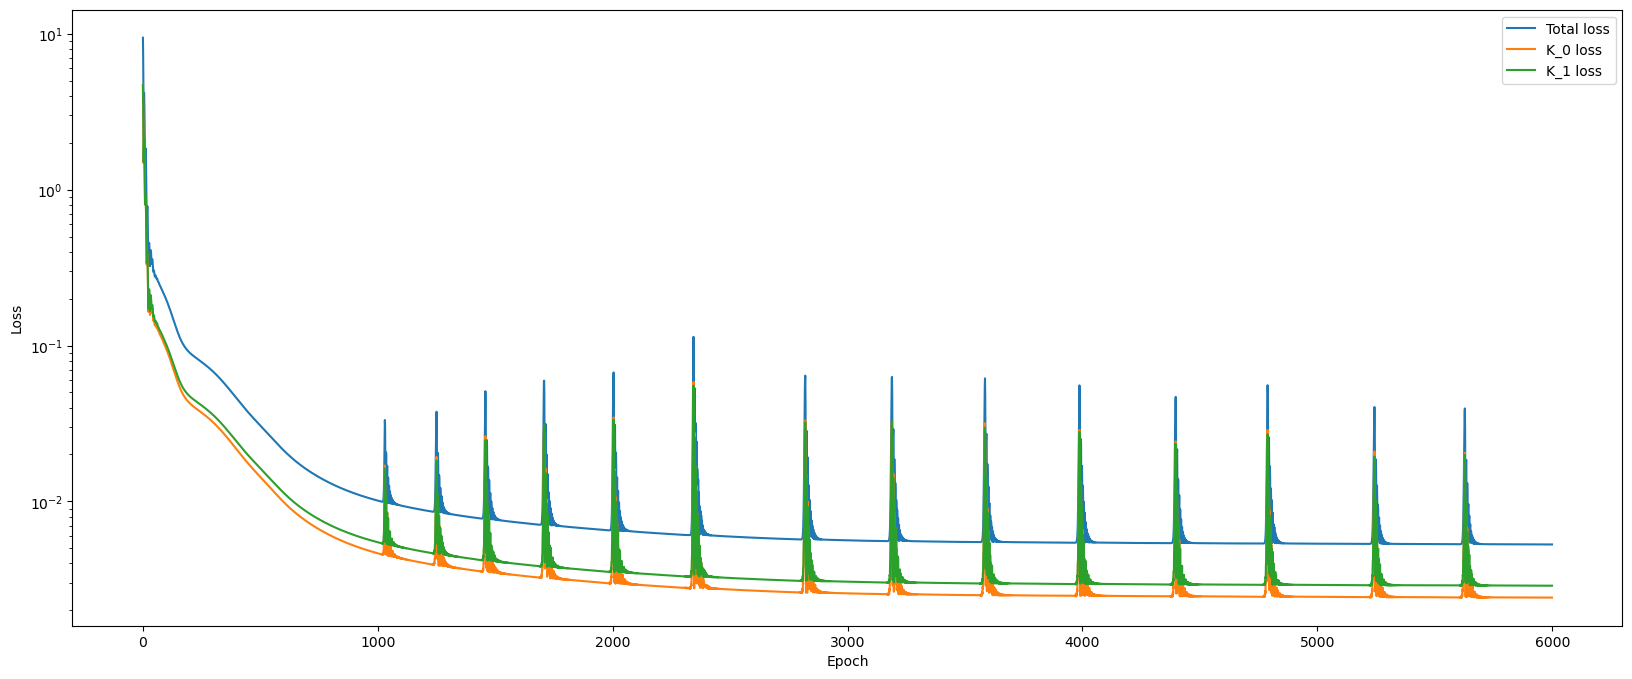

In [142]:
plt.figure(figsize=(20,8))
plt.plot(model_K.loss_log, label='Total loss')

plt.plot(model_K.loss_K_0_log, label='K_0 loss')
plt.plot(model_K.loss_K_1_log, label='K_1 loss')


plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [143]:
# Get trained params
opt_params_K = model_K.get_params(model_K.opt_state)

In [144]:
# Save model
FolderName_K_model = FolderName + 'K_fe_NN_model/'
Path(os.path.join(FolderName_K_model)).mkdir(parents = True, exist_ok = True)
pickle.dump(opt_params_K , open(FolderName_K_model+'K_params.pkl', 'wb'))

## Load Training Model

In [146]:
# Load model
FolderName_K_model = FolderName + 'K_fe_NN_model/'
opt_params_K = pickle.load(open(FolderName_K_model+'K_params.pkl' , 'rb'))


model_K.params = opt_params_K

## Predictions from K_NN

In [148]:
rho_train_min = rho_1.min()
rho_train_max = rho_1.max()
drho_train_min = drho_1.min()
drho_train_max = drho_1.max()

d2rho_train_min = d2rho_0.min()
d2rho_train_max = d2rho_0.max()


# K0
print('rho range:', rho_train_min, rho_train_max)
print('drho range:', drho_train_min, drho_train_max)


rho_test_grid_K = np.linspace(rho_train_min, rho_train_max, 100)
drho_test_grid_K = np.linspace(drho_train_min, drho_train_max, 200)

rho_meshgrid_K, drho_meshgrid_K = np.meshgrid(rho_test_grid_K, drho_test_grid_K)
print('K0 meshgrid shape:', rho_meshgrid_K.shape, drho_meshgrid_K.shape)


rho range: 0.02373 0.9796395
drho range: -3.715374999999999 3.684875
K0 meshgrid shape: (200, 100) (200, 100)


In [149]:
# prediction and analytic K1 on meshgrid

K_1_pred_grid = vmap(vmap(model_K.predict_K_1, in_axes=(None, 0, 0)), in_axes=(None, 0, 0))(opt_params_K, rho_meshgrid_K, drho_meshgrid_K)
K_1_ana_grid = vmap(vmap(K_1_Arr_ana_func, in_axes=(0, 0, None,None,None,None)), in_axes=(0, 0, None,None,None,None))(rho_meshgrid_K, drho_meshgrid_K, dx_basis,Jo,L,Co)


print('Shape of predicted K_1:', K_1_pred_grid.shape)
print('Shape of analytic K_1:', K_1_ana_grid.shape)

Shape of predicted K_1: (200, 100)
Shape of analytic K_1: (200, 100)


In [150]:
# prediction and training error K1 on data points
K_1_pred = vmap(model_K.predict_K_1, in_axes=(None, 0, 0))(opt_params_K, rho_1_train_K, drho_1_train_K)
K_1_error = np.linalg.norm(K_1_train_K - K_1_pred, 2) / np.linalg.norm(K_1_train_K, 2)

<Figure size 640x480 with 0 Axes>

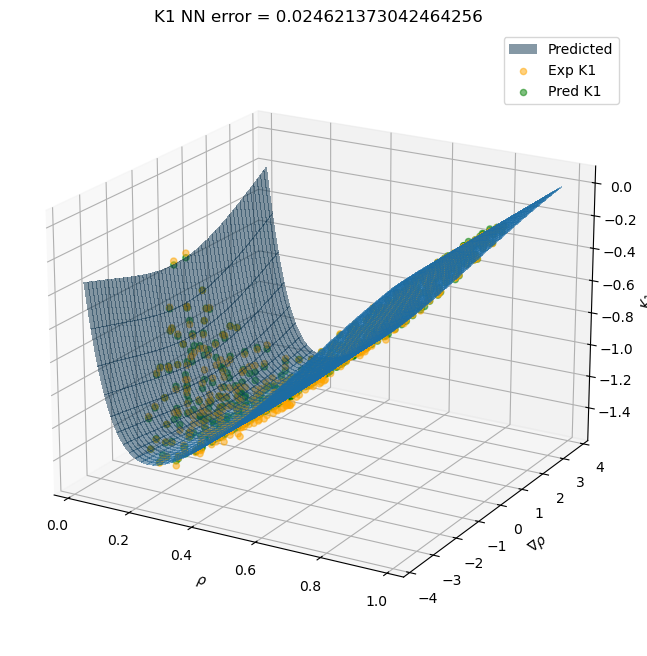

In [151]:
plt.figure()
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, -60)
ax1 = ax.plot_surface(rho_meshgrid_K, drho_meshgrid_K, K_1_pred_grid, alpha=0.5, linewidth=0, antialiased=False, label = 'Predicted')
ax1._facecolors2d = ax1._facecolor3d
ax1._edgecolors2d = ax1._edgecolor3d
ax2 = ax.scatter(rho_1_train_K, drho_1_train_K, K_1_train_K, alpha=0.5, color = 'orange', label = 'Exp K1')
ax3 = ax.scatter(rho_1_train_K, drho_1_train_K, K_1_pred, alpha=0.5, color = 'green', label = 'Pred K1')
ax.legend(loc='best')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$\nabla{\rho}$')
ax.set_zlabel('$K_1$')
plt.title('K1 NN error = {}'.format(K_1_error))
plt.show()

## Output library data for K

In [153]:
Num_K_lib = [1000, 1000]
rho_K_lib = onp.linspace(rho_1_train_K.min(), rho_1_train_K.max(), Num_K_lib[0])
drho_K_lib = onp.linspace(5*drho_1_train_K.min(), 5*drho_1_train_K.max(), Num_K_lib[1]) # extrapolate the range of drho

rho_K_grid_lib, drho_K_grid_lib = onp.meshgrid(rho_K_lib, drho_K_lib)


K_1_lib = vmap(vmap(model_K.predict_K_1, in_axes=(None, 0, None)), in_axes=(None, None, 0))(opt_params_K, rho_K_lib, drho_K_lib)
K_1_lib = onp.array(K_1_lib)
print(K_1_lib.shape)

K_lib_dic = {"rho_K_lib": rho_K_lib, "drho_K_lib": drho_K_lib, "K_1_lib": K_1_lib}


(1000, 1000)


In [154]:
# Save K
FolderName_K_lib = FolderName + 'K_fe_NN_model/'
Path(os.path.join(FolderName_K_lib)).mkdir(parents = True, exist_ok = True)
scipy.io.savemat(FolderName_K_lib + 'K_lib.mat', K_lib_dic)


# 6. fe_NN training and prediction

## Training data for fe_NN

In [157]:
# shift rho_Delta_t_R4
rho_Delta_t_R4_left = np.roll(rho_Delta_t_R4, 1, axis=1)
rho_Delta_t_R4_left2 = np.roll(rho_Delta_t_R4, 2, axis=1)
rho_Delta_t_R4_right = np.roll(rho_Delta_t_R4, -1, axis=1)
rho_Delta_t_R4_right2 = np.roll(rho_Delta_t_R4, -2, axis=1)


gradC_rho_Delta_t_R4 = ( rho_Delta_t_R4_right - rho_Delta_t_R4_left ) / ( 2.0 * dx_basis )


# left and right for the expectation value of initial profile
rho_ini_ex_ave = rho_ini_ex
rho_ini_ex_left = np.roll(rho_ini_ex_ave,1,axis=1)
rho_ini_ex_right = np.roll(rho_ini_ex_ave,-1,axis=1)
rho_ini_ex_right2 = np.roll(rho_ini_ex_ave,-2,axis=1)


Delta_t_3D = np.tile(Delta_t[:, np.newaxis, np.newaxis], (1, rho_Delta_t_R4.shape[1], rho_Delta_t_R4.shape[2]-1))
Delta_t_train = Delta_t_3D.flatten()


# rho_old at t = t_0 + (0:R4-1) * Delta_t/R4
rho_train_fe = rho_Delta_t_R4[:,:,0:-1].flatten()
rho_left_train_fe = rho_Delta_t_R4_left[:,:,0:-1].flatten()
rho_left2_train_fe = rho_Delta_t_R4_left2[:,:,0:-1].flatten()
rho_right_train_fe = rho_Delta_t_R4_right[:,:,0:-1].flatten()
rho_right2_train_fe = rho_Delta_t_R4_right2[:,:,0:-1].flatten()


gradC_rho_train_fe = gradC_rho_Delta_t_R4[:,:,0:-1].flatten()


# converting rho, rho_left, rho_right into rho, drho, d2rho (at different points) for calculating Kba
drho_train_fe = ( rho_right_train_fe - rho_left_train_fe ) / ( 2.0 * dx_basis )
d2rho_train_fe = ( rho_right_train_fe - 2.0 * rho_train_fe + rho_left_train_fe ) / ( dx_basis ** 2 )
rho_1_left_train_fe = ( rho_train_fe + rho_left_train_fe ) / 2.0
drho_1_left_train_fe = ( rho_train_fe - rho_left_train_fe ) / dx_basis
rho_1_right_train_fe = ( rho_right_train_fe + rho_train_fe ) / 2.0
drho_1_right_train_fe = ( rho_right_train_fe - rho_train_fe ) / dx_basis


# rho_new at t = t_0 + (1:R4) * Delta_t/R4
rho_new_train_fe = rho_Delta_t_R4[:,:,1:].flatten()
rho_new_left_train_fe = rho_Delta_t_R4_left[:,:,1:].flatten()
rho_new_right_train_fe = rho_Delta_t_R4_right[:,:,1:].flatten()

# Drho/Dt
DrhoDt_train_fe = (rho_new_train_fe - rho_train_fe) / ( Delta_t_train / R4 )
DrhoDt_left_train_fe = (rho_new_left_train_fe - rho_left_train_fe) / ( Delta_t_train / R4 )
DrhoDt_right_train_fe = (rho_new_right_train_fe - rho_right_train_fe) / ( Delta_t_train / R4 )


drho_Delta_t_R4 = (rho_Delta_t_R4_right - rho_Delta_t_R4_left) / (2 * dx_basis)



print('rho_Delta_t_R4.shape =', rho_Delta_t_R4.shape)


M_tri_0 = 2.0/3.0 * dx_basis
M_tri_left = 1.0/6.0 * dx_basis
M_tri_right = 1.0/6.0 * dx_basis
M_tri = M_tri_0, M_tri_left, M_tri_right
print('M_tri = ', M_tri)

rho_Delta_t_R4.shape = (28, 25, 2)
M_tri =  (0.026666666666666665, 0.006666666666666666, 0.006666666666666666)


In [158]:
K_1_left_train_fe = vmap(model_K.predict_K_1_MP, in_axes=(None, 0, 0))(opt_params_K, rho_left_train_fe, rho_train_fe)
K_1_right_train_fe = vmap(model_K.predict_K_1_MP, in_axes=(None, 0, 0))(opt_params_K, rho_train_fe, rho_right_train_fe)
K_0_train_fe = vmap(model_K.predict_K_0_MP, in_axes=(None, 0, 0, 0))(opt_params_K, rho_train_fe, rho_left_train_fe, rho_right_train_fe)

K_0_train_fe = K_0_train_fe
K_left_train_fe = K_1_left_train_fe
K_right_train_fe = K_1_right_train_fe


# variance of equation based on K0
var_eq_train_fe = 2.0/(Nbin * R0 * R1 * R2) * K_0_train_fe / ( Delta_t_train / R4 )

print(var_eq_train_fe.shape)

(700,)


In [159]:
# Dim1_all = var_eq_all_fe.shape[0] / R4

train_data_fe = rho_train_fe, rho_left_train_fe, rho_right_train_fe, DrhoDt_train_fe, DrhoDt_left_train_fe, DrhoDt_right_train_fe,\
      K_0_train_fe, K_left_train_fe, K_right_train_fe, M_tri, var_eq_train_fe, dx_basis

## Train fe_NN

In [161]:
# Set up layers and learning rate
layers_fe = [1, 20, 20, 1]

learning_rate_fe = 1e-2

activation_fe = 'softplus'
# activation_fe = 'GeLU'

print('activation_function_fe =', activation_fe)
print('layers_fe =', layers_fe)
print('learning_rate_fe =', learning_rate_fe)

print('')

model_fe = fe_NN(train_data_fe, layers_fe, lr=learning_rate_fe, af=activation_fe)

activation_function_fe = softplus
layers_fe = [1, 20, 20, 1]
learning_rate_fe = 0.01

data shape =  (700,)

rho scale =  0.4968644756651145
M scale =  0.013333335
DrhoDt scale =  2.4982927
K scale =  1.1821086
fe scale =  0.014001116


In [162]:
# Start training

model_fe.train(num_epochs = 2000)

  0%|                                                                                 | 3/2000 [00:02<19:26,  1.71it/s]


loss = 4.906229496002197

loss = 4.90061092376709


  0%|▏                                                                                | 5/2000 [00:02<10:44,  3.10it/s]


loss = 4.895195007324219

loss = 4.8897271156311035


  0%|▎                                                                                | 8/2000 [00:02<05:56,  5.59it/s]


loss = 4.883981704711914

loss = 4.877758502960205

loss = 4.870881080627441


  0%|▍                                                                               | 10/2000 [00:02<04:46,  6.94it/s]


loss = 4.863175868988037

loss = 4.854475498199463

loss = 4.844611644744873


  1%|▌                                                                               | 14/2000 [00:03<03:49,  8.64it/s]


loss = 4.833421230316162

loss = 4.820733547210693

loss = 4.8063764572143555


  1%|▋                                                                               | 16/2000 [00:03<03:35,  9.22it/s]


loss = 4.790170669555664

loss = 4.771939754486084

loss = 4.751522064208984


  1%|▊                                                                               | 19/2000 [00:03<03:39,  9.03it/s]


loss = 4.728777885437012

loss = 4.703609466552734


  1%|▊                                                                               | 21/2000 [00:04<03:32,  9.31it/s]


loss = 4.6759843826293945

loss = 4.645949840545654


  1%|▉                                                                               | 23/2000 [00:04<03:49,  8.63it/s]


loss = 4.613664150238037

loss = 4.579408168792725

loss = 4.543614864349365


  1%|█                                                                               | 26/2000 [00:04<03:42,  8.88it/s]


loss = 4.506868362426758

loss = 4.469832420349121


  1%|█                                                                               | 28/2000 [00:04<03:40,  8.95it/s]


loss = 4.433077335357666

loss = 4.396862983703613

loss = 4.3609466552734375


  2%|█▎                                                                              | 32/2000 [00:05<03:28,  9.42it/s]


loss = 4.324553966522217

loss = 4.286661624908447

loss = 4.246410369873047


  2%|█▍                                                                              | 35/2000 [00:05<03:31,  9.28it/s]


loss = 4.203356742858887

loss = 4.1575541496276855

loss = 4.109627723693848


  2%|█▍                                                                              | 37/2000 [00:05<03:41,  8.88it/s]


loss = 4.060769557952881

loss = 4.0124897956848145


  2%|█▌                                                                              | 39/2000 [00:06<03:35,  9.11it/s]


loss = 3.966165542602539

loss = 3.922553300857544


  2%|█▋                                                                              | 42/2000 [00:06<03:24,  9.55it/s]


loss = 3.8815882205963135

loss = 3.8426220417022705

loss = 3.804856300354004


  2%|█▊                                                                              | 45/2000 [00:06<03:19,  9.81it/s]


loss = 3.7676074504852295

loss = 3.7302942276000977

loss = 3.6923346519470215


  2%|█▉                                                                              | 47/2000 [00:06<03:22,  9.66it/s]


loss = 3.6531214714050293

loss = 3.6121256351470947


  2%|█▉                                                                              | 49/2000 [00:07<03:22,  9.66it/s]


loss = 3.569060802459717

loss = 3.523987054824829


  3%|██                                                                              | 52/2000 [00:07<03:18,  9.81it/s]


loss = 3.477309226989746

loss = 3.429614305496216

loss = 3.381321907043457


  3%|██▏                                                                             | 55/2000 [00:07<03:10, 10.23it/s]


loss = 3.3322787284851074

loss = 3.281627655029297

loss = 3.228320360183716


  3%|██▎                                                                             | 57/2000 [00:07<03:09, 10.28it/s]


loss = 3.172032594680786

loss = 3.113600969314575

loss = 3.0543620586395264


  3%|██▍                                                                             | 61/2000 [00:08<03:06, 10.41it/s]


loss = 2.9950714111328125

loss = 2.935652256011963

loss = 2.8761656284332275


  3%|██▌                                                                             | 63/2000 [00:08<03:04, 10.48it/s]


loss = 2.8177287578582764

loss = 2.7619500160217285


  3%|██▌                                                                             | 65/2000 [00:08<03:13, 10.01it/s]


loss = 2.709235429763794

loss = 2.6585195064544678


  3%|██▋                                                                             | 67/2000 [00:08<03:15,  9.88it/s]


loss = 2.609694719314575

loss = 2.5644099712371826

loss = 2.5232045650482178


  4%|██▊                                                                             | 70/2000 [00:09<03:15,  9.90it/s]


loss = 2.485015392303467

loss = 2.4503085613250732


  4%|██▉                                                                             | 72/2000 [00:09<03:13,  9.99it/s]


loss = 2.4205644130706787

loss = 2.3945884704589844

loss = 2.3715744018554688


  4%|███                                                                             | 76/2000 [00:09<03:10, 10.10it/s]


loss = 2.352292060852051

loss = 2.3347253799438477

loss = 2.3185322284698486


  4%|███                                                                             | 78/2000 [00:09<03:14,  9.90it/s]


loss = 2.304058074951172

loss = 2.2897796630859375


  4%|███▏                                                                            | 80/2000 [00:10<03:24,  9.39it/s]


loss = 2.276521921157837

loss = 2.2631678581237793


  4%|███▎                                                                            | 83/2000 [00:10<03:16,  9.75it/s]


loss = 2.2490363121032715

loss = 2.234179735183716

loss = 2.2175567150115967


  4%|███▍                                                                            | 85/2000 [00:10<03:16,  9.75it/s]


loss = 2.200403928756714

loss = 2.1830427646636963

loss = 2.1664302349090576


  4%|███▌                                                                            | 89/2000 [00:11<03:07, 10.18it/s]


loss = 2.1490283012390137

loss = 2.1296284198760986

loss = 2.110182762145996


  5%|███▋                                                                            | 91/2000 [00:11<03:06, 10.22it/s]


loss = 2.0923304557800293

loss = 2.076890707015991

loss = 2.062657356262207


  5%|███▋                                                                            | 93/2000 [00:11<03:07, 10.15it/s]


loss = 2.0506272315979004

loss = 2.041611671447754


  5%|███▊                                                                            | 95/2000 [00:11<03:08, 10.13it/s]


loss = 2.035062074661255

loss = 2.0310938358306885

loss = 2.028010606765747


  5%|███▉                                                                            | 99/2000 [00:12<03:06, 10.22it/s]


loss = 2.0232479572296143

loss = 2.016017436981201

loss = 2.0080361366271973


  5%|████                                                                           | 103/2000 [00:12<03:04, 10.27it/s]


loss = 2.0005099773406982

loss = 1.9923681020736694

loss = 1.9827768802642822


  5%|████▏                                                                          | 105/2000 [00:12<03:02, 10.38it/s]


loss = 1.9726506471633911

loss = 1.9630881547927856

loss = 1.9559917449951172


  5%|████▎                                                                          | 109/2000 [00:13<03:02, 10.35it/s]


loss = 1.9473000764846802

loss = 1.935894250869751

loss = 1.9258192777633667


  6%|████▍                                                                          | 111/2000 [00:13<03:02, 10.35it/s]


loss = 1.9161924123764038

loss = 1.908534288406372

loss = 1.9007160663604736


  6%|████▌                                                                          | 115/2000 [00:13<03:04, 10.22it/s]


loss = 1.8918997049331665

loss = 1.884162187576294

loss = 1.8756393194198608


  6%|████▌                                                                          | 117/2000 [00:13<03:04, 10.23it/s]


loss = 1.8679372072219849

loss = 1.8594846725463867

loss = 1.8514525890350342


  6%|████▊                                                                          | 121/2000 [00:14<03:01, 10.33it/s]


loss = 1.842890739440918

loss = 1.8324106931686401

loss = 1.8209116458892822


  6%|████▊                                                                          | 123/2000 [00:14<02:59, 10.47it/s]


loss = 1.8108819723129272

loss = 1.8009703159332275

loss = 1.7872213125228882


  6%|█████                                                                          | 127/2000 [00:14<03:03, 10.22it/s]


loss = 1.7753229141235352

loss = 1.764313817024231

loss = 1.7511260509490967


  6%|█████                                                                          | 129/2000 [00:15<03:20,  9.32it/s]


loss = 1.7386369705200195

loss = 1.7253828048706055


  7%|█████▏                                                                         | 131/2000 [00:15<03:30,  8.87it/s]


loss = 1.711221694946289

loss = 1.6982072591781616


  7%|█████▎                                                                         | 133/2000 [00:15<03:46,  8.23it/s]


loss = 1.683596134185791

loss = 1.6723217964172363


  7%|█████▎                                                                         | 135/2000 [00:15<03:39,  8.50it/s]


loss = 1.658448338508606

loss = 1.6466928720474243

loss = 1.6324743032455444


  7%|█████▍                                                                         | 139/2000 [00:16<03:13,  9.61it/s]


loss = 1.6188476085662842

loss = 1.6057090759277344

loss = 1.5889991521835327


  7%|█████▌                                                                         | 141/2000 [00:16<03:20,  9.29it/s]


loss = 1.5718940496444702

loss = 1.5557745695114136


  7%|█████▋                                                                         | 143/2000 [00:16<03:29,  8.87it/s]


loss = 1.5414915084838867

loss = 1.5297411680221558


  7%|█████▊                                                                         | 146/2000 [00:16<03:14,  9.55it/s]


loss = 1.5227891206741333

loss = 1.5099234580993652

loss = 1.4919379949569702


  7%|█████▉                                                                         | 149/2000 [00:17<03:09,  9.79it/s]


loss = 1.4851112365722656

loss = 1.4802284240722656

loss = 1.4686381816864014


  8%|██████                                                                         | 152/2000 [00:17<03:03, 10.08it/s]


loss = 1.4636332988739014

loss = 1.458242654800415

loss = 1.4448271989822388


  8%|██████                                                                         | 154/2000 [00:17<03:01, 10.18it/s]


loss = 1.4413962364196777

loss = 1.4345300197601318


  8%|██████▏                                                                        | 156/2000 [00:17<03:14,  9.49it/s]


loss = 1.4232538938522339

loss = 1.4214590787887573


  8%|██████▎                                                                        | 159/2000 [00:18<03:14,  9.48it/s]


loss = 1.4136431217193604

loss = 1.4056893587112427

loss = 1.404974341392517


  8%|██████▎                                                                        | 161/2000 [00:18<03:06,  9.84it/s]


loss = 1.399248719215393

loss = 1.3931964635849


  8%|██████▍                                                                        | 163/2000 [00:18<03:15,  9.38it/s]


loss = 1.3942219018936157

loss = 1.3942294120788574


  8%|██████▌                                                                        | 166/2000 [00:19<03:24,  8.96it/s]


loss = 1.3853508234024048

loss = 1.3777564764022827

loss = 1.370463490486145


  8%|██████▋                                                                        | 168/2000 [00:19<03:10,  9.63it/s]


loss = 1.3686726093292236

loss = 1.3638819456100464

loss = 1.3577580451965332


  9%|██████▊                                                                        | 172/2000 [00:19<03:05,  9.84it/s]


loss = 1.3594896793365479

loss = 1.3482176065444946

loss = 1.3434116840362549


  9%|██████▊                                                                        | 174/2000 [00:19<03:06,  9.82it/s]


loss = 1.3451870679855347

loss = 1.3366236686706543

loss = 1.3339998722076416


  9%|███████                                                                        | 178/2000 [00:20<03:05,  9.82it/s]


loss = 1.3317686319351196

loss = 1.3278428316116333

loss = 1.3211036920547485


  9%|███████                                                                        | 180/2000 [00:20<03:16,  9.27it/s]


loss = 1.32069730758667

loss = 1.315424919128418


  9%|███████▏                                                                       | 182/2000 [00:20<03:34,  8.49it/s]


loss = 1.3098782300949097

loss = 1.3098119497299194


  9%|███████▎                                                                       | 184/2000 [00:20<03:40,  8.25it/s]


loss = 1.3041764497756958

loss = 1.2999745607376099


  9%|███████▎                                                                       | 186/2000 [00:21<03:55,  7.69it/s]


loss = 1.297518253326416

loss = 1.2953161001205444


  9%|███████▍                                                                       | 188/2000 [00:21<03:47,  7.96it/s]


loss = 1.2910696268081665

loss = 1.290467381477356


 10%|███████▌                                                                       | 190/2000 [00:21<03:39,  8.23it/s]


loss = 1.2967053651809692

loss = 1.295581340789795


 10%|███████▌                                                                       | 192/2000 [00:21<03:34,  8.41it/s]


loss = 1.2821019887924194

loss = 1.2744663953781128


 10%|███████▋                                                                       | 194/2000 [00:22<03:35,  8.36it/s]


loss = 1.2773075103759766

loss = 1.2725558280944824


 10%|███████▋                                                                       | 196/2000 [00:22<03:42,  8.12it/s]


loss = 1.2652159929275513

loss = 1.2673503160476685


 10%|███████▊                                                                       | 198/2000 [00:22<03:28,  8.65it/s]


loss = 1.262711763381958

loss = 1.2524545192718506

loss = 1.253397822380066


 10%|███████▉                                                                       | 202/2000 [00:23<02:59, 10.03it/s]


loss = 1.2537950277328491

loss = 1.2447280883789062

loss = 1.2399994134902954


 10%|████████                                                                       | 204/2000 [00:23<02:54, 10.32it/s]


loss = 1.241249918937683

loss = 1.2373493909835815

loss = 1.2298089265823364


 10%|████████▏                                                                      | 208/2000 [00:23<02:50, 10.52it/s]


loss = 1.227074384689331

loss = 1.2271603345870972

loss = 1.2233692407608032


 10%|████████▎                                                                      | 210/2000 [00:23<02:46, 10.73it/s]


loss = 1.21650230884552

loss = 1.212286353111267

loss = 1.2117934226989746


 11%|████████▍                                                                      | 214/2000 [00:24<02:50, 10.47it/s]


loss = 1.2139545679092407

loss = 1.2201192378997803

loss = 1.2282581329345703


 11%|████████▌                                                                      | 216/2000 [00:24<02:53, 10.27it/s]


loss = 1.2284939289093018

loss = 1.2078617811203003

loss = 1.2029283046722412


 11%|████████▋                                                                      | 220/2000 [00:24<02:50, 10.41it/s]


loss = 1.2055855989456177

loss = 1.190962553024292

loss = 1.1900670528411865


 11%|████████▊                                                                      | 222/2000 [00:24<02:53, 10.24it/s]


loss = 1.1962037086486816

loss = 1.178962230682373

loss = 1.1728780269622803


 11%|████████▉                                                                      | 226/2000 [00:25<03:02,  9.70it/s]


loss = 1.1838568449020386

loss = 1.1735540628433228

loss = 1.1599596738815308


 11%|█████████                                                                      | 228/2000 [00:25<03:01,  9.74it/s]


loss = 1.1659678220748901

loss = 1.1649101972579956


 12%|█████████                                                                      | 230/2000 [00:25<03:21,  8.77it/s]


loss = 1.153123378753662

loss = 1.1520622968673706


 12%|█████████▏                                                                     | 233/2000 [00:26<03:18,  8.90it/s]


loss = 1.1536821126937866

loss = 1.1449769735336304

loss = 1.1387784481048584


 12%|█████████▎                                                                     | 236/2000 [00:26<03:08,  9.34it/s]


loss = 1.141455888748169

loss = 1.1405670642852783

loss = 1.1331007480621338


 12%|█████████▍                                                                     | 238/2000 [00:26<03:11,  9.20it/s]


loss = 1.1306202411651611

loss = 1.134600043296814


 12%|█████████▍                                                                     | 240/2000 [00:26<03:08,  9.33it/s]


loss = 1.1358556747436523

loss = 1.1341220140457153


 12%|█████████▌                                                                     | 241/2000 [00:27<03:11,  9.20it/s]


loss = 1.1323684453964233

loss = 1.1314269304275513


 12%|█████████▋                                                                     | 244/2000 [00:27<03:23,  8.63it/s]


loss = 1.1245498657226562

loss = 1.1106781959533691


 12%|█████████▋                                                                     | 246/2000 [00:27<03:38,  8.03it/s]


loss = 1.1050095558166504

loss = 1.1105940341949463


 12%|█████████▊                                                                     | 248/2000 [00:27<03:29,  8.36it/s]


loss = 1.1152520179748535

loss = 1.1105947494506836


 12%|█████████▉                                                                     | 250/2000 [00:28<03:34,  8.17it/s]


loss = 1.1003962755203247

loss = 1.09627103805542


 13%|█████████▉                                                                     | 252/2000 [00:28<03:29,  8.36it/s]


loss = 1.0970321893692017

loss = 1.0944467782974243


 13%|██████████                                                                     | 254/2000 [00:28<03:31,  8.27it/s]


loss = 1.0888283252716064

loss = 1.086428165435791


 13%|██████████                                                                     | 256/2000 [00:28<03:25,  8.47it/s]


loss = 1.0895377397537231

loss = 1.093540072441101


 13%|██████████▏                                                                    | 258/2000 [00:29<03:36,  8.03it/s]


loss = 1.0933034420013428

loss = 1.090039610862732


 13%|██████████▎                                                                    | 260/2000 [00:29<03:23,  8.55it/s]


loss = 1.0869789123535156

loss = 1.085671305656433


 13%|██████████▎                                                                    | 262/2000 [00:29<03:23,  8.56it/s]


loss = 1.0822776556015015

loss = 1.0748209953308105


 13%|██████████▍                                                                    | 264/2000 [00:29<03:33,  8.14it/s]


loss = 1.0686290264129639

loss = 1.0683016777038574


 13%|██████████▌                                                                    | 266/2000 [00:30<03:26,  8.39it/s]


loss = 1.0723592042922974

loss = 1.0755022764205933


 13%|██████████▌                                                                    | 268/2000 [00:30<03:38,  7.91it/s]


loss = 1.0738608837127686

loss = 1.0685863494873047


 14%|██████████▋                                                                    | 270/2000 [00:30<03:37,  7.95it/s]


loss = 1.0644479990005493

loss = 1.0637720823287964


 14%|██████████▋                                                                    | 272/2000 [00:30<03:44,  7.70it/s]


loss = 1.0648185014724731

loss = 1.0637669563293457


 14%|██████████▊                                                                    | 274/2000 [00:31<03:35,  8.01it/s]


loss = 1.0600199699401855

loss = 1.0554783344268799


 14%|██████████▉                                                                    | 276/2000 [00:31<03:48,  7.55it/s]


loss = 1.053162693977356

loss = 1.053505778312683


 14%|██████████▉                                                                    | 278/2000 [00:31<03:27,  8.28it/s]


loss = 1.0547999143600464

loss = 1.0553431510925293


 14%|███████████                                                                    | 280/2000 [00:31<03:43,  7.70it/s]


loss = 1.0542402267456055

loss = 1.052638053894043


 14%|███████████▏                                                                   | 282/2000 [00:32<03:42,  7.73it/s]


loss = 1.0524353981018066

loss = 1.0564991235733032


 14%|███████████▏                                                                   | 284/2000 [00:32<03:45,  7.61it/s]


loss = 1.069190263748169

loss = 1.0953859090805054


 14%|███████████▎                                                                   | 286/2000 [00:32<03:28,  8.20it/s]


loss = 1.1210004091262817

loss = 1.1061763763427734


 14%|███████████▍                                                                   | 288/2000 [00:32<03:27,  8.24it/s]


loss = 1.0558499097824097

loss = 1.0572309494018555


 15%|███████████▍                                                                   | 291/2000 [00:33<03:12,  8.86it/s]


loss = 1.0859133005142212

loss = 1.06707763671875

loss = 1.0483213663101196


 15%|███████████▌                                                                   | 293/2000 [00:33<03:17,  8.63it/s]


loss = 1.066364049911499

loss = 1.0654492378234863


 15%|███████████▋                                                                   | 295/2000 [00:33<03:17,  8.62it/s]


loss = 1.0472229719161987

loss = 1.0521039962768555


 15%|███████████▋                                                                   | 297/2000 [00:33<03:16,  8.66it/s]


loss = 1.062599778175354

loss = 1.0502548217773438


 15%|███████████▊                                                                   | 300/2000 [00:34<03:04,  9.24it/s]


loss = 1.044633388519287

loss = 1.0598125457763672

loss = 1.049753189086914


 15%|███████████▉                                                                   | 302/2000 [00:34<03:07,  9.04it/s]


loss = 1.0427157878875732

loss = 1.0582308769226074


 15%|████████████                                                                   | 304/2000 [00:34<03:10,  8.89it/s]


loss = 1.0450340509414673

loss = 1.0426921844482422


 15%|████████████                                                                   | 306/2000 [00:34<03:13,  8.73it/s]


loss = 1.0471137762069702

loss = 1.043025016784668


 15%|████████████▏                                                                  | 308/2000 [00:35<03:12,  8.77it/s]


loss = 1.0412805080413818

loss = 1.0396593809127808


 16%|████████████▏                                                                  | 310/2000 [00:35<03:38,  7.75it/s]


loss = 1.0448440313339233

loss = 1.037223219871521


 16%|████████████▎                                                                  | 312/2000 [00:35<03:37,  7.78it/s]


loss = 1.0388907194137573

loss = 1.0406060218811035


 16%|████████████▍                                                                  | 314/2000 [00:35<03:15,  8.62it/s]


loss = 1.0374000072479248

loss = 1.0367732048034668


 16%|████████████▍                                                                  | 316/2000 [00:36<03:18,  8.47it/s]


loss = 1.0366233587265015

loss = 1.0384581089019775


 16%|████████████▌                                                                  | 318/2000 [00:36<03:33,  7.88it/s]


loss = 1.0343434810638428

loss = 1.0354716777801514


 16%|████████████▋                                                                  | 320/2000 [00:36<03:29,  8.04it/s]


loss = 1.0357719659805298

loss = 1.034665584564209


 16%|████████████▋                                                                  | 322/2000 [00:36<03:28,  8.04it/s]


loss = 1.033706545829773

loss = 1.0334099531173706


 16%|████████████▊                                                                  | 324/2000 [00:37<03:52,  7.21it/s]


loss = 1.0345854759216309

loss = 1.0325803756713867


 16%|████████████▉                                                                  | 326/2000 [00:37<03:43,  7.49it/s]


loss = 1.032522201538086

loss = 1.0324569940567017


 16%|████████████▉                                                                  | 329/2000 [00:37<03:10,  8.78it/s]


loss = 1.032622218132019

loss = 1.0319114923477173

loss = 1.0310869216918945


 17%|█████████████                                                                  | 332/2000 [00:38<02:56,  9.47it/s]


loss = 1.0317111015319824

loss = 1.031266212463379

loss = 1.0310285091400146


 17%|█████████████▏                                                                 | 334/2000 [00:38<02:50,  9.80it/s]


loss = 1.0303817987442017

loss = 1.0305039882659912


 17%|█████████████▎                                                                 | 336/2000 [00:38<03:00,  9.22it/s]


loss = 1.0308079719543457

loss = 1.0305736064910889


 17%|█████████████▎                                                                 | 338/2000 [00:38<03:00,  9.22it/s]


loss = 1.0309193134307861

loss = 1.0316095352172852

loss = 1.033915400505066


 17%|█████████████▍                                                                 | 341/2000 [00:39<02:53,  9.59it/s]


loss = 1.037726640701294

loss = 1.0445762872695923


 17%|█████████████▌                                                                 | 343/2000 [00:39<02:55,  9.43it/s]


loss = 1.0541813373565674

loss = 1.063810110092163


 17%|█████████████▌                                                                 | 344/2000 [00:39<03:06,  8.90it/s]


loss = 1.0603866577148438

loss = 1.0444284677505493


 17%|█████████████▋                                                                 | 347/2000 [00:39<02:55,  9.42it/s]


loss = 1.029038429260254

loss = 1.0312610864639282


 17%|█████████████▊                                                                 | 349/2000 [00:39<02:56,  9.33it/s]


loss = 1.0434397459030151

loss = 1.0461926460266113


 18%|█████████████▊                                                                 | 351/2000 [00:40<03:14,  8.46it/s]


loss = 1.0362694263458252

loss = 1.0275030136108398


 18%|█████████████▉                                                                 | 353/2000 [00:40<03:18,  8.29it/s]


loss = 1.0308241844177246

loss = 1.0377497673034668


 18%|██████████████                                                                 | 355/2000 [00:40<03:06,  8.81it/s]


loss = 1.035899043083191

loss = 1.0289661884307861


 18%|██████████████                                                                 | 357/2000 [00:40<03:01,  9.07it/s]


loss = 1.0272663831710815

loss = 1.0311673879623413


 18%|██████████████▏                                                                | 360/2000 [00:41<02:59,  9.12it/s]


loss = 1.032831072807312

loss = 1.0293691158294678

loss = 1.0264338254928589


 18%|██████████████▎                                                                | 362/2000 [00:41<03:16,  8.35it/s]


loss = 1.0274970531463623

loss = 1.029295802116394


 18%|██████████████▍                                                                | 365/2000 [00:41<02:53,  9.43it/s]


loss = 1.0286270380020142

loss = 1.0265024900436401

loss = 1.0257312059402466


 18%|██████████████▌                                                                | 368/2000 [00:42<02:43, 10.01it/s]


loss = 1.0265306234359741

loss = 1.0269443988800049

loss = 1.0262150764465332


 18%|██████████████▌                                                                | 370/2000 [00:42<02:35, 10.47it/s]


loss = 1.02522611618042

loss = 1.0249090194702148

loss = 1.0251284837722778


 19%|██████████████▊                                                                | 374/2000 [00:42<02:23, 11.30it/s]


loss = 1.0251790285110474

loss = 1.0248522758483887

loss = 1.0243654251098633


 19%|██████████████▊                                                                | 376/2000 [00:42<02:20, 11.55it/s]


loss = 1.0239773988723755

loss = 1.0238064527511597

loss = 1.0237877368927002


 19%|███████████████                                                                | 380/2000 [00:43<02:26, 11.07it/s]


loss = 1.0237723588943481

loss = 1.0236200094223022

loss = 1.0232620239257812


 19%|███████████████                                                                | 382/2000 [00:43<02:26, 11.01it/s]


loss = 1.0228701829910278

loss = 1.0226308107376099

loss = 1.022611379623413


 19%|███████████████▏                                                               | 386/2000 [00:43<02:26, 11.01it/s]


loss = 1.0226820707321167

loss = 1.0226210355758667

loss = 1.0223504304885864


 19%|███████████████▎                                                               | 388/2000 [00:43<02:24, 11.18it/s]


loss = 1.0219721794128418

loss = 1.0216561555862427

loss = 1.0215175151824951


 20%|███████████████▍                                                               | 392/2000 [00:44<02:26, 10.95it/s]


loss = 1.0215275287628174

loss = 1.0215644836425781

loss = 1.0215123891830444


 20%|███████████████▌                                                               | 394/2000 [00:44<02:25, 11.07it/s]


loss = 1.021340250968933

loss = 1.0210868120193481

loss = 1.020825743675232


 20%|███████████████▋                                                               | 398/2000 [00:44<02:25, 11.04it/s]


loss = 1.0206164121627808

loss = 1.0204691886901855

loss = 1.0203635692596436


 20%|███████████████▊                                                               | 400/2000 [00:44<02:26, 10.91it/s]


loss = 1.020272970199585

loss = 1.0201783180236816

loss = 1.0200726985931396


 20%|███████████████▉                                                               | 404/2000 [00:45<02:30, 10.62it/s]


loss = 1.0199592113494873

loss = 1.0198501348495483

loss = 1.019763469696045


 20%|████████████████                                                               | 406/2000 [00:45<02:31, 10.50it/s]


loss = 1.0197160243988037

loss = 1.0197230577468872

loss = 1.019822120666504


 20%|████████████████▏                                                              | 410/2000 [00:45<02:27, 10.78it/s]


loss = 1.0200810432434082

loss = 1.0206255912780762

loss = 1.0216585397720337


 21%|████████████████▎                                                              | 412/2000 [00:46<02:27, 10.77it/s]


loss = 1.0236341953277588

loss = 1.027158260345459

loss = 1.0333064794540405


 21%|████████████████▍                                                              | 416/2000 [00:46<02:26, 10.81it/s]


loss = 1.0423698425292969

loss = 1.0532026290893555

loss = 1.0581027269363403


 21%|████████████████▌                                                              | 418/2000 [00:46<02:26, 10.78it/s]


loss = 1.04985511302948

loss = 1.030450463294983

loss = 1.0183656215667725


 21%|████████████████▋                                                              | 422/2000 [00:46<02:24, 10.89it/s]


loss = 1.0233030319213867

loss = 1.0353293418884277

loss = 1.0388646125793457


 21%|████████████████▋                                                              | 424/2000 [00:47<02:24, 10.94it/s]


loss = 1.0292187929153442

loss = 1.0189118385314941

loss = 1.0194791555404663


 21%|████████████████▊                                                              | 426/2000 [00:47<02:18, 11.40it/s]


loss = 1.026910662651062

loss = 1.029002070426941


 21%|████████████████▉                                                              | 428/2000 [00:47<02:26, 10.77it/s]


loss = 1.0226584672927856

loss = 1.0172252655029297


 22%|████████████████▉                                                              | 430/2000 [00:47<02:31, 10.34it/s]


loss = 1.0192601680755615

loss = 1.0238858461380005


 22%|█████████████████▏                                                             | 434/2000 [00:48<02:35, 10.06it/s]


loss = 1.0237152576446533

loss = 1.0191892385482788

loss = 1.016579270362854


 22%|█████████████████▏                                                             | 436/2000 [00:48<02:35, 10.09it/s]


loss = 1.0184307098388672

loss = 1.020937204360962

loss = 1.0202311277389526


 22%|█████████████████▍                                                             | 440/2000 [00:48<02:30, 10.36it/s]


loss = 1.0173454284667969

loss = 1.0160855054855347

loss = 1.0174118280410767


 22%|█████████████████▍                                                             | 442/2000 [00:48<02:28, 10.46it/s]


loss = 1.0188068151474

loss = 1.0182379484176636

loss = 1.0164728164672852


 22%|█████████████████▌                                                             | 446/2000 [00:49<02:27, 10.51it/s]


loss = 1.0155954360961914

loss = 1.0162101984024048

loss = 1.0170848369598389


 22%|█████████████████▋                                                             | 448/2000 [00:49<02:30, 10.33it/s]


loss = 1.0169678926467896

loss = 1.0159538984298706

loss = 1.0151212215423584


 23%|█████████████████▊                                                             | 452/2000 [00:49<02:34, 10.03it/s]


loss = 1.0151183605194092

loss = 1.0156338214874268

loss = 1.01589035987854


 23%|█████████████████▉                                                             | 454/2000 [00:50<02:31, 10.22it/s]


loss = 1.0155452489852905

loss = 1.0149050951004028

loss = 1.0144635438919067


 23%|██████████████████                                                             | 458/2000 [00:50<02:30, 10.23it/s]


loss = 1.0144411325454712

loss = 1.0146663188934326

loss = 1.0148024559020996


 23%|██████████████████▏                                                            | 460/2000 [00:50<02:36,  9.84it/s]


loss = 1.0146596431732178

loss = 1.0143121480941772

loss = 1.0139565467834473


 23%|██████████████████▎                                                            | 464/2000 [00:51<02:35,  9.88it/s]


loss = 1.0137615203857422

loss = 1.0137540102005005

loss = 1.0138733386993408


 23%|██████████████████▎                                                            | 465/2000 [00:51<02:36,  9.80it/s]


loss = 1.0140185356140137

loss = 1.0141907930374146


 23%|██████████████████▌                                                            | 469/2000 [00:51<02:35,  9.86it/s]


loss = 1.0145033597946167

loss = 1.0152686834335327

loss = 1.0171382427215576


 24%|██████████████████▋                                                            | 472/2000 [00:51<02:29, 10.19it/s]


loss = 1.021256685256958

loss = 1.0299036502838135

loss = 1.0445539951324463


 24%|██████████████████▋                                                            | 474/2000 [00:52<02:27, 10.31it/s]


loss = 1.064685344696045

loss = 1.071921944618225

loss = 1.0544769763946533


 24%|██████████████████▊                                                            | 476/2000 [00:52<02:29, 10.19it/s]


loss = 1.022661566734314

loss = 1.0175093412399292


 24%|██████████████████▉                                                            | 479/2000 [00:52<02:41,  9.41it/s]


loss = 1.0365312099456787

loss = 1.0426936149597168


 24%|███████████████████                                                            | 482/2000 [00:52<02:38,  9.56it/s]


loss = 1.0253026485443115

loss = 1.0137202739715576

loss = 1.024680733680725


 24%|███████████████████▏                                                           | 485/2000 [00:53<02:31, 10.03it/s]


loss = 1.0323855876922607

loss = 1.0203955173492432

loss = 1.0122292041778564


 24%|███████████████████▎                                                           | 488/2000 [00:53<02:31,  9.98it/s]


loss = 1.0208275318145752

loss = 1.0250955820083618

loss = 1.01600182056427


 24%|███████████████████▎                                                           | 490/2000 [00:53<02:32,  9.88it/s]


loss = 1.012000560760498

loss = 1.0183215141296387

loss = 1.0198205709457397


 25%|███████████████████▍                                                           | 493/2000 [00:54<02:39,  9.47it/s]


loss = 1.013494849205017

loss = 1.0119837522506714


 25%|███████████████████▌                                                           | 495/2000 [00:54<02:56,  8.53it/s]


loss = 1.0165095329284668

loss = 1.0163302421569824


 25%|███████████████████▋                                                           | 498/2000 [00:54<02:42,  9.22it/s]


loss = 1.0117206573486328

loss = 1.011635422706604

loss = 1.0147408246994019


 25%|███████████████████▊                                                           | 500/2000 [00:54<02:39,  9.41it/s]


loss = 1.0139747858047485

loss = 1.010941505432129

loss = 1.0111597776412964


 25%|███████████████████▊                                                           | 503/2000 [00:55<02:39,  9.41it/s]


loss = 1.0130854845046997

loss = 1.0123610496520996


 25%|███████████████████▉                                                           | 505/2000 [00:55<02:49,  8.80it/s]


loss = 1.0103766918182373

loss = 1.010606288909912


 25%|████████████████████                                                           | 508/2000 [00:55<02:40,  9.32it/s]


loss = 1.0118824243545532

loss = 1.0113545656204224

loss = 1.009992241859436


 26%|████████████████████▏                                                          | 510/2000 [00:55<02:42,  9.17it/s]


loss = 1.0099871158599854

loss = 1.010786771774292

loss = 1.0105806589126587


 26%|████████████████████▎                                                          | 514/2000 [00:56<02:36,  9.51it/s]


loss = 1.0096526145935059

loss = 1.009417176246643

loss = 1.0099068880081177


 26%|████████████████████▍                                                          | 516/2000 [00:56<02:42,  9.11it/s]


loss = 1.0099601745605469

loss = 1.0093543529510498


 26%|████████████████████▌                                                          | 519/2000 [00:56<02:39,  9.27it/s]


loss = 1.008963942527771

loss = 1.0091549158096313

loss = 1.009326457977295


 26%|████████████████████▌                                                          | 521/2000 [00:57<02:44,  8.99it/s]


loss = 1.009019374847412

loss = 1.0085952281951904


 26%|████████████████████▋                                                          | 523/2000 [00:57<03:05,  7.98it/s]


loss = 1.0085209608078003

loss = 1.0086742639541626


 26%|████████████████████▋                                                          | 525/2000 [00:57<02:51,  8.60it/s]


loss = 1.0086179971694946

loss = 1.0083173513412476

loss = 1.0080809593200684


 26%|████████████████████▊                                                          | 528/2000 [00:57<02:40,  9.19it/s]


loss = 1.0080713033676147

loss = 1.0081170797348022

loss = 1.0080081224441528


 27%|████████████████████▉                                                          | 531/2000 [00:58<02:38,  9.30it/s]


loss = 1.0077917575836182

loss = 1.0076348781585693


 27%|█████████████████████                                                          | 533/2000 [00:58<02:44,  8.90it/s]


loss = 1.0076184272766113

loss = 1.0076382160186768


 27%|█████████████████████▏                                                         | 536/2000 [00:58<02:36,  9.36it/s]


loss = 1.0076169967651367

loss = 1.007577896118164

loss = 1.0076807737350464


 27%|█████████████████████▎                                                         | 538/2000 [00:58<02:31,  9.64it/s]


loss = 1.0080928802490234

loss = 1.009045958518982

loss = 1.0109388828277588


 27%|█████████████████████▍                                                         | 542/2000 [00:59<02:26,  9.94it/s]


loss = 1.0148640871047974

loss = 1.0224847793579102

loss = 1.0373988151550293


 27%|█████████████████████▍                                                         | 544/2000 [00:59<02:41,  9.01it/s]


loss = 1.0590503215789795

loss = 1.0843899250030518


 27%|█████████████████████▌                                                         | 546/2000 [00:59<02:33,  9.46it/s]


loss = 1.0807942152023315

loss = 1.0469037294387817

loss = 1.0106234550476074


 27%|█████████████████████▋                                                         | 549/2000 [01:00<02:31,  9.55it/s]


loss = 1.0165811777114868

loss = 1.04442298412323


 28%|█████████████████████▊                                                         | 551/2000 [01:00<02:44,  8.79it/s]


loss = 1.045815110206604

loss = 1.0221924781799316


 28%|█████████████████████▊                                                         | 553/2000 [01:00<02:36,  9.26it/s]


loss = 1.007667899131775

loss = 1.0199730396270752


 28%|█████████████████████▉                                                         | 555/2000 [01:00<02:55,  8.25it/s]


loss = 1.031734824180603

loss = 1.0199649333953857


 28%|██████████████████████                                                         | 557/2000 [01:01<03:09,  7.63it/s]


loss = 1.008386492729187

loss = 1.0141301155090332


 28%|██████████████████████                                                         | 559/2000 [01:01<02:56,  8.19it/s]


loss = 1.020431637763977

loss = 1.0145189762115479

loss = 1.00789475440979


 28%|██████████████████████▏                                                        | 562/2000 [01:01<02:45,  8.68it/s]


loss = 1.0112125873565674

loss = 1.0149354934692383


 28%|██████████████████████▎                                                        | 565/2000 [01:02<02:40,  8.94it/s]


loss = 1.011160969734192

loss = 1.0075515508651733

loss = 1.0092556476593018


 28%|██████████████████████▍                                                        | 567/2000 [01:02<02:36,  9.17it/s]


loss = 1.0106257200241089

loss = 1.0083684921264648


 28%|██████████████████████▌                                                        | 570/2000 [01:02<02:36,  9.16it/s]


loss = 1.0069016218185425

loss = 1.0081382989883423

loss = 1.0082210302352905


 29%|██████████████████████▌                                                        | 572/2000 [01:02<02:46,  8.60it/s]


loss = 1.0065150260925293

loss = 1.0062006711959839


 29%|██████████████████████▋                                                        | 574/2000 [01:03<02:38,  8.99it/s]


loss = 1.0071054697036743

loss = 1.006635069847107


 29%|██████████████████████▊                                                        | 576/2000 [01:03<02:43,  8.72it/s]


loss = 1.0052658319473267

loss = 1.0052945613861084


 29%|██████████████████████▊                                                        | 578/2000 [01:03<03:07,  7.60it/s]


loss = 1.0062317848205566

loss = 1.005847454071045


 29%|██████████████████████▉                                                        | 580/2000 [01:03<03:03,  7.76it/s]


loss = 1.0044975280761719

loss = 1.004327654838562


 29%|██████████████████████▉                                                        | 582/2000 [01:04<03:05,  7.64it/s]


loss = 1.0052173137664795

loss = 1.0052564144134521


 29%|███████████████████████                                                        | 584/2000 [01:04<03:06,  7.57it/s]


loss = 1.0042091608047485

loss = 1.003655195236206


 29%|███████████████████████▏                                                       | 586/2000 [01:04<03:03,  7.69it/s]


loss = 1.0041598081588745

loss = 1.004553198814392


 29%|███████████████████████▏                                                       | 588/2000 [01:04<03:03,  7.67it/s]


loss = 1.0040688514709473

loss = 1.003394365310669


 30%|███████████████████████▎                                                       | 590/2000 [01:05<03:28,  6.76it/s]


loss = 1.0033600330352783

loss = 1.0036852359771729


 30%|███████████████████████▍                                                       | 592/2000 [01:05<03:23,  6.93it/s]


loss = 1.0036730766296387

loss = 1.0032713413238525


 30%|███████████████████████▍                                                       | 594/2000 [01:05<03:03,  7.68it/s]


loss = 1.0029857158660889

loss = 1.0030103921890259


 30%|███████████████████████▌                                                       | 596/2000 [01:05<02:58,  7.87it/s]


loss = 1.0030802488327026

loss = 1.0029324293136597


 30%|███████████████████████▌                                                       | 598/2000 [01:06<02:48,  8.34it/s]


loss = 1.002705693244934

loss = 1.002610445022583


 30%|███████████████████████▋                                                       | 601/2000 [01:06<02:32,  9.16it/s]


loss = 1.0026133060455322

loss = 1.0025503635406494

loss = 1.002364158630371


 30%|███████████████████████▊                                                       | 603/2000 [01:06<02:37,  8.88it/s]


loss = 1.0021989345550537

loss = 1.0021523237228394


 30%|███████████████████████▉                                                       | 605/2000 [01:06<02:40,  8.68it/s]


loss = 1.0021626949310303

loss = 1.0021103620529175


 30%|███████████████████████▉                                                       | 607/2000 [01:07<02:40,  8.66it/s]


loss = 1.001961350440979

loss = 1.0017900466918945


 30%|████████████████████████                                                       | 609/2000 [01:07<02:36,  8.87it/s]


loss = 1.001685380935669

loss = 1.0016448497772217


 30%|████████████████████████                                                       | 610/2000 [01:07<02:44,  8.43it/s]


loss = 1.0016071796417236

loss = 1.001529574394226


 31%|████████████████████████▏                                                      | 613/2000 [01:07<02:37,  8.79it/s]


loss = 1.0014212131500244

loss = 1.0013169050216675


 31%|████████████████████████▎                                                      | 615/2000 [01:08<02:33,  9.01it/s]


loss = 1.0012460947036743

loss = 1.0011827945709229


 31%|████████████████████████▎                                                      | 617/2000 [01:08<02:54,  7.93it/s]


loss = 1.0011061429977417

loss = 1.0010136365890503


 31%|████████████████████████▍                                                      | 619/2000 [01:08<02:48,  8.18it/s]


loss = 1.000910758972168

loss = 1.0008091926574707


 31%|████████████████████████▌                                                      | 621/2000 [01:08<02:41,  8.52it/s]


loss = 1.000731348991394

loss = 1.00066339969635


 31%|████████████████████████▋                                                      | 624/2000 [01:09<02:36,  8.80it/s]


loss = 1.0006012916564941

loss = 1.000525712966919

loss = 1.0004364252090454


 31%|████████████████████████▋                                                      | 626/2000 [01:09<02:37,  8.73it/s]


loss = 1.0003520250320435

loss = 1.0002835988998413


 31%|████████████████████████▊                                                      | 628/2000 [01:09<02:33,  8.96it/s]


loss = 1.0002132654190063

loss = 1.0001522302627563


 32%|████████████████████████▉                                                      | 630/2000 [01:09<02:47,  8.18it/s]


loss = 1.0001033544540405

loss = 1.0000605583190918


 32%|████████████████████████▉                                                      | 632/2000 [01:10<02:48,  8.12it/s]


loss = 1.000043272972107

loss = 1.0000579357147217


 32%|█████████████████████████                                                      | 634/2000 [01:10<02:37,  8.65it/s]


loss = 1.0001702308654785

loss = 1.0004312992095947


 32%|█████████████████████████                                                      | 636/2000 [01:10<02:47,  8.16it/s]


loss = 1.000999093055725

loss = 1.0021568536758423


 32%|█████████████████████████▏                                                     | 638/2000 [01:10<02:34,  8.84it/s]


loss = 1.0044533014297485

loss = 1.0090135335922241


 32%|█████████████████████████▎                                                     | 640/2000 [01:11<02:34,  8.82it/s]


loss = 1.0175143480300903

loss = 1.0327297449111938


 32%|█████████████████████████▎                                                     | 642/2000 [01:11<02:32,  8.91it/s]


loss = 1.0540419816970825

loss = 1.075305461883545

loss = 1.0717352628707886


 32%|█████████████████████████▍                                                     | 645/2000 [01:11<02:26,  9.23it/s]


loss = 1.03994882106781

loss = 1.0066397190093994


 32%|█████████████████████████▌                                                     | 647/2000 [01:11<02:41,  8.37it/s]


loss = 1.0087807178497314

loss = 1.0313143730163574


 32%|█████████████████████████▋                                                     | 649/2000 [01:12<02:37,  8.57it/s]


loss = 1.0343574285507202

loss = 1.0133615732192993


 33%|█████████████████████████▋                                                     | 651/2000 [01:12<02:38,  8.49it/s]


loss = 1.0026524066925049

loss = 1.015536904335022


 33%|█████████████████████████▊                                                     | 654/2000 [01:12<02:20,  9.55it/s]


loss = 1.023187279701233

loss = 1.0094382762908936

loss = 0.9989997744560242


 33%|█████████████████████████▉                                                     | 656/2000 [01:12<02:17,  9.78it/s]


loss = 1.0077035427093506

loss = 1.0151066780090332

loss = 1.0068376064300537


 33%|██████████████████████████                                                     | 659/2000 [01:13<02:23,  9.35it/s]


loss = 0.9989150166511536

loss = 1.0038869380950928


 33%|██████████████████████████                                                     | 661/2000 [01:13<02:45,  8.09it/s]


loss = 1.0087816715240479

loss = 1.0034444332122803


 33%|██████████████████████████▏                                                    | 663/2000 [01:13<02:39,  8.41it/s]


loss = 0.9986541867256165

loss = 1.0023292303085327


 33%|██████████████████████████▎                                                    | 665/2000 [01:13<02:55,  7.63it/s]


loss = 1.0052783489227295

loss = 1.0014011859893799


 33%|██████████████████████████▎                                                    | 667/2000 [01:14<02:53,  7.69it/s]


loss = 0.9981943964958191

loss = 1.0006225109100342


 33%|██████████████████████████▍                                                    | 669/2000 [01:14<02:57,  7.48it/s]


loss = 1.0026192665100098

loss = 1.0002251863479614


 34%|██████████████████████████▌                                                    | 672/2000 [01:14<02:39,  8.35it/s]


loss = 0.9981219172477722

loss = 0.9994958639144897

loss = 1.000686526298523


 34%|██████████████████████████▌                                                    | 674/2000 [01:15<02:50,  7.76it/s]


loss = 0.9991534352302551

loss = 0.9977200627326965


 34%|██████████████████████████▋                                                    | 676/2000 [01:15<03:10,  6.97it/s]


loss = 0.9985359907150269

loss = 0.9995074272155762


 34%|██████████████████████████▊                                                    | 678/2000 [01:15<03:17,  6.69it/s]


loss = 0.9987150430679321

loss = 0.9975337982177734


 34%|██████████████████████████▊                                                    | 680/2000 [01:16<03:10,  6.92it/s]


loss = 0.9977155327796936

loss = 0.9984070658683777


 34%|██████████████████████████▉                                                    | 682/2000 [01:16<03:02,  7.23it/s]


loss = 0.998136043548584

loss = 0.997322142124176


 34%|███████████████████████████                                                    | 684/2000 [01:16<02:52,  7.64it/s]


loss = 0.997157871723175

loss = 0.9976218938827515


 34%|███████████████████████████                                                    | 686/2000 [01:16<02:54,  7.53it/s]


loss = 0.9977266192436218

loss = 0.9972141981124878


 34%|███████████████████████████▏                                                   | 688/2000 [01:17<02:32,  8.59it/s]


loss = 0.9967836141586304

loss = 0.9968951940536499


 34%|███████████████████████████▎                                                   | 690/2000 [01:17<02:34,  8.49it/s]


loss = 0.997124433517456

loss = 0.996970534324646


 35%|███████████████████████████▎                                                   | 692/2000 [01:17<02:28,  8.81it/s]


loss = 0.9965773224830627

loss = 0.9964262247085571

loss = 0.9965637922286987


 35%|███████████████████████████▍                                                   | 695/2000 [01:17<02:23,  9.11it/s]


loss = 0.9966491460800171

loss = 0.9964746236801147


 35%|███████████████████████████▌                                                   | 697/2000 [01:18<02:36,  8.31it/s]


loss = 0.9962117075920105

loss = 0.9961220026016235


 35%|███████████████████████████▋                                                   | 700/2000 [01:18<02:32,  8.53it/s]


loss = 0.9961898326873779

loss = 0.9962003827095032

loss = 0.9960609674453735


 35%|███████████████████████████▊                                                   | 703/2000 [01:18<02:22,  9.09it/s]


loss = 0.9958784580230713

loss = 0.9957895278930664

loss = 0.9958008527755737


 35%|███████████████████████████▉                                                   | 706/2000 [01:19<02:17,  9.43it/s]


loss = 0.9957987666130066

loss = 0.9957241415977478

loss = 0.995611846446991


 35%|████████████████████████████                                                   | 709/2000 [01:19<02:16,  9.46it/s]


loss = 0.9955350160598755

loss = 0.9955316781997681

loss = 0.9955697059631348


 36%|████████████████████████████                                                   | 711/2000 [01:19<02:25,  8.88it/s]


loss = 0.995647132396698

loss = 0.9957834482192993


 36%|████████████████████████████▏                                                  | 713/2000 [01:19<02:26,  8.79it/s]


loss = 0.9960417747497559

loss = 0.9965914487838745


 36%|████████████████████████████▎                                                  | 716/2000 [01:20<02:14,  9.58it/s]


loss = 0.9976516962051392

loss = 0.9996537566184998

loss = 1.0032057762145996


 36%|████████████████████████████▎                                                  | 718/2000 [01:20<02:12,  9.65it/s]


loss = 1.0095562934875488

loss = 1.0195910930633545

loss = 1.0348094701766968


 36%|████████████████████████████▍                                                  | 720/2000 [01:20<02:04, 10.31it/s]


loss = 1.0490816831588745

loss = 1.0568336248397827


 36%|████████████████████████████▌                                                  | 723/2000 [01:20<02:20,  9.09it/s]


loss = 1.0401878356933594

loss = 1.01356041431427


 36%|████████████████████████████▋                                                  | 725/2000 [01:21<02:40,  7.93it/s]


loss = 0.9965888261795044

loss = 1.0027003288269043


 36%|████████████████████████████▋                                                  | 727/2000 [01:21<02:48,  7.55it/s]


loss = 1.0185405015945435

loss = 1.0229408740997314


 36%|████████████████████████████▊                                                  | 729/2000 [01:21<02:35,  8.18it/s]


loss = 1.013691782951355

loss = 1.0012779235839844


 36%|████████████████████████████▊                                                  | 730/2000 [01:21<02:31,  8.37it/s]


loss = 0.9999575018882751

loss = 1.005952000617981


 37%|████████████████████████████▉                                                  | 733/2000 [01:22<02:17,  9.20it/s]


loss = 1.0072883367538452

loss = 1.00209379196167


 37%|█████████████████████████████                                                  | 736/2000 [01:22<02:09,  9.77it/s]


loss = 0.9979018568992615

loss = 0.9998817443847656

loss = 1.0027875900268555


 37%|█████████████████████████████▏                                                 | 739/2000 [01:22<02:06,  9.97it/s]


loss = 1.000887155532837

loss = 0.9966976642608643

loss = 0.9959169030189514


 37%|█████████████████████████████▎                                                 | 741/2000 [01:22<02:10,  9.62it/s]


loss = 0.9987595677375793

loss = 1.0001881122589111


 37%|█████████████████████████████▎                                                 | 743/2000 [01:23<02:09,  9.68it/s]


loss = 0.9976001977920532

loss = 0.9942924976348877

loss = 0.9943629503250122


 37%|█████████████████████████████▍                                                 | 746/2000 [01:23<02:02, 10.23it/s]


loss = 0.9968698620796204

loss = 0.9978449940681458

loss = 0.9959602355957031


 38%|█████████████████████████████▋                                                 | 750/2000 [01:23<02:05,  9.97it/s]


loss = 0.9937205910682678

loss = 0.9936177134513855

loss = 0.9950246810913086


 38%|█████████████████████████████▋                                                 | 752/2000 [01:24<02:13,  9.35it/s]


loss = 0.99566650390625

loss = 0.9947882890701294


 38%|█████████████████████████████▊                                                 | 754/2000 [01:24<02:23,  8.68it/s]


loss = 0.9936603307723999

loss = 0.9934967160224915


 38%|█████████████████████████████▊                                                 | 756/2000 [01:24<02:39,  7.78it/s]


loss = 0.9940065741539001

loss = 0.9941705465316772


 38%|█████████████████████████████▉                                                 | 759/2000 [01:24<02:27,  8.43it/s]


loss = 0.9936519861221313

loss = 0.9931178689002991

loss = 0.9931365251541138


 38%|██████████████████████████████                                                 | 762/2000 [01:25<02:14,  9.20it/s]


loss = 0.9934916496276855

loss = 0.9935968518257141

loss = 0.9932008385658264


 38%|██████████████████████████████▏                                                | 764/2000 [01:25<02:14,  9.21it/s]


loss = 0.9926633238792419

loss = 0.9924558401107788


 38%|██████████████████████████████▎                                                | 766/2000 [01:25<02:19,  8.82it/s]


loss = 0.9926274418830872

loss = 0.9928643107414246


 38%|██████████████████████████████▎                                                | 768/2000 [01:25<02:23,  8.59it/s]


loss = 0.9928560853004456

loss = 0.9926102161407471


 38%|██████████████████████████████▍                                                | 770/2000 [01:26<02:24,  8.49it/s]


loss = 0.9923362135887146

loss = 0.9922257661819458

loss = 0.9922651052474976


 39%|██████████████████████████████▌                                                | 773/2000 [01:26<02:16,  9.00it/s]


loss = 0.9922888278961182

loss = 0.9921963810920715

loss = 0.9920119047164917


 39%|██████████████████████████████▋                                                | 776/2000 [01:26<02:32,  8.02it/s]


loss = 0.9918435215950012

loss = 0.9917609691619873


 39%|██████████████████████████████▋                                                | 778/2000 [01:27<02:42,  7.51it/s]


loss = 0.9917765259742737

loss = 0.9918078780174255

loss = 0.9917891621589661


 39%|██████████████████████████████▊                                                | 781/2000 [01:27<02:16,  8.92it/s]


loss = 0.9917073249816895

loss = 0.9916074872016907

loss = 0.991532564163208


 39%|███████████████████████████████                                                | 785/2000 [01:27<01:58, 10.27it/s]


loss = 0.9914946556091309

loss = 0.9915052652359009

loss = 0.9915313720703125


 39%|███████████████████████████████                                                | 787/2000 [01:27<01:50, 10.97it/s]


loss = 0.9915656447410583

loss = 0.9916025400161743

loss = 0.9916975498199463


 40%|███████████████████████████████▏                                               | 791/2000 [01:28<01:47, 11.23it/s]


loss = 0.9918855428695679

loss = 0.9922592639923096

loss = 0.9929598569869995


 40%|███████████████████████████████▎                                               | 793/2000 [01:28<01:49, 11.05it/s]


loss = 0.994159996509552

loss = 0.996234118938446

loss = 0.9997148513793945


 40%|███████████████████████████████▍                                               | 797/2000 [01:28<01:51, 10.77it/s]


loss = 1.0055104494094849

loss = 1.0144935846328735

loss = 1.0273231267929077


 40%|███████████████████████████████▌                                               | 799/2000 [01:29<01:51, 10.73it/s]


loss = 1.0412060022354126

loss = 1.0505887269973755

loss = 1.0438320636749268


 40%|███████████████████████████████▋                                               | 803/2000 [01:29<01:51, 10.73it/s]


loss = 1.0232635736465454

loss = 1.000888705253601

loss = 0.9948897957801819


 40%|███████████████████████████████▊                                               | 805/2000 [01:29<01:52, 10.65it/s]


loss = 1.0042122602462769

loss = 1.0141559839248657

loss = 1.0125229358673096


 40%|███████████████████████████████▉                                               | 809/2000 [01:29<01:52, 10.59it/s]


loss = 1.0023804903030396

loss = 0.9967787265777588

loss = 1.0001239776611328


 41%|████████████████████████████████                                               | 811/2000 [01:30<01:49, 10.82it/s]


loss = 1.0046559572219849

loss = 1.0020310878753662

loss = 0.9947169423103333


 41%|████████████████████████████████                                               | 813/2000 [01:30<01:54, 10.37it/s]


loss = 0.9916284084320068

loss = 0.9955636858940125


 41%|████████████████████████████████▏                                              | 816/2000 [01:30<02:08,  9.21it/s]


loss = 0.9999021291732788

loss = 0.9982488751411438


 41%|████████████████████████████████▎                                              | 818/2000 [01:30<02:03,  9.56it/s]


loss = 0.9926797747612

loss = 0.9899352788925171

loss = 0.9923084378242493


 41%|████████████████████████████████▍                                              | 822/2000 [01:31<01:55, 10.21it/s]


loss = 0.9955339431762695

loss = 0.9951485395431519

loss = 0.9919854402542114


 41%|████████████████████████████████▌                                              | 824/2000 [01:31<01:53, 10.37it/s]


loss = 0.9900375008583069

loss = 0.9909681677818298

loss = 0.992609441280365


 41%|████████████████████████████████▋                                              | 827/2000 [01:31<01:59,  9.80it/s]


loss = 0.9924534559249878

loss = 0.9908567667007446

loss = 0.9898723363876343


 42%|████████████████████████████████▊                                              | 831/2000 [01:32<02:03,  9.49it/s]


loss = 0.9904078841209412

loss = 0.9913208484649658

loss = 0.9911991357803345


 42%|████████████████████████████████▉                                              | 833/2000 [01:32<02:07,  9.13it/s]


loss = 0.9901075959205627

loss = 0.9892370700836182

loss = 0.9893516302108765


 42%|█████████████████████████████████                                              | 836/2000 [01:32<02:02,  9.48it/s]


loss = 0.9900495409965515

loss = 0.9903876781463623


 42%|█████████████████████████████████▏                                             | 839/2000 [01:33<01:59,  9.72it/s]


loss = 0.9900364279747009

loss = 0.9893710017204285

loss = 0.9890158176422119


 42%|█████████████████████████████████▏                                             | 841/2000 [01:33<02:07,  9.08it/s]


loss = 0.9891119003295898

loss = 0.9893662929534912


 42%|█████████████████████████████████▎                                             | 843/2000 [01:33<02:16,  8.47it/s]


loss = 0.9893768429756165

loss = 0.9890927672386169


 42%|█████████████████████████████████▍                                             | 845/2000 [01:33<02:21,  8.16it/s]


loss = 0.9887420535087585

loss = 0.9885898232460022


 42%|█████████████████████████████████▍                                             | 847/2000 [01:34<02:13,  8.66it/s]


loss = 0.9886789321899414

loss = 0.9888433814048767

loss = 0.988897979259491


 43%|█████████████████████████████████▌                                             | 851/2000 [01:34<01:59,  9.64it/s]


loss = 0.9887658357620239

loss = 0.9885567426681519

loss = 0.988389253616333


 43%|█████████████████████████████████▋                                             | 854/2000 [01:34<02:00,  9.47it/s]


loss = 0.988323450088501

loss = 0.9883549213409424

loss = 0.9883973598480225


 43%|█████████████████████████████████▊                                             | 856/2000 [01:34<02:00,  9.53it/s]


loss = 0.9883890151977539

loss = 0.9883044362068176


 43%|█████████████████████████████████▉                                             | 858/2000 [01:35<02:25,  7.87it/s]


loss = 0.9881942272186279

loss = 0.9881044030189514


 43%|█████████████████████████████████▉                                             | 860/2000 [01:35<02:28,  7.66it/s]


loss = 0.9880756139755249

loss = 0.9881143569946289


 43%|██████████████████████████████████                                             | 862/2000 [01:35<02:20,  8.11it/s]


loss = 0.9882249236106873

loss = 0.9883884787559509


 43%|██████████████████████████████████▏                                            | 864/2000 [01:36<02:29,  7.62it/s]


loss = 0.9886454343795776

loss = 0.9890336990356445


 43%|██████████████████████████████████▏                                            | 866/2000 [01:36<02:19,  8.13it/s]


loss = 0.9897037744522095

loss = 0.9908481240272522


 43%|██████████████████████████████████▎                                            | 868/2000 [01:36<02:33,  7.36it/s]


loss = 0.9928581118583679

loss = 0.9961555004119873


 44%|██████████████████████████████████▎                                            | 870/2000 [01:36<02:29,  7.53it/s]


loss = 1.001800775527954

loss = 1.0100953578948975


 44%|██████████████████████████████████▍                                            | 872/2000 [01:37<02:28,  7.61it/s]


loss = 1.022815465927124

loss = 1.0357478857040405


 44%|██████████████████████████████████▌                                            | 874/2000 [01:37<02:22,  7.89it/s]


loss = 1.047745943069458

loss = 1.0431747436523438


 44%|██████████████████████████████████▌                                            | 876/2000 [01:37<02:20,  8.01it/s]


loss = 1.026681900024414

loss = 1.0025088787078857


 44%|██████████████████████████████████▋                                            | 878/2000 [01:37<02:06,  8.88it/s]


loss = 0.9909650683403015

loss = 0.9957837462425232


 44%|██████████████████████████████████▊                                            | 880/2000 [01:38<02:12,  8.43it/s]


loss = 1.0073485374450684

loss = 1.0135290622711182


 44%|██████████████████████████████████▊                                            | 882/2000 [01:38<02:11,  8.51it/s]


loss = 1.0077828168869019

loss = 0.9986152052879333


 44%|██████████████████████████████████▉                                            | 884/2000 [01:38<02:11,  8.49it/s]


loss = 0.9942046403884888

loss = 0.9973990321159363


 44%|██████████████████████████████████▉                                            | 886/2000 [01:38<02:11,  8.47it/s]


loss = 1.0012849569320679

loss = 0.998792290687561


 44%|███████████████████████████████████                                            | 888/2000 [01:38<02:04,  8.90it/s]


loss = 0.9920441508293152

loss = 0.9884606003761292


 44%|███████████████████████████████████▏                                           | 890/2000 [01:39<02:15,  8.17it/s]


loss = 0.9913659691810608

loss = 0.9962260127067566


 45%|███████████████████████████████████▎                                           | 893/2000 [01:39<02:03,  8.98it/s]


loss = 0.9967976212501526

loss = 0.992194652557373

loss = 0.9874449968338013


 45%|███████████████████████████████████▎                                           | 895/2000 [01:39<02:09,  8.53it/s]


loss = 0.9869745373725891

loss = 0.9899197816848755


 45%|███████████████████████████████████▍                                           | 897/2000 [01:40<02:22,  7.73it/s]


loss = 0.9919630289077759

loss = 0.9907681345939636


 45%|███████████████████████████████████▌                                           | 899/2000 [01:40<02:32,  7.24it/s]


loss = 0.9882012605667114

loss = 0.9871291518211365


 45%|███████████████████████████████████▌                                           | 901/2000 [01:40<02:29,  7.34it/s]


loss = 0.9880331158638

loss = 0.9890289306640625


 45%|███████████████████████████████████▋                                           | 903/2000 [01:40<02:22,  7.72it/s]


loss = 0.9886292219161987

loss = 0.9872320294380188


 45%|███████████████████████████████████▋                                           | 905/2000 [01:41<02:13,  8.22it/s]


loss = 0.9864190816879272

loss = 0.9868735074996948


 45%|███████████████████████████████████▊                                           | 907/2000 [01:41<02:28,  7.34it/s]


loss = 0.9877899289131165

loss = 0.9880254864692688


 45%|███████████████████████████████████▉                                           | 909/2000 [01:41<02:27,  7.40it/s]


loss = 0.9872528910636902

loss = 0.9862697124481201


 46%|███████████████████████████████████▉                                           | 911/2000 [01:41<02:27,  7.40it/s]


loss = 0.9858888983726501

loss = 0.9862012267112732


 46%|████████████████████████████████████                                           | 913/2000 [01:42<02:25,  7.45it/s]


loss = 0.9866401553153992

loss = 0.9866816997528076


 46%|████████████████████████████████████▏                                          | 915/2000 [01:42<02:35,  6.99it/s]


loss = 0.9863221645355225

loss = 0.9859097599983215


 46%|████████████████████████████████████▏                                          | 917/2000 [01:42<02:25,  7.46it/s]


loss = 0.9858004450798035

loss = 0.9859779477119446


 46%|████████████████████████████████████▎                                          | 919/2000 [01:43<02:25,  7.41it/s]


loss = 0.9861927032470703

loss = 0.9861837029457092


 46%|████████████████████████████████████▍                                          | 921/2000 [01:43<02:23,  7.53it/s]


loss = 0.9859393835067749

loss = 0.9856221079826355


 46%|████████████████████████████████████▍                                          | 923/2000 [01:43<02:23,  7.52it/s]


loss = 0.9854276776313782

loss = 0.9854214787483215


 46%|████████████████████████████████████▌                                          | 925/2000 [01:43<02:15,  7.95it/s]


loss = 0.9855062365531921

loss = 0.9855379462242126


 46%|████████████████████████████████████▌                                          | 927/2000 [01:44<02:09,  8.31it/s]


loss = 0.9854530692100525

loss = 0.9852933883666992


 46%|████████████████████████████████████▋                                          | 929/2000 [01:44<02:07,  8.41it/s]


loss = 0.9851335883140564

loss = 0.9850513339042664


 47%|████████████████████████████████████▊                                          | 932/2000 [01:44<02:04,  8.61it/s]


loss = 0.9850482940673828

loss = 0.9850848317146301

loss = 0.985130250453949


 47%|████████████████████████████████████▉                                          | 934/2000 [01:44<02:07,  8.37it/s]


loss = 0.9851520657539368

loss = 0.9851634502410889


 47%|████████████████████████████████████▉                                          | 936/2000 [01:45<02:15,  7.85it/s]


loss = 0.9852215647697449

loss = 0.9853876233100891


 47%|█████████████████████████████████████                                          | 938/2000 [01:45<02:15,  7.85it/s]


loss = 0.9857767224311829

loss = 0.9865188002586365


 47%|█████████████████████████████████████▏                                         | 940/2000 [01:45<02:19,  7.61it/s]


loss = 0.987882673740387

loss = 0.990293025970459


 47%|█████████████████████████████████████▏                                         | 942/2000 [01:45<02:12,  7.95it/s]


loss = 0.9945763349533081

loss = 1.002030372619629


 47%|█████████████████████████████████████▎                                         | 944/2000 [01:46<01:58,  8.89it/s]


loss = 1.0143133401870728

loss = 1.0322585105895996

loss = 1.052828311920166


 47%|█████████████████████████████████████▍                                         | 947/2000 [01:46<02:06,  8.31it/s]


loss = 1.0640140771865845

loss = 1.0508822202682495


 47%|█████████████████████████████████████▍                                         | 949/2000 [01:46<02:02,  8.58it/s]


loss = 1.0164841413497925

loss = 0.9896524548530579


 48%|█████████████████████████████████████▌                                         | 951/2000 [01:46<01:58,  8.83it/s]


loss = 0.9928162097930908

loss = 1.0126280784606934


 48%|█████████████████████████████████████▋                                         | 953/2000 [01:47<01:55,  9.09it/s]


loss = 1.0203620195388794

loss = 1.0052523612976074


 48%|█████████████████████████████████████▋                                         | 955/2000 [01:47<01:52,  9.26it/s]


loss = 0.9889050126075745

loss = 0.9914764165878296


 48%|█████████████████████████████████████▊                                         | 957/2000 [01:47<01:53,  9.15it/s]


loss = 1.003941297531128

loss = 1.004921555519104


 48%|█████████████████████████████████████▉                                         | 959/2000 [01:47<01:55,  9.02it/s]


loss = 0.9920755624771118

loss = 0.9843079447746277


 48%|█████████████████████████████████████▉                                         | 961/2000 [01:48<02:03,  8.39it/s]


loss = 0.9901952147483826

loss = 0.997544527053833


 48%|██████████████████████████████████████                                         | 963/2000 [01:48<02:16,  7.59it/s]


loss = 0.9945869445800781

loss = 0.9864454865455627


 48%|██████████████████████████████████████▏                                        | 966/2000 [01:48<02:02,  8.46it/s]


loss = 0.9851292371749878

loss = 0.9900577068328857

loss = 0.9918333888053894


 48%|██████████████████████████████████████▎                                        | 969/2000 [01:48<01:49,  9.43it/s]


loss = 0.9877135157585144

loss = 0.98428875207901

loss = 0.9861158132553101


 49%|██████████████████████████████████████▎                                        | 971/2000 [01:49<01:56,  8.84it/s]


loss = 0.9888594150543213

loss = 0.9877064824104309


 49%|██████████████████████████████████████▍                                        | 973/2000 [01:49<02:02,  8.38it/s]


loss = 0.9846266508102417

loss = 0.984063982963562


 49%|██████████████████████████████████████▌                                        | 976/2000 [01:49<01:52,  9.14it/s]


loss = 0.9859681129455566

loss = 0.9867749214172363

loss = 0.9851935505867004


 49%|██████████████████████████████████████▋                                        | 978/2000 [01:50<02:03,  8.28it/s]


loss = 0.9837421178817749

loss = 0.9842049479484558


 49%|██████████████████████████████████████▋                                        | 981/2000 [01:50<01:59,  8.52it/s]


loss = 0.9853323101997375

loss = 0.9852019548416138

loss = 0.9839447736740112


 49%|██████████████████████████████████████▊                                        | 983/2000 [01:50<01:59,  8.52it/s]


loss = 0.9833393692970276

loss = 0.9838754534721375


 49%|██████████████████████████████████████▉                                        | 985/2000 [01:50<01:57,  8.64it/s]


loss = 0.9844881892204285

loss = 0.9842174053192139


 49%|██████████████████████████████████████▉                                        | 987/2000 [01:51<01:59,  8.48it/s]


loss = 0.9834276437759399

loss = 0.9831327199935913


 49%|███████████████████████████████████████                                        | 989/2000 [01:51<02:21,  7.12it/s]


loss = 0.9835143685340881

loss = 0.9838480949401855


 50%|███████████████████████████████████████▏                                       | 991/2000 [01:51<02:21,  7.12it/s]


loss = 0.983594536781311

loss = 0.9830828905105591


 50%|███████████████████████████████████████▏                                       | 993/2000 [01:51<02:14,  7.49it/s]


loss = 0.9828869700431824

loss = 0.9830921292304993


 50%|███████████████████████████████████████▎                                       | 995/2000 [01:52<02:08,  7.85it/s]


loss = 0.9832834005355835

loss = 0.9831550717353821


 50%|███████████████████████████████████████▍                                       | 997/2000 [01:52<02:11,  7.63it/s]


loss = 0.982840895652771

loss = 0.9826667904853821


 50%|███████████████████████████████████████▍                                       | 999/2000 [01:52<02:04,  8.05it/s]


loss = 0.9827315807342529

loss = 0.9828405380249023


 50%|███████████████████████████████████████                                       | 1001/2000 [01:53<02:17,  7.25it/s]


loss = 0.9828104972839355

loss = 0.9826499819755554


 50%|███████████████████████████████████████                                       | 1003/2000 [01:53<02:19,  7.16it/s]


loss = 0.9824946522712708

loss = 0.9824476838111877


 50%|███████████████████████████████████████▏                                      | 1005/2000 [01:53<02:02,  8.11it/s]


loss = 0.982480525970459

loss = 0.9825080037117004


 50%|███████████████████████████████████████▎                                      | 1007/2000 [01:53<01:58,  8.38it/s]


loss = 0.98246169090271

loss = 0.9823755621910095


 50%|███████████████████████████████████████▎                                      | 1009/2000 [01:53<01:50,  8.94it/s]


loss = 0.982297420501709

loss = 0.982271134853363


 51%|███████████████████████████████████████▍                                      | 1011/2000 [01:54<02:01,  8.12it/s]


loss = 0.9823302030563354

loss = 0.9824186563491821


 51%|███████████████████████████████████████▌                                      | 1013/2000 [01:54<01:56,  8.50it/s]


loss = 0.9825453162193298

loss = 0.9827608466148376


 51%|███████████████████████████████████████▌                                      | 1015/2000 [01:54<02:05,  7.88it/s]


loss = 0.9831761121749878

loss = 0.9840357303619385


 51%|███████████████████████████████████████▋                                      | 1017/2000 [01:54<02:07,  7.70it/s]


loss = 0.9857063293457031

loss = 0.9887546896934509


 51%|███████████████████████████████████████▋                                      | 1019/2000 [01:55<02:08,  7.64it/s]


loss = 0.994457483291626

loss = 1.0042537450790405


 51%|███████████████████████████████████████▊                                      | 1021/2000 [01:55<02:04,  7.85it/s]


loss = 1.021181583404541

loss = 1.0439505577087402


 51%|███████████████████████████████████████▉                                      | 1023/2000 [01:55<01:55,  8.45it/s]


loss = 1.0694738626480103

loss = 1.0729799270629883


 51%|███████████████████████████████████████▉                                      | 1025/2000 [01:55<01:56,  8.40it/s]


loss = 1.0477988719940186

loss = 1.0031236410140991


 51%|████████████████████████████████████████                                      | 1027/2000 [01:56<02:13,  7.27it/s]


loss = 0.9852516055107117

loss = 1.0015110969543457


 51%|████████████████████████████████████████▏                                     | 1029/2000 [01:56<02:31,  6.42it/s]


loss = 1.022214651107788

loss = 1.0216779708862305


 52%|████████████████████████████████████████▏                                     | 1031/2000 [01:56<02:28,  6.53it/s]


loss = 1.001315951347351

loss = 0.9914944767951965


 52%|████████████████████████████████████████▎                                     | 1033/2000 [01:57<02:15,  7.14it/s]


loss = 0.9982211589813232

loss = 1.0038349628448486


 52%|████████████████████████████████████████▎                                     | 1035/2000 [01:57<02:07,  7.56it/s]


loss = 0.9969433546066284

loss = 0.987041711807251


 52%|████████████████████████████████████████▍                                     | 1038/2000 [01:57<01:44,  9.22it/s]


loss = 0.9895474314689636

loss = 0.9971179366111755

loss = 0.9947466850280762


 52%|████████████████████████████████████████▌                                     | 1040/2000 [01:57<01:43,  9.27it/s]


loss = 0.9857649207115173

loss = 0.9830275177955627


 52%|████████████████████████████████████████▋                                     | 1042/2000 [01:58<01:56,  8.25it/s]


loss = 0.9887555837631226

loss = 0.9924729466438293


 52%|████████████████████████████████████████▊                                     | 1045/2000 [01:58<01:43,  9.19it/s]


loss = 0.9878856539726257

loss = 0.9820764660835266

loss = 0.9828970432281494


 52%|████████████████████████████████████████▊                                     | 1047/2000 [01:58<01:36,  9.83it/s]


loss = 0.9872381687164307

loss = 0.9875772595405579

loss = 0.9839025139808655


 52%|████████████████████████████████████████▉                                     | 1050/2000 [01:59<01:36,  9.80it/s]


loss = 0.9818883538246155

loss = 0.9834719896316528

loss = 0.9847927093505859


 53%|█████████████████████████████████████████                                     | 1053/2000 [01:59<01:40,  9.41it/s]


loss = 0.9834869503974915

loss = 0.9819318652153015


 53%|█████████████████████████████████████████▏                                    | 1055/2000 [01:59<01:46,  8.86it/s]


loss = 0.9823846220970154

loss = 0.9834113121032715


 53%|█████████████████████████████████████████▏                                    | 1057/2000 [01:59<01:48,  8.67it/s]


loss = 0.9828896522521973

loss = 0.9814860820770264


 53%|█████████████████████████████████████████▎                                    | 1059/2000 [02:00<01:58,  7.94it/s]


loss = 0.9812099933624268

loss = 0.9821500182151794


 53%|█████████████████████████████████████████▍                                    | 1061/2000 [02:00<01:47,  8.72it/s]


loss = 0.9826937913894653

loss = 0.9819853901863098

loss = 0.9809715747833252


 53%|█████████████████████████████████████████▍                                    | 1064/2000 [02:00<01:45,  8.85it/s]


loss = 0.9808310866355896

loss = 0.9814114570617676


 53%|█████████████████████████████████████████▌                                    | 1066/2000 [02:00<01:44,  8.97it/s]


loss = 0.9816969633102417

loss = 0.9812989830970764


 53%|█████████████████████████████████████████▌                                    | 1067/2000 [02:00<01:41,  9.22it/s]


loss = 0.9808146953582764

loss = 0.9807903170585632


 54%|█████████████████████████████████████████▋                                    | 1070/2000 [02:01<01:51,  8.34it/s]


loss = 0.981023371219635

loss = 0.9810164570808411


 54%|█████████████████████████████████████████▊                                    | 1072/2000 [02:01<01:51,  8.33it/s]


loss = 0.9806895852088928

loss = 0.9804556369781494


 54%|█████████████████████████████████████████▉                                    | 1074/2000 [02:01<01:49,  8.45it/s]


loss = 0.980529248714447

loss = 0.980724036693573


 54%|██████████████████████████████████████████                                    | 1077/2000 [02:02<01:42,  8.99it/s]


loss = 0.9807142019271851

loss = 0.9804940223693848

loss = 0.9802641868591309


 54%|██████████████████████████████████████████                                    | 1079/2000 [02:02<01:55,  7.98it/s]


loss = 0.9802094101905823

loss = 0.980287492275238


 54%|██████████████████████████████████████████                                    | 1080/2000 [02:02<01:49,  8.40it/s]


loss = 0.9803327322006226

loss = 0.9802519679069519


 54%|██████████████████████████████████████████▏                                   | 1083/2000 [02:02<01:44,  8.79it/s]


loss = 0.9801230430603027

loss = 0.9800540208816528


 54%|██████████████████████████████████████████▎                                   | 1085/2000 [02:03<01:49,  8.38it/s]


loss = 0.9800703525543213

loss = 0.9800915718078613


 54%|██████████████████████████████████████████▍                                   | 1087/2000 [02:03<01:44,  8.73it/s]


loss = 0.9800409078598022

loss = 0.9799447059631348


 54%|██████████████████████████████████████████▍                                   | 1088/2000 [02:03<01:47,  8.48it/s]


loss = 0.9798386096954346

loss = 0.9797951579093933


 55%|██████████████████████████████████████████▌                                   | 1092/2000 [02:03<01:34,  9.59it/s]


loss = 0.9797917604446411

loss = 0.979781985282898

loss = 0.979744017124176


 55%|██████████████████████████████████████████▋                                   | 1094/2000 [02:04<01:30,  9.97it/s]


loss = 0.979686439037323

loss = 0.9796261191368103

loss = 0.9795917272567749


 55%|██████████████████████████████████████████▋                                   | 1096/2000 [02:04<01:27, 10.28it/s]


loss = 0.9795728921890259

loss = 0.97956383228302


 55%|██████████████████████████████████████████▊                                   | 1099/2000 [02:04<01:41,  8.85it/s]


loss = 0.9795436263084412

loss = 0.979503333568573


 55%|██████████████████████████████████████████▉                                   | 1101/2000 [02:04<01:41,  8.86it/s]


loss = 0.9794659614562988

loss = 0.9794291257858276


 55%|███████████████████████████████████████████                                   | 1104/2000 [02:05<01:36,  9.28it/s]


loss = 0.979418933391571

loss = 0.9794119596481323

loss = 0.9794166684150696


 55%|███████████████████████████████████████████▏                                  | 1107/2000 [02:05<01:31,  9.74it/s]


loss = 0.9794465899467468

loss = 0.9795035123825073

loss = 0.9795982837677002


 55%|███████████████████████████████████████████▎                                  | 1109/2000 [02:05<01:32,  9.62it/s]


loss = 0.979770839214325

loss = 0.980113685131073


 56%|███████████████████████████████████████████▎                                  | 1111/2000 [02:05<01:38,  9.03it/s]


loss = 0.980706512928009

loss = 0.9817294478416443


 56%|███████████████████████████████████████████▍                                  | 1113/2000 [02:06<01:38,  8.99it/s]


loss = 0.9834960699081421

loss = 0.986549437046051


 56%|███████████████████████████████████████████▍                                  | 1115/2000 [02:06<01:48,  8.17it/s]


loss = 0.9917287826538086

loss = 1.0003734827041626


 56%|███████████████████████████████████████████▌                                  | 1117/2000 [02:06<01:46,  8.31it/s]


loss = 1.013662338256836

loss = 1.032037377357483


 56%|███████████████████████████████████████████▋                                  | 1119/2000 [02:06<01:49,  8.06it/s]


loss = 1.0509897470474243

loss = 1.0598647594451904


 56%|███████████████████████████████████████████▋                                  | 1121/2000 [02:07<01:45,  8.32it/s]


loss = 1.0465750694274902

loss = 1.014025330543518


 56%|███████████████████████████████████████████▊                                  | 1123/2000 [02:07<01:44,  8.42it/s]


loss = 0.9881389141082764

loss = 0.9867260456085205


 56%|███████████████████████████████████████████▉                                  | 1125/2000 [02:07<01:43,  8.46it/s]


loss = 1.0021271705627441

loss = 1.0119428634643555


 56%|███████████████████████████████████████████▉                                  | 1127/2000 [02:07<01:52,  7.74it/s]


loss = 1.005916953086853

loss = 0.9931478500366211


 56%|████████████████████████████████████████████                                  | 1129/2000 [02:08<01:45,  8.26it/s]


loss = 0.9883862137794495

loss = 0.99326092004776


 57%|████████████████████████████████████████████                                  | 1131/2000 [02:08<01:45,  8.27it/s]


loss = 0.996484100818634

loss = 0.9912142157554626


 57%|████████████████████████████████████████████▏                                 | 1133/2000 [02:08<01:43,  8.42it/s]


loss = 0.9840691089630127

loss = 0.9842902421951294


 57%|████████████████████████████████████████████▎                                 | 1135/2000 [02:08<01:47,  8.08it/s]


loss = 0.9898403286933899

loss = 0.9914741516113281


 57%|████████████████████████████████████████████▎                                 | 1137/2000 [02:09<01:46,  8.12it/s]


loss = 0.9858165383338928

loss = 0.9797683358192444


 57%|████████████████████████████████████████████▍                                 | 1139/2000 [02:09<01:47,  8.03it/s]


loss = 0.9803056716918945

loss = 0.9852185249328613


 57%|████████████████████████████████████████████▌                                 | 1142/2000 [02:09<01:33,  9.13it/s]


loss = 0.9871025681495667

loss = 0.9835294485092163

loss = 0.979424238204956


 57%|████████████████████████████████████████████▌                                 | 1144/2000 [02:09<01:39,  8.62it/s]


loss = 0.9793094992637634

loss = 0.9818216562271118


 57%|████████████████████████████████████████████▋                                 | 1146/2000 [02:10<01:50,  7.71it/s]


loss = 0.9828743934631348

loss = 0.9813641309738159


 57%|████████████████████████████████████████████▊                                 | 1148/2000 [02:10<01:55,  7.36it/s]


loss = 0.9796782732009888

loss = 0.9797232151031494


 57%|████████████████████████████████████████████▊                                 | 1150/2000 [02:10<01:46,  7.97it/s]


loss = 0.9806227087974548

loss = 0.9805382490158081


 58%|████████████████████████████████████████████▉                                 | 1152/2000 [02:10<01:48,  7.83it/s]


loss = 0.9794276356697083

loss = 0.9787361025810242


 58%|█████████████████████████████████████████████                                 | 1154/2000 [02:11<01:44,  8.09it/s]


loss = 0.979223906993866

loss = 0.9800254702568054


 58%|█████████████████████████████████████████████                                 | 1157/2000 [02:11<01:37,  8.62it/s]


loss = 0.9799580574035645

loss = 0.9790140986442566

loss = 0.9781986474990845


 58%|█████████████████████████████████████████████▏                                | 1160/2000 [02:11<01:34,  8.89it/s]


loss = 0.9782366752624512

loss = 0.9788309335708618

loss = 0.9791498780250549


 58%|█████████████████████████████████████████████▎                                | 1162/2000 [02:12<01:36,  8.70it/s]


loss = 0.9788652658462524

loss = 0.9783661365509033


 58%|█████████████████████████████████████████████▍                                | 1164/2000 [02:12<01:50,  7.53it/s]


loss = 0.9781335592269897

loss = 0.9782555103302002


 58%|█████████████████████████████████████████████▍                                | 1166/2000 [02:12<01:48,  7.67it/s]


loss = 0.9784010648727417

loss = 0.9783157706260681


 58%|█████████████████████████████████████████████▌                                | 1168/2000 [02:12<01:38,  8.42it/s]


loss = 0.9780612587928772

loss = 0.9778830409049988


 58%|█████████████████████████████████████████████▋                                | 1170/2000 [02:13<01:41,  8.14it/s]


loss = 0.977920413017273

loss = 0.9780652523040771


 59%|█████████████████████████████████████████████▋                                | 1172/2000 [02:13<01:36,  8.59it/s]


loss = 0.9781370162963867

loss = 0.9780293107032776


 59%|█████████████████████████████████████████████▊                                | 1174/2000 [02:13<01:41,  8.16it/s]


loss = 0.977824866771698

loss = 0.9776572585105896


 59%|█████████████████████████████████████████████▊                                | 1176/2000 [02:13<01:36,  8.50it/s]


loss = 0.9776138663291931

loss = 0.9776522517204285


 59%|█████████████████████████████████████████████▉                                | 1178/2000 [02:14<01:41,  8.08it/s]


loss = 0.9776914715766907

loss = 0.9776518940925598


 59%|██████████████████████████████████████████████                                | 1180/2000 [02:14<01:38,  8.35it/s]


loss = 0.9775676727294922

loss = 0.9774872660636902


 59%|██████████████████████████████████████████████                                | 1182/2000 [02:14<01:39,  8.22it/s]


loss = 0.9774535894393921

loss = 0.9774706959724426


 59%|██████████████████████████████████████████████▏                               | 1184/2000 [02:14<01:39,  8.19it/s]


loss = 0.9774894118309021

loss = 0.9774792194366455


 59%|██████████████████████████████████████████████▎                               | 1186/2000 [02:15<01:42,  7.94it/s]


loss = 0.9774488806724548

loss = 0.9773861169815063


 59%|██████████████████████████████████████████████▎                               | 1188/2000 [02:15<01:43,  7.83it/s]


loss = 0.9773383140563965

loss = 0.9773039817810059


 60%|██████████████████████████████████████████████▍                               | 1190/2000 [02:15<01:43,  7.79it/s]


loss = 0.9772908091545105

loss = 0.9772977232933044


 60%|██████████████████████████████████████████████▍                               | 1192/2000 [02:15<01:43,  7.81it/s]


loss = 0.9773070216178894

loss = 0.9773109555244446


 60%|██████████████████████████████████████████████▌                               | 1194/2000 [02:16<01:39,  8.12it/s]


loss = 0.9773229956626892

loss = 0.9773475527763367


 60%|██████████████████████████████████████████████▋                               | 1196/2000 [02:16<01:57,  6.82it/s]


loss = 0.9774254560470581

loss = 0.9775514602661133


 60%|██████████████████████████████████████████████▋                               | 1198/2000 [02:16<01:58,  6.75it/s]


loss = 0.9777861833572388

loss = 0.9781799912452698


 60%|██████████████████████████████████████████████▊                               | 1200/2000 [02:16<01:56,  6.86it/s]


loss = 0.9787971377372742

loss = 0.9798358678817749


 60%|██████████████████████████████████████████████▉                               | 1202/2000 [02:17<01:59,  6.69it/s]


loss = 0.9814799427986145

loss = 0.9842429161071777


 60%|██████████████████████████████████████████████▉                               | 1204/2000 [02:17<01:57,  6.76it/s]


loss = 0.9885610342025757

loss = 0.9956638813018799


 60%|███████████████████████████████████████████████                               | 1206/2000 [02:17<01:44,  7.60it/s]


loss = 1.00577974319458

loss = 1.0204342603683472


 60%|███████████████████████████████████████████████                               | 1208/2000 [02:18<01:47,  7.39it/s]


loss = 1.0349832773208618

loss = 1.046993374824524


 60%|███████████████████████████████████████████████▏                              | 1210/2000 [02:18<01:43,  7.62it/s]


loss = 1.041418433189392

loss = 1.0222666263580322


 61%|███████████████████████████████████████████████▎                              | 1212/2000 [02:18<01:36,  8.17it/s]


loss = 0.9957596063613892

loss = 0.9824033975601196


 61%|███████████████████████████████████████████████▎                              | 1214/2000 [02:18<01:32,  8.46it/s]


loss = 0.9865689277648926

loss = 0.9985048174858093


 61%|███████████████████████████████████████████████▍                              | 1216/2000 [02:19<01:34,  8.32it/s]


loss = 1.0047746896743774

loss = 0.998969554901123


 61%|███████████████████████████████████████████████▍                              | 1217/2000 [02:19<01:32,  8.49it/s]


loss = 0.9884598255157471

loss = 0.9826029539108276


 61%|███████████████████████████████████████████████▌                              | 1219/2000 [02:19<01:26,  8.99it/s]


loss = 0.9856025576591492

loss = 0.9912918210029602


 61%|███████████████████████████████████████████████▋                              | 1222/2000 [02:19<01:26,  9.00it/s]


loss = 0.9914153218269348

loss = 0.9849558472633362

loss = 0.978687047958374


 61%|███████████████████████████████████████████████▊                              | 1225/2000 [02:20<01:28,  8.77it/s]


loss = 0.9788739681243896

loss = 0.9839885234832764


 61%|███████████████████████████████████████████████▊                              | 1227/2000 [02:20<01:24,  9.16it/s]


loss = 0.9875152707099915

loss = 0.9853644371032715


 61%|███████████████████████████████████████████████▉                              | 1229/2000 [02:20<01:28,  8.76it/s]


loss = 0.979945957660675

loss = 0.9767301678657532


 62%|████████████████████████████████████████████████                              | 1232/2000 [02:20<01:22,  9.27it/s]


loss = 0.9780908226966858

loss = 0.9811444878578186

loss = 0.9819495677947998


 62%|████████████████████████████████████████████████▏                             | 1234/2000 [02:21<01:28,  8.67it/s]


loss = 0.9800528287887573

loss = 0.9779078960418701


 62%|████████████████████████████████████████████████▏                             | 1236/2000 [02:21<01:31,  8.34it/s]


loss = 0.9776169061660767

loss = 0.9787781238555908


 62%|████████████████████████████████████████████████▎                             | 1238/2000 [02:21<01:34,  8.07it/s]


loss = 0.979480504989624

loss = 0.9786354899406433


 62%|████████████████████████████████████████████████▎                             | 1240/2000 [02:21<01:27,  8.65it/s]


loss = 0.9771220684051514

loss = 0.9764558672904968

loss = 0.9770883321762085


 62%|████████████████████████████████████████████████▍                             | 1243/2000 [02:22<01:21,  9.28it/s]


loss = 0.9781275987625122

loss = 0.9783986806869507

loss = 0.9776841998100281


 62%|████████████████████████████████████████████████▋                             | 1247/2000 [02:22<01:18,  9.59it/s]


loss = 0.9766915440559387

loss = 0.9762294292449951

loss = 0.9764553308486938


 62%|████████████████████████████████████████████████▋                             | 1249/2000 [02:22<01:20,  9.39it/s]


loss = 0.9768863916397095

loss = 0.976969838142395

loss = 0.9766095876693726


 63%|████████████████████████████████████████████████▊                             | 1252/2000 [02:22<01:15,  9.92it/s]


loss = 0.9762120842933655

loss = 0.9761037826538086

loss = 0.9762983918190002


 63%|████████████████████████████████████████████████▉                             | 1256/2000 [02:23<01:15,  9.81it/s]


loss = 0.9765617847442627

loss = 0.9766363501548767

loss = 0.976447582244873


 63%|█████████████████████████████████████████████████                             | 1258/2000 [02:23<01:23,  8.89it/s]


loss = 0.976146936416626

loss = 0.9759395718574524


 63%|█████████████████████████████████████████████████▏                            | 1260/2000 [02:23<01:23,  8.90it/s]


loss = 0.9759024381637573

loss = 0.9759781956672668


 63%|█████████████████████████████████████████████████▏                            | 1262/2000 [02:24<01:29,  8.24it/s]


loss = 0.9760407209396362

loss = 0.9759973883628845


 63%|█████████████████████████████████████████████████▎                            | 1264/2000 [02:24<01:33,  7.89it/s]


loss = 0.9758596420288086

loss = 0.9757087230682373


 63%|█████████████████████████████████████████████████▎                            | 1266/2000 [02:24<01:25,  8.57it/s]


loss = 0.9756083488464355

loss = 0.9755927324295044


 63%|█████████████████████████████████████████████████▍                            | 1268/2000 [02:24<01:27,  8.32it/s]


loss = 0.9756343960762024

loss = 0.9756605625152588


 64%|█████████████████████████████████████████████████▌                            | 1270/2000 [02:25<01:30,  8.04it/s]


loss = 0.9756583571434021

loss = 0.9755921959877014


 64%|█████████████████████████████████████████████████▌                            | 1272/2000 [02:25<01:29,  8.17it/s]


loss = 0.9755133986473083

loss = 0.975450336933136


 64%|█████████████████████████████████████████████████▋                            | 1274/2000 [02:25<01:24,  8.56it/s]


loss = 0.9754058122634888

loss = 0.975387454032898


 64%|█████████████████████████████████████████████████▊                            | 1276/2000 [02:25<01:22,  8.81it/s]


loss = 0.9753997921943665

loss = 0.9754113554954529

loss = 0.9754083752632141


 64%|█████████████████████████████████████████████████▉                            | 1279/2000 [02:26<01:16,  9.37it/s]


loss = 0.9753866791725159

loss = 0.9753787517547607


 64%|█████████████████████████████████████████████████▉                            | 1281/2000 [02:26<01:17,  9.29it/s]


loss = 0.9753808379173279

loss = 0.975438117980957


 64%|██████████████████████████████████████████████████                            | 1283/2000 [02:26<01:30,  7.94it/s]


loss = 0.9755618572235107

loss = 0.975849449634552


 64%|██████████████████████████████████████████████████                            | 1285/2000 [02:26<01:29,  7.98it/s]


loss = 0.9763980507850647

loss = 0.9774258732795715


 64%|██████████████████████████████████████████████████▏                           | 1288/2000 [02:27<01:16,  9.26it/s]


loss = 0.9793996810913086

loss = 0.9830849766731262

loss = 0.990092933177948


 64%|██████████████████████████████████████████████████▎                           | 1290/2000 [02:27<01:16,  9.26it/s]


loss = 1.0025895833969116

loss = 1.0242737531661987


 65%|██████████████████████████████████████████████████▍                           | 1292/2000 [02:27<01:26,  8.15it/s]


loss = 1.0546226501464844

loss = 1.087365746498108


 65%|██████████████████████████████████████████████████▍                           | 1294/2000 [02:27<01:20,  8.74it/s]


loss = 1.0922552347183228

loss = 1.0541083812713623


 65%|██████████████████████████████████████████████████▌                           | 1296/2000 [02:28<01:20,  8.71it/s]


loss = 0.9982931613922119

loss = 0.9832358956336975


 65%|██████████████████████████████████████████████████▌                           | 1298/2000 [02:28<01:29,  7.82it/s]


loss = 1.0130535364151

loss = 1.034633994102478


 65%|██████████████████████████████████████████████████▋                           | 1300/2000 [02:28<01:36,  7.24it/s]


loss = 1.0146349668502808

loss = 0.9817167520523071


 65%|██████████████████████████████████████████████████▊                           | 1302/2000 [02:28<01:30,  7.75it/s]


loss = 0.9821125864982605

loss = 1.0059950351715088


 65%|██████████████████████████████████████████████████▊                           | 1304/2000 [02:29<01:27,  7.95it/s]


loss = 1.0098904371261597

loss = 0.9874113202095032


 65%|██████████████████████████████████████████████████▉                           | 1306/2000 [02:29<01:26,  8.01it/s]


loss = 0.9756976962089539

loss = 0.9886751770973206


 65%|███████████████████████████████████████████████████                           | 1308/2000 [02:29<01:22,  8.36it/s]


loss = 0.9979709982872009

loss = 0.9865745902061462


 66%|███████████████████████████████████████████████████                           | 1310/2000 [02:29<01:24,  8.20it/s]


loss = 0.9759461283683777

loss = 0.9822538495063782


 66%|███████████████████████████████████████████████████▏                          | 1313/2000 [02:30<01:19,  8.62it/s]


loss = 0.9893817901611328

loss = 0.9827837944030762

loss = 0.9753391742706299


 66%|███████████████████████████████████████████████████▎                          | 1316/2000 [02:30<01:18,  8.75it/s]


loss = 0.9796074628829956

loss = 0.9846206903457642

loss = 0.9801161885261536


 66%|███████████████████████████████████████████████████▍                          | 1318/2000 [02:30<01:16,  8.94it/s]


loss = 0.9752479791641235

loss = 0.9780571460723877


 66%|███████████████████████████████████████████████████▍                          | 1320/2000 [02:30<01:16,  8.89it/s]


loss = 0.9812089800834656

loss = 0.9783180952072144


 66%|███████████████████████████████████████████████████▌                          | 1322/2000 [02:31<01:27,  7.71it/s]


loss = 0.9750929474830627

loss = 0.9768978357315063


 66%|███████████████████████████████████████████████████▋                          | 1324/2000 [02:31<01:29,  7.60it/s]


loss = 0.9791560769081116

loss = 0.9773612022399902


 66%|███████████████████████████████████████████████████▋                          | 1326/2000 [02:31<01:26,  7.78it/s]


loss = 0.9749868512153625

loss = 0.9759276509284973


 66%|███████████████████████████████████████████████████▊                          | 1328/2000 [02:32<01:23,  8.00it/s]


loss = 0.9775031208992004

loss = 0.9765365123748779


 66%|███████████████████████████████████████████████████▊                          | 1330/2000 [02:32<01:21,  8.27it/s]


loss = 0.974941074848175

loss = 0.9754262566566467


 67%|███████████████████████████████████████████████████▉                          | 1332/2000 [02:32<01:26,  7.76it/s]


loss = 0.9765537977218628

loss = 0.9760723114013672


 67%|████████████████████████████████████████████████████                          | 1334/2000 [02:32<01:22,  8.04it/s]


loss = 0.974882185459137

loss = 0.9749299883842468


 67%|████████████████████████████████████████████████████                          | 1336/2000 [02:33<01:26,  7.68it/s]


loss = 0.9756974577903748

loss = 0.9755856394767761


 67%|████████████████████████████████████████████████████▏                         | 1338/2000 [02:33<01:29,  7.40it/s]


loss = 0.9748154878616333

loss = 0.9746547937393188


 67%|████████████████████████████████████████████████████▎                         | 1340/2000 [02:33<01:25,  7.74it/s]


loss = 0.9751694798469543

loss = 0.9753016829490662


 67%|████████████████████████████████████████████████████▎                         | 1342/2000 [02:33<01:24,  7.77it/s]


loss = 0.9748222827911377

loss = 0.9745087623596191


 67%|████████████████████████████████████████████████████▍                         | 1344/2000 [02:34<01:24,  7.79it/s]


loss = 0.9747315049171448

loss = 0.9749429821968079


 67%|████████████████████████████████████████████████████▍                         | 1346/2000 [02:34<01:31,  7.17it/s]


loss = 0.9747180938720703

loss = 0.9744141101837158


 67%|████████████████████████████████████████████████████▌                         | 1348/2000 [02:34<01:31,  7.13it/s]


loss = 0.9744226932525635

loss = 0.9746116995811462


 68%|████████████████████████████████████████████████████▋                         | 1350/2000 [02:34<01:30,  7.15it/s]


loss = 0.9746050834655762

loss = 0.9743958115577698


 68%|████████████████████████████████████████████████████▋                         | 1352/2000 [02:35<01:24,  7.66it/s]


loss = 0.9742814898490906

loss = 0.9743592143058777


 68%|████████████████████████████████████████████████████▊                         | 1354/2000 [02:35<01:19,  8.15it/s]


loss = 0.9744428992271423

loss = 0.9743595719337463


 68%|████████████████████████████████████████████████████▉                         | 1356/2000 [02:35<01:20,  7.96it/s]


loss = 0.9742281436920166

loss = 0.9741921424865723


 68%|████████████████████████████████████████████████████▉                         | 1358/2000 [02:35<01:19,  8.10it/s]


loss = 0.9742518663406372

loss = 0.9742712378501892


 68%|█████████████████████████████████████████████████████                         | 1360/2000 [02:36<01:19,  8.08it/s]


loss = 0.9741964340209961

loss = 0.9741113185882568


 68%|█████████████████████████████████████████████████████                         | 1362/2000 [02:36<01:21,  7.86it/s]


loss = 0.974109947681427

loss = 0.974143385887146


 68%|█████████████████████████████████████████████████████▏                        | 1364/2000 [02:36<01:17,  8.18it/s]


loss = 0.9741576910018921

loss = 0.9741214513778687


 68%|█████████████████████████████████████████████████████▎                        | 1366/2000 [02:36<01:15,  8.40it/s]


loss = 0.9741021394729614

loss = 0.9741409420967102


 68%|█████████████████████████████████████████████████████▍                        | 1369/2000 [02:37<01:12,  8.65it/s]


loss = 0.9742299914360046

loss = 0.9743438363075256

loss = 0.9745089411735535


 69%|█████████████████████████████████████████████████████▍                        | 1371/2000 [02:37<01:11,  8.80it/s]


loss = 0.9747934341430664

loss = 0.9752885699272156


 69%|█████████████████████████████████████████████████████▌                        | 1373/2000 [02:37<01:10,  8.83it/s]


loss = 0.9761348366737366

loss = 0.9775159358978271


 69%|█████████████████████████████████████████████████████▋                        | 1375/2000 [02:37<01:10,  8.91it/s]


loss = 0.9798218607902527

loss = 0.9835576415061951


 69%|█████████████████████████████████████████████████████▋                        | 1377/2000 [02:38<01:16,  8.15it/s]


loss = 0.9897778034210205

loss = 0.9991913437843323


 69%|█████████████████████████████████████████████████████▊                        | 1379/2000 [02:38<01:13,  8.41it/s]


loss = 1.0134084224700928

loss = 1.0299099683761597


 69%|█████████████████████████████████████████████████████▊                        | 1381/2000 [02:38<01:12,  8.49it/s]


loss = 1.0463230609893799

loss = 1.0478931665420532


 69%|█████████████████████████████████████████████████████▉                        | 1383/2000 [02:38<01:10,  8.74it/s]


loss = 1.0319290161132812

loss = 1.0000736713409424


 69%|██████████████████████████████████████████████████████                        | 1385/2000 [02:39<01:10,  8.75it/s]


loss = 0.9775061011314392

loss = 0.9773889780044556


 69%|██████████████████████████████████████████████████████                        | 1387/2000 [02:39<01:14,  8.27it/s]


loss = 0.9933512806892395

loss = 1.0078073740005493


 69%|██████████████████████████████████████████████████████▏                       | 1389/2000 [02:39<01:21,  7.52it/s]


loss = 1.0059679746627808

loss = 0.9918587803840637


 70%|██████████████████████████████████████████████████████▏                       | 1391/2000 [02:39<01:18,  7.71it/s]


loss = 0.9774367809295654

loss = 0.9755539298057556


 70%|██████████████████████████████████████████████████████▎                       | 1393/2000 [02:40<01:12,  8.35it/s]


loss = 0.9841449856758118

loss = 0.9911680221557617


 70%|██████████████████████████████████████████████████████▍                       | 1395/2000 [02:40<01:11,  8.51it/s]


loss = 0.989242434501648

loss = 0.980316162109375


 70%|██████████████████████████████████████████████████████▍                       | 1397/2000 [02:40<01:22,  7.34it/s]


loss = 0.9744754433631897

loss = 0.976203978061676


 70%|██████████████████████████████████████████████████████▌                       | 1399/2000 [02:40<01:23,  7.16it/s]


loss = 0.9814082384109497

loss = 0.9834515452384949


 70%|██████████████████████████████████████████████████████▋                       | 1401/2000 [02:41<01:26,  6.95it/s]


loss = 0.9799703359603882

loss = 0.9753977656364441


 70%|██████████████████████████████████████████████████████▋                       | 1403/2000 [02:41<01:19,  7.54it/s]


loss = 0.9742999076843262

loss = 0.9766949415206909


 70%|██████████████████████████████████████████████████████▊                       | 1405/2000 [02:41<01:17,  7.64it/s]


loss = 0.9788771867752075

loss = 0.9781581163406372


 70%|██████████████████████████████████████████████████████▊                       | 1407/2000 [02:41<01:15,  7.82it/s]


loss = 0.9756494164466858

loss = 0.9739826321601868


 70%|██████████████████████████████████████████████████████▉                       | 1409/2000 [02:42<01:10,  8.41it/s]


loss = 0.9744453430175781

loss = 0.9758883714675903


 71%|███████████████████████████████████████████████████████                       | 1411/2000 [02:42<01:13,  8.00it/s]


loss = 0.9764389991760254

loss = 0.9755401611328125


 71%|███████████████████████████████████████████████████████                       | 1413/2000 [02:42<01:10,  8.30it/s]


loss = 0.9741849899291992

loss = 0.9736458659172058


 71%|███████████████████████████████████████████████████████▏                      | 1415/2000 [02:42<01:08,  8.49it/s]


loss = 0.9741324186325073

loss = 0.9748265743255615


 71%|███████████████████████████████████████████████████████▎                      | 1417/2000 [02:43<01:09,  8.38it/s]


loss = 0.9749272465705872

loss = 0.9743511080741882


 71%|███████████████████████████████████████████████████████▎                      | 1419/2000 [02:43<01:06,  8.69it/s]


loss = 0.9736823439598083

loss = 0.9734440445899963


 71%|███████████████████████████████████████████████████████▍                      | 1421/2000 [02:43<01:09,  8.31it/s]


loss = 0.9736854434013367

loss = 0.9740042686462402


 71%|███████████████████████████████████████████████████████▍                      | 1423/2000 [02:43<01:11,  8.11it/s]


loss = 0.9740352630615234

loss = 0.9737732410430908


 71%|███████████████████████████████████████████████████████▌                      | 1425/2000 [02:44<01:16,  7.53it/s]


loss = 0.9734240770339966

loss = 0.9732470512390137


 71%|███████████████████████████████████████████████████████▋                      | 1427/2000 [02:44<01:19,  7.20it/s]


loss = 0.9733158349990845

loss = 0.973472535610199


 71%|███████████████████████████████████████████████████████▋                      | 1429/2000 [02:44<01:12,  7.88it/s]


loss = 0.9735428094863892

loss = 0.9734470844268799


 72%|███████████████████████████████████████████████████████▊                      | 1431/2000 [02:44<01:10,  8.05it/s]


loss = 0.9732577204704285

loss = 0.9731011986732483


 72%|███████████████████████████████████████████████████████▉                      | 1433/2000 [02:45<01:12,  7.83it/s]


loss = 0.9730507135391235

loss = 0.9731075763702393


 72%|███████████████████████████████████████████████████████▉                      | 1435/2000 [02:45<01:08,  8.21it/s]


loss = 0.9731649160385132

loss = 0.973187267780304


 72%|████████████████████████████████████████████████████████                      | 1437/2000 [02:45<01:16,  7.34it/s]


loss = 0.9731206297874451

loss = 0.9730140566825867


 72%|████████████████████████████████████████████████████████                      | 1439/2000 [02:46<01:19,  7.09it/s]


loss = 0.9729266166687012

loss = 0.9728859066963196


 72%|████████████████████████████████████████████████████████▏                     | 1441/2000 [02:46<01:12,  7.73it/s]


loss = 0.9728830456733704

loss = 0.9729160666465759


 72%|████████████████████████████████████████████████████████▎                     | 1443/2000 [02:46<01:13,  7.58it/s]


loss = 0.9729266166687012

loss = 0.9729031920433044


 72%|████████████████████████████████████████████████████████▎                     | 1445/2000 [02:46<01:10,  7.87it/s]


loss = 0.9728426337242126

loss = 0.9727832674980164


 72%|████████████████████████████████████████████████████████▍                     | 1447/2000 [02:47<01:13,  7.56it/s]


loss = 0.9727329015731812

loss = 0.9727066159248352


 72%|████████████████████████████████████████████████████████▌                     | 1449/2000 [02:47<01:08,  8.00it/s]


loss = 0.9727069139480591

loss = 0.9727066159248352


 73%|████████████████████████████████████████████████████████▌                     | 1451/2000 [02:47<01:15,  7.29it/s]


loss = 0.972705066204071

loss = 0.9726967811584473


 73%|████████████████████████████████████████████████████████▋                     | 1453/2000 [02:47<01:15,  7.25it/s]


loss = 0.9726641774177551

loss = 0.9726173281669617


 73%|████████████████████████████████████████████████████████▋                     | 1455/2000 [02:48<01:08,  7.95it/s]


loss = 0.972583532333374

loss = 0.9725537896156311


 73%|████████████████████████████████████████████████████████▊                     | 1457/2000 [02:48<01:13,  7.39it/s]


loss = 0.9725372791290283

loss = 0.9725208282470703


 73%|████████████████████████████████████████████████████████▉                     | 1459/2000 [02:48<01:09,  7.81it/s]


loss = 0.9725161790847778

loss = 0.9725012183189392


 73%|████████████████████████████████████████████████████████▉                     | 1461/2000 [02:48<01:06,  8.07it/s]


loss = 0.9724846482276917

loss = 0.9724680185317993


 73%|█████████████████████████████████████████████████████████                     | 1463/2000 [02:49<01:09,  7.70it/s]


loss = 0.9724456071853638

loss = 0.9724196195602417


 73%|█████████████████████████████████████████████████████████▏                    | 1465/2000 [02:49<01:11,  7.51it/s]


loss = 0.972393810749054

loss = 0.9723699688911438


 73%|█████████████████████████████████████████████████████████▏                    | 1467/2000 [02:49<01:08,  7.83it/s]


loss = 0.9723489880561829

loss = 0.9723358154296875


 73%|█████████████████████████████████████████████████████████▎                    | 1469/2000 [02:49<01:06,  7.95it/s]


loss = 0.9723095893859863

loss = 0.9722987413406372


 74%|█████████████████████████████████████████████████████████▍                    | 1472/2000 [02:50<00:59,  8.86it/s]


loss = 0.9722782373428345

loss = 0.9722697138786316

loss = 0.9722399115562439


 74%|█████████████████████████████████████████████████████████▍                    | 1474/2000 [02:50<01:04,  8.14it/s]


loss = 0.9722304940223694

loss = 0.9722120761871338


 74%|█████████████████████████████████████████████████████████▌                    | 1476/2000 [02:50<01:09,  7.54it/s]


loss = 0.9721939563751221

loss = 0.9721781611442566


 74%|█████████████████████████████████████████████████████████▋                    | 1478/2000 [02:51<01:10,  7.35it/s]


loss = 0.9721604585647583

loss = 0.9721455574035645


 74%|█████████████████████████████████████████████████████████▋                    | 1480/2000 [02:51<01:11,  7.23it/s]


loss = 0.9721301198005676

loss = 0.9721119999885559


 74%|█████████████████████████████████████████████████████████▊                    | 1482/2000 [02:51<01:10,  7.36it/s]


loss = 0.9720965623855591

loss = 0.9720796346664429


 74%|█████████████████████████████████████████████████████████▉                    | 1484/2000 [02:51<01:12,  7.13it/s]


loss = 0.9720643758773804

loss = 0.9720540642738342


 74%|█████████████████████████████████████████████████████████▉                    | 1486/2000 [02:52<01:11,  7.22it/s]


loss = 0.9720430374145508

loss = 0.9720301032066345


 74%|██████████████████████████████████████████████████████████                    | 1488/2000 [02:52<01:10,  7.27it/s]


loss = 0.9720290303230286

loss = 0.9720211029052734


 74%|██████████████████████████████████████████████████████████                    | 1490/2000 [02:52<01:08,  7.46it/s]


loss = 0.9720340371131897

loss = 0.9720553159713745


 75%|██████████████████████████████████████████████████████████▏                   | 1492/2000 [02:52<01:05,  7.78it/s]


loss = 0.9720954895019531

loss = 0.9721620082855225


 75%|██████████████████████████████████████████████████████████▎                   | 1494/2000 [02:53<01:08,  7.38it/s]


loss = 0.9723063111305237

loss = 0.9725216031074524


 75%|██████████████████████████████████████████████████████████▎                   | 1496/2000 [02:53<01:05,  7.73it/s]


loss = 0.9728923439979553

loss = 0.9735101461410522


 75%|██████████████████████████████████████████████████████████▍                   | 1498/2000 [02:53<01:03,  7.90it/s]


loss = 0.974542498588562

loss = 0.9762846231460571


 75%|██████████████████████████████████████████████████████████▌                   | 1500/2000 [02:54<01:08,  7.35it/s]


loss = 0.9792332053184509

loss = 0.9841539263725281


 75%|██████████████████████████████████████████████████████████▌                   | 1502/2000 [02:54<01:03,  7.88it/s]


loss = 0.9923250675201416

loss = 1.0051394701004028


 75%|██████████████████████████████████████████████████████████▋                   | 1504/2000 [02:54<01:00,  8.25it/s]


loss = 1.0241219997406006

loss = 1.0475103855133057


 75%|██████████████████████████████████████████████████████████▋                   | 1506/2000 [02:54<01:02,  7.96it/s]


loss = 1.0692980289459229

loss = 1.0729695558547974


 75%|██████████████████████████████████████████████████████████▊                   | 1508/2000 [02:55<01:02,  7.89it/s]


loss = 1.0509010553359985

loss = 1.0096356868743896


 76%|██████████████████████████████████████████████████████████▉                   | 1510/2000 [02:55<01:05,  7.54it/s]


loss = 0.9825251698493958

loss = 0.9855095744132996


 76%|██████████████████████████████████████████████████████████▉                   | 1512/2000 [02:55<01:02,  7.83it/s]


loss = 1.0072822570800781

loss = 1.021260142326355


 76%|███████████████████████████████████████████████████████████                   | 1514/2000 [02:55<01:01,  7.87it/s]


loss = 1.0117136240005493

loss = 0.9872910976409912


 76%|███████████████████████████████████████████████████████████                   | 1516/2000 [02:56<01:00,  7.99it/s]


loss = 0.9729999303817749

loss = 0.9808844923973083


 76%|███████████████████████████████████████████████████████████▏                  | 1518/2000 [02:56<01:02,  7.77it/s]


loss = 0.9954824447631836

loss = 0.9962248802185059


 76%|███████████████████████████████████████████████████████████▎                  | 1520/2000 [02:56<01:05,  7.28it/s]


loss = 0.9827860593795776

loss = 0.9724670052528381


 76%|███████████████████████████████████████████████████████████▎                  | 1522/2000 [02:56<01:02,  7.70it/s]


loss = 0.9763151407241821

loss = 0.9854532480239868


 76%|███████████████████████████████████████████████████████████▍                  | 1524/2000 [02:57<01:01,  7.73it/s]


loss = 0.9860928654670715

loss = 0.9779819250106812


 76%|███████████████████████████████████████████████████████████▌                  | 1526/2000 [02:57<01:01,  7.69it/s]


loss = 0.972222626209259

loss = 0.9751116037368774


 76%|███████████████████████████████████████████████████████████▌                  | 1528/2000 [02:57<00:57,  8.16it/s]


loss = 0.9802172780036926

loss = 0.9794967174530029


 76%|███████████████████████████████████████████████████████████▋                  | 1530/2000 [02:57<01:02,  7.55it/s]


loss = 0.9744158983230591

loss = 0.971872091293335


 77%|███████████████████████████████████████████████████████████▋                  | 1532/2000 [02:58<01:05,  7.09it/s]


loss = 0.9743178486824036

loss = 0.9770786762237549


 77%|███████████████████████████████████████████████████████████▊                  | 1534/2000 [02:58<01:05,  7.11it/s]


loss = 0.9760184288024902

loss = 0.9729631543159485


 77%|███████████████████████████████████████████████████████████▉                  | 1536/2000 [02:58<01:00,  7.68it/s]


loss = 0.9718309640884399

loss = 0.9734562635421753


 77%|███████████████████████████████████████████████████████████▉                  | 1538/2000 [02:58<00:56,  8.16it/s]


loss = 0.9748322367668152

loss = 0.9739063382148743


 77%|████████████████████████████████████████████████████████████                  | 1541/2000 [02:59<00:52,  8.71it/s]


loss = 0.9721314907073975

loss = 0.9717262387275696

loss = 0.9727882742881775


 77%|████████████████████████████████████████████████████████████▏                 | 1544/2000 [02:59<00:47,  9.58it/s]


loss = 0.9735286831855774

loss = 0.9729065895080566

loss = 0.9718356728553772


 77%|████████████████████████████████████████████████████████████▎                 | 1546/2000 [02:59<00:48,  9.42it/s]


loss = 0.9715595245361328

loss = 0.972165584564209


 77%|████████████████████████████████████████████████████████████▎                 | 1548/2000 [03:00<00:50,  8.96it/s]


loss = 0.9726227521896362

loss = 0.9722872376441956


 78%|████████████████████████████████████████████████████████████▍                 | 1550/2000 [03:00<00:49,  9.18it/s]


loss = 0.9716261625289917

loss = 0.9713854789733887


 78%|████████████████████████████████████████████████████████████▌                 | 1552/2000 [03:00<00:53,  8.45it/s]


loss = 0.9717072248458862

loss = 0.9720473885536194


 78%|████████████████████████████████████████████████████████████▌                 | 1554/2000 [03:00<00:53,  8.30it/s]


loss = 0.9719353318214417

loss = 0.9715197682380676


 78%|████████████████████████████████████████████████████████████▋                 | 1556/2000 [03:00<00:54,  8.19it/s]


loss = 0.9712820649147034

loss = 0.9713964462280273


 78%|████████████████████████████████████████████████████████████▊                 | 1558/2000 [03:01<00:51,  8.56it/s]


loss = 0.9716197848320007

loss = 0.9716439247131348


 78%|████████████████████████████████████████████████████████████▊                 | 1560/2000 [03:01<00:52,  8.41it/s]


loss = 0.9714294075965881

loss = 0.9712217450141907


 78%|████████████████████████████████████████████████████████████▉                 | 1562/2000 [03:01<00:52,  8.28it/s]


loss = 0.9711906909942627

loss = 0.971311092376709


 78%|████████████████████████████████████████████████████████████▉                 | 1564/2000 [03:01<00:51,  8.41it/s]


loss = 0.9713811278343201

loss = 0.9713056087493896


 78%|█████████████████████████████████████████████████████████████                 | 1566/2000 [03:02<00:50,  8.53it/s]


loss = 0.9711781144142151

loss = 0.9710879921913147


 78%|█████████████████████████████████████████████████████████████▏                | 1568/2000 [03:02<00:52,  8.25it/s]


loss = 0.971098005771637

loss = 0.9711544513702393


 78%|█████████████████████████████████████████████████████████████▏                | 1570/2000 [03:02<00:50,  8.50it/s]


loss = 0.9711619019508362

loss = 0.9711151123046875


 79%|█████████████████████████████████████████████████████████████▎                | 1571/2000 [03:02<00:48,  8.82it/s]


loss = 0.9710335731506348

loss = 0.970982551574707

loss = 0.9709815382957458


 79%|█████████████████████████████████████████████████████████████▍                | 1575/2000 [03:03<00:47,  9.01it/s]


loss = 0.9709948897361755

loss = 0.9710102677345276


 79%|█████████████████████████████████████████████████████████████▌                | 1578/2000 [03:03<00:45,  9.21it/s]


loss = 0.9709862470626831

loss = 0.9709450602531433

loss = 0.9709082841873169


 79%|█████████████████████████████████████████████████████████████▌                | 1580/2000 [03:03<00:48,  8.66it/s]


loss = 0.9709007143974304

loss = 0.9709180593490601


 79%|█████████████████████████████████████████████████████████████▋                | 1582/2000 [03:03<00:48,  8.61it/s]


loss = 0.9709404706954956

loss = 0.9709864854812622


 79%|█████████████████████████████████████████████████████████████▊                | 1584/2000 [03:04<00:49,  8.35it/s]


loss = 0.971019446849823

loss = 0.9711177349090576


 79%|█████████████████████████████████████████████████████████████▊                | 1586/2000 [03:04<00:51,  8.07it/s]


loss = 0.9712848663330078

loss = 0.9716048836708069


 79%|█████████████████████████████████████████████████████████████▉                | 1588/2000 [03:04<00:48,  8.49it/s]


loss = 0.9721693396568298

loss = 0.9731481075286865


 80%|██████████████████████████████████████████████████████████████                | 1590/2000 [03:04<00:47,  8.67it/s]


loss = 0.9748215675354004

loss = 0.977750837802887


 80%|██████████████████████████████████████████████████████████████                | 1592/2000 [03:05<00:47,  8.61it/s]


loss = 0.9827628135681152

loss = 0.991222620010376


 80%|██████████████████████████████████████████████████████████████▏               | 1594/2000 [03:05<00:55,  7.29it/s]


loss = 1.0046138763427734

loss = 1.0239505767822266


 80%|██████████████████████████████████████████████████████████████▏               | 1596/2000 [03:05<00:56,  7.13it/s]


loss = 1.0460846424102783

loss = 1.0610625743865967


 80%|██████████████████████████████████████████████████████████████▎               | 1598/2000 [03:06<00:52,  7.72it/s]


loss = 1.0529481172561646

loss = 1.0185694694519043


 80%|██████████████████████████████████████████████████████████████▍               | 1600/2000 [03:06<00:57,  6.93it/s]


loss = 0.9821532368659973

loss = 0.9727421998977661


 80%|██████████████████████████████████████████████████████████████▍               | 1602/2000 [03:06<00:56,  7.06it/s]


loss = 0.9911242723464966

loss = 1.0119682550430298


 80%|██████████████████████████████████████████████████████████████▌               | 1604/2000 [03:06<00:52,  7.51it/s]


loss = 1.0121549367904663

loss = 0.992326021194458


 80%|██████████████████████████████████████████████████████████████▋               | 1606/2000 [03:07<00:51,  7.60it/s]


loss = 0.9733547568321228

loss = 0.9739618897438049


 80%|██████████████████████████████████████████████████████████████▋               | 1608/2000 [03:07<00:47,  8.30it/s]


loss = 0.9877488613128662

loss = 0.9952089190483093


 80%|██████████████████████████████████████████████████████████████▊               | 1610/2000 [03:07<00:46,  8.39it/s]


loss = 0.9876294732093811

loss = 0.9743480682373047


 81%|██████████████████████████████████████████████████████████████▊               | 1612/2000 [03:07<00:45,  8.57it/s]


loss = 0.9713059663772583

loss = 0.9790706634521484


 81%|██████████████████████████████████████████████████████████████▉               | 1614/2000 [03:08<00:46,  8.29it/s]


loss = 0.984735906124115

loss = 0.9809029698371887


 81%|███████████████████████████████████████████████████████████████               | 1616/2000 [03:08<00:46,  8.32it/s]


loss = 0.9730420708656311

loss = 0.9712597727775574


 81%|███████████████████████████████████████████████████████████████               | 1618/2000 [03:08<00:50,  7.57it/s]


loss = 0.9760476350784302

loss = 0.9789963960647583


 81%|███████████████████████████████████████████████████████████████▏              | 1620/2000 [03:08<00:52,  7.18it/s]


loss = 0.976067066192627

loss = 0.9716109037399292


 81%|███████████████████████████████████████████████████████████████▎              | 1622/2000 [03:09<00:47,  7.90it/s]


loss = 0.9711647033691406

loss = 0.9741054177284241


 81%|███████████████████████████████████████████████████████████████▎              | 1624/2000 [03:09<00:51,  7.36it/s]


loss = 0.9756560325622559

loss = 0.9738002419471741


 81%|███████████████████████████████████████████████████████████████▍              | 1626/2000 [03:09<00:44,  8.43it/s]


loss = 0.9711241722106934

loss = 0.9708214402198792


 81%|███████████████████████████████████████████████████████████████▍              | 1628/2000 [03:09<00:46,  8.03it/s]


loss = 0.9725320935249329

loss = 0.9734447002410889


 82%|███████████████████████████████████████████████████████████████▌              | 1630/2000 [03:10<00:48,  7.67it/s]


loss = 0.9723554849624634

loss = 0.9707377552986145


 82%|███████████████████████████████████████████████████████████████▋              | 1632/2000 [03:10<00:47,  7.76it/s]


loss = 0.9705593585968018

loss = 0.971598744392395


 82%|███████████████████████████████████████████████████████████████▋              | 1634/2000 [03:10<00:44,  8.28it/s]


loss = 0.9721864461898804

loss = 0.9715819954872131


 82%|███████████████████████████████████████████████████████████████▊              | 1636/2000 [03:10<00:43,  8.45it/s]


loss = 0.9705840945243835

loss = 0.9703544974327087


 82%|███████████████████████████████████████████████████████████████▉              | 1638/2000 [03:11<00:40,  9.00it/s]


loss = 0.9709111452102661

loss = 0.9713388681411743


 82%|███████████████████████████████████████████████████████████████▉              | 1640/2000 [03:11<00:42,  8.52it/s]


loss = 0.9710851907730103

loss = 0.9704955220222473


 82%|████████████████████████████████████████████████████████████████              | 1642/2000 [03:11<00:42,  8.38it/s]


loss = 0.9702314138412476

loss = 0.9704740643501282


 82%|████████████████████████████████████████████████████████████████              | 1644/2000 [03:11<00:44,  8.01it/s]


loss = 0.9707766175270081

loss = 0.9707350134849548


 82%|████████████████████████████████████████████████████████████████▏             | 1646/2000 [03:12<00:50,  7.07it/s]


loss = 0.9704117178916931

loss = 0.9701489210128784


 82%|████████████████████████████████████████████████████████████████▎             | 1649/2000 [03:12<00:45,  7.79it/s]


loss = 0.9701924324035645

loss = 0.9703859686851501

loss = 0.9704592227935791


 83%|████████████████████████████████████████████████████████████████▍             | 1651/2000 [03:12<00:41,  8.42it/s]


loss = 0.9703337550163269

loss = 0.9701293706893921


 83%|████████████████████████████████████████████████████████████████▍             | 1653/2000 [03:12<00:40,  8.51it/s]


loss = 0.970038115978241

loss = 0.9701036810874939


 83%|████████████████████████████████████████████████████████████████▌             | 1655/2000 [03:13<00:40,  8.45it/s]


loss = 0.9701916575431824

loss = 0.9701923131942749


 83%|████████████████████████████████████████████████████████████████▌             | 1657/2000 [03:13<00:40,  8.48it/s]


loss = 0.9700929522514343

loss = 0.9699872732162476


 83%|████████████████████████████████████████████████████████████████▋             | 1659/2000 [03:13<00:43,  7.82it/s]


loss = 0.9699499607086182

loss = 0.9699910283088684


 83%|████████████████████████████████████████████████████████████████▊             | 1661/2000 [03:14<00:47,  7.20it/s]


loss = 0.9700174331665039

loss = 0.9700055122375488


 83%|████████████████████████████████████████████████████████████████▊             | 1663/2000 [03:14<00:48,  7.01it/s]


loss = 0.9699437618255615

loss = 0.9698750376701355


 83%|████████████████████████████████████████████████████████████████▉             | 1665/2000 [03:14<00:44,  7.53it/s]


loss = 0.9698452949523926

loss = 0.9698612689971924


 83%|█████████████████████████████████████████████████████████████████             | 1667/2000 [03:14<00:44,  7.41it/s]


loss = 0.9698765873908997

loss = 0.9698705673217773


 83%|█████████████████████████████████████████████████████████████████             | 1669/2000 [03:15<00:50,  6.58it/s]


loss = 0.9698286652565002

loss = 0.9697861671447754


 84%|█████████████████████████████████████████████████████████████████▏            | 1671/2000 [03:15<00:45,  7.15it/s]


loss = 0.969764232635498

loss = 0.9697493314743042


 84%|█████████████████████████████████████████████████████████████████▏            | 1673/2000 [03:15<00:49,  6.59it/s]


loss = 0.969754695892334

loss = 0.9697508811950684


 84%|█████████████████████████████████████████████████████████████████▎            | 1675/2000 [03:16<00:50,  6.46it/s]


loss = 0.9697223901748657

loss = 0.9696950912475586


 84%|█████████████████████████████████████████████████████████████████▍            | 1677/2000 [03:16<00:48,  6.69it/s]


loss = 0.9696720838546753

loss = 0.9696497321128845


 84%|█████████████████████████████████████████████████████████████████▍            | 1679/2000 [03:16<00:43,  7.31it/s]


loss = 0.969642698764801

loss = 0.9696353673934937


 84%|█████████████████████████████████████████████████████████████████▌            | 1681/2000 [03:16<00:40,  7.92it/s]


loss = 0.9696272611618042

loss = 0.9696107506752014


 84%|█████████████████████████████████████████████████████████████████▋            | 1683/2000 [03:17<00:38,  8.17it/s]


loss = 0.9695892930030823

loss = 0.9695632457733154


 84%|█████████████████████████████████████████████████████████████████▋            | 1685/2000 [03:17<00:36,  8.59it/s]


loss = 0.9695426821708679

loss = 0.9695285558700562


 84%|█████████████████████████████████████████████████████████████████▊            | 1687/2000 [03:17<00:34,  9.01it/s]


loss = 0.9695189595222473

loss = 0.9695133566856384


 84%|█████████████████████████████████████████████████████████████████▊            | 1689/2000 [03:17<00:33,  9.15it/s]


loss = 0.969495415687561

loss = 0.9694746732711792


 85%|█████████████████████████████████████████████████████████████████▉            | 1692/2000 [03:18<00:32,  9.59it/s]


loss = 0.9694650769233704

loss = 0.9694489240646362

loss = 0.9694284200668335


 85%|██████████████████████████████████████████████████████████████████            | 1694/2000 [03:18<00:32,  9.50it/s]


loss = 0.9694188237190247

loss = 0.9694055318832397


 85%|██████████████████████████████████████████████████████████████████            | 1695/2000 [03:18<00:32,  9.28it/s]


loss = 0.9693897366523743

loss = 0.9693877100944519


 85%|██████████████████████████████████████████████████████████████████▏           | 1698/2000 [03:18<00:35,  8.57it/s]


loss = 0.9693730473518372

loss = 0.9693623185157776


 85%|██████████████████████████████████████████████████████████████████▎           | 1700/2000 [03:18<00:36,  8.26it/s]


loss = 0.9693639874458313

loss = 0.9693698287010193


 85%|██████████████████████████████████████████████████████████████████▍           | 1703/2000 [03:19<00:35,  8.36it/s]


loss = 0.9693952798843384

loss = 0.9694485068321228

loss = 0.9695485234260559


 85%|██████████████████████████████████████████████████████████████████▍           | 1705/2000 [03:19<00:33,  8.80it/s]


loss = 0.9697312712669373

loss = 0.9700489640235901


 85%|██████████████████████████████████████████████████████████████████▌           | 1707/2000 [03:19<00:39,  7.38it/s]


loss = 0.9706145524978638

loss = 0.9716368913650513


 85%|██████████████████████████████████████████████████████████████████▋           | 1709/2000 [03:20<00:38,  7.56it/s]


loss = 0.9734645485877991

loss = 0.9767005443572998


 86%|██████████████████████████████████████████████████████████████████▋           | 1711/2000 [03:20<00:37,  7.70it/s]


loss = 0.9824733138084412

loss = 0.9923274517059326


 86%|██████████████████████████████████████████████████████████████████▊           | 1713/2000 [03:20<00:39,  7.30it/s]


loss = 1.0086338520050049

loss = 1.032134771347046


 86%|██████████████████████████████████████████████████████████████████▉           | 1715/2000 [03:20<00:40,  7.08it/s]


loss = 1.0603809356689453

loss = 1.0776299238204956


 86%|██████████████████████████████████████████████████████████████████▉           | 1717/2000 [03:21<00:37,  7.58it/s]


loss = 1.0658504962921143

loss = 1.0205353498458862


 86%|███████████████████████████████████████████████████████████████████           | 1719/2000 [03:21<00:35,  7.96it/s]


loss = 0.978154718875885

loss = 0.9741156697273254


 86%|███████████████████████████████████████████████████████████████████           | 1721/2000 [03:21<00:32,  8.49it/s]


loss = 1.0013370513916016

loss = 1.0224003791809082

loss = 1.0112409591674805


 86%|███████████████████████████████████████████████████████████████████▎          | 1725/2000 [03:22<00:29,  9.24it/s]


loss = 0.9825852513313293

loss = 0.970188319683075

loss = 0.9832934737205505


 86%|███████████████████████████████████████████████████████████████████▎          | 1727/2000 [03:22<00:31,  8.65it/s]


loss = 0.9974537491798401

loss = 0.9909768104553223


 86%|███████████████████████████████████████████████████████████████████▍          | 1729/2000 [03:22<00:35,  7.74it/s]


loss = 0.9742499589920044

loss = 0.9707508087158203


 87%|███████████████████████████████████████████████████████████████████▌          | 1731/2000 [03:22<00:36,  7.32it/s]


loss = 0.981265664100647

loss = 0.9868574738502502


 87%|███████████████████████████████████████████████████████████████████▌          | 1733/2000 [03:23<00:37,  7.18it/s]


loss = 0.9787965416908264

loss = 0.9699705839157104


 87%|███████████████████████████████████████████████████████████████████▋          | 1735/2000 [03:23<00:36,  7.26it/s]


loss = 0.9722529053688049

loss = 0.9788240194320679


 87%|███████████████████████████████████████████████████████████████████▋          | 1737/2000 [03:23<00:33,  7.79it/s]


loss = 0.9778567552566528

loss = 0.9715068340301514

loss = 0.9698780179023743


 87%|███████████████████████████████████████████████████████████████████▊          | 1740/2000 [03:24<00:32,  8.06it/s]


loss = 0.9739528298377991

loss = 0.9758122563362122


 87%|███████████████████████████████████████████████████████████████████▉          | 1742/2000 [03:24<00:30,  8.40it/s]


loss = 0.9724204540252686

loss = 0.9692390561103821


 87%|████████████████████████████████████████████████████████████████████          | 1744/2000 [03:24<00:33,  7.61it/s]


loss = 0.9705160856246948

loss = 0.9731138348579407


 87%|████████████████████████████████████████████████████████████████████          | 1746/2000 [03:24<00:34,  7.43it/s]


loss = 0.9725129008293152

loss = 0.9699183106422424


 87%|████████████████████████████████████████████████████████████████████▏         | 1748/2000 [03:25<00:33,  7.56it/s]


loss = 0.9692697525024414

loss = 0.9708717465400696


 88%|████████████████████████████████████████████████████████████████████▎         | 1750/2000 [03:25<00:35,  7.09it/s]


loss = 0.9716207385063171

loss = 0.970306932926178


 88%|████████████████████████████████████████████████████████████████████▎         | 1752/2000 [03:25<00:30,  8.06it/s]


loss = 0.9690560102462769

loss = 0.9695101380348206


 88%|████████████████████████████████████████████████████████████████████▍         | 1754/2000 [03:25<00:29,  8.42it/s]


loss = 0.970511794090271

loss = 0.9703614711761475

loss = 0.9693541526794434


 88%|████████████████████████████████████████████████████████████████████▌         | 1757/2000 [03:26<00:30,  8.05it/s]


loss = 0.9689472913742065

loss = 0.9694826602935791


 88%|████████████████████████████████████████████████████████████████████▌         | 1759/2000 [03:26<00:34,  6.92it/s]


loss = 0.9699100852012634

loss = 0.9695487022399902


 88%|████████████████████████████████████████████████████████████████████▋         | 1761/2000 [03:26<00:30,  7.74it/s]


loss = 0.9689557552337646

loss = 0.968894362449646


 88%|████████████████████████████████████████████████████████████████████▊         | 1763/2000 [03:27<00:29,  8.04it/s]


loss = 0.9692844748497009

loss = 0.9694385528564453


 88%|████████████████████████████████████████████████████████████████████▊         | 1765/2000 [03:27<00:29,  7.88it/s]


loss = 0.969140350818634

loss = 0.9687967896461487


 88%|████████████████████████████████████████████████████████████████████▉         | 1767/2000 [03:27<00:30,  7.70it/s]


loss = 0.9688101410865784

loss = 0.9690375328063965


 88%|████████████████████████████████████████████████████████████████████▉         | 1769/2000 [03:27<00:31,  7.44it/s]


loss = 0.9690907597541809

loss = 0.9688894152641296


 89%|█████████████████████████████████████████████████████████████████████         | 1771/2000 [03:28<00:32,  7.11it/s]


loss = 0.9686940908432007

loss = 0.9687085747718811


 89%|█████████████████████████████████████████████████████████████████████▏        | 1773/2000 [03:28<00:28,  7.92it/s]


loss = 0.9688349366188049

loss = 0.9688688516616821


 89%|█████████████████████████████████████████████████████████████████████▏        | 1775/2000 [03:28<00:29,  7.56it/s]


loss = 0.9687464237213135

loss = 0.968619704246521


 89%|█████████████████████████████████████████████████████████████████████▎        | 1777/2000 [03:28<00:27,  8.23it/s]


loss = 0.9686102867126465

loss = 0.9686747193336487


 89%|█████████████████████████████████████████████████████████████████████▍        | 1779/2000 [03:29<00:25,  8.53it/s]


loss = 0.9686976671218872

loss = 0.9686360359191895


 89%|█████████████████████████████████████████████████████████████████████▍        | 1781/2000 [03:29<00:26,  8.36it/s]


loss = 0.9685461521148682

loss = 0.9685089588165283


 89%|█████████████████████████████████████████████████████████████████████▌        | 1783/2000 [03:29<00:27,  8.01it/s]


loss = 0.9685415029525757

loss = 0.9685593843460083


 89%|█████████████████████████████████████████████████████████████████████▌        | 1785/2000 [03:29<00:27,  7.91it/s]


loss = 0.9685328602790833

loss = 0.9684816002845764


 89%|█████████████████████████████████████████████████████████████████████▋        | 1787/2000 [03:30<00:28,  7.42it/s]


loss = 0.9684368968009949

loss = 0.9684330224990845


 89%|█████████████████████████████████████████████████████████████████████▊        | 1789/2000 [03:30<00:28,  7.38it/s]


loss = 0.9684452414512634

loss = 0.9684323668479919


 90%|█████████████████████████████████████████████████████████████████████▊        | 1791/2000 [03:30<00:26,  7.83it/s]


loss = 0.9684063792228699

loss = 0.968372642993927


 90%|█████████████████████████████████████████████████████████████████████▉        | 1793/2000 [03:30<00:25,  7.96it/s]


loss = 0.9683489203453064

loss = 0.968351423740387


 90%|██████████████████████████████████████████████████████████████████████        | 1795/2000 [03:31<00:24,  8.26it/s]


loss = 0.9683424234390259

loss = 0.9683299660682678


 90%|██████████████████████████████████████████████████████████████████████        | 1797/2000 [03:31<00:24,  8.13it/s]


loss = 0.9683039784431458

loss = 0.9682786464691162


 90%|██████████████████████████████████████████████████████████████████████▏       | 1799/2000 [03:31<00:25,  8.02it/s]


loss = 0.968259871006012

loss = 0.9682551622390747


 90%|██████████████████████████████████████████████████████████████████████▏       | 1801/2000 [03:31<00:26,  7.62it/s]


loss = 0.9682514071464539

loss = 0.9682432413101196


 90%|██████████████████████████████████████████████████████████████████████▎       | 1803/2000 [03:32<00:25,  7.64it/s]


loss = 0.9682315587997437

loss = 0.9682207107543945


 90%|██████████████████████████████████████████████████████████████████████▍       | 1805/2000 [03:32<00:23,  8.15it/s]


loss = 0.9682067632675171

loss = 0.9682242274284363


 90%|██████████████████████████████████████████████████████████████████████▍       | 1807/2000 [03:32<00:23,  8.31it/s]


loss = 0.9682404398918152

loss = 0.9682773947715759


 90%|██████████████████████████████████████████████████████████████████████▌       | 1809/2000 [03:32<00:23,  8.01it/s]


loss = 0.9683501124382019

loss = 0.9684661626815796


 91%|██████████████████████████████████████████████████████████████████████▋       | 1811/2000 [03:33<00:24,  7.80it/s]


loss = 0.9686869382858276

loss = 0.969070315361023


 91%|██████████████████████████████████████████████████████████████████████▋       | 1813/2000 [03:33<00:23,  8.00it/s]


loss = 0.9697319865226746

loss = 0.9708860516548157


 91%|██████████████████████████████████████████████████████████████████████▊       | 1815/2000 [03:33<00:21,  8.55it/s]


loss = 0.9728963971138

loss = 0.9764000773429871


 91%|██████████████████████████████████████████████████████████████████████▊       | 1816/2000 [03:33<00:20,  8.80it/s]


loss = 0.9823206067085266

loss = 0.9923836588859558


 91%|██████████████████████████████████████████████████████████████████████▉       | 1819/2000 [03:34<00:20,  8.78it/s]


loss = 1.0077898502349854

loss = 1.0303943157196045


 91%|███████████████████████████████████████████████████████████████████████       | 1821/2000 [03:34<00:22,  7.81it/s]


loss = 1.0538935661315918

loss = 1.070419192314148


 91%|███████████████████████████████████████████████████████████████████████       | 1823/2000 [03:34<00:22,  7.93it/s]


loss = 1.0565130710601807

loss = 1.0186887979507446


 91%|███████████████████████████████████████████████████████████████████████▏      | 1825/2000 [03:34<00:24,  7.19it/s]


loss = 0.9795221090316772

loss = 0.9719464182853699


 91%|███████████████████████████████████████████████████████████████████████▎      | 1827/2000 [03:35<00:21,  8.03it/s]


loss = 0.992425799369812

loss = 1.013184666633606


 91%|███████████████████████████████████████████████████████████████████████▎      | 1829/2000 [03:35<00:21,  7.99it/s]


loss = 1.0128909349441528

loss = 0.9912163615226746


 92%|███████████████████████████████████████████████████████████████████████▍      | 1831/2000 [03:35<00:19,  8.48it/s]


loss = 0.9731891751289368

loss = 0.9737069010734558


 92%|███████████████████████████████████████████████████████████████████████▍      | 1833/2000 [03:35<00:18,  9.01it/s]


loss = 0.9864531755447388

loss = 0.9926553964614868


 92%|███████████████████████████████████████████████████████████████████████▌      | 1835/2000 [03:36<00:20,  8.01it/s]


loss = 0.9838752150535583

loss = 0.9727710485458374


 92%|███████████████████████████████████████████████████████████████████████▋      | 1837/2000 [03:36<00:19,  8.44it/s]


loss = 0.9713140726089478

loss = 0.9782282114028931

loss = 0.98177570104599


 92%|███████████████████████████████████████████████████████████████████████▊      | 1840/2000 [03:36<00:18,  8.84it/s]


loss = 0.9765251874923706

loss = 0.9705594778060913


 92%|███████████████████████████████████████████████████████████████████████▊      | 1842/2000 [03:36<00:19,  8.01it/s]


loss = 0.9708871841430664

loss = 0.9751427173614502


 92%|███████████████████████████████████████████████████████████████████████▉      | 1844/2000 [03:37<00:19,  7.96it/s]


loss = 0.9759712219238281

loss = 0.9718897938728333


 92%|███████████████████████████████████████████████████████████████████████▉      | 1846/2000 [03:37<00:19,  7.84it/s]


loss = 0.9688206911087036

loss = 0.9700753092765808


 92%|████████████████████████████████████████████████████████████████████████      | 1848/2000 [03:37<00:19,  7.79it/s]


loss = 0.9729472994804382

loss = 0.9730072617530823


 92%|████████████████████████████████████████████████████████████████████████▏     | 1850/2000 [03:37<00:19,  7.82it/s]


loss = 0.9700485467910767

loss = 0.9681034684181213


 93%|████████████████████████████████████████████████████████████████████████▏     | 1852/2000 [03:38<00:18,  7.84it/s]


loss = 0.9690936803817749

loss = 0.9710047245025635


 93%|████████████████████████████████████████████████████████████████████████▎     | 1854/2000 [03:38<00:18,  7.82it/s]


loss = 0.9709498882293701

loss = 0.9690510034561157


 93%|████████████████████████████████████████████████████████████████████████▍     | 1856/2000 [03:38<00:16,  8.53it/s]


loss = 0.9678685665130615

loss = 0.9685307145118713


 93%|████████████████████████████████████████████████████████████████████████▍     | 1858/2000 [03:38<00:16,  8.58it/s]


loss = 0.9696855545043945

loss = 0.9696481823921204


 93%|████████████████████████████████████████████████████████████████████████▌     | 1861/2000 [03:39<00:14,  9.75it/s]


loss = 0.9685652852058411

loss = 0.9678553938865662

loss = 0.968153178691864


 93%|████████████████████████████████████████████████████████████████████████▋     | 1864/2000 [03:39<00:14,  9.27it/s]


loss = 0.9687681198120117

loss = 0.9687708020210266

loss = 0.9681888222694397


 93%|████████████████████████████████████████████████████████████████████████▊     | 1866/2000 [03:39<00:14,  9.16it/s]


loss = 0.9677954912185669

loss = 0.9679371118545532


 93%|████████████████████████████████████████████████████████████████████████▊     | 1868/2000 [03:39<00:14,  9.10it/s]


loss = 0.9682565927505493

loss = 0.9682406187057495


 93%|████████████████████████████████████████████████████████████████████████▉     | 1869/2000 [03:40<00:14,  9.26it/s]


loss = 0.967889130115509

loss = 0.9676423072814941


 94%|█████████████████████████████████████████████████████████████████████████     | 1872/2000 [03:40<00:13,  9.21it/s]


loss = 0.967719554901123

loss = 0.9679375290870667


 94%|█████████████████████████████████████████████████████████████████████████     | 1874/2000 [03:40<00:14,  8.99it/s]


loss = 0.967968225479126

loss = 0.9677584171295166


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1876/2000 [03:40<00:14,  8.29it/s]


loss = 0.9675433039665222

loss = 0.9675177931785583


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1878/2000 [03:41<00:14,  8.57it/s]


loss = 0.9676351547241211

loss = 0.9677126407623291


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1879/2000 [03:41<00:14,  8.49it/s]


loss = 0.9676651954650879

loss = 0.9675266742706299


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1883/2000 [03:41<00:12,  9.45it/s]


loss = 0.9674458503723145

loss = 0.9674394726753235

loss = 0.967486560344696


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1885/2000 [03:41<00:12,  9.47it/s]


loss = 0.9675054550170898

loss = 0.9674683213233948


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1887/2000 [03:42<00:13,  8.55it/s]


loss = 0.9673932790756226

loss = 0.967357337474823


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1889/2000 [03:42<00:12,  8.56it/s]


loss = 0.9673550128936768

loss = 0.9673788547515869


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1891/2000 [03:42<00:13,  7.82it/s]


loss = 0.9673676490783691

loss = 0.9673292636871338


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1893/2000 [03:42<00:12,  8.30it/s]


loss = 0.9672837257385254

loss = 0.9672563672065735


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1895/2000 [03:43<00:13,  8.06it/s]


loss = 0.9672597646713257

loss = 0.9672577381134033


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1897/2000 [03:43<00:12,  8.00it/s]


loss = 0.9672532081604004

loss = 0.9672314524650574


 95%|██████████████████████████████████████████████████████████████████████████    | 1899/2000 [03:43<00:11,  8.55it/s]


loss = 0.9671923518180847

loss = 0.967166543006897


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1901/2000 [03:43<00:12,  7.70it/s]


loss = 0.9671668410301208

loss = 0.9671582579612732


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1903/2000 [03:44<00:13,  6.98it/s]


loss = 0.9671534895896912

loss = 0.9671338796615601


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1905/2000 [03:44<00:13,  7.27it/s]


loss = 0.9671062231063843

loss = 0.9670925140380859


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1906/2000 [03:44<00:12,  7.75it/s]


loss = 0.9670775532722473

loss = 0.967072069644928


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1909/2000 [03:44<00:10,  8.40it/s]


loss = 0.9670616984367371

loss = 0.9670493006706238


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1911/2000 [03:45<00:10,  8.59it/s]


loss = 0.9670363068580627

loss = 0.9670138955116272


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1913/2000 [03:45<00:11,  7.71it/s]


loss = 0.9669955968856812

loss = 0.9669802188873291


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1915/2000 [03:45<00:10,  7.77it/s]


loss = 0.9669675230979919

loss = 0.9669634103775024


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1917/2000 [03:45<00:11,  7.14it/s]


loss = 0.9669381976127625

loss = 0.9669340252876282


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1919/2000 [03:46<00:10,  7.37it/s]


loss = 0.9669197797775269

loss = 0.9669066667556763


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1921/2000 [03:46<00:11,  6.98it/s]


loss = 0.9668899178504944

loss = 0.9668771028518677


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1923/2000 [03:46<00:10,  7.45it/s]


loss = 0.9668641090393066

loss = 0.9668464064598083


 96%|███████████████████████████████████████████████████████████████████████████   | 1925/2000 [03:47<00:10,  7.24it/s]


loss = 0.9668363928794861

loss = 0.9668264985084534


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1927/2000 [03:47<00:09,  7.75it/s]


loss = 0.9668061137199402

loss = 0.9667985439300537


 96%|███████████████████████████████████████████████████████████████████████████▎  | 1930/2000 [03:47<00:06, 10.23it/s]


loss = 0.9667861461639404

loss = 0.9667695760726929

loss = 0.966758131980896


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1932/2000 [03:47<00:06, 10.16it/s]


loss = 0.9667494893074036

loss = 0.9667446613311768

loss = 0.9667326807975769


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1936/2000 [03:48<00:06, 10.30it/s]


loss = 0.9667130708694458

loss = 0.9667096138000488

loss = 0.9666990637779236


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1938/2000 [03:48<00:06,  9.98it/s]


loss = 0.9666947722434998

loss = 0.9667021632194519

loss = 0.9667140245437622


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1940/2000 [03:48<00:05, 10.36it/s]


loss = 0.9667383432388306

loss = 0.9667866826057434


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1942/2000 [03:48<00:05,  9.97it/s]


loss = 0.9668706059455872

loss = 0.9670137763023376

loss = 0.967241108417511


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1947/2000 [03:49<00:05, 10.11it/s]


loss = 0.9676421880722046

loss = 0.9682813882827759

loss = 0.9693683385848999


 97%|████████████████████████████████████████████████████████████████████████████  | 1949/2000 [03:49<00:05,  9.68it/s]


loss = 0.9711758494377136

loss = 0.9742217659950256


 98%|████████████████████████████████████████████████████████████████████████████  | 1951/2000 [03:49<00:04,  9.93it/s]


loss = 0.9792315363883972

loss = 0.9873825311660767

loss = 0.9997903108596802


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1953/2000 [03:49<00:04, 10.23it/s]


loss = 1.017433524131775

loss = 1.0375927686691284


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1957/2000 [03:50<00:04, 10.42it/s]


loss = 1.0535269975662231

loss = 1.0511170625686646

loss = 1.0251878499984741


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1959/2000 [03:50<00:03, 10.99it/s]


loss = 0.9884855151176453

loss = 0.9678228497505188

loss = 0.9747322797775269


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1963/2000 [03:50<00:03, 11.21it/s]


loss = 0.9958098530769348

loss = 1.0086019039154053

loss = 1.0005102157592773


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1965/2000 [03:50<00:03, 11.15it/s]


loss = 0.9803098440170288

loss = 0.9677812457084656

loss = 0.9724803566932678


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1969/2000 [03:51<00:03,  9.87it/s]


loss = 0.9841880202293396

loss = 0.986732006072998

loss = 0.9774621725082397


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1972/2000 [03:51<00:02,  9.65it/s]


loss = 0.9680371284484863

loss = 0.9685128927230835

loss = 0.9756454825401306


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1974/2000 [03:51<00:02,  9.91it/s]


loss = 0.9787530303001404

loss = 0.9739802479743958


 99%|█████████████████████████████████████████████████████████████████████████████ | 1976/2000 [03:52<00:02,  8.94it/s]


loss = 0.967693567276001

loss = 0.9671996831893921


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1979/2000 [03:52<00:02,  9.49it/s]


loss = 0.9713351726531982

loss = 0.9735444784164429

loss = 0.9710573554039001


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1980/2000 [03:52<00:02,  9.04it/s]


loss = 0.9673905372619629

loss = 0.9668818116188049


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1983/2000 [03:52<00:01,  9.43it/s]


loss = 0.9691652059555054

loss = 0.970565676689148

loss = 0.969201922416687


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1986/2000 [03:53<00:01,  9.83it/s]


loss = 0.9669419527053833

loss = 0.9664807319641113

loss = 0.9678327441215515


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1989/2000 [03:53<00:01,  9.39it/s]


loss = 0.968841552734375

loss = 0.9682014584541321


100%|█████████████████████████████████████████████████████████████████████████████▋| 1991/2000 [03:53<00:00,  9.18it/s]


loss = 0.9668281078338623

loss = 0.9663112163543701


100%|█████████████████████████████████████████████████████████████████████████████▋| 1993/2000 [03:54<00:00,  7.85it/s]


loss = 0.9669551849365234

loss = 0.9676483869552612


100%|█████████████████████████████████████████████████████████████████████████████▊| 1995/2000 [03:54<00:00,  7.66it/s]


loss = 0.9674831032752991

loss = 0.9666983485221863


100%|█████████████████████████████████████████████████████████████████████████████▉| 1998/2000 [03:54<00:00,  8.74it/s]


loss = 0.9662081599235535

loss = 0.9664318561553955

loss = 0.9669225215911865


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:54<00:00,  8.52it/s]


loss = 0.9670112133026123

loss = 0.9666371941566467


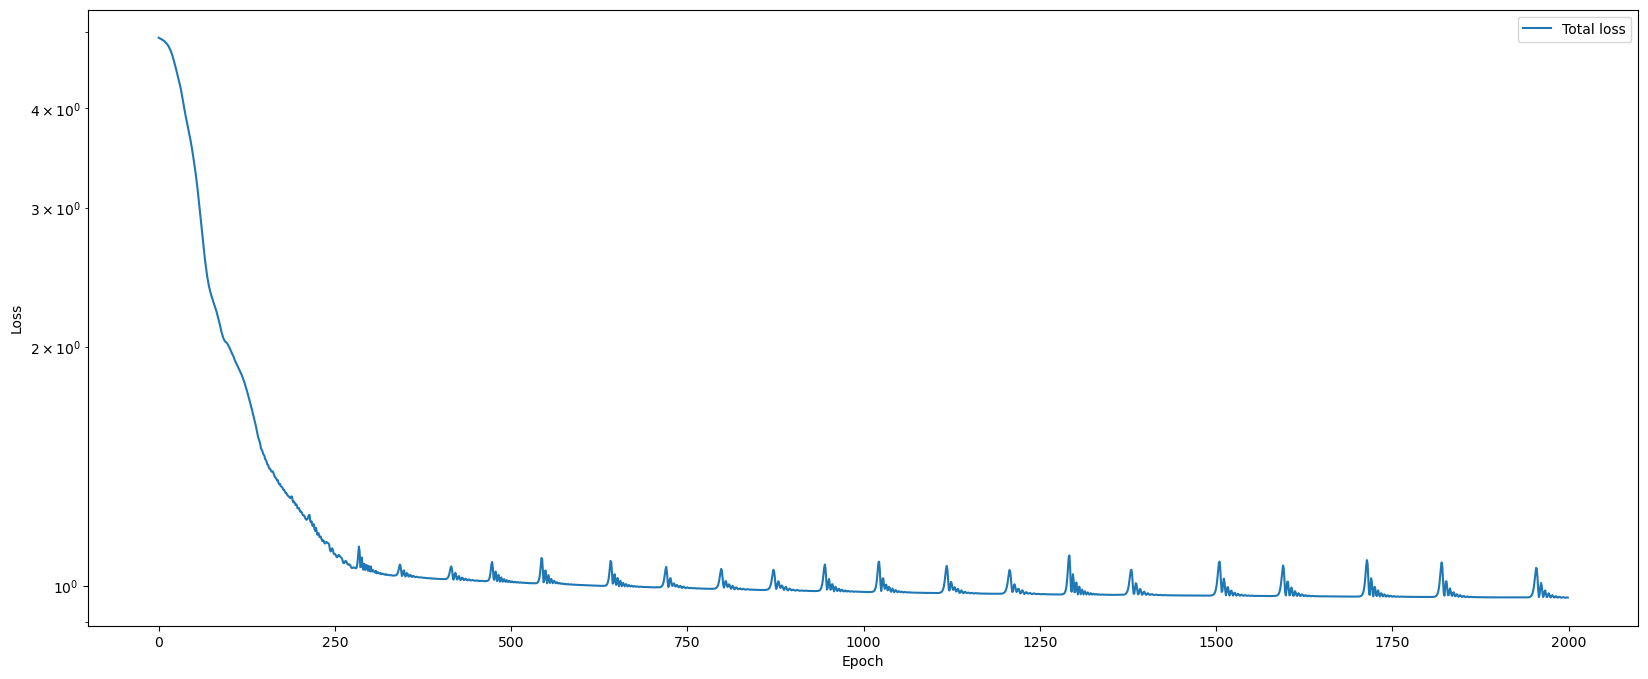

In [163]:
plt.figure(figsize=(20,8))
plt.plot(model_fe.loss_log, label='Total loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [164]:
# Get trained params
opt_params_fe = model_fe.get_params(model_fe.opt_state)

In [165]:
# Save model
FolderName_fe_model = FolderName + 'K_fe_NN_model/'
FileName_fe_model = 'fe_params.pkl'

Path(os.path.join(FolderName)).mkdir(parents = True, exist_ok = True)
pickle.dump(opt_params_fe , open(FolderName_fe_model + FileName_fe_model, 'wb'))

## Load Training Model

In [167]:
# Load model
FolderName_fe_model = FolderName + 'K_fe_NN_model/'
FileName_fe_model = 'fe_params.pkl'

opt_params_fe = pickle.load(open(FolderName_fe_model + FileName_fe_model , 'rb'))
model_fe.params = opt_params_fe

## Predictions

In [169]:
rho_fe_test = np.linspace(0.01,0.99,100)
print('Shape of rho_fe_test:', rho_fe_test.shape)

drho_fe_test_min = drho_1_train_K.min()
drho_fe_test_max = drho_1_train_K.max()

drho_fe_test = np.linspace(drho_fe_test_min,drho_fe_test_max,200)
print('Shape of drho_fe_test:', drho_fe_test.shape)


# set reference point for calibrating non-unique fe
rho_ref=0.5       # set fe = 0 & Q = 0 @ rho = rho_ref


fe_pred_test = vmap(model_fe.predict_fe, in_axes=(None,0))(opt_params_fe,rho_fe_test) \
      - model_fe.predict_fe(opt_params_fe, rho_ref) \
      - grad(model_fe.predict_fe, 1)(opt_params_fe, rho_ref) * ( rho_fe_test - rho_ref )
fe_ana_test = vmap(fe_Arr_ana_func, in_axes=(0,None,None,None))(rho_fe_test,Jo,L,Co) \
      - fe_Arr_ana_func(rho_ref,Jo,L,Co) \
      - grad(fe_Arr_ana_func, 0)(rho_ref,Jo,L,Co) * ( rho_fe_test - rho_ref )

Q_pred_test = vmap(grad(model_fe.predict_fe,1), in_axes=(None,0))(opt_params_fe,rho_fe_test) - grad(model_fe.predict_fe, 1)(opt_params_fe, rho_ref)
Q_ana_test = vmap(grad(fe_Arr_ana_func,0), in_axes=(0,None,None,None))(rho_fe_test,Jo,L,Co) - grad(fe_Arr_ana_func, 0)(rho_ref,Jo,L,Co)

Q_error = np.linalg.norm(Q_ana_test - Q_pred_test, 2) / np.linalg.norm(Q_ana_test, 2)



fe_ana_train = vmap(fe_Arr_ana_func, in_axes=(0,None,None,None))(rho_train_fe,Jo,L,Co) - fe_Arr_ana_func(rho_ref,Jo,L,Co) \
        - grad(fe_Arr_ana_func, 0)(rho_ref,Jo,L,Co) * ( rho_train_fe - rho_ref ) # fe_ana on training dataset
Q_ana_train = vmap(grad(fe_Arr_ana_func,0), in_axes=(0,None,None,None))(rho_train_fe,Jo,L,Co) - grad(fe_Arr_ana_func, 0)(rho_ref,Jo,L,Co) # Q_ana on training dataset



print('Shape of fe_pred_test:', fe_pred_test.shape)
print('Shape of Q_ana_test:', Q_ana_test.shape)
print('Shape of fe_ana_train:', fe_ana_train.shape)


fe_error = np.linalg.norm(fe_ana_test - fe_pred_test, 2) / np.linalg.norm(fe_ana_test, 2)
print('fe_error =', fe_error)

Shape of rho_fe_test: (100,)
Shape of drho_fe_test: (200,)
Shape of fe_pred_test: (100,)
Shape of Q_ana_test: (100,)
Shape of fe_ana_train: (700,)
fe_error = 1.8431505


<Figure size 640x480 with 0 Axes>

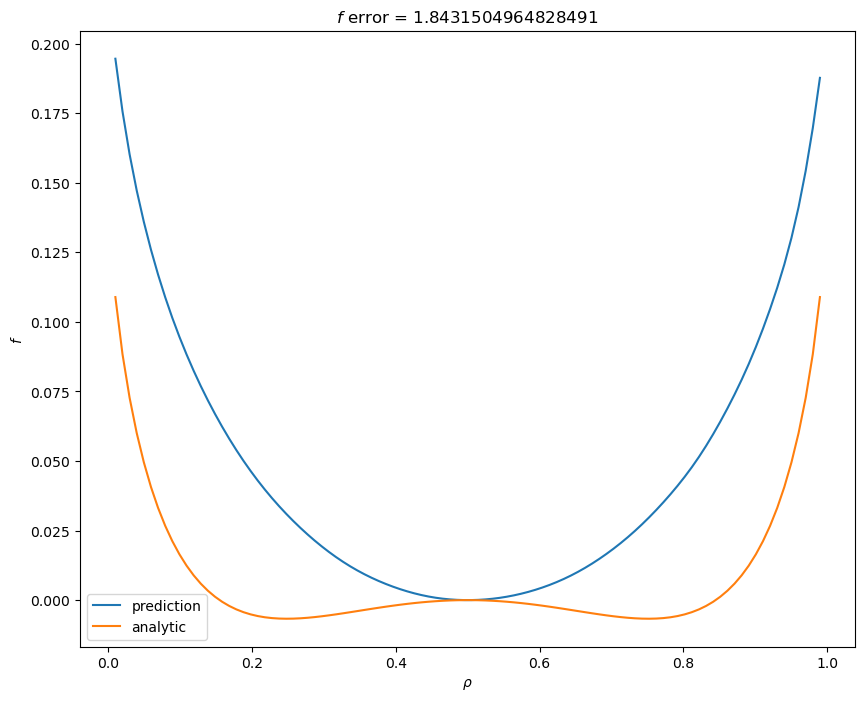

<Figure size 640x480 with 0 Axes>

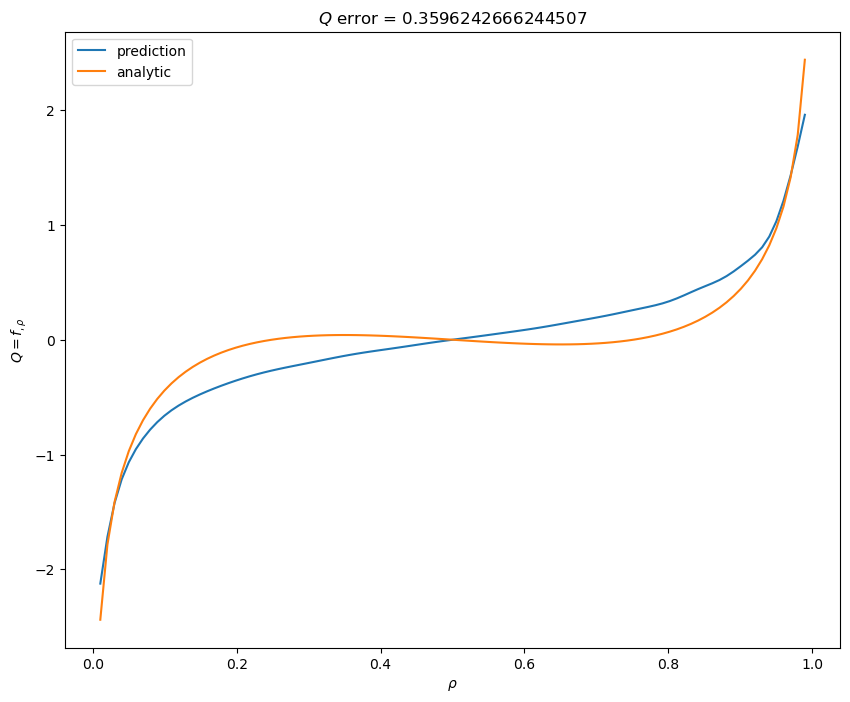

In [170]:
plt.figure()
fig = plt.figure(figsize=(10,8))
plt.plot(rho_fe_test, fe_pred_test, label='prediction')
plt.plot(rho_fe_test, fe_ana_test, label='analytic')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$f$')
plt.title(r'$f$ error = {}'.format(fe_error))
plt.legend()
plt.show()

plt.figure()
fig = plt.figure(figsize=(10,8))
plt.plot(rho_fe_test, Q_pred_test, label='prediction')
plt.plot(rho_fe_test, Q_ana_test, label='analytic')
# plt.scatter(rho_train_fe, Q_ana_train, label='train', facecolors='none', edgecolors='r')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$Q=f_{,\rho}$')
plt.title(r'$Q$ error = {}'.format(Q_error))
plt.legend()
plt.show()

## Output library data for fe and dfe

In [172]:
Num_fe_lib = 10000
rho_fe_lib = onp.linspace(0.01,0.99,Num_fe_lib)

fe_lib = vmap(model_fe.predict_fe, in_axes=(None,0))(opt_params_fe,rho_fe_lib)
Q_lib = vmap(grad(model_fe.predict_fe,1), in_axes=(None,0))(opt_params_fe,rho_fe_lib)

fe_lib = onp.array(fe_lib)
Q_lib = onp.array(Q_lib)

fe_lib_dic = {"rho_fe_lib": rho_fe_lib, "fe_lib": fe_lib, "Q_lib": Q_lib}

In [173]:
# Save fe and dfe
FolderName_fe_lib = FolderName + 'K_fe_NN_model/'
FileName_fe_lib = 'fe_lib.mat'

Path(os.path.join(FolderName_fe_lib)).mkdir(parents = True, exist_ok = True)
scipy.io.savemat(FolderName_fe_lib + FileName_fe_lib, fe_lib_dic)

# 7. Continuum Prediction

## Run Particle-based prediction

In [204]:
# type of initial profile
# IniProfType = 'cos' # cosine
IniProfType = 'tri' # triangle wave

cent_pred = 0.5

# amp_pred = 0.45
amp_pred = 0.4

# freq_pred = 2
freq_pred = 3

IniProfParams = cent_pred, amp_pred, freq_pred

# T_tot = 0.08
T_tot = 0.2

Ngamma_pred = int(50)
dtdx2_factor = 1.0/5.0     # dt = dx ** 2 * dtdx2_factor
model_range_factor = Ngamma/float(Ngamma_pred)


Arr_Params = Jo*L, L, Co, 1.0/4000

# conv_type = '0th'
# conv_type = '2nd'
conv_type = '4th'

print(FolderName2)
print('Ngamma_pred = ', Ngamma_pred)
print('dtdx2_factor = ', dtdx2_factor)
print('model_range_factor = ', model_range_factor)
print('IniProfType = ', IniProfType)
print('[cent, amp, freq] = ', [cent_pred, amp_pred, freq_pred])
print('T_tot = ', T_tot)
print("[JoL, L, D, dx_bin] = ", Arr_Params)
print("conv_type = ", conv_type)

Arr_Nb2e3_G25_JL2.2_L2/
Ngamma_pred =  50
dtdx2_factor =  0.2
model_range_factor =  0.5
IniProfType =  tri
[cent, amp, freq] =  [0.5, 0.4, 3]
T_tot =  0.2
[JoL, L, D, dx_bin] =  (2.2, 2, 1, 0.00025)
conv_type =  4th


In [206]:
# Parameters for continuum prediction

NN_K_settings = model_K, opt_params_K
NN_fe_settings = model_fe, opt_params_fe



In [208]:
# Run Continuum Prediction


rho_Part_All, rho_Ana_All, x_All, t_pred = K_fe_MPPart_mobAna_MacroSim(NN_K_settings, NN_fe_settings, Arr_Params, IniProfType, IniProfParams, T_tot, \
                          conv_type=conv_type, dtdx2_factor=dtdx2_factor, Ngamma=Ngamma_pred, model_range_factor=model_range_factor)

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:48<00:00, 23.13it/s]


[Array(0, dtype=int32), Array(100, dtype=int32), Array(250, dtype=int32), Array(500, dtype=int32), Array(1000, dtype=int32)]


<Figure size 640x480 with 0 Axes>

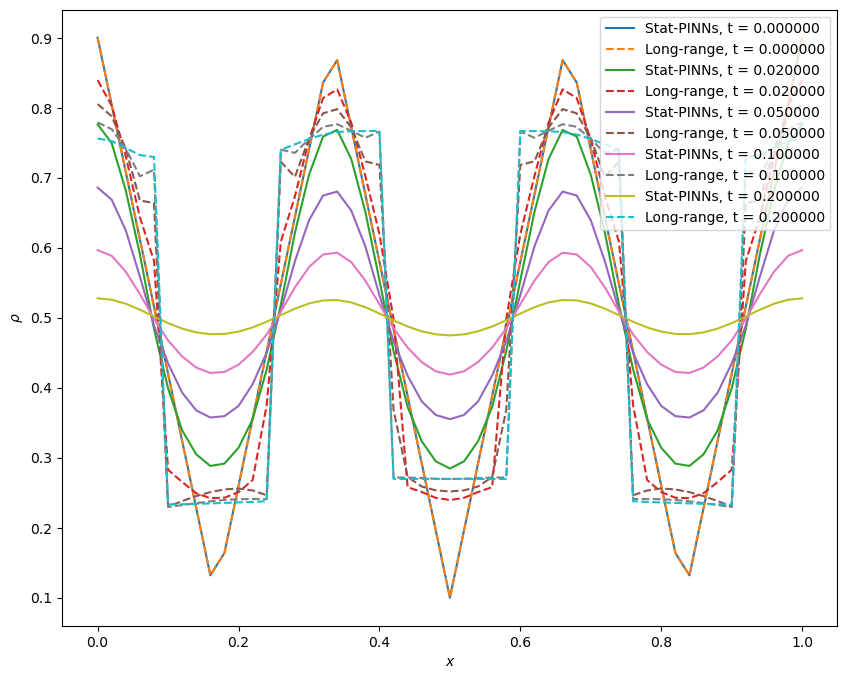

In [209]:
index_plot = np.array([0, 0.1, 0.25, 0.5, 1]) * (t_pred.shape[0] - 1)
index_plot = [round(num) for num in index_plot]

time_out = t_pred

print(index_plot)

plt.figure()
fig = plt.figure(figsize=(10,8))
for it in index_plot:
  plt.plot(x_All, rho_Part_All[:,it], label='Stat-PINNs, t = %f' %t_pred[it])
  plt.plot(x_All, rho_Ana_All[:,it], '--', label='Long-range, t = %f' %t_pred[it])
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$')
plt.legend()
plt.show()


## Output prediction

In [211]:
# Save PMPart and mobAna

FolderName_MacroSim1 = 'A' + str(amp_pred) + '_C' + str(cent_pred) + '_F' + str(freq_pred) + '_T' + str(T_tot) \
              + '_dt' + str(1/Ngamma_pred**2*dtdx2_factor) + '/'
if IniProfType == 'tri':
  FolderName_MacroSim1 = 'Tri_' + FolderName_MacroSim1
FolderName_MacroSim = FolderName + 'MacroSim/' + FolderName_MacroSim1


MacroSim_dic = {"rho_Part_All_out": rho_Part_All, "rho_Ana_All_out": rho_Ana_All, "x_All": x_All, "time_out": t_pred, "IniProfType": IniProfType, \
                "center": cent_pred, "amplitude": amp_pred, "frequency": freq_pred, "T": T_tot, "range_factor": model_range_factor}

FileName_MacroSim_lib = 'K_fe_StatPINNs_Ana_py.mat'
Path(os.path.join(FolderName_MacroSim)).mkdir(parents = True, exist_ok = True)
scipy.io.savemat(FolderName_MacroSim + FileName_MacroSim_lib, MacroSim_dic)

## Load and Compare Stat-PINNs, Long-range Analytic & KMC

In [213]:
# load Stat-PINNs (MPPart) & Long-Range Analytic (mobAna)

FolderName_MacroSim1 = 'A' + str(amp_pred) + '_C' + str(cent_pred) + '_F' + str(freq_pred) + '_T' + str(T_tot) \
              + '_dt' + str(1/Ngamma_pred**2*dtdx2_factor) + '/'
if IniProfType == 'tri':
  FolderName_MacroSim1 = 'Tri_' + FolderName_MacroSim1
FolderName_MacroSim = FolderName + 'MacroSim/' + FolderName_MacroSim1

FileName_MacroSim_lib = 'K_fe_StatPINNs_Ana_py.mat'

data_MacroSim = scipy.io.loadmat(FolderName_MacroSim + FileName_MacroSim_lib)

rho_Part_All = data_MacroSim["rho_Part_All_out"]
rho_Ana_All = data_MacroSim["rho_Ana_All_out"]
x_All = data_MacroSim["x_All"].flatten()
time_out = data_MacroSim["time_out"].flatten()
T_tot = data_MacroSim["T"][0,0]

In [237]:
# load Long-time KMC simulation

# Notice the following three KMC results are simulated on a smaller system, 
# which is 1/2 or 1/3 of the full system that has 4000 bins and 50 gamma shape functions.
# Therefore, a rescale in length and time and duplication in profile is required later

# FolderName_LongKMC2 = 'ArrL_Nb2e3_G25_600t_c05A045f1_JL0.9_L40_1e3T0.32/'
# FolderName_LongKMC2 = 'ArrL_Nb2e3_G25_600t_c05A045f1_JL0.9_L2_1e3T0.32/'
FolderName_LongKMC2 = 'ArrL_Nb1333_G17_600t_c05A04f1_JL2.2_L2_1e3T1.8/'

FolderName_LongKMC = FolderName1 + FolderName_LongKMC2

FileName_LongKMC = 'LongKMC_ave.mat'


data_LongKMC = scipy.io.loadmat(FolderName_LongKMC+FileName_LongKMC)

print(FolderName_LongKMC2)
print(data_LongKMC.keys())

ArrL_Nb1333_G17_600t_c05A04f1_JL2.2_L2_1e3T1.8/
dict_keys(['__header__', '__version__', '__globals__', 'Co', 'Jo', 'L', 'Nbin', 'Ngamma', 'T', 'amplitude', 'boundaryCondition', 'center', 'frequency', 'numRealizations', 'rho_LongKMC_All_ave', 'timesteps_LongKMC', 'x_All'])


In [224]:
# Load parameters for process
rho_LongKMC_ori_All = data_LongKMC['rho_LongKMC_All_ave']
T_LongKMC_ori = data_LongKMC['T'][0,0]
Ngamma_LongKMC_ori = data_LongKMC['Ngamma'][0,0]
x_LongKMC_ori_All = data_LongKMC['x_All'].flatten()
timesteps_LongKMC = data_LongKMC['timesteps_LongKMC'][0,0]

print('Shape of rho_LongKMC_ori_All = ',rho_LongKMC_ori_All.shape)
print('Shape of x_LongKMC_ori_All = ',x_LongKMC_ori_All.shape)
print('Ngamma_LongKMC_ori = ',Ngamma_LongKMC_ori)
print('T_LongKMC_ori = ',T_LongKMC_ori)
print("timesteps_LongKMC = ", timesteps_LongKMC)

Shape of rho_LongKMC_ori_All =  (1001, 18)
Shape of x_LongKMC_ori_All =  (18,)
Ngamma_LongKMC_ori =  17
T_LongKMC_ori =  1.8
timesteps_LongKMC =  1000


In [250]:
# rescale LongKMC results
# 

scale_factor_LongKMC = round(50/Ngamma_LongKMC_ori)
print("scale_factor_LongKMC = ",scale_factor_LongKMC)

T_LongKMC = T_LongKMC_ori / scale_factor_LongKMC**2

rho_LongKMC = rho_LongKMC_ori_All[:,:-1]
x_LongKMC = x_LongKMC_ori_All[:-1]
for i in range(scale_factor_LongKMC-1):
  rho_LongKMC = onp.hstack([rho_LongKMC, rho_LongKMC_ori_All[:,:-1]])
  x_LongKMC = onp.hstack([x_LongKMC, i+1 + x_LongKMC_ori_All[:-1]])

x_LongKMC = x_LongKMC/scale_factor_LongKMC

rho_LongKMC_All = onp.column_stack([rho_LongKMC, rho_LongKMC[:,0]])
rho_LongKMC_All = onp.transpose(rho_LongKMC_All)
x_LongKMC_All = onp.concatenate([x_LongKMC, (1.0,)])

print('T_LongKMC = ',T_LongKMC)
print('Shape of rho_LongKMC_All = ',rho_LongKMC_All.shape)
print('Shape of x_LongKMC_All = ',x_LongKMC_All.shape)

scale_factor_LongKMC =  3
T_LongKMC =  0.2
Shape of rho_LongKMC_All =  (52, 1001)
Shape of x_LongKMC_All =  (52,)


T_plot_max =  0.2
[Array(0, dtype=int32), Array(100, dtype=int32), Array(250, dtype=int32), Array(500, dtype=int32), Array(1000, dtype=int32)]
[Array(0, dtype=int32), Array(100, dtype=int32), Array(250, dtype=int32), Array(500, dtype=int32), Array(1000, dtype=int32)]


<Figure size 640x480 with 0 Axes>

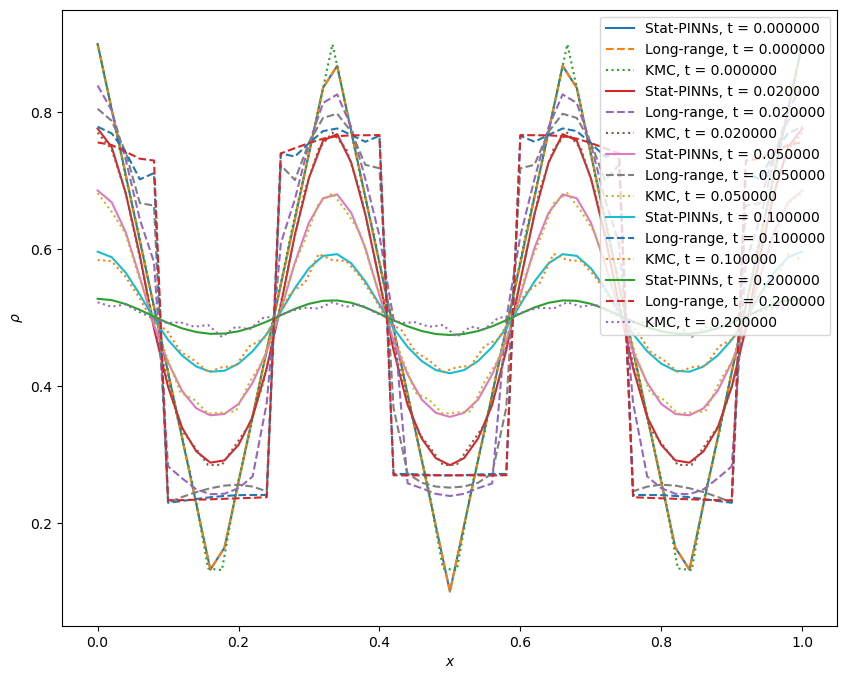

In [230]:
T_plot_max = min(T_tot, T_LongKMC)

print("T_plot_max = ", T_plot_max)

index_plot_pred = np.array([0, 0.1, 0.25, 0.5, 1]) * (time_out.shape[0] - 1) * min(T_plot_max / T_tot, 1.0)
index_plot_pred = [round(num) for num in index_plot_pred]

index_plot_LongKMC = np.array([0, 0.1, 0.25, 0.5, 1]) * timesteps_LongKMC * min(T_plot_max / T_LongKMC, 1.0)
index_plot_LongKMC = [round(num) for num in index_plot_LongKMC]

print(index_plot_pred)
print(index_plot_LongKMC)

plot_max = cent_pred + amp_pred + 0.05
plot_min = cent_pred - amp_pred - 0.05

plt.figure()
fig = plt.figure(figsize=(10,8))
for it in range(len(index_plot_pred)):

  plt.plot(x_All, rho_Part_All[:,index_plot_pred[it]], label='Stat-PINNs, t = %f' %time_out[index_plot_pred[it]])
  plt.plot(x_All, rho_Ana_All[:,index_plot_pred[it]], '--', label='Long-range, t = %f' %time_out[index_plot_pred[it]])
  plt.plot(x_LongKMC_All, rho_LongKMC_All[:,index_plot_LongKMC[it]], ':', label='KMC, t = %f' %time_out[index_plot_pred[it]])
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$')
# plt.title(r'$Q$ error = {}'.format(Q_error))
plt.ylim([plot_min, plot_max])
plt.legend()
plt.show()

# plt.savefig(FolderName_MacroSim + 'rho_MPPart_mobAna_LongKMC.png')

[Array(0, dtype=int32), Array(100, dtype=int32), Array(250, dtype=int32), Array(500, dtype=int32), Array(1000, dtype=int32)]
[Array(0, dtype=int32), Array(100, dtype=int32), Array(250, dtype=int32), Array(500, dtype=int32), Array(1000, dtype=int32)]


<Figure size 640x480 with 0 Axes>

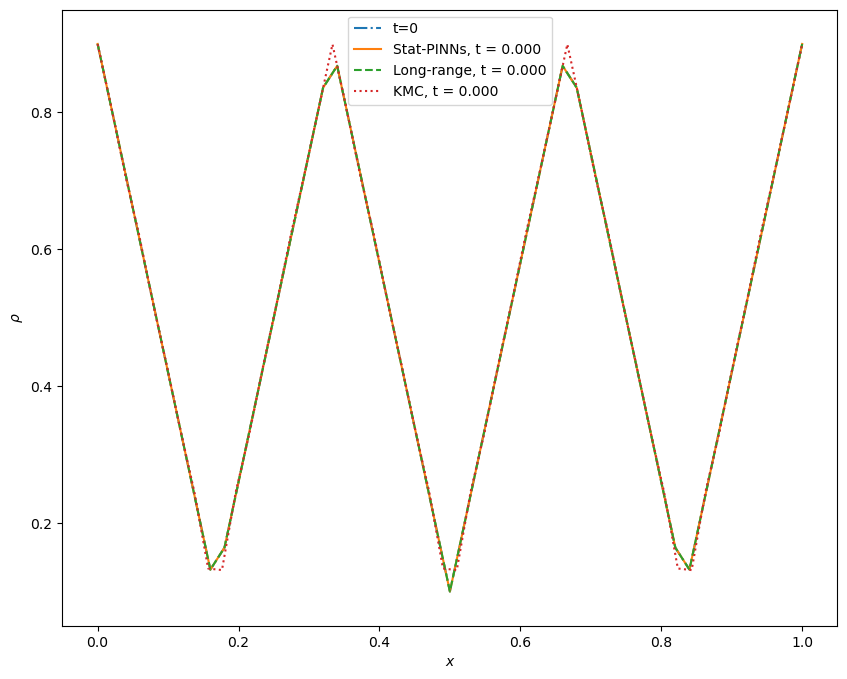

<Figure size 640x480 with 0 Axes>

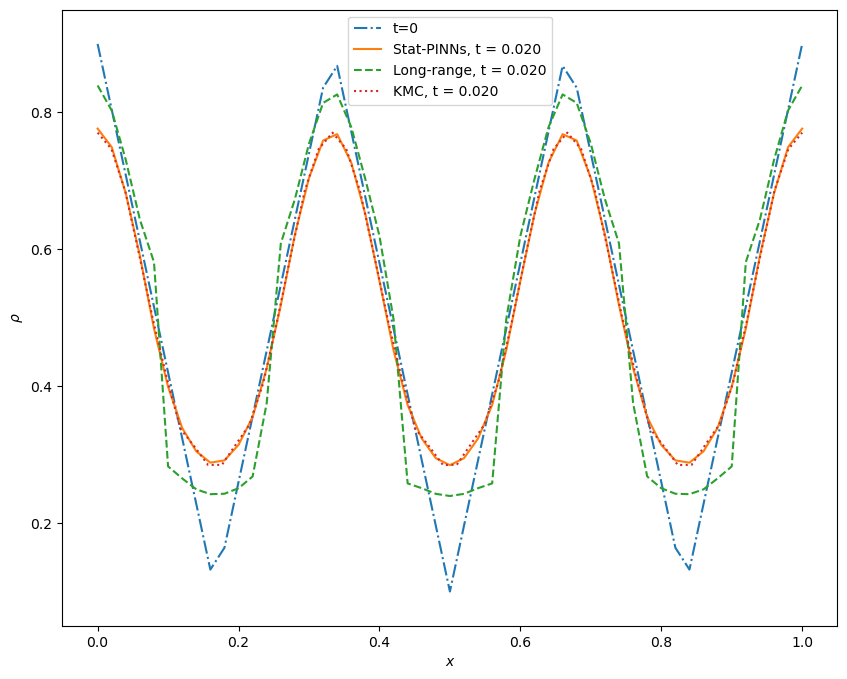

<Figure size 640x480 with 0 Axes>

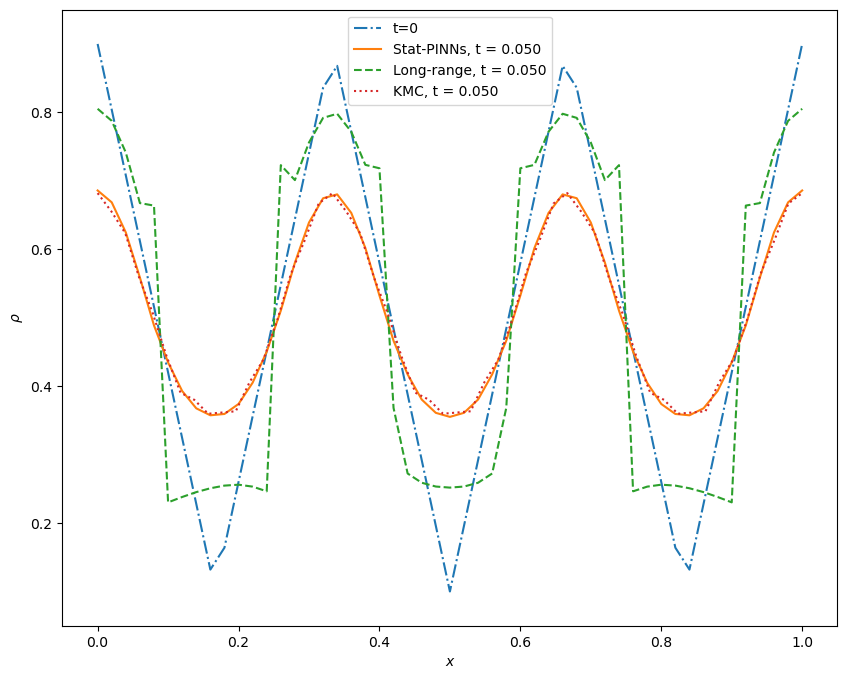

<Figure size 640x480 with 0 Axes>

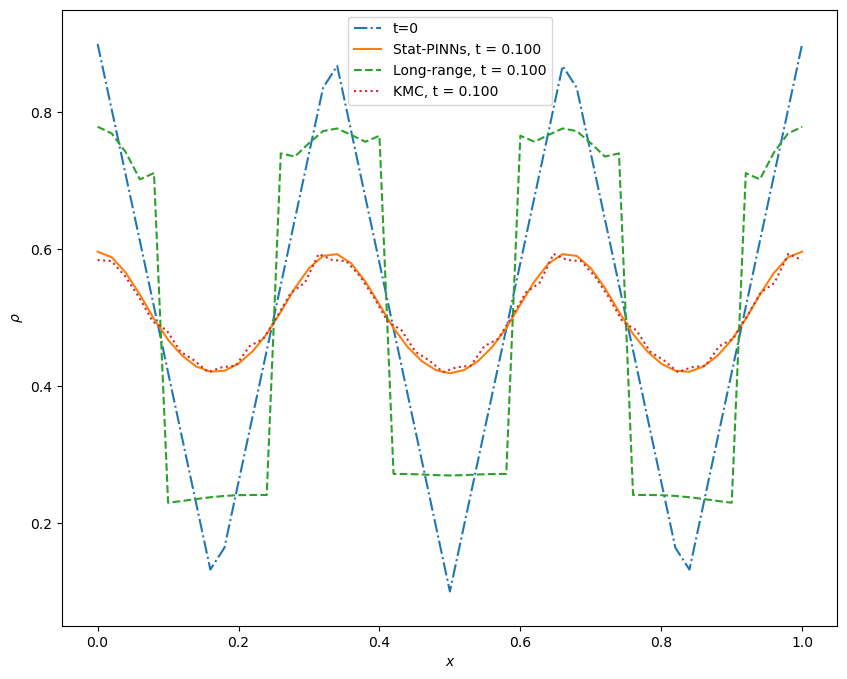

<Figure size 640x480 with 0 Axes>

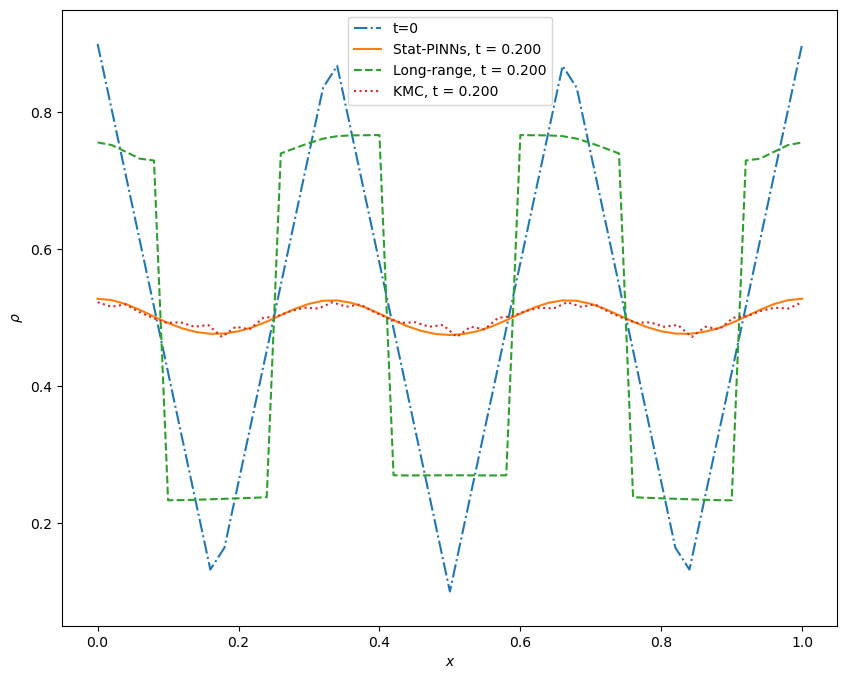

In [231]:
index_plot_pred = np.array([0, 0.1, 0.25, 0.5, 1]) * (time_out.shape[0] - 1) * min(T_plot_max / T_tot, 1.0)
index_plot_pred = [round(num) for num in index_plot_pred]

index_plot_LongKMC = np.array([0, 0.1, 0.25, 0.5, 1]) * timesteps_LongKMC * min(T_plot_max / T_LongKMC, 1.0)
index_plot_LongKMC = [round(num) for num in index_plot_LongKMC]

print(index_plot_pred)
print(index_plot_LongKMC)

for it in range(len(index_plot_pred)):
  plt.figure()
  fig = plt.figure(figsize=(10,8))
  plt.plot(x_All, rho_Part_All[:,0], '-.', label='t=0')

  plt.plot(x_All, rho_Part_All[:,index_plot_pred[it]], label='Stat-PINNs, t = %.3f' %time_out[index_plot_pred[it]])
  plt.plot(x_All, rho_Ana_All[:,index_plot_pred[it]], '--', label='Long-range, t = %.3f' %time_out[index_plot_pred[it]])
  plt.plot(x_LongKMC_All, rho_LongKMC_All[:,index_plot_LongKMC[it]], ':', label='KMC, t = %.3f' %time_out[index_plot_pred[it]])
  plt.xlabel(r'$x$')
  plt.ylabel(r'$\rho$')
  # plt.title(r'$Q$ error = {}'.format(Q_error))
  plt.legend()
  plt.ylim([plot_min, plot_max])
  plt.show()

In [232]:
# Save fe
# FolderName_output_lib = FolderName + 'Outputs_K_fe/'
Path(os.path.join(FolderName_output_lib)).mkdir(parents = True, exist_ok = True)

if fe_INN_type == 'fe_INN':
  scipy.io.savemat(FolderName_output_lib + 'fe_output_lib.mat', fe_output_lib_dic)
elif fe_INN_type == 'fe_gradB_INN':
  scipy.io.savemat(FolderName_output_lib + 'fe2B_output_lib.mat', fe_output_lib_dic)
elif fe_INN_type == 'fe_lap_INN':
  scipy.io.savemat(FolderName_output_lib + 'fe2L_output_lib.mat', fe_output_lib_dic)
else:
  print("Wrong fe_INN_type!")
  exit()


NameError: name 'FolderName_output_lib' is not defined

In [ ]:
# Save PINNs

FolderName_MacroSimAll = FolderName + 'Outputs/'


MacroSimAll_dic = {"rho_StatPINNs_All": onp.array(rho_Part_All), "rho_PINNs_All": onp.array(rho_PINNs_All), \
                "rho_LongRange_All": onp.array(rho_Ana_All), "rho_LongKMC_All": onp.array(rho_LongKMC_All),\
                "x_All": onp.array(x_All), "time_pred": onp.array(time_out), "T_pred": T_tot, \
                "x_LongKMC_All": onp.array(x_LongKMC_All), "T_LongKMC": onp.array(T_LongKMC), \
                "center": cent_pred, "amplitude": amp_pred, "frequency": freq_pred, "range_factor": model_range_factor, \
                "dtdx2_factor": dtdx2_factor, "dx_basis": dx_pred}


FileName_MacroSimAll_lib = 'MacroSim_output_lib_'

if K_INN_type == 'K1_MP_INN':
  FileName_MacroSimAll_lib = FileName_MacroSimAll_lib + 'K_'
elif K_INN_type == 'K14_MP_INN':
  FileName_MacroSimAll_lib = FileName_MacroSimAll_lib + 'K14_'


if fe_INN_type == 'fe_INN':
  FileName_MacroSimAll_lib = FileName_MacroSimAll_lib + "fe"
elif fe_INN_type == 'fe_gradB_INN':
  FileName_MacroSimAll_lib = FileName_MacroSimAll_lib + "fe2B"
elif fe_INN_type == 'fe_lap_INN':
  FileName_MacroSimAll_lib = FileName_MacroSimAll_lib + "fe2L"
elif fe_INN_type == 'fe_gradB_lap_INN':
  FileName_MacroSimAll_lib = FileName_MacroSimAll_lib + "fe3BL"
elif fe_INN_type == 'fe_gradC_lap_INN':
  FileName_MacroSimAll_lib = FileName_MacroSimAll_lib + "fe3CL"

if conv_type == '2nd':
  FileName_MacroSimAll_lib = FileName_MacroSimAll_lib + "_2nd"
elif conv_type == '4th':
  FileName_MacroSimAll_lib = FileName_MacroSimAll_lib + "_4th"



FileName_MacroSimAll_lib = FileName_MacroSimAll_lib + ".mat"

print(FolderName_MacroSimAll + FileName_MacroSimAll_lib)
Path(os.path.join(FolderName_MacroSimAll)).mkdir(parents = True, exist_ok = True)
scipy.io.savemat(FolderName_MacroSimAll + FileName_MacroSimAll_lib, MacroSimAll_dic)

In [ ]:
while True:pass

KeyboardInterrupt: ignored

In [ ]:
JL_test = 1.8
L_test = 80

# IniProfType = 'cos'
IniProfType = 'tri'
cent_pred = 0.5
# amp_pred = 0.45
amp_pred = 0.2
freq_pred = 3
# freq_pred = 2
IniProfParams = cent_pred, amp_pred, freq_pred

T_tot = 0.08
# T_tot = 0.2

Ngamma_pred = int(50)
# dtdx2_factor = 1.0/2.0
dtdx2_factor = 1.0/5.0
model_range_factor = Ngamma/float(Ngamma_pred)


Arr_Params_test = JL_test, L_test, Co, 1.0/4000

# conv_type = '0th'
conv_type = '2nd'

print(FolderName2)
print('K_INN_type = ', K_INN_type)
print('fe_INN_type = ', fe_INN_type)
print('Ngamma_pred = ', Ngamma_pred)
print('dtdx2_factor = ', dtdx2_factor)
print('model_range_factor = ', model_range_factor)
print('IniProfType = ', IniProfType)
print('[cent, amp, freq] = ', [cent_pred, amp_pred, freq_pred])
print('T_tot = ', T_tot)
print("[JoL, L, D, dx_bin] = ", Arr_Params_test)
print("conv_type = ", conv_type)

Modified_Arr230615_Nb2e3_G25_28c_JL0.9_L80_1e3R10_1_10h001_1dt20_Eq50_E2JLrm/
K_INN_type =  K1_MP_INN
fe_INN_type =  fe_INN
Ngamma_pred =  50
dtdx2_factor =  0.2
model_range_factor =  0.5
IniProfType =  tri
[cent, amp, freq] =  [0.5, 0.2, 3]
T_tot =  0.08
[JoL, L, D, dx_bin] =  (1.8, 80, 1, 0.00025)
conv_type =  2nd


In [ ]:
# Parameters for continuum prediction

NN_K_settings = model_K, opt_params_K, K_INN_type
NN_fe_settings = model_fe, opt_params_fe, fe_INN_type



In [ ]:
# Run Continuum Prediction


rho_Part_All_test, rho_Ana_All_test, x_All, t_pred = K_fe_MPPart_mobAna_MacroSim(NN_K_settings, NN_fe_settings, Arr_Params_test, IniProfType, IniProfParams, T_tot, \
                          conv_type=conv_type, dtdx2_factor=dtdx2_factor, Ngamma=Ngamma_pred, model_range_factor=model_range_factor)

# rho_Part_All, rho_Ana_All, x_All, t_pred, Q_temp,  Q_Ana_temp, m_half_Ana_temp, flux_Ana_temp\
#                         = K_fe_MPPart_mobAna_MacroSim(NN_K_settings, NN_fe_settings, Arr_Params, IniProfType, IniProfParams, 1e-5, \
#                           conv_type=conv_type, dtdx2_factor=0.5, Ngamma=Ngamma_pred, model_range_factor=model_range_factor)

100%|██████████| 1000/1000 [00:55<00:00, 18.17it/s]


[Array(0, dtype=int32), Array(100, dtype=int32), Array(250, dtype=int32), Array(500, dtype=int32), Array(1000, dtype=int32)]


<Figure size 640x480 with 0 Axes>

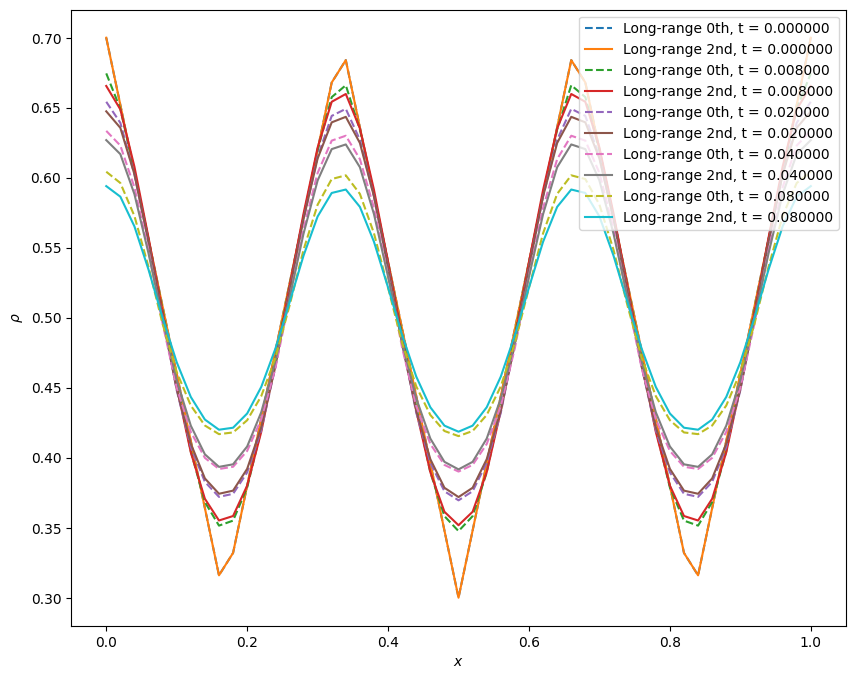

In [ ]:
index_plot = np.array([0, 0.1, 0.25, 0.5, 1]) * (t_pred.shape[0] - 1)
# index_plot = np.array([1]) * (t_pred.shape[0] - 1)
index_plot = [round(num) for num in index_plot]

time_out = t_pred

print(index_plot)

plt.figure()
fig = plt.figure(figsize=(10,8))
for it in index_plot:
# for it in range(20):
  # plt.plot(x_All, rho_Part_All[:,it], label='Stat-PINNs, t = %f' %t_pred[it])
  plt.plot(x_All, rho_Ana_All_test0[:,it], '--', label='Long-range 0th, t = %f' %t_pred[it])
  plt.plot(x_All, rho_Ana_All_test[:,it], '-', label='Long-range 2nd, t = %f' %t_pred[it])
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$')
# plt.title(r'$Q$ error = {}'.format(Q_error))
# plt.ylim([0,1])
plt.legend()
plt.show()


[Array(0, dtype=int32), Array(50, dtype=int32), Array(125, dtype=int32), Array(250, dtype=int32), Array(500, dtype=int32)]
[Array(0, dtype=int32), Array(100, dtype=int32), Array(250, dtype=int32), Array(500, dtype=int32), Array(1000, dtype=int32)]


<Figure size 640x480 with 0 Axes>

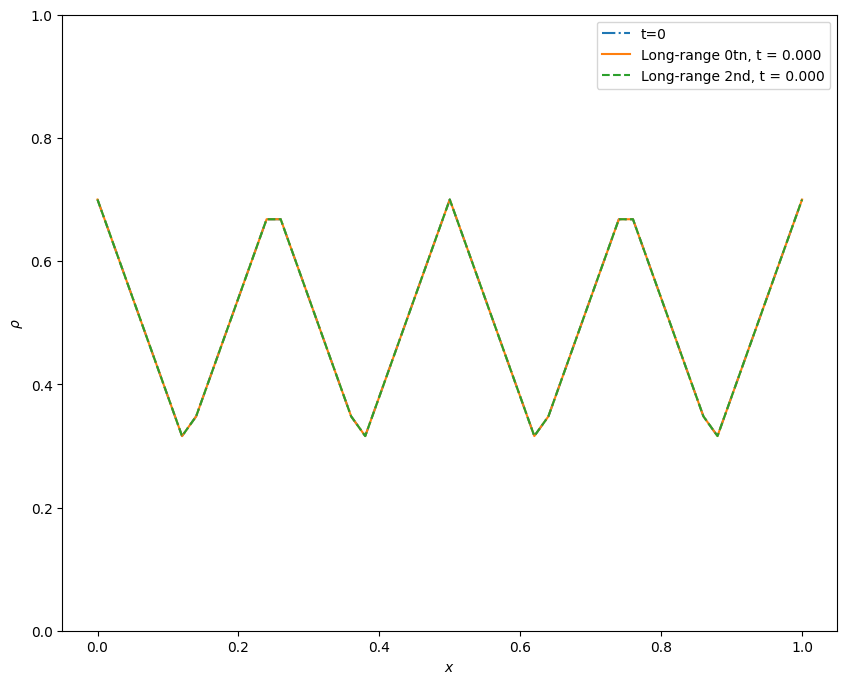

<Figure size 640x480 with 0 Axes>

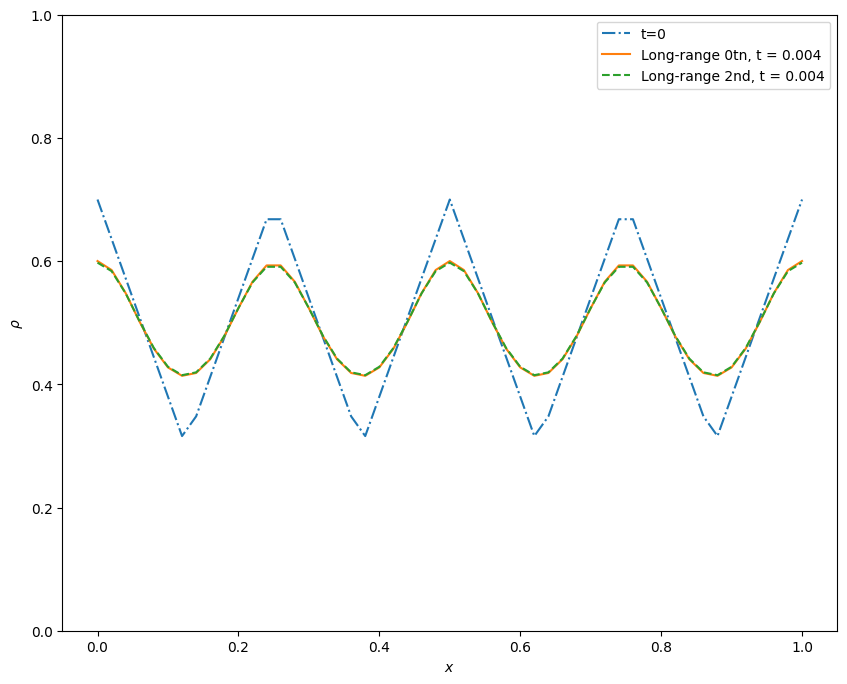

<Figure size 640x480 with 0 Axes>

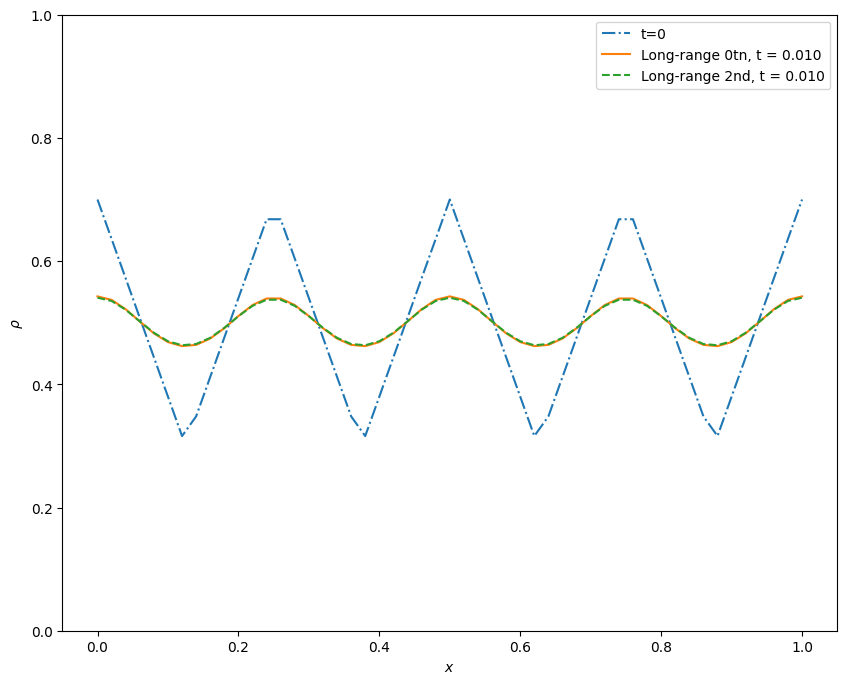

<Figure size 640x480 with 0 Axes>

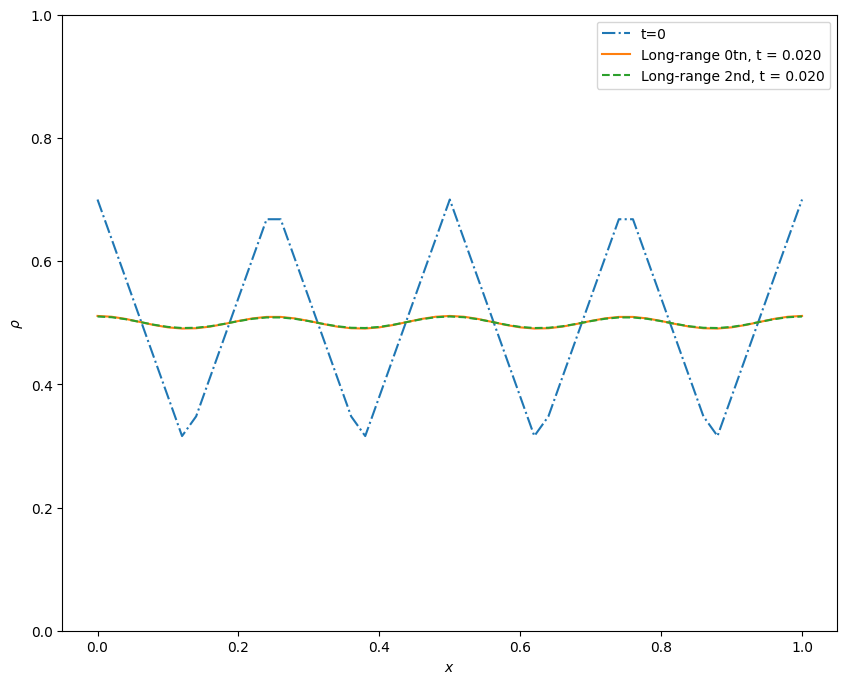

<Figure size 640x480 with 0 Axes>

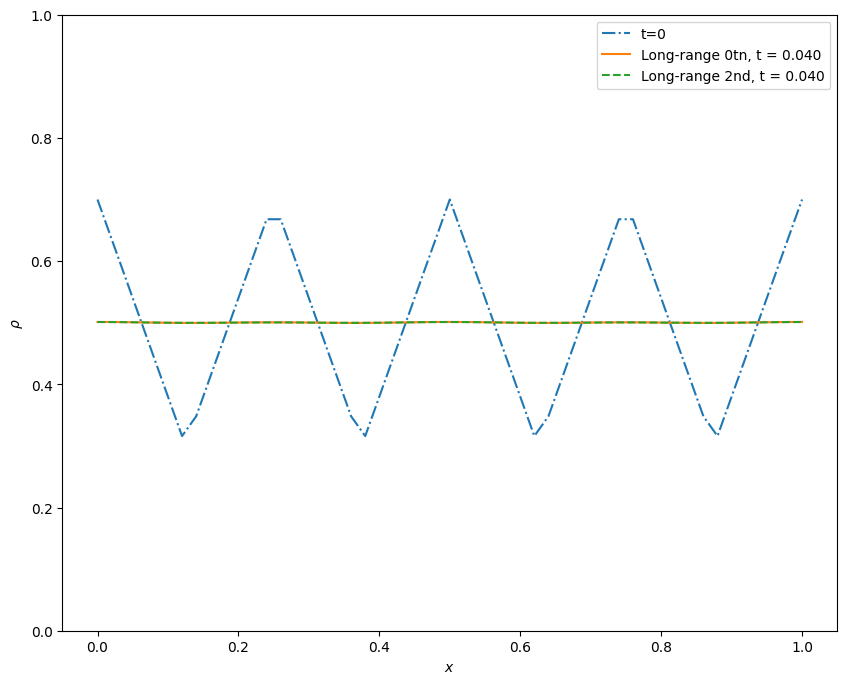

In [ ]:
index_plot_pred = np.array([0, 0.1, 0.25, 0.5, 1]) * (time_out.shape[0] - 1) * min(T_plot_max / T_tot, 1.0)
index_plot_pred = [round(num) for num in index_plot_pred]

index_plot_LongKMC = np.array([0, 0.1, 0.25, 0.5, 1]) * timesteps_LongKMC * min(T_plot_max / T_LongKMC, 1.0)
index_plot_LongKMC = [round(num) for num in index_plot_LongKMC]

print(index_plot_pred)
print(index_plot_LongKMC)

for it in range(len(index_plot_pred)):
  plt.figure()
  fig = plt.figure(figsize=(10,8))
  plt.plot(x_All, rho_Ana_All_test[:,0], '-.', label='t=0')

  plt.plot(x_All, rho_Ana_All_test0[:,index_plot_pred[it]], label='Long-range 0tn, t = %.3f' %time_out[index_plot_pred[it]])
  plt.plot(x_All, rho_Ana_All_test[:,index_plot_pred[it]], '--', label='Long-range 2nd, t = %.3f' %time_out[index_plot_pred[it]])
  # plt.plot(x_LongKMC_All, rho_LongKMC_All[:,index_plot_LongKMC[it]], ':', label='KMC, t = %.3f' %time_out[index_plot_pred[it]])
  plt.xlabel(r'$x$')
  plt.ylabel(r'$\rho$')
  # plt.title(r'$Q$ error = {}'.format(Q_error))
  plt.legend()
  plt.ylim([plot_min, plot_max])
  plt.show()